In [ ]:
import torch

# !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 55.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 45.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.2 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-rdu37xyo
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-rdu37xyo
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 9adb8d082cd1ea45394e137085404a9aacf4e261
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.4.0-py3-none-any.whl size=10

dataset.py

In [ ]:
import os
import numpy as np
import torch
import random
from torch.utils.data import Dataset
from torch_geometric.data import Data

class GraphDataset(Dataset):
    def __init__(self, fold_x, treeDic,lower=2, upper=100000, droprate=0,
                 data_path=os.path.join('..','..', 'data', 'Weibograph')):
        self.fold_x = list(filter(lambda id: id in treeDic and
                                  len(treeDic[id]) >= lower and len(treeDic[id]) <= upper, fold_x))
        self.treeDic = treeDic
        self.data_path = data_path
        self.droprate = droprate

    def __len__(self):
        return len(self.fold_x)

    def __getitem__(self, index):
        id =self.fold_x[index]
        data=np.load(os.path.join(self.data_path, id + ".npz"), allow_pickle=True)
        edgeindex = data['edgeindex']
        if self.droprate > 0:
            row = list(edgeindex[0])
            col = list(edgeindex[1])
            length = len(row)
            poslist = random.sample(range(length), int(length * (1 - self.droprate)))
            poslist = sorted(poslist)
            row = list(np.array(row)[poslist])
            col = list(np.array(col)[poslist])
            new_edgeindex = [row, col]
        else:
            new_edgeindex = edgeindex
        return Data(x=torch.tensor(data['x'],dtype=torch.float32),
                    edge_index=torch.LongTensor(new_edgeindex),
             y=torch.LongTensor([int(data['y'])]), root=torch.LongTensor(data['root']),
             rootindex=torch.LongTensor([int(data['rootindex'])]))

def collate_fn(data):
    return data

class BiGraphDataset(Dataset):
    def __init__(self, fold_x, treeDic,lower=2, upper=100000, tddroprate=0,budroprate=0,
                 data_path=os.path.join('..','..', 'data', 'Weibograph')):
        self.fold_x = list(filter(lambda id: id in treeDic
                                  and len(treeDic[id]) >= lower and len(treeDic[id]) <= upper, fold_x))
        self.treeDic = treeDic
        self.data_path = data_path
        self.tddroprate = tddroprate
        self.budroprate = budroprate

    def __len__(self):
        return len(self.fold_x)

    def __getitem__(self, index):
        id =self.fold_x[index]
        data=np.load(os.path.join(self.data_path, id + ".npz"), allow_pickle=True)
        edgeindex = data['edgeindex']
        if self.tddroprate > 0:
            row = list(edgeindex[0])
            col = list(edgeindex[1])
            length = len(row)
            poslist = random.sample(range(length), int(length * (1 - self.tddroprate)))
            poslist = sorted(poslist)
            row = list(np.array(row)[poslist])
            col = list(np.array(col)[poslist])
            new_edgeindex = [row, col]
        else:
            new_edgeindex = edgeindex

        burow = list(edgeindex[1])
        bucol = list(edgeindex[0])
        if self.budroprate > 0:
            length = len(burow)
            poslist = random.sample(range(length), int(length * (1 - self.budroprate)))
            poslist = sorted(poslist)
            row = list(np.array(burow)[poslist])
            col = list(np.array(bucol)[poslist])
            bunew_edgeindex = [row, col]
        else:
            bunew_edgeindex = [burow,bucol]
        return Data(x=torch.tensor(data['x'],dtype=torch.float32),
                    edge_index=torch.LongTensor(new_edgeindex),BU_edge_index=torch.LongTensor(bunew_edgeindex),
             y=torch.LongTensor([int(data['y'])]), root=torch.LongTensor(data['root']),
             rootindex=torch.LongTensor([int(data['rootindex'])]))


class UdGraphDataset(Dataset):
    def __init__(self, fold_x, treeDic,lower=2, upper=100000, droprate=0,
                 data_path=os.path.join('..','..','data', 'Weibograph')):
        self.fold_x = list(filter(lambda id: id in treeDic and len(treeDic[id]) >= lower and len(treeDic[id]) <= upper, fold_x))
        self.treeDic = treeDic
        self.data_path = data_path
        self.droprate = droprate

    def __len__(self):
        return len(self.fold_x)

    def __getitem__(self, index):
        id =self.fold_x[index]
        data=np.load(os.path.join(self.data_path, id + ".npz"), allow_pickle=True)
        edgeindex = data['edgeindex']
        row = list(edgeindex[0])
        col = list(edgeindex[1])
        burow = list(edgeindex[1])
        bucol = list(edgeindex[0])
        row.extend(burow)
        col.extend(bucol)
        if self.droprate > 0:
            length = len(row)
            poslist = random.sample(range(length), int(length * (1 - self.droprate)))
            poslist = sorted(poslist)
            row = list(np.array(row)[poslist])
            col = list(np.array(col)[poslist])
        new_edgeindex = [row, col]

        return Data(x=torch.tensor(data['x'],dtype=torch.float32),
                    edge_index=torch.LongTensor(new_edgeindex),
             y=torch.LongTensor([int(data['y'])]), root=torch.LongTensor(data['root']),
             rootindex=torch.LongTensor([int(data['rootindex'])]))


rand5something.py

In [ ]:
import random
from random import shuffle
import os

cwd=os.getcwd()

def load5foldData(obj):
    if 'Twitter' in obj:
        labelPath = os.path.join(cwd,"/content/drive/MyDrive/data/" +obj+"/"+ obj + "_label_All.txt")
        labelset_nonR, labelset_f, labelset_t, labelset_u = ['news', 'non-rumor'], ['false'], ['true'], ['unverified']
        print("loading tree label" )
        NR,F,T,U = [],[],[],[]
        l1=l2=l3=l4=0
        labelDic = {}
        for line in open(labelPath):
            line = line.rstrip()
            label, eid = line.split('\t')[0], line.split('\t')[2]
            labelDic[eid] = label.lower()
            if label in labelset_nonR:
                NR.append(eid)
                l1 += 1
            if labelDic[eid] in labelset_f:
                F.append(eid)
                l2 += 1
            if labelDic[eid] in labelset_t:
                T.append(eid)
                l3 += 1
            if labelDic[eid] in labelset_u:
                U.append(eid)
                l4 += 1
        print(len(labelDic))
        print(l1,l2,l3,l4)
        random.shuffle(NR)
        random.shuffle(F)
        random.shuffle(T)
        random.shuffle(U)

        fold0_x_test,fold1_x_test,fold2_x_test,fold3_x_test,fold4_x_test=[],[],[],[],[]
        fold0_x_train, fold1_x_train, fold2_x_train, fold3_x_train, fold4_x_train = [], [], [], [], []
        leng1 = int(l1 * 0.2)
        leng2 = int(l2 * 0.2)
        leng3 = int(l3 * 0.2)
        leng4 = int(l4 * 0.2)

        fold0_x_test.extend(NR[0:leng1])
        fold0_x_test.extend(F[0:leng2])
        fold0_x_test.extend(T[0:leng3])
        fold0_x_test.extend(U[0:leng4])
        fold0_x_train.extend(NR[leng1:])
        fold0_x_train.extend(F[leng2:])
        fold0_x_train.extend(T[leng3:])
        fold0_x_train.extend(U[leng4:])
        fold1_x_train.extend(NR[0:leng1])
        fold1_x_train.extend(NR[leng1 * 2:])
        fold1_x_train.extend(F[0:leng2])
        fold1_x_train.extend(F[leng2 * 2:])
        fold1_x_train.extend(T[0:leng3])
        fold1_x_train.extend(T[leng3 * 2:])
        fold1_x_train.extend(U[0:leng4])
        fold1_x_train.extend(U[leng4 * 2:])
        fold1_x_test.extend(NR[leng1:leng1*2])
        fold1_x_test.extend(F[leng2:leng2*2])
        fold1_x_test.extend(T[leng3:leng3*2])
        fold1_x_test.extend(U[leng4:leng4*2])
        fold2_x_train.extend(NR[0:leng1*2])
        fold2_x_train.extend(NR[leng1*3:])
        fold2_x_train.extend(F[0:leng2*2])
        fold2_x_train.extend(F[leng2*3:])
        fold2_x_train.extend(T[0:leng3*2])
        fold2_x_train.extend(T[leng3*3:])
        fold2_x_train.extend(U[0:leng4*2])
        fold2_x_train.extend(U[leng4*3:])
        fold2_x_test.extend(NR[leng1*2:leng1*3])
        fold2_x_test.extend(F[leng2*2:leng2*3])
        fold2_x_test.extend(T[leng3*2:leng3*3])
        fold2_x_test.extend(U[leng4*2:leng4*3])
        fold3_x_train.extend(NR[0:leng1*3])
        fold3_x_train.extend(NR[leng1*4:])
        fold3_x_train.extend(F[0:leng2*3])
        fold3_x_train.extend(F[leng2*4:])
        fold3_x_train.extend(T[0:leng3*3])
        fold3_x_train.extend(T[leng3*4:])
        fold3_x_train.extend(U[0:leng4*3])
        fold3_x_train.extend(U[leng4*4:])
        fold3_x_test.extend(NR[leng1*3:leng1*4])
        fold3_x_test.extend(F[leng2*3:leng2*4])
        fold3_x_test.extend(T[leng3*3:leng3*4])
        fold3_x_test.extend(U[leng4*3:leng4*4])
        fold4_x_train.extend(NR[0:leng1*4])
        fold4_x_train.extend(NR[leng1*5:])
        fold4_x_train.extend(F[0:leng2*4])
        fold4_x_train.extend(F[leng2*5:])
        fold4_x_train.extend(T[0:leng3*4])
        fold4_x_train.extend(T[leng3*5:])
        fold4_x_train.extend(U[0:leng4*4])
        fold4_x_train.extend(U[leng4*5:])
        fold4_x_test.extend(NR[leng1*4:leng1*5])
        fold4_x_test.extend(F[leng2*4:leng2*5])
        fold4_x_test.extend(T[leng3*4:leng3*5])
        fold4_x_test.extend(U[leng4*4:leng4*5])

    if obj == "Weibo":
        labelPath = os.path.join(cwd,"data/Weibo/weibo_id_label.txt")
        print("loading weibo label:")
        F, T = [], []
        l1 = l2 = 0
        labelDic = {}
        for line in open(labelPath):
            line = line.rstrip()
            eid,label = line.split(' ')[0], line.split(' ')[1]
            labelDic[eid] = int(label)
            if labelDic[eid]==0:
                F.append(eid)
                l1 += 1
            if labelDic[eid]==1:
                T.append(eid)
                l2 += 1
        print(len(labelDic))
        print(l1, l2)
        random.shuffle(F)
        random.shuffle(T)

        fold0_x_test, fold1_x_test, fold2_x_test, fold3_x_test, fold4_x_test = [], [], [], [], []
        fold0_x_train, fold1_x_train, fold2_x_train, fold3_x_train, fold4_x_train = [], [], [], [], []
        leng1 = int(l1 * 0.2)
        leng2 = int(l2 * 0.2)
        fold0_x_test.extend(F[0:leng1])
        fold0_x_test.extend(T[0:leng2])
        fold0_x_train.extend(F[leng1:])
        fold0_x_train.extend(T[leng2:])
        fold1_x_train.extend(F[0:leng1])
        fold1_x_train.extend(F[leng1 * 2:])
        fold1_x_train.extend(T[0:leng2])
        fold1_x_train.extend(T[leng2 * 2:])
        fold1_x_test.extend(F[leng1:leng1 * 2])
        fold1_x_test.extend(T[leng2:leng2 * 2])
        fold2_x_train.extend(F[0:leng1 * 2])
        fold2_x_train.extend(F[leng1 * 3:])
        fold2_x_train.extend(T[0:leng2 * 2])
        fold2_x_train.extend(T[leng2 * 3:])
        fold2_x_test.extend(F[leng1 * 2:leng1 * 3])
        fold2_x_test.extend(T[leng2 * 2:leng2 * 3])
        fold3_x_train.extend(F[0:leng1 * 3])
        fold3_x_train.extend(F[leng1 * 4:])
        fold3_x_train.extend(T[0:leng2 * 3])
        fold3_x_train.extend(T[leng2 * 4:])
        fold3_x_test.extend(F[leng1 * 3:leng1 * 4])
        fold3_x_test.extend(T[leng2 * 3:leng2 * 4])
        fold4_x_train.extend(F[0:leng1 * 4])
        fold4_x_train.extend(F[leng1 * 5:])
        fold4_x_train.extend(T[0:leng2 * 4])
        fold4_x_train.extend(T[leng2 * 5:])
        fold4_x_test.extend(F[leng1 * 4:leng1 * 5])
        fold4_x_test.extend(T[leng2 * 4:leng2 * 5])

    fold0_test = list(fold0_x_test)
    shuffle(fold0_test)
    fold0_train = list(fold0_x_train)
    shuffle(fold0_train)
    fold1_test = list(fold1_x_test)
    shuffle(fold1_test)
    fold1_train = list(fold1_x_train)
    shuffle(fold1_train)
    fold2_test = list(fold2_x_test)
    shuffle(fold2_test)
    fold2_train = list(fold2_x_train)
    shuffle(fold2_train)
    fold3_test = list(fold3_x_test)
    shuffle(fold3_test)
    fold3_train = list(fold3_x_train)
    shuffle(fold3_train)
    fold4_test = list(fold4_x_test)
    shuffle(fold4_test)
    fold4_train = list(fold4_x_train)
    shuffle(fold4_train)

    return list(fold0_test),list(fold0_train),\
           list(fold1_test),list(fold1_train),\
           list(fold2_test),list(fold2_train),\
           list(fold3_test),list(fold3_train),\
           list(fold4_test), list(fold4_train)


process.py

In [ ]:
import os

cwd=os.getcwd()


def loadTree(dataname):
    if 'Twitter' in dataname:
        treePath = os.path.join(cwd,'/content/drive/MyDrive/data/'+dataname+'/data.TD_RvNN.vol_5000.txt')
        print("reading twitter tree")
        treeDic = {}
        for line in open(treePath):
            line = line.rstrip()

            eid, indexP, indexC = line.split('\t')[0], line.split('\t')[1], int(line.split('\t')[2])
            max_degree, maxL, Vec = int(line.split('\t')[3]), int(line.split('\t')[4]), line.split('\t')[5]
            if not treeDic.__contains__(eid):
                treeDic[eid] = {}
            treeDic[eid][indexC] = {'parent': indexP, 'max_degree': max_degree, 'maxL': maxL, 'vec': Vec}
        print('tree no:', len(treeDic))



def loadData(dataname, treeDic,fold_x_train,fold_x_test,droprate):
    data_path=os.path.join(cwd, 'data', dataname+'graph')
    print("loading train set", )
    traindata_list = GraphDataset(fold_x_train, treeDic, droprate=droprate,data_path= data_path)
    print("train no:", len(traindata_list))
    print("loading test set", )
    testdata_list = GraphDataset(fold_x_test, treeDic,data_path= data_path)
    print("test no:", len(testdata_list))
    return traindata_list, testdata_list

def loadUdData(dataname, treeDic,fold_x_train,fold_x_test,droprate):
    data_path=os.path.join(cwd, 'data',dataname+'graph')
    print("loading train set", )
    traindata_list = UdGraphDataset(fold_x_train, treeDic, droprate=droprate,data_path= data_path)
    print("train no:", len(traindata_list))
    print("loading test set", )
    testdata_list = UdGraphDataset(fold_x_test, treeDic,data_path= data_path)
    print("test no:", len(testdata_list))
    return traindata_list, testdata_list

def loadBiData(dataname, treeDic, fold_x_train, fold_x_test, TDdroprate,BUdroprate):
    data_path = os.path.join(cwd,'data', dataname + 'graph')
    print("loading train set", )
    traindata_list = BiGraphDataset(fold_x_train, treeDic, tddroprate=TDdroprate, budroprate=BUdroprate, data_path=data_path)
    print("train no:", len(traindata_list))
    print("loading test set", )
    testdata_list = BiGraphDataset(fold_x_test, treeDic, data_path=data_path)
    print("test no:", len(testdata_list))
    return traindata_list, testdata_list

# traindata_list, testdata_list = loadBiData(dataname, treeDic, x_train, x_test, TDdroprate,BUdroprate)
#         train_loader = DataLoader(traindata_list, batch_size=batchsize, shuffle=True, num_workers=5)
#         test_loader = DataLoader(testdata_list, batch_size=batchsize, shuffle=True, num_workers=5)









**earlyStopping.py**

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.accs=0
        self.F1=0
        self.F2 = 0
        self.F3 = 0
        self.F4 = 0
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, accs,F1,F2,F3,F4,model,modelname,str):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.accs = accs
            self.F1 = F1
            self.F2 = F2
            self.F3 = F3
            self.F4 = F4
            self.save_checkpoint(val_loss, model,modelname,str)
        elif score < self.best_score:
            self.counter += 1
            # print('EarlyStopping counter: {} out of {}'.format(self.counter,self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
                print("BEST Accuracy: {:.4f}|NR F1: {:.4f}|FR F1: {:.4f}|TR F1: {:.4f}|UR F1: {:.4f}"
                      .format(self.accs,self.F1,self.F2,self.F3,self.F4))
        else:
            self.best_score = score
            self.accs = accs
            self.F1 = F1
            self.F2 = F2
            self.F3 = F3
            self.F4 = F4
            self.save_checkpoint(val_loss, model,modelname,str)
            self.counter = 0

    def save_checkpoint(self, val_loss, model,modelname,str):
        '''Saves model when validation loss decrease.'''
        # if self.verbose:
        #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(self.val_loss_min,val_loss))
        torch.save(model.state_dict(),modelname+str+'.m')
        self.val_loss_min = val_loss

**evaluate.py**

In [ ]:


def evaluation4class(prediction, y):  # 4 dim
    TP1, FP1, FN1, TN1 = 0, 0, 0, 0
    TP2, FP2, FN2, TN2 = 0, 0, 0, 0
    TP3, FP3, FN3, TN3 = 0, 0, 0, 0
    TP4, FP4, FN4, TN4 = 0, 0, 0, 0
    # e, RMSE, RMSE1, RMSE2, RMSE3, RMSE4 = 0.000001, 0.0, 0.0, 0.0, 0.0, 0.0
    for i in range(len(y)):
        Act, Pre = y[i], prediction[i]

        ## for class 1
        if Act == 0 and Pre == 0: TP1 += 1
        if Act == 0 and Pre != 0: FN1 += 1
        if Act != 0 and Pre == 0: FP1 += 1
        if Act != 0 and Pre != 0: TN1 += 1
        ## for class 2
        if Act == 1 and Pre == 1: TP2 += 1
        if Act == 1 and Pre != 1: FN2 += 1
        if Act != 1 and Pre == 1: FP2 += 1
        if Act != 1 and Pre != 1: TN2 += 1
        ## for class 3
        if Act == 2 and Pre == 2: TP3 += 1
        if Act == 2 and Pre != 2: FN3 += 1
        if Act != 2 and Pre == 2: FP3 += 1
        if Act != 2 and Pre != 2: TN3 += 1
        ## for class 4
        if Act == 3 and Pre == 3: TP4 += 1
        if Act == 3 and Pre != 3: FN4 += 1
        if Act != 3 and Pre == 3: FP4 += 1
        if Act != 3 and Pre != 3: TN4 += 1

    ## print result
    Acc_all = round(float(TP1 + TP2 + TP3 + TP4) / float(len(y) ), 4)
    Acc1 = round(float(TP1 + TN1) / float(TP1 + TN1 + FN1 + FP1), 4)
    if (TP1 + FP1)==0:
        Prec1 =0
    else:
        Prec1 = round(float(TP1) / float(TP1 + FP1), 4)
    if (TP1 + FN1 )==0:
        Recll1 =0
    else:
        Recll1 = round(float(TP1) / float(TP1 + FN1 ), 4)
    if (Prec1 + Recll1 )==0:
        F1 =0
    else:
        F1 = round(2 * Prec1 * Recll1 / (Prec1 + Recll1 ), 4)

    Acc2 = round(float(TP2 + TN2) / float(TP2 + TN2 + FN2 + FP2), 4)
    if (TP2 + FP2)==0:
        Prec2 =0
    else:
        Prec2 = round(float(TP2) / float(TP2 + FP2), 4)
    if (TP2 + FN2 )==0:
        Recll2 =0
    else:
        Recll2 = round(float(TP2) / float(TP2 + FN2 ), 4)
    if (Prec2 + Recll2 )==0:
        F2 =0
    else:
        F2 = round(2 * Prec2 * Recll2 / (Prec2 + Recll2 ), 4)

    Acc3 = round(float(TP3 + TN3) / float(TP3 + TN3 + FN3 + FP3), 4)
    if (TP3 + FP3)==0:
        Prec3 =0
    else:
        Prec3 = round(float(TP3) / float(TP3 + FP3), 4)
    if (TP3 + FN3 )==0:
        Recll3 =0
    else:
        Recll3 = round(float(TP3) / float(TP3 + FN3), 4)
    if (Prec3 + Recll3 )==0:
        F3 =0
    else:
        F3 = round(2 * Prec3 * Recll3 / (Prec3 + Recll3), 4)

    Acc4 = round(float(TP4 + TN4) / float(TP4 + TN4 + FN4 + FP4), 4)
    if (TP4 + FP4)==0:
        Prec4 =0
    else:
        Prec4 = round(float(TP4) / float(TP4 + FP4), 4)
    if (TP4 + FN4) == 0:
        Recll4 = 0
    else:
        Recll4 = round(float(TP4) / float(TP4 + FN4), 4)
    if (Prec4 + Recll4 )==0:
        F4 =0
    else:
        F4 = round(2 * Prec4 * Recll4 / (Prec4 + Recll4), 4)

    return  Acc_all,Acc1, Prec1, Recll1, F1,Acc2, Prec2, Recll2, F2,Acc3, Prec3, Recll3, F3,Acc4, Prec4, Recll4, F4

def evaluationclass(prediction, y):  # 2 dim
    TP1, FP1, FN1, TN1 = 0, 0, 0, 0
    TP2, FP2, FN2, TN2 = 0, 0, 0, 0
    for i in range(len(y)):
        Act, Pre = y[i], prediction[i]

        ## for class 1
        if Act == 0 and Pre == 0: TP1 += 1
        if Act == 0 and Pre != 0: FN1 += 1
        if Act != 0 and Pre == 0: FP1 += 1
        if Act != 0 and Pre != 0: TN1 += 1
        ## for class 2
        if Act == 1 and Pre == 1: TP2 += 1
        if Act == 1 and Pre != 1: FN2 += 1
        if Act != 1 and Pre == 1: FP2 += 1
        if Act != 1 and Pre != 1: TN2 += 1

    ## print result
    Acc_all = round(float(TP1 + TP2) / float(len(y) ), 4)
    Acc1 = round(float(TP1 + TN1) / float(TP1 + TN1 + FN1 + FP1), 4)
    if (TP1 + FP1)==0:
        Prec1 =0
    else:
        Prec1 = round(float(TP1) / float(TP1 + FP1), 4)
    if (TP1 + FN1 )==0:
        Recll1 =0
    else:
        Recll1 = round(float(TP1) / float(TP1 + FN1 ), 4)
    if (Prec1 + Recll1 )==0:
        F1 =0
    else:
        F1 = round(2 * Prec1 * Recll1 / (Prec1 + Recll1 ), 4)

    Acc2 = round(float(TP2 + TN2) / float(TP2 + TN2 + FN2 + FP2), 4)
    if (TP2 + FP2)==0:
        Prec2 =0
    else:
        Prec2 = round(float(TP2) / float(TP2 + FP2), 4)
    if (TP2 + FN2 )==0:
        Recll2 =0
    else:
        Recll2 = round(float(TP2) / float(TP2 + FN2 ), 4)
    if (Prec2 + Recll2 )==0:
        F2 =0
    else:
        F2 = round(2 * Prec2 * Recll2 / (Prec2 + Recll2 ), 4)

    return  Acc_all,Acc1, Prec1, Recll1, F1,Acc2, Prec2, Recll2, F2

**graph creation**

In [ ]:
import os
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import sys
cwd=os.getcwd()
class Node_tweet(object):
    def __init__(self, idx=None):
        self.children = []
        self.idx = idx
        self.word = []
        self.index = []
        self.parent = None

def str2matrix(Str):  # str = index:wordfreq index:wordfreq
    wordFreq, wordIndex = [], []
    for pair in Str.split(' '):
        freq=float(pair.split(':')[1])
        index=int(pair.split(':')[0])
        if index<=5000:
            wordFreq.append(freq)
            wordIndex.append(index)
    return wordFreq, wordIndex

def constructMat(tree):
    index2node = {}
    for i in tree:
        node = Node_tweet(idx=i)
        index2node[i] = node
    for j in tree:
        indexC = j
        indexP = tree[j]['parent']
        nodeC = index2node[indexC]
        wordFreq, wordIndex = str2matrix(tree[j]['vec'])
        nodeC.index = wordIndex
        nodeC.word = wordFreq
        ## not root node ##
        if not indexP == 'None':
            nodeP = index2node[int(indexP)]
            nodeC.parent = nodeP
            nodeP.children.append(nodeC)
        ## root node ##
        else:
            rootindex=indexC-1
            root_index=nodeC.index
            root_word=nodeC.word
    rootfeat = np.zeros([1, 5000])
    if len(root_index)>0:
        rootfeat[0, np.array(root_index)] = np.array(root_word)
    matrix=np.zeros([len(index2node),len(index2node)])
    row=[]
    col=[]
    x_word=[]
    x_index=[]
    for index_i in range(len(index2node)):
        for index_j in range(len(index2node)):
            if index2node[index_i+1].children != None and index2node[index_j+1] in index2node[index_i+1].children:
                matrix[index_i][index_j]=1
                row.append(index_i)
                col.append(index_j)
        x_word.append(index2node[index_i+1].word)
        x_index.append(index2node[index_i+1].index)
    edgematrix=[row,col]
    return x_word, x_index, edgematrix,rootfeat,rootindex

def getfeature(x_word,x_index):
    x = np.zeros([len(x_index), 5000])
    for i in range(len(x_index)):
        if len(x_index[i])>0:
            x[i, np.array(x_index[i])] = np.array(x_word[i])
    return x

def main(obj):
    treePath = os.path.join(cwd, '/content/drive/MyDrive/data/' + obj + '/data.TD_RvNN.vol_5000.txt')
    print("reading twitter tree")
    treeDic = {}
    for line in open(treePath):
        line = line.rstrip()
        eid, indexP, indexC = line.split('\t')[0], line.split('\t')[1], int(line.split('\t')[2])
        max_degree, maxL, Vec = int(line.split('\t')[3]), int(line.split('\t')[4]), line.split('\t')[5]

        if not treeDic.__contains__(eid):
            treeDic[eid] = {}
        treeDic[eid][indexC] = {'parent': indexP, 'max_degree': max_degree, 'maxL': maxL, 'vec': Vec}
    print('tree no:', len(treeDic))

    labelPath = os.path.join(cwd, "/content/drive/MyDrive/data/" + obj + "/" + obj + "_label_All.txt")
    labelset_nonR, labelset_f, labelset_t, labelset_u = ['news', 'non-rumor'], ['false'], ['true'], ['unverified']

    print("loading tree label")
    event, y = [], []
    l1 = l2 = l3 = l4 = 0
    labelDic = {}
    for line in open(labelPath):
        line = line.rstrip()
        label, eid = line.split('\t')[0], line.split('\t')[2]
        label=label.lower()
        event.append(eid)
        if label in labelset_nonR:
            labelDic[eid]=0
            l1 += 1
        if label  in labelset_f:
            labelDic[eid]=1
            l2 += 1
        if label  in labelset_t:
            labelDic[eid]=2
            l3 += 1
        if label  in labelset_u:
            labelDic[eid]=3
            l4 += 1
    print(len(labelDic))
    print(l1, l2, l3, l4)

    def loadEid(event,id,y):
        if event is None:
            return None
        if len(event) < 2:
            return None
        if len(event)>1:
            x_word, x_index, tree, rootfeat, rootindex = constructMat(event)
            x_x = getfeature(x_word, x_index)
            rootfeat, tree, x_x, rootindex, y = np.array(rootfeat), np.array(tree), np.array(x_x), np.array(
                rootindex), np.array(y)
            np.savez( os.path.join(cwd, '/content/drive/MyDrive/data/'+obj+'graph/'+id+'.npz'), x=x_x,root=rootfeat,edgeindex=tree,rootindex=rootindex,y=y)
            return None
    print("loading dataset", )
    Parallel(n_jobs=30, backend='threading')(delayed(loadEid)(treeDic[eid] if eid in treeDic else None,eid,labelDic[eid]) for eid in tqdm(event))
    return
# main("Twitter15")


In [ ]:
## visualization

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load the .npz file

def generateGraphPlot(data_):
  data = np.load(data_)
  print(data)
  # Access the data arrays
  x_x = data['x']  # Feature matrix
  rootfeat = data['root']  # Root features
  edgeindex = data['edgeindex']  # Edge indices
  rootindex = data['rootindex']  # Root indices

  # Create an empty directed graph
  G = nx.DiGraph()

  # Add nodes to the graph with features
  for i in range(x_x.shape[0]):
      G.add_node(i, features=x_x[i])

  # Add edges to the graph based on edge indices
  for i in range(edgeindex.shape[1]):
      source_node = edgeindex[0][i]
      target_node = edgeindex[1][i]
      G.add_edge(source_node, target_node)

  # Visualize the graph
  pos = nx.spring_layout(G)  # You can choose different layout algorithms
  labels = {i: f"Node {i}" for i in G.nodes()}
  nx.draw(G, pos, labels=labels, with_labels=True, node_size=300, node_color='lightblue', font_size=10)
  plt.title('Graph Visualization')
  plt.show()


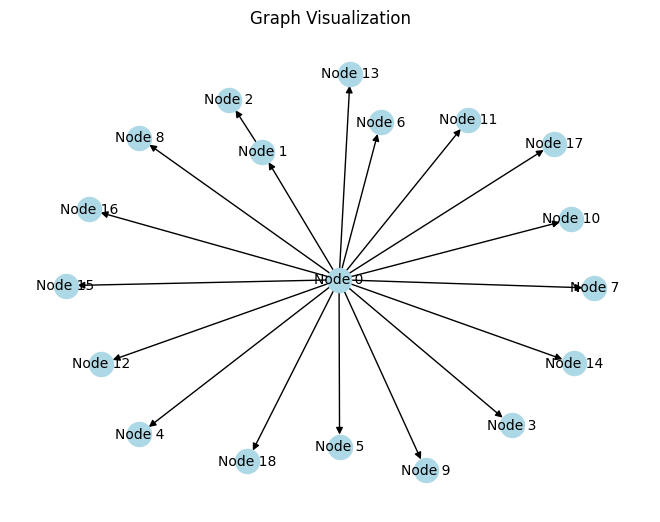

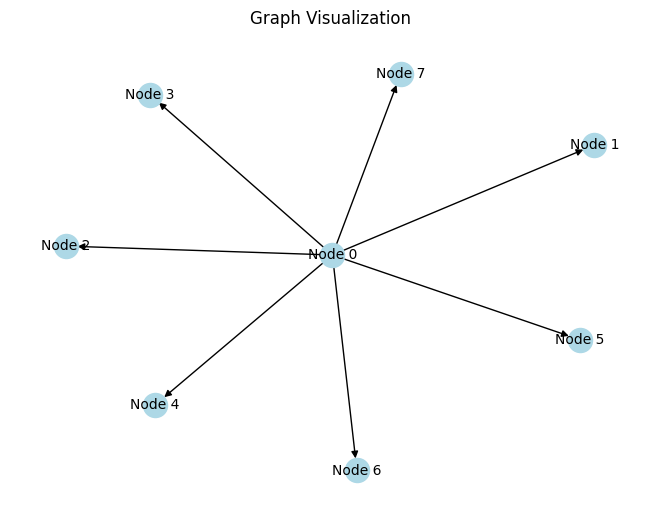

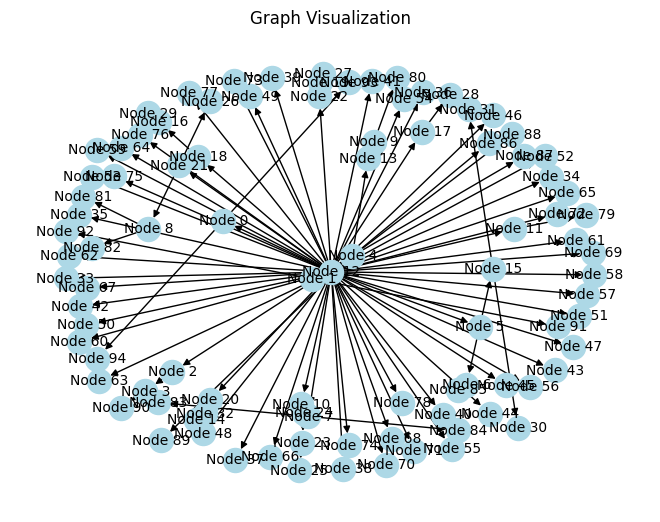

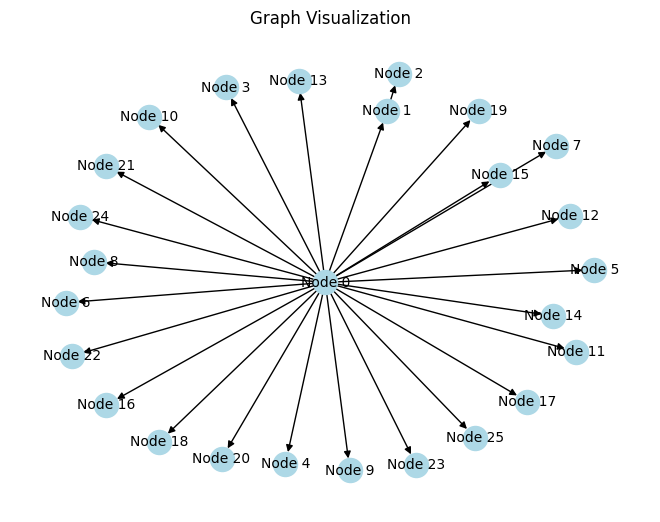

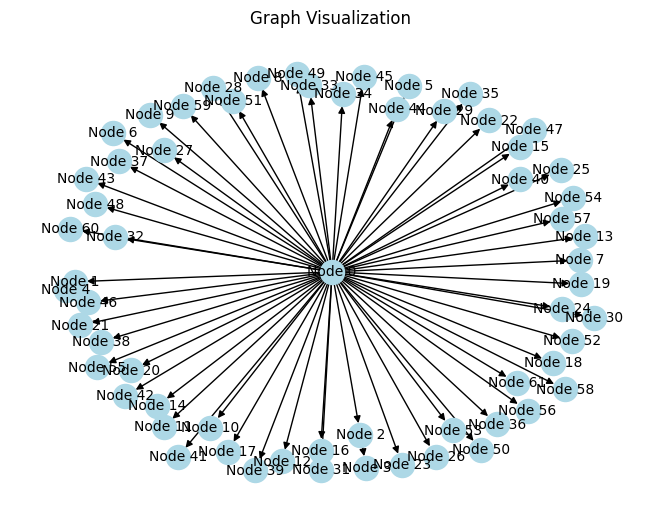

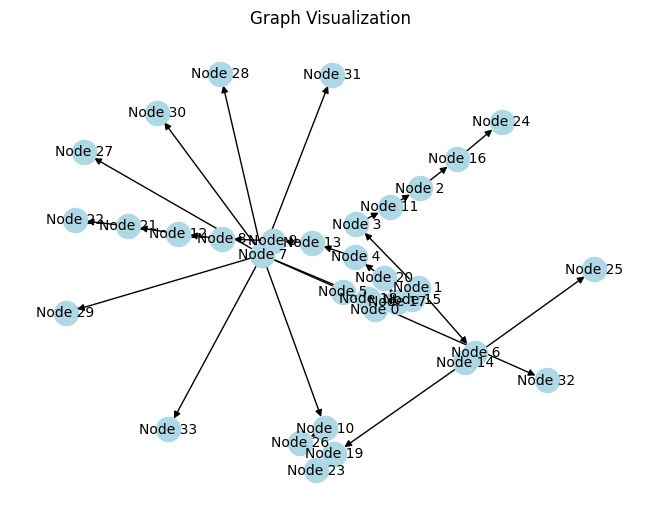

In [ ]:
datas = ['/content/drive/MyDrive/data/Twitter15graph/520338188213444608.npz','/content/drive/MyDrive/data/Twitter15graph/518981379963777025.npz','/content/drive/MyDrive/data/Twitter15graph/521496155310796800.npz','/content/drive/MyDrive/data/Twitter15graph/693214543615561729.npz'
,'/content/drive/MyDrive/data/Twitter15graph/761355585724055553.npz','/content/drive/MyDrive/data/Twitter15graph/387021726007042051.npz']
for data in datas:
  generateGraphPlot(data)

In [ ]:
import sys,os
sys.path.append(os.getcwd())
import torch as th
from torch_scatter import scatter_mean
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import DataLoader
from tqdm import tqdm
from torch_geometric.nn import GCNConv
import copy

class TDrumorGCN(th.nn.Module):
    def __init__(self,in_feats,hid_feats,out_feats):
        super(TDrumorGCN, self).__init__()
        self.conv1 = GCNConv(in_feats, hid_feats)
        self.conv2 = GCNConv(hid_feats+in_feats, out_feats)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x1=copy.copy(x.float())
        x = self.conv1(x, edge_index)
        x2=copy.copy(x)
        rootindex = data.rootindex
        root_extend = th.zeros(len(data.batch), x1.size(1)).to(device)
        batch_size = max(data.batch) + 1
        for num_batch in range(batch_size):
            index = (th.eq(data.batch, num_batch))
            root_extend[index] = x1[rootindex[num_batch]]
        x = th.cat((x,root_extend), 1)

        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        root_extend = th.zeros(len(data.batch), x2.size(1)).to(device)
        for num_batch in range(batch_size):
            index = (th.eq(data.batch, num_batch))
            root_extend[index] = x2[rootindex[num_batch]]
        x = th.cat((x,root_extend), 1)
        x= scatter_mean(x, data.batch, dim=0)

        return x

class BUrumorGCN(th.nn.Module):
    def __init__(self,in_feats,hid_feats,out_feats):
        super(BUrumorGCN, self).__init__()
        self.conv1 = GCNConv(in_feats, hid_feats)
        self.conv2 = GCNConv(hid_feats+in_feats, out_feats)

    def forward(self, data):
        x, edge_index = data.x, data.BU_edge_index
        x1 = copy.copy(x.float())
        x = self.conv1(x, edge_index)
        x2 = copy.copy(x)

        rootindex = data.rootindex
        root_extend = th.zeros(len(data.batch), x1.size(1)).to(device)
        batch_size = max(data.batch) + 1
        for num_batch in range(batch_size):
            index = (th.eq(data.batch, num_batch))
            root_extend[index] = x1[rootindex[num_batch]]
        x = th.cat((x,root_extend), 1)

        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        root_extend = th.zeros(len(data.batch), x2.size(1)).to(device)
        for num_batch in range(batch_size):
            index = (th.eq(data.batch, num_batch))
            root_extend[index] = x2[rootindex[num_batch]]
        x = th.cat((x,root_extend), 1)

        x= scatter_mean(x, data.batch, dim=0)
        return x

class Net(th.nn.Module):
    def __init__(self,in_feats,hid_feats,out_feats):
        super(Net, self).__init__()
        self.TDrumorGCN = TDrumorGCN(in_feats, hid_feats, out_feats)
        self.BUrumorGCN = BUrumorGCN(in_feats, hid_feats, out_feats)
        self.fc=th.nn.Linear((out_feats+hid_feats)*2,4)

    def forward(self, data):
        TD_x = self.TDrumorGCN(data)
        BU_x = self.BUrumorGCN(data)
        x = th.cat((BU_x,TD_x), 1)
        x=self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x


def train_GCN(treeDic, x_test, x_train,TDdroprate,BUdroprate,lr, weight_decay,patience,n_epochs,batchsize,dataname,iter):
    model = Net(5000,64,64).to(device)
    BU_params=list(map(id,model.BUrumorGCN.conv1.parameters()))
    BU_params += list(map(id, model.BUrumorGCN.conv2.parameters()))
    base_params=filter(lambda p:id(p) not in BU_params,model.parameters())
    optimizer = th.optim.Adam([
        {'params':base_params},
        {'params':model.BUrumorGCN.conv1.parameters(),'lr':lr/5},
        {'params': model.BUrumorGCN.conv2.parameters(), 'lr': lr/5}
    ], lr=lr, weight_decay=weight_decay)
    model.train()
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(n_epochs):
        traindata_list, testdata_list = loadBiData(dataname, treeDic, x_train, x_test, TDdroprate,BUdroprate)
        train_loader = DataLoader(traindata_list, batch_size=batchsize, shuffle=True, num_workers=5)
        test_loader = DataLoader(testdata_list, batch_size=batchsize, shuffle=True, num_workers=5)
        avg_loss = []
        avg_acc = []
        batch_idx = 0
        tqdm_train_loader = tqdm(train_loader)
        for Batch_data in tqdm_train_loader:
            Batch_data.to(device)
            out_labels= model(Batch_data)
            finalloss=F.nll_loss(out_labels,Batch_data.y)
            loss=finalloss
            optimizer.zero_grad()
            loss.backward()
            avg_loss.append(loss.item())
            optimizer.step()
            _, pred = out_labels.max(dim=-1)
            correct = pred.eq(Batch_data.y).sum().item()
            train_acc = correct / len(Batch_data.y)
            avg_acc.append(train_acc)
            print("Iter {:03d} | Epoch {:05d} | Batch{:02d} | Train_Loss {:.4f}| Train_Accuracy {:.4f}".format(iter,epoch, batch_idx,
                                                                                                 loss.item(),
                                                                                                 train_acc))
            batch_idx = batch_idx + 1

        train_losses.append(np.mean(avg_loss))
        train_accs.append(np.mean(avg_acc))

        temp_val_losses = []
        temp_val_accs = []
        temp_val_Acc_all, temp_val_Acc1, temp_val_Prec1, temp_val_Recll1, temp_val_F1, \
        temp_val_Acc2, temp_val_Prec2, temp_val_Recll2, temp_val_F2, \
        temp_val_Acc3, temp_val_Prec3, temp_val_Recll3, temp_val_F3, \
        temp_val_Acc4, temp_val_Prec4, temp_val_Recll4, temp_val_F4 = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
        model.eval()
        tqdm_test_loader = tqdm(test_loader)
        for Batch_data in tqdm_test_loader:
            Batch_data.to(device)
            val_out = model(Batch_data)
            val_loss  = F.nll_loss(val_out, Batch_data.y)
            temp_val_losses.append(val_loss.item())
            _, val_pred = val_out.max(dim=1)
            correct = val_pred.eq(Batch_data.y).sum().item()
            val_acc = correct / len(Batch_data.y)
            Acc_all, Acc1, Prec1, Recll1, F1, Acc2, Prec2, Recll2, F2, Acc3, Prec3, Recll3, F3, Acc4, Prec4, Recll4, F4 = evaluation4class(
                val_pred, Batch_data.y)
            temp_val_Acc_all.append(Acc_all), temp_val_Acc1.append(Acc1), temp_val_Prec1.append(
                Prec1), temp_val_Recll1.append(Recll1), temp_val_F1.append(F1), \
            temp_val_Acc2.append(Acc2), temp_val_Prec2.append(Prec2), temp_val_Recll2.append(
                Recll2), temp_val_F2.append(F2), \
            temp_val_Acc3.append(Acc3), temp_val_Prec3.append(Prec3), temp_val_Recll3.append(
                Recll3), temp_val_F3.append(F3), \
            temp_val_Acc4.append(Acc4), temp_val_Prec4.append(Prec4), temp_val_Recll4.append(
                Recll4), temp_val_F4.append(F4)
            temp_val_accs.append(val_acc)
        val_losses.append(np.mean(temp_val_losses))
        val_accs.append(np.mean(temp_val_accs))
        print("Epoch {:05d} | Val_Loss {:.4f}| Val_Accuracy {:.4f}".format(epoch, np.mean(temp_val_losses),
                                                                           np.mean(temp_val_accs)))

        res = ['acc:{:.4f}'.format(np.mean(temp_val_Acc_all)),
               'C1:{:.4f},{:.4f},{:.4f},{:.4f}'.format(np.mean(temp_val_Acc1), np.mean(temp_val_Prec1),
                                                       np.mean(temp_val_Recll1), np.mean(temp_val_F1)),
               'C2:{:.4f},{:.4f},{:.4f},{:.4f}'.format(np.mean(temp_val_Acc2), np.mean(temp_val_Prec2),
                                                       np.mean(temp_val_Recll2), np.mean(temp_val_F2)),
               'C3:{:.4f},{:.4f},{:.4f},{:.4f}'.format(np.mean(temp_val_Acc3), np.mean(temp_val_Prec3),
                                                       np.mean(temp_val_Recll3), np.mean(temp_val_F3)),
               'C4:{:.4f},{:.4f},{:.4f},{:.4f}'.format(np.mean(temp_val_Acc4), np.mean(temp_val_Prec4),
                                                       np.mean(temp_val_Recll4), np.mean(temp_val_F4))]
        print('results:', res)
        early_stopping(np.mean(temp_val_losses), np.mean(temp_val_accs), np.mean(temp_val_F1), np.mean(temp_val_F2),
                       np.mean(temp_val_F3), np.mean(temp_val_F4), model, 'BiGCN', dataname)
        accs =np.mean(temp_val_accs)
        F1 = np.mean(temp_val_F1)
        F2 = np.mean(temp_val_F2)
        F3 = np.mean(temp_val_F3)
        F4 = np.mean(temp_val_F4)
        if early_stopping.early_stop:
            print ("Early stopping")
            accs=early_stopping.accs
            F1=early_stopping.F1
            F2 = early_stopping.F2
            F3 = early_stopping.F3
            F4 = early_stopping.F4
            break
    return train_losses , val_losses ,train_accs, val_accs,accs,F1,F2,F3,F4

lr=0.0005
weight_decay=1e-4
patience=10
n_epochs=5
batchsize=12
TDdroprate=0.2
BUdroprate=0.2
datasetname="Twitter15" #"Twitter15"、"Twitter16"
iterations=1
model="GCN"
if th.cuda.is_available():
  print("yes cuda is available")
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
test_accs = []
NR_F1 = []
FR_F1 = []
TR_F1 = []
UR_F1 = []
for iter in range(iterations):
    fold0_x_test, fold0_x_train, \
    fold1_x_test,  fold1_x_train,  \
    fold2_x_test, fold2_x_train, \
    fold3_x_test, fold3_x_train, \
    fold4_x_test,fold4_x_train = load5foldData(datasetname)
    treeDic=loadTree(datasetname)
    train_losses, val_losses, train_accs, val_accs0, accs0, F1_0, F2_0, F3_0, F4_0 = train_GCN(treeDic,
                                                                                               fold0_x_test,
                                                                                               fold0_x_train,
                                                                                               TDdroprate,BUdroprate,
                                                                                               lr, weight_decay,
                                                                                               patience,
                                                                                               n_epochs,
                                                                                               batchsize,
                                                                                               datasetname,
                                                                                               iter)
    train_losses, val_losses, train_accs, val_accs1, accs1, F1_1, F2_1, F3_1, F4_1 = train_GCN(treeDic,
                                                                                               fold1_x_test,
                                                                                               fold1_x_train,
                                                                                               TDdroprate,BUdroprate, lr,
                                                                                               weight_decay,
                                                                                               patience,
                                                                                               n_epochs,
                                                                                               batchsize,
                                                                                               datasetname,
                                                                                               iter)
    train_losses, val_losses, train_accs, val_accs2, accs2, F1_2, F2_2, F3_2, F4_2 = train_GCN(treeDic,
                                                                                               fold2_x_test,
                                                                                               fold2_x_train,
                                                                                               TDdroprate,BUdroprate, lr,
                                                                                               weight_decay,
                                                                                               patience,
                                                                                               n_epochs,
                                                                                               batchsize,
                                                                                               datasetname,
                                                                                               iter)
    train_losses, val_losses, train_accs, val_accs3, accs3, F1_3, F2_3, F3_3, F4_3 = train_GCN(treeDic,
                                                                                               fold3_x_test,
                                                                                               fold3_x_train,
                                                                                               TDdroprate,BUdroprate, lr,
                                                                                               weight_decay,
                                                                                               patience,
                                                                                               n_epochs,
                                                                                               batchsize,
                                                                                               datasetname,
                                                                                               iter)
    train_losses, val_losses, train_accs, val_accs4, accs4, F1_4, F2_4, F3_4, F4_4 = train_GCN(treeDic,
                                                                                               fold4_x_test,
                                                                                               fold4_x_train,
                                                                                               TDdroprate,BUdroprate, lr,
                                                                                               weight_decay,
                                                                                               patience,
                                                                                               n_epochs,
                                                                                               batchsize,
                                                                                               datasetname,
                                                                                               iter)
    test_accs.append((accs0+accs1+accs2+accs3+accs4)/5)
    NR_F1.append((F1_0+F1_1+F1_2+F1_3+F1_4)/5)
    FR_F1.append((F2_0 + F2_1 + F2_2 + F2_3 + F2_4) / 5)
    TR_F1.append((F3_0 + F3_1 + F3_2 + F3_3 + F3_4) / 5)
    UR_F1.append((F4_0 + F4_1 + F4_2 + F4_3 + F4_4) / 5)
print("Total_Test_Accuracy: {:.4f}|NR F1: {:.4f}|FR F1: {:.4f}|TR F1: {:.4f}|UR F1: {:.4f}".format(
    sum(test_accs) / iterations, sum(NR_F1) /iterations, sum(FR_F1) /iterations, sum(TR_F1) / iterations, sum(UR_F1) / iterations))




yes cuda is available
loading tree label
1490
374 370 372 374
reading twitter tree
tree no: 3098
loading train set
train no: 1178
loading test set
test no: 292


  2%|▏         | 2/99 [00:03<02:41,  1.66s/it]

Iter 000 | Epoch 00000 | Batch00 | Train_Loss 1.3572| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch01 | Train_Loss 1.3787| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch02 | Train_Loss 1.3584| Train_Accuracy 0.4167


  5%|▌         | 5/99 [00:04<00:48,  1.95it/s]

Iter 000 | Epoch 00000 | Batch03 | Train_Loss 1.3350| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch04 | Train_Loss 1.3990| Train_Accuracy 0.3333


  7%|▋         | 7/99 [00:04<00:29,  3.15it/s]

Iter 000 | Epoch 00000 | Batch05 | Train_Loss 1.3758| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch06 | Train_Loss 1.3141| Train_Accuracy 0.3333


  9%|▉         | 9/99 [00:04<00:21,  4.16it/s]

Iter 000 | Epoch 00000 | Batch07 | Train_Loss 1.3987| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch08 | Train_Loss 1.3972| Train_Accuracy 0.2500


 12%|█▏        | 12/99 [00:05<00:12,  6.77it/s]

Iter 000 | Epoch 00000 | Batch09 | Train_Loss 1.3761| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch10 | Train_Loss 1.3570| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch11 | Train_Loss 1.3546| Train_Accuracy 0.3333


 15%|█▌        | 15/99 [00:05<00:09,  8.54it/s]

Iter 000 | Epoch 00000 | Batch12 | Train_Loss 1.3268| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch13 | Train_Loss 1.4021| Train_Accuracy 0.0833
Iter 000 | Epoch 00000 | Batch14 | Train_Loss 1.3743| Train_Accuracy 0.2500


 17%|█▋        | 17/99 [00:05<00:09,  8.53it/s]

Iter 000 | Epoch 00000 | Batch15 | Train_Loss 1.3595| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch16 | Train_Loss 1.3038| Train_Accuracy 0.5000


 19%|█▉        | 19/99 [00:05<00:10,  7.84it/s]

Iter 000 | Epoch 00000 | Batch17 | Train_Loss 1.4578| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch18 | Train_Loss 1.3475| Train_Accuracy 0.1667


 22%|██▏       | 22/99 [00:06<00:08,  9.15it/s]

Iter 000 | Epoch 00000 | Batch19 | Train_Loss 1.4546| Train_Accuracy 0.0833
Iter 000 | Epoch 00000 | Batch20 | Train_Loss 1.3957| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch21 | Train_Loss 1.3950| Train_Accuracy 0.1667


 24%|██▍       | 24/99 [00:06<00:07, 10.05it/s]

Iter 000 | Epoch 00000 | Batch22 | Train_Loss 1.3973| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch23 | Train_Loss 1.3719| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch24 | Train_Loss 1.3905| Train_Accuracy 0.1667


 28%|██▊       | 28/99 [00:06<00:06, 10.24it/s]

Iter 000 | Epoch 00000 | Batch25 | Train_Loss 1.3335| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch26 | Train_Loss 1.2947| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch27 | Train_Loss 1.3093| Train_Accuracy 0.5000


 30%|███       | 30/99 [00:06<00:06, 10.16it/s]

Iter 000 | Epoch 00000 | Batch28 | Train_Loss 1.3652| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch29 | Train_Loss 1.3591| Train_Accuracy 0.3333


 32%|███▏      | 32/99 [00:07<00:06, 10.69it/s]

Iter 000 | Epoch 00000 | Batch30 | Train_Loss 1.3317| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch31 | Train_Loss 1.3861| Train_Accuracy 0.2500


 34%|███▍      | 34/99 [00:07<00:07,  8.75it/s]

Iter 000 | Epoch 00000 | Batch32 | Train_Loss 1.3592| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch33 | Train_Loss 1.2994| Train_Accuracy 0.5833


 35%|███▌      | 35/99 [00:07<00:08,  7.60it/s]

Iter 000 | Epoch 00000 | Batch34 | Train_Loss 1.3946| Train_Accuracy 0.1667


 37%|███▋      | 37/99 [00:07<00:09,  6.84it/s]

Iter 000 | Epoch 00000 | Batch35 | Train_Loss 1.3970| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch36 | Train_Loss 1.3488| Train_Accuracy 0.5000


 39%|███▉      | 39/99 [00:08<00:08,  6.78it/s]

Iter 000 | Epoch 00000 | Batch37 | Train_Loss 1.3500| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch38 | Train_Loss 1.3712| Train_Accuracy 0.2500


 41%|████▏     | 41/99 [00:08<00:08,  6.59it/s]

Iter 000 | Epoch 00000 | Batch39 | Train_Loss 1.3340| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch40 | Train_Loss 1.3635| Train_Accuracy 0.2500


 43%|████▎     | 43/99 [00:08<00:08,  6.49it/s]

Iter 000 | Epoch 00000 | Batch41 | Train_Loss 1.3605| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch42 | Train_Loss 1.2805| Train_Accuracy 0.4167


 45%|████▌     | 45/99 [00:09<00:09,  5.94it/s]

Iter 000 | Epoch 00000 | Batch43 | Train_Loss 1.3338| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch44 | Train_Loss 1.3425| Train_Accuracy 0.5000


 46%|████▋     | 46/99 [00:09<00:08,  6.51it/s]

Iter 000 | Epoch 00000 | Batch45 | Train_Loss 1.2807| Train_Accuracy 0.4167


 47%|████▋     | 47/99 [00:09<00:09,  5.40it/s]

Iter 000 | Epoch 00000 | Batch46 | Train_Loss 1.2903| Train_Accuracy 0.3333


 49%|████▉     | 49/99 [00:10<00:09,  5.18it/s]

Iter 000 | Epoch 00000 | Batch47 | Train_Loss 1.3788| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch48 | Train_Loss 1.3201| Train_Accuracy 0.4167


 51%|█████     | 50/99 [00:10<00:08,  5.79it/s]

Iter 000 | Epoch 00000 | Batch49 | Train_Loss 1.3468| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch50 | Train_Loss 1.4093| Train_Accuracy 0.3333


 54%|█████▎    | 53/99 [00:10<00:07,  6.49it/s]

Iter 000 | Epoch 00000 | Batch51 | Train_Loss 1.3354| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch52 | Train_Loss 1.3455| Train_Accuracy 0.3333


 56%|█████▌    | 55/99 [00:10<00:06,  6.53it/s]

Iter 000 | Epoch 00000 | Batch53 | Train_Loss 1.3451| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch54 | Train_Loss 1.3048| Train_Accuracy 0.4167


 57%|█████▋    | 56/99 [00:11<00:07,  5.76it/s]

Iter 000 | Epoch 00000 | Batch55 | Train_Loss 1.4208| Train_Accuracy 0.1667


 58%|█████▊    | 57/99 [00:11<00:08,  5.11it/s]

Iter 000 | Epoch 00000 | Batch56 | Train_Loss 1.4543| Train_Accuracy 0.0833


 60%|█████▉    | 59/99 [00:11<00:07,  5.40it/s]

Iter 000 | Epoch 00000 | Batch57 | Train_Loss 1.3891| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch58 | Train_Loss 1.3893| Train_Accuracy 0.2500


 62%|██████▏   | 61/99 [00:12<00:06,  5.64it/s]

Iter 000 | Epoch 00000 | Batch59 | Train_Loss 1.3154| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch60 | Train_Loss 1.3790| Train_Accuracy 0.2500


 64%|██████▎   | 63/99 [00:12<00:05,  6.37it/s]

Iter 000 | Epoch 00000 | Batch61 | Train_Loss 1.2914| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch62 | Train_Loss 1.3382| Train_Accuracy 0.3333


 65%|██████▍   | 64/99 [00:12<00:05,  6.67it/s]

Iter 000 | Epoch 00000 | Batch63 | Train_Loss 1.3722| Train_Accuracy 0.3333


 66%|██████▌   | 65/99 [00:12<00:05,  5.71it/s]

Iter 000 | Epoch 00000 | Batch64 | Train_Loss 1.3431| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch65 | Train_Loss 1.2907| Train_Accuracy 0.6667


 69%|██████▊   | 68/99 [00:13<00:04,  6.27it/s]

Iter 000 | Epoch 00000 | Batch66 | Train_Loss 1.3432| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch67 | Train_Loss 1.2581| Train_Accuracy 0.5000


 70%|██████▉   | 69/99 [00:13<00:04,  6.70it/s]

Iter 000 | Epoch 00000 | Batch68 | Train_Loss 1.2313| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch69 | Train_Loss 1.3457| Train_Accuracy 0.3333


 73%|███████▎  | 72/99 [00:13<00:03,  7.79it/s]

Iter 000 | Epoch 00000 | Batch70 | Train_Loss 1.3156| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch71 | Train_Loss 1.2202| Train_Accuracy 0.7500


 75%|███████▍  | 74/99 [00:13<00:03,  8.11it/s]

Iter 000 | Epoch 00000 | Batch72 | Train_Loss 1.3620| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch73 | Train_Loss 1.2387| Train_Accuracy 0.8333


 78%|███████▊  | 77/99 [00:14<00:02,  8.96it/s]

Iter 000 | Epoch 00000 | Batch74 | Train_Loss 1.3685| Train_Accuracy 0.0833
Iter 000 | Epoch 00000 | Batch75 | Train_Loss 1.3063| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch76 | Train_Loss 1.3277| Train_Accuracy 0.4167


 81%|████████  | 80/99 [00:14<00:01,  9.92it/s]

Iter 000 | Epoch 00000 | Batch77 | Train_Loss 1.3198| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch78 | Train_Loss 1.3222| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch79 | Train_Loss 1.2831| Train_Accuracy 0.5833


 83%|████████▎ | 82/99 [00:14<00:01,  9.76it/s]

Iter 000 | Epoch 00000 | Batch80 | Train_Loss 1.3395| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch81 | Train_Loss 1.3185| Train_Accuracy 0.5000


 84%|████████▍ | 83/99 [00:14<00:01,  8.30it/s]

Iter 000 | Epoch 00000 | Batch82 | Train_Loss 1.3232| Train_Accuracy 0.5833


 86%|████████▌ | 85/99 [00:15<00:02,  6.57it/s]

Iter 000 | Epoch 00000 | Batch83 | Train_Loss 1.3176| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch84 | Train_Loss 1.3091| Train_Accuracy 0.3333


 88%|████████▊ | 87/99 [00:15<00:01,  6.91it/s]

Iter 000 | Epoch 00000 | Batch85 | Train_Loss 1.2705| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch86 | Train_Loss 1.1659| Train_Accuracy 0.8333


 91%|█████████ | 90/99 [00:15<00:00,  9.21it/s]

Iter 000 | Epoch 00000 | Batch87 | Train_Loss 1.2275| Train_Accuracy 0.7500
Iter 000 | Epoch 00000 | Batch88 | Train_Loss 1.2415| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch89 | Train_Loss 1.3009| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch90 | Train_Loss 1.1531| Train_Accuracy 0.7500


 95%|█████████▍| 94/99 [00:15<00:00, 11.98it/s]

Iter 000 | Epoch 00000 | Batch91 | Train_Loss 1.2396| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch92 | Train_Loss 1.2222| Train_Accuracy 0.8333
Iter 000 | Epoch 00000 | Batch93 | Train_Loss 1.2516| Train_Accuracy 0.5833


 97%|█████████▋| 96/99 [00:16<00:00, 12.80it/s]

Iter 000 | Epoch 00000 | Batch94 | Train_Loss 1.2088| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch95 | Train_Loss 1.2556| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch96 | Train_Loss 1.2507| Train_Accuracy 0.5000


100%|██████████| 99/99 [00:16<00:00,  6.02it/s]


Iter 000 | Epoch 00000 | Batch97 | Train_Loss 1.2555| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch98 | Train_Loss 1.3413| Train_Accuracy 0.5000


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Epoch 00000 | Val_Loss 1.2180| Val_Accuracy 0.6900
results: ['acc:0.6900', 'C1:0.7967,0.6414,0.6440,0.6194', 'C2:0.8833,0.7900,0.5693,0.6324', 'C3:0.8533,0.6807,0.8660,0.7229', 'C4:0.8467,0.6360,0.6760,0.6311']
loading train set
train no: 1178
loading test set
test no: 292


  1%|          | 1/99 [00:00<01:01,  1.58it/s]

Iter 000 | Epoch 00001 | Batch00 | Train_Loss 1.1461| Train_Accuracy 0.7500


  3%|▎         | 3/99 [00:00<00:26,  3.67it/s]

Iter 000 | Epoch 00001 | Batch01 | Train_Loss 1.1661| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch02 | Train_Loss 1.1437| Train_Accuracy 0.6667


  5%|▌         | 5/99 [00:01<00:18,  5.15it/s]

Iter 000 | Epoch 00001 | Batch03 | Train_Loss 1.2204| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch04 | Train_Loss 1.2757| Train_Accuracy 0.7500


  8%|▊         | 8/99 [00:01<00:11,  7.63it/s]

Iter 000 | Epoch 00001 | Batch05 | Train_Loss 1.2346| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch06 | Train_Loss 1.1758| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch07 | Train_Loss 0.9801| Train_Accuracy 1.0000


 10%|█         | 10/99 [00:01<00:09,  9.06it/s]

Iter 000 | Epoch 00001 | Batch08 | Train_Loss 1.1453| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch09 | Train_Loss 1.0281| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch10 | Train_Loss 1.1588| Train_Accuracy 0.6667


 12%|█▏        | 12/99 [00:01<00:09,  9.22it/s]

Iter 000 | Epoch 00001 | Batch11 | Train_Loss 1.1115| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch12 | Train_Loss 1.0936| Train_Accuracy 0.7500


 14%|█▍        | 14/99 [00:02<00:09,  8.94it/s]

Iter 000 | Epoch 00001 | Batch13 | Train_Loss 1.1789| Train_Accuracy 0.5000
Iter 000 | Epoch 00001 | Batch14 | Train_Loss 1.0733| Train_Accuracy 0.9167


 17%|█▋        | 17/99 [00:02<00:09,  9.09it/s]

Iter 000 | Epoch 00001 | Batch15 | Train_Loss 1.1071| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch16 | Train_Loss 1.0330| Train_Accuracy 0.9167


 19%|█▉        | 19/99 [00:02<00:08,  8.90it/s]

Iter 000 | Epoch 00001 | Batch17 | Train_Loss 1.0181| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch18 | Train_Loss 1.1840| Train_Accuracy 0.7500


 22%|██▏       | 22/99 [00:03<00:07, 10.35it/s]

Iter 000 | Epoch 00001 | Batch19 | Train_Loss 1.0722| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch20 | Train_Loss 1.1485| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch21 | Train_Loss 1.1621| Train_Accuracy 0.7500


 24%|██▍       | 24/99 [00:03<00:07,  9.95it/s]

Iter 000 | Epoch 00001 | Batch22 | Train_Loss 1.0874| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch23 | Train_Loss 0.9099| Train_Accuracy 1.0000


 26%|██▋       | 26/99 [00:03<00:08,  8.17it/s]

Iter 000 | Epoch 00001 | Batch24 | Train_Loss 1.0919| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch25 | Train_Loss 1.0461| Train_Accuracy 0.8333


 28%|██▊       | 28/99 [00:03<00:10,  6.76it/s]

Iter 000 | Epoch 00001 | Batch26 | Train_Loss 1.0892| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch27 | Train_Loss 1.0947| Train_Accuracy 0.7500


 30%|███       | 30/99 [00:04<00:10,  6.48it/s]

Iter 000 | Epoch 00001 | Batch28 | Train_Loss 1.0334| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch29 | Train_Loss 1.0284| Train_Accuracy 0.9167


 31%|███▏      | 31/99 [00:04<00:09,  6.81it/s]

Iter 000 | Epoch 00001 | Batch30 | Train_Loss 1.0862| Train_Accuracy 0.7500


 33%|███▎      | 33/99 [00:04<00:10,  6.60it/s]

Iter 000 | Epoch 00001 | Batch31 | Train_Loss 0.9208| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch32 | Train_Loss 1.0005| Train_Accuracy 0.9167


 35%|███▌      | 35/99 [00:05<00:10,  5.93it/s]

Iter 000 | Epoch 00001 | Batch33 | Train_Loss 0.9982| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch34 | Train_Loss 1.1213| Train_Accuracy 0.6667


 36%|███▋      | 36/99 [00:05<00:09,  6.49it/s]

Iter 000 | Epoch 00001 | Batch35 | Train_Loss 1.0829| Train_Accuracy 0.6667


 38%|███▊      | 38/99 [00:05<00:10,  6.07it/s]

Iter 000 | Epoch 00001 | Batch36 | Train_Loss 1.0287| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch37 | Train_Loss 0.8330| Train_Accuracy 0.8333


 40%|████      | 40/99 [00:05<00:09,  6.29it/s]

Iter 000 | Epoch 00001 | Batch38 | Train_Loss 1.1365| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch39 | Train_Loss 0.9721| Train_Accuracy 0.8333


 41%|████▏     | 41/99 [00:06<00:08,  6.49it/s]

Iter 000 | Epoch 00001 | Batch40 | Train_Loss 1.0384| Train_Accuracy 0.8333


 43%|████▎     | 43/99 [00:06<00:09,  6.20it/s]

Iter 000 | Epoch 00001 | Batch41 | Train_Loss 0.9902| Train_Accuracy 1.0000
Iter 000 | Epoch 00001 | Batch42 | Train_Loss 0.9996| Train_Accuracy 0.8333


 45%|████▌     | 45/99 [00:06<00:08,  6.07it/s]

Iter 000 | Epoch 00001 | Batch43 | Train_Loss 1.0293| Train_Accuracy 0.5833
Iter 000 | Epoch 00001 | Batch44 | Train_Loss 0.7900| Train_Accuracy 0.9167


 46%|████▋     | 46/99 [00:06<00:08,  6.44it/s]

Iter 000 | Epoch 00001 | Batch45 | Train_Loss 0.9912| Train_Accuracy 0.6667


 48%|████▊     | 48/99 [00:07<00:08,  6.34it/s]

Iter 000 | Epoch 00001 | Batch46 | Train_Loss 0.8725| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch47 | Train_Loss 0.8649| Train_Accuracy 0.7500


 49%|████▉     | 49/99 [00:07<00:07,  6.54it/s]

Iter 000 | Epoch 00001 | Batch48 | Train_Loss 0.8794| Train_Accuracy 0.8333


 52%|█████▏    | 51/99 [00:07<00:07,  6.02it/s]

Iter 000 | Epoch 00001 | Batch49 | Train_Loss 0.9520| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch50 | Train_Loss 0.8884| Train_Accuracy 0.6667


 54%|█████▎    | 53/99 [00:08<00:07,  6.25it/s]

Iter 000 | Epoch 00001 | Batch51 | Train_Loss 0.9891| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch52 | Train_Loss 0.9354| Train_Accuracy 0.5833


 55%|█████▍    | 54/99 [00:08<00:06,  6.70it/s]

Iter 000 | Epoch 00001 | Batch53 | Train_Loss 1.0517| Train_Accuracy 0.5833


 56%|█████▌    | 55/99 [00:08<00:07,  5.65it/s]

Iter 000 | Epoch 00001 | Batch54 | Train_Loss 0.8279| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch55 | Train_Loss 0.9319| Train_Accuracy 0.6667


 59%|█████▊    | 58/99 [00:08<00:06,  6.30it/s]

Iter 000 | Epoch 00001 | Batch56 | Train_Loss 0.9523| Train_Accuracy 0.5833
Iter 000 | Epoch 00001 | Batch57 | Train_Loss 0.9637| Train_Accuracy 0.5833


 61%|██████    | 60/99 [00:09<00:06,  6.20it/s]

Iter 000 | Epoch 00001 | Batch58 | Train_Loss 0.8152| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch59 | Train_Loss 0.7508| Train_Accuracy 1.0000


 64%|██████▎   | 63/99 [00:09<00:04,  8.38it/s]

Iter 000 | Epoch 00001 | Batch60 | Train_Loss 1.0477| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch61 | Train_Loss 1.0048| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch62 | Train_Loss 0.7683| Train_Accuracy 0.7500


 66%|██████▌   | 65/99 [00:09<00:04,  7.89it/s]

Iter 000 | Epoch 00001 | Batch63 | Train_Loss 0.9007| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch64 | Train_Loss 0.8061| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch65 | Train_Loss 0.9841| Train_Accuracy 0.9167


 70%|██████▉   | 69/99 [00:10<00:03,  8.98it/s]

Iter 000 | Epoch 00001 | Batch66 | Train_Loss 0.9137| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch67 | Train_Loss 0.7846| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch68 | Train_Loss 0.8056| Train_Accuracy 0.7500


 72%|███████▏  | 71/99 [00:10<00:02, 10.13it/s]

Iter 000 | Epoch 00001 | Batch69 | Train_Loss 1.0483| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch70 | Train_Loss 0.7946| Train_Accuracy 0.8333


 74%|███████▎  | 73/99 [00:10<00:02,  8.79it/s]

Iter 000 | Epoch 00001 | Batch71 | Train_Loss 0.9453| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch72 | Train_Loss 0.6262| Train_Accuracy 0.9167


 76%|███████▌  | 75/99 [00:10<00:02,  8.65it/s]

Iter 000 | Epoch 00001 | Batch73 | Train_Loss 0.7240| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch74 | Train_Loss 0.6873| Train_Accuracy 0.8333


 79%|███████▉  | 78/99 [00:11<00:02,  9.95it/s]

Iter 000 | Epoch 00001 | Batch75 | Train_Loss 0.7395| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch76 | Train_Loss 0.7276| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch77 | Train_Loss 0.8443| Train_Accuracy 0.8333


 81%|████████  | 80/99 [00:11<00:02,  8.93it/s]

Iter 000 | Epoch 00001 | Batch78 | Train_Loss 0.7103| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch79 | Train_Loss 0.8919| Train_Accuracy 0.7500


 83%|████████▎ | 82/99 [00:11<00:02,  8.38it/s]

Iter 000 | Epoch 00001 | Batch80 | Train_Loss 0.7374| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch81 | Train_Loss 0.6981| Train_Accuracy 0.8333


 85%|████████▍ | 84/99 [00:11<00:01,  9.07it/s]

Iter 000 | Epoch 00001 | Batch82 | Train_Loss 0.6497| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch83 | Train_Loss 0.6644| Train_Accuracy 0.7500


 86%|████████▌ | 85/99 [00:11<00:01,  8.99it/s]

Iter 000 | Epoch 00001 | Batch84 | Train_Loss 0.8937| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch85 | Train_Loss 0.8406| Train_Accuracy 0.6667


 89%|████████▉ | 88/99 [00:12<00:01,  7.02it/s]

Iter 000 | Epoch 00001 | Batch86 | Train_Loss 0.8842| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch87 | Train_Loss 0.8644| Train_Accuracy 0.7500


 91%|█████████ | 90/99 [00:12<00:01,  8.29it/s]

Iter 000 | Epoch 00001 | Batch88 | Train_Loss 0.6669| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch89 | Train_Loss 0.7135| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch90 | Train_Loss 0.5384| Train_Accuracy 0.9167


 95%|█████████▍| 94/99 [00:12<00:00, 10.81it/s]

Iter 000 | Epoch 00001 | Batch91 | Train_Loss 0.6523| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch92 | Train_Loss 0.7681| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch93 | Train_Loss 0.5143| Train_Accuracy 1.0000


 99%|█████████▉| 98/99 [00:13<00:00, 12.67it/s]

Iter 000 | Epoch 00001 | Batch94 | Train_Loss 0.6933| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch95 | Train_Loss 0.7113| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch96 | Train_Loss 0.6882| Train_Accuracy 1.0000
Iter 000 | Epoch 00001 | Batch97 | Train_Loss 0.6847| Train_Accuracy 0.9167


100%|██████████| 99/99 [00:13<00:00,  7.41it/s]


Iter 000 | Epoch 00001 | Batch98 | Train_Loss 1.5587| Train_Accuracy 0.5000


100%|██████████| 25/25 [00:03<00:00,  8.06it/s]


Epoch 00001 | Val_Loss 0.7295| Val_Accuracy 0.7833
results: ['acc:0.7833', 'C1:0.8700,0.7420,0.7760,0.7215', 'C2:0.8900,0.7440,0.7130,0.7040', 'C3:0.9300,0.7687,0.7267,0.7354', 'C4:0.8767,0.7020,0.7611,0.7033']
loading train set
train no: 1178
loading test set
test no: 292


  2%|▏         | 2/99 [00:01<00:43,  2.24it/s]

Iter 000 | Epoch 00002 | Batch00 | Train_Loss 0.6918| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch01 | Train_Loss 0.6286| Train_Accuracy 1.0000


  5%|▌         | 5/99 [00:01<00:16,  5.53it/s]

Iter 000 | Epoch 00002 | Batch02 | Train_Loss 0.4538| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch03 | Train_Loss 0.4816| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch04 | Train_Loss 0.5957| Train_Accuracy 0.9167


  8%|▊         | 8/99 [00:01<00:11,  7.64it/s]

Iter 000 | Epoch 00002 | Batch05 | Train_Loss 0.6107| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch06 | Train_Loss 0.6051| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch07 | Train_Loss 0.4674| Train_Accuracy 0.9167


 10%|█         | 10/99 [00:01<00:11,  7.79it/s]

Iter 000 | Epoch 00002 | Batch08 | Train_Loss 0.5375| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch09 | Train_Loss 0.4247| Train_Accuracy 1.0000


 13%|█▎        | 13/99 [00:02<00:09,  9.02it/s]

Iter 000 | Epoch 00002 | Batch10 | Train_Loss 0.6623| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch11 | Train_Loss 0.5988| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch12 | Train_Loss 0.4945| Train_Accuracy 0.8333


 15%|█▌        | 15/99 [00:02<00:09,  8.96it/s]

Iter 000 | Epoch 00002 | Batch13 | Train_Loss 0.4545| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch14 | Train_Loss 0.4927| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch15 | Train_Loss 0.6217| Train_Accuracy 0.8333


 17%|█▋        | 17/99 [00:02<00:08,  9.26it/s]

Iter 000 | Epoch 00002 | Batch16 | Train_Loss 0.6006| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch17 | Train_Loss 0.5510| Train_Accuracy 1.0000


 20%|██        | 20/99 [00:03<00:10,  7.78it/s]

Iter 000 | Epoch 00002 | Batch18 | Train_Loss 0.4434| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch19 | Train_Loss 0.5989| Train_Accuracy 0.9167


 22%|██▏       | 22/99 [00:03<00:10,  7.35it/s]

Iter 000 | Epoch 00002 | Batch20 | Train_Loss 0.6951| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch21 | Train_Loss 0.3657| Train_Accuracy 1.0000


 24%|██▍       | 24/99 [00:03<00:12,  6.08it/s]

Iter 000 | Epoch 00002 | Batch22 | Train_Loss 0.5675| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch23 | Train_Loss 0.4914| Train_Accuracy 1.0000


 26%|██▋       | 26/99 [00:04<00:11,  6.30it/s]

Iter 000 | Epoch 00002 | Batch24 | Train_Loss 0.4941| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch25 | Train_Loss 0.4981| Train_Accuracy 1.0000


 27%|██▋       | 27/99 [00:04<00:11,  6.49it/s]

Iter 000 | Epoch 00002 | Batch26 | Train_Loss 0.4719| Train_Accuracy 0.9167


 29%|██▉       | 29/99 [00:04<00:12,  5.45it/s]

Iter 000 | Epoch 00002 | Batch27 | Train_Loss 0.4361| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch28 | Train_Loss 0.5997| Train_Accuracy 0.9167


 31%|███▏      | 31/99 [00:04<00:11,  6.04it/s]

Iter 000 | Epoch 00002 | Batch29 | Train_Loss 0.5401| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch30 | Train_Loss 0.5236| Train_Accuracy 1.0000


 33%|███▎      | 33/99 [00:05<00:11,  5.77it/s]

Iter 000 | Epoch 00002 | Batch31 | Train_Loss 0.3732| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch32 | Train_Loss 0.3645| Train_Accuracy 1.0000


 35%|███▌      | 35/99 [00:05<00:09,  7.03it/s]

Iter 000 | Epoch 00002 | Batch33 | Train_Loss 0.5072| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch34 | Train_Loss 0.2892| Train_Accuracy 1.0000


 36%|███▋      | 36/99 [00:05<00:09,  6.53it/s]

Iter 000 | Epoch 00002 | Batch35 | Train_Loss 0.4171| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch36 | Train_Loss 0.4450| Train_Accuracy 0.9167


 39%|███▉      | 39/99 [00:06<00:08,  6.99it/s]

Iter 000 | Epoch 00002 | Batch37 | Train_Loss 0.5122| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch38 | Train_Loss 0.2788| Train_Accuracy 1.0000


 40%|████      | 40/99 [00:06<00:08,  6.68it/s]

Iter 000 | Epoch 00002 | Batch39 | Train_Loss 0.4702| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch40 | Train_Loss 0.4304| Train_Accuracy 1.0000


 43%|████▎     | 43/99 [00:06<00:09,  6.15it/s]

Iter 000 | Epoch 00002 | Batch41 | Train_Loss 0.3862| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch42 | Train_Loss 0.2552| Train_Accuracy 1.0000


 45%|████▌     | 45/99 [00:07<00:08,  6.53it/s]

Iter 000 | Epoch 00002 | Batch43 | Train_Loss 0.5265| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch44 | Train_Loss 0.1837| Train_Accuracy 1.0000


 47%|████▋     | 47/99 [00:07<00:08,  6.43it/s]

Iter 000 | Epoch 00002 | Batch45 | Train_Loss 0.4560| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch46 | Train_Loss 0.2257| Train_Accuracy 0.9167


 48%|████▊     | 48/99 [00:07<00:08,  6.17it/s]

Iter 000 | Epoch 00002 | Batch47 | Train_Loss 0.5402| Train_Accuracy 0.7500
Iter 000 | Epoch 00002 | Batch48 | Train_Loss 0.3978| Train_Accuracy 1.0000


 51%|█████     | 50/99 [00:07<00:06,  7.16it/s]

Iter 000 | Epoch 00002 | Batch49 | Train_Loss 0.5361| Train_Accuracy 0.9167


 53%|█████▎    | 52/99 [00:08<00:07,  5.91it/s]

Iter 000 | Epoch 00002 | Batch50 | Train_Loss 0.3197| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch51 | Train_Loss 0.4187| Train_Accuracy 0.9167


 55%|█████▍    | 54/99 [00:08<00:07,  6.14it/s]

Iter 000 | Epoch 00002 | Batch52 | Train_Loss 0.3876| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch53 | Train_Loss 0.4263| Train_Accuracy 0.9167


 56%|█████▌    | 55/99 [00:08<00:06,  6.80it/s]

Iter 000 | Epoch 00002 | Batch54 | Train_Loss 0.4492| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch55 | Train_Loss 0.3909| Train_Accuracy 1.0000


 59%|█████▊    | 58/99 [00:08<00:05,  7.98it/s]

Iter 000 | Epoch 00002 | Batch56 | Train_Loss 0.5837| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch57 | Train_Loss 0.3157| Train_Accuracy 1.0000


 61%|██████    | 60/99 [00:09<00:04,  8.03it/s]

Iter 000 | Epoch 00002 | Batch58 | Train_Loss 0.4720| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch59 | Train_Loss 0.3315| Train_Accuracy 1.0000


 62%|██████▏   | 61/99 [00:09<00:04,  8.26it/s]

Iter 000 | Epoch 00002 | Batch60 | Train_Loss 0.3911| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch61 | Train_Loss 0.3338| Train_Accuracy 0.9167


 66%|██████▌   | 65/99 [00:09<00:03,  9.37it/s]

Iter 000 | Epoch 00002 | Batch62 | Train_Loss 0.3395| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch63 | Train_Loss 0.4416| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch64 | Train_Loss 0.3410| Train_Accuracy 0.8333


 67%|██████▋   | 66/99 [00:09<00:04,  8.20it/s]

Iter 000 | Epoch 00002 | Batch65 | Train_Loss 0.4068| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch66 | Train_Loss 0.6074| Train_Accuracy 0.9167


 69%|██████▊   | 68/99 [00:10<00:03,  8.60it/s]

Iter 000 | Epoch 00002 | Batch67 | Train_Loss 0.5722| Train_Accuracy 0.7500
Iter 000 | Epoch 00002 | Batch68 | Train_Loss 0.6585| Train_Accuracy 0.7500


 73%|███████▎  | 72/99 [00:10<00:02,  9.22it/s]

Iter 000 | Epoch 00002 | Batch69 | Train_Loss 0.2225| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch70 | Train_Loss 0.4230| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch71 | Train_Loss 0.3286| Train_Accuracy 1.0000


 74%|███████▎  | 73/99 [00:10<00:02,  9.13it/s]

Iter 000 | Epoch 00002 | Batch72 | Train_Loss 0.3868| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch73 | Train_Loss 0.2564| Train_Accuracy 1.0000


 77%|███████▋  | 76/99 [00:11<00:02,  8.55it/s]

Iter 000 | Epoch 00002 | Batch74 | Train_Loss 0.3706| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch75 | Train_Loss 0.5111| Train_Accuracy 0.9167


 79%|███████▉  | 78/99 [00:11<00:02,  8.86it/s]

Iter 000 | Epoch 00002 | Batch76 | Train_Loss 0.3210| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch77 | Train_Loss 0.4195| Train_Accuracy 0.9167


 82%|████████▏ | 81/99 [00:11<00:01,  9.31it/s]

Iter 000 | Epoch 00002 | Batch78 | Train_Loss 0.2770| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch79 | Train_Loss 0.2550| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch80 | Train_Loss 0.3080| Train_Accuracy 1.0000


 84%|████████▍ | 83/99 [00:11<00:01,  9.06it/s]

Iter 000 | Epoch 00002 | Batch81 | Train_Loss 0.4247| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch82 | Train_Loss 0.3457| Train_Accuracy 1.0000


 86%|████████▌ | 85/99 [00:12<00:01,  9.45it/s]

Iter 000 | Epoch 00002 | Batch83 | Train_Loss 0.4931| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch84 | Train_Loss 0.3121| Train_Accuracy 0.8333


 89%|████████▉ | 88/99 [00:12<00:01,  9.98it/s]

Iter 000 | Epoch 00002 | Batch85 | Train_Loss 0.4556| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch86 | Train_Loss 0.4536| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch87 | Train_Loss 0.2789| Train_Accuracy 1.0000


 92%|█████████▏| 91/99 [00:12<00:00, 11.17it/s]

Iter 000 | Epoch 00002 | Batch88 | Train_Loss 0.3101| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch89 | Train_Loss 0.3152| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch90 | Train_Loss 0.4289| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch91 | Train_Loss 0.3828| Train_Accuracy 0.8333


 96%|█████████▌| 95/99 [00:12<00:00, 13.88it/s]

Iter 000 | Epoch 00002 | Batch92 | Train_Loss 0.4538| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch93 | Train_Loss 0.2575| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch94 | Train_Loss 0.4384| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch95 | Train_Loss 0.2620| Train_Accuracy 0.9167


 98%|█████████▊| 97/99 [00:12<00:00, 13.72it/s]

Iter 000 | Epoch 00002 | Batch96 | Train_Loss 0.4093| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch97 | Train_Loss 0.3237| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch98 | Train_Loss 0.5644| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:03<00:00,  7.95it/s]


Epoch 00002 | Val_Loss 0.5307| Val_Accuracy 0.8233
results: ['acc:0.8233', 'C1:0.8900,0.7687,0.8533,0.7773', 'C2:0.9133,0.7807,0.7519,0.7392', 'C3:0.9467,0.8686,0.8940,0.8677', 'C4:0.8967,0.7673,0.6867,0.7010']
loading train set
train no: 1178
loading test set
test no: 292


  3%|▎         | 3/99 [00:01<00:31,  3.03it/s]

Iter 000 | Epoch 00003 | Batch00 | Train_Loss 0.1113| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch01 | Train_Loss 0.2975| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch02 | Train_Loss 0.2076| Train_Accuracy 1.0000


  5%|▌         | 5/99 [00:01<00:18,  4.96it/s]

Iter 000 | Epoch 00003 | Batch03 | Train_Loss 0.1674| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch04 | Train_Loss 0.1633| Train_Accuracy 1.0000


  7%|▋         | 7/99 [00:01<00:14,  6.53it/s]

Iter 000 | Epoch 00003 | Batch05 | Train_Loss 0.1356| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch06 | Train_Loss 0.2042| Train_Accuracy 1.0000


  9%|▉         | 9/99 [00:01<00:10,  8.35it/s]

Iter 000 | Epoch 00003 | Batch07 | Train_Loss 0.3293| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch08 | Train_Loss 0.2395| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch09 | Train_Loss 0.2168| Train_Accuracy 1.0000


 11%|█         | 11/99 [00:01<00:09,  9.54it/s]

Iter 000 | Epoch 00003 | Batch10 | Train_Loss 0.1976| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch11 | Train_Loss 0.1892| Train_Accuracy 1.0000


 14%|█▍        | 14/99 [00:02<00:09,  8.58it/s]

Iter 000 | Epoch 00003 | Batch12 | Train_Loss 0.3386| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch13 | Train_Loss 0.2930| Train_Accuracy 0.9167


 15%|█▌        | 15/99 [00:02<00:13,  6.44it/s]

Iter 000 | Epoch 00003 | Batch14 | Train_Loss 0.1975| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch15 | Train_Loss 0.2317| Train_Accuracy 1.0000


 18%|█▊        | 18/99 [00:03<00:12,  6.66it/s]

Iter 000 | Epoch 00003 | Batch16 | Train_Loss 0.2072| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch17 | Train_Loss 0.1283| Train_Accuracy 1.0000


 20%|██        | 20/99 [00:03<00:12,  6.57it/s]

Iter 000 | Epoch 00003 | Batch18 | Train_Loss 0.3889| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch19 | Train_Loss 0.2259| Train_Accuracy 1.0000


 22%|██▏       | 22/99 [00:03<00:13,  5.57it/s]

Iter 000 | Epoch 00003 | Batch20 | Train_Loss 0.2406| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch21 | Train_Loss 0.2351| Train_Accuracy 1.0000


 24%|██▍       | 24/99 [00:04<00:11,  6.26it/s]

Iter 000 | Epoch 00003 | Batch22 | Train_Loss 0.1363| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch23 | Train_Loss 0.2227| Train_Accuracy 0.9167


 26%|██▋       | 26/99 [00:04<00:12,  5.95it/s]

Iter 000 | Epoch 00003 | Batch24 | Train_Loss 0.0800| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch25 | Train_Loss 0.1823| Train_Accuracy 1.0000


 28%|██▊       | 28/99 [00:04<00:11,  6.09it/s]

Iter 000 | Epoch 00003 | Batch26 | Train_Loss 0.2149| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch27 | Train_Loss 0.1652| Train_Accuracy 1.0000


 30%|███       | 30/99 [00:05<00:11,  5.86it/s]

Iter 000 | Epoch 00003 | Batch28 | Train_Loss 0.1190| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch29 | Train_Loss 0.3141| Train_Accuracy 0.8333


 32%|███▏      | 32/99 [00:05<00:11,  6.06it/s]

Iter 000 | Epoch 00003 | Batch30 | Train_Loss 0.1989| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch31 | Train_Loss 0.2385| Train_Accuracy 1.0000


 34%|███▍      | 34/99 [00:05<00:11,  5.79it/s]

Iter 000 | Epoch 00003 | Batch32 | Train_Loss 0.2154| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch33 | Train_Loss 0.2949| Train_Accuracy 0.9167


 35%|███▌      | 35/99 [00:05<00:11,  5.81it/s]

Iter 000 | Epoch 00003 | Batch34 | Train_Loss 0.2555| Train_Accuracy 0.9167


 37%|███▋      | 37/99 [00:06<00:10,  5.67it/s]

Iter 000 | Epoch 00003 | Batch35 | Train_Loss 0.2203| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch36 | Train_Loss 0.2259| Train_Accuracy 1.0000


 39%|███▉      | 39/99 [00:06<00:11,  5.41it/s]

Iter 000 | Epoch 00003 | Batch37 | Train_Loss 0.1747| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch38 | Train_Loss 0.2829| Train_Accuracy 0.8333


 41%|████▏     | 41/99 [00:07<00:09,  5.90it/s]

Iter 000 | Epoch 00003 | Batch39 | Train_Loss 0.1638| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch40 | Train_Loss 0.1690| Train_Accuracy 1.0000


 42%|████▏     | 42/99 [00:07<00:09,  6.18it/s]

Iter 000 | Epoch 00003 | Batch41 | Train_Loss 0.3462| Train_Accuracy 0.9167


 44%|████▍     | 44/99 [00:07<00:09,  5.56it/s]

Iter 000 | Epoch 00003 | Batch42 | Train_Loss 0.3315| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch43 | Train_Loss 0.1548| Train_Accuracy 1.0000


 46%|████▋     | 46/99 [00:07<00:08,  6.48it/s]

Iter 000 | Epoch 00003 | Batch44 | Train_Loss 0.3461| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch45 | Train_Loss 0.2720| Train_Accuracy 1.0000


 48%|████▊     | 48/99 [00:08<00:06,  7.75it/s]

Iter 000 | Epoch 00003 | Batch46 | Train_Loss 0.1360| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch47 | Train_Loss 0.1754| Train_Accuracy 1.0000


 51%|█████     | 50/99 [00:08<00:05,  9.13it/s]

Iter 000 | Epoch 00003 | Batch48 | Train_Loss 0.1443| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch49 | Train_Loss 0.2373| Train_Accuracy 0.9167


 54%|█████▎    | 53/99 [00:08<00:05,  8.93it/s]

Iter 000 | Epoch 00003 | Batch50 | Train_Loss 0.1022| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch51 | Train_Loss 0.2168| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch52 | Train_Loss 0.1811| Train_Accuracy 1.0000


 57%|█████▋    | 56/99 [00:08<00:04, 10.00it/s]

Iter 000 | Epoch 00003 | Batch53 | Train_Loss 0.2656| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch54 | Train_Loss 0.1192| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch55 | Train_Loss 0.1996| Train_Accuracy 1.0000


 59%|█████▊    | 58/99 [00:09<00:04,  9.29it/s]

Iter 000 | Epoch 00003 | Batch56 | Train_Loss 0.0971| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch57 | Train_Loss 0.2413| Train_Accuracy 1.0000


 61%|██████    | 60/99 [00:09<00:04,  8.66it/s]

Iter 000 | Epoch 00003 | Batch58 | Train_Loss 0.2615| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch59 | Train_Loss 0.1035| Train_Accuracy 1.0000


 64%|██████▎   | 63/99 [00:09<00:03,  9.88it/s]

Iter 000 | Epoch 00003 | Batch60 | Train_Loss 0.1297| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch61 | Train_Loss 0.1783| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch62 | Train_Loss 0.1462| Train_Accuracy 1.0000


 66%|██████▌   | 65/99 [00:09<00:03, 10.32it/s]

Iter 000 | Epoch 00003 | Batch63 | Train_Loss 0.0858| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch64 | Train_Loss 0.0749| Train_Accuracy 1.0000


 68%|██████▊   | 67/99 [00:10<00:03,  9.23it/s]

Iter 000 | Epoch 00003 | Batch65 | Train_Loss 0.1943| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch66 | Train_Loss 0.2963| Train_Accuracy 0.9167


 70%|██████▉   | 69/99 [00:10<00:03,  9.24it/s]

Iter 000 | Epoch 00003 | Batch67 | Train_Loss 0.1669| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch68 | Train_Loss 0.1316| Train_Accuracy 1.0000


 72%|███████▏  | 71/99 [00:10<00:02,  9.79it/s]

Iter 000 | Epoch 00003 | Batch69 | Train_Loss 0.1755| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch70 | Train_Loss 0.0412| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch71 | Train_Loss 0.0448| Train_Accuracy 1.0000


 75%|███████▍  | 74/99 [00:10<00:02,  9.69it/s]

Iter 000 | Epoch 00003 | Batch72 | Train_Loss 0.3918| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch73 | Train_Loss 0.1509| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch74 | Train_Loss 0.0944| Train_Accuracy 1.0000


 78%|███████▊  | 77/99 [00:11<00:02,  9.40it/s]

Iter 000 | Epoch 00003 | Batch75 | Train_Loss 0.1491| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch76 | Train_Loss 0.2060| Train_Accuracy 1.0000


 80%|███████▉  | 79/99 [00:11<00:02,  9.22it/s]

Iter 000 | Epoch 00003 | Batch77 | Train_Loss 0.2366| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch78 | Train_Loss 0.2858| Train_Accuracy 1.0000


 82%|████████▏ | 81/99 [00:11<00:01, 10.06it/s]

Iter 000 | Epoch 00003 | Batch79 | Train_Loss 0.0859| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch80 | Train_Loss 0.1752| Train_Accuracy 0.9167


 85%|████████▍ | 84/99 [00:11<00:01, 10.15it/s]

Iter 000 | Epoch 00003 | Batch81 | Train_Loss 0.2081| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch82 | Train_Loss 0.1459| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch83 | Train_Loss 0.1264| Train_Accuracy 1.0000


 86%|████████▌ | 85/99 [00:11<00:01,  9.68it/s]

Iter 000 | Epoch 00003 | Batch84 | Train_Loss 0.1624| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch85 | Train_Loss 0.2180| Train_Accuracy 0.9167


 89%|████████▉ | 88/99 [00:12<00:01,  9.21it/s]

Iter 000 | Epoch 00003 | Batch86 | Train_Loss 0.1273| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch87 | Train_Loss 0.1405| Train_Accuracy 1.0000


 91%|█████████ | 90/99 [00:12<00:00, 10.30it/s]

Iter 000 | Epoch 00003 | Batch88 | Train_Loss 0.2558| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch89 | Train_Loss 0.2962| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch90 | Train_Loss 0.1356| Train_Accuracy 1.0000


 95%|█████████▍| 94/99 [00:12<00:00, 11.95it/s]

Iter 000 | Epoch 00003 | Batch91 | Train_Loss 0.1613| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch92 | Train_Loss 0.2868| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch93 | Train_Loss 0.2681| Train_Accuracy 1.0000


 97%|█████████▋| 96/99 [00:12<00:00, 12.95it/s]

Iter 000 | Epoch 00003 | Batch94 | Train_Loss 0.2653| Train_Accuracy 0.8333
Iter 000 | Epoch 00003 | Batch95 | Train_Loss 0.1714| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch96 | Train_Loss 0.1495| Train_Accuracy 1.0000


100%|██████████| 99/99 [00:13<00:00,  7.54it/s]


Iter 000 | Epoch 00003 | Batch97 | Train_Loss 0.1929| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch98 | Train_Loss 0.0294| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:03<00:00,  7.97it/s]


Epoch 00003 | Val_Loss 0.4730| Val_Accuracy 0.8300
results: ['acc:0.8300', 'C1:0.9167,0.8340,0.7467,0.7557', 'C2:0.9033,0.7740,0.7842,0.7513', 'C3:0.9500,0.8847,0.8760,0.8588', 'C4:0.8900,0.7742,0.8720,0.7861']
loading train set
train no: 1178
loading test set
test no: 292


  1%|          | 1/99 [00:00<00:59,  1.64it/s]

Iter 000 | Epoch 00004 | Batch00 | Train_Loss 0.1006| Train_Accuracy 1.0000


  3%|▎         | 3/99 [00:00<00:25,  3.72it/s]

Iter 000 | Epoch 00004 | Batch01 | Train_Loss 0.1187| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch02 | Train_Loss 0.1150| Train_Accuracy 1.0000


  4%|▍         | 4/99 [00:01<00:21,  4.46it/s]

Iter 000 | Epoch 00004 | Batch03 | Train_Loss 0.2402| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch04 | Train_Loss 0.0870| Train_Accuracy 1.0000


  6%|▌         | 6/99 [00:01<00:19,  4.79it/s]

Iter 000 | Epoch 00004 | Batch05 | Train_Loss 0.1336| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch06 | Train_Loss 0.1114| Train_Accuracy 1.0000


  9%|▉         | 9/99 [00:01<00:13,  6.55it/s]

Iter 000 | Epoch 00004 | Batch07 | Train_Loss 0.0766| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch08 | Train_Loss 0.0678| Train_Accuracy 1.0000


 10%|█         | 10/99 [00:02<00:13,  6.42it/s]

Iter 000 | Epoch 00004 | Batch09 | Train_Loss 0.1350| Train_Accuracy 1.0000


 12%|█▏        | 12/99 [00:02<00:13,  6.24it/s]

Iter 000 | Epoch 00004 | Batch10 | Train_Loss 0.1431| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch11 | Train_Loss 0.0681| Train_Accuracy 1.0000


 14%|█▍        | 14/99 [00:02<00:14,  5.95it/s]

Iter 000 | Epoch 00004 | Batch12 | Train_Loss 0.1593| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch13 | Train_Loss 0.0346| Train_Accuracy 1.0000


 15%|█▌        | 15/99 [00:02<00:14,  5.78it/s]

Iter 000 | Epoch 00004 | Batch14 | Train_Loss 0.0413| Train_Accuracy 1.0000


 16%|█▌        | 16/99 [00:03<00:15,  5.39it/s]

Iter 000 | Epoch 00004 | Batch15 | Train_Loss 0.1176| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch16 | Train_Loss 0.2462| Train_Accuracy 0.9167


 19%|█▉        | 19/99 [00:03<00:11,  6.80it/s]

Iter 000 | Epoch 00004 | Batch17 | Train_Loss 0.0808| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch18 | Train_Loss 0.2028| Train_Accuracy 0.9167


 21%|██        | 21/99 [00:03<00:11,  6.94it/s]

Iter 000 | Epoch 00004 | Batch19 | Train_Loss 0.0681| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch20 | Train_Loss 0.0341| Train_Accuracy 1.0000


 22%|██▏       | 22/99 [00:03<00:12,  6.36it/s]

Iter 000 | Epoch 00004 | Batch21 | Train_Loss 0.0689| Train_Accuracy 1.0000


 24%|██▍       | 24/99 [00:04<00:13,  5.63it/s]

Iter 000 | Epoch 00004 | Batch22 | Train_Loss 0.1322| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch23 | Train_Loss 0.1655| Train_Accuracy 0.9167


 26%|██▋       | 26/99 [00:04<00:12,  5.89it/s]

Iter 000 | Epoch 00004 | Batch24 | Train_Loss 0.2043| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch25 | Train_Loss 0.1051| Train_Accuracy 1.0000


 27%|██▋       | 27/99 [00:04<00:12,  5.80it/s]

Iter 000 | Epoch 00004 | Batch26 | Train_Loss 0.0374| Train_Accuracy 1.0000


 28%|██▊       | 28/99 [00:05<00:13,  5.13it/s]

Iter 000 | Epoch 00004 | Batch27 | Train_Loss 0.1288| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch28 | Train_Loss 0.0629| Train_Accuracy 1.0000


 31%|███▏      | 31/99 [00:05<00:09,  6.80it/s]

Iter 000 | Epoch 00004 | Batch29 | Train_Loss 0.0703| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch30 | Train_Loss 0.1517| Train_Accuracy 1.0000


 33%|███▎      | 33/99 [00:05<00:10,  6.22it/s]

Iter 000 | Epoch 00004 | Batch31 | Train_Loss 0.0392| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch32 | Train_Loss 0.0517| Train_Accuracy 1.0000


 35%|███▌      | 35/99 [00:06<00:10,  5.90it/s]

Iter 000 | Epoch 00004 | Batch33 | Train_Loss 0.0985| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch34 | Train_Loss 0.1194| Train_Accuracy 1.0000


 37%|███▋      | 37/99 [00:06<00:10,  5.86it/s]

Iter 000 | Epoch 00004 | Batch35 | Train_Loss 0.1099| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch36 | Train_Loss 0.1057| Train_Accuracy 1.0000


 39%|███▉      | 39/99 [00:06<00:09,  6.50it/s]

Iter 000 | Epoch 00004 | Batch37 | Train_Loss 0.0434| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch38 | Train_Loss 0.1022| Train_Accuracy 1.0000


 41%|████▏     | 41/99 [00:07<00:10,  5.80it/s]

Iter 000 | Epoch 00004 | Batch39 | Train_Loss 0.0738| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch40 | Train_Loss 0.0959| Train_Accuracy 1.0000


 43%|████▎     | 43/99 [00:07<00:08,  6.63it/s]

Iter 000 | Epoch 00004 | Batch41 | Train_Loss 0.0510| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch42 | Train_Loss 0.0736| Train_Accuracy 1.0000


 46%|████▋     | 46/99 [00:07<00:06,  8.17it/s]

Iter 000 | Epoch 00004 | Batch43 | Train_Loss 0.0796| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch44 | Train_Loss 0.1044| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch45 | Train_Loss 0.0312| Train_Accuracy 1.0000


 48%|████▊     | 48/99 [00:07<00:05,  8.70it/s]

Iter 000 | Epoch 00004 | Batch46 | Train_Loss 0.0598| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch47 | Train_Loss 0.0384| Train_Accuracy 1.0000


 51%|█████     | 50/99 [00:08<00:05,  8.92it/s]

Iter 000 | Epoch 00004 | Batch48 | Train_Loss 0.0972| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch49 | Train_Loss 0.1274| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch50 | Train_Loss 0.1046| Train_Accuracy 1.0000


 53%|█████▎    | 52/99 [00:08<00:05,  9.37it/s]

Iter 000 | Epoch 00004 | Batch51 | Train_Loss 0.1112| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch52 | Train_Loss 0.0900| Train_Accuracy 1.0000


 56%|█████▌    | 55/99 [00:08<00:05,  8.47it/s]

Iter 000 | Epoch 00004 | Batch53 | Train_Loss 0.1037| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch54 | Train_Loss 0.2755| Train_Accuracy 0.9167


 59%|█████▊    | 58/99 [00:09<00:04,  9.38it/s]

Iter 000 | Epoch 00004 | Batch55 | Train_Loss 0.0609| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch56 | Train_Loss 0.0411| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch57 | Train_Loss 0.0394| Train_Accuracy 1.0000


 61%|██████    | 60/99 [00:09<00:03, 10.42it/s]

Iter 000 | Epoch 00004 | Batch58 | Train_Loss 0.1217| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch59 | Train_Loss 0.0462| Train_Accuracy 1.0000


 63%|██████▎   | 62/99 [00:09<00:03,  9.59it/s]

Iter 000 | Epoch 00004 | Batch60 | Train_Loss 0.0527| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch61 | Train_Loss 0.0537| Train_Accuracy 1.0000


 65%|██████▍   | 64/99 [00:09<00:03,  8.87it/s]

Iter 000 | Epoch 00004 | Batch62 | Train_Loss 0.2324| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch63 | Train_Loss 0.1005| Train_Accuracy 1.0000


 67%|██████▋   | 66/99 [00:09<00:03,  8.93it/s]

Iter 000 | Epoch 00004 | Batch64 | Train_Loss 0.0852| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch65 | Train_Loss 0.0204| Train_Accuracy 1.0000


 68%|██████▊   | 67/99 [00:10<00:03,  9.17it/s]

Iter 000 | Epoch 00004 | Batch66 | Train_Loss 0.0680| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch67 | Train_Loss 0.0562| Train_Accuracy 1.0000


 71%|███████   | 70/99 [00:10<00:03,  9.11it/s]

Iter 000 | Epoch 00004 | Batch68 | Train_Loss 0.1407| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch69 | Train_Loss 0.0913| Train_Accuracy 1.0000


 72%|███████▏  | 71/99 [00:10<00:03,  9.06it/s]

Iter 000 | Epoch 00004 | Batch70 | Train_Loss 0.1093| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch71 | Train_Loss 0.0940| Train_Accuracy 1.0000


 76%|███████▌  | 75/99 [00:10<00:02, 10.15it/s]

Iter 000 | Epoch 00004 | Batch72 | Train_Loss 0.0949| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch73 | Train_Loss 0.0458| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch74 | Train_Loss 0.0764| Train_Accuracy 1.0000


 78%|███████▊  | 77/99 [00:11<00:02, 10.56it/s]

Iter 000 | Epoch 00004 | Batch75 | Train_Loss 0.0521| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch76 | Train_Loss 0.1883| Train_Accuracy 0.9167


 80%|███████▉  | 79/99 [00:11<00:02,  9.70it/s]

Iter 000 | Epoch 00004 | Batch77 | Train_Loss 0.0660| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch78 | Train_Loss 0.1188| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch79 | Train_Loss 0.0851| Train_Accuracy 1.0000


 82%|████████▏ | 81/99 [00:11<00:01, 10.70it/s]

Iter 000 | Epoch 00004 | Batch80 | Train_Loss 0.0228| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch81 | Train_Loss 0.1400| Train_Accuracy 1.0000


 86%|████████▌ | 85/99 [00:11<00:01,  9.95it/s]

Iter 000 | Epoch 00004 | Batch82 | Train_Loss 0.0497| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch83 | Train_Loss 0.0590| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch84 | Train_Loss 0.0373| Train_Accuracy 1.0000


 88%|████████▊ | 87/99 [00:12<00:01,  9.33it/s]

Iter 000 | Epoch 00004 | Batch85 | Train_Loss 0.0540| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch86 | Train_Loss 0.1187| Train_Accuracy 0.9167


 91%|█████████ | 90/99 [00:12<00:00, 10.07it/s]

Iter 000 | Epoch 00004 | Batch87 | Train_Loss 0.1607| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch88 | Train_Loss 0.0291| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch89 | Train_Loss 0.0417| Train_Accuracy 1.0000


 93%|█████████▎| 92/99 [00:12<00:00, 11.01it/s]

Iter 000 | Epoch 00004 | Batch90 | Train_Loss 0.1013| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch91 | Train_Loss 0.0630| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch92 | Train_Loss 0.0731| Train_Accuracy 1.0000


 97%|█████████▋| 96/99 [00:12<00:00, 11.49it/s]

Iter 000 | Epoch 00004 | Batch93 | Train_Loss 0.0687| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch94 | Train_Loss 0.0587| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch95 | Train_Loss 0.2336| Train_Accuracy 0.9167


 99%|█████████▉| 98/99 [00:13<00:00, 11.50it/s]

Iter 000 | Epoch 00004 | Batch96 | Train_Loss 0.0678| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch97 | Train_Loss 0.0757| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch98 | Train_Loss 0.1310| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:03<00:00,  7.97it/s]


Epoch 00004 | Val_Loss 0.4444| Val_Accuracy 0.8433
results: ['acc:0.8433', 'C1:0.9100,0.7860,0.8220,0.7760', 'C2:0.9133,0.7720,0.7482,0.7478', 'C3:0.9567,0.9307,0.9133,0.9023', 'C4:0.9067,0.7860,0.7780,0.7452']
loading train set
train no: 1176
loading test set
test no: 294


  1%|          | 1/98 [00:00<01:28,  1.09it/s]

Iter 000 | Epoch 00000 | Batch00 | Train_Loss 1.4204| Train_Accuracy 0.0000
Iter 000 | Epoch 00000 | Batch01 | Train_Loss 1.3591| Train_Accuracy 0.3333


  4%|▍         | 4/98 [00:01<00:25,  3.64it/s]

Iter 000 | Epoch 00000 | Batch02 | Train_Loss 1.3463| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch03 | Train_Loss 1.3702| Train_Accuracy 0.2500


  6%|▌         | 6/98 [00:01<00:20,  4.40it/s]

Iter 000 | Epoch 00000 | Batch04 | Train_Loss 1.3578| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch05 | Train_Loss 1.4106| Train_Accuracy 0.0833


  8%|▊         | 8/98 [00:01<00:15,  5.70it/s]

Iter 000 | Epoch 00000 | Batch06 | Train_Loss 1.4009| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch07 | Train_Loss 1.3719| Train_Accuracy 0.1667


 10%|█         | 10/98 [00:02<00:17,  4.91it/s]

Iter 000 | Epoch 00000 | Batch08 | Train_Loss 1.3906| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch09 | Train_Loss 1.3725| Train_Accuracy 0.3333


 12%|█▏        | 12/98 [00:02<00:15,  5.44it/s]

Iter 000 | Epoch 00000 | Batch10 | Train_Loss 1.4122| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch11 | Train_Loss 1.4042| Train_Accuracy 0.1667


 14%|█▍        | 14/98 [00:03<00:12,  6.55it/s]

Iter 000 | Epoch 00000 | Batch12 | Train_Loss 1.3559| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch13 | Train_Loss 1.3743| Train_Accuracy 0.2500


 16%|█▋        | 16/98 [00:03<00:15,  5.46it/s]

Iter 000 | Epoch 00000 | Batch14 | Train_Loss 1.3839| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch15 | Train_Loss 1.3745| Train_Accuracy 0.3333


 17%|█▋        | 17/98 [00:03<00:16,  4.82it/s]

Iter 000 | Epoch 00000 | Batch16 | Train_Loss 1.3698| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch17 | Train_Loss 1.3344| Train_Accuracy 0.5000


 20%|██        | 20/98 [00:04<00:13,  5.97it/s]

Iter 000 | Epoch 00000 | Batch18 | Train_Loss 1.3948| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch19 | Train_Loss 1.3428| Train_Accuracy 0.5833


 22%|██▏       | 22/98 [00:04<00:12,  6.02it/s]

Iter 000 | Epoch 00000 | Batch20 | Train_Loss 1.3687| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch21 | Train_Loss 1.3745| Train_Accuracy 0.3333


 24%|██▍       | 24/98 [00:04<00:12,  6.12it/s]

Iter 000 | Epoch 00000 | Batch22 | Train_Loss 1.4018| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch23 | Train_Loss 1.3905| Train_Accuracy 0.0833


 27%|██▋       | 26/98 [00:05<00:12,  5.93it/s]

Iter 000 | Epoch 00000 | Batch24 | Train_Loss 1.3594| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch25 | Train_Loss 1.4144| Train_Accuracy 0.1667


 29%|██▊       | 28/98 [00:05<00:11,  6.08it/s]

Iter 000 | Epoch 00000 | Batch26 | Train_Loss 1.3697| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch27 | Train_Loss 1.3836| Train_Accuracy 0.2500


 31%|███       | 30/98 [00:05<00:11,  6.06it/s]

Iter 000 | Epoch 00000 | Batch28 | Train_Loss 1.4013| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch29 | Train_Loss 1.3775| Train_Accuracy 0.1667


 33%|███▎      | 32/98 [00:06<00:11,  5.97it/s]

Iter 000 | Epoch 00000 | Batch30 | Train_Loss 1.3632| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch31 | Train_Loss 1.3628| Train_Accuracy 0.2500


 35%|███▍      | 34/98 [00:06<00:10,  6.03it/s]

Iter 000 | Epoch 00000 | Batch32 | Train_Loss 1.3768| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch33 | Train_Loss 1.3318| Train_Accuracy 0.7500


 37%|███▋      | 36/98 [00:06<00:10,  6.00it/s]

Iter 000 | Epoch 00000 | Batch34 | Train_Loss 1.3397| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch35 | Train_Loss 1.3622| Train_Accuracy 0.3333


 39%|███▉      | 38/98 [00:06<00:08,  7.34it/s]

Iter 000 | Epoch 00000 | Batch36 | Train_Loss 1.3675| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch37 | Train_Loss 1.3624| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch38 | Train_Loss 1.3424| Train_Accuracy 0.5000


 41%|████      | 40/98 [00:07<00:06,  8.59it/s]

Iter 000 | Epoch 00000 | Batch39 | Train_Loss 1.3418| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch40 | Train_Loss 1.4027| Train_Accuracy 0.0000


 43%|████▎     | 42/98 [00:07<00:06,  9.00it/s]

Iter 000 | Epoch 00000 | Batch41 | Train_Loss 1.3751| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch42 | Train_Loss 1.3718| Train_Accuracy 0.3333


 47%|████▋     | 46/98 [00:07<00:05,  9.29it/s]

Iter 000 | Epoch 00000 | Batch43 | Train_Loss 1.3334| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch44 | Train_Loss 1.3280| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch45 | Train_Loss 1.3955| Train_Accuracy 0.1667


 49%|████▉     | 48/98 [00:07<00:05,  9.29it/s]

Iter 000 | Epoch 00000 | Batch46 | Train_Loss 1.3242| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch47 | Train_Loss 1.3074| Train_Accuracy 0.6667


 51%|█████     | 50/98 [00:08<00:04,  9.69it/s]

Iter 000 | Epoch 00000 | Batch48 | Train_Loss 1.3447| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch49 | Train_Loss 1.3765| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch50 | Train_Loss 1.3406| Train_Accuracy 0.6667


 53%|█████▎    | 52/98 [00:08<00:04,  9.85it/s]

Iter 000 | Epoch 00000 | Batch51 | Train_Loss 1.3200| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch52 | Train_Loss 1.3306| Train_Accuracy 0.5000


 56%|█████▌    | 55/98 [00:08<00:04,  9.42it/s]

Iter 000 | Epoch 00000 | Batch53 | Train_Loss 1.3348| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch54 | Train_Loss 1.3475| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch55 | Train_Loss 1.3799| Train_Accuracy 0.2500


 60%|██████    | 59/98 [00:09<00:03,  9.86it/s]

Iter 000 | Epoch 00000 | Batch56 | Train_Loss 1.3279| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch57 | Train_Loss 1.3418| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch58 | Train_Loss 1.3361| Train_Accuracy 0.5833


 62%|██████▏   | 61/98 [00:09<00:03,  9.94it/s]

Iter 000 | Epoch 00000 | Batch59 | Train_Loss 1.3163| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch60 | Train_Loss 1.3393| Train_Accuracy 0.5000


 64%|██████▍   | 63/98 [00:09<00:03,  9.70it/s]

Iter 000 | Epoch 00000 | Batch61 | Train_Loss 1.3177| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch62 | Train_Loss 1.3031| Train_Accuracy 0.6667


 67%|██████▋   | 66/98 [00:09<00:03,  9.81it/s]

Iter 000 | Epoch 00000 | Batch63 | Train_Loss 1.3426| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch64 | Train_Loss 1.3100| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch65 | Train_Loss 1.3040| Train_Accuracy 0.6667


 69%|██████▉   | 68/98 [00:10<00:03,  9.50it/s]

Iter 000 | Epoch 00000 | Batch66 | Train_Loss 1.3316| Train_Accuracy 0.7500
Iter 000 | Epoch 00000 | Batch67 | Train_Loss 1.3198| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch68 | Train_Loss 1.3205| Train_Accuracy 0.5833


 73%|███████▎  | 72/98 [00:10<00:02, 10.37it/s]

Iter 000 | Epoch 00000 | Batch69 | Train_Loss 1.3199| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch70 | Train_Loss 1.3419| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch71 | Train_Loss 1.3206| Train_Accuracy 0.5000


 76%|███████▌  | 74/98 [00:10<00:02, 10.20it/s]

Iter 000 | Epoch 00000 | Batch72 | Train_Loss 1.3120| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch73 | Train_Loss 1.2921| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch74 | Train_Loss 1.3018| Train_Accuracy 0.6667

 78%|███████▊  | 76/98 [00:10<00:02,  9.32it/s]


Iter 000 | Epoch 00000 | Batch75 | Train_Loss 1.2829| Train_Accuracy 0.6667


 81%|████████  | 79/98 [00:11<00:01,  9.66it/s]

Iter 000 | Epoch 00000 | Batch76 | Train_Loss 1.3039| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch77 | Train_Loss 1.2996| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch78 | Train_Loss 1.2829| Train_Accuracy 0.5000


 83%|████████▎ | 81/98 [00:11<00:01, 10.12it/s]

Iter 000 | Epoch 00000 | Batch79 | Train_Loss 1.2129| Train_Accuracy 0.7500
Iter 000 | Epoch 00000 | Batch80 | Train_Loss 1.2838| Train_Accuracy 0.6667


 85%|████████▍ | 83/98 [00:11<00:01,  9.29it/s]

Iter 000 | Epoch 00000 | Batch81 | Train_Loss 1.2561| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch82 | Train_Loss 1.2999| Train_Accuracy 0.5833


 87%|████████▋ | 85/98 [00:11<00:01,  9.06it/s]

Iter 000 | Epoch 00000 | Batch83 | Train_Loss 1.2204| Train_Accuracy 0.7500
Iter 000 | Epoch 00000 | Batch84 | Train_Loss 1.2367| Train_Accuracy 0.8333


 89%|████████▉ | 87/98 [00:12<00:01,  8.66it/s]

Iter 000 | Epoch 00000 | Batch85 | Train_Loss 1.3004| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch86 | Train_Loss 1.2565| Train_Accuracy 0.5833


 92%|█████████▏| 90/98 [00:12<00:00, 11.09it/s]

Iter 000 | Epoch 00000 | Batch87 | Train_Loss 1.2476| Train_Accuracy 0.7500
Iter 000 | Epoch 00000 | Batch88 | Train_Loss 1.2762| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch89 | Train_Loss 1.3115| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch90 | Train_Loss 1.2992| Train_Accuracy 0.5000


 96%|█████████▌| 94/98 [00:12<00:00, 11.82it/s]

Iter 000 | Epoch 00000 | Batch91 | Train_Loss 1.2698| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch92 | Train_Loss 1.2331| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch93 | Train_Loss 1.2492| Train_Accuracy 0.5833


 98%|█████████▊| 96/98 [00:12<00:00, 12.78it/s]

Iter 000 | Epoch 00000 | Batch94 | Train_Loss 1.2449| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch95 | Train_Loss 1.2757| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch96 | Train_Loss 1.3199| Train_Accuracy 0.5000


100%|██████████| 98/98 [00:13<00:00,  7.48it/s]


Iter 000 | Epoch 00000 | Batch97 | Train_Loss 1.2574| Train_Accuracy 0.4167


100%|██████████| 25/25 [00:03<00:00,  7.60it/s]


Epoch 00000 | Val_Loss 1.2344| Val_Accuracy 0.5767
results: ['acc:0.5767', 'C1:0.8000,0.5753,0.6091,0.5484', 'C2:0.8100,0.6400,0.2333,0.3335', 'C3:0.8633,0.7100,0.5613,0.6013', 'C4:0.6800,0.4328,0.7900,0.5448']
loading train set
train no: 1176
loading test set
test no: 294


  1%|          | 1/98 [00:01<01:57,  1.21s/it]

Iter 000 | Epoch 00001 | Batch00 | Train_Loss 1.2168| Train_Accuracy 0.8333


  3%|▎         | 3/98 [00:01<00:38,  2.49it/s]

Iter 000 | Epoch 00001 | Batch01 | Train_Loss 1.1657| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch02 | Train_Loss 1.1768| Train_Accuracy 0.8333


  5%|▌         | 5/98 [00:01<00:24,  3.79it/s]

Iter 000 | Epoch 00001 | Batch03 | Train_Loss 1.2513| Train_Accuracy 0.5833
Iter 000 | Epoch 00001 | Batch04 | Train_Loss 1.1727| Train_Accuracy 0.6667


  7%|▋         | 7/98 [00:02<00:20,  4.49it/s]

Iter 000 | Epoch 00001 | Batch05 | Train_Loss 1.1190| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch06 | Train_Loss 1.1518| Train_Accuracy 0.6667


  9%|▉         | 9/98 [00:02<00:18,  4.89it/s]

Iter 000 | Epoch 00001 | Batch07 | Train_Loss 1.1113| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch08 | Train_Loss 1.0840| Train_Accuracy 0.8333


 11%|█         | 11/98 [00:03<00:15,  5.72it/s]

Iter 000 | Epoch 00001 | Batch09 | Train_Loss 1.2367| Train_Accuracy 0.5833
Iter 000 | Epoch 00001 | Batch10 | Train_Loss 1.0154| Train_Accuracy 0.8333


 12%|█▏        | 12/98 [00:03<00:13,  6.44it/s]

Iter 000 | Epoch 00001 | Batch11 | Train_Loss 1.1451| Train_Accuracy 0.6667


 14%|█▍        | 14/98 [00:03<00:14,  5.89it/s]

Iter 000 | Epoch 00001 | Batch12 | Train_Loss 1.1096| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch13 | Train_Loss 1.1810| Train_Accuracy 0.7500


 16%|█▋        | 16/98 [00:03<00:14,  5.67it/s]

Iter 000 | Epoch 00001 | Batch14 | Train_Loss 0.9316| Train_Accuracy 1.0000
Iter 000 | Epoch 00001 | Batch15 | Train_Loss 0.9815| Train_Accuracy 0.9167


 18%|█▊        | 18/98 [00:04<00:12,  6.31it/s]

Iter 000 | Epoch 00001 | Batch16 | Train_Loss 1.1011| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch17 | Train_Loss 1.0836| Train_Accuracy 0.8333


 20%|██        | 20/98 [00:04<00:12,  6.05it/s]

Iter 000 | Epoch 00001 | Batch18 | Train_Loss 1.1327| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch19 | Train_Loss 0.9749| Train_Accuracy 0.8333


 22%|██▏       | 22/98 [00:04<00:13,  5.67it/s]

Iter 000 | Epoch 00001 | Batch20 | Train_Loss 1.0099| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch21 | Train_Loss 1.1317| Train_Accuracy 0.7500


 23%|██▎       | 23/98 [00:05<00:14,  5.33it/s]

Iter 000 | Epoch 00001 | Batch22 | Train_Loss 0.9366| Train_Accuracy 0.7500


 26%|██▌       | 25/98 [00:05<00:13,  5.22it/s]

Iter 000 | Epoch 00001 | Batch23 | Train_Loss 1.1359| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch24 | Train_Loss 0.9508| Train_Accuracy 0.8333


 28%|██▊       | 27/98 [00:05<00:12,  5.88it/s]

Iter 000 | Epoch 00001 | Batch25 | Train_Loss 1.0934| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch26 | Train_Loss 1.0797| Train_Accuracy 0.5833


 29%|██▊       | 28/98 [00:06<00:13,  5.16it/s]

Iter 000 | Epoch 00001 | Batch27 | Train_Loss 0.8064| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch28 | Train_Loss 1.0877| Train_Accuracy 0.6667


 33%|███▎      | 32/98 [00:06<00:08,  7.43it/s]

Iter 000 | Epoch 00001 | Batch29 | Train_Loss 1.0745| Train_Accuracy 0.5833
Iter 000 | Epoch 00001 | Batch30 | Train_Loss 1.0211| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch31 | Train_Loss 1.1180| Train_Accuracy 0.7500


 35%|███▍      | 34/98 [00:06<00:08,  7.75it/s]

Iter 000 | Epoch 00001 | Batch32 | Train_Loss 0.9294| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch33 | Train_Loss 1.1672| Train_Accuracy 0.5833


 37%|███▋      | 36/98 [00:06<00:07,  8.71it/s]

Iter 000 | Epoch 00001 | Batch34 | Train_Loss 0.8332| Train_Accuracy 1.0000
Iter 000 | Epoch 00001 | Batch35 | Train_Loss 1.0023| Train_Accuracy 0.6667


 39%|███▉      | 38/98 [00:07<00:06,  8.68it/s]

Iter 000 | Epoch 00001 | Batch36 | Train_Loss 1.0235| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch37 | Train_Loss 0.9399| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch38 | Train_Loss 0.9058| Train_Accuracy 0.8333


 43%|████▎     | 42/98 [00:07<00:05, 10.48it/s]

Iter 000 | Epoch 00001 | Batch39 | Train_Loss 0.9951| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch40 | Train_Loss 0.9301| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch41 | Train_Loss 0.7981| Train_Accuracy 0.9167


 45%|████▍     | 44/98 [00:07<00:05,  9.69it/s]

Iter 000 | Epoch 00001 | Batch42 | Train_Loss 0.7861| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch43 | Train_Loss 0.9892| Train_Accuracy 0.8333


 47%|████▋     | 46/98 [00:07<00:05,  9.47it/s]

Iter 000 | Epoch 00001 | Batch44 | Train_Loss 0.8385| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch45 | Train_Loss 0.8749| Train_Accuracy 0.8333


 50%|█████     | 49/98 [00:08<00:04, 10.30it/s]

Iter 000 | Epoch 00001 | Batch46 | Train_Loss 0.7707| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch47 | Train_Loss 0.9763| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch48 | Train_Loss 0.8687| Train_Accuracy 0.8333


 52%|█████▏    | 51/98 [00:08<00:04, 10.55it/s]

Iter 000 | Epoch 00001 | Batch49 | Train_Loss 1.0299| Train_Accuracy 0.5000
Iter 000 | Epoch 00001 | Batch50 | Train_Loss 1.0355| Train_Accuracy 0.6667


 54%|█████▍    | 53/98 [00:08<00:04,  9.77it/s]

Iter 000 | Epoch 00001 | Batch51 | Train_Loss 0.7922| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch52 | Train_Loss 0.9831| Train_Accuracy 0.8333


 56%|█████▌    | 55/98 [00:08<00:04,  9.56it/s]

Iter 000 | Epoch 00001 | Batch53 | Train_Loss 0.6517| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch54 | Train_Loss 0.8031| Train_Accuracy 0.9167


 59%|█████▉    | 58/98 [00:09<00:04,  9.47it/s]

Iter 000 | Epoch 00001 | Batch55 | Train_Loss 0.8396| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch56 | Train_Loss 0.7693| Train_Accuracy 1.0000
Iter 000 | Epoch 00001 | Batch57 | Train_Loss 0.7812| Train_Accuracy 0.7500


 61%|██████    | 60/98 [00:09<00:03,  9.88it/s]

Iter 000 | Epoch 00001 | Batch58 | Train_Loss 0.7594| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch59 | Train_Loss 0.7543| Train_Accuracy 0.8333


 63%|██████▎   | 62/98 [00:09<00:04,  8.66it/s]

Iter 000 | Epoch 00001 | Batch60 | Train_Loss 0.9500| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch61 | Train_Loss 0.6552| Train_Accuracy 0.9167


 65%|██████▌   | 64/98 [00:09<00:03,  8.91it/s]

Iter 000 | Epoch 00001 | Batch62 | Train_Loss 0.9714| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch63 | Train_Loss 0.5985| Train_Accuracy 0.9167


 67%|██████▋   | 66/98 [00:10<00:03,  9.69it/s]

Iter 000 | Epoch 00001 | Batch64 | Train_Loss 0.8914| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch65 | Train_Loss 0.8182| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch66 | Train_Loss 0.7650| Train_Accuracy 0.8333


 71%|███████▏  | 70/98 [00:10<00:02, 10.46it/s]

Iter 000 | Epoch 00001 | Batch67 | Train_Loss 0.7521| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch68 | Train_Loss 0.8039| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch69 | Train_Loss 0.8711| Train_Accuracy 0.8333


 73%|███████▎  | 72/98 [00:10<00:02,  9.91it/s]

Iter 000 | Epoch 00001 | Batch70 | Train_Loss 0.8788| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch71 | Train_Loss 0.8452| Train_Accuracy 0.8333


 76%|███████▌  | 74/98 [00:10<00:02,  9.72it/s]

Iter 000 | Epoch 00001 | Batch72 | Train_Loss 0.6249| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch73 | Train_Loss 0.8265| Train_Accuracy 0.6667


 78%|███████▊  | 76/98 [00:11<00:02, 10.38it/s]

Iter 000 | Epoch 00001 | Batch74 | Train_Loss 0.7067| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch75 | Train_Loss 0.7670| Train_Accuracy 0.9167


 80%|███████▉  | 78/98 [00:11<00:02,  9.61it/s]

Iter 000 | Epoch 00001 | Batch76 | Train_Loss 0.8459| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch77 | Train_Loss 0.9801| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch78 | Train_Loss 0.6997| Train_Accuracy 0.9167


 83%|████████▎ | 81/98 [00:11<00:01,  9.75it/s]

Iter 000 | Epoch 00001 | Batch79 | Train_Loss 0.7346| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch80 | Train_Loss 0.9557| Train_Accuracy 0.6667


 85%|████████▍ | 83/98 [00:11<00:01,  9.26it/s]

Iter 000 | Epoch 00001 | Batch81 | Train_Loss 0.7085| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch82 | Train_Loss 0.6921| Train_Accuracy 0.8333


 87%|████████▋ | 85/98 [00:12<00:01,  8.53it/s]

Iter 000 | Epoch 00001 | Batch83 | Train_Loss 0.6931| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch84 | Train_Loss 0.5197| Train_Accuracy 1.0000


 89%|████████▉ | 87/98 [00:12<00:01,  9.29it/s]

Iter 000 | Epoch 00001 | Batch85 | Train_Loss 0.7669| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch86 | Train_Loss 0.6306| Train_Accuracy 0.7500


 92%|█████████▏| 90/98 [00:12<00:00, 11.44it/s]

Iter 000 | Epoch 00001 | Batch87 | Train_Loss 0.4975| Train_Accuracy 1.0000
Iter 000 | Epoch 00001 | Batch88 | Train_Loss 0.9499| Train_Accuracy 0.4167
Iter 000 | Epoch 00001 | Batch89 | Train_Loss 0.7172| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch90 | Train_Loss 0.5639| Train_Accuracy 1.0000


 96%|█████████▌| 94/98 [00:12<00:00, 11.65it/s]

Iter 000 | Epoch 00001 | Batch91 | Train_Loss 0.8744| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch92 | Train_Loss 0.7066| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch93 | Train_Loss 0.5223| Train_Accuracy 1.0000


100%|██████████| 98/98 [00:13<00:00, 13.06it/s]

Iter 000 | Epoch 00001 | Batch94 | Train_Loss 0.6619| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch95 | Train_Loss 0.6322| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch96 | Train_Loss 1.0303| Train_Accuracy 0.5000
Iter 000 | Epoch 00001 | Batch97 | Train_Loss 0.5363| Train_Accuracy 0.8333


100%|██████████| 25/25 [00:03<00:00,  7.77it/s]


Epoch 00001 | Val_Loss 0.7693| Val_Accuracy 0.7600
results: ['acc:0.7600', 'C1:0.8267,0.6118,0.8727,0.6900', 'C2:0.9100,0.8087,0.8280,0.7869', 'C3:0.9000,0.8087,0.6847,0.7185', 'C4:0.8833,0.8087,0.6440,0.6841']
loading train set
train no: 1176
loading test set
test no: 294


  1%|          | 1/98 [00:01<01:49,  1.13s/it]

Iter 000 | Epoch 00002 | Batch00 | Train_Loss 0.4482| Train_Accuracy 1.0000


  3%|▎         | 3/98 [00:01<00:43,  2.18it/s]

Iter 000 | Epoch 00002 | Batch01 | Train_Loss 0.4375| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch02 | Train_Loss 0.3557| Train_Accuracy 1.0000


  5%|▌         | 5/98 [00:01<00:24,  3.73it/s]

Iter 000 | Epoch 00002 | Batch03 | Train_Loss 0.7284| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch04 | Train_Loss 0.4436| Train_Accuracy 0.9167


  7%|▋         | 7/98 [00:02<00:22,  4.08it/s]

Iter 000 | Epoch 00002 | Batch05 | Train_Loss 0.4969| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch06 | Train_Loss 0.4079| Train_Accuracy 1.0000


  9%|▉         | 9/98 [00:02<00:17,  5.04it/s]

Iter 000 | Epoch 00002 | Batch07 | Train_Loss 0.5587| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch08 | Train_Loss 0.4422| Train_Accuracy 1.0000


 11%|█         | 11/98 [00:03<00:15,  5.79it/s]

Iter 000 | Epoch 00002 | Batch09 | Train_Loss 0.4386| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch10 | Train_Loss 0.3328| Train_Accuracy 0.9167


 13%|█▎        | 13/98 [00:03<00:16,  5.29it/s]

Iter 000 | Epoch 00002 | Batch11 | Train_Loss 0.3940| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch12 | Train_Loss 0.4164| Train_Accuracy 0.8333


 15%|█▌        | 15/98 [00:03<00:13,  5.98it/s]

Iter 000 | Epoch 00002 | Batch13 | Train_Loss 0.2663| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch14 | Train_Loss 0.3638| Train_Accuracy 1.0000


 17%|█▋        | 17/98 [00:04<00:13,  6.07it/s]

Iter 000 | Epoch 00002 | Batch15 | Train_Loss 0.4363| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch16 | Train_Loss 0.5569| Train_Accuracy 0.8333


 19%|█▉        | 19/98 [00:04<00:13,  5.87it/s]

Iter 000 | Epoch 00002 | Batch17 | Train_Loss 0.3523| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch18 | Train_Loss 0.5568| Train_Accuracy 0.8333


 20%|██        | 20/98 [00:04<00:15,  5.19it/s]

Iter 000 | Epoch 00002 | Batch19 | Train_Loss 0.5262| Train_Accuracy 0.8333


 21%|██▏       | 21/98 [00:04<00:15,  4.84it/s]

Iter 000 | Epoch 00002 | Batch20 | Train_Loss 0.7903| Train_Accuracy 0.6667


 23%|██▎       | 23/98 [00:05<00:13,  5.46it/s]

Iter 000 | Epoch 00002 | Batch21 | Train_Loss 0.5189| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch22 | Train_Loss 0.3925| Train_Accuracy 1.0000


 26%|██▌       | 25/98 [00:05<00:12,  5.68it/s]

Iter 000 | Epoch 00002 | Batch23 | Train_Loss 0.3400| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch24 | Train_Loss 0.4258| Train_Accuracy 0.9167


 27%|██▋       | 26/98 [00:05<00:12,  5.80it/s]

Iter 000 | Epoch 00002 | Batch25 | Train_Loss 0.4866| Train_Accuracy 0.9167


 29%|██▊       | 28/98 [00:06<00:12,  5.69it/s]

Iter 000 | Epoch 00002 | Batch26 | Train_Loss 0.4737| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch27 | Train_Loss 0.4719| Train_Accuracy 0.9167


 30%|██▉       | 29/98 [00:06<00:18,  3.74it/s]

Iter 000 | Epoch 00002 | Batch28 | Train_Loss 0.3485| Train_Accuracy 1.0000


 32%|███▏      | 31/98 [00:07<00:15,  4.31it/s]

Iter 000 | Epoch 00002 | Batch29 | Train_Loss 0.4216| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch30 | Train_Loss 0.2928| Train_Accuracy 1.0000


 34%|███▎      | 33/98 [00:07<00:12,  5.36it/s]

Iter 000 | Epoch 00002 | Batch31 | Train_Loss 0.4226| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch32 | Train_Loss 0.4111| Train_Accuracy 1.0000


 35%|███▍      | 34/98 [00:07<00:10,  6.08it/s]

Iter 000 | Epoch 00002 | Batch33 | Train_Loss 0.3416| Train_Accuracy 0.9167


 37%|███▋      | 36/98 [00:07<00:11,  5.20it/s]

Iter 000 | Epoch 00002 | Batch34 | Train_Loss 0.4475| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch35 | Train_Loss 0.4333| Train_Accuracy 0.9167


 39%|███▉      | 38/98 [00:08<00:10,  5.77it/s]

Iter 000 | Epoch 00002 | Batch36 | Train_Loss 0.4236| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch37 | Train_Loss 0.2942| Train_Accuracy 1.0000


 41%|████      | 40/98 [00:08<00:08,  6.46it/s]

Iter 000 | Epoch 00002 | Batch38 | Train_Loss 0.5002| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch39 | Train_Loss 0.6172| Train_Accuracy 0.8333


 43%|████▎     | 42/98 [00:08<00:08,  6.38it/s]

Iter 000 | Epoch 00002 | Batch40 | Train_Loss 0.5935| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch41 | Train_Loss 0.5596| Train_Accuracy 0.6667


 44%|████▍     | 43/98 [00:09<00:09,  5.97it/s]

Iter 000 | Epoch 00002 | Batch42 | Train_Loss 0.6207| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch43 | Train_Loss 0.5797| Train_Accuracy 0.8333


 46%|████▌     | 45/98 [00:09<00:09,  5.84it/s]

Iter 000 | Epoch 00002 | Batch44 | Train_Loss 0.3883| Train_Accuracy 1.0000


 48%|████▊     | 47/98 [00:09<00:09,  5.65it/s]

Iter 000 | Epoch 00002 | Batch45 | Train_Loss 0.4064| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch46 | Train_Loss 0.3843| Train_Accuracy 1.0000


 49%|████▉     | 48/98 [00:09<00:08,  5.96it/s]

Iter 000 | Epoch 00002 | Batch47 | Train_Loss 0.3954| Train_Accuracy 0.9167


 50%|█████     | 49/98 [00:10<00:08,  5.48it/s]

Iter 000 | Epoch 00002 | Batch48 | Train_Loss 0.3042| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch49 | Train_Loss 0.3513| Train_Accuracy 1.0000


 53%|█████▎    | 52/98 [00:10<00:07,  5.76it/s]

Iter 000 | Epoch 00002 | Batch50 | Train_Loss 0.3815| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch51 | Train_Loss 0.4530| Train_Accuracy 0.9167


 54%|█████▍    | 53/98 [00:10<00:07,  5.87it/s]

Iter 000 | Epoch 00002 | Batch52 | Train_Loss 0.7258| Train_Accuracy 0.7500
Iter 000 | Epoch 00002 | Batch53 | Train_Loss 0.2892| Train_Accuracy 0.9167


 57%|█████▋    | 56/98 [00:11<00:05,  7.48it/s]

Iter 000 | Epoch 00002 | Batch54 | Train_Loss 0.5132| Train_Accuracy 0.7500
Iter 000 | Epoch 00002 | Batch55 | Train_Loss 0.3321| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch56 | Train_Loss 0.3803| Train_Accuracy 0.9167


 59%|█████▉    | 58/98 [00:11<00:04,  8.31it/s]

Iter 000 | Epoch 00002 | Batch57 | Train_Loss 0.4242| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch58 | Train_Loss 0.2265| Train_Accuracy 1.0000


 62%|██████▏   | 61/98 [00:11<00:04,  8.43it/s]

Iter 000 | Epoch 00002 | Batch59 | Train_Loss 0.5089| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch60 | Train_Loss 0.3363| Train_Accuracy 0.9167


 64%|██████▍   | 63/98 [00:11<00:04,  8.36it/s]

Iter 000 | Epoch 00002 | Batch61 | Train_Loss 0.3395| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch62 | Train_Loss 0.4735| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch63 | Train_Loss 0.0925| Train_Accuracy 1.0000


 68%|██████▊   | 67/98 [00:12<00:03,  9.96it/s]

Iter 000 | Epoch 00002 | Batch64 | Train_Loss 0.4526| Train_Accuracy 0.7500
Iter 000 | Epoch 00002 | Batch65 | Train_Loss 0.2849| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch66 | Train_Loss 0.4940| Train_Accuracy 0.8333


 70%|███████   | 69/98 [00:12<00:03,  8.43it/s]

Iter 000 | Epoch 00002 | Batch67 | Train_Loss 0.2698| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch68 | Train_Loss 0.1772| Train_Accuracy 1.0000


 72%|███████▏  | 71/98 [00:12<00:03,  7.67it/s]

Iter 000 | Epoch 00002 | Batch69 | Train_Loss 0.5257| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch70 | Train_Loss 0.6030| Train_Accuracy 0.8333


 74%|███████▍  | 73/98 [00:13<00:03,  8.20it/s]

Iter 000 | Epoch 00002 | Batch71 | Train_Loss 0.2796| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch72 | Train_Loss 0.2821| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch73 | Train_Loss 0.5172| Train_Accuracy 0.7500


 78%|███████▊  | 76/98 [00:13<00:02,  9.02it/s]

Iter 000 | Epoch 00002 | Batch74 | Train_Loss 0.3532| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch75 | Train_Loss 0.3386| Train_Accuracy 1.0000


 80%|███████▉  | 78/98 [00:13<00:02,  8.79it/s]

Iter 000 | Epoch 00002 | Batch76 | Train_Loss 0.4293| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch77 | Train_Loss 0.4937| Train_Accuracy 0.7500
Iter 000 | Epoch 00002 | Batch78 | Train_Loss 0.2317| Train_Accuracy 1.0000


 83%|████████▎ | 81/98 [00:14<00:01,  8.79it/s]

Iter 000 | Epoch 00002 | Batch79 | Train_Loss 0.4207| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch80 | Train_Loss 0.2118| Train_Accuracy 0.9167


 85%|████████▍ | 83/98 [00:14<00:01,  8.90it/s]

Iter 000 | Epoch 00002 | Batch81 | Train_Loss 0.3467| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch82 | Train_Loss 0.2091| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch83 | Train_Loss 0.3178| Train_Accuracy 0.9167


 87%|████████▋ | 85/98 [00:14<00:01,  9.26it/s]

Iter 000 | Epoch 00002 | Batch84 | Train_Loss 0.3330| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch85 | Train_Loss 0.3205| Train_Accuracy 0.8333


 90%|████████▉ | 88/98 [00:14<00:01,  9.01it/s]

Iter 000 | Epoch 00002 | Batch86 | Train_Loss 0.4194| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch87 | Train_Loss 0.2579| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch88 | Train_Loss 0.3729| Train_Accuracy 0.9167


 94%|█████████▍| 92/98 [00:14<00:00, 12.56it/s]

Iter 000 | Epoch 00002 | Batch89 | Train_Loss 0.1325| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch90 | Train_Loss 0.3311| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch91 | Train_Loss 0.4002| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch92 | Train_Loss 0.2499| Train_Accuracy 1.0000


 98%|█████████▊| 96/98 [00:15<00:00, 13.54it/s]

Iter 000 | Epoch 00002 | Batch93 | Train_Loss 0.2996| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch94 | Train_Loss 0.4548| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch95 | Train_Loss 0.5871| Train_Accuracy 0.9167


100%|██████████| 98/98 [00:15<00:00, 12.90it/s]

Iter 000 | Epoch 00002 | Batch96 | Train_Loss 0.3600| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch97 | Train_Loss 0.2690| Train_Accuracy 0.9167


100%|██████████| 25/25 [00:04<00:00,  5.37it/s]


Epoch 00002 | Val_Loss 0.6165| Val_Accuracy 0.7833
results: ['acc:0.7833', 'C1:0.8333,0.6560,0.8233,0.6765', 'C2:0.9233,0.8900,0.7442,0.7940', 'C3:0.9167,0.7440,0.7747,0.7420', 'C4:0.8933,0.7253,0.6720,0.6713']
loading train set
train no: 1176
loading test set
test no: 294


  1%|          | 1/98 [00:01<01:58,  1.23s/it]

Iter 000 | Epoch 00003 | Batch00 | Train_Loss 0.2874| Train_Accuracy 1.0000


  3%|▎         | 3/98 [00:01<00:39,  2.38it/s]

Iter 000 | Epoch 00003 | Batch01 | Train_Loss 0.1832| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch02 | Train_Loss 0.1610| Train_Accuracy 1.0000


  6%|▌         | 6/98 [00:01<00:17,  5.16it/s]

Iter 000 | Epoch 00003 | Batch03 | Train_Loss 0.2484| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch04 | Train_Loss 0.2891| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch05 | Train_Loss 0.2881| Train_Accuracy 0.9167


  7%|▋         | 7/98 [00:02<00:18,  4.94it/s]

Iter 000 | Epoch 00003 | Batch06 | Train_Loss 0.0828| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch07 | Train_Loss 0.2513| Train_Accuracy 0.9167


 11%|█         | 11/98 [00:02<00:11,  7.61it/s]

Iter 000 | Epoch 00003 | Batch08 | Train_Loss 0.1264| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch09 | Train_Loss 0.1346| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch10 | Train_Loss 0.1669| Train_Accuracy 1.0000


 14%|█▍        | 14/98 [00:02<00:09,  8.83it/s]

Iter 000 | Epoch 00003 | Batch11 | Train_Loss 0.2367| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch12 | Train_Loss 0.1892| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch13 | Train_Loss 0.1901| Train_Accuracy 1.0000


 16%|█▋        | 16/98 [00:03<00:09,  8.76it/s]

Iter 000 | Epoch 00003 | Batch14 | Train_Loss 0.2972| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch15 | Train_Loss 0.2257| Train_Accuracy 1.0000


 18%|█▊        | 18/98 [00:03<00:09,  8.21it/s]

Iter 000 | Epoch 00003 | Batch16 | Train_Loss 0.2907| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch17 | Train_Loss 0.3202| Train_Accuracy 0.8333


 21%|██▏       | 21/98 [00:03<00:08,  9.50it/s]

Iter 000 | Epoch 00003 | Batch18 | Train_Loss 0.2643| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch19 | Train_Loss 0.1343| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch20 | Train_Loss 0.1660| Train_Accuracy 1.0000


 24%|██▍       | 24/98 [00:03<00:07,  9.63it/s]

Iter 000 | Epoch 00003 | Batch21 | Train_Loss 0.4810| Train_Accuracy 0.8333
Iter 000 | Epoch 00003 | Batch22 | Train_Loss 0.1176| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch23 | Train_Loss 0.1006| Train_Accuracy 1.0000


 28%|██▊       | 27/98 [00:04<00:06, 10.46it/s]

Iter 000 | Epoch 00003 | Batch24 | Train_Loss 0.2105| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch25 | Train_Loss 0.1789| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch26 | Train_Loss 0.3242| Train_Accuracy 0.9167


 30%|██▉       | 29/98 [00:04<00:07,  8.96it/s]

Iter 000 | Epoch 00003 | Batch27 | Train_Loss 0.2124| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch28 | Train_Loss 0.1050| Train_Accuracy 1.0000


 32%|███▏      | 31/98 [00:04<00:06,  9.61it/s]

Iter 000 | Epoch 00003 | Batch29 | Train_Loss 0.2806| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch30 | Train_Loss 0.1884| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch31 | Train_Loss 0.1023| Train_Accuracy 1.0000


 36%|███▌      | 35/98 [00:05<00:06,  9.95it/s]

Iter 000 | Epoch 00003 | Batch32 | Train_Loss 0.0933| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch33 | Train_Loss 0.2719| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch34 | Train_Loss 0.2316| Train_Accuracy 1.0000


 38%|███▊      | 37/98 [00:05<00:06,  9.69it/s]

Iter 000 | Epoch 00003 | Batch35 | Train_Loss 0.2267| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch36 | Train_Loss 0.1557| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch37 | Train_Loss 0.1064| Train_Accuracy 1.0000


 40%|███▉      | 39/98 [00:05<00:06,  9.45it/s]

Iter 000 | Epoch 00003 | Batch38 | Train_Loss 0.2298| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch39 | Train_Loss 0.1511| Train_Accuracy 1.0000


 44%|████▍     | 43/98 [00:05<00:05, 10.59it/s]

Iter 000 | Epoch 00003 | Batch40 | Train_Loss 0.1464| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch41 | Train_Loss 0.2212| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch42 | Train_Loss 0.1621| Train_Accuracy 0.9167


 46%|████▌     | 45/98 [00:06<00:05, 10.10it/s]

Iter 000 | Epoch 00003 | Batch43 | Train_Loss 0.1681| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch44 | Train_Loss 0.1762| Train_Accuracy 1.0000


 48%|████▊     | 47/98 [00:06<00:05,  9.62it/s]

Iter 000 | Epoch 00003 | Batch45 | Train_Loss 0.1493| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch46 | Train_Loss 0.2836| Train_Accuracy 0.9167


 49%|████▉     | 48/98 [00:06<00:05,  9.22it/s]

Iter 000 | Epoch 00003 | Batch47 | Train_Loss 0.1141| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch48 | Train_Loss 0.2278| Train_Accuracy 1.0000


 53%|█████▎    | 52/98 [00:06<00:04,  9.70it/s]

Iter 000 | Epoch 00003 | Batch49 | Train_Loss 0.2377| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch50 | Train_Loss 0.1427| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch51 | Train_Loss 0.1876| Train_Accuracy 0.9167


 54%|█████▍    | 53/98 [00:06<00:04,  9.40it/s]

Iter 000 | Epoch 00003 | Batch52 | Train_Loss 0.3462| Train_Accuracy 0.8333
Iter 000 | Epoch 00003 | Batch53 | Train_Loss 0.2813| Train_Accuracy 0.9167


 57%|█████▋    | 56/98 [00:07<00:04,  8.69it/s]

Iter 000 | Epoch 00003 | Batch54 | Train_Loss 0.1034| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch55 | Train_Loss 0.3717| Train_Accuracy 0.9167


 58%|█████▊    | 57/98 [00:07<00:04,  8.68it/s]

Iter 000 | Epoch 00003 | Batch56 | Train_Loss 0.1529| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch57 | Train_Loss 0.2333| Train_Accuracy 0.9167


 62%|██████▏   | 61/98 [00:07<00:03,  9.31it/s]

Iter 000 | Epoch 00003 | Batch58 | Train_Loss 0.1615| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch59 | Train_Loss 0.0842| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch60 | Train_Loss 0.1238| Train_Accuracy 1.0000


 64%|██████▍   | 63/98 [00:08<00:03,  9.13it/s]

Iter 000 | Epoch 00003 | Batch61 | Train_Loss 0.2732| Train_Accuracy 0.8333
Iter 000 | Epoch 00003 | Batch62 | Train_Loss 0.1264| Train_Accuracy 1.0000


 66%|██████▋   | 65/98 [00:08<00:03,  8.55it/s]

Iter 000 | Epoch 00003 | Batch63 | Train_Loss 0.1804| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch64 | Train_Loss 0.1481| Train_Accuracy 0.9167


 69%|██████▉   | 68/98 [00:08<00:03,  9.39it/s]

Iter 000 | Epoch 00003 | Batch65 | Train_Loss 0.1163| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch66 | Train_Loss 0.1743| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch67 | Train_Loss 0.0880| Train_Accuracy 1.0000


 72%|███████▏  | 71/98 [00:08<00:02,  9.91it/s]

Iter 000 | Epoch 00003 | Batch68 | Train_Loss 0.1688| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch69 | Train_Loss 0.1499| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch70 | Train_Loss 0.1441| Train_Accuracy 0.9167


 74%|███████▍  | 73/98 [00:09<00:02,  9.52it/s]

Iter 000 | Epoch 00003 | Batch71 | Train_Loss 0.1756| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch72 | Train_Loss 0.0898| Train_Accuracy 1.0000


 77%|███████▋  | 75/98 [00:09<00:02,  9.47it/s]

Iter 000 | Epoch 00003 | Batch73 | Train_Loss 0.2448| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch74 | Train_Loss 0.1235| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch75 | Train_Loss 0.1011| Train_Accuracy 1.0000


 80%|███████▉  | 78/98 [00:09<00:02,  9.46it/s]

Iter 000 | Epoch 00003 | Batch76 | Train_Loss 0.1465| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch77 | Train_Loss 0.1673| Train_Accuracy 1.0000


 83%|████████▎ | 81/98 [00:09<00:01, 10.08it/s]

Iter 000 | Epoch 00003 | Batch78 | Train_Loss 0.1695| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch79 | Train_Loss 0.0508| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch80 | Train_Loss 0.1043| Train_Accuracy 1.0000


 85%|████████▍ | 83/98 [00:10<00:01,  9.65it/s]

Iter 000 | Epoch 00003 | Batch81 | Train_Loss 0.0769| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch82 | Train_Loss 0.0741| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch83 | Train_Loss 0.0788| Train_Accuracy 1.0000


 89%|████████▉ | 87/98 [00:10<00:01, 10.49it/s]

Iter 000 | Epoch 00003 | Batch84 | Train_Loss 0.2271| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch85 | Train_Loss 0.1378| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch86 | Train_Loss 0.2478| Train_Accuracy 0.9167


 91%|█████████ | 89/98 [00:10<00:00, 10.26it/s]

Iter 000 | Epoch 00003 | Batch87 | Train_Loss 0.1038| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch88 | Train_Loss 0.1168| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch89 | Train_Loss 0.2848| Train_Accuracy 0.9167


 95%|█████████▍| 93/98 [00:10<00:00, 12.93it/s]

Iter 000 | Epoch 00003 | Batch90 | Train_Loss 0.1991| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch91 | Train_Loss 0.0231| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch92 | Train_Loss 0.0980| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch93 | Train_Loss 0.2199| Train_Accuracy 0.9167


 99%|█████████▉| 97/98 [00:11<00:00, 13.46it/s]

Iter 000 | Epoch 00003 | Batch94 | Train_Loss 0.1609| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch95 | Train_Loss 0.2196| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch96 | Train_Loss 0.1551| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch97 | Train_Loss 0.1010| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:05<00:00,  4.94it/s]


Epoch 00003 | Val_Loss 0.5790| Val_Accuracy 0.7933
results: ['acc:0.7933', 'C1:0.8467,0.6251,0.7307,0.6463', 'C2:0.9167,0.8540,0.7847,0.7840', 'C3:0.9267,0.8267,0.7767,0.7834', 'C4:0.8967,0.7400,0.6840,0.6918']
loading train set
train no: 1176
loading test set
test no: 294


  2%|▏         | 2/98 [00:01<00:47,  2.03it/s]

Iter 000 | Epoch 00004 | Batch00 | Train_Loss 0.1609| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch01 | Train_Loss 0.0754| Train_Accuracy 1.0000


  4%|▍         | 4/98 [00:01<00:22,  4.16it/s]

Iter 000 | Epoch 00004 | Batch02 | Train_Loss 0.0570| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch03 | Train_Loss 0.0724| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch04 | Train_Loss 0.0455| Train_Accuracy 1.0000


  6%|▌         | 6/98 [00:01<00:20,  4.48it/s]

Iter 000 | Epoch 00004 | Batch05 | Train_Loss 0.0850| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch06 | Train_Loss 0.1167| Train_Accuracy 1.0000


  9%|▉         | 9/98 [00:02<00:14,  6.08it/s]

Iter 000 | Epoch 00004 | Batch07 | Train_Loss 0.0637| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch08 | Train_Loss 0.1028| Train_Accuracy 1.0000


 10%|█         | 10/98 [00:02<00:13,  6.70it/s]

Iter 000 | Epoch 00004 | Batch09 | Train_Loss 0.0274| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch10 | Train_Loss 0.1001| Train_Accuracy 1.0000


 13%|█▎        | 13/98 [00:02<00:10,  7.76it/s]

Iter 000 | Epoch 00004 | Batch11 | Train_Loss 0.0655| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch12 | Train_Loss 0.0808| Train_Accuracy 1.0000


 15%|█▌        | 15/98 [00:02<00:10,  8.15it/s]

Iter 000 | Epoch 00004 | Batch13 | Train_Loss 0.0540| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch14 | Train_Loss 0.0547| Train_Accuracy 1.0000


 17%|█▋        | 17/98 [00:02<00:09,  8.10it/s]

Iter 000 | Epoch 00004 | Batch15 | Train_Loss 0.1203| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch16 | Train_Loss 0.0872| Train_Accuracy 1.0000


 19%|█▉        | 19/98 [00:03<00:11,  6.96it/s]

Iter 000 | Epoch 00004 | Batch17 | Train_Loss 0.0628| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch18 | Train_Loss 0.1458| Train_Accuracy 0.9167


 20%|██        | 20/98 [00:03<00:12,  6.07it/s]

Iter 000 | Epoch 00004 | Batch19 | Train_Loss 0.1083| Train_Accuracy 1.0000


 22%|██▏       | 22/98 [00:03<00:14,  5.25it/s]

Iter 000 | Epoch 00004 | Batch20 | Train_Loss 0.0499| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch21 | Train_Loss 0.1476| Train_Accuracy 1.0000


 24%|██▍       | 24/98 [00:04<00:13,  5.42it/s]

Iter 000 | Epoch 00004 | Batch22 | Train_Loss 0.0846| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch23 | Train_Loss 0.2185| Train_Accuracy 0.9167


 27%|██▋       | 26/98 [00:04<00:10,  6.57it/s]

Iter 000 | Epoch 00004 | Batch24 | Train_Loss 0.1305| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch25 | Train_Loss 0.1022| Train_Accuracy 1.0000


 29%|██▊       | 28/98 [00:04<00:10,  6.69it/s]

Iter 000 | Epoch 00004 | Batch26 | Train_Loss 0.1405| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch27 | Train_Loss 0.0863| Train_Accuracy 1.0000


 31%|███       | 30/98 [00:05<00:08,  7.77it/s]

Iter 000 | Epoch 00004 | Batch28 | Train_Loss 0.0854| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch29 | Train_Loss 0.0774| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch30 | Train_Loss 0.0463| Train_Accuracy 1.0000


 34%|███▎      | 33/98 [00:05<00:07,  8.31it/s]

Iter 000 | Epoch 00004 | Batch31 | Train_Loss 0.0667| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch32 | Train_Loss 0.0822| Train_Accuracy 1.0000


 36%|███▌      | 35/98 [00:05<00:06,  9.03it/s]

Iter 000 | Epoch 00004 | Batch33 | Train_Loss 0.0907| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch34 | Train_Loss 0.0437| Train_Accuracy 1.0000


 38%|███▊      | 37/98 [00:05<00:06,  9.06it/s]

Iter 000 | Epoch 00004 | Batch35 | Train_Loss 0.1080| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch36 | Train_Loss 0.1462| Train_Accuracy 1.0000


 40%|███▉      | 39/98 [00:06<00:08,  7.06it/s]

Iter 000 | Epoch 00004 | Batch37 | Train_Loss 0.1230| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch38 | Train_Loss 0.1040| Train_Accuracy 1.0000


 42%|████▏     | 41/98 [00:06<00:07,  8.04it/s]

Iter 000 | Epoch 00004 | Batch39 | Train_Loss 0.0574| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch40 | Train_Loss 0.0353| Train_Accuracy 1.0000


 45%|████▍     | 44/98 [00:06<00:05,  9.46it/s]

Iter 000 | Epoch 00004 | Batch41 | Train_Loss 0.1810| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch42 | Train_Loss 0.0716| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch43 | Train_Loss 0.0317| Train_Accuracy 1.0000


 47%|████▋     | 46/98 [00:06<00:06,  8.40it/s]

Iter 000 | Epoch 00004 | Batch44 | Train_Loss 0.0780| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch45 | Train_Loss 0.0726| Train_Accuracy 1.0000


 49%|████▉     | 48/98 [00:07<00:06,  7.92it/s]

Iter 000 | Epoch 00004 | Batch46 | Train_Loss 0.1433| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch47 | Train_Loss 0.0553| Train_Accuracy 1.0000


 50%|█████     | 49/98 [00:07<00:06,  7.45it/s]

Iter 000 | Epoch 00004 | Batch48 | Train_Loss 0.0460| Train_Accuracy 1.0000


 52%|█████▏    | 51/98 [00:07<00:07,  5.94it/s]

Iter 000 | Epoch 00004 | Batch49 | Train_Loss 0.0477| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch50 | Train_Loss 0.1096| Train_Accuracy 1.0000


 53%|█████▎    | 52/98 [00:07<00:07,  6.53it/s]

Iter 000 | Epoch 00004 | Batch51 | Train_Loss 0.0634| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch52 | Train_Loss 0.0496| Train_Accuracy 1.0000


 55%|█████▌    | 54/98 [00:08<00:05,  7.65it/s]

Iter 000 | Epoch 00004 | Batch53 | Train_Loss 0.0997| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch54 | Train_Loss 0.1356| Train_Accuracy 1.0000


 57%|█████▋    | 56/98 [00:08<00:05,  8.26it/s]

Iter 000 | Epoch 00004 | Batch55 | Train_Loss 0.1590| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch56 | Train_Loss 0.0787| Train_Accuracy 1.0000


 60%|██████    | 59/98 [00:08<00:04,  8.32it/s]

Iter 000 | Epoch 00004 | Batch57 | Train_Loss 0.1072| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch58 | Train_Loss 0.0518| Train_Accuracy 1.0000


 62%|██████▏   | 61/98 [00:08<00:04,  8.68it/s]

Iter 000 | Epoch 00004 | Batch59 | Train_Loss 0.0865| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch60 | Train_Loss 0.0535| Train_Accuracy 1.0000


 64%|██████▍   | 63/98 [00:09<00:03,  8.88it/s]

Iter 000 | Epoch 00004 | Batch61 | Train_Loss 0.1424| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch62 | Train_Loss 0.1630| Train_Accuracy 0.9167


 66%|██████▋   | 65/98 [00:09<00:03,  8.54it/s]

Iter 000 | Epoch 00004 | Batch63 | Train_Loss 0.2510| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch64 | Train_Loss 0.1054| Train_Accuracy 1.0000


 68%|██████▊   | 67/98 [00:09<00:03,  8.21it/s]

Iter 000 | Epoch 00004 | Batch65 | Train_Loss 0.0448| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch66 | Train_Loss 0.1524| Train_Accuracy 0.9167


 69%|██████▉   | 68/98 [00:09<00:03,  7.59it/s]

Iter 000 | Epoch 00004 | Batch67 | Train_Loss 0.0877| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch68 | Train_Loss 0.0306| Train_Accuracy 1.0000


 71%|███████▏  | 70/98 [00:10<00:03,  7.89it/s]

Iter 000 | Epoch 00004 | Batch69 | Train_Loss 0.0384| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch70 | Train_Loss 0.0908| Train_Accuracy 1.0000


 73%|███████▎  | 72/98 [00:10<00:03,  8.34it/s]

Iter 000 | Epoch 00004 | Batch71 | Train_Loss 0.1115| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch72 | Train_Loss 0.0717| Train_Accuracy 1.0000


 77%|███████▋  | 75/98 [00:10<00:03,  7.27it/s]

Iter 000 | Epoch 00004 | Batch73 | Train_Loss 0.1094| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch74 | Train_Loss 0.0243| Train_Accuracy 1.0000


 78%|███████▊  | 76/98 [00:10<00:03,  6.08it/s]

Iter 000 | Epoch 00004 | Batch75 | Train_Loss 0.0855| Train_Accuracy 1.0000


 80%|███████▉  | 78/98 [00:11<00:03,  6.22it/s]

Iter 000 | Epoch 00004 | Batch76 | Train_Loss 0.1189| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch77 | Train_Loss 0.0357| Train_Accuracy 1.0000


 81%|████████  | 79/98 [00:11<00:03,  6.21it/s]

Iter 000 | Epoch 00004 | Batch78 | Train_Loss 0.0728| Train_Accuracy 1.0000


 83%|████████▎ | 81/98 [00:11<00:02,  6.07it/s]

Iter 000 | Epoch 00004 | Batch79 | Train_Loss 0.0448| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch80 | Train_Loss 0.0937| Train_Accuracy 1.0000


 85%|████████▍ | 83/98 [00:12<00:02,  7.25it/s]

Iter 000 | Epoch 00004 | Batch81 | Train_Loss 0.0870| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch82 | Train_Loss 0.0564| Train_Accuracy 1.0000


 86%|████████▌ | 84/98 [00:12<00:02,  6.25it/s]

Iter 000 | Epoch 00004 | Batch83 | Train_Loss 0.1903| Train_Accuracy 0.9167


 88%|████████▊ | 86/98 [00:12<00:01,  6.22it/s]

Iter 000 | Epoch 00004 | Batch84 | Train_Loss 0.0998| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch85 | Train_Loss 0.0650| Train_Accuracy 1.0000


 90%|████████▉ | 88/98 [00:12<00:01,  6.32it/s]

Iter 000 | Epoch 00004 | Batch86 | Train_Loss 0.0903| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch87 | Train_Loss 0.0276| Train_Accuracy 1.0000


 93%|█████████▎| 91/98 [00:13<00:00,  8.81it/s]

Iter 000 | Epoch 00004 | Batch88 | Train_Loss 0.0858| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch89 | Train_Loss 0.1095| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch90 | Train_Loss 0.2204| Train_Accuracy 0.8333


 95%|█████████▍| 93/98 [00:13<00:00,  9.64it/s]

Iter 000 | Epoch 00004 | Batch91 | Train_Loss 0.0673| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch92 | Train_Loss 0.0726| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch93 | Train_Loss 0.0484| Train_Accuracy 1.0000


 99%|█████████▉| 97/98 [00:13<00:00, 10.97it/s]

Iter 000 | Epoch 00004 | Batch94 | Train_Loss 0.1192| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch95 | Train_Loss 0.0892| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch96 | Train_Loss 0.0499| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch97 | Train_Loss 0.0519| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:03<00:00,  6.30it/s]


Epoch 00004 | Val_Loss 0.5953| Val_Accuracy 0.7733
results: ['acc:0.7733', 'C1:0.8367,0.6893,0.6807,0.6323', 'C2:0.9133,0.7867,0.7796,0.7565', 'C3:0.9200,0.7773,0.8307,0.7783', 'C4:0.8767,0.7126,0.7147,0.6837']
loading train set
train no: 1178
loading test set
test no: 292


  2%|▏         | 2/99 [00:00<00:36,  2.68it/s]

Iter 000 | Epoch 00000 | Batch00 | Train_Loss 1.3821| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch01 | Train_Loss 1.3845| Train_Accuracy 0.3333


  4%|▍         | 4/99 [00:01<00:18,  5.01it/s]

Iter 000 | Epoch 00000 | Batch02 | Train_Loss 1.3866| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch03 | Train_Loss 1.4108| Train_Accuracy 0.2500


  6%|▌         | 6/99 [00:01<00:13,  6.80it/s]

Iter 000 | Epoch 00000 | Batch04 | Train_Loss 1.4037| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch05 | Train_Loss 1.3603| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch06 | Train_Loss 1.3902| Train_Accuracy 0.3333


  9%|▉         | 9/99 [00:01<00:11,  8.13it/s]

Iter 000 | Epoch 00000 | Batch07 | Train_Loss 1.3651| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch08 | Train_Loss 1.3760| Train_Accuracy 0.0833
Iter 000 | Epoch 00000 | Batch09 | Train_Loss 1.3660| Train_Accuracy 0.4167


 12%|█▏        | 12/99 [00:01<00:10,  8.01it/s]

Iter 000 | Epoch 00000 | Batch10 | Train_Loss 1.3638| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch11 | Train_Loss 1.3813| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch12 | Train_Loss 1.3410| Train_Accuracy 0.5000


 15%|█▌        | 15/99 [00:02<00:09,  8.98it/s]

Iter 000 | Epoch 00000 | Batch13 | Train_Loss 1.3607| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch14 | Train_Loss 1.3948| Train_Accuracy 0.1667


 17%|█▋        | 17/99 [00:02<00:09,  9.04it/s]

Iter 000 | Epoch 00000 | Batch15 | Train_Loss 1.3627| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch16 | Train_Loss 1.3613| Train_Accuracy 0.5000


 18%|█▊        | 18/99 [00:02<00:09,  8.73it/s]

Iter 000 | Epoch 00000 | Batch17 | Train_Loss 1.3436| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch18 | Train_Loss 1.3524| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch19 | Train_Loss 1.3554| Train_Accuracy 0.5000


 21%|██        | 21/99 [00:02<00:08,  8.91it/s]

Iter 000 | Epoch 00000 | Batch20 | Train_Loss 1.3646| Train_Accuracy 0.4167


 23%|██▎       | 23/99 [00:03<00:08,  9.07it/s]

Iter 000 | Epoch 00000 | Batch21 | Train_Loss 1.3808| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch22 | Train_Loss 1.3415| Train_Accuracy 0.3333


 25%|██▌       | 25/99 [00:03<00:08,  9.23it/s]

Iter 000 | Epoch 00000 | Batch23 | Train_Loss 1.2930| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch24 | Train_Loss 1.3881| Train_Accuracy 0.4167


 27%|██▋       | 27/99 [00:03<00:08,  8.75it/s]

Iter 000 | Epoch 00000 | Batch25 | Train_Loss 1.3973| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch26 | Train_Loss 1.4078| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch27 | Train_Loss 1.3906| Train_Accuracy 0.1667


 30%|███       | 30/99 [00:03<00:07,  8.94it/s]

Iter 000 | Epoch 00000 | Batch28 | Train_Loss 1.3797| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch29 | Train_Loss 1.4188| Train_Accuracy 0.0000


 32%|███▏      | 32/99 [00:04<00:07,  8.81it/s]

Iter 000 | Epoch 00000 | Batch30 | Train_Loss 1.3331| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch31 | Train_Loss 1.3424| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch32 | Train_Loss 1.3343| Train_Accuracy 0.5000


 35%|███▌      | 35/99 [00:04<00:07,  8.89it/s]

Iter 000 | Epoch 00000 | Batch33 | Train_Loss 1.3089| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch34 | Train_Loss 1.3678| Train_Accuracy 0.4167


 36%|███▋      | 36/99 [00:04<00:07,  8.12it/s]

Iter 000 | Epoch 00000 | Batch35 | Train_Loss 1.3662| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch36 | Train_Loss 1.3549| Train_Accuracy 0.3333


 39%|███▉      | 39/99 [00:05<00:07,  8.27it/s]

Iter 000 | Epoch 00000 | Batch37 | Train_Loss 1.3554| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch38 | Train_Loss 1.3674| Train_Accuracy 0.1667


 41%|████▏     | 41/99 [00:05<00:06,  8.48it/s]

Iter 000 | Epoch 00000 | Batch39 | Train_Loss 1.3902| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch40 | Train_Loss 1.3476| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch41 | Train_Loss 1.3354| Train_Accuracy 0.4167


 44%|████▍     | 44/99 [00:05<00:06,  9.12it/s]

Iter 000 | Epoch 00000 | Batch42 | Train_Loss 1.3809| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch43 | Train_Loss 1.3762| Train_Accuracy 0.4167


 46%|████▋     | 46/99 [00:05<00:06,  8.04it/s]

Iter 000 | Epoch 00000 | Batch44 | Train_Loss 1.3422| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch45 | Train_Loss 1.3517| Train_Accuracy 0.5000


 47%|████▋     | 47/99 [00:05<00:06,  8.29it/s]

Iter 000 | Epoch 00000 | Batch46 | Train_Loss 1.3233| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch47 | Train_Loss 1.3472| Train_Accuracy 0.4167


 51%|█████     | 50/99 [00:06<00:06,  8.15it/s]

Iter 000 | Epoch 00000 | Batch48 | Train_Loss 1.2985| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch49 | Train_Loss 1.3573| Train_Accuracy 0.4167


 53%|█████▎    | 52/99 [00:06<00:05,  8.34it/s]

Iter 000 | Epoch 00000 | Batch50 | Train_Loss 1.3590| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch51 | Train_Loss 1.3341| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch52 | Train_Loss 1.3371| Train_Accuracy 0.5833


 57%|█████▋    | 56/99 [00:06<00:04,  9.46it/s]

Iter 000 | Epoch 00000 | Batch53 | Train_Loss 1.3653| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch54 | Train_Loss 1.2873| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch55 | Train_Loss 1.2959| Train_Accuracy 0.7500


 59%|█████▊    | 58/99 [00:07<00:04,  9.08it/s]

Iter 000 | Epoch 00000 | Batch56 | Train_Loss 1.3434| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch57 | Train_Loss 1.3308| Train_Accuracy 0.5833


 62%|██████▏   | 61/99 [00:07<00:04,  9.30it/s]

Iter 000 | Epoch 00000 | Batch58 | Train_Loss 1.3160| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch59 | Train_Loss 1.3049| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch60 | Train_Loss 1.3281| Train_Accuracy 0.2500


 64%|██████▎   | 63/99 [00:07<00:03,  9.27it/s]

Iter 000 | Epoch 00000 | Batch61 | Train_Loss 1.3515| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch62 | Train_Loss 1.3461| Train_Accuracy 0.4167


 66%|██████▌   | 65/99 [00:07<00:03,  8.63it/s]

Iter 000 | Epoch 00000 | Batch63 | Train_Loss 1.3708| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch64 | Train_Loss 1.3397| Train_Accuracy 0.4167


 68%|██████▊   | 67/99 [00:08<00:04,  7.60it/s]

Iter 000 | Epoch 00000 | Batch65 | Train_Loss 1.3139| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch66 | Train_Loss 1.2975| Train_Accuracy 0.7500


 70%|██████▉   | 69/99 [00:08<00:04,  6.89it/s]

Iter 000 | Epoch 00000 | Batch67 | Train_Loss 1.3430| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch68 | Train_Loss 1.3010| Train_Accuracy 0.5833


 71%|███████   | 70/99 [00:08<00:04,  6.38it/s]

Iter 000 | Epoch 00000 | Batch69 | Train_Loss 1.3439| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch70 | Train_Loss 1.2780| Train_Accuracy 0.5833


 73%|███████▎  | 72/99 [00:09<00:04,  6.65it/s]

Iter 000 | Epoch 00000 | Batch71 | Train_Loss 1.3515| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch72 | Train_Loss 1.3189| Train_Accuracy 0.5000


 76%|███████▌  | 75/99 [00:09<00:03,  6.20it/s]

Iter 000 | Epoch 00000 | Batch73 | Train_Loss 1.3805| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch74 | Train_Loss 1.3096| Train_Accuracy 0.3333


 78%|███████▊  | 77/99 [00:09<00:03,  5.61it/s]

Iter 000 | Epoch 00000 | Batch75 | Train_Loss 1.2972| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch76 | Train_Loss 1.3099| Train_Accuracy 0.5833


 80%|███████▉  | 79/99 [00:10<00:03,  5.96it/s]

Iter 000 | Epoch 00000 | Batch77 | Train_Loss 1.3289| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch78 | Train_Loss 1.3545| Train_Accuracy 0.3333


 82%|████████▏ | 81/99 [00:10<00:02,  6.03it/s]

Iter 000 | Epoch 00000 | Batch79 | Train_Loss 1.2786| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch80 | Train_Loss 1.3742| Train_Accuracy 0.4167


 84%|████████▍ | 83/99 [00:10<00:02,  5.76it/s]

Iter 000 | Epoch 00000 | Batch81 | Train_Loss 1.2758| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch82 | Train_Loss 1.2901| Train_Accuracy 0.5833


 85%|████████▍ | 84/99 [00:11<00:02,  6.02it/s]

Iter 000 | Epoch 00000 | Batch83 | Train_Loss 1.2973| Train_Accuracy 0.5833


 87%|████████▋ | 86/99 [00:11<00:02,  5.46it/s]

Iter 000 | Epoch 00000 | Batch84 | Train_Loss 1.2707| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch85 | Train_Loss 1.1399| Train_Accuracy 0.8333


 89%|████████▉ | 88/99 [00:11<00:01,  6.30it/s]

Iter 000 | Epoch 00000 | Batch86 | Train_Loss 1.2849| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch87 | Train_Loss 1.2180| Train_Accuracy 0.6667


 92%|█████████▏| 91/99 [00:12<00:00,  8.47it/s]

Iter 000 | Epoch 00000 | Batch88 | Train_Loss 1.2580| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch89 | Train_Loss 1.2890| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch90 | Train_Loss 1.2591| Train_Accuracy 0.5833


 94%|█████████▍| 93/99 [00:12<00:00,  9.53it/s]

Iter 000 | Epoch 00000 | Batch91 | Train_Loss 1.2063| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch92 | Train_Loss 1.2818| Train_Accuracy 0.5000


 97%|█████████▋| 96/99 [00:12<00:00,  9.85it/s]

Iter 000 | Epoch 00000 | Batch93 | Train_Loss 1.2942| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch94 | Train_Loss 1.1916| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch95 | Train_Loss 1.1757| Train_Accuracy 0.8333


 99%|█████████▉| 98/99 [00:12<00:00, 10.29it/s]

Iter 000 | Epoch 00000 | Batch96 | Train_Loss 1.2391| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch97 | Train_Loss 1.2161| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch98 | Train_Loss 1.4011| Train_Accuracy 0.5000


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Epoch 00000 | Val_Loss 1.2018| Val_Accuracy 0.6733
results: ['acc:0.6733', 'C1:0.8000,0.5387,0.4120,0.4421', 'C2:0.8233,0.5309,0.5660,0.5277', 'C3:0.8433,0.5783,0.7473,0.6182', 'C4:0.8800,0.7420,0.6387,0.6690']
loading train set
train no: 1178
loading test set
test no: 292


  2%|▏         | 2/99 [00:00<00:42,  2.30it/s]

Iter 000 | Epoch 00001 | Batch00 | Train_Loss 1.1489| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch01 | Train_Loss 1.1121| Train_Accuracy 0.8333


  4%|▍         | 4/99 [00:01<00:20,  4.60it/s]

Iter 000 | Epoch 00001 | Batch02 | Train_Loss 1.0751| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch03 | Train_Loss 1.1153| Train_Accuracy 0.8333


  6%|▌         | 6/99 [00:01<00:17,  5.43it/s]

Iter 000 | Epoch 00001 | Batch04 | Train_Loss 1.2086| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch05 | Train_Loss 1.1109| Train_Accuracy 0.7500


  8%|▊         | 8/99 [00:01<00:13,  6.72it/s]

Iter 000 | Epoch 00001 | Batch06 | Train_Loss 1.1072| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch07 | Train_Loss 1.1679| Train_Accuracy 0.8333


 10%|█         | 10/99 [00:01<00:12,  7.12it/s]

Iter 000 | Epoch 00001 | Batch08 | Train_Loss 1.1317| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch09 | Train_Loss 1.1355| Train_Accuracy 0.7500


 13%|█▎        | 13/99 [00:02<00:09,  8.94it/s]

Iter 000 | Epoch 00001 | Batch10 | Train_Loss 1.1085| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch11 | Train_Loss 1.1452| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch12 | Train_Loss 1.1131| Train_Accuracy 0.7500


 15%|█▌        | 15/99 [00:02<00:08,  9.91it/s]

Iter 000 | Epoch 00001 | Batch13 | Train_Loss 1.2057| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch14 | Train_Loss 0.9811| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch15 | Train_Loss 1.1297| Train_Accuracy 0.5833


 18%|█▊        | 18/99 [00:02<00:08,  9.25it/s]

Iter 000 | Epoch 00001 | Batch16 | Train_Loss 1.0890| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch17 | Train_Loss 1.2365| Train_Accuracy 0.5000


 19%|█▉        | 19/99 [00:02<00:08,  8.95it/s]

Iter 000 | Epoch 00001 | Batch18 | Train_Loss 0.9663| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch19 | Train_Loss 1.1809| Train_Accuracy 0.5833


 23%|██▎       | 23/99 [00:03<00:07,  9.54it/s]

Iter 000 | Epoch 00001 | Batch20 | Train_Loss 0.9508| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch21 | Train_Loss 1.0836| Train_Accuracy 0.5833
Iter 000 | Epoch 00001 | Batch22 | Train_Loss 1.0259| Train_Accuracy 0.8333


 25%|██▌       | 25/99 [00:03<00:08,  9.05it/s]

Iter 000 | Epoch 00001 | Batch23 | Train_Loss 1.1253| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch24 | Train_Loss 1.0013| Train_Accuracy 0.8333


 27%|██▋       | 27/99 [00:03<00:07,  9.74it/s]

Iter 000 | Epoch 00001 | Batch25 | Train_Loss 1.1046| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch26 | Train_Loss 1.1652| Train_Accuracy 0.6667


 29%|██▉       | 29/99 [00:03<00:07,  9.01it/s]

Iter 000 | Epoch 00001 | Batch27 | Train_Loss 0.8421| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch28 | Train_Loss 0.9755| Train_Accuracy 0.7500


 31%|███▏      | 31/99 [00:04<00:07,  9.16it/s]

Iter 000 | Epoch 00001 | Batch29 | Train_Loss 0.9519| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch30 | Train_Loss 0.9537| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch31 | Train_Loss 1.0843| Train_Accuracy 1.0000


 34%|███▍      | 34/99 [00:04<00:06,  9.49it/s]

Iter 000 | Epoch 00001 | Batch32 | Train_Loss 0.9454| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch33 | Train_Loss 1.0755| Train_Accuracy 0.6667


 35%|███▌      | 35/99 [00:04<00:07,  8.99it/s]

Iter 000 | Epoch 00001 | Batch34 | Train_Loss 0.9745| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch35 | Train_Loss 0.8844| Train_Accuracy 0.8333


 38%|███▊      | 38/99 [00:04<00:07,  8.56it/s]

Iter 000 | Epoch 00001 | Batch36 | Train_Loss 1.0043| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch37 | Train_Loss 0.8738| Train_Accuracy 1.0000


 40%|████      | 40/99 [00:05<00:06,  9.37it/s]

Iter 000 | Epoch 00001 | Batch38 | Train_Loss 0.9410| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch39 | Train_Loss 1.1311| Train_Accuracy 0.6667


 43%|████▎     | 43/99 [00:05<00:05,  9.52it/s]

Iter 000 | Epoch 00001 | Batch40 | Train_Loss 1.0202| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch41 | Train_Loss 0.9671| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch42 | Train_Loss 0.9234| Train_Accuracy 0.9167


 44%|████▍     | 44/99 [00:05<00:07,  6.96it/s]

Iter 000 | Epoch 00001 | Batch43 | Train_Loss 1.0146| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch44 | Train_Loss 0.9414| Train_Accuracy 0.9167


 48%|████▊     | 48/99 [00:06<00:06,  8.44it/s]

Iter 000 | Epoch 00001 | Batch45 | Train_Loss 0.9103| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch46 | Train_Loss 0.8593| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch47 | Train_Loss 0.9430| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch48 | Train_Loss 0.9737| Train_Accuracy 0.7500


 52%|█████▏    | 51/99 [00:06<00:06,  7.42it/s]

Iter 000 | Epoch 00001 | Batch49 | Train_Loss 1.1694| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch50 | Train_Loss 0.9937| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch51 | Train_Loss 0.6675| Train_Accuracy 0.8333


 56%|█████▌    | 55/99 [00:07<00:04,  8.94it/s]

Iter 000 | Epoch 00001 | Batch52 | Train_Loss 0.7492| Train_Accuracy 1.0000
Iter 000 | Epoch 00001 | Batch53 | Train_Loss 0.7410| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch54 | Train_Loss 0.6095| Train_Accuracy 1.0000


 57%|█████▋    | 56/99 [00:07<00:05,  7.63it/s]

Iter 000 | Epoch 00001 | Batch55 | Train_Loss 0.7435| Train_Accuracy 0.8333


 58%|█████▊    | 57/99 [00:07<00:06,  6.77it/s]

Iter 000 | Epoch 00001 | Batch56 | Train_Loss 0.9153| Train_Accuracy 0.7500


 60%|█████▉    | 59/99 [00:07<00:06,  6.54it/s]

Iter 000 | Epoch 00001 | Batch57 | Train_Loss 0.7720| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch58 | Train_Loss 0.6714| Train_Accuracy 0.9167


 62%|██████▏   | 61/99 [00:08<00:06,  6.28it/s]

Iter 000 | Epoch 00001 | Batch59 | Train_Loss 0.9324| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch60 | Train_Loss 0.7038| Train_Accuracy 0.8333


 64%|██████▎   | 63/99 [00:08<00:06,  5.72it/s]

Iter 000 | Epoch 00001 | Batch61 | Train_Loss 1.0612| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch62 | Train_Loss 0.8098| Train_Accuracy 0.8333


 65%|██████▍   | 64/99 [00:08<00:05,  6.08it/s]

Iter 000 | Epoch 00001 | Batch63 | Train_Loss 0.6520| Train_Accuracy 0.8333


 66%|██████▌   | 65/99 [00:08<00:06,  5.54it/s]

Iter 000 | Epoch 00001 | Batch64 | Train_Loss 0.7220| Train_Accuracy 0.8333


 68%|██████▊   | 67/99 [00:09<00:05,  5.46it/s]

Iter 000 | Epoch 00001 | Batch65 | Train_Loss 0.8975| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch66 | Train_Loss 0.8407| Train_Accuracy 0.8333


 70%|██████▉   | 69/99 [00:09<00:05,  5.98it/s]

Iter 000 | Epoch 00001 | Batch67 | Train_Loss 0.7101| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch68 | Train_Loss 0.8022| Train_Accuracy 0.8333


 72%|███████▏  | 71/99 [00:09<00:04,  6.14it/s]

Iter 000 | Epoch 00001 | Batch69 | Train_Loss 0.6509| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch70 | Train_Loss 0.8446| Train_Accuracy 0.7500


 74%|███████▎  | 73/99 [00:10<00:04,  5.92it/s]

Iter 000 | Epoch 00001 | Batch71 | Train_Loss 1.1404| Train_Accuracy 0.5000
Iter 000 | Epoch 00001 | Batch72 | Train_Loss 0.7862| Train_Accuracy 0.6667


 76%|███████▌  | 75/99 [00:10<00:03,  6.32it/s]

Iter 000 | Epoch 00001 | Batch73 | Train_Loss 1.0287| Train_Accuracy 0.5833
Iter 000 | Epoch 00001 | Batch74 | Train_Loss 0.5762| Train_Accuracy 1.0000


 78%|███████▊  | 77/99 [00:10<00:03,  5.99it/s]

Iter 000 | Epoch 00001 | Batch75 | Train_Loss 0.9222| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch76 | Train_Loss 0.7112| Train_Accuracy 0.9167


 80%|███████▉  | 79/99 [00:11<00:03,  6.17it/s]

Iter 000 | Epoch 00001 | Batch77 | Train_Loss 0.9320| Train_Accuracy 0.5000
Iter 000 | Epoch 00001 | Batch78 | Train_Loss 0.8446| Train_Accuracy 0.7500


 82%|████████▏ | 81/99 [00:11<00:02,  6.27it/s]

Iter 000 | Epoch 00001 | Batch79 | Train_Loss 0.8914| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch80 | Train_Loss 0.5715| Train_Accuracy 0.9167


 84%|████████▍ | 83/99 [00:11<00:02,  5.94it/s]

Iter 000 | Epoch 00001 | Batch81 | Train_Loss 0.7447| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch82 | Train_Loss 0.5922| Train_Accuracy 1.0000


 86%|████████▌ | 85/99 [00:12<00:02,  5.85it/s]

Iter 000 | Epoch 00001 | Batch83 | Train_Loss 0.7595| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch84 | Train_Loss 0.7148| Train_Accuracy 0.8333


 88%|████████▊ | 87/99 [00:12<00:02,  5.90it/s]

Iter 000 | Epoch 00001 | Batch85 | Train_Loss 0.5709| Train_Accuracy 1.0000
Iter 000 | Epoch 00001 | Batch86 | Train_Loss 0.8334| Train_Accuracy 0.7500


 90%|████████▉ | 89/99 [00:12<00:01,  6.44it/s]

Iter 000 | Epoch 00001 | Batch87 | Train_Loss 0.7682| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch88 | Train_Loss 0.5853| Train_Accuracy 1.0000


 93%|█████████▎| 92/99 [00:13<00:00,  8.02it/s]

Iter 000 | Epoch 00001 | Batch89 | Train_Loss 1.1742| Train_Accuracy 0.5833
Iter 000 | Epoch 00001 | Batch90 | Train_Loss 0.4460| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch91 | Train_Loss 0.8296| Train_Accuracy 0.9167


 96%|█████████▌| 95/99 [00:13<00:00, 10.01it/s]

Iter 000 | Epoch 00001 | Batch92 | Train_Loss 0.8032| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch93 | Train_Loss 0.7111| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch94 | Train_Loss 0.6710| Train_Accuracy 0.6667


100%|██████████| 99/99 [00:13<00:00, 13.37it/s]

Iter 000 | Epoch 00001 | Batch95 | Train_Loss 0.6314| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch96 | Train_Loss 0.8112| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch97 | Train_Loss 0.5228| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch98 | Train_Loss 1.0225| Train_Accuracy 0.5000


100%|██████████| 25/25 [00:03<00:00,  8.02it/s]


Epoch 00001 | Val_Loss 0.7548| Val_Accuracy 0.7800
results: ['acc:0.7800', 'C1:0.8667,0.7153,0.6027,0.6288', 'C2:0.8933,0.7837,0.7187,0.7147', 'C3:0.9067,0.7573,0.8773,0.7907', 'C4:0.8934,0.7707,0.7493,0.7349']
loading train set
train no: 1178
loading test set
test no: 292


  2%|▏         | 2/99 [00:00<00:41,  2.35it/s]

Iter 000 | Epoch 00002 | Batch00 | Train_Loss 0.4384| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch01 | Train_Loss 0.6591| Train_Accuracy 0.9167


  5%|▌         | 5/99 [00:01<00:16,  5.60it/s]

Iter 000 | Epoch 00002 | Batch02 | Train_Loss 0.3301| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch03 | Train_Loss 0.6646| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch04 | Train_Loss 0.4154| Train_Accuracy 1.0000


  7%|▋         | 7/99 [00:01<00:13,  6.64it/s]

Iter 000 | Epoch 00002 | Batch05 | Train_Loss 0.4745| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch06 | Train_Loss 0.6683| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch07 | Train_Loss 0.6999| Train_Accuracy 0.9167


 10%|█         | 10/99 [00:01<00:10,  8.57it/s]

Iter 000 | Epoch 00002 | Batch08 | Train_Loss 0.6141| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch09 | Train_Loss 0.4847| Train_Accuracy 1.0000


 12%|█▏        | 12/99 [00:02<00:11,  7.46it/s]

Iter 000 | Epoch 00002 | Batch10 | Train_Loss 0.4210| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch11 | Train_Loss 0.5218| Train_Accuracy 0.9167


 14%|█▍        | 14/99 [00:02<00:10,  8.20it/s]

Iter 000 | Epoch 00002 | Batch12 | Train_Loss 0.5243| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch13 | Train_Loss 0.3840| Train_Accuracy 1.0000


 16%|█▌        | 16/99 [00:02<00:09,  8.48it/s]

Iter 000 | Epoch 00002 | Batch14 | Train_Loss 0.4282| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch15 | Train_Loss 0.4465| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch16 | Train_Loss 0.5505| Train_Accuracy 0.9167


 19%|█▉        | 19/99 [00:02<00:09,  8.49it/s]

Iter 000 | Epoch 00002 | Batch17 | Train_Loss 0.5545| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch18 | Train_Loss 0.4320| Train_Accuracy 1.0000


 22%|██▏       | 22/99 [00:03<00:08,  9.07it/s]

Iter 000 | Epoch 00002 | Batch19 | Train_Loss 0.4319| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch20 | Train_Loss 0.3261| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch21 | Train_Loss 0.4340| Train_Accuracy 0.9167


 24%|██▍       | 24/99 [00:03<00:08,  8.86it/s]

Iter 000 | Epoch 00002 | Batch22 | Train_Loss 0.4679| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch23 | Train_Loss 0.5369| Train_Accuracy 0.7500


 25%|██▌       | 25/99 [00:03<00:08,  8.77it/s]

Iter 000 | Epoch 00002 | Batch24 | Train_Loss 0.6759| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch25 | Train_Loss 0.4117| Train_Accuracy 0.9167


 28%|██▊       | 28/99 [00:03<00:08,  8.71it/s]

Iter 000 | Epoch 00002 | Batch26 | Train_Loss 0.4327| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch27 | Train_Loss 0.7341| Train_Accuracy 0.7500


 31%|███▏      | 31/99 [00:04<00:06,  9.83it/s]

Iter 000 | Epoch 00002 | Batch28 | Train_Loss 0.6363| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch29 | Train_Loss 0.4142| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch30 | Train_Loss 0.2316| Train_Accuracy 1.0000


 33%|███▎      | 33/99 [00:04<00:07,  9.14it/s]

Iter 000 | Epoch 00002 | Batch31 | Train_Loss 0.4577| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch32 | Train_Loss 0.3087| Train_Accuracy 1.0000


 35%|███▌      | 35/99 [00:04<00:07,  8.45it/s]

Iter 000 | Epoch 00002 | Batch33 | Train_Loss 0.7686| Train_Accuracy 0.6667
Iter 000 | Epoch 00002 | Batch34 | Train_Loss 0.6806| Train_Accuracy 0.9167


 38%|███▊      | 38/99 [00:05<00:06,  9.62it/s]

Iter 000 | Epoch 00002 | Batch35 | Train_Loss 0.4204| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch36 | Train_Loss 0.4197| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch37 | Train_Loss 0.3142| Train_Accuracy 1.0000


 40%|████      | 40/99 [00:05<00:06,  9.37it/s]

Iter 000 | Epoch 00002 | Batch38 | Train_Loss 0.3670| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch39 | Train_Loss 0.5440| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch40 | Train_Loss 0.3762| Train_Accuracy 0.9167


 43%|████▎     | 43/99 [00:05<00:06,  8.80it/s]

Iter 000 | Epoch 00002 | Batch41 | Train_Loss 0.4176| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch42 | Train_Loss 0.5200| Train_Accuracy 0.8333


 45%|████▌     | 45/99 [00:05<00:06,  8.64it/s]

Iter 000 | Epoch 00002 | Batch43 | Train_Loss 0.4350| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch44 | Train_Loss 0.4413| Train_Accuracy 0.9167


 48%|████▊     | 48/99 [00:06<00:05,  8.89it/s]

Iter 000 | Epoch 00002 | Batch45 | Train_Loss 0.5316| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch46 | Train_Loss 0.4751| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch47 | Train_Loss 0.5105| Train_Accuracy 0.9167


 49%|████▉     | 49/99 [00:06<00:05,  8.82it/s]

Iter 000 | Epoch 00002 | Batch48 | Train_Loss 0.5327| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch49 | Train_Loss 0.3714| Train_Accuracy 0.9167


 53%|█████▎    | 52/99 [00:06<00:05,  8.16it/s]

Iter 000 | Epoch 00002 | Batch50 | Train_Loss 0.4015| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch51 | Train_Loss 0.2608| Train_Accuracy 1.0000


 54%|█████▎    | 53/99 [00:06<00:06,  6.98it/s]

Iter 000 | Epoch 00002 | Batch52 | Train_Loss 0.4758| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch53 | Train_Loss 0.2957| Train_Accuracy 1.0000

 56%|█████▌    | 55/99 [00:07<00:07,  6.21it/s]


Iter 000 | Epoch 00002 | Batch54 | Train_Loss 0.2060| Train_Accuracy 1.0000


 58%|█████▊    | 57/99 [00:07<00:07,  5.80it/s]

Iter 000 | Epoch 00002 | Batch55 | Train_Loss 0.3923| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch56 | Train_Loss 0.3686| Train_Accuracy 0.9167


 60%|█████▉    | 59/99 [00:07<00:06,  6.10it/s]

Iter 000 | Epoch 00002 | Batch57 | Train_Loss 0.6533| Train_Accuracy 0.7500
Iter 000 | Epoch 00002 | Batch58 | Train_Loss 0.4435| Train_Accuracy 0.8333


 62%|██████▏   | 61/99 [00:08<00:06,  5.88it/s]

Iter 000 | Epoch 00002 | Batch59 | Train_Loss 0.6168| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch60 | Train_Loss 0.4790| Train_Accuracy 0.8333


 64%|██████▎   | 63/99 [00:08<00:06,  5.21it/s]

Iter 000 | Epoch 00002 | Batch61 | Train_Loss 0.4631| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch62 | Train_Loss 0.3307| Train_Accuracy 0.9167


 66%|██████▌   | 65/99 [00:08<00:04,  6.97it/s]

Iter 000 | Epoch 00002 | Batch63 | Train_Loss 0.5373| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch64 | Train_Loss 0.1250| Train_Accuracy 0.9167


 68%|██████▊   | 67/99 [00:09<00:05,  5.98it/s]

Iter 000 | Epoch 00002 | Batch65 | Train_Loss 0.3866| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch66 | Train_Loss 0.5033| Train_Accuracy 0.8333


 69%|██████▊   | 68/99 [00:09<00:05,  5.97it/s]

Iter 000 | Epoch 00002 | Batch67 | Train_Loss 0.2254| Train_Accuracy 1.0000


 71%|███████   | 70/99 [00:09<00:05,  5.37it/s]

Iter 000 | Epoch 00002 | Batch68 | Train_Loss 0.1769| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch69 | Train_Loss 0.4057| Train_Accuracy 0.9167


 73%|███████▎  | 72/99 [00:10<00:04,  5.94it/s]

Iter 000 | Epoch 00002 | Batch70 | Train_Loss 0.3636| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch71 | Train_Loss 0.2964| Train_Accuracy 1.0000


 75%|███████▍  | 74/99 [00:10<00:04,  6.05it/s]

Iter 000 | Epoch 00002 | Batch72 | Train_Loss 0.2189| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch73 | Train_Loss 0.3246| Train_Accuracy 0.9167


 77%|███████▋  | 76/99 [00:10<00:03,  6.02it/s]

Iter 000 | Epoch 00002 | Batch74 | Train_Loss 0.1281| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch75 | Train_Loss 0.4016| Train_Accuracy 0.9167


 78%|███████▊  | 77/99 [00:11<00:03,  5.93it/s]

Iter 000 | Epoch 00002 | Batch76 | Train_Loss 0.2264| Train_Accuracy 1.0000


 80%|███████▉  | 79/99 [00:11<00:03,  6.15it/s]

Iter 000 | Epoch 00002 | Batch77 | Train_Loss 0.5613| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch78 | Train_Loss 0.5127| Train_Accuracy 0.8333


 82%|████████▏ | 81/99 [00:11<00:02,  6.33it/s]

Iter 000 | Epoch 00002 | Batch79 | Train_Loss 0.3749| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch80 | Train_Loss 0.5547| Train_Accuracy 0.7500


 83%|████████▎ | 82/99 [00:11<00:02,  6.81it/s]

Iter 000 | Epoch 00002 | Batch81 | Train_Loss 0.1161| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch82 | Train_Loss 0.3984| Train_Accuracy 0.9167

 84%|████████▍ | 83/99 [00:12<00:02,  6.12it/s]

 86%|████████▌ | 85/99 [00:12<00:02,  5.55it/s]

Iter 000 | Epoch 00002 | Batch83 | Train_Loss 0.6672| Train_Accuracy 0.6667
Iter 000 | Epoch 00002 | Batch84 | Train_Loss 0.3526| Train_Accuracy 0.9167


 88%|████████▊ | 87/99 [00:12<00:01,  6.14it/s]

Iter 000 | Epoch 00002 | Batch85 | Train_Loss 0.4606| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch86 | Train_Loss 0.7148| Train_Accuracy 0.6667


 90%|████████▉ | 89/99 [00:12<00:01,  7.80it/s]

Iter 000 | Epoch 00002 | Batch87 | Train_Loss 0.3136| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch88 | Train_Loss 0.3364| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch89 | Train_Loss 0.2875| Train_Accuracy 0.9167


 94%|█████████▍| 93/99 [00:13<00:00, 10.87it/s]

Iter 000 | Epoch 00002 | Batch90 | Train_Loss 0.3956| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch91 | Train_Loss 0.2742| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch92 | Train_Loss 0.6205| Train_Accuracy 0.7500


 98%|█████████▊| 97/99 [00:13<00:00, 12.24it/s]

Iter 000 | Epoch 00002 | Batch93 | Train_Loss 0.5315| Train_Accuracy 0.7500
Iter 000 | Epoch 00002 | Batch94 | Train_Loss 0.2474| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch95 | Train_Loss 0.7075| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch96 | Train_Loss 0.3110| Train_Accuracy 0.9167


100%|██████████| 99/99 [00:13<00:00,  7.19it/s]


Iter 000 | Epoch 00002 | Batch97 | Train_Loss 0.3238| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch98 | Train_Loss 0.1395| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:03<00:00,  7.78it/s]


Epoch 00002 | Val_Loss 0.5471| Val_Accuracy 0.8233
results: ['acc:0.8233', 'C1:0.8733,0.6713,0.7552,0.6861', 'C2:0.9367,0.9367,0.8647,0.8791', 'C3:0.9367,0.8093,0.7860,0.7866', 'C4:0.9000,0.7907,0.8220,0.7761']
loading train set
train no: 1178
loading test set
test no: 292


  2%|▏         | 2/99 [00:00<00:41,  2.33it/s]

Iter 000 | Epoch 00003 | Batch00 | Train_Loss 0.1696| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch01 | Train_Loss 0.3593| Train_Accuracy 0.9167


  4%|▍         | 4/99 [00:01<00:21,  4.38it/s]

Iter 000 | Epoch 00003 | Batch02 | Train_Loss 0.2989| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch03 | Train_Loss 0.2956| Train_Accuracy 0.9167


  7%|▋         | 7/99 [00:01<00:12,  7.54it/s]

Iter 000 | Epoch 00003 | Batch04 | Train_Loss 0.2265| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch05 | Train_Loss 0.1772| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch06 | Train_Loss 0.3413| Train_Accuracy 0.9167


  9%|▉         | 9/99 [00:01<00:12,  7.47it/s]

Iter 000 | Epoch 00003 | Batch07 | Train_Loss 0.2749| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch08 | Train_Loss 0.2079| Train_Accuracy 1.0000


 11%|█         | 11/99 [00:02<00:10,  8.24it/s]

Iter 000 | Epoch 00003 | Batch09 | Train_Loss 0.4249| Train_Accuracy 0.8333
Iter 000 | Epoch 00003 | Batch10 | Train_Loss 0.3420| Train_Accuracy 0.8333


 13%|█▎        | 13/99 [00:02<00:10,  8.54it/s]

Iter 000 | Epoch 00003 | Batch11 | Train_Loss 0.1530| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch12 | Train_Loss 0.1225| Train_Accuracy 1.0000


 16%|█▌        | 16/99 [00:02<00:09,  8.82it/s]

Iter 000 | Epoch 00003 | Batch13 | Train_Loss 0.2189| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch14 | Train_Loss 0.1853| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch15 | Train_Loss 0.1095| Train_Accuracy 1.0000


 17%|█▋        | 17/99 [00:02<00:09,  8.64it/s]

Iter 000 | Epoch 00003 | Batch16 | Train_Loss 0.2965| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch17 | Train_Loss 0.1732| Train_Accuracy 0.9167


 19%|█▉        | 19/99 [00:02<00:08,  9.05it/s]

Iter 000 | Epoch 00003 | Batch18 | Train_Loss 0.1032| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch19 | Train_Loss 0.1236| Train_Accuracy 1.0000


 21%|██        | 21/99 [00:03<00:09,  8.59it/s]

Iter 000 | Epoch 00003 | Batch20 | Train_Loss 0.3649| Train_Accuracy 0.8333
Iter 000 | Epoch 00003 | Batch21 | Train_Loss 0.1817| Train_Accuracy 1.0000


 25%|██▌       | 25/99 [00:03<00:07,  9.67it/s]

Iter 000 | Epoch 00003 | Batch22 | Train_Loss 0.0854| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch23 | Train_Loss 0.1528| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch24 | Train_Loss 0.1083| Train_Accuracy 1.0000


 27%|██▋       | 27/99 [00:03<00:07,  9.72it/s]

Iter 000 | Epoch 00003 | Batch25 | Train_Loss 0.1779| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch26 | Train_Loss 0.1395| Train_Accuracy 1.0000


 28%|██▊       | 28/99 [00:03<00:07,  9.29it/s]

Iter 000 | Epoch 00003 | Batch27 | Train_Loss 0.3439| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch28 | Train_Loss 0.1166| Train_Accuracy 1.0000


 32%|███▏      | 32/99 [00:04<00:07,  9.51it/s]

Iter 000 | Epoch 00003 | Batch29 | Train_Loss 0.3866| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch30 | Train_Loss 0.2436| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch31 | Train_Loss 0.1600| Train_Accuracy 1.0000


 34%|███▍      | 34/99 [00:04<00:07,  9.20it/s]

Iter 000 | Epoch 00003 | Batch32 | Train_Loss 0.1642| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch33 | Train_Loss 0.2554| Train_Accuracy 1.0000


 36%|███▋      | 36/99 [00:04<00:07,  8.90it/s]

Iter 000 | Epoch 00003 | Batch34 | Train_Loss 0.1547| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch35 | Train_Loss 0.1192| Train_Accuracy 1.0000


 38%|███▊      | 38/99 [00:05<00:06,  8.77it/s]

Iter 000 | Epoch 00003 | Batch36 | Train_Loss 0.1875| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch37 | Train_Loss 0.2305| Train_Accuracy 1.0000


 40%|████      | 40/99 [00:05<00:07,  8.02it/s]

Iter 000 | Epoch 00003 | Batch38 | Train_Loss 0.1447| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch39 | Train_Loss 0.2399| Train_Accuracy 0.9167


 42%|████▏     | 42/99 [00:05<00:06,  8.16it/s]

Iter 000 | Epoch 00003 | Batch40 | Train_Loss 0.1212| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch41 | Train_Loss 0.3487| Train_Accuracy 0.9167


 44%|████▍     | 44/99 [00:05<00:06,  8.33it/s]

Iter 000 | Epoch 00003 | Batch42 | Train_Loss 0.3730| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch43 | Train_Loss 0.2900| Train_Accuracy 0.9167


 45%|████▌     | 45/99 [00:05<00:06,  8.19it/s]

Iter 000 | Epoch 00003 | Batch44 | Train_Loss 0.1235| Train_Accuracy 1.0000


 47%|████▋     | 47/99 [00:06<00:07,  7.16it/s]

Iter 000 | Epoch 00003 | Batch45 | Train_Loss 0.2642| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch46 | Train_Loss 0.1421| Train_Accuracy 1.0000


 49%|████▉     | 49/99 [00:06<00:07,  6.32it/s]

Iter 000 | Epoch 00003 | Batch47 | Train_Loss 0.1502| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch48 | Train_Loss 0.2719| Train_Accuracy 1.0000


 51%|█████     | 50/99 [00:06<00:09,  5.15it/s]

Iter 000 | Epoch 00003 | Batch49 | Train_Loss 0.2503| Train_Accuracy 1.0000


 53%|█████▎    | 52/99 [00:07<00:08,  5.59it/s]

Iter 000 | Epoch 00003 | Batch50 | Train_Loss 0.1240| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch51 | Train_Loss 0.2612| Train_Accuracy 0.9167


 55%|█████▍    | 54/99 [00:07<00:06,  6.57it/s]

Iter 000 | Epoch 00003 | Batch52 | Train_Loss 0.2780| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch53 | Train_Loss 0.3386| Train_Accuracy 0.8333


 57%|█████▋    | 56/99 [00:07<00:06,  6.21it/s]

Iter 000 | Epoch 00003 | Batch54 | Train_Loss 0.1489| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch55 | Train_Loss 0.1995| Train_Accuracy 1.0000


 59%|█████▊    | 58/99 [00:08<00:07,  5.84it/s]

Iter 000 | Epoch 00003 | Batch56 | Train_Loss 0.1590| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch57 | Train_Loss 0.1786| Train_Accuracy 1.0000


 60%|█████▉    | 59/99 [00:08<00:07,  5.62it/s]

Iter 000 | Epoch 00003 | Batch58 | Train_Loss 0.1123| Train_Accuracy 1.0000


 62%|██████▏   | 61/99 [00:08<00:06,  6.01it/s]

Iter 000 | Epoch 00003 | Batch59 | Train_Loss 0.1380| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch60 | Train_Loss 0.1193| Train_Accuracy 1.0000


 64%|██████▎   | 63/99 [00:09<00:06,  5.93it/s]

Iter 000 | Epoch 00003 | Batch61 | Train_Loss 0.1839| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch62 | Train_Loss 0.1159| Train_Accuracy 1.0000


 65%|██████▍   | 64/99 [00:09<00:05,  6.12it/s]

Iter 000 | Epoch 00003 | Batch63 | Train_Loss 0.2490| Train_Accuracy 0.9167


 66%|██████▌   | 65/99 [00:09<00:07,  4.83it/s]

Iter 000 | Epoch 00003 | Batch64 | Train_Loss 0.2604| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch65 | Train_Loss 0.2814| Train_Accuracy 0.9167


 68%|██████▊   | 67/99 [00:09<00:05,  6.14it/s]

Iter 000 | Epoch 00003 | Batch66 | Train_Loss 0.1607| Train_Accuracy 1.0000


 70%|██████▉   | 69/99 [00:10<00:05,  5.74it/s]

Iter 000 | Epoch 00003 | Batch67 | Train_Loss 0.1846| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch68 | Train_Loss 0.2409| Train_Accuracy 0.9167


 72%|███████▏  | 71/99 [00:10<00:04,  5.97it/s]

Iter 000 | Epoch 00003 | Batch69 | Train_Loss 0.2060| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch70 | Train_Loss 0.1546| Train_Accuracy 1.0000


 74%|███████▎  | 73/99 [00:10<00:04,  5.74it/s]

Iter 000 | Epoch 00003 | Batch71 | Train_Loss 0.1937| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch72 | Train_Loss 0.1522| Train_Accuracy 1.0000


 75%|███████▍  | 74/99 [00:10<00:04,  5.79it/s]

Iter 000 | Epoch 00003 | Batch73 | Train_Loss 0.1693| Train_Accuracy 1.0000


 77%|███████▋  | 76/99 [00:11<00:03,  6.01it/s]

Iter 000 | Epoch 00003 | Batch74 | Train_Loss 0.2248| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch75 | Train_Loss 0.3018| Train_Accuracy 0.9167


 79%|███████▉  | 78/99 [00:11<00:03,  6.24it/s]

Iter 000 | Epoch 00003 | Batch76 | Train_Loss 0.4652| Train_Accuracy 0.8333
Iter 000 | Epoch 00003 | Batch77 | Train_Loss 0.1272| Train_Accuracy 1.0000


 81%|████████  | 80/99 [00:11<00:03,  6.07it/s]

Iter 000 | Epoch 00003 | Batch78 | Train_Loss 0.2992| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch79 | Train_Loss 0.1244| Train_Accuracy 1.0000


 83%|████████▎ | 82/99 [00:12<00:02,  7.25it/s]

Iter 000 | Epoch 00003 | Batch80 | Train_Loss 0.2825| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch81 | Train_Loss 0.3602| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch82 | Train_Loss 0.1953| Train_Accuracy 0.9167


 86%|████████▌ | 85/99 [00:12<00:01,  8.46it/s]

Iter 000 | Epoch 00003 | Batch83 | Train_Loss 0.1249| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch84 | Train_Loss 0.1762| Train_Accuracy 1.0000


 88%|████████▊ | 87/99 [00:12<00:01,  8.66it/s]

Iter 000 | Epoch 00003 | Batch85 | Train_Loss 0.0616| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch86 | Train_Loss 0.1190| Train_Accuracy 1.0000


 91%|█████████ | 90/99 [00:12<00:00, 10.36it/s]

Iter 000 | Epoch 00003 | Batch87 | Train_Loss 0.0790| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch88 | Train_Loss 0.1705| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch89 | Train_Loss 0.3430| Train_Accuracy 0.8333


 95%|█████████▍| 94/99 [00:13<00:00, 12.04it/s]

Iter 000 | Epoch 00003 | Batch90 | Train_Loss 0.2123| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch91 | Train_Loss 0.3046| Train_Accuracy 0.8333
Iter 000 | Epoch 00003 | Batch92 | Train_Loss 0.0906| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch93 | Train_Loss 0.1707| Train_Accuracy 1.0000


 97%|█████████▋| 96/99 [00:13<00:00, 12.61it/s]

Iter 000 | Epoch 00003 | Batch94 | Train_Loss 0.1287| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch95 | Train_Loss 0.2322| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch96 | Train_Loss 0.1533| Train_Accuracy 1.0000


100%|██████████| 99/99 [00:13<00:00,  7.19it/s]


Iter 000 | Epoch 00003 | Batch97 | Train_Loss 0.0520| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch98 | Train_Loss 0.0565| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:03<00:00,  7.88it/s]


Epoch 00003 | Val_Loss 0.5218| Val_Accuracy 0.8100
results: ['acc:0.8100', 'C1:0.8767,0.7166,0.7653,0.7081', 'C2:0.9200,0.9387,0.7612,0.8256', 'C3:0.9333,0.7259,0.7387,0.7140', 'C4:0.8900,0.6987,0.7579,0.7036']
loading train set
train no: 1178
loading test set
test no: 292


  2%|▏         | 2/99 [00:01<00:43,  2.22it/s]

Iter 000 | Epoch 00004 | Batch00 | Train_Loss 0.0848| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch01 | Train_Loss 0.0758| Train_Accuracy 1.0000


  5%|▌         | 5/99 [00:01<00:16,  5.83it/s]

Iter 000 | Epoch 00004 | Batch02 | Train_Loss 0.0710| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch03 | Train_Loss 0.0520| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch04 | Train_Loss 0.1306| Train_Accuracy 0.9167


  7%|▋         | 7/99 [00:01<00:13,  6.98it/s]

Iter 000 | Epoch 00004 | Batch05 | Train_Loss 0.1008| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch06 | Train_Loss 0.0943| Train_Accuracy 1.0000


 10%|█         | 10/99 [00:01<00:10,  8.52it/s]

Iter 000 | Epoch 00004 | Batch07 | Train_Loss 0.1546| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch08 | Train_Loss 0.1055| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch09 | Train_Loss 0.1232| Train_Accuracy 1.0000


 13%|█▎        | 13/99 [00:02<00:08,  9.77it/s]

Iter 000 | Epoch 00004 | Batch10 | Train_Loss 0.0948| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch11 | Train_Loss 0.2528| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch12 | Train_Loss 0.1815| Train_Accuracy 0.9167


 15%|█▌        | 15/99 [00:02<00:08,  9.62it/s]

Iter 000 | Epoch 00004 | Batch13 | Train_Loss 0.0434| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch14 | Train_Loss 0.0745| Train_Accuracy 1.0000


 18%|█▊        | 18/99 [00:02<00:08,  9.86it/s]

Iter 000 | Epoch 00004 | Batch15 | Train_Loss 0.2197| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch16 | Train_Loss 0.0800| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch17 | Train_Loss 0.0688| Train_Accuracy 1.0000


 21%|██        | 21/99 [00:02<00:08,  9.71it/s]

Iter 000 | Epoch 00004 | Batch18 | Train_Loss 0.1285| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch19 | Train_Loss 0.0577| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch20 | Train_Loss 0.1265| Train_Accuracy 1.0000


 23%|██▎       | 23/99 [00:03<00:07, 10.55it/s]

Iter 000 | Epoch 00004 | Batch21 | Train_Loss 0.0865| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch22 | Train_Loss 0.0824| Train_Accuracy 1.0000


 25%|██▌       | 25/99 [00:03<00:07,  9.97it/s]

Iter 000 | Epoch 00004 | Batch23 | Train_Loss 0.0885| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch24 | Train_Loss 0.0761| Train_Accuracy 1.0000


 27%|██▋       | 27/99 [00:03<00:07,  9.75it/s]

Iter 000 | Epoch 00004 | Batch25 | Train_Loss 0.1479| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch26 | Train_Loss 0.1166| Train_Accuracy 1.0000


 28%|██▊       | 28/99 [00:03<00:08,  8.84it/s]

Iter 000 | Epoch 00004 | Batch27 | Train_Loss 0.0676| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch28 | Train_Loss 0.2178| Train_Accuracy 0.9167


 31%|███▏      | 31/99 [00:04<00:07,  9.25it/s]

Iter 000 | Epoch 00004 | Batch29 | Train_Loss 0.1514| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch30 | Train_Loss 0.1702| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch31 | Train_Loss 0.0792| Train_Accuracy 1.0000


 34%|███▍      | 34/99 [00:04<00:06,  9.38it/s]

Iter 000 | Epoch 00004 | Batch32 | Train_Loss 0.1419| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch33 | Train_Loss 0.2149| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch34 | Train_Loss 0.1612| Train_Accuracy 1.0000


 38%|███▊      | 38/99 [00:04<00:06,  9.60it/s]

Iter 000 | Epoch 00004 | Batch35 | Train_Loss 0.1198| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch36 | Train_Loss 0.0991| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch37 | Train_Loss 0.1672| Train_Accuracy 1.0000


 40%|████      | 40/99 [00:05<00:06,  9.06it/s]

Iter 000 | Epoch 00004 | Batch38 | Train_Loss 0.0634| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch39 | Train_Loss 0.0943| Train_Accuracy 1.0000


 42%|████▏     | 42/99 [00:05<00:06,  8.52it/s]

Iter 000 | Epoch 00004 | Batch40 | Train_Loss 0.0960| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch41 | Train_Loss 0.0649| Train_Accuracy 1.0000


 45%|████▌     | 45/99 [00:05<00:06,  8.33it/s]

Iter 000 | Epoch 00004 | Batch42 | Train_Loss 0.0893| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch43 | Train_Loss 0.0371| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch44 | Train_Loss 0.0511| Train_Accuracy 1.0000


 47%|████▋     | 47/99 [00:06<00:07,  7.09it/s]

Iter 000 | Epoch 00004 | Batch45 | Train_Loss 0.2332| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch46 | Train_Loss 0.0459| Train_Accuracy 1.0000


 49%|████▉     | 49/99 [00:06<00:08,  6.15it/s]

Iter 000 | Epoch 00004 | Batch47 | Train_Loss 0.0356| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch48 | Train_Loss 0.0836| Train_Accuracy 1.0000


 52%|█████▏    | 51/99 [00:06<00:08,  5.91it/s]

Iter 000 | Epoch 00004 | Batch49 | Train_Loss 0.0847| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch50 | Train_Loss 0.0931| Train_Accuracy 1.0000


 54%|█████▎    | 53/99 [00:07<00:07,  6.25it/s]

Iter 000 | Epoch 00004 | Batch51 | Train_Loss 0.0737| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch52 | Train_Loss 0.0977| Train_Accuracy 1.0000


 55%|█████▍    | 54/99 [00:07<00:07,  5.63it/s]

Iter 000 | Epoch 00004 | Batch53 | Train_Loss 0.0901| Train_Accuracy 1.0000


 56%|█████▌    | 55/99 [00:07<00:08,  4.98it/s]

Iter 000 | Epoch 00004 | Batch54 | Train_Loss 0.1570| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch55 | Train_Loss 0.0233| Train_Accuracy 1.0000


 59%|█████▊    | 58/99 [00:07<00:06,  6.44it/s]

Iter 000 | Epoch 00004 | Batch56 | Train_Loss 0.0904| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch57 | Train_Loss 0.0907| Train_Accuracy 1.0000


 61%|██████    | 60/99 [00:08<00:06,  5.83it/s]

Iter 000 | Epoch 00004 | Batch58 | Train_Loss 0.0291| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch59 | Train_Loss 0.1628| Train_Accuracy 1.0000


 63%|██████▎   | 62/99 [00:08<00:06,  5.36it/s]

Iter 000 | Epoch 00004 | Batch60 | Train_Loss 0.0729| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch61 | Train_Loss 0.1663| Train_Accuracy 0.9167


 65%|██████▍   | 64/99 [00:08<00:05,  6.34it/s]

Iter 000 | Epoch 00004 | Batch62 | Train_Loss 0.0947| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch63 | Train_Loss 0.1076| Train_Accuracy 1.0000


 66%|██████▌   | 65/99 [00:09<00:05,  5.93it/s]

Iter 000 | Epoch 00004 | Batch64 | Train_Loss 0.0490| Train_Accuracy 1.0000


 68%|██████▊   | 67/99 [00:09<00:05,  6.11it/s]

Iter 000 | Epoch 00004 | Batch65 | Train_Loss 0.0899| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch66 | Train_Loss 0.1574| Train_Accuracy 0.9167


 69%|██████▊   | 68/99 [00:09<00:04,  6.42it/s]

Iter 000 | Epoch 00004 | Batch67 | Train_Loss 0.0936| Train_Accuracy 1.0000


 70%|██████▉   | 69/99 [00:09<00:05,  5.83it/s]

Iter 000 | Epoch 00004 | Batch68 | Train_Loss 0.0741| Train_Accuracy 1.0000


 72%|███████▏  | 71/99 [00:10<00:05,  5.56it/s]

Iter 000 | Epoch 00004 | Batch69 | Train_Loss 0.0810| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch70 | Train_Loss 0.0652| Train_Accuracy 1.0000


 74%|███████▎  | 73/99 [00:10<00:04,  5.50it/s]

Iter 000 | Epoch 00004 | Batch71 | Train_Loss 0.0790| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch72 | Train_Loss 0.0674| Train_Accuracy 1.0000


 75%|███████▍  | 74/99 [00:10<00:04,  5.73it/s]

Iter 000 | Epoch 00004 | Batch73 | Train_Loss 0.0501| Train_Accuracy 1.0000


 76%|███████▌  | 75/99 [00:11<00:04,  5.41it/s]

Iter 000 | Epoch 00004 | Batch74 | Train_Loss 0.1027| Train_Accuracy 1.0000


 77%|███████▋  | 76/99 [00:11<00:04,  5.16it/s]

Iter 000 | Epoch 00004 | Batch75 | Train_Loss 0.1877| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch76 | Train_Loss 0.0374| Train_Accuracy 1.0000


 79%|███████▉  | 78/99 [00:11<00:03,  5.94it/s]

Iter 000 | Epoch 00004 | Batch77 | Train_Loss 0.1238| Train_Accuracy 1.0000


 82%|████████▏ | 81/99 [00:11<00:02,  6.94it/s]

Iter 000 | Epoch 00004 | Batch78 | Train_Loss 0.0600| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch79 | Train_Loss 0.0994| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch80 | Train_Loss 0.0500| Train_Accuracy 1.0000


 84%|████████▍ | 83/99 [00:12<00:02,  7.25it/s]

Iter 000 | Epoch 00004 | Batch81 | Train_Loss 0.1363| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch82 | Train_Loss 0.0854| Train_Accuracy 1.0000


 86%|████████▌ | 85/99 [00:12<00:01,  7.70it/s]

Iter 000 | Epoch 00004 | Batch83 | Train_Loss 0.0632| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch84 | Train_Loss 0.1073| Train_Accuracy 1.0000


 88%|████████▊ | 87/99 [00:12<00:01,  8.32it/s]

Iter 000 | Epoch 00004 | Batch85 | Train_Loss 0.0593| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch86 | Train_Loss 0.0493| Train_Accuracy 1.0000


 90%|████████▉ | 89/99 [00:12<00:01,  8.45it/s]

Iter 000 | Epoch 00004 | Batch87 | Train_Loss 0.0486| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch88 | Train_Loss 0.0873| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch89 | Train_Loss 0.0512| Train_Accuracy 1.0000


 94%|█████████▍| 93/99 [00:13<00:00, 10.77it/s]

Iter 000 | Epoch 00004 | Batch90 | Train_Loss 0.1385| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch91 | Train_Loss 0.0735| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch92 | Train_Loss 0.1784| Train_Accuracy 0.9167


 96%|█████████▌| 95/99 [00:13<00:00, 11.15it/s]

Iter 000 | Epoch 00004 | Batch93 | Train_Loss 0.0448| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch94 | Train_Loss 0.0908| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch95 | Train_Loss 0.0609| Train_Accuracy 1.0000


100%|██████████| 99/99 [00:13<00:00, 12.98it/s]

Iter 000 | Epoch 00004 | Batch96 | Train_Loss 0.0866| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch97 | Train_Loss 0.2429| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch98 | Train_Loss 0.1091| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:03<00:00,  8.13it/s]


Epoch 00004 | Val_Loss 0.5114| Val_Accuracy 0.8200
results: ['acc:0.8200', 'C1:0.8833,0.7002,0.8273,0.7279', 'C2:0.9300,0.9267,0.7387,0.8028', 'C3:0.9267,0.7973,0.8580,0.8009', 'C4:0.9000,0.8193,0.8120,0.7962']
loading train set
train no: 1179
loading test set
test no: 291


  1%|          | 1/99 [00:00<01:04,  1.53it/s]

Iter 000 | Epoch 00000 | Batch00 | Train_Loss 1.4166| Train_Accuracy 0.1667


  3%|▎         | 3/99 [00:01<00:30,  3.15it/s]

Iter 000 | Epoch 00000 | Batch01 | Train_Loss 1.3828| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch02 | Train_Loss 1.3460| Train_Accuracy 0.4167


  5%|▌         | 5/99 [00:01<00:18,  5.11it/s]

Iter 000 | Epoch 00000 | Batch03 | Train_Loss 1.3940| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch04 | Train_Loss 1.4232| Train_Accuracy 0.0833


  8%|▊         | 8/99 [00:01<00:12,  7.15it/s]

Iter 000 | Epoch 00000 | Batch05 | Train_Loss 1.3927| Train_Accuracy 0.0833
Iter 000 | Epoch 00000 | Batch06 | Train_Loss 1.3988| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch07 | Train_Loss 1.4142| Train_Accuracy 0.1667


 10%|█         | 10/99 [00:01<00:11,  7.82it/s]

Iter 000 | Epoch 00000 | Batch08 | Train_Loss 1.4398| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch09 | Train_Loss 1.3431| Train_Accuracy 0.3333


 13%|█▎        | 13/99 [00:02<00:09,  9.52it/s]

Iter 000 | Epoch 00000 | Batch10 | Train_Loss 1.3565| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch11 | Train_Loss 1.3750| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch12 | Train_Loss 1.3562| Train_Accuracy 0.2500


 15%|█▌        | 15/99 [00:02<00:09,  9.09it/s]

Iter 000 | Epoch 00000 | Batch13 | Train_Loss 1.3652| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch14 | Train_Loss 1.3805| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch15 | Train_Loss 1.4260| Train_Accuracy 0.0833


 19%|█▉        | 19/99 [00:02<00:08,  9.46it/s]

Iter 000 | Epoch 00000 | Batch16 | Train_Loss 1.3728| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch17 | Train_Loss 1.3834| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch18 | Train_Loss 1.3510| Train_Accuracy 0.5000


 21%|██        | 21/99 [00:03<00:08,  8.72it/s]

Iter 000 | Epoch 00000 | Batch19 | Train_Loss 1.3902| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch20 | Train_Loss 1.3637| Train_Accuracy 0.3333


 23%|██▎       | 23/99 [00:03<00:08,  8.67it/s]

Iter 000 | Epoch 00000 | Batch21 | Train_Loss 1.3425| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch22 | Train_Loss 1.3967| Train_Accuracy 0.2500


 25%|██▌       | 25/99 [00:03<00:08,  8.82it/s]

Iter 000 | Epoch 00000 | Batch23 | Train_Loss 1.3758| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch24 | Train_Loss 1.3661| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch25 | Train_Loss 1.3955| Train_Accuracy 0.2500


 28%|██▊       | 28/99 [00:03<00:07,  9.33it/s]

Iter 000 | Epoch 00000 | Batch26 | Train_Loss 1.3737| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch27 | Train_Loss 1.4001| Train_Accuracy 0.2500


 30%|███       | 30/99 [00:04<00:09,  7.17it/s]

Iter 000 | Epoch 00000 | Batch28 | Train_Loss 1.3390| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch29 | Train_Loss 1.3493| Train_Accuracy 0.4167


 32%|███▏      | 32/99 [00:04<00:09,  7.29it/s]

Iter 000 | Epoch 00000 | Batch30 | Train_Loss 1.3789| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch31 | Train_Loss 1.3620| Train_Accuracy 0.5000


 34%|███▍      | 34/99 [00:04<00:08,  7.95it/s]

Iter 000 | Epoch 00000 | Batch32 | Train_Loss 1.3844| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch33 | Train_Loss 1.3669| Train_Accuracy 0.5000


 36%|███▋      | 36/99 [00:04<00:08,  7.61it/s]

Iter 000 | Epoch 00000 | Batch34 | Train_Loss 1.3787| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch35 | Train_Loss 1.3845| Train_Accuracy 0.2500


 37%|███▋      | 37/99 [00:05<00:09,  6.34it/s]

Iter 000 | Epoch 00000 | Batch36 | Train_Loss 1.3608| Train_Accuracy 0.4167


 38%|███▊      | 38/99 [00:05<00:11,  5.29it/s]

Iter 000 | Epoch 00000 | Batch37 | Train_Loss 1.4256| Train_Accuracy 0.1667


 39%|███▉      | 39/99 [00:05<00:12,  4.93it/s]

Iter 000 | Epoch 00000 | Batch38 | Train_Loss 1.3863| Train_Accuracy 0.1667


 41%|████▏     | 41/99 [00:06<00:10,  5.51it/s]

Iter 000 | Epoch 00000 | Batch39 | Train_Loss 1.3805| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch40 | Train_Loss 1.3216| Train_Accuracy 0.6667


 43%|████▎     | 43/99 [00:06<00:09,  6.12it/s]

Iter 000 | Epoch 00000 | Batch41 | Train_Loss 1.3622| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch42 | Train_Loss 1.3715| Train_Accuracy 0.3333


 45%|████▌     | 45/99 [00:06<00:09,  6.00it/s]

Iter 000 | Epoch 00000 | Batch43 | Train_Loss 1.3486| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch44 | Train_Loss 1.3831| Train_Accuracy 0.4167


 47%|████▋     | 47/99 [00:07<00:08,  5.99it/s]

Iter 000 | Epoch 00000 | Batch45 | Train_Loss 1.3781| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch46 | Train_Loss 1.3764| Train_Accuracy 0.3333


 48%|████▊     | 48/99 [00:07<00:08,  6.05it/s]

Iter 000 | Epoch 00000 | Batch47 | Train_Loss 1.3571| Train_Accuracy 0.4167


 51%|█████     | 50/99 [00:07<00:08,  5.53it/s]

Iter 000 | Epoch 00000 | Batch48 | Train_Loss 1.3495| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch49 | Train_Loss 1.3673| Train_Accuracy 0.2500


 53%|█████▎    | 52/99 [00:07<00:08,  5.58it/s]

Iter 000 | Epoch 00000 | Batch50 | Train_Loss 1.3146| Train_Accuracy 0.8333
Iter 000 | Epoch 00000 | Batch51 | Train_Loss 1.3757| Train_Accuracy 0.2500


 55%|█████▍    | 54/99 [00:08<00:07,  6.02it/s]

Iter 000 | Epoch 00000 | Batch52 | Train_Loss 1.3403| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch53 | Train_Loss 1.3295| Train_Accuracy 0.5833


 56%|█████▌    | 55/99 [00:08<00:07,  6.26it/s]

Iter 000 | Epoch 00000 | Batch54 | Train_Loss 1.3333| Train_Accuracy 0.7500


 58%|█████▊    | 57/99 [00:08<00:07,  5.61it/s]

Iter 000 | Epoch 00000 | Batch55 | Train_Loss 1.3527| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch56 | Train_Loss 1.3391| Train_Accuracy 0.8333


 60%|█████▉    | 59/99 [00:09<00:06,  5.82it/s]

Iter 000 | Epoch 00000 | Batch57 | Train_Loss 1.3071| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch58 | Train_Loss 1.3276| Train_Accuracy 0.5000


 62%|██████▏   | 61/99 [00:09<00:06,  5.61it/s]

Iter 000 | Epoch 00000 | Batch59 | Train_Loss 1.3451| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch60 | Train_Loss 1.3265| Train_Accuracy 0.5833


 64%|██████▎   | 63/99 [00:09<00:05,  6.05it/s]

Iter 000 | Epoch 00000 | Batch61 | Train_Loss 1.3122| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch62 | Train_Loss 1.3604| Train_Accuracy 0.5000


 65%|██████▍   | 64/99 [00:09<00:05,  6.26it/s]

Iter 000 | Epoch 00000 | Batch63 | Train_Loss 1.3648| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch64 | Train_Loss 1.3421| Train_Accuracy 0.4167

 67%|██████▋   | 66/99 [00:10<00:05,  5.89it/s]


Iter 000 | Epoch 00000 | Batch65 | Train_Loss 1.3468| Train_Accuracy 0.3333


 68%|██████▊   | 67/99 [00:10<00:05,  6.21it/s]

Iter 000 | Epoch 00000 | Batch66 | Train_Loss 1.3497| Train_Accuracy 0.5000


 70%|██████▉   | 69/99 [00:10<00:04,  6.24it/s]

Iter 000 | Epoch 00000 | Batch67 | Train_Loss 1.2928| Train_Accuracy 0.7500
Iter 000 | Epoch 00000 | Batch68 | Train_Loss 1.3432| Train_Accuracy 0.5000


 73%|███████▎  | 72/99 [00:11<00:03,  7.62it/s]

Iter 000 | Epoch 00000 | Batch69 | Train_Loss 1.3396| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch70 | Train_Loss 1.3350| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch71 | Train_Loss 1.3105| Train_Accuracy 0.7500


 76%|███████▌  | 75/99 [00:11<00:02,  8.47it/s]

Iter 000 | Epoch 00000 | Batch72 | Train_Loss 1.2998| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch73 | Train_Loss 1.3111| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch74 | Train_Loss 1.3180| Train_Accuracy 0.5833


 78%|███████▊  | 77/99 [00:11<00:02,  8.40it/s]

Iter 000 | Epoch 00000 | Batch75 | Train_Loss 1.3124| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch76 | Train_Loss 1.3283| Train_Accuracy 0.5833


 80%|███████▉  | 79/99 [00:11<00:02,  8.80it/s]

Iter 000 | Epoch 00000 | Batch77 | Train_Loss 1.3308| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch78 | Train_Loss 1.2802| Train_Accuracy 0.7500


 81%|████████  | 80/99 [00:12<00:02,  8.81it/s]

Iter 000 | Epoch 00000 | Batch79 | Train_Loss 1.3257| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch80 | Train_Loss 1.2613| Train_Accuracy 0.6667


 85%|████████▍ | 84/99 [00:12<00:01,  9.95it/s]

Iter 000 | Epoch 00000 | Batch81 | Train_Loss 1.3238| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch82 | Train_Loss 1.3246| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch83 | Train_Loss 1.3402| Train_Accuracy 0.3333


 87%|████████▋ | 86/99 [00:12<00:01,  9.21it/s]

Iter 000 | Epoch 00000 | Batch84 | Train_Loss 1.2922| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch85 | Train_Loss 1.3218| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch86 | Train_Loss 1.3417| Train_Accuracy 0.4167


 91%|█████████ | 90/99 [00:13<00:00, 10.98it/s]

Iter 000 | Epoch 00000 | Batch87 | Train_Loss 1.3059| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch88 | Train_Loss 1.2469| Train_Accuracy 0.7500
Iter 000 | Epoch 00000 | Batch89 | Train_Loss 1.2503| Train_Accuracy 0.8333
Iter 000 | Epoch 00000 | Batch90 | Train_Loss 1.2387| Train_Accuracy 0.6667


 95%|█████████▍| 94/99 [00:13<00:00, 12.92it/s]

Iter 000 | Epoch 00000 | Batch91 | Train_Loss 1.3125| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch92 | Train_Loss 1.2734| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch93 | Train_Loss 1.3818| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch94 | Train_Loss 1.2334| Train_Accuracy 0.6667


 99%|█████████▉| 98/99 [00:13<00:00, 14.12it/s]

Iter 000 | Epoch 00000 | Batch95 | Train_Loss 1.2895| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch96 | Train_Loss 1.2645| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch97 | Train_Loss 1.2793| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch98 | Train_Loss 1.2607| Train_Accuracy 0.6667


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Epoch 00000 | Val_Loss 1.2208| Val_Accuracy 0.6633
results: ['acc:0.6633', 'C1:0.8033,0.6427,0.6218,0.5843', 'C2:0.8567,0.6600,0.4027,0.4840', 'C3:0.8667,0.6529,0.8833,0.7256', 'C4:0.8000,0.5583,0.6763,0.5894']
loading train set
train no: 1179
loading test set
test no: 291


  2%|▏         | 2/99 [00:00<00:39,  2.48it/s]

Iter 000 | Epoch 00001 | Batch00 | Train_Loss 1.1789| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch01 | Train_Loss 1.1198| Train_Accuracy 0.9167


  5%|▌         | 5/99 [00:01<00:15,  5.98it/s]

Iter 000 | Epoch 00001 | Batch02 | Train_Loss 1.2150| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch03 | Train_Loss 1.1285| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch04 | Train_Loss 1.2083| Train_Accuracy 0.6667


  7%|▋         | 7/99 [00:01<00:12,  7.14it/s]

Iter 000 | Epoch 00001 | Batch05 | Train_Loss 1.2382| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch06 | Train_Loss 1.0209| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch07 | Train_Loss 1.1162| Train_Accuracy 0.9167


  9%|▉         | 9/99 [00:01<00:11,  7.95it/s]

Iter 000 | Epoch 00001 | Batch08 | Train_Loss 1.1029| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch09 | Train_Loss 1.1408| Train_Accuracy 0.8333


 12%|█▏        | 12/99 [00:01<00:10,  8.63it/s]

Iter 000 | Epoch 00001 | Batch10 | Train_Loss 1.1960| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch11 | Train_Loss 1.1265| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch12 | Train_Loss 1.1191| Train_Accuracy 0.7500


 15%|█▌        | 15/99 [00:02<00:09,  8.90it/s]

Iter 000 | Epoch 00001 | Batch13 | Train_Loss 1.1157| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch14 | Train_Loss 1.0848| Train_Accuracy 0.9167


 17%|█▋        | 17/99 [00:02<00:09,  8.41it/s]

Iter 000 | Epoch 00001 | Batch15 | Train_Loss 1.0453| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch16 | Train_Loss 1.1302| Train_Accuracy 0.6667


 19%|█▉        | 19/99 [00:02<00:09,  8.63it/s]

Iter 000 | Epoch 00001 | Batch17 | Train_Loss 1.1097| Train_Accuracy 0.5000
Iter 000 | Epoch 00001 | Batch18 | Train_Loss 1.0973| Train_Accuracy 0.7500


 20%|██        | 20/99 [00:02<00:09,  8.73it/s]

Iter 000 | Epoch 00001 | Batch19 | Train_Loss 1.1284| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch20 | Train_Loss 1.1515| Train_Accuracy 0.6667


 23%|██▎       | 23/99 [00:03<00:08,  8.45it/s]

Iter 000 | Epoch 00001 | Batch21 | Train_Loss 1.1140| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch22 | Train_Loss 1.0749| Train_Accuracy 0.8333


 25%|██▌       | 25/99 [00:03<00:08,  8.95it/s]

Iter 000 | Epoch 00001 | Batch23 | Train_Loss 0.9639| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch24 | Train_Loss 1.0360| Train_Accuracy 0.8333


 27%|██▋       | 27/99 [00:03<00:08,  8.19it/s]

Iter 000 | Epoch 00001 | Batch25 | Train_Loss 1.0503| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch26 | Train_Loss 1.1338| Train_Accuracy 0.8333


 29%|██▉       | 29/99 [00:03<00:09,  7.59it/s]

Iter 000 | Epoch 00001 | Batch27 | Train_Loss 1.2148| Train_Accuracy 0.5833
Iter 000 | Epoch 00001 | Batch28 | Train_Loss 1.1663| Train_Accuracy 0.5833


 31%|███▏      | 31/99 [00:04<00:09,  7.03it/s]

Iter 000 | Epoch 00001 | Batch29 | Train_Loss 1.0739| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch30 | Train_Loss 0.9775| Train_Accuracy 0.6667


 33%|███▎      | 33/99 [00:04<00:09,  6.70it/s]

Iter 000 | Epoch 00001 | Batch31 | Train_Loss 0.8969| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch32 | Train_Loss 0.9849| Train_Accuracy 0.9167


 34%|███▍      | 34/99 [00:04<00:09,  6.64it/s]

Iter 000 | Epoch 00001 | Batch33 | Train_Loss 0.9965| Train_Accuracy 0.8333


 36%|███▋      | 36/99 [00:05<00:10,  5.84it/s]

Iter 000 | Epoch 00001 | Batch34 | Train_Loss 0.8695| Train_Accuracy 1.0000
Iter 000 | Epoch 00001 | Batch35 | Train_Loss 0.9732| Train_Accuracy 0.7500


 38%|███▊      | 38/99 [00:05<00:09,  6.31it/s]

Iter 000 | Epoch 00001 | Batch36 | Train_Loss 0.7898| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch37 | Train_Loss 1.0327| Train_Accuracy 0.8333


 40%|████      | 40/99 [00:05<00:10,  5.74it/s]

Iter 000 | Epoch 00001 | Batch38 | Train_Loss 0.9971| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch39 | Train_Loss 1.0180| Train_Accuracy 0.9167


 42%|████▏     | 42/99 [00:06<00:09,  6.08it/s]

Iter 000 | Epoch 00001 | Batch40 | Train_Loss 0.9083| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch41 | Train_Loss 1.0626| Train_Accuracy 0.5833


 43%|████▎     | 43/99 [00:06<00:08,  6.26it/s]

Iter 000 | Epoch 00001 | Batch42 | Train_Loss 0.9836| Train_Accuracy 1.0000


 44%|████▍     | 44/99 [00:06<00:10,  5.29it/s]

Iter 000 | Epoch 00001 | Batch43 | Train_Loss 1.0310| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch44 | Train_Loss 0.9599| Train_Accuracy 0.6667


 46%|████▋     | 46/99 [00:06<00:10,  5.24it/s]

Iter 000 | Epoch 00001 | Batch45 | Train_Loss 0.9939| Train_Accuracy 0.8333


 48%|████▊     | 48/99 [00:07<00:09,  5.39it/s]

Iter 000 | Epoch 00001 | Batch46 | Train_Loss 0.8704| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch47 | Train_Loss 1.0058| Train_Accuracy 0.8333


 51%|█████     | 50/99 [00:07<00:08,  5.51it/s]

Iter 000 | Epoch 00001 | Batch48 | Train_Loss 1.0981| Train_Accuracy 0.5000
Iter 000 | Epoch 00001 | Batch49 | Train_Loss 0.9785| Train_Accuracy 0.8333


 53%|█████▎    | 52/99 [00:07<00:07,  6.40it/s]

Iter 000 | Epoch 00001 | Batch50 | Train_Loss 0.9965| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch51 | Train_Loss 0.8283| Train_Accuracy 0.8333


 55%|█████▍    | 54/99 [00:08<00:08,  5.44it/s]

Iter 000 | Epoch 00001 | Batch52 | Train_Loss 1.1649| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch53 | Train_Loss 0.8498| Train_Accuracy 0.9167


 57%|█████▋    | 56/99 [00:08<00:06,  6.33it/s]

Iter 000 | Epoch 00001 | Batch54 | Train_Loss 0.7568| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch55 | Train_Loss 0.9073| Train_Accuracy 0.8333


 59%|█████▊    | 58/99 [00:09<00:07,  5.57it/s]

Iter 000 | Epoch 00001 | Batch56 | Train_Loss 0.7710| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch57 | Train_Loss 0.7755| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch58 | Train_Loss 0.8603| Train_Accuracy 0.7500


 61%|██████    | 60/99 [00:09<00:06,  5.79it/s]

Iter 000 | Epoch 00001 | Batch59 | Train_Loss 0.8878| Train_Accuracy 0.6667


 63%|██████▎   | 62/99 [00:09<00:07,  4.68it/s]

Iter 000 | Epoch 00001 | Batch60 | Train_Loss 0.9997| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch61 | Train_Loss 1.0293| Train_Accuracy 0.6667


 65%|██████▍   | 64/99 [00:10<00:06,  5.60it/s]

Iter 000 | Epoch 00001 | Batch62 | Train_Loss 0.8142| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch63 | Train_Loss 0.8439| Train_Accuracy 0.8333


 67%|██████▋   | 66/99 [00:10<00:05,  6.35it/s]

Iter 000 | Epoch 00001 | Batch64 | Train_Loss 0.8145| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch65 | Train_Loss 0.7526| Train_Accuracy 0.8333


 69%|██████▊   | 68/99 [00:10<00:04,  6.89it/s]

Iter 000 | Epoch 00001 | Batch66 | Train_Loss 0.9006| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch67 | Train_Loss 0.9141| Train_Accuracy 0.7500


 71%|███████   | 70/99 [00:11<00:03,  7.82it/s]

Iter 000 | Epoch 00001 | Batch68 | Train_Loss 0.7989| Train_Accuracy 1.0000
Iter 000 | Epoch 00001 | Batch69 | Train_Loss 0.6586| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch70 | Train_Loss 0.8924| Train_Accuracy 0.8333


 74%|███████▎  | 73/99 [00:11<00:02,  9.19it/s]

Iter 000 | Epoch 00001 | Batch71 | Train_Loss 0.9524| Train_Accuracy 0.5833
Iter 000 | Epoch 00001 | Batch72 | Train_Loss 1.0150| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch73 | Train_Loss 0.7103| Train_Accuracy 0.7500


 76%|███████▌  | 75/99 [00:11<00:02,  9.67it/s]

Iter 000 | Epoch 00001 | Batch74 | Train_Loss 0.7880| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch75 | Train_Loss 0.8188| Train_Accuracy 0.6667


 78%|███████▊  | 77/99 [00:11<00:02,  8.82it/s]

Iter 000 | Epoch 00001 | Batch76 | Train_Loss 0.6382| Train_Accuracy 1.0000
Iter 000 | Epoch 00001 | Batch77 | Train_Loss 0.7973| Train_Accuracy 0.8333


 82%|████████▏ | 81/99 [00:12<00:01,  9.76it/s]

Iter 000 | Epoch 00001 | Batch78 | Train_Loss 0.8614| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch79 | Train_Loss 0.6856| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch80 | Train_Loss 0.7881| Train_Accuracy 0.8333


 85%|████████▍ | 84/99 [00:12<00:01,  9.95it/s]

Iter 000 | Epoch 00001 | Batch81 | Train_Loss 0.9600| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch82 | Train_Loss 0.8025| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch83 | Train_Loss 0.6115| Train_Accuracy 0.9167


 87%|████████▋ | 86/99 [00:12<00:01,  8.91it/s]

Iter 000 | Epoch 00001 | Batch84 | Train_Loss 0.6553| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch85 | Train_Loss 0.7192| Train_Accuracy 0.8333


 89%|████████▉ | 88/99 [00:12<00:01,  8.44it/s]

Iter 000 | Epoch 00001 | Batch86 | Train_Loss 0.7573| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch87 | Train_Loss 0.8498| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch88 | Train_Loss 0.7297| Train_Accuracy 0.8333


 93%|█████████▎| 92/99 [00:13<00:00, 10.71it/s]

Iter 000 | Epoch 00001 | Batch89 | Train_Loss 0.8148| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch90 | Train_Loss 0.5900| Train_Accuracy 1.0000
Iter 000 | Epoch 00001 | Batch91 | Train_Loss 0.6541| Train_Accuracy 0.9167


 95%|█████████▍| 94/99 [00:13<00:00, 12.29it/s]

Iter 000 | Epoch 00001 | Batch92 | Train_Loss 0.7418| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch93 | Train_Loss 0.9863| Train_Accuracy 0.5000
Iter 000 | Epoch 00001 | Batch94 | Train_Loss 0.6349| Train_Accuracy 0.9167


 99%|█████████▉| 98/99 [00:13<00:00, 11.66it/s]

Iter 000 | Epoch 00001 | Batch95 | Train_Loss 0.7427| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch96 | Train_Loss 0.8669| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch97 | Train_Loss 0.7845| Train_Accuracy 0.8333


100%|██████████| 99/99 [00:13<00:00,  7.08it/s]


Iter 000 | Epoch 00001 | Batch98 | Train_Loss 0.8866| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Epoch 00001 | Val_Loss 0.7633| Val_Accuracy 0.7833
results: ['acc:0.7833', 'C1:0.8333,0.6427,0.7673,0.6757', 'C2:0.9133,0.8033,0.6527,0.7015', 'C3:0.9300,0.7620,0.8500,0.7809', 'C4:0.8900,0.7207,0.6700,0.6717']
loading train set
train no: 1179
loading test set
test no: 291


  2%|▏         | 2/99 [00:01<00:42,  2.27it/s]

Iter 000 | Epoch 00002 | Batch00 | Train_Loss 0.4769| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch01 | Train_Loss 0.5525| Train_Accuracy 1.0000


  5%|▌         | 5/99 [00:01<00:17,  5.42it/s]

Iter 000 | Epoch 00002 | Batch02 | Train_Loss 0.6040| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch03 | Train_Loss 0.5738| Train_Accuracy 0.6667
Iter 000 | Epoch 00002 | Batch04 | Train_Loss 0.4442| Train_Accuracy 1.0000


  7%|▋         | 7/99 [00:01<00:14,  6.31it/s]

Iter 000 | Epoch 00002 | Batch05 | Train_Loss 0.8307| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch06 | Train_Loss 0.6315| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch07 | Train_Loss 0.3567| Train_Accuracy 1.0000


 10%|█         | 10/99 [00:01<00:11,  7.62it/s]

Iter 000 | Epoch 00002 | Batch08 | Train_Loss 0.4545| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch09 | Train_Loss 0.4906| Train_Accuracy 0.9167


 12%|█▏        | 12/99 [00:02<00:11,  7.82it/s]

Iter 000 | Epoch 00002 | Batch10 | Train_Loss 0.4210| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch11 | Train_Loss 0.4881| Train_Accuracy 0.9167


 14%|█▍        | 14/99 [00:02<00:10,  8.13it/s]

Iter 000 | Epoch 00002 | Batch12 | Train_Loss 0.4718| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch13 | Train_Loss 0.5393| Train_Accuracy 0.7500


 16%|█▌        | 16/99 [00:02<00:09,  8.98it/s]

Iter 000 | Epoch 00002 | Batch14 | Train_Loss 0.6283| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch15 | Train_Loss 0.5468| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch16 | Train_Loss 0.5943| Train_Accuracy 0.7500


 18%|█▊        | 18/99 [00:02<00:08, 10.04it/s]

Iter 000 | Epoch 00002 | Batch17 | Train_Loss 0.7218| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch18 | Train_Loss 0.4833| Train_Accuracy 0.8333


 21%|██        | 21/99 [00:03<00:08,  8.96it/s]

Iter 000 | Epoch 00002 | Batch19 | Train_Loss 0.3991| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch20 | Train_Loss 0.7337| Train_Accuracy 0.6667


 23%|██▎       | 23/99 [00:03<00:10,  7.55it/s]

Iter 000 | Epoch 00002 | Batch21 | Train_Loss 0.5111| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch22 | Train_Loss 0.3582| Train_Accuracy 1.0000


 25%|██▌       | 25/99 [00:03<00:10,  7.16it/s]

Iter 000 | Epoch 00002 | Batch23 | Train_Loss 0.5656| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch24 | Train_Loss 0.5534| Train_Accuracy 0.8333


 27%|██▋       | 27/99 [00:04<00:10,  6.86it/s]

Iter 000 | Epoch 00002 | Batch25 | Train_Loss 0.5788| Train_Accuracy 0.7500
Iter 000 | Epoch 00002 | Batch26 | Train_Loss 0.3157| Train_Accuracy 1.0000


 29%|██▉       | 29/99 [00:04<00:11,  5.97it/s]

Iter 000 | Epoch 00002 | Batch27 | Train_Loss 0.4201| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch28 | Train_Loss 0.5334| Train_Accuracy 0.7500


 31%|███▏      | 31/99 [00:04<00:10,  6.31it/s]

Iter 000 | Epoch 00002 | Batch29 | Train_Loss 0.2772| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch30 | Train_Loss 0.3915| Train_Accuracy 1.0000


 33%|███▎      | 33/99 [00:05<00:10,  6.36it/s]

Iter 000 | Epoch 00002 | Batch31 | Train_Loss 0.5889| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch32 | Train_Loss 0.3343| Train_Accuracy 0.9167


 34%|███▍      | 34/99 [00:05<00:11,  5.84it/s]

Iter 000 | Epoch 00002 | Batch33 | Train_Loss 0.3990| Train_Accuracy 0.8333


 36%|███▋      | 36/99 [00:05<00:10,  6.09it/s]

Iter 000 | Epoch 00002 | Batch34 | Train_Loss 0.4819| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch35 | Train_Loss 0.6132| Train_Accuracy 0.8333


 38%|███▊      | 38/99 [00:06<00:10,  5.74it/s]

Iter 000 | Epoch 00002 | Batch36 | Train_Loss 0.4257| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch37 | Train_Loss 0.4467| Train_Accuracy 0.9167


 40%|████      | 40/99 [00:06<00:10,  5.53it/s]

Iter 000 | Epoch 00002 | Batch38 | Train_Loss 0.3017| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch39 | Train_Loss 0.2504| Train_Accuracy 1.0000


 42%|████▏     | 42/99 [00:06<00:09,  5.93it/s]

Iter 000 | Epoch 00002 | Batch40 | Train_Loss 0.5100| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch41 | Train_Loss 0.5966| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch42 | Train_Loss 0.4680| Train_Accuracy 0.8333


 45%|████▌     | 45/99 [00:07<00:08,  6.14it/s]

Iter 000 | Epoch 00002 | Batch43 | Train_Loss 0.3934| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch44 | Train_Loss 0.3539| Train_Accuracy 1.0000


 46%|████▋     | 46/99 [00:07<00:08,  6.20it/s]

Iter 000 | Epoch 00002 | Batch45 | Train_Loss 0.2838| Train_Accuracy 1.0000


 48%|████▊     | 48/99 [00:07<00:08,  5.92it/s]

Iter 000 | Epoch 00002 | Batch46 | Train_Loss 0.2585| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch47 | Train_Loss 0.3633| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch48 | Train_Loss 0.2476| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch49 | Train_Loss 0.4181| Train_Accuracy 1.0000


 52%|█████▏    | 51/99 [00:08<00:07,  6.34it/s]

Iter 000 | Epoch 00002 | Batch50 | Train_Loss 0.3194| Train_Accuracy 0.9167


 53%|█████▎    | 52/99 [00:08<00:07,  6.31it/s]

Iter 000 | Epoch 00002 | Batch51 | Train_Loss 0.4320| Train_Accuracy 1.0000


 54%|█████▎    | 53/99 [00:08<00:07,  5.81it/s]

Iter 000 | Epoch 00002 | Batch52 | Train_Loss 0.2577| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch53 | Train_Loss 0.6291| Train_Accuracy 0.8333

 56%|█████▌    | 55/99 [00:08<00:07,  5.72it/s]


Iter 000 | Epoch 00002 | Batch54 | Train_Loss 0.2694| Train_Accuracy 1.0000


 58%|█████▊    | 57/99 [00:09<00:07,  5.75it/s]

Iter 000 | Epoch 00002 | Batch55 | Train_Loss 0.3885| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch56 | Train_Loss 0.5043| Train_Accuracy 0.9167


 60%|█████▉    | 59/99 [00:09<00:05,  6.94it/s]

Iter 000 | Epoch 00002 | Batch57 | Train_Loss 0.3740| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch58 | Train_Loss 0.5477| Train_Accuracy 0.7500


 62%|██████▏   | 61/99 [00:09<00:05,  7.25it/s]

Iter 000 | Epoch 00002 | Batch59 | Train_Loss 0.6624| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch60 | Train_Loss 0.4401| Train_Accuracy 0.9167


 65%|██████▍   | 64/99 [00:10<00:03,  8.88it/s]

Iter 000 | Epoch 00002 | Batch61 | Train_Loss 0.6277| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch62 | Train_Loss 0.1087| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch63 | Train_Loss 0.3742| Train_Accuracy 0.9167


 68%|██████▊   | 67/99 [00:10<00:03,  9.03it/s]

Iter 000 | Epoch 00002 | Batch64 | Train_Loss 0.1355| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch65 | Train_Loss 0.2742| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch66 | Train_Loss 0.2055| Train_Accuracy 0.9167


 70%|██████▉   | 69/99 [00:10<00:03,  8.84it/s]

Iter 000 | Epoch 00002 | Batch67 | Train_Loss 0.4073| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch68 | Train_Loss 0.4642| Train_Accuracy 0.9167


 72%|███████▏  | 71/99 [00:10<00:03,  8.41it/s]

Iter 000 | Epoch 00002 | Batch69 | Train_Loss 0.3529| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch70 | Train_Loss 0.2884| Train_Accuracy 1.0000


 74%|███████▎  | 73/99 [00:11<00:03,  8.52it/s]

Iter 000 | Epoch 00002 | Batch71 | Train_Loss 0.1917| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch72 | Train_Loss 0.3182| Train_Accuracy 1.0000


 76%|███████▌  | 75/99 [00:11<00:02,  8.73it/s]

Iter 000 | Epoch 00002 | Batch73 | Train_Loss 0.4537| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch74 | Train_Loss 0.5216| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch75 | Train_Loss 0.2894| Train_Accuracy 1.0000


 78%|███████▊  | 77/99 [00:11<00:02,  9.38it/s]

Iter 000 | Epoch 00002 | Batch76 | Train_Loss 0.4855| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch77 | Train_Loss 0.4563| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch78 | Train_Loss 0.2532| Train_Accuracy 1.0000


 81%|████████  | 80/99 [00:11<00:02,  9.49it/s]

Iter 000 | Epoch 00002 | Batch79 | Train_Loss 0.3121| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch80 | Train_Loss 0.2892| Train_Accuracy 1.0000


 85%|████████▍ | 84/99 [00:12<00:01,  9.71it/s]

Iter 000 | Epoch 00002 | Batch81 | Train_Loss 0.2713| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch82 | Train_Loss 0.3315| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch83 | Train_Loss 0.2289| Train_Accuracy 1.0000


 87%|████████▋ | 86/99 [00:12<00:01,  9.38it/s]

Iter 000 | Epoch 00002 | Batch84 | Train_Loss 0.2837| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch85 | Train_Loss 0.4031| Train_Accuracy 0.8333


 89%|████████▉ | 88/99 [00:12<00:01,  9.13it/s]

Iter 000 | Epoch 00002 | Batch86 | Train_Loss 0.2090| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch87 | Train_Loss 0.2041| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch88 | Train_Loss 0.4506| Train_Accuracy 0.9167


 93%|█████████▎| 92/99 [00:13<00:00, 11.91it/s]

Iter 000 | Epoch 00002 | Batch89 | Train_Loss 0.6439| Train_Accuracy 0.7500
Iter 000 | Epoch 00002 | Batch90 | Train_Loss 0.3617| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch91 | Train_Loss 0.6375| Train_Accuracy 0.8333


 95%|█████████▍| 94/99 [00:13<00:00, 12.27it/s]

Iter 000 | Epoch 00002 | Batch92 | Train_Loss 0.3925| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch93 | Train_Loss 0.2365| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch94 | Train_Loss 0.4955| Train_Accuracy 0.8333


 99%|█████████▉| 98/99 [00:13<00:00, 13.16it/s]

Iter 000 | Epoch 00002 | Batch95 | Train_Loss 0.2948| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch96 | Train_Loss 0.3557| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch97 | Train_Loss 0.2737| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch98 | Train_Loss 0.7431| Train_Accuracy 0.6667


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Epoch 00002 | Val_Loss 0.5842| Val_Accuracy 0.7933
results: ['acc:0.7933', 'C1:0.8567,0.6889,0.7533,0.6780', 'C2:0.9033,0.8667,0.7560,0.7693', 'C3:0.9467,0.8720,0.9407,0.8848', 'C4:0.8800,0.7350,0.6947,0.6863']
loading train set
train no: 1179
loading test set
test no: 291


  2%|▏         | 2/99 [00:01<00:44,  2.16it/s]

Iter 000 | Epoch 00003 | Batch00 | Train_Loss 0.2506| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch01 | Train_Loss 0.2406| Train_Accuracy 1.0000


  5%|▌         | 5/99 [00:01<00:17,  5.29it/s]

Iter 000 | Epoch 00003 | Batch02 | Train_Loss 0.2508| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch03 | Train_Loss 0.1476| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch04 | Train_Loss 0.1359| Train_Accuracy 1.0000


  7%|▋         | 7/99 [00:01<00:17,  5.24it/s]

Iter 000 | Epoch 00003 | Batch05 | Train_Loss 0.1786| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch06 | Train_Loss 0.2806| Train_Accuracy 0.9167


  9%|▉         | 9/99 [00:02<00:13,  6.65it/s]

Iter 000 | Epoch 00003 | Batch07 | Train_Loss 0.2360| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch08 | Train_Loss 0.1304| Train_Accuracy 1.0000


 11%|█         | 11/99 [00:02<00:13,  6.67it/s]

Iter 000 | Epoch 00003 | Batch09 | Train_Loss 0.0991| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch10 | Train_Loss 0.1843| Train_Accuracy 1.0000


 12%|█▏        | 12/99 [00:02<00:12,  7.11it/s]

Iter 000 | Epoch 00003 | Batch11 | Train_Loss 0.3438| Train_Accuracy 0.9167


 14%|█▍        | 14/99 [00:02<00:14,  5.79it/s]

Iter 000 | Epoch 00003 | Batch12 | Train_Loss 0.0946| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch13 | Train_Loss 0.2285| Train_Accuracy 1.0000


 15%|█▌        | 15/99 [00:03<00:14,  5.84it/s]

Iter 000 | Epoch 00003 | Batch14 | Train_Loss 0.2039| Train_Accuracy 1.0000


 17%|█▋        | 17/99 [00:03<00:14,  5.65it/s]

Iter 000 | Epoch 00003 | Batch15 | Train_Loss 0.1202| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch16 | Train_Loss 0.2066| Train_Accuracy 0.9167


 19%|█▉        | 19/99 [00:03<00:14,  5.53it/s]

Iter 000 | Epoch 00003 | Batch17 | Train_Loss 0.2231| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch18 | Train_Loss 0.0637| Train_Accuracy 1.0000


 20%|██        | 20/99 [00:04<00:16,  4.94it/s]

Iter 000 | Epoch 00003 | Batch19 | Train_Loss 0.1947| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch20 | Train_Loss 0.1513| Train_Accuracy 1.0000


 23%|██▎       | 23/99 [00:04<00:13,  5.60it/s]

Iter 000 | Epoch 00003 | Batch21 | Train_Loss 0.1804| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch22 | Train_Loss 0.1410| Train_Accuracy 1.0000


 25%|██▌       | 25/99 [00:04<00:13,  5.67it/s]

Iter 000 | Epoch 00003 | Batch23 | Train_Loss 0.2046| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch24 | Train_Loss 0.2547| Train_Accuracy 1.0000


 27%|██▋       | 27/99 [00:05<00:11,  6.09it/s]

Iter 000 | Epoch 00003 | Batch25 | Train_Loss 0.1176| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch26 | Train_Loss 0.2277| Train_Accuracy 1.0000


 29%|██▉       | 29/99 [00:05<00:11,  6.31it/s]

Iter 000 | Epoch 00003 | Batch27 | Train_Loss 0.1006| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch28 | Train_Loss 0.1306| Train_Accuracy 1.0000


 31%|███▏      | 31/99 [00:05<00:11,  5.71it/s]

Iter 000 | Epoch 00003 | Batch29 | Train_Loss 0.2538| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch30 | Train_Loss 0.1885| Train_Accuracy 0.9167


 33%|███▎      | 33/99 [00:06<00:09,  6.70it/s]

Iter 000 | Epoch 00003 | Batch31 | Train_Loss 0.1530| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch32 | Train_Loss 0.1863| Train_Accuracy 1.0000


 34%|███▍      | 34/99 [00:06<00:10,  6.43it/s]

Iter 000 | Epoch 00003 | Batch33 | Train_Loss 0.5953| Train_Accuracy 0.7500
Iter 000 | Epoch 00003 | Batch34 | Train_Loss 0.1075| Train_Accuracy 1.0000


 37%|███▋      | 37/99 [00:06<00:10,  6.06it/s]

Iter 000 | Epoch 00003 | Batch35 | Train_Loss 0.1836| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch36 | Train_Loss 0.1616| Train_Accuracy 1.0000


 39%|███▉      | 39/99 [00:07<00:10,  5.99it/s]

Iter 000 | Epoch 00003 | Batch37 | Train_Loss 0.1869| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch38 | Train_Loss 0.1744| Train_Accuracy 1.0000


 41%|████▏     | 41/99 [00:07<00:09,  5.96it/s]

Iter 000 | Epoch 00003 | Batch39 | Train_Loss 0.1123| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch40 | Train_Loss 0.2277| Train_Accuracy 0.9167


 43%|████▎     | 43/99 [00:07<00:09,  6.00it/s]

Iter 000 | Epoch 00003 | Batch41 | Train_Loss 0.0936| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch42 | Train_Loss 0.1167| Train_Accuracy 1.0000


 45%|████▌     | 45/99 [00:08<00:09,  5.87it/s]

Iter 000 | Epoch 00003 | Batch43 | Train_Loss 0.2699| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch44 | Train_Loss 0.3310| Train_Accuracy 0.9167


 47%|████▋     | 47/99 [00:08<00:07,  6.50it/s]

Iter 000 | Epoch 00003 | Batch45 | Train_Loss 0.1064| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch46 | Train_Loss 0.3594| Train_Accuracy 0.8333


 49%|████▉     | 49/99 [00:08<00:06,  7.19it/s]

Iter 000 | Epoch 00003 | Batch47 | Train_Loss 0.2276| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch48 | Train_Loss 0.1705| Train_Accuracy 0.9167


 52%|█████▏    | 51/99 [00:08<00:06,  7.33it/s]

Iter 000 | Epoch 00003 | Batch49 | Train_Loss 0.1726| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch50 | Train_Loss 0.1803| Train_Accuracy 1.0000


 55%|█████▍    | 54/99 [00:09<00:05,  8.56it/s]

Iter 000 | Epoch 00003 | Batch51 | Train_Loss 0.1661| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch52 | Train_Loss 0.1682| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch53 | Train_Loss 0.2407| Train_Accuracy 1.0000


 57%|█████▋    | 56/99 [00:09<00:04,  9.10it/s]

Iter 000 | Epoch 00003 | Batch54 | Train_Loss 0.3051| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch55 | Train_Loss 0.3185| Train_Accuracy 1.0000


 58%|█████▊    | 57/99 [00:09<00:04,  9.15it/s]

Iter 000 | Epoch 00003 | Batch56 | Train_Loss 0.1424| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch57 | Train_Loss 0.2268| Train_Accuracy 0.9167


 61%|██████    | 60/99 [00:09<00:04,  8.74it/s]

Iter 000 | Epoch 00003 | Batch58 | Train_Loss 0.2370| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch59 | Train_Loss 0.1960| Train_Accuracy 1.0000


 63%|██████▎   | 62/99 [00:10<00:04,  8.98it/s]

Iter 000 | Epoch 00003 | Batch60 | Train_Loss 0.2243| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch61 | Train_Loss 0.1357| Train_Accuracy 1.0000


 65%|██████▍   | 64/99 [00:10<00:04,  8.58it/s]

Iter 000 | Epoch 00003 | Batch62 | Train_Loss 0.1181| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch63 | Train_Loss 0.0531| Train_Accuracy 1.0000


 67%|██████▋   | 66/99 [00:10<00:04,  8.18it/s]

Iter 000 | Epoch 00003 | Batch64 | Train_Loss 0.2541| Train_Accuracy 0.8333
Iter 000 | Epoch 00003 | Batch65 | Train_Loss 0.1847| Train_Accuracy 0.9167


 69%|██████▊   | 68/99 [00:10<00:03,  8.23it/s]

Iter 000 | Epoch 00003 | Batch66 | Train_Loss 0.1596| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch67 | Train_Loss 0.2359| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch68 | Train_Loss 0.1577| Train_Accuracy 1.0000


 72%|███████▏  | 71/99 [00:11<00:03,  9.02it/s]

Iter 000 | Epoch 00003 | Batch69 | Train_Loss 0.1407| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch70 | Train_Loss 0.0996| Train_Accuracy 1.0000


 75%|███████▍  | 74/99 [00:11<00:02,  8.84it/s]

Iter 000 | Epoch 00003 | Batch71 | Train_Loss 0.2101| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch72 | Train_Loss 0.1497| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch73 | Train_Loss 0.2369| Train_Accuracy 0.9167


 77%|███████▋  | 76/99 [00:11<00:02,  8.92it/s]

Iter 000 | Epoch 00003 | Batch74 | Train_Loss 0.1931| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch75 | Train_Loss 0.1118| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch76 | Train_Loss 0.2875| Train_Accuracy 1.0000


 80%|███████▉  | 79/99 [00:12<00:02,  9.27it/s]

Iter 000 | Epoch 00003 | Batch77 | Train_Loss 0.0463| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch78 | Train_Loss 0.2178| Train_Accuracy 1.0000


 83%|████████▎ | 82/99 [00:12<00:01,  9.44it/s]

Iter 000 | Epoch 00003 | Batch79 | Train_Loss 0.1036| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch80 | Train_Loss 0.0951| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch81 | Train_Loss 0.1714| Train_Accuracy 1.0000


 85%|████████▍ | 84/99 [00:12<00:01, 10.02it/s]

Iter 000 | Epoch 00003 | Batch82 | Train_Loss 0.1092| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch83 | Train_Loss 0.1217| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch84 | Train_Loss 0.1177| Train_Accuracy 1.0000


 88%|████████▊ | 87/99 [00:12<00:01,  9.31it/s]

Iter 000 | Epoch 00003 | Batch85 | Train_Loss 0.2104| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch86 | Train_Loss 0.2464| Train_Accuracy 0.9167


 91%|█████████ | 90/99 [00:13<00:00, 10.46it/s]

Iter 000 | Epoch 00003 | Batch87 | Train_Loss 0.0844| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch88 | Train_Loss 0.1299| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch89 | Train_Loss 0.1370| Train_Accuracy 1.0000


 93%|█████████▎| 92/99 [00:13<00:00, 11.93it/s]

Iter 000 | Epoch 00003 | Batch90 | Train_Loss 0.1573| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch91 | Train_Loss 0.1735| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch92 | Train_Loss 0.1712| Train_Accuracy 1.0000


 97%|█████████▋| 96/99 [00:13<00:00, 12.43it/s]

Iter 000 | Epoch 00003 | Batch93 | Train_Loss 0.1886| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch94 | Train_Loss 0.0576| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch95 | Train_Loss 0.1355| Train_Accuracy 1.0000


 99%|█████████▉| 98/99 [00:13<00:00, 13.58it/s]

Iter 000 | Epoch 00003 | Batch96 | Train_Loss 0.1252| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch97 | Train_Loss 0.1223| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch98 | Train_Loss 0.0437| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Epoch 00003 | Val_Loss 0.5765| Val_Accuracy 0.7967
results: ['acc:0.7967', 'C1:0.8567,0.7483,0.7438,0.6909', 'C2:0.8967,0.7500,0.6973,0.6953', 'C3:0.9600,0.8600,0.8500,0.8479', 'C4:0.8800,0.7153,0.8090,0.7150']
loading train set
train no: 1179
loading test set
test no: 291


  3%|▎         | 3/99 [00:01<00:31,  3.08it/s]

Iter 000 | Epoch 00004 | Batch00 | Train_Loss 0.0782| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch01 | Train_Loss 0.0584| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch02 | Train_Loss 0.0498| Train_Accuracy 1.0000


  5%|▌         | 5/99 [00:01<00:21,  4.46it/s]

Iter 000 | Epoch 00004 | Batch03 | Train_Loss 0.0354| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch04 | Train_Loss 0.1146| Train_Accuracy 1.0000


  7%|▋         | 7/99 [00:01<00:17,  5.37it/s]

Iter 000 | Epoch 00004 | Batch05 | Train_Loss 0.0655| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch06 | Train_Loss 0.0358| Train_Accuracy 1.0000


  8%|▊         | 8/99 [00:01<00:16,  5.67it/s]

Iter 000 | Epoch 00004 | Batch07 | Train_Loss 0.1150| Train_Accuracy 1.0000


  9%|▉         | 9/99 [00:02<00:16,  5.41it/s]

Iter 000 | Epoch 00004 | Batch08 | Train_Loss 0.1201| Train_Accuracy 1.0000


 10%|█         | 10/99 [00:02<00:18,  4.84it/s]

Iter 000 | Epoch 00004 | Batch09 | Train_Loss 0.1113| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch10 | Train_Loss 0.0635| Train_Accuracy 1.0000


 13%|█▎        | 13/99 [00:02<00:14,  5.75it/s]

Iter 000 | Epoch 00004 | Batch11 | Train_Loss 0.0458| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch12 | Train_Loss 0.1203| Train_Accuracy 1.0000


 15%|█▌        | 15/99 [00:03<00:13,  6.07it/s]

Iter 000 | Epoch 00004 | Batch13 | Train_Loss 0.0496| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch14 | Train_Loss 0.0905| Train_Accuracy 1.0000


 16%|█▌        | 16/99 [00:03<00:13,  6.15it/s]

Iter 000 | Epoch 00004 | Batch15 | Train_Loss 0.0668| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch16 | Train_Loss 0.1821| Train_Accuracy 0.9167


 19%|█▉        | 19/99 [00:03<00:13,  6.08it/s]

Iter 000 | Epoch 00004 | Batch17 | Train_Loss 0.1774| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch18 | Train_Loss 0.1504| Train_Accuracy 1.0000


 21%|██        | 21/99 [00:04<00:12,  6.41it/s]

Iter 000 | Epoch 00004 | Batch19 | Train_Loss 0.0635| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch20 | Train_Loss 0.1135| Train_Accuracy 1.0000


 23%|██▎       | 23/99 [00:04<00:12,  6.26it/s]

Iter 000 | Epoch 00004 | Batch21 | Train_Loss 0.0588| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch22 | Train_Loss 0.1283| Train_Accuracy 1.0000


 25%|██▌       | 25/99 [00:04<00:12,  5.93it/s]

Iter 000 | Epoch 00004 | Batch23 | Train_Loss 0.0762| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch24 | Train_Loss 0.1428| Train_Accuracy 1.0000


 27%|██▋       | 27/99 [00:05<00:11,  6.45it/s]

Iter 000 | Epoch 00004 | Batch25 | Train_Loss 0.0988| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch26 | Train_Loss 0.0640| Train_Accuracy 1.0000


 29%|██▉       | 29/99 [00:05<00:12,  5.61it/s]

Iter 000 | Epoch 00004 | Batch27 | Train_Loss 0.0482| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch28 | Train_Loss 0.1227| Train_Accuracy 1.0000


 31%|███▏      | 31/99 [00:05<00:11,  5.87it/s]

Iter 000 | Epoch 00004 | Batch29 | Train_Loss 0.1211| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch30 | Train_Loss 0.0699| Train_Accuracy 1.0000


 33%|███▎      | 33/99 [00:06<00:12,  5.22it/s]

Iter 000 | Epoch 00004 | Batch31 | Train_Loss 0.1230| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch32 | Train_Loss 0.0622| Train_Accuracy 1.0000


 34%|███▍      | 34/99 [00:06<00:11,  5.72it/s]

Iter 000 | Epoch 00004 | Batch33 | Train_Loss 0.0729| Train_Accuracy 1.0000


 36%|███▋      | 36/99 [00:06<00:11,  5.66it/s]

Iter 000 | Epoch 00004 | Batch34 | Train_Loss 0.0323| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch35 | Train_Loss 0.0821| Train_Accuracy 1.0000


 37%|███▋      | 37/99 [00:06<00:11,  5.41it/s]

Iter 000 | Epoch 00004 | Batch36 | Train_Loss 0.1431| Train_Accuracy 1.0000


 39%|███▉      | 39/99 [00:07<00:10,  5.62it/s]

Iter 000 | Epoch 00004 | Batch37 | Train_Loss 0.0524| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch38 | Train_Loss 0.0851| Train_Accuracy 1.0000


 41%|████▏     | 41/99 [00:07<00:08,  6.52it/s]

Iter 000 | Epoch 00004 | Batch39 | Train_Loss 0.0905| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch40 | Train_Loss 0.0418| Train_Accuracy 1.0000


 43%|████▎     | 43/99 [00:07<00:09,  5.79it/s]

Iter 000 | Epoch 00004 | Batch41 | Train_Loss 0.0820| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch42 | Train_Loss 0.0741| Train_Accuracy 1.0000


 45%|████▌     | 45/99 [00:08<00:07,  7.04it/s]

Iter 000 | Epoch 00004 | Batch43 | Train_Loss 0.1428| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch44 | Train_Loss 0.2125| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch45 | Train_Loss 0.0589| Train_Accuracy 1.0000


 49%|████▉     | 49/99 [00:08<00:05,  8.59it/s]

Iter 000 | Epoch 00004 | Batch46 | Train_Loss 0.0911| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch47 | Train_Loss 0.1056| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch48 | Train_Loss 0.2025| Train_Accuracy 0.9167


 52%|█████▏    | 51/99 [00:08<00:05,  9.17it/s]

Iter 000 | Epoch 00004 | Batch49 | Train_Loss 0.0962| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch50 | Train_Loss 0.0522| Train_Accuracy 1.0000


 54%|█████▎    | 53/99 [00:08<00:05,  9.14it/s]

Iter 000 | Epoch 00004 | Batch51 | Train_Loss 0.0348| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch52 | Train_Loss 0.0301| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch53 | Train_Loss 0.1074| Train_Accuracy 1.0000


 57%|█████▋    | 56/99 [00:09<00:04,  8.92it/s]

Iter 000 | Epoch 00004 | Batch54 | Train_Loss 0.0586| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch55 | Train_Loss 0.0671| Train_Accuracy 1.0000


 59%|█████▊    | 58/99 [00:09<00:04,  8.49it/s]

Iter 000 | Epoch 00004 | Batch56 | Train_Loss 0.0470| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch57 | Train_Loss 0.0972| Train_Accuracy 1.0000


 61%|██████    | 60/99 [00:09<00:04,  9.28it/s]

Iter 000 | Epoch 00004 | Batch58 | Train_Loss 0.0696| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch59 | Train_Loss 0.1075| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch60 | Train_Loss 0.1176| Train_Accuracy 1.0000


 64%|██████▎   | 63/99 [00:10<00:03,  9.52it/s]

Iter 000 | Epoch 00004 | Batch61 | Train_Loss 0.3691| Train_Accuracy 0.8333
Iter 000 | Epoch 00004 | Batch62 | Train_Loss 0.0592| Train_Accuracy 1.0000


 66%|██████▌   | 65/99 [00:10<00:03,  9.18it/s]

Iter 000 | Epoch 00004 | Batch63 | Train_Loss 0.0468| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch64 | Train_Loss 0.0583| Train_Accuracy 1.0000


 68%|██████▊   | 67/99 [00:10<00:03,  8.65it/s]

Iter 000 | Epoch 00004 | Batch65 | Train_Loss 0.0256| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch66 | Train_Loss 0.0464| Train_Accuracy 1.0000


 70%|██████▉   | 69/99 [00:10<00:03,  8.64it/s]

Iter 000 | Epoch 00004 | Batch67 | Train_Loss 0.0777| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch68 | Train_Loss 0.1011| Train_Accuracy 1.0000


 72%|███████▏  | 71/99 [00:10<00:03,  9.01it/s]

Iter 000 | Epoch 00004 | Batch69 | Train_Loss 0.0225| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch70 | Train_Loss 0.0526| Train_Accuracy 1.0000


 74%|███████▎  | 73/99 [00:11<00:02,  9.35it/s]

Iter 000 | Epoch 00004 | Batch71 | Train_Loss 0.0560| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch72 | Train_Loss 0.0232| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch73 | Train_Loss 0.0857| Train_Accuracy 1.0000


 77%|███████▋  | 76/99 [00:11<00:02,  9.66it/s]

Iter 000 | Epoch 00004 | Batch74 | Train_Loss 0.1740| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch75 | Train_Loss 0.0443| Train_Accuracy 1.0000


 79%|███████▉  | 78/99 [00:11<00:02,  9.41it/s]

Iter 000 | Epoch 00004 | Batch76 | Train_Loss 0.1105| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch77 | Train_Loss 0.1757| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch78 | Train_Loss 0.0832| Train_Accuracy 1.0000


 81%|████████  | 80/99 [00:11<00:01, 10.00it/s]

Iter 000 | Epoch 00004 | Batch79 | Train_Loss 0.1619| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch80 | Train_Loss 0.0490| Train_Accuracy 1.0000


 84%|████████▍ | 83/99 [00:12<00:01,  9.12it/s]

Iter 000 | Epoch 00004 | Batch81 | Train_Loss 0.0914| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch82 | Train_Loss 0.0497| Train_Accuracy 1.0000


 85%|████████▍ | 84/99 [00:12<00:01,  8.63it/s]

Iter 000 | Epoch 00004 | Batch83 | Train_Loss 0.0351| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch84 | Train_Loss 0.0646| Train_Accuracy 1.0000


 88%|████████▊ | 87/99 [00:12<00:01,  9.04it/s]

Iter 000 | Epoch 00004 | Batch85 | Train_Loss 0.0347| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch86 | Train_Loss 0.0997| Train_Accuracy 1.0000


 90%|████████▉ | 89/99 [00:12<00:01,  8.53it/s]

Iter 000 | Epoch 00004 | Batch87 | Train_Loss 0.0628| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch88 | Train_Loss 0.0355| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch89 | Train_Loss 0.0360| Train_Accuracy 1.0000


 94%|█████████▍| 93/99 [00:13<00:00, 11.32it/s]

Iter 000 | Epoch 00004 | Batch90 | Train_Loss 0.0536| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch91 | Train_Loss 0.0784| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch92 | Train_Loss 0.0525| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch93 | Train_Loss 0.0638| Train_Accuracy 1.0000


 98%|█████████▊| 97/99 [00:13<00:00, 12.99it/s]

Iter 000 | Epoch 00004 | Batch94 | Train_Loss 0.0589| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch95 | Train_Loss 0.0843| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch96 | Train_Loss 0.0324| Train_Accuracy 1.0000


100%|██████████| 99/99 [00:13<00:00,  7.19it/s]


Iter 000 | Epoch 00004 | Batch97 | Train_Loss 0.1413| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch98 | Train_Loss 0.0546| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:03<00:00,  7.04it/s]


Epoch 00004 | Val_Loss 0.5822| Val_Accuracy 0.8033
results: ['acc:0.8033', 'C1:0.8567,0.6525,0.7223,0.6654', 'C2:0.9167,0.7987,0.7720,0.7664', 'C3:0.9467,0.8767,0.8840,0.8671', 'C4:0.8867,0.7187,0.6760,0.6736']
loading train set
train no: 1179
loading test set
test no: 291


  1%|          | 1/99 [00:01<02:14,  1.37s/it]

Iter 000 | Epoch 00000 | Batch00 | Train_Loss 1.3951| Train_Accuracy 0.1667


  2%|▏         | 2/99 [00:02<01:37,  1.00s/it]

Iter 000 | Epoch 00000 | Batch01 | Train_Loss 1.3687| Train_Accuracy 0.3333


  4%|▍         | 4/99 [00:02<00:41,  2.27it/s]

Iter 000 | Epoch 00000 | Batch02 | Train_Loss 1.3832| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch03 | Train_Loss 1.3923| Train_Accuracy 0.1667


  5%|▌         | 5/99 [00:02<00:32,  2.87it/s]

Iter 000 | Epoch 00000 | Batch04 | Train_Loss 1.3905| Train_Accuracy 0.3333


  7%|▋         | 7/99 [00:03<00:23,  3.84it/s]

Iter 000 | Epoch 00000 | Batch05 | Train_Loss 1.3781| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch06 | Train_Loss 1.3673| Train_Accuracy 0.2500


  8%|▊         | 8/99 [00:03<00:25,  3.52it/s]

Iter 000 | Epoch 00000 | Batch07 | Train_Loss 1.3907| Train_Accuracy 0.4167


 10%|█         | 10/99 [00:03<00:21,  4.22it/s]

Iter 000 | Epoch 00000 | Batch08 | Train_Loss 1.3805| Train_Accuracy 0.0833
Iter 000 | Epoch 00000 | Batch09 | Train_Loss 1.4346| Train_Accuracy 0.1667


 11%|█         | 11/99 [00:04<00:20,  4.24it/s]

Iter 000 | Epoch 00000 | Batch10 | Train_Loss 1.4535| Train_Accuracy 0.0000


 13%|█▎        | 13/99 [00:04<00:17,  4.92it/s]

Iter 000 | Epoch 00000 | Batch11 | Train_Loss 1.3914| Train_Accuracy 0.0833
Iter 000 | Epoch 00000 | Batch12 | Train_Loss 1.3763| Train_Accuracy 0.3333


 14%|█▍        | 14/99 [00:04<00:16,  5.13it/s]

Iter 000 | Epoch 00000 | Batch13 | Train_Loss 1.4014| Train_Accuracy 0.0833


 15%|█▌        | 15/99 [00:04<00:16,  5.03it/s]

Iter 000 | Epoch 00000 | Batch14 | Train_Loss 1.3631| Train_Accuracy 0.3333


 16%|█▌        | 16/99 [00:04<00:16,  4.92it/s]

Iter 000 | Epoch 00000 | Batch15 | Train_Loss 1.3638| Train_Accuracy 0.2500


 17%|█▋        | 17/99 [00:05<00:18,  4.35it/s]

Iter 000 | Epoch 00000 | Batch16 | Train_Loss 1.3643| Train_Accuracy 0.3333


 18%|█▊        | 18/99 [00:05<00:18,  4.38it/s]

Iter 000 | Epoch 00000 | Batch17 | Train_Loss 1.3751| Train_Accuracy 0.3333


 19%|█▉        | 19/99 [00:05<00:18,  4.22it/s]

Iter 000 | Epoch 00000 | Batch18 | Train_Loss 1.3679| Train_Accuracy 0.0833


 21%|██        | 21/99 [00:06<00:17,  4.56it/s]

Iter 000 | Epoch 00000 | Batch19 | Train_Loss 1.3748| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch20 | Train_Loss 1.3861| Train_Accuracy 0.1667


 23%|██▎       | 23/99 [00:06<00:14,  5.14it/s]

Iter 000 | Epoch 00000 | Batch21 | Train_Loss 1.3816| Train_Accuracy 0.0833
Iter 000 | Epoch 00000 | Batch22 | Train_Loss 1.3901| Train_Accuracy 0.2500


 25%|██▌       | 25/99 [00:06<00:12,  5.87it/s]

Iter 000 | Epoch 00000 | Batch23 | Train_Loss 1.3808| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch24 | Train_Loss 1.3326| Train_Accuracy 0.6667


 26%|██▋       | 26/99 [00:07<00:14,  5.17it/s]

Iter 000 | Epoch 00000 | Batch25 | Train_Loss 1.3538| Train_Accuracy 0.5000


 27%|██▋       | 27/99 [00:07<00:14,  4.92it/s]

Iter 000 | Epoch 00000 | Batch26 | Train_Loss 1.3600| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch27 | Train_Loss 1.3557| Train_Accuracy 0.4167


 29%|██▉       | 29/99 [00:07<00:13,  5.20it/s]

Iter 000 | Epoch 00000 | Batch28 | Train_Loss 1.3556| Train_Accuracy 0.4167


 31%|███▏      | 31/99 [00:08<00:13,  5.18it/s]

Iter 000 | Epoch 00000 | Batch29 | Train_Loss 1.3953| Train_Accuracy 0.1667
Iter 000 | Epoch 00000 | Batch30 | Train_Loss 1.3726| Train_Accuracy 0.3333


 33%|███▎      | 33/99 [00:08<00:12,  5.47it/s]

Iter 000 | Epoch 00000 | Batch31 | Train_Loss 1.3699| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch32 | Train_Loss 1.3889| Train_Accuracy 0.1667


 34%|███▍      | 34/99 [00:08<00:11,  5.72it/s]

Iter 000 | Epoch 00000 | Batch33 | Train_Loss 1.3516| Train_Accuracy 0.4167


 36%|███▋      | 36/99 [00:08<00:11,  5.49it/s]

Iter 000 | Epoch 00000 | Batch34 | Train_Loss 1.3513| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch35 | Train_Loss 1.3531| Train_Accuracy 0.5000


 38%|███▊      | 38/99 [00:09<00:11,  5.41it/s]

Iter 000 | Epoch 00000 | Batch36 | Train_Loss 1.3612| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch37 | Train_Loss 1.3835| Train_Accuracy 0.2500


 40%|████      | 40/99 [00:09<00:09,  6.45it/s]

Iter 000 | Epoch 00000 | Batch38 | Train_Loss 1.3420| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch39 | Train_Loss 1.3836| Train_Accuracy 0.2500


 42%|████▏     | 42/99 [00:09<00:08,  6.92it/s]

Iter 000 | Epoch 00000 | Batch40 | Train_Loss 1.3429| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch41 | Train_Loss 1.3704| Train_Accuracy 0.4167


 44%|████▍     | 44/99 [00:10<00:08,  6.16it/s]

Iter 000 | Epoch 00000 | Batch42 | Train_Loss 1.3791| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch43 | Train_Loss 1.3615| Train_Accuracy 0.4167


 46%|████▋     | 46/99 [00:10<00:08,  6.06it/s]

Iter 000 | Epoch 00000 | Batch44 | Train_Loss 1.3531| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch45 | Train_Loss 1.3487| Train_Accuracy 0.4167


 48%|████▊     | 48/99 [00:10<00:08,  5.99it/s]

Iter 000 | Epoch 00000 | Batch46 | Train_Loss 1.3569| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch47 | Train_Loss 1.3433| Train_Accuracy 0.5833


 52%|█████▏    | 51/99 [00:11<00:06,  7.91it/s]

Iter 000 | Epoch 00000 | Batch48 | Train_Loss 1.3561| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch49 | Train_Loss 1.3762| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch50 | Train_Loss 1.3697| Train_Accuracy 0.5000


 54%|█████▎    | 53/99 [00:11<00:06,  7.54it/s]

Iter 000 | Epoch 00000 | Batch51 | Train_Loss 1.3292| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch52 | Train_Loss 1.3405| Train_Accuracy 0.5000


 56%|█████▌    | 55/99 [00:11<00:05,  8.61it/s]

Iter 000 | Epoch 00000 | Batch53 | Train_Loss 1.3475| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch54 | Train_Loss 1.3611| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch55 | Train_Loss 1.3208| Train_Accuracy 0.5833


 59%|█████▊    | 58/99 [00:12<00:04,  8.88it/s]

Iter 000 | Epoch 00000 | Batch56 | Train_Loss 1.3784| Train_Accuracy 0.2500
Iter 000 | Epoch 00000 | Batch57 | Train_Loss 1.3634| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch58 | Train_Loss 1.3503| Train_Accuracy 0.4167


 62%|██████▏   | 61/99 [00:12<00:04,  8.34it/s]

Iter 000 | Epoch 00000 | Batch59 | Train_Loss 1.2748| Train_Accuracy 0.7500
Iter 000 | Epoch 00000 | Batch60 | Train_Loss 1.3481| Train_Accuracy 0.6667


 64%|██████▎   | 63/99 [00:12<00:04,  8.44it/s]

Iter 000 | Epoch 00000 | Batch61 | Train_Loss 1.3469| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch62 | Train_Loss 1.3163| Train_Accuracy 0.6667


 66%|██████▌   | 65/99 [00:12<00:03,  8.96it/s]

Iter 000 | Epoch 00000 | Batch63 | Train_Loss 1.3627| Train_Accuracy 0.3333
Iter 000 | Epoch 00000 | Batch64 | Train_Loss 1.3567| Train_Accuracy 0.5000


 69%|██████▊   | 68/99 [00:13<00:03,  9.47it/s]

Iter 000 | Epoch 00000 | Batch65 | Train_Loss 1.3145| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch66 | Train_Loss 1.3181| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch67 | Train_Loss 1.3880| Train_Accuracy 0.1667


 72%|███████▏  | 71/99 [00:13<00:03,  8.82it/s]

Iter 000 | Epoch 00000 | Batch68 | Train_Loss 1.3861| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch69 | Train_Loss 1.3146| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch70 | Train_Loss 1.2983| Train_Accuracy 0.5833


 74%|███████▎  | 73/99 [00:13<00:02,  9.01it/s]

Iter 000 | Epoch 00000 | Batch71 | Train_Loss 1.3080| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch72 | Train_Loss 1.3582| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch73 | Train_Loss 1.3121| Train_Accuracy 0.5833


 78%|███████▊  | 77/99 [00:14<00:02,  9.68it/s]

Iter 000 | Epoch 00000 | Batch74 | Train_Loss 1.3167| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch75 | Train_Loss 1.3005| Train_Accuracy 0.7500
Iter 000 | Epoch 00000 | Batch76 | Train_Loss 1.3645| Train_Accuracy 0.4167


 80%|███████▉  | 79/99 [00:14<00:02,  8.70it/s]

Iter 000 | Epoch 00000 | Batch77 | Train_Loss 1.3114| Train_Accuracy 0.4167
Iter 000 | Epoch 00000 | Batch78 | Train_Loss 1.2963| Train_Accuracy 0.6667


 82%|████████▏ | 81/99 [00:14<00:02,  8.72it/s]

Iter 000 | Epoch 00000 | Batch79 | Train_Loss 1.2990| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch80 | Train_Loss 1.3041| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch81 | Train_Loss 1.3514| Train_Accuracy 0.4167


 86%|████████▌ | 85/99 [00:14<00:01,  9.97it/s]

Iter 000 | Epoch 00000 | Batch82 | Train_Loss 1.2675| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch83 | Train_Loss 1.2384| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch84 | Train_Loss 1.2963| Train_Accuracy 0.5000


 88%|████████▊ | 87/99 [00:15<00:01,  9.52it/s]

Iter 000 | Epoch 00000 | Batch85 | Train_Loss 1.2686| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch86 | Train_Loss 1.2699| Train_Accuracy 0.6667


 91%|█████████ | 90/99 [00:15<00:00,  9.92it/s]

Iter 000 | Epoch 00000 | Batch87 | Train_Loss 1.1992| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch88 | Train_Loss 1.3015| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch89 | Train_Loss 1.3079| Train_Accuracy 0.5833


 93%|█████████▎| 92/99 [00:15<00:00, 10.97it/s]

Iter 000 | Epoch 00000 | Batch90 | Train_Loss 1.1948| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch91 | Train_Loss 1.3147| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch92 | Train_Loss 1.1933| Train_Accuracy 0.7500


 97%|█████████▋| 96/99 [00:15<00:00, 12.95it/s]

Iter 000 | Epoch 00000 | Batch93 | Train_Loss 1.2003| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch94 | Train_Loss 1.1951| Train_Accuracy 0.5833
Iter 000 | Epoch 00000 | Batch95 | Train_Loss 1.2397| Train_Accuracy 0.5000
Iter 000 | Epoch 00000 | Batch96 | Train_Loss 1.2357| Train_Accuracy 0.5000


100%|██████████| 99/99 [00:16<00:00,  6.07it/s]


Iter 000 | Epoch 00000 | Batch97 | Train_Loss 1.2927| Train_Accuracy 0.6667
Iter 000 | Epoch 00000 | Batch98 | Train_Loss 1.3076| Train_Accuracy 0.3333


100%|██████████| 25/25 [00:03<00:00,  8.32it/s]


Epoch 00000 | Val_Loss 1.2333| Val_Accuracy 0.5733
results: ['acc:0.5733', 'C1:0.7567,0.5579,0.5400,0.5169', 'C2:0.8267,0.8000,0.4367,0.5196', 'C3:0.7967,0.5217,0.7240,0.5708', 'C4:0.7667,0.5107,0.5473,0.5017']
loading train set
train no: 1179
loading test set
test no: 291


  2%|▏         | 2/99 [00:01<00:46,  2.10it/s]

Iter 000 | Epoch 00001 | Batch00 | Train_Loss 1.1689| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch01 | Train_Loss 1.2008| Train_Accuracy 0.6667


  4%|▍         | 4/99 [00:01<00:23,  3.97it/s]

Iter 000 | Epoch 00001 | Batch02 | Train_Loss 1.2550| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch03 | Train_Loss 1.1646| Train_Accuracy 0.9167


  6%|▌         | 6/99 [00:01<00:17,  5.23it/s]

Iter 000 | Epoch 00001 | Batch04 | Train_Loss 1.0757| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch05 | Train_Loss 1.1887| Train_Accuracy 0.9167


  7%|▋         | 7/99 [00:01<00:16,  5.69it/s]

Iter 000 | Epoch 00001 | Batch06 | Train_Loss 1.2122| Train_Accuracy 0.7500


 10%|█         | 10/99 [00:02<00:13,  6.72it/s]

Iter 000 | Epoch 00001 | Batch07 | Train_Loss 1.1788| Train_Accuracy 0.5833
Iter 000 | Epoch 00001 | Batch08 | Train_Loss 1.1640| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch09 | Train_Loss 1.2278| Train_Accuracy 0.6667


 12%|█▏        | 12/99 [00:02<00:13,  6.48it/s]

Iter 000 | Epoch 00001 | Batch10 | Train_Loss 1.0876| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch11 | Train_Loss 1.1005| Train_Accuracy 0.9167


 14%|█▍        | 14/99 [00:02<00:12,  7.08it/s]

Iter 000 | Epoch 00001 | Batch12 | Train_Loss 1.1467| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch13 | Train_Loss 1.1132| Train_Accuracy 0.9167


 16%|█▌        | 16/99 [00:03<00:15,  5.34it/s]

Iter 000 | Epoch 00001 | Batch14 | Train_Loss 0.9849| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch15 | Train_Loss 1.0477| Train_Accuracy 0.9167


 18%|█▊        | 18/99 [00:03<00:14,  5.53it/s]

Iter 000 | Epoch 00001 | Batch16 | Train_Loss 1.0742| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch17 | Train_Loss 1.2642| Train_Accuracy 0.5000


 20%|██        | 20/99 [00:03<00:12,  6.49it/s]

Iter 000 | Epoch 00001 | Batch18 | Train_Loss 1.0032| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch19 | Train_Loss 1.0099| Train_Accuracy 0.8333


 21%|██        | 21/99 [00:04<00:13,  5.71it/s]

Iter 000 | Epoch 00001 | Batch20 | Train_Loss 1.1471| Train_Accuracy 0.5833
Iter 000 | Epoch 00001 | Batch21 | Train_Loss 1.0678| Train_Accuracy 0.8333


 23%|██▎       | 23/99 [00:04<00:11,  6.66it/s]

Iter 000 | Epoch 00001 | Batch22 | Train_Loss 0.9149| Train_Accuracy 0.7500


 25%|██▌       | 25/99 [00:04<00:11,  6.50it/s]

Iter 000 | Epoch 00001 | Batch23 | Train_Loss 1.1288| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch24 | Train_Loss 0.9464| Train_Accuracy 0.9167


 26%|██▋       | 26/99 [00:04<00:10,  6.91it/s]

Iter 000 | Epoch 00001 | Batch25 | Train_Loss 1.0357| Train_Accuracy 0.8333


 28%|██▊       | 28/99 [00:05<00:12,  5.76it/s]

Iter 000 | Epoch 00001 | Batch26 | Train_Loss 1.2581| Train_Accuracy 0.4167
Iter 000 | Epoch 00001 | Batch27 | Train_Loss 1.0383| Train_Accuracy 0.5000


 30%|███       | 30/99 [00:05<00:11,  6.16it/s]

Iter 000 | Epoch 00001 | Batch28 | Train_Loss 0.9052| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch29 | Train_Loss 0.9539| Train_Accuracy 0.5833


 32%|███▏      | 32/99 [00:05<00:10,  6.55it/s]

Iter 000 | Epoch 00001 | Batch30 | Train_Loss 1.0237| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch31 | Train_Loss 1.1343| Train_Accuracy 0.6667


 34%|███▍      | 34/99 [00:06<00:09,  6.71it/s]

Iter 000 | Epoch 00001 | Batch32 | Train_Loss 1.0048| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch33 | Train_Loss 1.0241| Train_Accuracy 0.6667


 35%|███▌      | 35/99 [00:06<00:10,  6.39it/s]

Iter 000 | Epoch 00001 | Batch34 | Train_Loss 0.9276| Train_Accuracy 0.7500


 37%|███▋      | 37/99 [00:06<00:10,  5.64it/s]

Iter 000 | Epoch 00001 | Batch35 | Train_Loss 0.9018| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch36 | Train_Loss 0.9280| Train_Accuracy 0.8333


 39%|███▉      | 39/99 [00:07<00:11,  5.27it/s]

Iter 000 | Epoch 00001 | Batch37 | Train_Loss 1.0055| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch38 | Train_Loss 1.0675| Train_Accuracy 0.5833


 41%|████▏     | 41/99 [00:07<00:09,  6.20it/s]

Iter 000 | Epoch 00001 | Batch39 | Train_Loss 0.8093| Train_Accuracy 1.0000
Iter 000 | Epoch 00001 | Batch40 | Train_Loss 1.0417| Train_Accuracy 0.5833


 43%|████▎     | 43/99 [00:07<00:09,  5.94it/s]

Iter 000 | Epoch 00001 | Batch41 | Train_Loss 0.8596| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch42 | Train_Loss 0.7282| Train_Accuracy 0.8333


 44%|████▍     | 44/99 [00:08<00:10,  5.46it/s]

Iter 000 | Epoch 00001 | Batch43 | Train_Loss 0.9876| Train_Accuracy 0.8333


 45%|████▌     | 45/99 [00:08<00:10,  5.23it/s]

Iter 000 | Epoch 00001 | Batch44 | Train_Loss 1.0076| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch45 | Train_Loss 0.8150| Train_Accuracy 0.9167


 48%|████▊     | 48/99 [00:08<00:08,  6.35it/s]

Iter 000 | Epoch 00001 | Batch46 | Train_Loss 1.0019| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch47 | Train_Loss 0.9998| Train_Accuracy 0.6667


 51%|█████     | 50/99 [00:08<00:06,  7.35it/s]

Iter 000 | Epoch 00001 | Batch48 | Train_Loss 0.7544| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch49 | Train_Loss 0.9186| Train_Accuracy 0.9167


 53%|█████▎    | 52/99 [00:09<00:06,  7.34it/s]

Iter 000 | Epoch 00001 | Batch50 | Train_Loss 0.7540| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch51 | Train_Loss 1.0084| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch52 | Train_Loss 0.7812| Train_Accuracy 1.0000


 55%|█████▍    | 54/99 [00:09<00:05,  7.57it/s]

Iter 000 | Epoch 00001 | Batch53 | Train_Loss 0.7092| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch54 | Train_Loss 0.8884| Train_Accuracy 0.8333


 57%|█████▋    | 56/99 [00:09<00:05,  7.89it/s]

Iter 000 | Epoch 00001 | Batch55 | Train_Loss 0.7546| Train_Accuracy 0.8333


 58%|█████▊    | 57/99 [00:09<00:06,  6.47it/s]

Iter 000 | Epoch 00001 | Batch56 | Train_Loss 0.9818| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch57 | Train_Loss 0.8275| Train_Accuracy 0.9167


 61%|██████    | 60/99 [00:10<00:05,  7.30it/s]

Iter 000 | Epoch 00001 | Batch58 | Train_Loss 1.0124| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch59 | Train_Loss 0.6681| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch60 | Train_Loss 0.8186| Train_Accuracy 0.9167


 65%|██████▍   | 64/99 [00:10<00:03,  8.86it/s]

Iter 000 | Epoch 00001 | Batch61 | Train_Loss 0.7894| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch62 | Train_Loss 0.9205| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch63 | Train_Loss 0.9444| Train_Accuracy 0.6667


 67%|██████▋   | 66/99 [00:10<00:04,  7.77it/s]

Iter 000 | Epoch 00001 | Batch64 | Train_Loss 0.7606| Train_Accuracy 1.0000
Iter 000 | Epoch 00001 | Batch65 | Train_Loss 0.7552| Train_Accuracy 0.8333


 69%|██████▊   | 68/99 [00:11<00:03,  8.46it/s]

Iter 000 | Epoch 00001 | Batch66 | Train_Loss 0.7848| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch67 | Train_Loss 0.7670| Train_Accuracy 0.9167


 71%|███████   | 70/99 [00:11<00:03,  8.67it/s]

Iter 000 | Epoch 00001 | Batch68 | Train_Loss 0.8041| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch69 | Train_Loss 1.0601| Train_Accuracy 0.7500


 73%|███████▎  | 72/99 [00:11<00:03,  8.81it/s]

Iter 000 | Epoch 00001 | Batch70 | Train_Loss 0.6609| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch71 | Train_Loss 0.5994| Train_Accuracy 0.9167


 75%|███████▍  | 74/99 [00:11<00:03,  8.16it/s]

Iter 000 | Epoch 00001 | Batch72 | Train_Loss 0.6656| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch73 | Train_Loss 0.7426| Train_Accuracy 0.7500


 77%|███████▋  | 76/99 [00:12<00:02,  8.63it/s]

Iter 000 | Epoch 00001 | Batch74 | Train_Loss 0.8824| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch75 | Train_Loss 0.9434| Train_Accuracy 0.5833
Iter 000 | Epoch 00001 | Batch76 | Train_Loss 0.8150| Train_Accuracy 0.6667


 80%|███████▉  | 79/99 [00:12<00:02,  9.33it/s]

Iter 000 | Epoch 00001 | Batch77 | Train_Loss 0.6301| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch78 | Train_Loss 0.6743| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch79 | Train_Loss 0.5923| Train_Accuracy 0.9167


 83%|████████▎ | 82/99 [00:12<00:01,  8.92it/s]

Iter 000 | Epoch 00001 | Batch80 | Train_Loss 0.8363| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch81 | Train_Loss 0.6904| Train_Accuracy 0.9167


 85%|████████▍ | 84/99 [00:12<00:01,  8.93it/s]

Iter 000 | Epoch 00001 | Batch82 | Train_Loss 0.8169| Train_Accuracy 0.9167
Iter 000 | Epoch 00001 | Batch83 | Train_Loss 0.7292| Train_Accuracy 0.8333


 87%|████████▋ | 86/99 [00:13<00:01,  8.93it/s]

Iter 000 | Epoch 00001 | Batch84 | Train_Loss 0.9243| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch85 | Train_Loss 0.6749| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch86 | Train_Loss 0.7689| Train_Accuracy 0.8333


 91%|█████████ | 90/99 [00:13<00:00, 10.27it/s]

Iter 000 | Epoch 00001 | Batch87 | Train_Loss 0.7023| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch88 | Train_Loss 0.6752| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch89 | Train_Loss 0.6680| Train_Accuracy 0.9167


 93%|█████████▎| 92/99 [00:13<00:00, 11.08it/s]

Iter 000 | Epoch 00001 | Batch90 | Train_Loss 0.7873| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch91 | Train_Loss 0.6712| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch92 | Train_Loss 0.8196| Train_Accuracy 0.7500


 97%|█████████▋| 96/99 [00:13<00:00, 12.63it/s]

Iter 000 | Epoch 00001 | Batch93 | Train_Loss 0.8115| Train_Accuracy 0.6667
Iter 000 | Epoch 00001 | Batch94 | Train_Loss 0.7844| Train_Accuracy 0.8333
Iter 000 | Epoch 00001 | Batch95 | Train_Loss 0.9247| Train_Accuracy 0.6667


 99%|█████████▉| 98/99 [00:14<00:00, 12.63it/s]

Iter 000 | Epoch 00001 | Batch96 | Train_Loss 0.8230| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch97 | Train_Loss 0.6398| Train_Accuracy 0.7500
Iter 000 | Epoch 00001 | Batch98 | Train_Loss 0.4141| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:03<00:00,  8.33it/s]


Epoch 00001 | Val_Loss 0.7790| Val_Accuracy 0.7567
results: ['acc:0.7567', 'C1:0.8467,0.6589,0.6780,0.6426', 'C2:0.8733,0.6540,0.8047,0.6971', 'C3:0.9233,0.8373,0.7440,0.7601', 'C4:0.8700,0.8233,0.6853,0.7183']
loading train set
train no: 1179
loading test set
test no: 291


  1%|          | 1/99 [00:00<01:19,  1.23it/s]

Iter 000 | Epoch 00002 | Batch00 | Train_Loss 0.4646| Train_Accuracy 1.0000


  2%|▏         | 2/99 [00:01<00:59,  1.62it/s]

Iter 000 | Epoch 00002 | Batch01 | Train_Loss 0.7260| Train_Accuracy 0.9167


  4%|▍         | 4/99 [00:01<00:31,  3.02it/s]

Iter 000 | Epoch 00002 | Batch02 | Train_Loss 0.6047| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch03 | Train_Loss 0.5205| Train_Accuracy 0.8333


  6%|▌         | 6/99 [00:02<00:21,  4.31it/s]

Iter 000 | Epoch 00002 | Batch04 | Train_Loss 0.5649| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch05 | Train_Loss 0.5858| Train_Accuracy 0.8333


  8%|▊         | 8/99 [00:02<00:20,  4.53it/s]

Iter 000 | Epoch 00002 | Batch06 | Train_Loss 0.9340| Train_Accuracy 0.5000
Iter 000 | Epoch 00002 | Batch07 | Train_Loss 0.4600| Train_Accuracy 1.0000


  9%|▉         | 9/99 [00:02<00:17,  5.04it/s]

Iter 000 | Epoch 00002 | Batch08 | Train_Loss 0.5736| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch09 | Train_Loss 0.5110| Train_Accuracy 0.9167

 11%|█         | 11/99 [00:02<00:16,  5.32it/s]


Iter 000 | Epoch 00002 | Batch10 | Train_Loss 0.3831| Train_Accuracy 1.0000


 13%|█▎        | 13/99 [00:03<00:16,  5.22it/s]

Iter 000 | Epoch 00002 | Batch11 | Train_Loss 0.4014| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch12 | Train_Loss 0.3159| Train_Accuracy 1.0000


 15%|█▌        | 15/99 [00:03<00:13,  6.03it/s]

Iter 000 | Epoch 00002 | Batch13 | Train_Loss 0.4449| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch14 | Train_Loss 0.6514| Train_Accuracy 0.7500


 17%|█▋        | 17/99 [00:03<00:12,  6.33it/s]

Iter 000 | Epoch 00002 | Batch15 | Train_Loss 0.5578| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch16 | Train_Loss 0.4981| Train_Accuracy 1.0000


 18%|█▊        | 18/99 [00:04<00:12,  6.32it/s]

Iter 000 | Epoch 00002 | Batch17 | Train_Loss 0.6897| Train_Accuracy 0.8333


 19%|█▉        | 19/99 [00:04<00:16,  4.95it/s]

Iter 000 | Epoch 00002 | Batch18 | Train_Loss 0.5150| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch19 | Train_Loss 0.3880| Train_Accuracy 0.9167


 22%|██▏       | 22/99 [00:04<00:12,  6.05it/s]

Iter 000 | Epoch 00002 | Batch20 | Train_Loss 0.4362| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch21 | Train_Loss 0.3708| Train_Accuracy 1.0000


 24%|██▍       | 24/99 [00:05<00:12,  6.04it/s]

Iter 000 | Epoch 00002 | Batch22 | Train_Loss 0.4857| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch23 | Train_Loss 0.6535| Train_Accuracy 0.8333


 26%|██▋       | 26/99 [00:05<00:13,  5.40it/s]

Iter 000 | Epoch 00002 | Batch24 | Train_Loss 0.3295| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch25 | Train_Loss 0.6190| Train_Accuracy 0.9167


 27%|██▋       | 27/99 [00:05<00:16,  4.41it/s]

Iter 000 | Epoch 00002 | Batch26 | Train_Loss 0.7345| Train_Accuracy 0.8333


 29%|██▉       | 29/99 [00:06<00:16,  4.29it/s]

Iter 000 | Epoch 00002 | Batch27 | Train_Loss 0.4470| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch28 | Train_Loss 0.3287| Train_Accuracy 1.0000


 31%|███▏      | 31/99 [00:06<00:13,  4.98it/s]

Iter 000 | Epoch 00002 | Batch29 | Train_Loss 0.4611| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch30 | Train_Loss 0.4856| Train_Accuracy 0.9167


 33%|███▎      | 33/99 [00:07<00:14,  4.59it/s]

Iter 000 | Epoch 00002 | Batch31 | Train_Loss 0.4268| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch32 | Train_Loss 0.4140| Train_Accuracy 0.9167


 35%|███▌      | 35/99 [00:07<00:10,  5.87it/s]

Iter 000 | Epoch 00002 | Batch33 | Train_Loss 0.6612| Train_Accuracy 0.7500
Iter 000 | Epoch 00002 | Batch34 | Train_Loss 0.2735| Train_Accuracy 1.0000


 36%|███▋      | 36/99 [00:07<00:10,  6.27it/s]

Iter 000 | Epoch 00002 | Batch35 | Train_Loss 0.5309| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch36 | Train_Loss 0.3537| Train_Accuracy 0.8333


 39%|███▉      | 39/99 [00:07<00:07,  7.69it/s]

Iter 000 | Epoch 00002 | Batch37 | Train_Loss 0.2957| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch38 | Train_Loss 0.3879| Train_Accuracy 0.9167


 40%|████      | 40/99 [00:08<00:07,  7.77it/s]

Iter 000 | Epoch 00002 | Batch39 | Train_Loss 0.3542| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch40 | Train_Loss 0.2692| Train_Accuracy 0.9167


 43%|████▎     | 43/99 [00:08<00:06,  8.09it/s]

Iter 000 | Epoch 00002 | Batch41 | Train_Loss 0.6112| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch42 | Train_Loss 0.4830| Train_Accuracy 0.9167


 45%|████▌     | 45/99 [00:08<00:07,  7.70it/s]

Iter 000 | Epoch 00002 | Batch43 | Train_Loss 0.3772| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch44 | Train_Loss 0.5488| Train_Accuracy 0.8333


 47%|████▋     | 47/99 [00:08<00:06,  7.64it/s]

Iter 000 | Epoch 00002 | Batch45 | Train_Loss 0.3601| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch46 | Train_Loss 0.3416| Train_Accuracy 1.0000


 49%|████▉     | 49/99 [00:09<00:06,  8.08it/s]

Iter 000 | Epoch 00002 | Batch47 | Train_Loss 0.3178| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch48 | Train_Loss 0.3878| Train_Accuracy 0.9167


 53%|█████▎    | 52/99 [00:09<00:04,  9.48it/s]

Iter 000 | Epoch 00002 | Batch49 | Train_Loss 0.5956| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch50 | Train_Loss 0.2249| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch51 | Train_Loss 0.4755| Train_Accuracy 0.9167


 55%|█████▍    | 54/99 [00:09<00:05,  8.07it/s]

Iter 000 | Epoch 00002 | Batch52 | Train_Loss 0.4758| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch53 | Train_Loss 0.3391| Train_Accuracy 0.9167


 57%|█████▋    | 56/99 [00:10<00:05,  7.90it/s]

Iter 000 | Epoch 00002 | Batch54 | Train_Loss 0.3124| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch55 | Train_Loss 0.5217| Train_Accuracy 0.9167


 59%|█████▊    | 58/99 [00:10<00:04,  8.67it/s]

Iter 000 | Epoch 00002 | Batch56 | Train_Loss 0.2881| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch57 | Train_Loss 0.6333| Train_Accuracy 0.8333


 61%|██████    | 60/99 [00:10<00:04,  8.28it/s]

Iter 000 | Epoch 00002 | Batch58 | Train_Loss 0.4337| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch59 | Train_Loss 0.3619| Train_Accuracy 1.0000


 63%|██████▎   | 62/99 [00:10<00:04,  8.75it/s]

Iter 000 | Epoch 00002 | Batch60 | Train_Loss 0.5026| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch61 | Train_Loss 0.3830| Train_Accuracy 1.0000


 64%|██████▎   | 63/99 [00:10<00:04,  8.93it/s]

Iter 000 | Epoch 00002 | Batch62 | Train_Loss 0.2879| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch63 | Train_Loss 0.3238| Train_Accuracy 0.9167


 67%|██████▋   | 66/99 [00:11<00:03,  8.60it/s]

Iter 000 | Epoch 00002 | Batch64 | Train_Loss 0.4124| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch65 | Train_Loss 0.3907| Train_Accuracy 0.9167


 69%|██████▊   | 68/99 [00:11<00:03,  8.68it/s]

Iter 000 | Epoch 00002 | Batch66 | Train_Loss 0.3535| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch67 | Train_Loss 0.3621| Train_Accuracy 1.0000


 71%|███████   | 70/99 [00:11<00:03,  8.36it/s]

Iter 000 | Epoch 00002 | Batch68 | Train_Loss 0.3815| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch69 | Train_Loss 0.3054| Train_Accuracy 0.9167


 72%|███████▏  | 71/99 [00:11<00:03,  8.67it/s]

Iter 000 | Epoch 00002 | Batch70 | Train_Loss 0.5427| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch71 | Train_Loss 0.5157| Train_Accuracy 0.8333


 76%|███████▌  | 75/99 [00:12<00:02,  9.41it/s]

Iter 000 | Epoch 00002 | Batch72 | Train_Loss 0.5710| Train_Accuracy 0.7500
Iter 000 | Epoch 00002 | Batch73 | Train_Loss 0.3258| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch74 | Train_Loss 0.1866| Train_Accuracy 1.0000


 78%|███████▊  | 77/99 [00:12<00:02,  9.28it/s]

Iter 000 | Epoch 00002 | Batch75 | Train_Loss 0.3980| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch76 | Train_Loss 0.2894| Train_Accuracy 0.9167


 81%|████████  | 80/99 [00:12<00:01,  9.56it/s]

Iter 000 | Epoch 00002 | Batch77 | Train_Loss 0.6026| Train_Accuracy 0.8333
Iter 000 | Epoch 00002 | Batch78 | Train_Loss 0.2949| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch79 | Train_Loss 0.2497| Train_Accuracy 1.0000


 83%|████████▎ | 82/99 [00:12<00:01,  9.32it/s]

Iter 000 | Epoch 00002 | Batch80 | Train_Loss 0.2798| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch81 | Train_Loss 0.3787| Train_Accuracy 0.9167


 85%|████████▍ | 84/99 [00:13<00:01,  8.53it/s]

Iter 000 | Epoch 00002 | Batch82 | Train_Loss 0.3178| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch83 | Train_Loss 0.2314| Train_Accuracy 0.9167


 88%|████████▊ | 87/99 [00:13<00:01,  9.21it/s]

Iter 000 | Epoch 00002 | Batch84 | Train_Loss 0.2503| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch85 | Train_Loss 0.2086| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch86 | Train_Loss 0.1051| Train_Accuracy 1.0000


 90%|████████▉ | 89/99 [00:13<00:01,  9.33it/s]

Iter 000 | Epoch 00002 | Batch87 | Train_Loss 0.4441| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch88 | Train_Loss 0.2774| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch89 | Train_Loss 0.3565| Train_Accuracy 1.0000


 94%|█████████▍| 93/99 [00:14<00:00, 11.67it/s]

Iter 000 | Epoch 00002 | Batch90 | Train_Loss 0.4069| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch91 | Train_Loss 0.3681| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch92 | Train_Loss 0.4469| Train_Accuracy 0.9167


 98%|█████████▊| 97/99 [00:14<00:00, 13.38it/s]

Iter 000 | Epoch 00002 | Batch93 | Train_Loss 0.2286| Train_Accuracy 1.0000
Iter 000 | Epoch 00002 | Batch94 | Train_Loss 0.4804| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch95 | Train_Loss 0.2910| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch96 | Train_Loss 0.3370| Train_Accuracy 0.8333


100%|██████████| 99/99 [00:14<00:00,  6.79it/s]


Iter 000 | Epoch 00002 | Batch97 | Train_Loss 0.2523| Train_Accuracy 0.9167
Iter 000 | Epoch 00002 | Batch98 | Train_Loss 0.0592| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:03<00:00,  7.82it/s]


Epoch 00002 | Val_Loss 0.5868| Val_Accuracy 0.7867
results: ['acc:0.7867', 'C1:0.8600,0.6340,0.6533,0.6152', 'C2:0.8967,0.7773,0.8307,0.7817', 'C3:0.9333,0.7887,0.8033,0.7739', 'C4:0.8833,0.8027,0.7107,0.7213']
loading train set
train no: 1179
loading test set
test no: 291


  1%|          | 1/99 [00:01<02:11,  1.35s/it]

Iter 000 | Epoch 00003 | Batch00 | Train_Loss 0.2326| Train_Accuracy 1.0000


  2%|▏         | 2/99 [00:01<01:12,  1.34it/s]

Iter 000 | Epoch 00003 | Batch01 | Train_Loss 0.3238| Train_Accuracy 1.0000


  4%|▍         | 4/99 [00:02<00:35,  2.69it/s]

Iter 000 | Epoch 00003 | Batch02 | Train_Loss 0.2845| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch03 | Train_Loss 0.2477| Train_Accuracy 1.0000


  5%|▌         | 5/99 [00:02<00:27,  3.39it/s]

Iter 000 | Epoch 00003 | Batch04 | Train_Loss 0.3020| Train_Accuracy 1.0000


  7%|▋         | 7/99 [00:02<00:22,  4.15it/s]

Iter 000 | Epoch 00003 | Batch05 | Train_Loss 0.2015| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch06 | Train_Loss 0.2067| Train_Accuracy 0.9167


  8%|▊         | 8/99 [00:02<00:19,  4.72it/s]

Iter 000 | Epoch 00003 | Batch07 | Train_Loss 0.2365| Train_Accuracy 1.0000


 10%|█         | 10/99 [00:03<00:17,  5.04it/s]

Iter 000 | Epoch 00003 | Batch08 | Train_Loss 0.5009| Train_Accuracy 0.8333
Iter 000 | Epoch 00003 | Batch09 | Train_Loss 0.1889| Train_Accuracy 1.0000


 12%|█▏        | 12/99 [00:03<00:14,  6.01it/s]

Iter 000 | Epoch 00003 | Batch10 | Train_Loss 0.2021| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch11 | Train_Loss 0.1973| Train_Accuracy 1.0000


 14%|█▍        | 14/99 [00:03<00:13,  6.13it/s]

Iter 000 | Epoch 00003 | Batch12 | Train_Loss 0.3455| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch13 | Train_Loss 0.1431| Train_Accuracy 1.0000


 16%|█▌        | 16/99 [00:04<00:14,  5.57it/s]

Iter 000 | Epoch 00003 | Batch14 | Train_Loss 0.1626| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch15 | Train_Loss 0.0872| Train_Accuracy 1.0000


 18%|█▊        | 18/99 [00:04<00:14,  5.71it/s]

Iter 000 | Epoch 00003 | Batch16 | Train_Loss 0.1606| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch17 | Train_Loss 0.1958| Train_Accuracy 0.9167


 20%|██        | 20/99 [00:04<00:12,  6.28it/s]

Iter 000 | Epoch 00003 | Batch18 | Train_Loss 0.1844| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch19 | Train_Loss 0.0746| Train_Accuracy 1.0000


 22%|██▏       | 22/99 [00:05<00:12,  6.32it/s]

Iter 000 | Epoch 00003 | Batch20 | Train_Loss 0.2423| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch21 | Train_Loss 0.2528| Train_Accuracy 1.0000


 23%|██▎       | 23/99 [00:05<00:12,  6.16it/s]

Iter 000 | Epoch 00003 | Batch22 | Train_Loss 0.1180| Train_Accuracy 1.0000


 25%|██▌       | 25/99 [00:05<00:14,  5.22it/s]

Iter 000 | Epoch 00003 | Batch23 | Train_Loss 0.2393| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch24 | Train_Loss 0.2555| Train_Accuracy 1.0000


 27%|██▋       | 27/99 [00:06<00:12,  5.82it/s]

Iter 000 | Epoch 00003 | Batch25 | Train_Loss 0.5804| Train_Accuracy 0.7500
Iter 000 | Epoch 00003 | Batch26 | Train_Loss 0.2527| Train_Accuracy 0.9167


 29%|██▉       | 29/99 [00:06<00:09,  7.41it/s]

Iter 000 | Epoch 00003 | Batch27 | Train_Loss 0.1497| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch28 | Train_Loss 0.2507| Train_Accuracy 1.0000


 31%|███▏      | 31/99 [00:06<00:08,  7.89it/s]

Iter 000 | Epoch 00003 | Batch29 | Train_Loss 0.2030| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch30 | Train_Loss 0.1070| Train_Accuracy 1.0000


 33%|███▎      | 33/99 [00:06<00:08,  7.65it/s]

Iter 000 | Epoch 00003 | Batch31 | Train_Loss 0.1386| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch32 | Train_Loss 0.2616| Train_Accuracy 0.9167


 35%|███▌      | 35/99 [00:07<00:08,  7.23it/s]

Iter 000 | Epoch 00003 | Batch33 | Train_Loss 0.2899| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch34 | Train_Loss 0.2734| Train_Accuracy 1.0000


 37%|███▋      | 37/99 [00:07<00:07,  8.08it/s]

Iter 000 | Epoch 00003 | Batch35 | Train_Loss 0.2509| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch36 | Train_Loss 0.2192| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch37 | Train_Loss 0.2715| Train_Accuracy 0.9167


 40%|████      | 40/99 [00:07<00:07,  8.30it/s]

Iter 000 | Epoch 00003 | Batch38 | Train_Loss 0.1160| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch39 | Train_Loss 0.2089| Train_Accuracy 1.0000


 42%|████▏     | 42/99 [00:07<00:06,  8.80it/s]

Iter 000 | Epoch 00003 | Batch40 | Train_Loss 0.0762| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch41 | Train_Loss 0.1792| Train_Accuracy 1.0000


 44%|████▍     | 44/99 [00:08<00:06,  8.47it/s]

Iter 000 | Epoch 00003 | Batch42 | Train_Loss 0.3260| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch43 | Train_Loss 0.0540| Train_Accuracy 1.0000


 47%|████▋     | 47/99 [00:08<00:05,  9.52it/s]

Iter 000 | Epoch 00003 | Batch44 | Train_Loss 0.2633| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch45 | Train_Loss 0.1329| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch46 | Train_Loss 0.1657| Train_Accuracy 1.0000


 51%|█████     | 50/99 [00:08<00:04, 10.45it/s]

Iter 000 | Epoch 00003 | Batch47 | Train_Loss 0.2025| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch48 | Train_Loss 0.2000| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch49 | Train_Loss 0.1616| Train_Accuracy 1.0000


 53%|█████▎    | 52/99 [00:08<00:05,  9.20it/s]

Iter 000 | Epoch 00003 | Batch50 | Train_Loss 0.2634| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch51 | Train_Loss 0.1972| Train_Accuracy 1.0000


 54%|█████▎    | 53/99 [00:08<00:05,  8.71it/s]

Iter 000 | Epoch 00003 | Batch52 | Train_Loss 0.0777| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch53 | Train_Loss 0.0811| Train_Accuracy 1.0000


 57%|█████▋    | 56/99 [00:09<00:04,  9.12it/s]

Iter 000 | Epoch 00003 | Batch54 | Train_Loss 0.1799| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch55 | Train_Loss 0.0902| Train_Accuracy 1.0000


 58%|█████▊    | 57/99 [00:09<00:04,  8.98it/s]

Iter 000 | Epoch 00003 | Batch56 | Train_Loss 0.1187| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch57 | Train_Loss 0.2273| Train_Accuracy 1.0000


 61%|██████    | 60/99 [00:09<00:04,  8.03it/s]

Iter 000 | Epoch 00003 | Batch58 | Train_Loss 0.1242| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch59 | Train_Loss 0.2048| Train_Accuracy 0.9167


 63%|██████▎   | 62/99 [00:10<00:04,  8.43it/s]

Iter 000 | Epoch 00003 | Batch60 | Train_Loss 0.0700| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch61 | Train_Loss 0.2021| Train_Accuracy 1.0000


 65%|██████▍   | 64/99 [00:10<00:04,  7.44it/s]

Iter 000 | Epoch 00003 | Batch62 | Train_Loss 0.0908| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch63 | Train_Loss 0.1696| Train_Accuracy 1.0000


 66%|██████▌   | 65/99 [00:10<00:04,  7.89it/s]

Iter 000 | Epoch 00003 | Batch64 | Train_Loss 0.1471| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch65 | Train_Loss 0.1879| Train_Accuracy 1.0000


 69%|██████▊   | 68/99 [00:10<00:03,  7.95it/s]

Iter 000 | Epoch 00003 | Batch66 | Train_Loss 0.1215| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch67 | Train_Loss 0.2526| Train_Accuracy 1.0000


 71%|███████   | 70/99 [00:11<00:03,  7.98it/s]

Iter 000 | Epoch 00003 | Batch68 | Train_Loss 0.0533| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch69 | Train_Loss 0.1957| Train_Accuracy 1.0000


 73%|███████▎  | 72/99 [00:11<00:03,  8.46it/s]

Iter 000 | Epoch 00003 | Batch70 | Train_Loss 0.1570| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch71 | Train_Loss 0.1546| Train_Accuracy 1.0000


 74%|███████▎  | 73/99 [00:11<00:03,  7.76it/s]

Iter 000 | Epoch 00003 | Batch72 | Train_Loss 0.1194| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch73 | Train_Loss 0.3802| Train_Accuracy 0.8333


 77%|███████▋  | 76/99 [00:11<00:02,  7.88it/s]

Iter 000 | Epoch 00003 | Batch74 | Train_Loss 0.1879| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch75 | Train_Loss 0.2586| Train_Accuracy 1.0000


 79%|███████▉  | 78/99 [00:12<00:02,  8.56it/s]

Iter 000 | Epoch 00003 | Batch76 | Train_Loss 0.0966| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch77 | Train_Loss 0.1397| Train_Accuracy 1.0000


 82%|████████▏ | 81/99 [00:12<00:01,  9.33it/s]

Iter 000 | Epoch 00003 | Batch78 | Train_Loss 0.3873| Train_Accuracy 0.8333
Iter 000 | Epoch 00003 | Batch79 | Train_Loss 0.0767| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch80 | Train_Loss 0.2152| Train_Accuracy 0.9167


 83%|████████▎ | 82/99 [00:12<00:02,  8.16it/s]

Iter 000 | Epoch 00003 | Batch81 | Train_Loss 0.1636| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch82 | Train_Loss 0.0830| Train_Accuracy 1.0000


 86%|████████▌ | 85/99 [00:12<00:01,  8.39it/s]

Iter 000 | Epoch 00003 | Batch83 | Train_Loss 0.3691| Train_Accuracy 0.8333
Iter 000 | Epoch 00003 | Batch84 | Train_Loss 0.2330| Train_Accuracy 0.9167


 88%|████████▊ | 87/99 [00:13<00:01,  8.05it/s]

Iter 000 | Epoch 00003 | Batch85 | Train_Loss 0.2578| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch86 | Train_Loss 0.2302| Train_Accuracy 0.9167


 91%|█████████ | 90/99 [00:13<00:00, 10.06it/s]

Iter 000 | Epoch 00003 | Batch87 | Train_Loss 0.0464| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch88 | Train_Loss 0.1051| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch89 | Train_Loss 0.2164| Train_Accuracy 0.9167


 94%|█████████▍| 93/99 [00:13<00:00, 11.37it/s]

Iter 000 | Epoch 00003 | Batch90 | Train_Loss 0.2045| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch91 | Train_Loss 0.2293| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch92 | Train_Loss 0.2032| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch93 | Train_Loss 0.0921| Train_Accuracy 1.0000


 98%|█████████▊| 97/99 [00:13<00:00, 12.31it/s]

Iter 000 | Epoch 00003 | Batch94 | Train_Loss 0.2559| Train_Accuracy 0.9167
Iter 000 | Epoch 00003 | Batch95 | Train_Loss 0.2936| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch96 | Train_Loss 0.1347| Train_Accuracy 0.9167


100%|██████████| 99/99 [00:14<00:00, 13.44it/s]

Iter 000 | Epoch 00003 | Batch97 | Train_Loss 0.0495| Train_Accuracy 1.0000
Iter 000 | Epoch 00003 | Batch98 | Train_Loss 0.0231| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:03<00:00,  6.42it/s]


Epoch 00003 | Val_Loss 0.6120| Val_Accuracy 0.7867
results: ['acc:0.7867', 'C1:0.8467,0.6933,0.8075,0.7005', 'C2:0.9000,0.8073,0.7953,0.7755', 'C3:0.9333,0.8387,0.8320,0.8217', 'C4:0.8933,0.7792,0.7211,0.7167']
loading train set
train no: 1179
loading test set
test no: 291


  1%|          | 1/99 [00:01<02:08,  1.31s/it]

Iter 000 | Epoch 00004 | Batch00 | Train_Loss 0.0776| Train_Accuracy 1.0000


  3%|▎         | 3/99 [00:01<00:42,  2.27it/s]

Iter 000 | Epoch 00004 | Batch01 | Train_Loss 0.1151| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch02 | Train_Loss 0.1533| Train_Accuracy 1.0000


  5%|▌         | 5/99 [00:02<00:24,  3.78it/s]

Iter 000 | Epoch 00004 | Batch03 | Train_Loss 0.0795| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch04 | Train_Loss 0.1220| Train_Accuracy 1.0000


  7%|▋         | 7/99 [00:02<00:19,  4.61it/s]

Iter 000 | Epoch 00004 | Batch05 | Train_Loss 0.2452| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch06 | Train_Loss 0.1441| Train_Accuracy 0.9167


  9%|▉         | 9/99 [00:02<00:15,  5.69it/s]

Iter 000 | Epoch 00004 | Batch07 | Train_Loss 0.0751| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch08 | Train_Loss 0.1021| Train_Accuracy 1.0000


 10%|█         | 10/99 [00:02<00:15,  5.91it/s]

Iter 000 | Epoch 00004 | Batch09 | Train_Loss 0.1149| Train_Accuracy 1.0000


 11%|█         | 11/99 [00:03<00:16,  5.44it/s]

Iter 000 | Epoch 00004 | Batch10 | Train_Loss 0.1148| Train_Accuracy 1.0000


 13%|█▎        | 13/99 [00:03<00:15,  5.40it/s]

Iter 000 | Epoch 00004 | Batch11 | Train_Loss 0.1329| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch12 | Train_Loss 0.1122| Train_Accuracy 1.0000


 16%|█▌        | 16/99 [00:03<00:11,  7.22it/s]

Iter 000 | Epoch 00004 | Batch13 | Train_Loss 0.0872| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch14 | Train_Loss 0.2465| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch15 | Train_Loss 0.0605| Train_Accuracy 1.0000


 18%|█▊        | 18/99 [00:04<00:11,  6.83it/s]

Iter 000 | Epoch 00004 | Batch16 | Train_Loss 0.0469| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch17 | Train_Loss 0.0635| Train_Accuracy 1.0000


 20%|██        | 20/99 [00:04<00:10,  7.68it/s]

Iter 000 | Epoch 00004 | Batch18 | Train_Loss 0.1311| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch19 | Train_Loss 0.0702| Train_Accuracy 1.0000


 22%|██▏       | 22/99 [00:04<00:10,  7.47it/s]

Iter 000 | Epoch 00004 | Batch20 | Train_Loss 0.0418| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch21 | Train_Loss 0.1014| Train_Accuracy 1.0000


 24%|██▍       | 24/99 [00:04<00:08,  8.64it/s]

Iter 000 | Epoch 00004 | Batch22 | Train_Loss 0.0794| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch23 | Train_Loss 0.0373| Train_Accuracy 1.0000


 26%|██▋       | 26/99 [00:05<00:08,  8.30it/s]

Iter 000 | Epoch 00004 | Batch24 | Train_Loss 0.0797| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch25 | Train_Loss 0.1652| Train_Accuracy 1.0000


 28%|██▊       | 28/99 [00:05<00:08,  8.40it/s]

Iter 000 | Epoch 00004 | Batch26 | Train_Loss 0.0944| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch27 | Train_Loss 0.0693| Train_Accuracy 1.0000


 30%|███       | 30/99 [00:05<00:08,  7.88it/s]

Iter 000 | Epoch 00004 | Batch28 | Train_Loss 0.1032| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch29 | Train_Loss 0.2005| Train_Accuracy 0.9167


 33%|███▎      | 33/99 [00:05<00:07,  9.22it/s]

Iter 000 | Epoch 00004 | Batch30 | Train_Loss 0.1331| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch31 | Train_Loss 0.1279| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch32 | Train_Loss 0.1033| Train_Accuracy 1.0000


 35%|███▌      | 35/99 [00:06<00:08,  7.74it/s]

Iter 000 | Epoch 00004 | Batch33 | Train_Loss 0.0687| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch34 | Train_Loss 0.1749| Train_Accuracy 0.9167


 37%|███▋      | 37/99 [00:06<00:07,  8.56it/s]

Iter 000 | Epoch 00004 | Batch35 | Train_Loss 0.0448| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch36 | Train_Loss 0.0869| Train_Accuracy 1.0000


 39%|███▉      | 39/99 [00:06<00:07,  8.41it/s]

Iter 000 | Epoch 00004 | Batch37 | Train_Loss 0.0473| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch38 | Train_Loss 0.0771| Train_Accuracy 1.0000


 41%|████▏     | 41/99 [00:06<00:06,  8.84it/s]

Iter 000 | Epoch 00004 | Batch39 | Train_Loss 0.1385| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch40 | Train_Loss 0.0613| Train_Accuracy 1.0000


 43%|████▎     | 43/99 [00:07<00:06,  8.14it/s]

Iter 000 | Epoch 00004 | Batch41 | Train_Loss 0.0525| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch42 | Train_Loss 0.0458| Train_Accuracy 1.0000


 45%|████▌     | 45/99 [00:07<00:07,  6.85it/s]

Iter 000 | Epoch 00004 | Batch43 | Train_Loss 0.0548| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch44 | Train_Loss 0.0846| Train_Accuracy 1.0000


 47%|████▋     | 47/99 [00:07<00:06,  8.29it/s]

Iter 000 | Epoch 00004 | Batch45 | Train_Loss 0.0973| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch46 | Train_Loss 0.0517| Train_Accuracy 1.0000


 49%|████▉     | 49/99 [00:07<00:06,  7.99it/s]

Iter 000 | Epoch 00004 | Batch47 | Train_Loss 0.0837| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch48 | Train_Loss 0.0627| Train_Accuracy 1.0000


 52%|█████▏    | 51/99 [00:08<00:05,  8.82it/s]

Iter 000 | Epoch 00004 | Batch49 | Train_Loss 0.0325| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch50 | Train_Loss 0.0516| Train_Accuracy 1.0000


 54%|█████▎    | 53/99 [00:08<00:05,  8.44it/s]

Iter 000 | Epoch 00004 | Batch51 | Train_Loss 0.0746| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch52 | Train_Loss 0.1074| Train_Accuracy 1.0000


 56%|█████▌    | 55/99 [00:08<00:05,  7.78it/s]

Iter 000 | Epoch 00004 | Batch53 | Train_Loss 0.0522| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch54 | Train_Loss 0.1346| Train_Accuracy 1.0000


 58%|█████▊    | 57/99 [00:08<00:05,  7.84it/s]

Iter 000 | Epoch 00004 | Batch55 | Train_Loss 0.0772| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch56 | Train_Loss 0.0580| Train_Accuracy 1.0000


 60%|█████▉    | 59/99 [00:09<00:04,  8.22it/s]

Iter 000 | Epoch 00004 | Batch57 | Train_Loss 0.1105| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch58 | Train_Loss 0.0898| Train_Accuracy 1.0000


 62%|██████▏   | 61/99 [00:09<00:04,  8.20it/s]

Iter 000 | Epoch 00004 | Batch59 | Train_Loss 0.1218| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch60 | Train_Loss 0.0618| Train_Accuracy 1.0000


 64%|██████▎   | 63/99 [00:09<00:04,  8.74it/s]

Iter 000 | Epoch 00004 | Batch61 | Train_Loss 0.0374| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch62 | Train_Loss 0.0631| Train_Accuracy 1.0000


 66%|██████▌   | 65/99 [00:09<00:04,  7.90it/s]

Iter 000 | Epoch 00004 | Batch63 | Train_Loss 0.0464| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch64 | Train_Loss 0.0725| Train_Accuracy 1.0000


 68%|██████▊   | 67/99 [00:10<00:03,  8.02it/s]

Iter 000 | Epoch 00004 | Batch65 | Train_Loss 0.1471| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch66 | Train_Loss 0.0362| Train_Accuracy 1.0000


 70%|██████▉   | 69/99 [00:10<00:03,  9.11it/s]

Iter 000 | Epoch 00004 | Batch67 | Train_Loss 0.0777| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch68 | Train_Loss 0.3078| Train_Accuracy 0.8333


 71%|███████   | 70/99 [00:10<00:03,  8.81it/s]

Iter 000 | Epoch 00004 | Batch69 | Train_Loss 0.1093| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch70 | Train_Loss 0.0783| Train_Accuracy 1.0000


 75%|███████▍  | 74/99 [00:10<00:02,  9.36it/s]

Iter 000 | Epoch 00004 | Batch71 | Train_Loss 0.0867| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch72 | Train_Loss 0.0461| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch73 | Train_Loss 0.1612| Train_Accuracy 0.9167


 77%|███████▋  | 76/99 [00:11<00:02,  8.47it/s]

Iter 000 | Epoch 00004 | Batch74 | Train_Loss 0.2222| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch75 | Train_Loss 0.0379| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch76 | Train_Loss 0.0854| Train_Accuracy 1.0000


 80%|███████▉  | 79/99 [00:11<00:02,  8.83it/s]

Iter 000 | Epoch 00004 | Batch77 | Train_Loss 0.1407| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch78 | Train_Loss 0.0805| Train_Accuracy 1.0000


 82%|████████▏ | 81/99 [00:11<00:02,  8.17it/s]

Iter 000 | Epoch 00004 | Batch79 | Train_Loss 0.1377| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch80 | Train_Loss 0.0511| Train_Accuracy 1.0000


 84%|████████▍ | 83/99 [00:11<00:02,  7.52it/s]

Iter 000 | Epoch 00004 | Batch81 | Train_Loss 0.0600| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch82 | Train_Loss 0.0989| Train_Accuracy 1.0000


 86%|████████▌ | 85/99 [00:12<00:01,  7.87it/s]

Iter 000 | Epoch 00004 | Batch83 | Train_Loss 0.1803| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch84 | Train_Loss 0.1036| Train_Accuracy 1.0000


 88%|████████▊ | 87/99 [00:12<00:01,  7.53it/s]

Iter 000 | Epoch 00004 | Batch85 | Train_Loss 0.1045| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch86 | Train_Loss 0.0707| Train_Accuracy 1.0000


 91%|█████████ | 90/99 [00:12<00:00,  9.37it/s]

Iter 000 | Epoch 00004 | Batch87 | Train_Loss 0.0846| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch88 | Train_Loss 0.1031| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch89 | Train_Loss 0.0516| Train_Accuracy 1.0000


 93%|█████████▎| 92/99 [00:12<00:00, 10.13it/s]

Iter 000 | Epoch 00004 | Batch90 | Train_Loss 0.1493| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch91 | Train_Loss 0.0237| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch92 | Train_Loss 0.0374| Train_Accuracy 1.0000


 97%|█████████▋| 96/99 [00:13<00:00, 11.10it/s]

Iter 000 | Epoch 00004 | Batch93 | Train_Loss 0.0682| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch94 | Train_Loss 0.0548| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch95 | Train_Loss 0.0614| Train_Accuracy 1.0000


 99%|█████████▉| 98/99 [00:13<00:00, 11.83it/s]

Iter 000 | Epoch 00004 | Batch96 | Train_Loss 0.1256| Train_Accuracy 1.0000
Iter 000 | Epoch 00004 | Batch97 | Train_Loss 0.1714| Train_Accuracy 0.9167
Iter 000 | Epoch 00004 | Batch98 | Train_Loss 0.0644| Train_Accuracy 1.0000


100%|██████████| 25/25 [00:04<00:00,  5.31it/s]

Epoch 00004 | Val_Loss 0.5987| Val_Accuracy 0.7967
results: ['acc:0.7967', 'C1:0.8667,0.6529,0.8406,0.7032', 'C2:0.8933,0.7500,0.7467,0.7235', 'C3:0.9333,0.7920,0.8420,0.8001', 'C4:0.9000,0.7900,0.5653,0.6405']
Total_Test_Accuracy: 0.8073|NR F1: 0.7010|FR F1: 0.7594|TR F1: 0.8297|UR F1: 0.7078


**main file**

In [ ]:
import sys,os
sys.path.append(os.getcwd())
import torch as th
from torch_scatter import scatter_mean
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import DataLoader
from tqdm import tqdm
from torch_geometric.nn import GCNConv
import copy

class TDrumorGCN(th.nn.Module):
    def __init__(self,in_feats,hid_feats,out_feats):
        super(TDrumorGCN, self).__init__()
        self.conv1 = GCNConv(in_feats, hid_feats)
        self.conv2 = GCNConv(hid_feats+in_feats, out_feats)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x1=copy.copy(x.float())
        x = self.conv1(x, edge_index)
        x2=copy.copy(x)
        rootindex = data.rootindex
        root_extend = th.zeros(len(data.batch), x1.size(1)).to(device)
        batch_size = max(data.batch) + 1
        for num_batch in range(batch_size):
            index = (th.eq(data.batch, num_batch))
            root_extend[index] = x1[rootindex[num_batch]]
        x = th.cat((x,root_extend), 1)

        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        root_extend = th.zeros(len(data.batch), x2.size(1)).to(device)
        for num_batch in range(batch_size):
            index = (th.eq(data.batch, num_batch))
            root_extend[index] = x2[rootindex[num_batch]]
        x = th.cat((x,root_extend), 1)
        x= scatter_mean(x, data.batch, dim=0)

        return x

class BUrumorGCN(th.nn.Module):
    def __init__(self,in_feats,hid_feats,out_feats):
        super(BUrumorGCN, self).__init__()
        self.conv1 = GCNConv(in_feats, hid_feats)
        self.conv2 = GCNConv(hid_feats+in_feats, out_feats)

    def forward(self, data):
        x, edge_index = data.x, data.BU_edge_index
        x1 = copy.copy(x.float())
        x = self.conv1(x, edge_index)
        x2 = copy.copy(x)

        rootindex = data.rootindex
        root_extend = th.zeros(len(data.batch), x1.size(1)).to(device)
        batch_size = max(data.batch) + 1
        for num_batch in range(batch_size):
            index = (th.eq(data.batch, num_batch))
            root_extend[index] = x1[rootindex[num_batch]]
        x = th.cat((x,root_extend), 1)

        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        root_extend = th.zeros(len(data.batch), x2.size(1)).to(device)
        for num_batch in range(batch_size):
            index = (th.eq(data.batch, num_batch))
            root_extend[index] = x2[rootindex[num_batch]]
        x = th.cat((x,root_extend), 1)

        x= scatter_mean(x, data.batch, dim=0)
        return x

class Net(th.nn.Module):
    def __init__(self,in_feats,hid_feats,out_feats):
        super(Net, self).__init__()
        self.TDrumorGCN = TDrumorGCN(in_feats, hid_feats, out_feats)
        self.BUrumorGCN = BUrumorGCN(in_feats, hid_feats, out_feats)
        self.fc=th.nn.Linear((out_feats+hid_feats)*2,4)

    def forward(self, data):
        TD_x = self.TDrumorGCN(data)
        BU_x = self.BUrumorGCN(data)
        x = th.cat((BU_x,TD_x), 1)
        x=self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x


In [ ]:


def train_GCN(treeDic, x_test, x_train,TDdroprate,BUdroprate,lr, weight_decay,patience,n_epochs,batchsize,dataname,iter):
    model = Net(5000,64,64).to(device)
    BU_params=list(map(id,model.BUrumorGCN.conv1.parameters()))
    BU_params += list(map(id, model.BUrumorGCN.conv2.parameters()))
    base_params=filter(lambda p:id(p) not in BU_params,model.parameters())
    optimizer = th.optim.Adam([
        {'params':base_params},
        {'params':model.BUrumorGCN.conv1.parameters(),'lr':lr/5},
        {'params': model.BUrumorGCN.conv2.parameters(), 'lr': lr/5}
    ], lr=lr, weight_decay=weight_decay)
    model.train()
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(n_epochs):
        traindata_list, testdata_list = loadBiData(dataname, treeDic, x_train, x_test, TDdroprate,BUdroprate)
        train_loader = DataLoader(traindata_list, batch_size=batchsize, shuffle=True, num_workers=5)
        test_loader = DataLoader(testdata_list, batch_size=batchsize, shuffle=True, num_workers=5)
        avg_loss = []
        avg_acc = []
        batch_idx = 0
        tqdm_train_loader = tqdm(train_loader)
        for Batch_data in tqdm_train_loader:
            Batch_data.to(device)
            out_labels= model(Batch_data)
            finalloss=F.nll_loss(out_labels,Batch_data.y)
            loss=finalloss
            optimizer.zero_grad()
            loss.backward()
            avg_loss.append(loss.item())
            optimizer.step()
            _, pred = out_labels.max(dim=-1)
            correct = pred.eq(Batch_data.y).sum().item()
            train_acc = correct / len(Batch_data.y)
            avg_acc.append(train_acc)
            print("Iter {:03d} | Epoch {:05d} | Batch{:02d} | Train_Loss {:.4f}| Train_Accuracy {:.4f}".format(iter,epoch, batch_idx,
                                                                                                 loss.item(),
                                                                                                 train_acc))
            batch_idx = batch_idx + 1

        train_losses.append(np.mean(avg_loss))
        train_accs.append(np.mean(avg_acc))

        temp_val_losses = []
        temp_val_accs = []
        temp_val_Acc_all, temp_val_Acc1, temp_val_Prec1, temp_val_Recll1, temp_val_F1, \
        temp_val_Acc2, temp_val_Prec2, temp_val_Recll2, temp_val_F2, \
        temp_val_Acc3, temp_val_Prec3, temp_val_Recll3, temp_val_F3, \
        temp_val_Acc4, temp_val_Prec4, temp_val_Recll4, temp_val_F4 = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
        model.eval()
        tqdm_test_loader = tqdm(test_loader)
        for Batch_data in tqdm_test_loader:
            Batch_data.to(device)
            val_out = model(Batch_data)
            val_loss  = F.nll_loss(val_out, Batch_data.y)
            temp_val_losses.append(val_loss.item())
            _, val_pred = val_out.max(dim=1)
            correct = val_pred.eq(Batch_data.y).sum().item()
            val_acc = correct / len(Batch_data.y)
            Acc_all, Acc1, Prec1, Recll1, F1, Acc2, Prec2, Recll2, F2, Acc3, Prec3, Recll3, F3, Acc4, Prec4, Recll4, F4 = evaluation4class(
                val_pred, Batch_data.y)
            temp_val_Acc_all.append(Acc_all), temp_val_Acc1.append(Acc1), temp_val_Prec1.append(
                Prec1), temp_val_Recll1.append(Recll1), temp_val_F1.append(F1), \
            temp_val_Acc2.append(Acc2), temp_val_Prec2.append(Prec2), temp_val_Recll2.append(
                Recll2), temp_val_F2.append(F2), \
            temp_val_Acc3.append(Acc3), temp_val_Prec3.append(Prec3), temp_val_Recll3.append(
                Recll3), temp_val_F3.append(F3), \
            temp_val_Acc4.append(Acc4), temp_val_Prec4.append(Prec4), temp_val_Recll4.append(
                Recll4), temp_val_F4.append(F4)
            temp_val_accs.append(val_acc)
        val_losses.append(np.mean(temp_val_losses))
        val_accs.append(np.mean(temp_val_accs))
        print("Epoch {:05d} | Val_Loss {:.4f}| Val_Accuracy {:.4f}".format(epoch, np.mean(temp_val_losses),
                                                                           np.mean(temp_val_accs)))

        res = ['acc:{:.4f}'.format(np.mean(temp_val_Acc_all)),
               'C1:{:.4f},{:.4f},{:.4f},{:.4f}'.format(np.mean(temp_val_Acc1), np.mean(temp_val_Prec1),
                                                       np.mean(temp_val_Recll1), np.mean(temp_val_F1)),
               'C2:{:.4f},{:.4f},{:.4f},{:.4f}'.format(np.mean(temp_val_Acc2), np.mean(temp_val_Prec2),
                                                       np.mean(temp_val_Recll2), np.mean(temp_val_F2)),
               'C3:{:.4f},{:.4f},{:.4f},{:.4f}'.format(np.mean(temp_val_Acc3), np.mean(temp_val_Prec3),
                                                       np.mean(temp_val_Recll3), np.mean(temp_val_F3)),
               'C4:{:.4f},{:.4f},{:.4f},{:.4f}'.format(np.mean(temp_val_Acc4), np.mean(temp_val_Prec4),
                                                       np.mean(temp_val_Recll4), np.mean(temp_val_F4))]
        print('results:', res)
        early_stopping(np.mean(temp_val_losses), np.mean(temp_val_accs), np.mean(temp_val_F1), np.mean(temp_val_F2),
                       np.mean(temp_val_F3), np.mean(temp_val_F4), model, 'BiGCN', dataname)
        accs =np.mean(temp_val_accs)
        F1 = np.mean(temp_val_F1)
        F2 = np.mean(temp_val_F2)
        F3 = np.mean(temp_val_F3)
        F4 = np.mean(temp_val_F4)
        if early_stopping.early_stop:
            print ("Early stopping")
            accs=early_stopping.accs
            F1=early_stopping.F1
            F2 = early_stopping.F2
            F3 = early_stopping.F3
            F4 = early_stopping.F4
            break
    return train_losses , val_losses ,train_accs, val_accs,accs,F1,F2,F3,F4

lr=0.0005
weight_decay=1e-4
patience=10
n_epochs=200
batchsize=128
TDdroprate=0.2
BUdroprate=0.2
datasetname="Twitter15" #"Twitter15"、"Twitter16"
iterations=2
model="GCN"
if th.cuda.is_available():
  print("yes cuda is available")
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
test_accs = []
NR_F1 = []
FR_F1 = []
TR_F1 = []
UR_F1 = []
for iter in range(iterations):
    fold0_x_test, fold0_x_train, \
    fold1_x_test,  fold1_x_train,  \
    fold2_x_test, fold2_x_train, \
    fold3_x_test, fold3_x_train, \
    fold4_x_test,fold4_x_train = load5foldData(datasetname)
    treeDic=loadTree(datasetname)
    train_losses, val_losses, train_accs, val_accs0, accs0, F1_0, F2_0, F3_0, F4_0 = train_GCN(treeDic,
                                                                                               fold0_x_test,
                                                                                               fold0_x_train,
                                                                                               TDdroprate,BUdroprate,
                                                                                               lr, weight_decay,
                                                                                               patience,
                                                                                               n_epochs,
                                                                                               batchsize,
                                                                                               datasetname,
                                                                                               iter)
    train_losses, val_losses, train_accs, val_accs1, accs1, F1_1, F2_1, F3_1, F4_1 = train_GCN(treeDic,
                                                                                               fold1_x_test,
                                                                                               fold1_x_train,
                                                                                               TDdroprate,BUdroprate, lr,
                                                                                               weight_decay,
                                                                                               patience,
                                                                                               n_epochs,
                                                                                               batchsize,
                                                                                               datasetname,
                                                                                               iter)
    train_losses, val_losses, train_accs, val_accs2, accs2, F1_2, F2_2, F3_2, F4_2 = train_GCN(treeDic,
                                                                                               fold2_x_test,
                                                                                               fold2_x_train,
                                                                                               TDdroprate,BUdroprate, lr,
                                                                                               weight_decay,
                                                                                               patience,
                                                                                               n_epochs,
                                                                                               batchsize,
                                                                                               datasetname,
                                                                                               iter)
    train_losses, val_losses, train_accs, val_accs3, accs3, F1_3, F2_3, F3_3, F4_3 = train_GCN(treeDic,
                                                                                               fold3_x_test,
                                                                                               fold3_x_train,
                                                                                               TDdroprate,BUdroprate, lr,
                                                                                               weight_decay,
                                                                                               patience,
                                                                                               n_epochs,
                                                                                               batchsize,
                                                                                               datasetname,
                                                                                               iter)
    train_losses, val_losses, train_accs, val_accs4, accs4, F1_4, F2_4, F3_4, F4_4 = train_GCN(treeDic,
                                                                                               fold4_x_test,
                                                                                               fold4_x_train,
                                                                                               TDdroprate,BUdroprate, lr,
                                                                                               weight_decay,
                                                                                               patience,
                                                                                               n_epochs,
                                                                                               batchsize,
                                                                                               datasetname,
                                                                                               iter)
    test_accs.append((accs0+accs1+accs2+accs3+accs4)/5)
    NR_F1.append((F1_0+F1_1+F1_2+F1_3+F1_4)/5)
    FR_F1.append((F2_0 + F2_1 + F2_2 + F2_3 + F2_4) / 5)
    TR_F1.append((F3_0 + F3_1 + F3_2 + F3_3 + F3_4) / 5)
    UR_F1.append((F4_0 + F4_1 + F4_2 + F4_3 + F4_4) / 5)
print("Total_Test_Accuracy: {:.4f}|NR F1: {:.4f}|FR F1: {:.4f}|TR F1: {:.4f}|UR F1: {:.4f}".format(
    sum(test_accs) / iterations, sum(NR_F1) /iterations, sum(FR_F1) /iterations, sum(TR_F1) / iterations, sum(UR_F1) / iterations))




yes cuda is available
loading tree label
1490
374 370 372 374
reading twitter tree
tree no: 3098


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:09<01:22,  9.20s/it]

Iter 000 | Epoch 00000 | Batch00 | Train_Loss 1.3770| Train_Accuracy 0.2734


 20%|██        | 2/10 [00:09<00:33,  4.22s/it]

Iter 000 | Epoch 00000 | Batch01 | Train_Loss 1.3782| Train_Accuracy 0.2656


 30%|███       | 3/10 [00:10<00:18,  2.58s/it]

Iter 000 | Epoch 00000 | Batch02 | Train_Loss 1.3748| Train_Accuracy 0.2422


 40%|████      | 4/10 [00:11<00:11,  1.86s/it]

Iter 000 | Epoch 00000 | Batch03 | Train_Loss 1.3719| Train_Accuracy 0.2656


 50%|█████     | 5/10 [00:11<00:06,  1.38s/it]

Iter 000 | Epoch 00000 | Batch04 | Train_Loss 1.3810| Train_Accuracy 0.2812


 60%|██████    | 6/10 [00:12<00:04,  1.16s/it]

Iter 000 | Epoch 00000 | Batch05 | Train_Loss 1.3808| Train_Accuracy 0.2734


 70%|███████   | 7/10 [00:13<00:03,  1.01s/it]

Iter 000 | Epoch 00000 | Batch06 | Train_Loss 1.3704| Train_Accuracy 0.3516


 80%|████████  | 8/10 [00:14<00:01,  1.07it/s]

Iter 000 | Epoch 00000 | Batch07 | Train_Loss 1.3785| Train_Accuracy 0.2734


100%|██████████| 10/10 [00:14<00:00,  1.52it/s]

Iter 000 | Epoch 00000 | Batch08 | Train_Loss 1.3732| Train_Accuracy 0.3594
Iter 000 | Epoch 00000 | Batch09 | Train_Loss 1.3796| Train_Accuracy 0.3462


100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Epoch 00000 | Val_Loss 1.3561| Val_Accuracy 0.4274
results: ['acc:0.4274', 'C1:0.5917,0.3900,0.7640,0.5118', 'C2:0.7269,0.4532,0.5085,0.4792', 'C3:0.8000,0.8111,0.2095,0.3295', 'C4:0.7361,0.2185,0.1047,0.1416']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:07<01:07,  7.49s/it]

Iter 000 | Epoch 00001 | Batch00 | Train_Loss 1.3607| Train_Accuracy 0.4609


 20%|██        | 2/10 [00:09<00:32,  4.07s/it]

Iter 000 | Epoch 00001 | Batch01 | Train_Loss 1.3551| Train_Accuracy 0.3828


 30%|███       | 3/10 [00:09<00:17,  2.53s/it]

Iter 000 | Epoch 00001 | Batch02 | Train_Loss 1.3596| Train_Accuracy 0.4062


 40%|████      | 4/10 [00:10<00:10,  1.82s/it]

Iter 000 | Epoch 00001 | Batch03 | Train_Loss 1.3362| Train_Accuracy 0.5625


 50%|█████     | 5/10 [00:11<00:06,  1.38s/it]

Iter 000 | Epoch 00001 | Batch04 | Train_Loss 1.3448| Train_Accuracy 0.5469


 60%|██████    | 6/10 [00:11<00:04,  1.14s/it]

Iter 000 | Epoch 00001 | Batch05 | Train_Loss 1.3458| Train_Accuracy 0.5078


 70%|███████   | 7/10 [00:12<00:03,  1.04s/it]

Iter 000 | Epoch 00001 | Batch06 | Train_Loss 1.3460| Train_Accuracy 0.5000


 80%|████████  | 8/10 [00:13<00:01,  1.12it/s]

Iter 000 | Epoch 00001 | Batch07 | Train_Loss 1.3375| Train_Accuracy 0.5547


100%|██████████| 10/10 [00:14<00:00,  1.53it/s]

Iter 000 | Epoch 00001 | Batch08 | Train_Loss 1.3342| Train_Accuracy 0.5938
Iter 000 | Epoch 00001 | Batch09 | Train_Loss 1.3024| Train_Accuracy 0.8077


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch 00001 | Val_Loss 1.3344| Val_Accuracy 0.5929
results: ['acc:0.5929', 'C1:0.7066,0.4428,0.8872,0.5881', 'C2:0.8377,0.7480,0.4339,0.5452', 'C3:0.8521,0.8179,0.5784,0.6750', 'C4:0.7894,0.6089,0.4630,0.5233']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:49,  5.55s/it]

Iter 000 | Epoch 00002 | Batch00 | Train_Loss 1.3223| Train_Accuracy 0.6562


 20%|██        | 2/10 [00:08<00:32,  4.03s/it]

Iter 000 | Epoch 00002 | Batch01 | Train_Loss 1.3266| Train_Accuracy 0.6328


 30%|███       | 3/10 [00:10<00:22,  3.25s/it]

Iter 000 | Epoch 00002 | Batch02 | Train_Loss 1.3175| Train_Accuracy 0.6875


 40%|████      | 4/10 [00:12<00:16,  2.71s/it]

Iter 000 | Epoch 00002 | Batch03 | Train_Loss 1.3072| Train_Accuracy 0.6875


 50%|█████     | 5/10 [00:13<00:10,  2.11s/it]

Iter 000 | Epoch 00002 | Batch04 | Train_Loss 1.3011| Train_Accuracy 0.7422


 60%|██████    | 6/10 [00:14<00:06,  1.66s/it]

Iter 000 | Epoch 00002 | Batch05 | Train_Loss 1.2875| Train_Accuracy 0.7422


 70%|███████   | 7/10 [00:15<00:04,  1.36s/it]

Iter 000 | Epoch 00002 | Batch06 | Train_Loss 1.2915| Train_Accuracy 0.7344


 80%|████████  | 8/10 [00:16<00:02,  1.20s/it]

Iter 000 | Epoch 00002 | Batch07 | Train_Loss 1.2844| Train_Accuracy 0.6641


 90%|█████████ | 9/10 [00:17<00:01,  1.12s/it]

Iter 000 | Epoch 00002 | Batch08 | Train_Loss 1.2832| Train_Accuracy 0.7109
Iter 000 | Epoch 00002 | Batch09 | Train_Loss 1.2405| Train_Accuracy 0.9615


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch 00002 | Val_Loss 1.2849| Val_Accuracy 0.6846
results: ['acc:0.6846', 'C1:0.8154,0.6121,0.7349,0.6672', 'C2:0.8614,0.9315,0.4722,0.6255', 'C3:0.8652,0.7226,0.7710,0.7430', 'C4:0.8272,0.6181,0.7604,0.6784']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:07<01:04,  7.22s/it]

Iter 000 | Epoch 00003 | Batch00 | Train_Loss 1.2863| Train_Accuracy 0.7344


 20%|██        | 2/10 [00:08<00:28,  3.54s/it]

Iter 000 | Epoch 00003 | Batch01 | Train_Loss 1.2539| Train_Accuracy 0.7891


 30%|███       | 3/10 [00:08<00:15,  2.25s/it]

Iter 000 | Epoch 00003 | Batch02 | Train_Loss 1.2392| Train_Accuracy 0.8125


 40%|████      | 4/10 [00:09<00:09,  1.64s/it]

Iter 000 | Epoch 00003 | Batch03 | Train_Loss 1.2408| Train_Accuracy 0.7656


 50%|█████     | 5/10 [00:10<00:06,  1.27s/it]

Iter 000 | Epoch 00003 | Batch04 | Train_Loss 1.2383| Train_Accuracy 0.7578


 60%|██████    | 6/10 [00:10<00:04,  1.03s/it]

Iter 000 | Epoch 00003 | Batch05 | Train_Loss 1.2236| Train_Accuracy 0.7734


 70%|███████   | 7/10 [00:11<00:02,  1.01it/s]

Iter 000 | Epoch 00003 | Batch06 | Train_Loss 1.2054| Train_Accuracy 0.8125


 80%|████████  | 8/10 [00:12<00:01,  1.14it/s]

Iter 000 | Epoch 00003 | Batch07 | Train_Loss 1.1984| Train_Accuracy 0.7812


100%|██████████| 10/10 [00:13<00:00,  1.66it/s]

Iter 000 | Epoch 00003 | Batch08 | Train_Loss 1.1922| Train_Accuracy 0.7812
Iter 000 | Epoch 00003 | Batch09 | Train_Loss 1.2150| Train_Accuracy 0.7692


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch 00003 | Val_Loss 1.2073| Val_Accuracy 0.7127
results: ['acc:0.7127', 'C1:0.8591,0.7400,0.5929,0.6535', 'C2:0.8825,0.9569,0.5379,0.6822', 'C3:0.8770,0.7120,0.8844,0.7866', 'C4:0.8067,0.6028,0.8056,0.6814']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<01:01,  6.79s/it]

Iter 000 | Epoch 00004 | Batch00 | Train_Loss 1.1740| Train_Accuracy 0.8125


 20%|██        | 2/10 [00:07<00:26,  3.32s/it]

Iter 000 | Epoch 00004 | Batch01 | Train_Loss 1.1380| Train_Accuracy 0.8516


 30%|███       | 3/10 [00:08<00:14,  2.10s/it]

Iter 000 | Epoch 00004 | Batch02 | Train_Loss 1.1440| Train_Accuracy 0.7812


 40%|████      | 4/10 [00:09<00:09,  1.56s/it]

Iter 000 | Epoch 00004 | Batch03 | Train_Loss 1.1512| Train_Accuracy 0.7656


 50%|█████     | 5/10 [00:09<00:06,  1.27s/it]

Iter 000 | Epoch 00004 | Batch04 | Train_Loss 1.1159| Train_Accuracy 0.8047


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 000 | Epoch 00004 | Batch05 | Train_Loss 1.1399| Train_Accuracy 0.7734


 70%|███████   | 7/10 [00:11<00:02,  1.01it/s]

Iter 000 | Epoch 00004 | Batch06 | Train_Loss 1.1039| Train_Accuracy 0.8359


 80%|████████  | 8/10 [00:12<00:01,  1.09it/s]

Iter 000 | Epoch 00004 | Batch07 | Train_Loss 1.1072| Train_Accuracy 0.7969


100%|██████████| 10/10 [00:12<00:00,  1.65it/s]

Iter 000 | Epoch 00004 | Batch08 | Train_Loss 1.0863| Train_Accuracy 0.8359
Iter 000 | Epoch 00004 | Batch09 | Train_Loss 1.1501| Train_Accuracy 0.7308


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch 00004 | Val_Loss 1.1330| Val_Accuracy 0.7211
results: ['acc:0.7211', 'C1:0.8640,0.7782,0.6622,0.7153', 'C2:0.8915,0.9652,0.5437,0.6942', 'C3:0.8582,0.6929,0.8350,0.7547', 'C4:0.8284,0.6137,0.8380,0.7048']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<01:01,  6.85s/it]

Iter 000 | Epoch 00005 | Batch00 | Train_Loss 1.0222| Train_Accuracy 0.8828


 20%|██        | 2/10 [00:07<00:25,  3.21s/it]

Iter 000 | Epoch 00005 | Batch01 | Train_Loss 1.0719| Train_Accuracy 0.8438


 30%|███       | 3/10 [00:08<00:14,  2.03s/it]

Iter 000 | Epoch 00005 | Batch02 | Train_Loss 1.0199| Train_Accuracy 0.8906


 40%|████      | 4/10 [00:08<00:08,  1.49s/it]

Iter 000 | Epoch 00005 | Batch03 | Train_Loss 1.0019| Train_Accuracy 0.9219


 50%|█████     | 5/10 [00:09<00:06,  1.20s/it]

Iter 000 | Epoch 00005 | Batch04 | Train_Loss 1.0080| Train_Accuracy 0.8750


 60%|██████    | 6/10 [00:10<00:04,  1.04s/it]

Iter 000 | Epoch 00005 | Batch05 | Train_Loss 1.0105| Train_Accuracy 0.8906


 70%|███████   | 7/10 [00:10<00:02,  1.08it/s]

Iter 000 | Epoch 00005 | Batch06 | Train_Loss 0.9635| Train_Accuracy 0.9062


 80%|████████  | 8/10 [00:11<00:01,  1.17it/s]

Iter 000 | Epoch 00005 | Batch07 | Train_Loss 0.9328| Train_Accuracy 0.9219


 90%|█████████ | 9/10 [00:12<00:00,  1.17it/s]

Iter 000 | Epoch 00005 | Batch08 | Train_Loss 0.9505| Train_Accuracy 0.9297


100%|██████████| 10/10 [00:12<00:00,  1.53it/s]

Iter 000 | Epoch 00005 | Batch09 | Train_Loss 0.9253| Train_Accuracy 0.9231


100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


Epoch 00005 | Val_Loss 1.0301| Val_Accuracy 0.7642
results: ['acc:0.7642', 'C1:0.8573,0.6634,0.7273,0.6830', 'C2:0.8871,0.8487,0.6942,0.7546', 'C3:0.9164,0.8372,0.8241,0.8148', 'C4:0.8675,0.7667,0.8091,0.7833']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:49,  5.49s/it]

Iter 000 | Epoch 00006 | Batch00 | Train_Loss 0.8519| Train_Accuracy 0.9766


 20%|██        | 2/10 [00:06<00:22,  2.77s/it]

Iter 000 | Epoch 00006 | Batch01 | Train_Loss 0.8859| Train_Accuracy 0.9219


 30%|███       | 3/10 [00:07<00:12,  1.80s/it]

Iter 000 | Epoch 00006 | Batch02 | Train_Loss 0.8775| Train_Accuracy 0.9141


 40%|████      | 4/10 [00:07<00:08,  1.34s/it]

Iter 000 | Epoch 00006 | Batch03 | Train_Loss 0.8369| Train_Accuracy 0.9453


 50%|█████     | 5/10 [00:08<00:05,  1.18s/it]

Iter 000 | Epoch 00006 | Batch04 | Train_Loss 0.8393| Train_Accuracy 0.8984


 60%|██████    | 6/10 [00:09<00:04,  1.10s/it]

Iter 000 | Epoch 00006 | Batch05 | Train_Loss 0.8604| Train_Accuracy 0.8828


 70%|███████   | 7/10 [00:10<00:03,  1.04s/it]

Iter 000 | Epoch 00006 | Batch06 | Train_Loss 0.8526| Train_Accuracy 0.9062


 80%|████████  | 8/10 [00:11<00:01,  1.04it/s]

Iter 000 | Epoch 00006 | Batch07 | Train_Loss 0.7827| Train_Accuracy 0.8906


100%|██████████| 10/10 [00:11<00:00,  1.56it/s]

Iter 000 | Epoch 00006 | Batch08 | Train_Loss 0.8393| Train_Accuracy 0.8906
Iter 000 | Epoch 00006 | Batch09 | Train_Loss 0.8040| Train_Accuracy 0.9231


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Epoch 00006 | Val_Loss 0.8910| Val_Accuracy 0.7827
results: ['acc:0.7827', 'C1:0.8730,0.7416,0.6863,0.7122', 'C2:0.9123,0.8922,0.6869,0.7756', 'C3:0.9045,0.7506,0.9223,0.8271', 'C4:0.8756,0.7609,0.8117,0.7820']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:52,  5.89s/it]

Iter 000 | Epoch 00007 | Batch00 | Train_Loss 0.7296| Train_Accuracy 0.9062


 20%|██        | 2/10 [00:07<00:25,  3.19s/it]

Iter 000 | Epoch 00007 | Batch01 | Train_Loss 0.7413| Train_Accuracy 0.9062


 30%|███       | 3/10 [00:08<00:14,  2.13s/it]

Iter 000 | Epoch 00007 | Batch02 | Train_Loss 0.6913| Train_Accuracy 0.9453


 40%|████      | 4/10 [00:08<00:09,  1.63s/it]

Iter 000 | Epoch 00007 | Batch03 | Train_Loss 0.7084| Train_Accuracy 0.9531


 50%|█████     | 5/10 [00:09<00:06,  1.30s/it]

Iter 000 | Epoch 00007 | Batch04 | Train_Loss 0.7012| Train_Accuracy 0.9375


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 000 | Epoch 00007 | Batch05 | Train_Loss 0.6700| Train_Accuracy 0.9531


 70%|███████   | 7/10 [00:10<00:02,  1.06it/s]

Iter 000 | Epoch 00007 | Batch06 | Train_Loss 0.7191| Train_Accuracy 0.9297


 80%|████████  | 8/10 [00:11<00:01,  1.17it/s]

Iter 000 | Epoch 00007 | Batch07 | Train_Loss 0.6728| Train_Accuracy 0.9141


100%|██████████| 10/10 [00:12<00:00,  1.70it/s]

Iter 000 | Epoch 00007 | Batch08 | Train_Loss 0.6315| Train_Accuracy 0.9609
Iter 000 | Epoch 00007 | Batch09 | Train_Loss 0.5792| Train_Accuracy 0.8846


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


Epoch 00007 | Val_Loss 0.7910| Val_Accuracy 0.7986
results: ['acc:0.7986', 'C1:0.8811,0.7470,0.8048,0.7697', 'C2:0.9097,0.8741,0.7621,0.8086', 'C3:0.9189,0.8052,0.8877,0.8421', 'C4:0.8874,0.7926,0.7334,0.7565']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<01:01,  6.86s/it]

Iter 000 | Epoch 00008 | Batch00 | Train_Loss 0.5419| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:07<00:26,  3.34s/it]

Iter 000 | Epoch 00008 | Batch01 | Train_Loss 0.6210| Train_Accuracy 0.9297


 30%|███       | 3/10 [00:08<00:15,  2.15s/it]

Iter 000 | Epoch 00008 | Batch02 | Train_Loss 0.6033| Train_Accuracy 0.9219


 40%|████      | 4/10 [00:09<00:09,  1.55s/it]

Iter 000 | Epoch 00008 | Batch03 | Train_Loss 0.5679| Train_Accuracy 0.9453


 50%|█████     | 5/10 [00:09<00:06,  1.31s/it]

Iter 000 | Epoch 00008 | Batch04 | Train_Loss 0.5763| Train_Accuracy 0.9141


 60%|██████    | 6/10 [00:10<00:04,  1.09s/it]

Iter 000 | Epoch 00008 | Batch05 | Train_Loss 0.5280| Train_Accuracy 0.9453


 70%|███████   | 7/10 [00:11<00:02,  1.04it/s]

Iter 000 | Epoch 00008 | Batch06 | Train_Loss 0.4897| Train_Accuracy 0.9688


 80%|████████  | 8/10 [00:12<00:01,  1.12it/s]

Iter 000 | Epoch 00008 | Batch07 | Train_Loss 0.5520| Train_Accuracy 0.9297


100%|██████████| 10/10 [00:12<00:00,  1.69it/s]

Iter 000 | Epoch 00008 | Batch08 | Train_Loss 0.4931| Train_Accuracy 0.9688
Iter 000 | Epoch 00008 | Batch09 | Train_Loss 0.5409| Train_Accuracy 0.9615


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch 00008 | Val_Loss 0.7527| Val_Accuracy 0.7876
results: ['acc:0.7876', 'C1:0.8730,0.7112,0.8045,0.7549', 'C2:0.8898,0.8364,0.6558,0.7349', 'C3:0.9172,0.8456,0.8834,0.8634', 'C4:0.8953,0.7659,0.7703,0.7663']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:07<01:03,  7.04s/it]

Iter 000 | Epoch 00009 | Batch00 | Train_Loss 0.4679| Train_Accuracy 0.9531


 20%|██        | 2/10 [00:07<00:27,  3.39s/it]

Iter 000 | Epoch 00009 | Batch01 | Train_Loss 0.5181| Train_Accuracy 0.9375


 30%|███       | 3/10 [00:08<00:15,  2.19s/it]

Iter 000 | Epoch 00009 | Batch02 | Train_Loss 0.4458| Train_Accuracy 0.9609


 40%|████      | 4/10 [00:09<00:09,  1.53s/it]

Iter 000 | Epoch 00009 | Batch03 | Train_Loss 0.4272| Train_Accuracy 0.9766


 50%|█████     | 5/10 [00:09<00:06,  1.23s/it]

Iter 000 | Epoch 00009 | Batch04 | Train_Loss 0.4125| Train_Accuracy 0.9609


 60%|██████    | 6/10 [00:10<00:04,  1.05s/it]

Iter 000 | Epoch 00009 | Batch05 | Train_Loss 0.4222| Train_Accuracy 0.9609


 70%|███████   | 7/10 [00:11<00:03,  1.00s/it]

Iter 000 | Epoch 00009 | Batch06 | Train_Loss 0.4603| Train_Accuracy 0.9219


 80%|████████  | 8/10 [00:12<00:01,  1.15it/s]

Iter 000 | Epoch 00009 | Batch07 | Train_Loss 0.3970| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:12<00:00,  1.68it/s]

Iter 000 | Epoch 00009 | Batch08 | Train_Loss 0.3896| Train_Accuracy 0.9453
Iter 000 | Epoch 00009 | Batch09 | Train_Loss 0.3510| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch 00009 | Val_Loss 0.6577| Val_Accuracy 0.8247
results: ['acc:0.8246', 'C1:0.8782,0.7300,0.8760,0.7949', 'C2:0.9308,0.9352,0.7523,0.8337', 'C3:0.9491,0.8809,0.9140,0.8958', 'C4:0.8912,0.8176,0.7579,0.7866']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<00:54,  6.11s/it]

Iter 000 | Epoch 00010 | Batch00 | Train_Loss 0.3879| Train_Accuracy 0.9453


 20%|██        | 2/10 [00:07<00:24,  3.10s/it]

Iter 000 | Epoch 00010 | Batch01 | Train_Loss 0.3612| Train_Accuracy 0.9688


 30%|███       | 3/10 [00:07<00:14,  2.02s/it]

Iter 000 | Epoch 00010 | Batch02 | Train_Loss 0.3459| Train_Accuracy 0.9609


 40%|████      | 4/10 [00:08<00:08,  1.47s/it]

Iter 000 | Epoch 00010 | Batch03 | Train_Loss 0.3564| Train_Accuracy 0.9688


 50%|█████     | 5/10 [00:09<00:05,  1.19s/it]

Iter 000 | Epoch 00010 | Batch04 | Train_Loss 0.3940| Train_Accuracy 0.9297


 60%|██████    | 6/10 [00:09<00:04,  1.02s/it]

Iter 000 | Epoch 00010 | Batch05 | Train_Loss 0.3204| Train_Accuracy 0.9766


 70%|███████   | 7/10 [00:10<00:02,  1.08it/s]

Iter 000 | Epoch 00010 | Batch06 | Train_Loss 0.3545| Train_Accuracy 0.9531


 80%|████████  | 8/10 [00:11<00:01,  1.17it/s]

Iter 000 | Epoch 00010 | Batch07 | Train_Loss 0.2919| Train_Accuracy 0.9766


100%|██████████| 10/10 [00:12<00:00,  1.67it/s]

Iter 000 | Epoch 00010 | Batch08 | Train_Loss 0.3001| Train_Accuracy 0.9766
Iter 000 | Epoch 00010 | Batch09 | Train_Loss 0.1985| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch 00010 | Val_Loss 0.6442| Val_Accuracy 0.8087
results: ['acc:0.8087', 'C1:0.8704,0.7082,0.8523,0.7730', 'C2:0.9109,0.8864,0.7490,0.8115', 'C3:0.9306,0.7742,0.8642,0.8155', 'C4:0.9057,0.8694,0.7657,0.8139']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:07<01:05,  7.24s/it]

Iter 000 | Epoch 00011 | Batch00 | Train_Loss 0.3035| Train_Accuracy 0.9609


 20%|██        | 2/10 [00:08<00:27,  3.44s/it]

Iter 000 | Epoch 00011 | Batch01 | Train_Loss 0.3059| Train_Accuracy 0.9531


 30%|███       | 3/10 [00:08<00:15,  2.18s/it]

Iter 000 | Epoch 00011 | Batch02 | Train_Loss 0.2737| Train_Accuracy 0.9766


 40%|████      | 4/10 [00:09<00:09,  1.65s/it]

Iter 000 | Epoch 00011 | Batch03 | Train_Loss 0.2554| Train_Accuracy 0.9609


 50%|█████     | 5/10 [00:10<00:06,  1.36s/it]

Iter 000 | Epoch 00011 | Batch04 | Train_Loss 0.2675| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:11<00:04,  1.17s/it]

Iter 000 | Epoch 00011 | Batch05 | Train_Loss 0.2668| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.05s/it]

Iter 000 | Epoch 00011 | Batch06 | Train_Loss 0.2455| Train_Accuracy 0.9844


 80%|████████  | 8/10 [00:12<00:01,  1.06it/s]

Iter 000 | Epoch 00011 | Batch07 | Train_Loss 0.2908| Train_Accuracy 0.9531


100%|██████████| 10/10 [00:13<00:00,  1.52it/s]

Iter 000 | Epoch 00011 | Batch08 | Train_Loss 0.2279| Train_Accuracy 0.9766
Iter 000 | Epoch 00011 | Batch09 | Train_Loss 0.2614| Train_Accuracy 0.9615


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch 00011 | Val_Loss 0.5662| Val_Accuracy 0.8247
results: ['acc:0.8247', 'C1:0.8770,0.7161,0.8343,0.7683', 'C2:0.9109,0.8995,0.7548,0.8205', 'C3:0.9517,0.8852,0.9254,0.9041', 'C4:0.9097,0.8168,0.7891,0.7993']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:51,  5.76s/it]

Iter 000 | Epoch 00012 | Batch00 | Train_Loss 0.2324| Train_Accuracy 0.9766


 20%|██        | 2/10 [00:06<00:24,  3.02s/it]

Iter 000 | Epoch 00012 | Batch01 | Train_Loss 0.2339| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:07<00:14,  2.02s/it]

Iter 000 | Epoch 00012 | Batch02 | Train_Loss 0.2334| Train_Accuracy 0.9844


 40%|████      | 4/10 [00:08<00:09,  1.62s/it]

Iter 000 | Epoch 00012 | Batch03 | Train_Loss 0.2281| Train_Accuracy 0.9531


 50%|█████     | 5/10 [00:09<00:06,  1.28s/it]

Iter 000 | Epoch 00012 | Batch04 | Train_Loss 0.2284| Train_Accuracy 0.9688


 60%|██████    | 6/10 [00:10<00:04,  1.12s/it]

Iter 000 | Epoch 00012 | Batch05 | Train_Loss 0.2058| Train_Accuracy 0.9766


 70%|███████   | 7/10 [00:10<00:02,  1.05it/s]

Iter 000 | Epoch 00012 | Batch06 | Train_Loss 0.1941| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:11<00:01,  1.12it/s]

Iter 000 | Epoch 00012 | Batch07 | Train_Loss 0.2140| Train_Accuracy 0.9766


100%|██████████| 10/10 [00:12<00:00,  1.64it/s]

Iter 000 | Epoch 00012 | Batch08 | Train_Loss 0.1948| Train_Accuracy 0.9844
Iter 000 | Epoch 00012 | Batch09 | Train_Loss 0.2039| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch 00012 | Val_Loss 0.5383| Val_Accuracy 0.8432
results: ['acc:0.8432', 'C1:0.8822,0.7390,0.8684,0.7956', 'C2:0.9268,0.9333,0.7375,0.8223', 'C3:0.9569,0.8940,0.9368,0.9142', 'C4:0.9204,0.8512,0.8254,0.8357']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<00:58,  6.55s/it]

Iter 000 | Epoch 00013 | Batch00 | Train_Loss 0.2145| Train_Accuracy 0.9688


 20%|██        | 2/10 [00:07<00:27,  3.40s/it]

Iter 000 | Epoch 00013 | Batch01 | Train_Loss 0.1796| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:08<00:15,  2.19s/it]

Iter 000 | Epoch 00013 | Batch02 | Train_Loss 0.1609| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.61s/it]

Iter 000 | Epoch 00013 | Batch03 | Train_Loss 0.1939| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:09<00:06,  1.26s/it]

Iter 000 | Epoch 00013 | Batch04 | Train_Loss 0.1556| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 000 | Epoch 00013 | Batch05 | Train_Loss 0.1727| Train_Accuracy 0.9844


 70%|███████   | 7/10 [00:11<00:02,  1.11it/s]

Iter 000 | Epoch 00013 | Batch06 | Train_Loss 0.1798| Train_Accuracy 0.9688


 80%|████████  | 8/10 [00:11<00:01,  1.24it/s]

Iter 000 | Epoch 00013 | Batch07 | Train_Loss 0.1670| Train_Accuracy 0.9766


100%|██████████| 10/10 [00:12<00:00,  1.54it/s]

Iter 000 | Epoch 00013 | Batch08 | Train_Loss 0.1605| Train_Accuracy 0.9844
Iter 000 | Epoch 00013 | Batch09 | Train_Loss 0.1618| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch 00013 | Val_Loss 0.4912| Val_Accuracy 0.8472
results: ['acc:0.8472', 'C1:0.8929,0.7367,0.9048,0.8105', 'C2:0.9308,0.9143,0.7851,0.8422', 'C3:0.9569,0.8829,0.9400,0.9095', 'C4:0.9138,0.8894,0.7449,0.8079']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<01:01,  6.84s/it]

Iter 000 | Epoch 00014 | Batch00 | Train_Loss 0.1693| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:07<00:25,  3.22s/it]

Iter 000 | Epoch 00014 | Batch01 | Train_Loss 0.1197| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.07s/it]

Iter 000 | Epoch 00014 | Batch02 | Train_Loss 0.1293| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.61s/it]

Iter 000 | Epoch 00014 | Batch03 | Train_Loss 0.1779| Train_Accuracy 0.9688


 50%|█████     | 5/10 [00:09<00:06,  1.28s/it]

Iter 000 | Epoch 00014 | Batch04 | Train_Loss 0.1309| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.06s/it]

Iter 000 | Epoch 00014 | Batch05 | Train_Loss 0.1436| Train_Accuracy 0.9844


 70%|███████   | 7/10 [00:11<00:02,  1.04it/s]

Iter 000 | Epoch 00014 | Batch06 | Train_Loss 0.1328| Train_Accuracy 0.9844


 80%|████████  | 8/10 [00:11<00:01,  1.15it/s]

Iter 000 | Epoch 00014 | Batch07 | Train_Loss 0.1540| Train_Accuracy 0.9844


 90%|█████████ | 9/10 [00:12<00:00,  1.27it/s]

Iter 000 | Epoch 00014 | Batch08 | Train_Loss 0.1453| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Iter 000 | Epoch 00014 | Batch09 | Train_Loss 0.1138| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 00014 | Val_Loss 0.5557| Val_Accuracy 0.8035
results: ['acc:0.8035', 'C1:0.8625,0.6898,0.8051,0.7418', 'C2:0.9031,0.8477,0.7396,0.7844', 'C3:0.9476,0.8822,0.9099,0.8957', 'C4:0.8938,0.8334,0.7626,0.7964']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<00:54,  6.07s/it]

Iter 000 | Epoch 00015 | Batch00 | Train_Loss 0.1323| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:06<00:23,  2.98s/it]

Iter 000 | Epoch 00015 | Batch01 | Train_Loss 0.1135| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:13,  1.94s/it]

Iter 000 | Epoch 00015 | Batch02 | Train_Loss 0.1103| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:08,  1.42s/it]

Iter 000 | Epoch 00015 | Batch03 | Train_Loss 0.1195| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.17s/it]

Iter 000 | Epoch 00015 | Batch04 | Train_Loss 0.1123| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:09<00:03,  1.03it/s]

Iter 000 | Epoch 00015 | Batch05 | Train_Loss 0.1292| Train_Accuracy 0.9766


 70%|███████   | 7/10 [00:10<00:02,  1.17it/s]

Iter 000 | Epoch 00015 | Batch06 | Train_Loss 0.1100| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:10<00:01,  1.17it/s]

Iter 000 | Epoch 00015 | Batch07 | Train_Loss 0.0984| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:11<00:00,  1.67it/s]

Iter 000 | Epoch 00015 | Batch08 | Train_Loss 0.1223| Train_Accuracy 0.9844
Iter 000 | Epoch 00015 | Batch09 | Train_Loss 0.2132| Train_Accuracy 0.9615


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Epoch 00015 | Val_Loss 0.5178| Val_Accuracy 0.8128
results: ['acc:0.8128', 'C1:0.8585,0.6981,0.8364,0.7580', 'C2:0.9123,0.8704,0.7305,0.7943', 'C3:0.9543,0.8834,0.9350,0.9075', 'C4:0.9004,0.8456,0.7572,0.7957']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:49,  5.50s/it]

Iter 000 | Epoch 00016 | Batch00 | Train_Loss 0.1042| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:06<00:21,  2.65s/it]

Iter 000 | Epoch 00016 | Batch01 | Train_Loss 0.0954| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:06<00:12,  1.75s/it]

Iter 000 | Epoch 00016 | Batch02 | Train_Loss 0.1147| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.44s/it]

Iter 000 | Epoch 00016 | Batch03 | Train_Loss 0.1070| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:08<00:05,  1.15s/it]

Iter 000 | Epoch 00016 | Batch04 | Train_Loss 0.1007| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:09<00:04,  1.06s/it]

Iter 000 | Epoch 00016 | Batch05 | Train_Loss 0.1118| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:02,  1.04it/s]

Iter 000 | Epoch 00016 | Batch06 | Train_Loss 0.0907| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.02it/s]

Iter 000 | Epoch 00016 | Batch07 | Train_Loss 0.1033| Train_Accuracy 0.9922


 90%|█████████ | 9/10 [00:11<00:00,  1.08it/s]

Iter 000 | Epoch 00016 | Batch08 | Train_Loss 0.0716| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


Iter 000 | Epoch 00016 | Batch09 | Train_Loss 0.0967| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch 00016 | Val_Loss 0.5200| Val_Accuracy 0.8061
results: ['acc:0.8061', 'C1:0.8571,0.6949,0.8444,0.7611', 'C2:0.9057,0.8626,0.6918,0.7666', 'C3:0.9384,0.8757,0.8936,0.8829', 'C4:0.9112,0.8452,0.7836,0.8123']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:48,  5.36s/it]

Iter 000 | Epoch 00017 | Batch00 | Train_Loss 0.0728| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:06<00:22,  2.79s/it]

Iter 000 | Epoch 00017 | Batch01 | Train_Loss 0.0795| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.98s/it]

Iter 000 | Epoch 00017 | Batch02 | Train_Loss 0.0607| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.58s/it]

Iter 000 | Epoch 00017 | Batch03 | Train_Loss 0.1024| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.32s/it]

Iter 000 | Epoch 00017 | Batch04 | Train_Loss 0.0717| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.16s/it]

Iter 000 | Epoch 00017 | Batch05 | Train_Loss 0.0722| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.01s/it]

Iter 000 | Epoch 00017 | Batch06 | Train_Loss 0.0797| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.11it/s]

Iter 000 | Epoch 00017 | Batch07 | Train_Loss 0.1217| Train_Accuracy 0.9844


 90%|█████████ | 9/10 [00:12<00:00,  1.23it/s]

Iter 000 | Epoch 00017 | Batch08 | Train_Loss 0.0933| Train_Accuracy 0.9922
Iter 000 | Epoch 00017 | Batch09 | Train_Loss 0.0716| Train_Accuracy 0.9615


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch 00017 | Val_Loss 0.5395| Val_Accuracy 0.7917
results: ['acc:0.7917', 'C1:0.8519,0.6938,0.7971,0.7403', 'C2:0.9059,0.8287,0.7700,0.7976', 'C3:0.9410,0.8820,0.8637,0.8714', 'C4:0.8845,0.8005,0.7416,0.7682']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<00:59,  6.56s/it]

Iter 000 | Epoch 00018 | Batch00 | Train_Loss 0.0656| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:25,  3.23s/it]

Iter 000 | Epoch 00018 | Batch01 | Train_Loss 0.0768| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.09s/it]

Iter 000 | Epoch 00018 | Batch02 | Train_Loss 0.0825| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:09,  1.56s/it]

Iter 000 | Epoch 00018 | Batch03 | Train_Loss 0.0636| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.25s/it]

Iter 000 | Epoch 00018 | Batch04 | Train_Loss 0.0700| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.05s/it]

Iter 000 | Epoch 00018 | Batch05 | Train_Loss 0.0655| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:02,  1.07it/s]

Iter 000 | Epoch 00018 | Batch06 | Train_Loss 0.0741| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.07it/s]

Iter 000 | Epoch 00018 | Batch07 | Train_Loss 0.0801| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:12<00:00,  1.62it/s]

Iter 000 | Epoch 00018 | Batch08 | Train_Loss 0.0709| Train_Accuracy 1.0000
Iter 000 | Epoch 00018 | Batch09 | Train_Loss 0.0327| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch 00018 | Val_Loss 0.5542| Val_Accuracy 0.8035
results: ['acc:0.8035', 'C1:0.8704,0.6857,0.8422,0.7537', 'C2:0.9111,0.8926,0.7311,0.8012', 'C3:0.9317,0.8273,0.8908,0.8551', 'C4:0.8938,0.8457,0.7746,0.8059']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:07<01:03,  7.06s/it]

Iter 000 | Epoch 00019 | Batch00 | Train_Loss 0.0735| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:26,  3.35s/it]

Iter 000 | Epoch 00019 | Batch01 | Train_Loss 0.0675| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:08<00:15,  2.15s/it]

Iter 000 | Epoch 00019 | Batch02 | Train_Loss 0.0664| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.57s/it]

Iter 000 | Epoch 00019 | Batch03 | Train_Loss 0.0619| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.25s/it]

Iter 000 | Epoch 00019 | Batch04 | Train_Loss 0.0540| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.06s/it]

Iter 000 | Epoch 00019 | Batch05 | Train_Loss 0.0704| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.08it/s]

Iter 000 | Epoch 00019 | Batch06 | Train_Loss 0.0507| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.15it/s]

Iter 000 | Epoch 00019 | Batch07 | Train_Loss 0.0540| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.68it/s]

Iter 000 | Epoch 00019 | Batch08 | Train_Loss 0.0583| Train_Accuracy 1.0000
Iter 000 | Epoch 00019 | Batch09 | Train_Loss 0.0502| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch 00019 | Val_Loss 0.5824| Val_Accuracy 0.8061
results: ['acc:0.8061', 'C1:0.8889,0.7210,0.8840,0.7914', 'C2:0.8845,0.7877,0.6832,0.7283', 'C3:0.9410,0.8660,0.9250,0.8940', 'C4:0.8979,0.8757,0.7181,0.7756']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:08<01:13,  8.20s/it]

Iter 000 | Epoch 00020 | Batch00 | Train_Loss 0.0623| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:09<00:31,  3.88s/it]

Iter 000 | Epoch 00020 | Batch01 | Train_Loss 0.0553| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:09<00:16,  2.40s/it]

Iter 000 | Epoch 00020 | Batch02 | Train_Loss 0.0619| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:10<00:10,  1.72s/it]

Iter 000 | Epoch 00020 | Batch03 | Train_Loss 0.0488| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:11<00:06,  1.34s/it]

Iter 000 | Epoch 00020 | Batch04 | Train_Loss 0.0495| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.08s/it]

Iter 000 | Epoch 00020 | Batch05 | Train_Loss 0.0532| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:12<00:02,  1.03it/s]

Iter 000 | Epoch 00020 | Batch06 | Train_Loss 0.0475| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:13<00:01,  1.13it/s]

Iter 000 | Epoch 00020 | Batch07 | Train_Loss 0.0611| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:14<00:00,  1.53it/s]

Iter 000 | Epoch 00020 | Batch08 | Train_Loss 0.0487| Train_Accuracy 1.0000
Iter 000 | Epoch 00020 | Batch09 | Train_Loss 0.0528| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Epoch 00020 | Val_Loss 0.6023| Val_Accuracy 0.7914
results: ['acc:0.7914', 'C1:0.8741,0.7162,0.8177,0.7596', 'C2:0.8845,0.8115,0.7276,0.7627', 'C3:0.9277,0.8013,0.8496,0.8240', 'C4:0.8964,0.8355,0.7842,0.8050']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:50,  5.65s/it]

Iter 000 | Epoch 00021 | Batch00 | Train_Loss 0.0464| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.79s/it]

Iter 000 | Epoch 00021 | Batch01 | Train_Loss 0.0566| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:12,  1.80s/it]

Iter 000 | Epoch 00021 | Batch02 | Train_Loss 0.0569| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:08,  1.46s/it]

Iter 000 | Epoch 00021 | Batch03 | Train_Loss 0.0489| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:08<00:06,  1.26s/it]

Iter 000 | Epoch 00021 | Batch04 | Train_Loss 0.0467| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.17s/it]

Iter 000 | Epoch 00021 | Batch05 | Train_Loss 0.0417| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.07s/it]

Iter 000 | Epoch 00021 | Batch06 | Train_Loss 0.0490| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:02,  1.00s/it]

Iter 000 | Epoch 00021 | Batch07 | Train_Loss 0.0368| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:12<00:00,  1.58it/s]

Iter 000 | Epoch 00021 | Batch08 | Train_Loss 0.0450| Train_Accuracy 1.0000
Iter 000 | Epoch 00021 | Batch09 | Train_Loss 0.0328| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch 00021 | Val_Loss 0.5226| Val_Accuracy 0.8128
results: ['acc:0.8128', 'C1:0.8730,0.7330,0.8435,0.7825', 'C2:0.9111,0.8857,0.7401,0.8059', 'C3:0.9343,0.8383,0.8481,0.8431', 'C4:0.9071,0.7931,0.8028,0.7956']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:50,  5.57s/it]

Iter 000 | Epoch 00022 | Batch00 | Train_Loss 0.0472| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.87s/it]

Iter 000 | Epoch 00022 | Batch01 | Train_Loss 0.0540| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:13,  1.92s/it]

Iter 000 | Epoch 00022 | Batch02 | Train_Loss 0.0425| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.49s/it]

Iter 000 | Epoch 00022 | Batch03 | Train_Loss 0.0388| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.27s/it]

Iter 000 | Epoch 00022 | Batch04 | Train_Loss 0.0317| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.14s/it]

Iter 000 | Epoch 00022 | Batch05 | Train_Loss 0.0415| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.02s/it]

Iter 000 | Epoch 00022 | Batch06 | Train_Loss 0.0346| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.09it/s]

Iter 000 | Epoch 00022 | Batch07 | Train_Loss 0.0395| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.59it/s]

Iter 000 | Epoch 00022 | Batch08 | Train_Loss 0.0443| Train_Accuracy 0.9922
Iter 000 | Epoch 00022 | Batch09 | Train_Loss 0.0383| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00022 | Val_Loss 0.5460| Val_Accuracy 0.8087
results: ['acc:0.8087', 'C1:0.8649,0.7178,0.7929,0.7533', 'C2:0.8952,0.8272,0.6914,0.7520', 'C3:0.9410,0.8665,0.9134,0.8885', 'C4:0.9164,0.8356,0.8296,0.8323']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:07<01:05,  7.26s/it]

Iter 000 | Epoch 00023 | Batch00 | Train_Loss 0.0427| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:27,  3.45s/it]

Iter 000 | Epoch 00023 | Batch01 | Train_Loss 0.0304| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.18s/it]

Iter 000 | Epoch 00023 | Batch02 | Train_Loss 0.0451| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.58s/it]

Iter 000 | Epoch 00023 | Batch03 | Train_Loss 0.0359| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.32s/it]

Iter 000 | Epoch 00023 | Batch04 | Train_Loss 0.0508| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 000 | Epoch 00023 | Batch05 | Train_Loss 0.0336| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.03it/s]

Iter 000 | Epoch 00023 | Batch06 | Train_Loss 0.0252| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.16it/s]

Iter 000 | Epoch 00023 | Batch07 | Train_Loss 0.0285| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.54it/s]

Iter 000 | Epoch 00023 | Batch08 | Train_Loss 0.0392| Train_Accuracy 1.0000
Iter 000 | Epoch 00023 | Batch09 | Train_Loss 0.0335| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch 00023 | Val_Loss 0.5053| Val_Accuracy 0.8220
results: ['acc:0.8221', 'C1:0.8915,0.7312,0.8173,0.7640', 'C2:0.8860,0.8463,0.7117,0.7692', 'C3:0.9543,0.9144,0.9192,0.9102', 'C4:0.9123,0.8030,0.8687,0.8281']
BEST Accuracy: 0.8472|NR F1: 0.8105|FR F1: 0.8422|TR F1: 0.9095|UR F1: 0.8079
Early stopping
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:07<01:04,  7.20s/it]

Iter 000 | Epoch 00000 | Batch00 | Train_Loss 1.3989| Train_Accuracy 0.1719


 20%|██        | 2/10 [00:07<00:27,  3.38s/it]

Iter 000 | Epoch 00000 | Batch01 | Train_Loss 1.3775| Train_Accuracy 0.2812


 30%|███       | 3/10 [00:08<00:14,  2.14s/it]

Iter 000 | Epoch 00000 | Batch02 | Train_Loss 1.3849| Train_Accuracy 0.2422


 40%|████      | 4/10 [00:09<00:09,  1.55s/it]

Iter 000 | Epoch 00000 | Batch03 | Train_Loss 1.3792| Train_Accuracy 0.2578


 50%|█████     | 5/10 [00:09<00:06,  1.23s/it]

Iter 000 | Epoch 00000 | Batch04 | Train_Loss 1.3824| Train_Accuracy 0.2344


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 000 | Epoch 00000 | Batch05 | Train_Loss 1.3752| Train_Accuracy 0.2812


 70%|███████   | 7/10 [00:11<00:02,  1.07it/s]

Iter 000 | Epoch 00000 | Batch06 | Train_Loss 1.3755| Train_Accuracy 0.2969


 80%|████████  | 8/10 [00:12<00:01,  1.11it/s]

Iter 000 | Epoch 00000 | Batch07 | Train_Loss 1.3802| Train_Accuracy 0.2188


100%|██████████| 10/10 [00:12<00:00,  1.65it/s]

Iter 000 | Epoch 00000 | Batch08 | Train_Loss 1.3697| Train_Accuracy 0.3594
Iter 000 | Epoch 00000 | Batch09 | Train_Loss 1.3717| Train_Accuracy 0.3333


100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 00000 | Val_Loss 1.3718| Val_Accuracy 0.3504
results: ['acc:0.3504', 'C1:0.7155,0.4255,0.3352,0.3700', 'C2:0.5490,0.2361,0.4795,0.3149', 'C3:0.7268,0.5194,0.3141,0.3830', 'C4:0.7095,0.4310,0.2876,0.3355']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<00:56,  6.31s/it]

Iter 000 | Epoch 00001 | Batch00 | Train_Loss 1.3617| Train_Accuracy 0.4375


 20%|██        | 2/10 [00:07<00:24,  3.07s/it]

Iter 000 | Epoch 00001 | Batch01 | Train_Loss 1.3608| Train_Accuracy 0.4375


 30%|███       | 3/10 [00:07<00:14,  2.03s/it]

Iter 000 | Epoch 00001 | Batch02 | Train_Loss 1.3483| Train_Accuracy 0.4922


 40%|████      | 4/10 [00:08<00:08,  1.49s/it]

Iter 000 | Epoch 00001 | Batch03 | Train_Loss 1.3426| Train_Accuracy 0.5469


 50%|█████     | 5/10 [00:09<00:06,  1.20s/it]

Iter 000 | Epoch 00001 | Batch04 | Train_Loss 1.3456| Train_Accuracy 0.6172


 60%|██████    | 6/10 [00:09<00:04,  1.04s/it]

Iter 000 | Epoch 00001 | Batch05 | Train_Loss 1.3423| Train_Accuracy 0.5469


 70%|███████   | 7/10 [00:10<00:02,  1.08it/s]

Iter 000 | Epoch 00001 | Batch06 | Train_Loss 1.3431| Train_Accuracy 0.5391


 80%|████████  | 8/10 [00:11<00:01,  1.18it/s]

Iter 000 | Epoch 00001 | Batch07 | Train_Loss 1.3420| Train_Accuracy 0.5312


100%|██████████| 10/10 [00:12<00:00,  1.67it/s]

Iter 000 | Epoch 00001 | Batch08 | Train_Loss 1.3429| Train_Accuracy 0.5625
Iter 000 | Epoch 00001 | Batch09 | Train_Loss 1.3315| Train_Accuracy 0.7037


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Epoch 00001 | Val_Loss 1.3453| Val_Accuracy 0.4650
results: ['acc:0.4650', 'C1:0.6496,0.3958,0.7539,0.5169', 'C2:0.7373,0.4692,0.3646,0.4078', 'C3:0.7979,0.6993,0.3194,0.4382', 'C4:0.7451,0.4927,0.3970,0.4397']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:47,  5.30s/it]

Iter 000 | Epoch 00002 | Batch00 | Train_Loss 1.3269| Train_Accuracy 0.6484


 20%|██        | 2/10 [00:06<00:22,  2.86s/it]

Iter 000 | Epoch 00002 | Batch01 | Train_Loss 1.3113| Train_Accuracy 0.6562


 30%|███       | 3/10 [00:07<00:13,  1.99s/it]

Iter 000 | Epoch 00002 | Batch02 | Train_Loss 1.3007| Train_Accuracy 0.7109


 40%|████      | 4/10 [00:08<00:08,  1.47s/it]

Iter 000 | Epoch 00002 | Batch03 | Train_Loss 1.3115| Train_Accuracy 0.7031


 50%|█████     | 5/10 [00:08<00:05,  1.18s/it]

Iter 000 | Epoch 00002 | Batch04 | Train_Loss 1.3005| Train_Accuracy 0.7188


 60%|██████    | 6/10 [00:09<00:04,  1.09s/it]

Iter 000 | Epoch 00002 | Batch05 | Train_Loss 1.2889| Train_Accuracy 0.7344


 70%|███████   | 7/10 [00:10<00:03,  1.03s/it]

Iter 000 | Epoch 00002 | Batch06 | Train_Loss 1.2975| Train_Accuracy 0.7578


 80%|████████  | 8/10 [00:11<00:02,  1.02s/it]

Iter 000 | Epoch 00002 | Batch07 | Train_Loss 1.2926| Train_Accuracy 0.6875


100%|██████████| 10/10 [00:12<00:00,  1.43it/s]

Iter 000 | Epoch 00002 | Batch08 | Train_Loss 1.2893| Train_Accuracy 0.7344
Iter 000 | Epoch 00002 | Batch09 | Train_Loss 1.3069| Train_Accuracy 0.7407


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00002 | Val_Loss 1.3012| Val_Accuracy 0.6408
results: ['acc:0.6409', 'C1:0.7623,0.5952,0.7554,0.6333', 'C2:0.8473,0.7588,0.5538,0.6297', 'C3:0.8560,0.7798,0.5497,0.6420', 'C4:0.8161,0.6068,0.7081,0.6478']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:51,  5.72s/it]

Iter 000 | Epoch 00003 | Batch00 | Train_Loss 1.2624| Train_Accuracy 0.7656


 20%|██        | 2/10 [00:06<00:22,  2.85s/it]

Iter 000 | Epoch 00003 | Batch01 | Train_Loss 1.2544| Train_Accuracy 0.7656


 30%|███       | 3/10 [00:07<00:13,  1.95s/it]

Iter 000 | Epoch 00003 | Batch02 | Train_Loss 1.2395| Train_Accuracy 0.8125


 40%|████      | 4/10 [00:08<00:09,  1.56s/it]

Iter 000 | Epoch 00003 | Batch03 | Train_Loss 1.2361| Train_Accuracy 0.8281


 50%|█████     | 5/10 [00:09<00:06,  1.29s/it]

Iter 000 | Epoch 00003 | Batch04 | Train_Loss 1.2287| Train_Accuracy 0.7734


 60%|██████    | 6/10 [00:10<00:04,  1.15s/it]

Iter 000 | Epoch 00003 | Batch05 | Train_Loss 1.2243| Train_Accuracy 0.8594


 70%|███████   | 7/10 [00:10<00:03,  1.04s/it]

Iter 000 | Epoch 00003 | Batch06 | Train_Loss 1.2228| Train_Accuracy 0.8359


 80%|████████  | 8/10 [00:11<00:01,  1.09it/s]

Iter 000 | Epoch 00003 | Batch07 | Train_Loss 1.2032| Train_Accuracy 0.8438


100%|██████████| 10/10 [00:12<00:00,  1.58it/s]

Iter 000 | Epoch 00003 | Batch08 | Train_Loss 1.2096| Train_Accuracy 0.8672
Iter 000 | Epoch 00003 | Batch09 | Train_Loss 1.1791| Train_Accuracy 0.9259


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00003 | Val_Loss 1.2448| Val_Accuracy 0.6765
results: ['acc:0.6765', 'C1:0.8196,0.5947,0.7291,0.6512', 'C2:0.8534,0.7323,0.6781,0.7040', 'C3:0.8664,0.7905,0.6833,0.7304', 'C4:0.8135,0.5921,0.6055,0.5950']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:07<01:04,  7.13s/it]

Iter 000 | Epoch 00004 | Batch00 | Train_Loss 1.1755| Train_Accuracy 0.8516


 20%|██        | 2/10 [00:07<00:27,  3.40s/it]

Iter 000 | Epoch 00004 | Batch01 | Train_Loss 1.1678| Train_Accuracy 0.8750


 30%|███       | 3/10 [00:08<00:15,  2.18s/it]

Iter 000 | Epoch 00004 | Batch02 | Train_Loss 1.1376| Train_Accuracy 0.9453


 40%|████      | 4/10 [00:09<00:09,  1.59s/it]

Iter 000 | Epoch 00004 | Batch03 | Train_Loss 1.1308| Train_Accuracy 0.9141


 50%|█████     | 5/10 [00:10<00:06,  1.29s/it]

Iter 000 | Epoch 00004 | Batch04 | Train_Loss 1.1597| Train_Accuracy 0.8359


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 000 | Epoch 00004 | Batch05 | Train_Loss 1.1011| Train_Accuracy 0.8906


 70%|███████   | 7/10 [00:11<00:02,  1.06it/s]

Iter 000 | Epoch 00004 | Batch06 | Train_Loss 1.1097| Train_Accuracy 0.8672


 80%|████████  | 8/10 [00:12<00:01,  1.11it/s]

Iter 000 | Epoch 00004 | Batch07 | Train_Loss 1.0429| Train_Accuracy 0.9141


100%|██████████| 10/10 [00:13<00:00,  1.55it/s]

Iter 000 | Epoch 00004 | Batch08 | Train_Loss 1.1064| Train_Accuracy 0.8281
Iter 000 | Epoch 00004 | Batch09 | Train_Loss 1.0023| Train_Accuracy 0.8519


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch 00004 | Val_Loss 1.1605| Val_Accuracy 0.6990
results: ['acc:0.6990', 'C1:0.8378,0.7907,0.5471,0.6279', 'C2:0.8812,0.7536,0.8083,0.7694', 'C3:0.8734,0.7803,0.6990,0.7334', 'C4:0.8057,0.5892,0.7421,0.6529']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<00:59,  6.56s/it]

Iter 000 | Epoch 00005 | Batch00 | Train_Loss 1.0242| Train_Accuracy 0.8906


 20%|██        | 2/10 [00:07<00:25,  3.19s/it]

Iter 000 | Epoch 00005 | Batch01 | Train_Loss 1.0416| Train_Accuracy 0.8828


 30%|███       | 3/10 [00:08<00:14,  2.07s/it]

Iter 000 | Epoch 00005 | Batch02 | Train_Loss 1.0140| Train_Accuracy 0.9297


 40%|████      | 4/10 [00:08<00:08,  1.47s/it]

Iter 000 | Epoch 00005 | Batch03 | Train_Loss 1.0023| Train_Accuracy 0.9219


 50%|█████     | 5/10 [00:09<00:05,  1.18s/it]

Iter 000 | Epoch 00005 | Batch04 | Train_Loss 0.9931| Train_Accuracy 0.9141


 60%|██████    | 6/10 [00:10<00:04,  1.03s/it]

Iter 000 | Epoch 00005 | Batch05 | Train_Loss 0.9610| Train_Accuracy 0.9219


 70%|███████   | 7/10 [00:10<00:02,  1.09it/s]

Iter 000 | Epoch 00005 | Batch06 | Train_Loss 0.9831| Train_Accuracy 0.8438


 80%|████████  | 8/10 [00:11<00:01,  1.15it/s]

Iter 000 | Epoch 00005 | Batch07 | Train_Loss 0.9207| Train_Accuracy 0.8828


100%|██████████| 10/10 [00:12<00:00,  1.69it/s]

Iter 000 | Epoch 00005 | Batch08 | Train_Loss 0.9644| Train_Accuracy 0.9062
Iter 000 | Epoch 00005 | Batch09 | Train_Loss 0.8366| Train_Accuracy 0.9630


100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


Epoch 00005 | Val_Loss 1.0411| Val_Accuracy 0.7224
results: ['acc:0.7224', 'C1:0.8447,0.7961,0.5400,0.6419', 'C2:0.8812,0.7297,0.7968,0.7578', 'C3:0.8993,0.7719,0.8168,0.7932', 'C4:0.8195,0.6287,0.7428,0.6801']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:48,  5.36s/it]

Iter 000 | Epoch 00006 | Batch00 | Train_Loss 0.8874| Train_Accuracy 0.9219


 20%|██        | 2/10 [00:06<00:22,  2.77s/it]

Iter 000 | Epoch 00006 | Batch01 | Train_Loss 0.8932| Train_Accuracy 0.9297


 30%|███       | 3/10 [00:07<00:12,  1.83s/it]

Iter 000 | Epoch 00006 | Batch02 | Train_Loss 0.8858| Train_Accuracy 0.9062


 40%|████      | 4/10 [00:07<00:08,  1.37s/it]

Iter 000 | Epoch 00006 | Batch03 | Train_Loss 0.8542| Train_Accuracy 0.9297


 50%|█████     | 5/10 [00:08<00:05,  1.12s/it]

Iter 000 | Epoch 00006 | Batch04 | Train_Loss 0.8402| Train_Accuracy 0.8750


 60%|██████    | 6/10 [00:09<00:04,  1.04s/it]

Iter 000 | Epoch 00006 | Batch05 | Train_Loss 0.7785| Train_Accuracy 0.9375


 70%|███████   | 7/10 [00:10<00:03,  1.03s/it]

Iter 000 | Epoch 00006 | Batch06 | Train_Loss 0.8457| Train_Accuracy 0.8984


 80%|████████  | 8/10 [00:11<00:02,  1.00s/it]

Iter 000 | Epoch 00006 | Batch07 | Train_Loss 0.7609| Train_Accuracy 0.9141


100%|██████████| 10/10 [00:12<00:00,  1.47it/s]

Iter 000 | Epoch 00006 | Batch08 | Train_Loss 0.7686| Train_Accuracy 0.9297
Iter 000 | Epoch 00006 | Batch09 | Train_Loss 0.6902| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch 00006 | Val_Loss 0.9545| Val_Accuracy 0.7320
results: ['acc:0.7320', 'C1:0.8681,0.7486,0.7043,0.7254', 'C2:0.8829,0.7278,0.8093,0.7658', 'C3:0.8890,0.7892,0.7747,0.7752', 'C4:0.8240,0.6609,0.6576,0.6542']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:50,  5.60s/it]

Iter 000 | Epoch 00007 | Batch00 | Train_Loss 0.7736| Train_Accuracy 0.8984


 20%|██        | 2/10 [00:06<00:23,  2.94s/it]

Iter 000 | Epoch 00007 | Batch01 | Train_Loss 0.6861| Train_Accuracy 0.9453


 30%|███       | 3/10 [00:07<00:13,  1.98s/it]

Iter 000 | Epoch 00007 | Batch02 | Train_Loss 0.6651| Train_Accuracy 0.9609


 40%|████      | 4/10 [00:08<00:09,  1.53s/it]

Iter 000 | Epoch 00007 | Batch03 | Train_Loss 0.7208| Train_Accuracy 0.9375


 50%|█████     | 5/10 [00:09<00:06,  1.37s/it]

Iter 000 | Epoch 00007 | Batch04 | Train_Loss 0.6571| Train_Accuracy 0.9141


 60%|██████    | 6/10 [00:10<00:04,  1.18s/it]

Iter 000 | Epoch 00007 | Batch05 | Train_Loss 0.7028| Train_Accuracy 0.9453


 70%|███████   | 7/10 [00:10<00:02,  1.02it/s]

Iter 000 | Epoch 00007 | Batch06 | Train_Loss 0.6114| Train_Accuracy 0.9375


 80%|████████  | 8/10 [00:11<00:01,  1.15it/s]

Iter 000 | Epoch 00007 | Batch07 | Train_Loss 0.6863| Train_Accuracy 0.8906


100%|██████████| 10/10 [00:12<00:00,  1.62it/s]

Iter 000 | Epoch 00007 | Batch08 | Train_Loss 0.6159| Train_Accuracy 0.9688
Iter 000 | Epoch 00007 | Batch09 | Train_Loss 0.6118| Train_Accuracy 0.9259


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 00007 | Val_Loss 0.8411| Val_Accuracy 0.7684
results: ['acc:0.7684', 'C1:0.8742,0.7756,0.7621,0.7617', 'C2:0.8942,0.7920,0.8149,0.7967', 'C3:0.9133,0.8870,0.7429,0.8054', 'C4:0.8551,0.6831,0.6981,0.6886']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<01:02,  6.92s/it]

Iter 000 | Epoch 00008 | Batch00 | Train_Loss 0.5830| Train_Accuracy 0.9766


 20%|██        | 2/10 [00:07<00:26,  3.36s/it]

Iter 000 | Epoch 00008 | Batch01 | Train_Loss 0.6053| Train_Accuracy 0.9141


 30%|███       | 3/10 [00:08<00:15,  2.16s/it]

Iter 000 | Epoch 00008 | Batch02 | Train_Loss 0.5372| Train_Accuracy 0.9453


 40%|████      | 4/10 [00:09<00:10,  1.72s/it]

Iter 000 | Epoch 00008 | Batch03 | Train_Loss 0.5635| Train_Accuracy 0.9609


 50%|█████     | 5/10 [00:10<00:07,  1.44s/it]

Iter 000 | Epoch 00008 | Batch04 | Train_Loss 0.5772| Train_Accuracy 0.9219


 60%|██████    | 6/10 [00:11<00:05,  1.35s/it]

Iter 000 | Epoch 00008 | Batch05 | Train_Loss 0.5135| Train_Accuracy 0.9297


 70%|███████   | 7/10 [00:12<00:03,  1.10s/it]

Iter 000 | Epoch 00008 | Batch06 | Train_Loss 0.4939| Train_Accuracy 0.9609


 80%|████████  | 8/10 [00:12<00:01,  1.02it/s]

Iter 000 | Epoch 00008 | Batch07 | Train_Loss 0.5241| Train_Accuracy 0.9531


100%|██████████| 10/10 [00:13<00:00,  1.53it/s]

Iter 000 | Epoch 00008 | Batch08 | Train_Loss 0.5022| Train_Accuracy 0.9453
Iter 000 | Epoch 00008 | Batch09 | Train_Loss 0.5455| Train_Accuracy 0.8889


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00008 | Val_Loss 0.7855| Val_Accuracy 0.7476
results: ['acc:0.7476', 'C1:0.8508,0.7288,0.7407,0.7240', 'C2:0.8751,0.7413,0.7676,0.7500', 'C3:0.9089,0.8322,0.7784,0.7998', 'C4:0.8603,0.7355,0.7100,0.7196']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<01:02,  6.97s/it]

Iter 000 | Epoch 00009 | Batch00 | Train_Loss 0.4143| Train_Accuracy 0.9766


 20%|██        | 2/10 [00:07<00:26,  3.29s/it]

Iter 000 | Epoch 00009 | Batch01 | Train_Loss 0.4215| Train_Accuracy 0.9688


 30%|███       | 3/10 [00:08<00:14,  2.04s/it]

Iter 000 | Epoch 00009 | Batch02 | Train_Loss 0.4387| Train_Accuracy 0.9531


 40%|████      | 4/10 [00:08<00:09,  1.52s/it]

Iter 000 | Epoch 00009 | Batch03 | Train_Loss 0.4583| Train_Accuracy 0.9297


 50%|█████     | 5/10 [00:09<00:06,  1.26s/it]

Iter 000 | Epoch 00009 | Batch04 | Train_Loss 0.4286| Train_Accuracy 0.9609


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 000 | Epoch 00009 | Batch05 | Train_Loss 0.4501| Train_Accuracy 0.9453


 70%|███████   | 7/10 [00:11<00:03,  1.01s/it]

Iter 000 | Epoch 00009 | Batch06 | Train_Loss 0.4389| Train_Accuracy 0.9297


 80%|████████  | 8/10 [00:12<00:01,  1.06it/s]

Iter 000 | Epoch 00009 | Batch07 | Train_Loss 0.4380| Train_Accuracy 0.9375


100%|██████████| 10/10 [00:12<00:00,  1.58it/s]

Iter 000 | Epoch 00009 | Batch08 | Train_Loss 0.4011| Train_Accuracy 0.9609
Iter 000 | Epoch 00009 | Batch09 | Train_Loss 0.3994| Train_Accuracy 0.9630


100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Epoch 00009 | Val_Loss 0.7234| Val_Accuracy 0.7693
results: ['acc:0.7693', 'C1:0.8491,0.7230,0.7592,0.7359', 'C2:0.8933,0.7540,0.7929,0.7718', 'C3:0.9211,0.8604,0.8086,0.8306', 'C4:0.8751,0.7440,0.7532,0.7471']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:51,  5.76s/it]

Iter 000 | Epoch 00010 | Batch00 | Train_Loss 0.4171| Train_Accuracy 0.9375


 20%|██        | 2/10 [00:06<00:23,  2.94s/it]

Iter 000 | Epoch 00010 | Batch01 | Train_Loss 0.3660| Train_Accuracy 0.9531


 30%|███       | 3/10 [00:07<00:13,  1.95s/it]

Iter 000 | Epoch 00010 | Batch02 | Train_Loss 0.3449| Train_Accuracy 0.9844


 40%|████      | 4/10 [00:08<00:08,  1.48s/it]

Iter 000 | Epoch 00010 | Batch03 | Train_Loss 0.3551| Train_Accuracy 0.9453


 50%|█████     | 5/10 [00:08<00:05,  1.19s/it]

Iter 000 | Epoch 00010 | Batch04 | Train_Loss 0.3141| Train_Accuracy 0.9688


 60%|██████    | 6/10 [00:09<00:04,  1.00s/it]

Iter 000 | Epoch 00010 | Batch05 | Train_Loss 0.3160| Train_Accuracy 0.9531


 70%|███████   | 7/10 [00:10<00:02,  1.11it/s]

Iter 000 | Epoch 00010 | Batch06 | Train_Loss 0.3348| Train_Accuracy 0.9375


 80%|████████  | 8/10 [00:10<00:01,  1.23it/s]

Iter 000 | Epoch 00010 | Batch07 | Train_Loss 0.3014| Train_Accuracy 0.9766


100%|██████████| 10/10 [00:11<00:00,  1.60it/s]

Iter 000 | Epoch 00010 | Batch08 | Train_Loss 0.3259| Train_Accuracy 0.9609
Iter 000 | Epoch 00010 | Batch09 | Train_Loss 0.3889| Train_Accuracy 0.9630


100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Epoch 00010 | Val_Loss 0.6761| Val_Accuracy 0.7728
results: ['acc:0.7728', 'C1:0.8603,0.6593,0.8268,0.7331', 'C2:0.8994,0.8244,0.7882,0.8055', 'C3:0.9124,0.8888,0.7675,0.8230', 'C4:0.8734,0.7313,0.7025,0.7147']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<00:55,  6.14s/it]

Iter 000 | Epoch 00011 | Batch00 | Train_Loss 0.3286| Train_Accuracy 0.9453


 20%|██        | 2/10 [00:06<00:23,  2.90s/it]

Iter 000 | Epoch 00011 | Batch01 | Train_Loss 0.2909| Train_Accuracy 0.9688


 30%|███       | 3/10 [00:07<00:13,  1.88s/it]

Iter 000 | Epoch 00011 | Batch02 | Train_Loss 0.2838| Train_Accuracy 0.9844


 40%|████      | 4/10 [00:08<00:08,  1.42s/it]

Iter 000 | Epoch 00011 | Batch03 | Train_Loss 0.2579| Train_Accuracy 0.9688


 50%|█████     | 5/10 [00:09<00:06,  1.28s/it]

Iter 000 | Epoch 00011 | Batch04 | Train_Loss 0.2749| Train_Accuracy 0.9688


 60%|██████    | 6/10 [00:10<00:04,  1.18s/it]

Iter 000 | Epoch 00011 | Batch05 | Train_Loss 0.2767| Train_Accuracy 0.9766


 70%|███████   | 7/10 [00:10<00:03,  1.04s/it]

Iter 000 | Epoch 00011 | Batch06 | Train_Loss 0.2273| Train_Accuracy 0.9844


 80%|████████  | 8/10 [00:11<00:01,  1.05it/s]

Iter 000 | Epoch 00011 | Batch07 | Train_Loss 0.2446| Train_Accuracy 0.9609


100%|██████████| 10/10 [00:12<00:00,  1.57it/s]

Iter 000 | Epoch 00011 | Batch08 | Train_Loss 0.2593| Train_Accuracy 0.9688
Iter 000 | Epoch 00011 | Batch09 | Train_Loss 0.3247| Train_Accuracy 0.9630


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00011 | Val_Loss 0.6228| Val_Accuracy 0.7702
results: ['acc:0.7702', 'C1:0.8681,0.7050,0.8111,0.7530', 'C2:0.8890,0.7492,0.8094,0.7734', 'C3:0.9167,0.8995,0.7616,0.8191', 'C4:0.8664,0.7628,0.7307,0.7423']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:52,  5.84s/it]

Iter 000 | Epoch 00012 | Batch00 | Train_Loss 0.2452| Train_Accuracy 0.9766


 20%|██        | 2/10 [00:07<00:25,  3.22s/it]

Iter 000 | Epoch 00012 | Batch01 | Train_Loss 0.2350| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:08<00:15,  2.22s/it]

Iter 000 | Epoch 00012 | Batch02 | Train_Loss 0.2372| Train_Accuracy 0.9609


 40%|████      | 4/10 [00:08<00:09,  1.60s/it]

Iter 000 | Epoch 00012 | Batch03 | Train_Loss 0.2148| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.32s/it]

Iter 000 | Epoch 00012 | Batch04 | Train_Loss 0.1838| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:10<00:04,  1.13s/it]

Iter 000 | Epoch 00012 | Batch05 | Train_Loss 0.2229| Train_Accuracy 0.9766


 70%|███████   | 7/10 [00:11<00:02,  1.05it/s]

Iter 000 | Epoch 00012 | Batch06 | Train_Loss 0.1964| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:11<00:01,  1.16it/s]

Iter 000 | Epoch 00012 | Batch07 | Train_Loss 0.2155| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:12<00:00,  1.66it/s]

Iter 000 | Epoch 00012 | Batch08 | Train_Loss 0.2191| Train_Accuracy 0.9688
Iter 000 | Epoch 00012 | Batch09 | Train_Loss 0.2149| Train_Accuracy 0.9630


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00012 | Val_Loss 0.5895| Val_Accuracy 0.7685
results: ['acc:0.7685', 'C1:0.8638,0.7274,0.7988,0.7609', 'C2:0.8760,0.7730,0.7703,0.7709', 'C3:0.9124,0.8144,0.8141,0.8085', 'C4:0.8846,0.8232,0.6800,0.7342']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:07<01:08,  7.64s/it]

Iter 000 | Epoch 00013 | Batch00 | Train_Loss 0.1766| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:08<00:30,  3.77s/it]

Iter 000 | Epoch 00013 | Batch01 | Train_Loss 0.1740| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:09<00:17,  2.45s/it]

Iter 000 | Epoch 00013 | Batch02 | Train_Loss 0.1972| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:10<00:10,  1.76s/it]

Iter 000 | Epoch 00013 | Batch03 | Train_Loss 0.1989| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:10<00:06,  1.37s/it]

Iter 000 | Epoch 00013 | Batch04 | Train_Loss 0.1733| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:11<00:04,  1.18s/it]

Iter 000 | Epoch 00013 | Batch05 | Train_Loss 0.1843| Train_Accuracy 0.9688


 70%|███████   | 7/10 [00:12<00:03,  1.01s/it]

Iter 000 | Epoch 00013 | Batch06 | Train_Loss 0.1383| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:13<00:02,  1.00s/it]

Iter 000 | Epoch 00013 | Batch07 | Train_Loss 0.2037| Train_Accuracy 0.9688


100%|██████████| 10/10 [00:14<00:00,  1.43it/s]

Iter 000 | Epoch 00013 | Batch08 | Train_Loss 0.1545| Train_Accuracy 0.9844
Iter 000 | Epoch 00013 | Batch09 | Train_Loss 0.1170| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch 00013 | Val_Loss 0.5664| Val_Accuracy 0.7745
results: ['acc:0.7745', 'C1:0.8534,0.6868,0.7801,0.7299', 'C2:0.9133,0.7797,0.8658,0.8157', 'C3:0.9141,0.8567,0.7496,0.7995', 'C4:0.8682,0.7741,0.7084,0.7365']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<00:56,  6.27s/it]

Iter 000 | Epoch 00014 | Batch00 | Train_Loss 0.1678| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:07<00:25,  3.15s/it]

Iter 000 | Epoch 00014 | Batch01 | Train_Loss 0.1544| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:07<00:14,  2.05s/it]

Iter 000 | Epoch 00014 | Batch02 | Train_Loss 0.1521| Train_Accuracy 0.9844


 40%|████      | 4/10 [00:08<00:09,  1.50s/it]

Iter 000 | Epoch 00014 | Batch03 | Train_Loss 0.1371| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:05,  1.18s/it]

Iter 000 | Epoch 00014 | Batch04 | Train_Loss 0.1516| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:10<00:04,  1.04s/it]

Iter 000 | Epoch 00014 | Batch05 | Train_Loss 0.1220| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:02,  1.07it/s]

Iter 000 | Epoch 00014 | Batch06 | Train_Loss 0.1693| Train_Accuracy 0.9844


 80%|████████  | 8/10 [00:11<00:01,  1.16it/s]

Iter 000 | Epoch 00014 | Batch07 | Train_Loss 0.1457| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.67it/s]

Iter 000 | Epoch 00014 | Batch08 | Train_Loss 0.1165| Train_Accuracy 0.9922
Iter 000 | Epoch 00014 | Batch09 | Train_Loss 0.0766| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


Epoch 00014 | Val_Loss 0.5408| Val_Accuracy 0.8031
results: ['acc:0.8030', 'C1:0.8777,0.7567,0.7904,0.7708', 'C2:0.9133,0.8039,0.8476,0.8226', 'C3:0.9332,0.9048,0.8247,0.8591', 'C4:0.8820,0.7671,0.7514,0.7573']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:52,  5.82s/it]

Iter 000 | Epoch 00015 | Batch00 | Train_Loss 0.1520| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:06<00:22,  2.83s/it]

Iter 000 | Epoch 00015 | Batch01 | Train_Loss 0.0966| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.87s/it]

Iter 000 | Epoch 00015 | Batch02 | Train_Loss 0.1452| Train_Accuracy 0.9766


 40%|████      | 4/10 [00:07<00:08,  1.40s/it]

Iter 000 | Epoch 00015 | Batch03 | Train_Loss 0.1053| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.13s/it]

Iter 000 | Epoch 00015 | Batch04 | Train_Loss 0.1024| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.07s/it]

Iter 000 | Epoch 00015 | Batch05 | Train_Loss 0.1666| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:02,  1.01it/s]

Iter 000 | Epoch 00015 | Batch06 | Train_Loss 0.1094| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.05it/s]

Iter 000 | Epoch 00015 | Batch07 | Train_Loss 0.1033| Train_Accuracy 0.9922


 90%|█████████ | 9/10 [00:12<00:00,  1.09it/s]

Iter 000 | Epoch 00015 | Batch08 | Train_Loss 0.1077| Train_Accuracy 0.9922
Iter 000 | Epoch 00015 | Batch09 | Train_Loss 0.0744| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch 00015 | Val_Loss 0.5316| Val_Accuracy 0.7892
results: ['acc:0.7892', 'C1:0.8682,0.7109,0.8083,0.7551', 'C2:0.9133,0.8261,0.8230,0.8244', 'C3:0.9263,0.8423,0.8536,0.8415', 'C4:0.8708,0.8130,0.6869,0.7330']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:48,  5.39s/it]

Iter 000 | Epoch 00016 | Batch00 | Train_Loss 0.0960| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:21,  2.70s/it]

Iter 000 | Epoch 00016 | Batch01 | Train_Loss 0.1017| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:06<00:12,  1.76s/it]

Iter 000 | Epoch 00016 | Batch02 | Train_Loss 0.0984| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:07<00:09,  1.52s/it]

Iter 000 | Epoch 00016 | Batch03 | Train_Loss 0.1085| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:06,  1.32s/it]

Iter 000 | Epoch 00016 | Batch04 | Train_Loss 0.0976| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:09<00:04,  1.20s/it]

Iter 000 | Epoch 00016 | Batch05 | Train_Loss 0.0818| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.05s/it]

Iter 000 | Epoch 00016 | Batch06 | Train_Loss 0.0981| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.05it/s]

Iter 000 | Epoch 00016 | Batch07 | Train_Loss 0.1198| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:12<00:00,  1.54it/s]

Iter 000 | Epoch 00016 | Batch08 | Train_Loss 0.0991| Train_Accuracy 1.0000
Iter 000 | Epoch 00016 | Batch09 | Train_Loss 0.0911| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00016 | Val_Loss 0.5970| Val_Accuracy 0.7641
results: ['acc:0.7641', 'C1:0.8405,0.6840,0.8020,0.7363', 'C2:0.9115,0.8707,0.7708,0.8052', 'C3:0.9263,0.9060,0.7865,0.8406', 'C4:0.8500,0.6835,0.6745,0.6771']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<00:59,  6.59s/it]

Iter 000 | Epoch 00017 | Batch00 | Train_Loss 0.1012| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:07<00:26,  3.34s/it]

Iter 000 | Epoch 00017 | Batch01 | Train_Loss 0.0959| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:08<00:14,  2.13s/it]

Iter 000 | Epoch 00017 | Batch02 | Train_Loss 0.0799| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.56s/it]

Iter 000 | Epoch 00017 | Batch03 | Train_Loss 0.0889| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.30s/it]

Iter 000 | Epoch 00017 | Batch04 | Train_Loss 0.0855| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.18s/it]

Iter 000 | Epoch 00017 | Batch05 | Train_Loss 0.0704| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.00it/s]

Iter 000 | Epoch 00017 | Batch06 | Train_Loss 0.0701| Train_Accuracy 0.9844


 80%|████████  | 8/10 [00:12<00:01,  1.14it/s]

Iter 000 | Epoch 00017 | Batch07 | Train_Loss 0.0844| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.69it/s]

Iter 000 | Epoch 00017 | Batch08 | Train_Loss 0.0750| Train_Accuracy 1.0000
Iter 000 | Epoch 00017 | Batch09 | Train_Loss 0.1071| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch 00017 | Val_Loss 0.5189| Val_Accuracy 0.8039
results: ['acc:0.8039', 'C1:0.8708,0.7266,0.8188,0.7683', 'C2:0.9185,0.8730,0.7997,0.8316', 'C3:0.9315,0.8825,0.8368,0.8570', 'C4:0.8872,0.7674,0.7794,0.7648']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:07<01:03,  7.10s/it]

Iter 000 | Epoch 00018 | Batch00 | Train_Loss 0.0800| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:27,  3.44s/it]

Iter 000 | Epoch 00018 | Batch01 | Train_Loss 0.0850| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.18s/it]

Iter 000 | Epoch 00018 | Batch02 | Train_Loss 0.0584| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.56s/it]

Iter 000 | Epoch 00018 | Batch03 | Train_Loss 0.0814| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.24s/it]

Iter 000 | Epoch 00018 | Batch04 | Train_Loss 0.0660| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.04s/it]

Iter 000 | Epoch 00018 | Batch05 | Train_Loss 0.0755| Train_Accuracy 0.9844


 70%|███████   | 7/10 [00:11<00:02,  1.06it/s]

Iter 000 | Epoch 00018 | Batch06 | Train_Loss 0.0735| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.17it/s]

Iter 000 | Epoch 00018 | Batch07 | Train_Loss 0.0610| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.69it/s]

Iter 000 | Epoch 00018 | Batch08 | Train_Loss 0.0689| Train_Accuracy 1.0000
Iter 000 | Epoch 00018 | Batch09 | Train_Loss 0.0785| Train_Accuracy 0.9630


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 00018 | Val_Loss 0.5627| Val_Accuracy 0.7832
results: ['acc:0.7832', 'C1:0.8707,0.7349,0.8231,0.7744', 'C2:0.8908,0.7854,0.7707,0.7775', 'C3:0.9246,0.8569,0.7799,0.8148', 'C4:0.8803,0.7704,0.7691,0.7595']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<00:55,  6.22s/it]

Iter 000 | Epoch 00019 | Batch00 | Train_Loss 0.0609| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:24,  3.09s/it]

Iter 000 | Epoch 00019 | Batch01 | Train_Loss 0.0613| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.97s/it]

Iter 000 | Epoch 00019 | Batch02 | Train_Loss 0.0575| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.55s/it]

Iter 000 | Epoch 00019 | Batch03 | Train_Loss 0.0659| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.25s/it]

Iter 000 | Epoch 00019 | Batch04 | Train_Loss 0.0538| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.06s/it]

Iter 000 | Epoch 00019 | Batch05 | Train_Loss 0.0548| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.06it/s]

Iter 000 | Epoch 00019 | Batch06 | Train_Loss 0.0665| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.14it/s]

Iter 000 | Epoch 00019 | Batch07 | Train_Loss 0.0783| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:12<00:00,  1.67it/s]

Iter 000 | Epoch 00019 | Batch08 | Train_Loss 0.0606| Train_Accuracy 1.0000
Iter 000 | Epoch 00019 | Batch09 | Train_Loss 0.0666| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


Epoch 00019 | Val_Loss 0.5207| Val_Accuracy 0.7970
results: ['acc:0.7970', 'C1:0.8777,0.7516,0.8248,0.7808', 'C2:0.9020,0.8339,0.7912,0.8068', 'C3:0.9427,0.9014,0.8742,0.8854', 'C4:0.8716,0.7288,0.7373,0.7184']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:50,  5.58s/it]

Iter 000 | Epoch 00020 | Batch00 | Train_Loss 0.0438| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:21,  2.71s/it]

Iter 000 | Epoch 00020 | Batch01 | Train_Loss 0.0535| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:12,  1.82s/it]

Iter 000 | Epoch 00020 | Batch02 | Train_Loss 0.0595| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.43s/it]

Iter 000 | Epoch 00020 | Batch03 | Train_Loss 0.0547| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.19s/it]

Iter 000 | Epoch 00020 | Batch04 | Train_Loss 0.0490| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.13s/it]

Iter 000 | Epoch 00020 | Batch05 | Train_Loss 0.0649| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.06s/it]

Iter 000 | Epoch 00020 | Batch06 | Train_Loss 0.0456| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:02,  1.00s/it]

Iter 000 | Epoch 00020 | Batch07 | Train_Loss 0.0619| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:12<00:00,  1.53it/s]

Iter 000 | Epoch 00020 | Batch08 | Train_Loss 0.0514| Train_Accuracy 1.0000
Iter 000 | Epoch 00020 | Batch09 | Train_Loss 0.0451| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00020 | Val_Loss 0.5310| Val_Accuracy 0.7970
results: ['acc:0.7970', 'C1:0.8595,0.7319,0.7738,0.7466', 'C2:0.9254,0.8406,0.8641,0.8514', 'C3:0.9453,0.9156,0.8695,0.8898', 'C4:0.8638,0.7397,0.7176,0.7255']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:53,  6.00s/it]

Iter 000 | Epoch 00021 | Batch00 | Train_Loss 0.0543| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:24,  3.02s/it]

Iter 000 | Epoch 00021 | Batch01 | Train_Loss 0.0490| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:14,  2.04s/it]

Iter 000 | Epoch 00021 | Batch02 | Train_Loss 0.0382| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.53s/it]

Iter 000 | Epoch 00021 | Batch03 | Train_Loss 0.0363| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.35s/it]

Iter 000 | Epoch 00021 | Batch04 | Train_Loss 0.0564| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.15s/it]

Iter 000 | Epoch 00021 | Batch05 | Train_Loss 0.0512| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:03,  1.08s/it]

Iter 000 | Epoch 00021 | Batch06 | Train_Loss 0.0557| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.06it/s]

Iter 000 | Epoch 00021 | Batch07 | Train_Loss 0.0413| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.59it/s]

Iter 000 | Epoch 00021 | Batch08 | Train_Loss 0.0394| Train_Accuracy 1.0000
Iter 000 | Epoch 00021 | Batch09 | Train_Loss 0.0470| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch 00021 | Val_Loss 0.5472| Val_Accuracy 0.7970
results: ['acc:0.7970', 'C1:0.8638,0.6916,0.7416,0.7110', 'C2:0.9323,0.8647,0.8647,0.8647', 'C3:0.9315,0.9044,0.8157,0.8566', 'C4:0.8664,0.7467,0.7442,0.7361']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:07<01:11,  7.95s/it]

Iter 000 | Epoch 00022 | Batch00 | Train_Loss 0.0413| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:30,  3.76s/it]

Iter 000 | Epoch 00022 | Batch01 | Train_Loss 0.0418| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:09<00:16,  2.38s/it]

Iter 000 | Epoch 00022 | Batch02 | Train_Loss 0.0266| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:10<00:10,  1.70s/it]

Iter 000 | Epoch 00022 | Batch03 | Train_Loss 0.0389| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:10<00:06,  1.35s/it]

Iter 000 | Epoch 00022 | Batch04 | Train_Loss 0.0437| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.20s/it]

Iter 000 | Epoch 00022 | Batch05 | Train_Loss 0.0533| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:12<00:03,  1.01s/it]

Iter 000 | Epoch 00022 | Batch06 | Train_Loss 0.0411| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:13<00:01,  1.09it/s]

Iter 000 | Epoch 00022 | Batch07 | Train_Loss 0.0358| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:13<00:00,  1.23it/s]

Iter 000 | Epoch 00022 | Batch08 | Train_Loss 0.0541| Train_Accuracy 1.0000
Iter 000 | Epoch 00022 | Batch09 | Train_Loss 0.0357| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 00022 | Val_Loss 0.5625| Val_Accuracy 0.7884
results: ['acc:0.7884', 'C1:0.8829,0.7599,0.8339,0.7912', 'C2:0.9046,0.7921,0.8271,0.8016', 'C3:0.9176,0.8489,0.8030,0.8247', 'C4:0.8716,0.7725,0.6823,0.7209']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<00:55,  6.22s/it]

Iter 000 | Epoch 00023 | Batch00 | Train_Loss 0.0468| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:07<00:25,  3.16s/it]

Iter 000 | Epoch 00023 | Batch01 | Train_Loss 0.0404| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.99s/it]

Iter 000 | Epoch 00023 | Batch02 | Train_Loss 0.0335| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.44s/it]

Iter 000 | Epoch 00023 | Batch03 | Train_Loss 0.0351| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:05,  1.14s/it]

Iter 000 | Epoch 00023 | Batch04 | Train_Loss 0.0321| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:03,  1.01it/s]

Iter 000 | Epoch 00023 | Batch05 | Train_Loss 0.0372| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.08it/s]

Iter 000 | Epoch 00023 | Batch06 | Train_Loss 0.0293| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.17it/s]

Iter 000 | Epoch 00023 | Batch07 | Train_Loss 0.0324| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.57it/s]

Iter 000 | Epoch 00023 | Batch08 | Train_Loss 0.0393| Train_Accuracy 1.0000
Iter 000 | Epoch 00023 | Batch09 | Train_Loss 0.0655| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


Epoch 00023 | Val_Loss 0.5406| Val_Accuracy 0.7901
results: ['acc:0.7901', 'C1:0.8733,0.6546,0.8009,0.7169', 'C2:0.8908,0.8086,0.7779,0.7906', 'C3:0.9289,0.8747,0.8361,0.8546', 'C4:0.8872,0.7922,0.7452,0.7656']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:51,  5.68s/it]

Iter 000 | Epoch 00024 | Batch00 | Train_Loss 0.0378| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.86s/it]

Iter 000 | Epoch 00024 | Batch01 | Train_Loss 0.0318| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:12,  1.85s/it]

Iter 000 | Epoch 00024 | Batch02 | Train_Loss 0.0308| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.49s/it]

Iter 000 | Epoch 00024 | Batch03 | Train_Loss 0.0245| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.20s/it]

Iter 000 | Epoch 00024 | Batch04 | Train_Loss 0.0348| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:09<00:04,  1.02s/it]

Iter 000 | Epoch 00024 | Batch05 | Train_Loss 0.0304| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.08it/s]

Iter 000 | Epoch 00024 | Batch06 | Train_Loss 0.0288| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.12it/s]

Iter 000 | Epoch 00024 | Batch07 | Train_Loss 0.0437| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.50it/s]

Iter 000 | Epoch 00024 | Batch08 | Train_Loss 0.0328| Train_Accuracy 1.0000
Iter 000 | Epoch 00024 | Batch09 | Train_Loss 0.0331| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch 00024 | Val_Loss 0.5670| Val_Accuracy 0.7875
results: ['acc:0.7875', 'C1:0.8612,0.6790,0.7876,0.7219', 'C2:0.9046,0.7886,0.8560,0.8197', 'C3:0.9401,0.8948,0.8668,0.8796', 'C4:0.8690,0.8318,0.6741,0.7343']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:49,  5.54s/it]

Iter 000 | Epoch 00025 | Batch00 | Train_Loss 0.0375| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.80s/it]

Iter 000 | Epoch 00025 | Batch01 | Train_Loss 0.0277| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.90s/it]

Iter 000 | Epoch 00025 | Batch02 | Train_Loss 0.0287| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.46s/it]

Iter 000 | Epoch 00025 | Batch03 | Train_Loss 0.0374| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.32s/it]

Iter 000 | Epoch 00025 | Batch04 | Train_Loss 0.0253| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.19s/it]

Iter 000 | Epoch 00025 | Batch05 | Train_Loss 0.0283| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:03,  1.09s/it]

Iter 000 | Epoch 00025 | Batch06 | Train_Loss 0.0272| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:02,  1.04s/it]

Iter 000 | Epoch 00025 | Batch07 | Train_Loss 0.0345| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.52it/s]

Iter 000 | Epoch 00025 | Batch08 | Train_Loss 0.0235| Train_Accuracy 1.0000
Iter 000 | Epoch 00025 | Batch09 | Train_Loss 0.0149| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00025 | Val_Loss 0.5698| Val_Accuracy 0.7789
results: ['acc:0.7789', 'C1:0.8664,0.6482,0.8112,0.7162', 'C2:0.8977,0.8113,0.7937,0.8001', 'C3:0.9176,0.8178,0.8343,0.8173', 'C4:0.8760,0.8248,0.7017,0.7545']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:49,  5.53s/it]

Iter 000 | Epoch 00026 | Batch00 | Train_Loss 0.0226| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:25,  3.17s/it]

Iter 000 | Epoch 00026 | Batch01 | Train_Loss 0.0262| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.21s/it]

Iter 000 | Epoch 00026 | Batch02 | Train_Loss 0.0281| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.58s/it]

Iter 000 | Epoch 00026 | Batch03 | Train_Loss 0.0304| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.30s/it]

Iter 000 | Epoch 00026 | Batch04 | Train_Loss 0.0259| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.09s/it]

Iter 000 | Epoch 00026 | Batch05 | Train_Loss 0.0227| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.03it/s]

Iter 000 | Epoch 00026 | Batch06 | Train_Loss 0.0284| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.10it/s]

Iter 000 | Epoch 00026 | Batch07 | Train_Loss 0.0279| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.58it/s]

Iter 000 | Epoch 00026 | Batch08 | Train_Loss 0.0309| Train_Accuracy 1.0000
Iter 000 | Epoch 00026 | Batch09 | Train_Loss 0.0143| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch 00026 | Val_Loss 0.5341| Val_Accuracy 0.7927
results: ['acc:0.7927', 'C1:0.8526,0.6965,0.8198,0.7524', 'C2:0.9115,0.8286,0.8021,0.8133', 'C3:0.9384,0.9153,0.8232,0.8660', 'C4:0.8829,0.8072,0.7176,0.7574']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:07<01:04,  7.17s/it]

Iter 000 | Epoch 00027 | Batch00 | Train_Loss 0.0244| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:27,  3.50s/it]

Iter 000 | Epoch 00027 | Batch01 | Train_Loss 0.0188| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.23s/it]

Iter 000 | Epoch 00027 | Batch02 | Train_Loss 0.0267| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.63s/it]

Iter 000 | Epoch 00027 | Batch03 | Train_Loss 0.0232| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.33s/it]

Iter 000 | Epoch 00027 | Batch04 | Train_Loss 0.0262| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 000 | Epoch 00027 | Batch05 | Train_Loss 0.0301| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:02,  1.06it/s]

Iter 000 | Epoch 00027 | Batch06 | Train_Loss 0.0215| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.18it/s]

Iter 000 | Epoch 00027 | Batch07 | Train_Loss 0.0270| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.65it/s]

Iter 000 | Epoch 00027 | Batch08 | Train_Loss 0.0225| Train_Accuracy 1.0000
Iter 000 | Epoch 00027 | Batch09 | Train_Loss 0.0162| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch 00027 | Val_Loss 0.6298| Val_Accuracy 0.7676
results: ['acc:0.7676', 'C1:0.8621,0.7209,0.8189,0.7663', 'C2:0.9046,0.8223,0.7928,0.8030', 'C3:0.9133,0.8623,0.7484,0.7928', 'C4:0.8552,0.7031,0.6904,0.6835']
BEST Accuracy: 0.8039|NR F1: 0.7683|FR F1: 0.8316|TR F1: 0.8570|UR F1: 0.7648
Early stopping
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:06<00:55,  6.13s/it]

Iter 000 | Epoch 00000 | Batch00 | Train_Loss 1.3865| Train_Accuracy 0.2422


 20%|██        | 2/10 [00:07<00:26,  3.37s/it]

Iter 000 | Epoch 00000 | Batch01 | Train_Loss 1.3852| Train_Accuracy 0.3047


 30%|███       | 3/10 [00:08<00:14,  2.14s/it]

Iter 000 | Epoch 00000 | Batch02 | Train_Loss 1.3873| Train_Accuracy 0.2969


 40%|████      | 4/10 [00:09<00:09,  1.60s/it]

Iter 000 | Epoch 00000 | Batch03 | Train_Loss 1.3746| Train_Accuracy 0.3047


 50%|█████     | 5/10 [00:09<00:06,  1.24s/it]

Iter 000 | Epoch 00000 | Batch04 | Train_Loss 1.3792| Train_Accuracy 0.3359


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 000 | Epoch 00000 | Batch05 | Train_Loss 1.3728| Train_Accuracy 0.3516


 70%|███████   | 7/10 [00:11<00:02,  1.05it/s]

Iter 000 | Epoch 00000 | Batch06 | Train_Loss 1.3630| Train_Accuracy 0.4297


 80%|████████  | 8/10 [00:11<00:01,  1.13it/s]

Iter 000 | Epoch 00000 | Batch07 | Train_Loss 1.3800| Train_Accuracy 0.2578


100%|██████████| 10/10 [00:12<00:00,  1.56it/s]

Iter 000 | Epoch 00000 | Batch08 | Train_Loss 1.3725| Train_Accuracy 0.2734
Iter 000 | Epoch 00000 | Batch09 | Train_Loss 1.3428| Train_Accuracy 0.5200


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


Epoch 00000 | Val_Loss 1.3592| Val_Accuracy 0.3901
results: ['acc:0.3901', 'C1:0.5926,0.3860,0.9263,0.5437', 'C2:0.6587,0.3430,0.4484,0.3862', 'C3:0.7703,0.6667,0.0950,0.1605', 'C4:0.7587,0.6667,0.0674,0.1223']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:50,  5.64s/it]

Iter 000 | Epoch 00001 | Batch00 | Train_Loss 1.3743| Train_Accuracy 0.3047


 20%|██        | 2/10 [00:06<00:22,  2.77s/it]

Iter 000 | Epoch 00001 | Batch01 | Train_Loss 1.3521| Train_Accuracy 0.3828


 30%|███       | 3/10 [00:07<00:12,  1.81s/it]

Iter 000 | Epoch 00001 | Batch02 | Train_Loss 1.3443| Train_Accuracy 0.3984


 40%|████      | 4/10 [00:07<00:08,  1.35s/it]

Iter 000 | Epoch 00001 | Batch03 | Train_Loss 1.3493| Train_Accuracy 0.4141


 50%|█████     | 5/10 [00:08<00:05,  1.20s/it]

Iter 000 | Epoch 00001 | Batch04 | Train_Loss 1.3448| Train_Accuracy 0.3984


 60%|██████    | 6/10 [00:09<00:04,  1.14s/it]

Iter 000 | Epoch 00001 | Batch05 | Train_Loss 1.3337| Train_Accuracy 0.5078


 70%|███████   | 7/10 [00:10<00:03,  1.06s/it]

Iter 000 | Epoch 00001 | Batch06 | Train_Loss 1.3437| Train_Accuracy 0.4219


 80%|████████  | 8/10 [00:11<00:02,  1.04s/it]

Iter 000 | Epoch 00001 | Batch07 | Train_Loss 1.3416| Train_Accuracy 0.4844


100%|██████████| 10/10 [00:12<00:00,  1.46it/s]

Iter 000 | Epoch 00001 | Batch08 | Train_Loss 1.3366| Train_Accuracy 0.4844
Iter 000 | Epoch 00001 | Batch09 | Train_Loss 1.3080| Train_Accuracy 0.6800


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00001 | Val_Loss 1.3356| Val_Accuracy 0.4645
results: ['acc:0.4645', 'C1:0.6150,0.3797,0.8402,0.5226', 'C2:0.7482,0.5026,0.5333,0.5169', 'C3:0.7992,0.6873,0.3901,0.4946', 'C4:0.7665,0.4381,0.0858,0.1418']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:53,  5.96s/it]

Iter 000 | Epoch 00002 | Batch00 | Train_Loss 1.3307| Train_Accuracy 0.6094


 20%|██        | 2/10 [00:06<00:23,  2.94s/it]

Iter 000 | Epoch 00002 | Batch01 | Train_Loss 1.3134| Train_Accuracy 0.6250


 30%|███       | 3/10 [00:07<00:13,  1.94s/it]

Iter 000 | Epoch 00002 | Batch02 | Train_Loss 1.3105| Train_Accuracy 0.5781


 40%|████      | 4/10 [00:08<00:09,  1.63s/it]

Iter 000 | Epoch 00002 | Batch03 | Train_Loss 1.3061| Train_Accuracy 0.6406


 50%|█████     | 5/10 [00:09<00:07,  1.48s/it]

Iter 000 | Epoch 00002 | Batch04 | Train_Loss 1.2995| Train_Accuracy 0.6328


 60%|██████    | 6/10 [00:10<00:05,  1.31s/it]

Iter 000 | Epoch 00002 | Batch05 | Train_Loss 1.3034| Train_Accuracy 0.6172


 70%|███████   | 7/10 [00:11<00:03,  1.18s/it]

Iter 000 | Epoch 00002 | Batch06 | Train_Loss 1.3044| Train_Accuracy 0.6250


 80%|████████  | 8/10 [00:12<00:02,  1.09s/it]

Iter 000 | Epoch 00002 | Batch07 | Train_Loss 1.2748| Train_Accuracy 0.7656


100%|██████████| 10/10 [00:13<00:00,  1.32it/s]

Iter 000 | Epoch 00002 | Batch08 | Train_Loss 1.2912| Train_Accuracy 0.6797
Iter 000 | Epoch 00002 | Batch09 | Train_Loss 1.2925| Train_Accuracy 0.7200


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch 00002 | Val_Loss 1.2819| Val_Accuracy 0.6689
results: ['acc:0.6689', 'C1:0.7817,0.5432,0.8784,0.6707', 'C2:0.8610,0.7430,0.6546,0.6953', 'C3:0.8806,0.7481,0.8021,0.7640', 'C4:0.8145,0.8350,0.3710,0.5126']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:08,  7.66s/it]

Iter 000 | Epoch 00003 | Batch00 | Train_Loss 1.2750| Train_Accuracy 0.7109


 20%|██        | 2/10 [00:08<00:28,  3.60s/it]

Iter 000 | Epoch 00003 | Batch01 | Train_Loss 1.2668| Train_Accuracy 0.7500


 30%|███       | 3/10 [00:09<00:15,  2.28s/it]

Iter 000 | Epoch 00003 | Batch02 | Train_Loss 1.2393| Train_Accuracy 0.8359


 40%|████      | 4/10 [00:09<00:09,  1.67s/it]

Iter 000 | Epoch 00003 | Batch03 | Train_Loss 1.2408| Train_Accuracy 0.7812


 50%|█████     | 5/10 [00:10<00:06,  1.28s/it]

Iter 000 | Epoch 00003 | Batch04 | Train_Loss 1.2454| Train_Accuracy 0.7891


 60%|██████    | 6/10 [00:11<00:04,  1.09s/it]

Iter 000 | Epoch 00003 | Batch05 | Train_Loss 1.2297| Train_Accuracy 0.7969


 70%|███████   | 7/10 [00:11<00:02,  1.08it/s]

Iter 000 | Epoch 00003 | Batch06 | Train_Loss 1.2102| Train_Accuracy 0.8281


 80%|████████  | 8/10 [00:12<00:01,  1.20it/s]

Iter 000 | Epoch 00003 | Batch07 | Train_Loss 1.2099| Train_Accuracy 0.8359


100%|██████████| 10/10 [00:13<00:00,  1.75it/s]

Iter 000 | Epoch 00003 | Batch08 | Train_Loss 1.2126| Train_Accuracy 0.8516
Iter 000 | Epoch 00003 | Batch09 | Train_Loss 1.1843| Train_Accuracy 0.8800


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00003 | Val_Loss 1.2085| Val_Accuracy 0.7302
results: ['acc:0.7302', 'C1:0.8392,0.6989,0.7175,0.7034', 'C2:0.8704,0.8062,0.6519,0.7125', 'C3:0.8806,0.7082,0.8893,0.7854', 'C4:0.8702,0.7394,0.7006,0.7076']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:08,  7.60s/it]

Iter 000 | Epoch 00004 | Batch00 | Train_Loss 1.1885| Train_Accuracy 0.8750


 20%|██        | 2/10 [00:08<00:28,  3.52s/it]

Iter 000 | Epoch 00004 | Batch01 | Train_Loss 1.1650| Train_Accuracy 0.8516


 30%|███       | 3/10 [00:08<00:15,  2.23s/it]

Iter 000 | Epoch 00004 | Batch02 | Train_Loss 1.1518| Train_Accuracy 0.8750


 40%|████      | 4/10 [00:09<00:09,  1.62s/it]

Iter 000 | Epoch 00004 | Batch03 | Train_Loss 1.1733| Train_Accuracy 0.8125


 50%|█████     | 5/10 [00:10<00:06,  1.32s/it]

Iter 000 | Epoch 00004 | Batch04 | Train_Loss 1.1303| Train_Accuracy 0.8984


 60%|██████    | 6/10 [00:11<00:04,  1.10s/it]

Iter 000 | Epoch 00004 | Batch05 | Train_Loss 1.1092| Train_Accuracy 0.8828


 70%|███████   | 7/10 [00:11<00:03,  1.01s/it]

Iter 000 | Epoch 00004 | Batch06 | Train_Loss 1.1120| Train_Accuracy 0.8828


 80%|████████  | 8/10 [00:12<00:01,  1.12it/s]

Iter 000 | Epoch 00004 | Batch07 | Train_Loss 1.1130| Train_Accuracy 0.8359


100%|██████████| 10/10 [00:13<00:00,  1.64it/s]

Iter 000 | Epoch 00004 | Batch08 | Train_Loss 1.0966| Train_Accuracy 0.8828
Iter 000 | Epoch 00004 | Batch09 | Train_Loss 1.1315| Train_Accuracy 0.8400


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Epoch 00004 | Val_Loss 1.1288| Val_Accuracy 0.7575
results: ['acc:0.7575', 'C1:0.8754,0.7784,0.6804,0.7243', 'C2:0.8704,0.7382,0.7720,0.7399', 'C3:0.9012,0.7334,0.9296,0.8199', 'C4:0.8678,0.8347,0.7127,0.7494']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:06<00:56,  6.25s/it]

Iter 000 | Epoch 00005 | Batch00 | Train_Loss 1.0632| Train_Accuracy 0.8984


 20%|██        | 2/10 [00:06<00:23,  2.97s/it]

Iter 000 | Epoch 00005 | Batch01 | Train_Loss 1.0798| Train_Accuracy 0.8750


 30%|███       | 3/10 [00:07<00:14,  2.01s/it]

Iter 000 | Epoch 00005 | Batch02 | Train_Loss 1.0782| Train_Accuracy 0.8516


 40%|████      | 4/10 [00:08<00:09,  1.51s/it]

Iter 000 | Epoch 00005 | Batch03 | Train_Loss 1.0113| Train_Accuracy 0.8828


 50%|█████     | 5/10 [00:09<00:06,  1.20s/it]

Iter 000 | Epoch 00005 | Batch04 | Train_Loss 0.9915| Train_Accuracy 0.9062


 60%|██████    | 6/10 [00:09<00:03,  1.01it/s]

Iter 000 | Epoch 00005 | Batch05 | Train_Loss 0.9613| Train_Accuracy 0.9219


 70%|███████   | 7/10 [00:10<00:02,  1.05it/s]

Iter 000 | Epoch 00005 | Batch06 | Train_Loss 1.0041| Train_Accuracy 0.9219


 80%|████████  | 8/10 [00:11<00:01,  1.04it/s]

Iter 000 | Epoch 00005 | Batch07 | Train_Loss 0.9728| Train_Accuracy 0.8906


100%|██████████| 10/10 [00:12<00:00,  1.44it/s]

Iter 000 | Epoch 00005 | Batch08 | Train_Loss 0.9374| Train_Accuracy 0.8906
Iter 000 | Epoch 00005 | Batch09 | Train_Loss 0.9730| Train_Accuracy 0.8000


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch 00005 | Val_Loss 1.0201| Val_Accuracy 0.7859
results: ['acc:0.7859', 'C1:0.8858,0.8181,0.7145,0.7611', 'C2:0.8884,0.7691,0.6945,0.7289', 'C3:0.9157,0.7913,0.9165,0.8476', 'C4:0.8818,0.7493,0.8025,0.7746']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:51,  5.70s/it]

Iter 000 | Epoch 00006 | Batch00 | Train_Loss 0.9266| Train_Accuracy 0.8984


 20%|██        | 2/10 [00:06<00:21,  2.74s/it]

Iter 000 | Epoch 00006 | Batch01 | Train_Loss 0.9123| Train_Accuracy 0.8984


 30%|███       | 3/10 [00:07<00:12,  1.81s/it]

Iter 000 | Epoch 00006 | Batch02 | Train_Loss 0.8899| Train_Accuracy 0.9375


 40%|████      | 4/10 [00:08<00:08,  1.48s/it]

Iter 000 | Epoch 00006 | Batch03 | Train_Loss 0.8728| Train_Accuracy 0.9375


 50%|█████     | 5/10 [00:08<00:06,  1.27s/it]

Iter 000 | Epoch 00006 | Batch04 | Train_Loss 0.8934| Train_Accuracy 0.8828


 60%|██████    | 6/10 [00:10<00:04,  1.22s/it]

Iter 000 | Epoch 00006 | Batch05 | Train_Loss 0.8524| Train_Accuracy 0.9062


 70%|███████   | 7/10 [00:10<00:03,  1.07s/it]

Iter 000 | Epoch 00006 | Batch06 | Train_Loss 0.8505| Train_Accuracy 0.8672


 80%|████████  | 8/10 [00:11<00:01,  1.05it/s]

Iter 000 | Epoch 00006 | Batch07 | Train_Loss 0.8224| Train_Accuracy 0.8906


100%|██████████| 10/10 [00:12<00:00,  1.54it/s]

Iter 000 | Epoch 00006 | Batch08 | Train_Loss 0.8024| Train_Accuracy 0.9531
Iter 000 | Epoch 00006 | Batch09 | Train_Loss 0.7497| Train_Accuracy 0.9200


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00006 | Val_Loss 0.9103| Val_Accuracy 0.7963
results: ['acc:0.7963', 'C1:0.8756,0.8134,0.7127,0.7597', 'C2:0.8910,0.7281,0.7271,0.7274', 'C3:0.9194,0.7717,0.9392,0.8469', 'C4:0.9065,0.8346,0.7968,0.8148']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:50,  5.62s/it]

Iter 000 | Epoch 00007 | Batch00 | Train_Loss 0.7471| Train_Accuracy 0.9375


 20%|██        | 2/10 [00:07<00:25,  3.21s/it]

Iter 000 | Epoch 00007 | Batch01 | Train_Loss 0.7949| Train_Accuracy 0.8906


 30%|███       | 3/10 [00:08<00:15,  2.16s/it]

Iter 000 | Epoch 00007 | Batch02 | Train_Loss 0.7699| Train_Accuracy 0.9375


 40%|████      | 4/10 [00:08<00:09,  1.66s/it]

Iter 000 | Epoch 00007 | Batch03 | Train_Loss 0.7585| Train_Accuracy 0.9141


 50%|█████     | 5/10 [00:09<00:06,  1.35s/it]

Iter 000 | Epoch 00007 | Batch04 | Train_Loss 0.7384| Train_Accuracy 0.9297


 60%|██████    | 6/10 [00:10<00:04,  1.14s/it]

Iter 000 | Epoch 00007 | Batch05 | Train_Loss 0.6882| Train_Accuracy 0.8906


 70%|███████   | 7/10 [00:11<00:02,  1.01it/s]

Iter 000 | Epoch 00007 | Batch06 | Train_Loss 0.6532| Train_Accuracy 0.9297


 80%|████████  | 8/10 [00:11<00:01,  1.12it/s]

Iter 000 | Epoch 00007 | Batch07 | Train_Loss 0.6817| Train_Accuracy 0.9453


100%|██████████| 10/10 [00:12<00:00,  1.57it/s]

Iter 000 | Epoch 00007 | Batch08 | Train_Loss 0.6633| Train_Accuracy 0.9375
Iter 000 | Epoch 00007 | Batch09 | Train_Loss 0.7374| Train_Accuracy 0.9200


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00007 | Val_Loss 0.7990| Val_Accuracy 0.7963
results: ['acc:0.7963', 'C1:0.8948,0.8257,0.7463,0.7834', 'C2:0.8782,0.7750,0.7234,0.7478', 'C3:0.9337,0.8077,0.9412,0.8692', 'C4:0.8858,0.7743,0.7967,0.7840']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:04,  7.13s/it]

Iter 000 | Epoch 00008 | Batch00 | Train_Loss 0.6013| Train_Accuracy 0.9531


 20%|██        | 2/10 [00:08<00:27,  3.45s/it]

Iter 000 | Epoch 00008 | Batch01 | Train_Loss 0.6567| Train_Accuracy 0.9375


 30%|███       | 3/10 [00:08<00:15,  2.16s/it]

Iter 000 | Epoch 00008 | Batch02 | Train_Loss 0.5679| Train_Accuracy 0.9688


 40%|████      | 4/10 [00:09<00:09,  1.55s/it]

Iter 000 | Epoch 00008 | Batch03 | Train_Loss 0.5826| Train_Accuracy 0.9531


 50%|█████     | 5/10 [00:10<00:06,  1.33s/it]

Iter 000 | Epoch 00008 | Batch04 | Train_Loss 0.6229| Train_Accuracy 0.8984


 60%|██████    | 6/10 [00:10<00:04,  1.13s/it]

Iter 000 | Epoch 00008 | Batch05 | Train_Loss 0.5800| Train_Accuracy 0.9297


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 000 | Epoch 00008 | Batch06 | Train_Loss 0.5666| Train_Accuracy 0.9609


 80%|████████  | 8/10 [00:12<00:01,  1.15it/s]

Iter 000 | Epoch 00008 | Batch07 | Train_Loss 0.5657| Train_Accuracy 0.9375


100%|██████████| 10/10 [00:13<00:00,  1.59it/s]

Iter 000 | Epoch 00008 | Batch08 | Train_Loss 0.5363| Train_Accuracy 0.9609
Iter 000 | Epoch 00008 | Batch09 | Train_Loss 0.6272| Train_Accuracy 0.8800


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch 00008 | Val_Loss 0.6940| Val_Accuracy 0.8274
results: ['acc:0.8274', 'C1:0.9090,0.8757,0.7617,0.8104', 'C2:0.9169,0.8318,0.8226,0.8263', 'C3:0.9261,0.8071,0.9074,0.8541', 'C4:0.9027,0.7918,0.8169,0.8031']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:06<01:01,  6.88s/it]

Iter 000 | Epoch 00009 | Batch00 | Train_Loss 0.4718| Train_Accuracy 0.9609


 20%|██        | 2/10 [00:07<00:26,  3.25s/it]

Iter 000 | Epoch 00009 | Batch01 | Train_Loss 0.4744| Train_Accuracy 0.9531


 30%|███       | 3/10 [00:08<00:14,  2.03s/it]

Iter 000 | Epoch 00009 | Batch02 | Train_Loss 0.5295| Train_Accuracy 0.9531


 40%|████      | 4/10 [00:08<00:09,  1.52s/it]

Iter 000 | Epoch 00009 | Batch03 | Train_Loss 0.5503| Train_Accuracy 0.9219


 50%|█████     | 5/10 [00:09<00:06,  1.26s/it]

Iter 000 | Epoch 00009 | Batch04 | Train_Loss 0.4551| Train_Accuracy 0.9609


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 000 | Epoch 00009 | Batch05 | Train_Loss 0.4510| Train_Accuracy 0.9531


 70%|███████   | 7/10 [00:11<00:02,  1.04it/s]

Iter 000 | Epoch 00009 | Batch06 | Train_Loss 0.4701| Train_Accuracy 0.9609


 80%|████████  | 8/10 [00:11<00:01,  1.16it/s]

Iter 000 | Epoch 00009 | Batch07 | Train_Loss 0.4329| Train_Accuracy 0.9375


100%|██████████| 10/10 [00:12<00:00,  1.69it/s]

Iter 000 | Epoch 00009 | Batch08 | Train_Loss 0.4430| Train_Accuracy 0.9609
Iter 000 | Epoch 00009 | Batch09 | Train_Loss 0.3979| Train_Accuracy 0.9600


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Epoch 00009 | Val_Loss 0.6579| Val_Accuracy 0.7875
results: ['acc:0.7875', 'C1:0.8730,0.7353,0.7331,0.7331', 'C2:0.8808,0.7764,0.7652,0.7704', 'C3:0.9339,0.8423,0.9318,0.8846', 'C4:0.8873,0.7597,0.6782,0.7163']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:50,  5.58s/it]

Iter 000 | Epoch 00010 | Batch00 | Train_Loss 0.3955| Train_Accuracy 0.9531


 20%|██        | 2/10 [00:06<00:22,  2.78s/it]

Iter 000 | Epoch 00010 | Batch01 | Train_Loss 0.4036| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:07<00:13,  1.92s/it]

Iter 000 | Epoch 00010 | Batch02 | Train_Loss 0.3872| Train_Accuracy 0.9766


 40%|████      | 4/10 [00:07<00:08,  1.43s/it]

Iter 000 | Epoch 00010 | Batch03 | Train_Loss 0.3747| Train_Accuracy 0.9453


 50%|█████     | 5/10 [00:08<00:05,  1.18s/it]

Iter 000 | Epoch 00010 | Batch04 | Train_Loss 0.4101| Train_Accuracy 0.9531


 60%|██████    | 6/10 [00:09<00:04,  1.04s/it]

Iter 000 | Epoch 00010 | Batch05 | Train_Loss 0.3915| Train_Accuracy 0.9453


 70%|███████   | 7/10 [00:10<00:03,  1.05s/it]

Iter 000 | Epoch 00010 | Batch06 | Train_Loss 0.3727| Train_Accuracy 0.9531


 80%|████████  | 8/10 [00:11<00:01,  1.04it/s]

Iter 000 | Epoch 00010 | Batch07 | Train_Loss 0.3732| Train_Accuracy 0.9766


100%|██████████| 10/10 [00:12<00:00,  1.45it/s]

Iter 000 | Epoch 00010 | Batch08 | Train_Loss 0.3264| Train_Accuracy 0.9844
Iter 000 | Epoch 00010 | Batch09 | Train_Loss 0.3730| Train_Accuracy 0.9200


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00010 | Val_Loss 0.5760| Val_Accuracy 0.8326
results: ['acc:0.8326', 'C1:0.9026,0.8285,0.7666,0.7934', 'C2:0.9104,0.8253,0.8010,0.8091', 'C3:0.9493,0.8612,0.9491,0.9029', 'C4:0.9027,0.8117,0.8133,0.8116']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:11,  7.99s/it]

Iter 000 | Epoch 00011 | Batch00 | Train_Loss 0.3019| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:09<00:31,  3.95s/it]

Iter 000 | Epoch 00011 | Batch01 | Train_Loss 0.3769| Train_Accuracy 0.9375


 30%|███       | 3/10 [00:10<00:18,  2.57s/it]

Iter 000 | Epoch 00011 | Batch02 | Train_Loss 0.3399| Train_Accuracy 0.9688


 40%|████      | 4/10 [00:10<00:11,  1.88s/it]

Iter 000 | Epoch 00011 | Batch03 | Train_Loss 0.3069| Train_Accuracy 0.9688


 50%|█████     | 5/10 [00:11<00:07,  1.47s/it]

Iter 000 | Epoch 00011 | Batch04 | Train_Loss 0.3053| Train_Accuracy 0.9531


 60%|██████    | 6/10 [00:12<00:05,  1.33s/it]

Iter 000 | Epoch 00011 | Batch05 | Train_Loss 0.2796| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:13<00:03,  1.11s/it]

Iter 000 | Epoch 00011 | Batch06 | Train_Loss 0.2743| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:13<00:01,  1.05it/s]

Iter 000 | Epoch 00011 | Batch07 | Train_Loss 0.2958| Train_Accuracy 0.9688


100%|██████████| 10/10 [00:14<00:00,  1.54it/s]

Iter 000 | Epoch 00011 | Batch08 | Train_Loss 0.2695| Train_Accuracy 0.9844
Iter 000 | Epoch 00011 | Batch09 | Train_Loss 0.3052| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch 00011 | Val_Loss 0.5193| Val_Accuracy 0.8390
results: ['acc:0.8390', 'C1:0.8962,0.7918,0.8082,0.7999', 'C2:0.9233,0.8395,0.8426,0.8394', 'C3:0.9493,0.8556,0.9500,0.8996', 'C4:0.9090,0.8611,0.7729,0.8134']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:06,  7.38s/it]

Iter 000 | Epoch 00012 | Batch00 | Train_Loss 0.2640| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:08<00:27,  3.46s/it]

Iter 000 | Epoch 00012 | Batch01 | Train_Loss 0.2676| Train_Accuracy 0.9688


 30%|███       | 3/10 [00:08<00:15,  2.15s/it]

Iter 000 | Epoch 00012 | Batch02 | Train_Loss 0.2649| Train_Accuracy 0.9688


 40%|████      | 4/10 [00:09<00:09,  1.54s/it]

Iter 000 | Epoch 00012 | Batch03 | Train_Loss 0.2547| Train_Accuracy 0.9766


 50%|█████     | 5/10 [00:10<00:06,  1.27s/it]

Iter 000 | Epoch 00012 | Batch04 | Train_Loss 0.2557| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 000 | Epoch 00012 | Batch05 | Train_Loss 0.2886| Train_Accuracy 0.9766


 70%|███████   | 7/10 [00:11<00:02,  1.05it/s]

Iter 000 | Epoch 00012 | Batch06 | Train_Loss 0.1876| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:12<00:01,  1.14it/s]

Iter 000 | Epoch 00012 | Batch07 | Train_Loss 0.2192| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:13<00:00,  1.60it/s]

Iter 000 | Epoch 00012 | Batch08 | Train_Loss 0.2165| Train_Accuracy 0.9766
Iter 000 | Epoch 00012 | Batch09 | Train_Loss 0.2353| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Epoch 00012 | Val_Loss 0.5173| Val_Accuracy 0.8005
results: ['acc:0.8005', 'C1:0.8886,0.8196,0.7997,0.8006', 'C2:0.8924,0.6426,0.6507,0.6433', 'C3:0.9339,0.8384,0.9267,0.8800', 'C4:0.8860,0.8201,0.7187,0.7552']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:06<01:02,  6.89s/it]

Iter 000 | Epoch 00013 | Batch00 | Train_Loss 0.1822| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:07<00:25,  3.22s/it]

Iter 000 | Epoch 00013 | Batch01 | Train_Loss 0.2209| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:08<00:14,  2.07s/it]

Iter 000 | Epoch 00013 | Batch02 | Train_Loss 0.1977| Train_Accuracy 0.9766


 40%|████      | 4/10 [00:08<00:09,  1.53s/it]

Iter 000 | Epoch 00013 | Batch03 | Train_Loss 0.2004| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:09<00:06,  1.26s/it]

Iter 000 | Epoch 00013 | Batch04 | Train_Loss 0.1883| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 000 | Epoch 00013 | Batch05 | Train_Loss 0.2084| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:02,  1.06it/s]

Iter 000 | Epoch 00013 | Batch06 | Train_Loss 0.1790| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.16it/s]

Iter 000 | Epoch 00013 | Batch07 | Train_Loss 0.1874| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:12<00:00,  1.61it/s]

Iter 000 | Epoch 00013 | Batch08 | Train_Loss 0.2317| Train_Accuracy 0.9453
Iter 000 | Epoch 00013 | Batch09 | Train_Loss 0.1575| Train_Accuracy 0.9600


100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch 00013 | Val_Loss 0.4672| Val_Accuracy 0.8364
results: ['acc:0.8364', 'C1:0.9155,0.8619,0.7864,0.8219', 'C2:0.9090,0.8399,0.7816,0.8059', 'C3:0.9339,0.8234,0.9197,0.8687', 'C4:0.9142,0.8139,0.8482,0.8264']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:48,  5.40s/it]

Iter 000 | Epoch 00014 | Batch00 | Train_Loss 0.1623| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:06<00:22,  2.86s/it]

Iter 000 | Epoch 00014 | Batch01 | Train_Loss 0.1756| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:07<00:13,  1.99s/it]

Iter 000 | Epoch 00014 | Batch02 | Train_Loss 0.1607| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:09,  1.52s/it]

Iter 000 | Epoch 00014 | Batch03 | Train_Loss 0.2069| Train_Accuracy 0.9531


 50%|█████     | 5/10 [00:09<00:06,  1.34s/it]

Iter 000 | Epoch 00014 | Batch04 | Train_Loss 0.1468| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.22s/it]

Iter 000 | Epoch 00014 | Batch05 | Train_Loss 0.1642| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.11s/it]

Iter 000 | Epoch 00014 | Batch06 | Train_Loss 0.1808| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:02,  1.03s/it]

Iter 000 | Epoch 00014 | Batch07 | Train_Loss 0.1134| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.46it/s]

Iter 000 | Epoch 00014 | Batch08 | Train_Loss 0.1703| Train_Accuracy 0.9844
Iter 000 | Epoch 00014 | Batch09 | Train_Loss 0.1105| Train_Accuracy 0.9600


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00014 | Val_Loss 0.4670| Val_Accuracy 0.8442
results: ['acc:0.8442', 'C1:0.9233,0.8606,0.8168,0.8375', 'C2:0.9168,0.8758,0.7860,0.8264', 'C3:0.9351,0.8182,0.9127,0.8597', 'C4:0.9131,0.8014,0.8609,0.8201']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:49,  5.52s/it]

Iter 000 | Epoch 00015 | Batch00 | Train_Loss 0.1461| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:06<00:24,  3.09s/it]

Iter 000 | Epoch 00015 | Batch01 | Train_Loss 0.1405| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:14,  2.06s/it]

Iter 000 | Epoch 00015 | Batch02 | Train_Loss 0.1552| Train_Accuracy 0.9844


 40%|████      | 4/10 [00:08<00:09,  1.66s/it]

Iter 000 | Epoch 00015 | Batch03 | Train_Loss 0.1243| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.32s/it]

Iter 000 | Epoch 00015 | Batch04 | Train_Loss 0.1329| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:10<00:04,  1.12s/it]

Iter 000 | Epoch 00015 | Batch05 | Train_Loss 0.1408| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:03,  1.04s/it]

Iter 000 | Epoch 00015 | Batch06 | Train_Loss 0.1128| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.05it/s]

Iter 000 | Epoch 00015 | Batch07 | Train_Loss 0.1285| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.53it/s]

Iter 000 | Epoch 00015 | Batch08 | Train_Loss 0.1404| Train_Accuracy 0.9844
Iter 000 | Epoch 00015 | Batch09 | Train_Loss 0.1000| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00015 | Val_Loss 0.4681| Val_Accuracy 0.8340
results: ['acc:0.8340', 'C1:0.9078,0.8749,0.7558,0.8042', 'C2:0.9003,0.8054,0.8024,0.8029', 'C3:0.9377,0.7830,0.9507,0.8544', 'C4:0.9221,0.8563,0.8289,0.8422']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:05,  7.28s/it]

Iter 000 | Epoch 00016 | Batch00 | Train_Loss 0.1481| Train_Accuracy 0.9688


 20%|██        | 2/10 [00:08<00:27,  3.42s/it]

Iter 000 | Epoch 00016 | Batch01 | Train_Loss 0.1258| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:08<00:15,  2.15s/it]

Iter 000 | Epoch 00016 | Batch02 | Train_Loss 0.1036| Train_Accuracy 0.9844


 40%|████      | 4/10 [00:09<00:09,  1.57s/it]

Iter 000 | Epoch 00016 | Batch03 | Train_Loss 0.0965| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.26s/it]

Iter 000 | Epoch 00016 | Batch04 | Train_Loss 0.1234| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 000 | Epoch 00016 | Batch05 | Train_Loss 0.0909| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.00s/it]

Iter 000 | Epoch 00016 | Batch06 | Train_Loss 0.1096| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:12<00:01,  1.13it/s]

Iter 000 | Epoch 00016 | Batch07 | Train_Loss 0.1124| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.48it/s]

Iter 000 | Epoch 00016 | Batch08 | Train_Loss 0.0997| Train_Accuracy 0.9844
Iter 000 | Epoch 00016 | Batch09 | Train_Loss 0.1055| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch 00016 | Val_Loss 0.5008| Val_Accuracy 0.8174
results: ['acc:0.8174', 'C1:0.8886,0.8326,0.7751,0.8021', 'C2:0.9029,0.7938,0.7455,0.7678', 'C3:0.9339,0.7907,0.8940,0.8386', 'C4:0.9093,0.8175,0.8417,0.8267']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:05,  7.32s/it]

Iter 000 | Epoch 00017 | Batch00 | Train_Loss 0.1126| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:08<00:27,  3.43s/it]

Iter 000 | Epoch 00017 | Batch01 | Train_Loss 0.0919| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:08<00:15,  2.21s/it]

Iter 000 | Epoch 00017 | Batch02 | Train_Loss 0.1053| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.63s/it]

Iter 000 | Epoch 00017 | Batch03 | Train_Loss 0.1111| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:10<00:06,  1.28s/it]

Iter 000 | Epoch 00017 | Batch04 | Train_Loss 0.0834| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 000 | Epoch 00017 | Batch05 | Train_Loss 0.0833| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 000 | Epoch 00017 | Batch06 | Train_Loss 0.0684| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.11it/s]

Iter 000 | Epoch 00017 | Batch07 | Train_Loss 0.0888| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.61it/s]

Iter 000 | Epoch 00017 | Batch08 | Train_Loss 0.0989| Train_Accuracy 1.0000
Iter 000 | Epoch 00017 | Batch09 | Train_Loss 0.1012| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Epoch 00017 | Val_Loss 0.4726| Val_Accuracy 0.8302
results: ['acc:0.8302', 'C1:0.9169,0.8546,0.8149,0.8332', 'C2:0.9093,0.8013,0.7908,0.7932', 'C3:0.9249,0.7982,0.9172,0.8526', 'C4:0.9093,0.8621,0.7950,0.8214']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:50,  5.57s/it]

Iter 000 | Epoch 00018 | Batch00 | Train_Loss 0.0904| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.76s/it]

Iter 000 | Epoch 00018 | Batch01 | Train_Loss 0.0770| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:12,  1.82s/it]

Iter 000 | Epoch 00018 | Batch02 | Train_Loss 0.0797| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.40s/it]

Iter 000 | Epoch 00018 | Batch03 | Train_Loss 0.0765| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:08<00:05,  1.14s/it]

Iter 000 | Epoch 00018 | Batch04 | Train_Loss 0.0818| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.03s/it]

Iter 000 | Epoch 00018 | Batch05 | Train_Loss 0.0869| Train_Accuracy 0.9844


 70%|███████   | 7/10 [00:09<00:02,  1.10it/s]

Iter 000 | Epoch 00018 | Batch06 | Train_Loss 0.0779| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:10<00:01,  1.09it/s]

Iter 000 | Epoch 00018 | Batch07 | Train_Loss 0.0692| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:11<00:00,  1.47it/s]

Iter 000 | Epoch 00018 | Batch08 | Train_Loss 0.0660| Train_Accuracy 1.0000
Iter 000 | Epoch 00018 | Batch09 | Train_Loss 0.1501| Train_Accuracy 0.9600


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch 00018 | Val_Loss 0.4825| Val_Accuracy 0.8392
results: ['acc:0.8392', 'C1:0.9041,0.8393,0.7944,0.8159', 'C2:0.9183,0.8410,0.7895,0.8133', 'C3:0.9313,0.8209,0.9465,0.8782', 'C4:0.9247,0.8925,0.7931,0.8343']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:49,  5.55s/it]

Iter 000 | Epoch 00019 | Batch00 | Train_Loss 0.0934| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:06<00:22,  2.82s/it]

Iter 000 | Epoch 00019 | Batch01 | Train_Loss 0.0508| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.90s/it]

Iter 000 | Epoch 00019 | Batch02 | Train_Loss 0.0655| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.60s/it]

Iter 000 | Epoch 00019 | Batch03 | Train_Loss 0.0656| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:07,  1.44s/it]

Iter 000 | Epoch 00019 | Batch04 | Train_Loss 0.0634| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:05,  1.34s/it]

Iter 000 | Epoch 00019 | Batch05 | Train_Loss 0.0667| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.24s/it]

Iter 000 | Epoch 00019 | Batch06 | Train_Loss 0.0729| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:02,  1.12s/it]

Iter 000 | Epoch 00019 | Batch07 | Train_Loss 0.0478| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.39it/s]

Iter 000 | Epoch 00019 | Batch08 | Train_Loss 0.0750| Train_Accuracy 1.0000
Iter 000 | Epoch 00019 | Batch09 | Train_Loss 0.1269| Train_Accuracy 0.9600


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00019 | Val_Loss 0.4581| Val_Accuracy 0.8133
results: ['acc:0.8134', 'C1:0.8899,0.8222,0.7333,0.7749', 'C2:0.9168,0.8066,0.8084,0.8060', 'C3:0.9287,0.8030,0.9511,0.8683', 'C4:0.8912,0.8353,0.7777,0.8015']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:53,  5.96s/it]

Iter 000 | Epoch 00020 | Batch00 | Train_Loss 0.0563| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:07<00:24,  3.12s/it]

Iter 000 | Epoch 00020 | Batch01 | Train_Loss 0.0622| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.11s/it]

Iter 000 | Epoch 00020 | Batch02 | Train_Loss 0.0743| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.60s/it]

Iter 000 | Epoch 00020 | Batch03 | Train_Loss 0.0665| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.24s/it]

Iter 000 | Epoch 00020 | Batch04 | Train_Loss 0.0554| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.01s/it]

Iter 000 | Epoch 00020 | Batch05 | Train_Loss 0.0553| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.04it/s]

Iter 000 | Epoch 00020 | Batch06 | Train_Loss 0.0639| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.08it/s]

Iter 000 | Epoch 00020 | Batch07 | Train_Loss 0.0399| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.50it/s]

Iter 000 | Epoch 00020 | Batch08 | Train_Loss 0.0609| Train_Accuracy 1.0000
Iter 000 | Epoch 00020 | Batch09 | Train_Loss 0.0383| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00020 | Val_Loss 0.4731| Val_Accuracy 0.8197
results: ['acc:0.8197', 'C1:0.8989,0.8327,0.7213,0.7710', 'C2:0.9015,0.8130,0.7839,0.7938', 'C3:0.9287,0.7948,0.9411,0.8578', 'C4:0.9105,0.8351,0.8210,0.8268']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:05,  7.30s/it]

Iter 000 | Epoch 00021 | Batch00 | Train_Loss 0.0593| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:27,  3.38s/it]

Iter 000 | Epoch 00021 | Batch01 | Train_Loss 0.0531| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.11s/it]

Iter 000 | Epoch 00021 | Batch02 | Train_Loss 0.0512| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.52s/it]

Iter 000 | Epoch 00021 | Batch03 | Train_Loss 0.0515| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.23s/it]

Iter 000 | Epoch 00021 | Batch04 | Train_Loss 0.0588| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.09s/it]

Iter 000 | Epoch 00021 | Batch05 | Train_Loss 0.0484| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.01s/it]

Iter 000 | Epoch 00021 | Batch06 | Train_Loss 0.0645| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.10it/s]

Iter 000 | Epoch 00021 | Batch07 | Train_Loss 0.0317| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.64it/s]

Iter 000 | Epoch 00021 | Batch08 | Train_Loss 0.0434| Train_Accuracy 1.0000
Iter 000 | Epoch 00021 | Batch09 | Train_Loss 0.0366| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00021 | Val_Loss 0.4524| Val_Accuracy 0.8288
results: ['acc:0.8288', 'C1:0.9207,0.8472,0.8307,0.8359', 'C2:0.9041,0.8311,0.7861,0.8036', 'C3:0.9287,0.7883,0.9415,0.8515', 'C4:0.9041,0.8411,0.8066,0.8221']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:06,  7.40s/it]

Iter 000 | Epoch 00022 | Batch00 | Train_Loss 0.0450| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:27,  3.46s/it]

Iter 000 | Epoch 00022 | Batch01 | Train_Loss 0.0373| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.28s/it]

Iter 000 | Epoch 00022 | Batch02 | Train_Loss 0.0458| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.64s/it]

Iter 000 | Epoch 00022 | Batch03 | Train_Loss 0.0432| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.31s/it]

Iter 000 | Epoch 00022 | Batch04 | Train_Loss 0.0380| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.11s/it]

Iter 000 | Epoch 00022 | Batch05 | Train_Loss 0.0607| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 000 | Epoch 00022 | Batch06 | Train_Loss 0.0585| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.13it/s]

Iter 000 | Epoch 00022 | Batch07 | Train_Loss 0.0463| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.57it/s]

Iter 000 | Epoch 00022 | Batch08 | Train_Loss 0.0317| Train_Accuracy 1.0000
Iter 000 | Epoch 00022 | Batch09 | Train_Loss 0.0247| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Epoch 00022 | Val_Loss 0.4497| Val_Accuracy 0.8314
results: ['acc:0.8313', 'C1:0.9079,0.8416,0.7693,0.8031', 'C2:0.9131,0.8234,0.8254,0.8232', 'C3:0.9441,0.8463,0.9471,0.8933', 'C4:0.8977,0.8114,0.7856,0.7977']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:51,  5.78s/it]

Iter 000 | Epoch 00023 | Batch00 | Train_Loss 0.0432| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:24,  3.01s/it]

Iter 000 | Epoch 00023 | Batch01 | Train_Loss 0.0301| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:14,  2.00s/it]

Iter 000 | Epoch 00023 | Batch02 | Train_Loss 0.0488| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.50s/it]

Iter 000 | Epoch 00023 | Batch03 | Train_Loss 0.0391| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.20s/it]

Iter 000 | Epoch 00023 | Batch04 | Train_Loss 0.0401| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.08s/it]

Iter 000 | Epoch 00023 | Batch05 | Train_Loss 0.0379| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.05it/s]

Iter 000 | Epoch 00023 | Batch06 | Train_Loss 0.0350| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.16it/s]

Iter 000 | Epoch 00023 | Batch07 | Train_Loss 0.0361| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.48it/s]

Iter 000 | Epoch 00023 | Batch08 | Train_Loss 0.0486| Train_Accuracy 0.9922
Iter 000 | Epoch 00023 | Batch09 | Train_Loss 0.0351| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Epoch 00023 | Val_Loss 0.4981| Val_Accuracy 0.8069
results: ['acc:0.8070', 'C1:0.8898,0.8060,0.7484,0.7726', 'C2:0.8977,0.8225,0.8011,0.8114', 'C3:0.9287,0.7801,0.9488,0.8517', 'C4:0.8977,0.8229,0.7471,0.7756']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:45,  5.05s/it]

Iter 000 | Epoch 00024 | Batch00 | Train_Loss 0.0394| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:23,  2.94s/it]

Iter 000 | Epoch 00024 | Batch01 | Train_Loss 0.0373| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.91s/it]

Iter 000 | Epoch 00024 | Batch02 | Train_Loss 0.0366| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.42s/it]

Iter 000 | Epoch 00024 | Batch03 | Train_Loss 0.0334| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:06,  1.22s/it]

Iter 000 | Epoch 00024 | Batch04 | Train_Loss 0.0332| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.20s/it]

Iter 000 | Epoch 00024 | Batch05 | Train_Loss 0.0354| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.12s/it]

Iter 000 | Epoch 00024 | Batch06 | Train_Loss 0.0306| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:02,  1.01s/it]

Iter 000 | Epoch 00024 | Batch07 | Train_Loss 0.0413| Train_Accuracy 0.9922


 90%|█████████ | 9/10 [00:12<00:00,  1.11it/s]

Iter 000 | Epoch 00024 | Batch08 | Train_Loss 0.0322| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Iter 000 | Epoch 00024 | Batch09 | Train_Loss 0.0326| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch 00024 | Val_Loss 0.5017| Val_Accuracy 0.8224
results: ['acc:0.8224', 'C1:0.8925,0.8258,0.6914,0.7460', 'C2:0.8938,0.8233,0.8144,0.8158', 'C3:0.9351,0.8198,0.9511,0.8789', 'C4:0.9233,0.8754,0.8240,0.8435']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:07,  7.48s/it]

Iter 000 | Epoch 00025 | Batch00 | Train_Loss 0.0337| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:28,  3.59s/it]

Iter 000 | Epoch 00025 | Batch01 | Train_Loss 0.0320| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:09<00:16,  2.38s/it]

Iter 000 | Epoch 00025 | Batch02 | Train_Loss 0.0259| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:10,  1.67s/it]

Iter 000 | Epoch 00025 | Batch03 | Train_Loss 0.0316| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.33s/it]

Iter 000 | Epoch 00025 | Batch04 | Train_Loss 0.0268| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.16s/it]

Iter 000 | Epoch 00025 | Batch05 | Train_Loss 0.0307| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:12<00:02,  1.01it/s]

Iter 000 | Epoch 00025 | Batch06 | Train_Loss 0.0302| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.11it/s]

Iter 000 | Epoch 00025 | Batch07 | Train_Loss 0.0338| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.59it/s]

Iter 000 | Epoch 00025 | Batch08 | Train_Loss 0.0420| Train_Accuracy 1.0000
Iter 000 | Epoch 00025 | Batch09 | Train_Loss 0.0342| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00025 | Val_Loss 0.5557| Val_Accuracy 0.8031
results: ['acc:0.8031', 'C1:0.8797,0.8152,0.7394,0.7718', 'C2:0.9041,0.7785,0.8150,0.7924', 'C3:0.9159,0.8043,0.9024,0.8500', 'C4:0.9067,0.8746,0.7598,0.7956']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:06,  7.41s/it]

Iter 000 | Epoch 00026 | Batch00 | Train_Loss 0.0249| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:28,  3.54s/it]

Iter 000 | Epoch 00026 | Batch01 | Train_Loss 0.0359| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.26s/it]

Iter 000 | Epoch 00026 | Batch02 | Train_Loss 0.0335| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.66s/it]

Iter 000 | Epoch 00026 | Batch03 | Train_Loss 0.0273| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.31s/it]

Iter 000 | Epoch 00026 | Batch04 | Train_Loss 0.0317| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.11s/it]

Iter 000 | Epoch 00026 | Batch05 | Train_Loss 0.0261| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:12<00:03,  1.04s/it]

Iter 000 | Epoch 00026 | Batch06 | Train_Loss 0.0317| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.06it/s]

Iter 000 | Epoch 00026 | Batch07 | Train_Loss 0.0276| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:13<00:00,  1.16it/s]

Iter 000 | Epoch 00026 | Batch08 | Train_Loss 0.0235| Train_Accuracy 1.0000
Iter 000 | Epoch 00026 | Batch09 | Train_Loss 0.0150| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch 00026 | Val_Loss 0.5159| Val_Accuracy 0.8378
results: ['acc:0.8378', 'C1:0.8951,0.8169,0.7786,0.7934', 'C2:0.9119,0.8368,0.8021,0.8188', 'C3:0.9389,0.8561,0.9224,0.8838', 'C4:0.9297,0.8688,0.8593,0.8625']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:06<00:54,  6.04s/it]

Iter 000 | Epoch 00027 | Batch00 | Train_Loss 0.0288| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:25,  3.16s/it]

Iter 000 | Epoch 00027 | Batch01 | Train_Loss 0.0284| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:14,  2.02s/it]

Iter 000 | Epoch 00027 | Batch02 | Train_Loss 0.0251| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.46s/it]

Iter 000 | Epoch 00027 | Batch03 | Train_Loss 0.0271| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.22s/it]

Iter 000 | Epoch 00027 | Batch04 | Train_Loss 0.0224| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.09s/it]

Iter 000 | Epoch 00027 | Batch05 | Train_Loss 0.0305| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.00it/s]

Iter 000 | Epoch 00027 | Batch06 | Train_Loss 0.0241| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.05it/s]

Iter 000 | Epoch 00027 | Batch07 | Train_Loss 0.0229| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:12<00:00,  1.06it/s]

Iter 000 | Epoch 00027 | Batch08 | Train_Loss 0.0255| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.35it/s]

Iter 000 | Epoch 00027 | Batch09 | Train_Loss 0.0267| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.67s/it]


Epoch 00027 | Val_Loss 0.4637| Val_Accuracy 0.8145
results: ['acc:0.8145', 'C1:0.8962,0.8126,0.7625,0.7863', 'C2:0.9131,0.8432,0.8119,0.8260', 'C3:0.9171,0.7690,0.9472,0.8450', 'C4:0.9027,0.8673,0.7453,0.7943']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:51,  5.77s/it]

Iter 000 | Epoch 00028 | Batch00 | Train_Loss 0.0295| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.77s/it]

Iter 000 | Epoch 00028 | Batch01 | Train_Loss 0.0204| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:06<00:12,  1.76s/it]

Iter 000 | Epoch 00028 | Batch02 | Train_Loss 0.0228| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.40s/it]

Iter 000 | Epoch 00028 | Batch03 | Train_Loss 0.0263| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.12s/it]

Iter 000 | Epoch 00028 | Batch04 | Train_Loss 0.0293| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.02s/it]

Iter 000 | Epoch 00028 | Batch05 | Train_Loss 0.0272| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.02it/s]

Iter 000 | Epoch 00028 | Batch06 | Train_Loss 0.0175| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:02,  1.02s/it]

Iter 000 | Epoch 00028 | Batch07 | Train_Loss 0.0245| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.40it/s]

Iter 000 | Epoch 00028 | Batch08 | Train_Loss 0.0221| Train_Accuracy 1.0000
Iter 000 | Epoch 00028 | Batch09 | Train_Loss 0.0151| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch 00028 | Val_Loss 0.4457| Val_Accuracy 0.8274
results: ['acc:0.8274', 'C1:0.9090,0.8690,0.7438,0.8002', 'C2:0.9105,0.8273,0.8020,0.8131', 'C3:0.9299,0.8405,0.9255,0.8780', 'C4:0.9052,0.7924,0.8231,0.7976']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:53,  5.98s/it]

Iter 000 | Epoch 00029 | Batch00 | Train_Loss 0.0317| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:26,  3.26s/it]

Iter 000 | Epoch 00029 | Batch01 | Train_Loss 0.0217| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.14s/it]

Iter 000 | Epoch 00029 | Batch02 | Train_Loss 0.0180| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:10,  1.68s/it]

Iter 000 | Epoch 00029 | Batch03 | Train_Loss 0.0214| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.36s/it]

Iter 000 | Epoch 00029 | Batch04 | Train_Loss 0.0189| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.16s/it]

Iter 000 | Epoch 00029 | Batch05 | Train_Loss 0.0268| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.01s/it]

Iter 000 | Epoch 00029 | Batch06 | Train_Loss 0.0204| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.11it/s]

Iter 000 | Epoch 00029 | Batch07 | Train_Loss 0.0188| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.63it/s]

Iter 000 | Epoch 00029 | Batch08 | Train_Loss 0.0190| Train_Accuracy 1.0000
Iter 000 | Epoch 00029 | Batch09 | Train_Loss 0.0178| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00029 | Val_Loss 0.4847| Val_Accuracy 0.8262
results: ['acc:0.8262', 'C1:0.9015,0.8361,0.7586,0.7911', 'C2:0.9157,0.8154,0.8158,0.8137', 'C3:0.9363,0.8238,0.9511,0.8822', 'C4:0.8988,0.8296,0.7869,0.8044']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:04,  7.21s/it]

Iter 000 | Epoch 00030 | Batch00 | Train_Loss 0.0194| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:27,  3.47s/it]

Iter 000 | Epoch 00030 | Batch01 | Train_Loss 0.0246| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.23s/it]

Iter 000 | Epoch 00030 | Batch02 | Train_Loss 0.0196| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.62s/it]

Iter 000 | Epoch 00030 | Batch03 | Train_Loss 0.0197| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.37s/it]

Iter 000 | Epoch 00030 | Batch04 | Train_Loss 0.0236| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.12s/it]

Iter 000 | Epoch 00030 | Batch05 | Train_Loss 0.0195| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 000 | Epoch 00030 | Batch06 | Train_Loss 0.0191| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.14it/s]

Iter 000 | Epoch 00030 | Batch07 | Train_Loss 0.0171| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.57it/s]

Iter 000 | Epoch 00030 | Batch08 | Train_Loss 0.0172| Train_Accuracy 1.0000
Iter 000 | Epoch 00030 | Batch09 | Train_Loss 0.0261| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00030 | Val_Loss 0.4812| Val_Accuracy 0.8262
results: ['acc:0.8262', 'C1:0.9143,0.8225,0.8058,0.8132', 'C2:0.9247,0.8667,0.7980,0.8295', 'C3:0.9145,0.7417,0.9543,0.8281', 'C4:0.8988,0.8386,0.7568,0.7926']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:05,  7.30s/it]

Iter 000 | Epoch 00031 | Batch00 | Train_Loss 0.0209| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:27,  3.45s/it]

Iter 000 | Epoch 00031 | Batch01 | Train_Loss 0.0204| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.18s/it]

Iter 000 | Epoch 00031 | Batch02 | Train_Loss 0.0174| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.65s/it]

Iter 000 | Epoch 00031 | Batch03 | Train_Loss 0.0164| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.27s/it]

Iter 000 | Epoch 00031 | Batch04 | Train_Loss 0.0176| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.15s/it]

Iter 000 | Epoch 00031 | Batch05 | Train_Loss 0.0208| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.03it/s]

Iter 000 | Epoch 00031 | Batch06 | Train_Loss 0.0197| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.14it/s]

Iter 000 | Epoch 00031 | Batch07 | Train_Loss 0.0218| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.70it/s]

Iter 000 | Epoch 00031 | Batch08 | Train_Loss 0.0156| Train_Accuracy 1.0000
Iter 000 | Epoch 00031 | Batch09 | Train_Loss 0.0143| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Epoch 00031 | Val_Loss 0.5889| Val_Accuracy 0.7787
results: ['acc:0.7787', 'C1:0.8834,0.7770,0.7544,0.7593', 'C2:0.8913,0.8225,0.7781,0.7909', 'C3:0.9069,0.7680,0.9190,0.8336', 'C4:0.8759,0.7162,0.6425,0.6754']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:06<00:55,  6.17s/it]

Iter 000 | Epoch 00032 | Batch00 | Train_Loss 0.0128| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:23,  2.95s/it]

Iter 000 | Epoch 00032 | Batch01 | Train_Loss 0.0194| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.93s/it]

Iter 000 | Epoch 00032 | Batch02 | Train_Loss 0.0206| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.47s/it]

Iter 000 | Epoch 00032 | Batch03 | Train_Loss 0.0162| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:05,  1.18s/it]

Iter 000 | Epoch 00032 | Batch04 | Train_Loss 0.0161| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.01s/it]

Iter 000 | Epoch 00032 | Batch05 | Train_Loss 0.0135| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.14it/s]

Iter 000 | Epoch 00032 | Batch06 | Train_Loss 0.0201| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.21it/s]

Iter 000 | Epoch 00032 | Batch07 | Train_Loss 0.0212| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:11<00:00,  1.63it/s]

Iter 000 | Epoch 00032 | Batch08 | Train_Loss 0.0161| Train_Accuracy 1.0000
Iter 000 | Epoch 00032 | Batch09 | Train_Loss 0.0145| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Epoch 00032 | Val_Loss 0.5006| Val_Accuracy 0.8145
results: ['acc:0.8146', 'C1:0.8963,0.7814,0.7308,0.7539', 'C2:0.8951,0.7890,0.8043,0.7960', 'C3:0.9389,0.8342,0.9441,0.8853', 'C4:0.8989,0.8209,0.7169,0.7595']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:52,  5.83s/it]

Iter 000 | Epoch 00033 | Batch00 | Train_Loss 0.0181| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:23,  2.96s/it]

Iter 000 | Epoch 00033 | Batch01 | Train_Loss 0.0161| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.98s/it]

Iter 000 | Epoch 00033 | Batch02 | Train_Loss 0.0134| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.49s/it]

Iter 000 | Epoch 00033 | Batch03 | Train_Loss 0.0155| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.31s/it]

Iter 000 | Epoch 00033 | Batch04 | Train_Loss 0.0144| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.18s/it]

Iter 000 | Epoch 00033 | Batch05 | Train_Loss 0.0136| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.08s/it]

Iter 000 | Epoch 00033 | Batch06 | Train_Loss 0.0145| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.05it/s]

Iter 000 | Epoch 00033 | Batch07 | Train_Loss 0.0184| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.58it/s]

Iter 000 | Epoch 00033 | Batch08 | Train_Loss 0.0213| Train_Accuracy 1.0000
Iter 000 | Epoch 00033 | Batch09 | Train_Loss 0.0184| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00033 | Val_Loss 0.5007| Val_Accuracy 0.8043
results: ['acc:0.8044', 'C1:0.8796,0.7690,0.7128,0.7393', 'C2:0.9003,0.7791,0.8198,0.7891', 'C3:0.9299,0.8007,0.9490,0.8682', 'C4:0.8988,0.8667,0.7555,0.8017']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:53,  5.96s/it]

Iter 000 | Epoch 00034 | Batch00 | Train_Loss 0.0187| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:24,  3.06s/it]

Iter 000 | Epoch 00034 | Batch01 | Train_Loss 0.0160| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:14,  2.10s/it]

Iter 000 | Epoch 00034 | Batch02 | Train_Loss 0.0198| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:10,  1.71s/it]

Iter 000 | Epoch 00034 | Batch03 | Train_Loss 0.0124| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.35s/it]

Iter 000 | Epoch 00034 | Batch04 | Train_Loss 0.0134| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 000 | Epoch 00034 | Batch05 | Train_Loss 0.0102| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.01it/s]

Iter 000 | Epoch 00034 | Batch06 | Train_Loss 0.0142| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.15it/s]

Iter 000 | Epoch 00034 | Batch07 | Train_Loss 0.0134| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.66it/s]

Iter 000 | Epoch 00034 | Batch08 | Train_Loss 0.0153| Train_Accuracy 1.0000
Iter 000 | Epoch 00034 | Batch09 | Train_Loss 0.0246| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch 00034 | Val_Loss 0.5333| Val_Accuracy 0.8081
results: ['acc:0.8082', 'C1:0.9027,0.8177,0.7320,0.7720', 'C2:0.9003,0.8306,0.7990,0.8143', 'C3:0.9081,0.7828,0.9174,0.8430', 'C4:0.9053,0.7899,0.7812,0.7826']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:05,  7.31s/it]

Iter 000 | Epoch 00035 | Batch00 | Train_Loss 0.0153| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:27,  3.42s/it]

Iter 000 | Epoch 00035 | Batch01 | Train_Loss 0.0159| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.19s/it]

Iter 000 | Epoch 00035 | Batch02 | Train_Loss 0.0131| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.63s/it]

Iter 000 | Epoch 00035 | Batch03 | Train_Loss 0.0196| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.29s/it]

Iter 000 | Epoch 00035 | Batch04 | Train_Loss 0.0122| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.19s/it]

Iter 000 | Epoch 00035 | Batch05 | Train_Loss 0.0134| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.03s/it]

Iter 000 | Epoch 00035 | Batch06 | Train_Loss 0.0154| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.10it/s]

Iter 000 | Epoch 00035 | Batch07 | Train_Loss 0.0108| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.61it/s]

Iter 000 | Epoch 00035 | Batch08 | Train_Loss 0.0130| Train_Accuracy 1.0000
Iter 000 | Epoch 00035 | Batch09 | Train_Loss 0.0100| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch 00035 | Val_Loss 0.5241| Val_Accuracy 0.8043
results: ['acc:0.8044', 'C1:0.8989,0.8431,0.7618,0.7947', 'C2:0.9285,0.8803,0.8256,0.8512', 'C3:0.8953,0.7373,0.8810,0.8001', 'C4:0.8860,0.7606,0.7178,0.7383']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:06,  7.36s/it]

Iter 000 | Epoch 00036 | Batch00 | Train_Loss 0.0126| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:30,  3.76s/it]

Iter 000 | Epoch 00036 | Batch01 | Train_Loss 0.0129| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:09<00:16,  2.41s/it]

Iter 000 | Epoch 00036 | Batch02 | Train_Loss 0.0164| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:10<00:10,  1.76s/it]

Iter 000 | Epoch 00036 | Batch03 | Train_Loss 0.0117| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.38s/it]

Iter 000 | Epoch 00036 | Batch04 | Train_Loss 0.0145| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.14s/it]

Iter 000 | Epoch 00036 | Batch05 | Train_Loss 0.0127| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:12<00:02,  1.01it/s]

Iter 000 | Epoch 00036 | Batch06 | Train_Loss 0.0114| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.11it/s]

Iter 000 | Epoch 00036 | Batch07 | Train_Loss 0.0131| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:13<00:00,  1.17it/s]

Iter 000 | Epoch 00036 | Batch08 | Train_Loss 0.0131| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


Iter 000 | Epoch 00036 | Batch09 | Train_Loss 0.0214| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


Epoch 00036 | Val_Loss 0.4974| Val_Accuracy 0.8197
results: ['acc:0.8198', 'C1:0.9079,0.8288,0.7647,0.7947', 'C2:0.9247,0.8845,0.8147,0.8464', 'C3:0.9081,0.7652,0.9211,0.8347', 'C4:0.8988,0.8155,0.7692,0.7908']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:48,  5.42s/it]

Iter 000 | Epoch 00037 | Batch00 | Train_Loss 0.0107| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.84s/it]

Iter 000 | Epoch 00037 | Batch01 | Train_Loss 0.0109| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.90s/it]

Iter 000 | Epoch 00037 | Batch02 | Train_Loss 0.0147| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.40s/it]

Iter 000 | Epoch 00037 | Batch03 | Train_Loss 0.0133| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.14s/it]

Iter 000 | Epoch 00037 | Batch04 | Train_Loss 0.0127| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:03,  1.02it/s]

Iter 000 | Epoch 00037 | Batch05 | Train_Loss 0.0095| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:09<00:02,  1.10it/s]

Iter 000 | Epoch 00037 | Batch06 | Train_Loss 0.0130| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:10<00:01,  1.09it/s]

Iter 000 | Epoch 00037 | Batch07 | Train_Loss 0.0115| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.41it/s]

Iter 000 | Epoch 00037 | Batch08 | Train_Loss 0.0172| Train_Accuracy 1.0000
Iter 000 | Epoch 00037 | Batch09 | Train_Loss 0.0068| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Epoch 00037 | Val_Loss 0.5014| Val_Accuracy 0.8262
results: ['acc:0.8261', 'C1:0.8925,0.8352,0.7383,0.7804', 'C2:0.9221,0.8530,0.8262,0.8375', 'C3:0.9299,0.7943,0.9419,0.8615', 'C4:0.9078,0.8222,0.8106,0.8140']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:52,  5.85s/it]

Iter 000 | Epoch 00038 | Batch00 | Train_Loss 0.0133| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.79s/it]

Iter 000 | Epoch 00038 | Batch01 | Train_Loss 0.0100| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:12,  1.83s/it]

Iter 000 | Epoch 00038 | Batch02 | Train_Loss 0.0118| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.46s/it]

Iter 000 | Epoch 00038 | Batch03 | Train_Loss 0.0110| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.27s/it]

Iter 000 | Epoch 00038 | Batch04 | Train_Loss 0.0138| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.20s/it]

Iter 000 | Epoch 00038 | Batch05 | Train_Loss 0.0118| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.07s/it]

Iter 000 | Epoch 00038 | Batch06 | Train_Loss 0.0119| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.05it/s]

Iter 000 | Epoch 00038 | Batch07 | Train_Loss 0.0127| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.59it/s]

Iter 000 | Epoch 00038 | Batch08 | Train_Loss 0.0098| Train_Accuracy 1.0000
Iter 000 | Epoch 00038 | Batch09 | Train_Loss 0.0071| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00038 | Val_Loss 0.4995| Val_Accuracy 0.8300
results: ['acc:0.8300', 'C1:0.9181,0.8746,0.7966,0.8324', 'C2:0.9157,0.8522,0.8074,0.8289', 'C3:0.9273,0.8205,0.9240,0.8665', 'C4:0.8989,0.7981,0.7978,0.7928']
BEST Accuracy: 0.8274|NR F1: 0.8002|FR F1: 0.8131|TR F1: 0.8780|UR F1: 0.7976
Early stopping
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:48,  5.44s/it]

Iter 000 | Epoch 00000 | Batch00 | Train_Loss 1.3896| Train_Accuracy 0.1719


 20%|██        | 2/10 [00:07<00:26,  3.25s/it]

Iter 000 | Epoch 00000 | Batch01 | Train_Loss 1.3865| Train_Accuracy 0.2812


 30%|███       | 3/10 [00:08<00:15,  2.20s/it]

Iter 000 | Epoch 00000 | Batch02 | Train_Loss 1.3868| Train_Accuracy 0.2188


 40%|████      | 4/10 [00:08<00:09,  1.57s/it]

Iter 000 | Epoch 00000 | Batch03 | Train_Loss 1.3820| Train_Accuracy 0.3281


 50%|█████     | 5/10 [00:09<00:06,  1.26s/it]

Iter 000 | Epoch 00000 | Batch04 | Train_Loss 1.3822| Train_Accuracy 0.3516


 60%|██████    | 6/10 [00:10<00:04,  1.06s/it]

Iter 000 | Epoch 00000 | Batch05 | Train_Loss 1.3863| Train_Accuracy 0.2891


 70%|███████   | 7/10 [00:11<00:03,  1.04s/it]

Iter 000 | Epoch 00000 | Batch06 | Train_Loss 1.3806| Train_Accuracy 0.2812


 80%|████████  | 8/10 [00:11<00:01,  1.04it/s]

Iter 000 | Epoch 00000 | Batch07 | Train_Loss 1.3740| Train_Accuracy 0.3203


100%|██████████| 10/10 [00:12<00:00,  1.50it/s]

Iter 000 | Epoch 00000 | Batch08 | Train_Loss 1.3719| Train_Accuracy 0.3828
Iter 000 | Epoch 00000 | Batch09 | Train_Loss 1.3565| Train_Accuracy 0.4643


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00000 | Val_Loss 1.3708| Val_Accuracy 0.3710
results: ['acc:0.3710', 'C1:0.5052,0.3361,0.8240,0.4757', 'C2:0.7054,0.3668,0.3718,0.3675', 'C3:0.7719,0.6111,0.1840,0.2818', 'C4:0.7595,0.2444,0.0304,0.0540']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:07<01:08,  7.60s/it]

Iter 000 | Epoch 00001 | Batch00 | Train_Loss 1.3693| Train_Accuracy 0.4297


 20%|██        | 2/10 [00:08<00:27,  3.48s/it]

Iter 000 | Epoch 00001 | Batch01 | Train_Loss 1.3619| Train_Accuracy 0.4531


 30%|███       | 3/10 [00:08<00:15,  2.17s/it]

Iter 000 | Epoch 00001 | Batch02 | Train_Loss 1.3569| Train_Accuracy 0.3984


 40%|████      | 4/10 [00:09<00:09,  1.62s/it]

Iter 000 | Epoch 00001 | Batch03 | Train_Loss 1.3515| Train_Accuracy 0.4766


 50%|█████     | 5/10 [00:10<00:06,  1.29s/it]

Iter 000 | Epoch 00001 | Batch04 | Train_Loss 1.3544| Train_Accuracy 0.4844


 60%|██████    | 6/10 [00:11<00:04,  1.17s/it]

Iter 000 | Epoch 00001 | Batch05 | Train_Loss 1.3446| Train_Accuracy 0.5547


 70%|███████   | 7/10 [00:11<00:03,  1.01s/it]

Iter 000 | Epoch 00001 | Batch06 | Train_Loss 1.3470| Train_Accuracy 0.5156


 80%|████████  | 8/10 [00:12<00:01,  1.10it/s]

Iter 000 | Epoch 00001 | Batch07 | Train_Loss 1.3394| Train_Accuracy 0.5781


 90%|█████████ | 9/10 [00:13<00:00,  1.19it/s]

Iter 000 | Epoch 00001 | Batch08 | Train_Loss 1.3407| Train_Accuracy 0.5234


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


Iter 000 | Epoch 00001 | Batch09 | Train_Loss 1.3235| Train_Accuracy 0.6071


100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Epoch 00001 | Val_Loss 1.3479| Val_Accuracy 0.4432
results: ['acc:0.4431', 'C1:0.5625,0.3461,0.8621,0.4885', 'C2:0.7614,0.5766,0.4314,0.4906', 'C3:0.8116,0.7222,0.2995,0.4206', 'C4:0.7509,0.4985,0.1876,0.2705']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:50,  5.62s/it]

Iter 000 | Epoch 00002 | Batch00 | Train_Loss 1.3151| Train_Accuracy 0.6328


 20%|██        | 2/10 [00:07<00:25,  3.15s/it]

Iter 000 | Epoch 00002 | Batch01 | Train_Loss 1.3235| Train_Accuracy 0.6094


 30%|███       | 3/10 [00:07<00:14,  2.05s/it]

Iter 000 | Epoch 00002 | Batch02 | Train_Loss 1.3237| Train_Accuracy 0.6406


 40%|████      | 4/10 [00:08<00:08,  1.48s/it]

Iter 000 | Epoch 00002 | Batch03 | Train_Loss 1.3082| Train_Accuracy 0.6953


 50%|█████     | 5/10 [00:09<00:05,  1.20s/it]

Iter 000 | Epoch 00002 | Batch04 | Train_Loss 1.3153| Train_Accuracy 0.6797


 60%|██████    | 6/10 [00:09<00:04,  1.02s/it]

Iter 000 | Epoch 00002 | Batch05 | Train_Loss 1.3075| Train_Accuracy 0.7188


 70%|███████   | 7/10 [00:10<00:02,  1.07it/s]

Iter 000 | Epoch 00002 | Batch06 | Train_Loss 1.2981| Train_Accuracy 0.7109


 80%|████████  | 8/10 [00:11<00:01,  1.11it/s]

Iter 000 | Epoch 00002 | Batch07 | Train_Loss 1.2907| Train_Accuracy 0.7031


100%|██████████| 10/10 [00:12<00:00,  1.67it/s]

Iter 000 | Epoch 00002 | Batch08 | Train_Loss 1.2900| Train_Accuracy 0.7266
Iter 000 | Epoch 00002 | Batch09 | Train_Loss 1.3054| Train_Accuracy 0.7143


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch 00002 | Val_Loss 1.3014| Val_Accuracy 0.6337
results: ['acc:0.6337', 'C1:0.7583,0.5438,0.8218,0.6501', 'C2:0.8364,0.7747,0.5061,0.6111', 'C3:0.8697,0.8521,0.5131,0.6306', 'C4:0.8031,0.5698,0.6548,0.6073']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:51,  5.71s/it]

Iter 000 | Epoch 00003 | Batch00 | Train_Loss 1.2794| Train_Accuracy 0.7500


 20%|██        | 2/10 [00:06<00:21,  2.72s/it]

Iter 000 | Epoch 00003 | Batch01 | Train_Loss 1.2545| Train_Accuracy 0.7812


 30%|███       | 3/10 [00:07<00:13,  1.92s/it]

Iter 000 | Epoch 00003 | Batch02 | Train_Loss 1.2501| Train_Accuracy 0.7891


 40%|████      | 4/10 [00:08<00:08,  1.45s/it]

Iter 000 | Epoch 00003 | Batch03 | Train_Loss 1.2461| Train_Accuracy 0.7891


 50%|█████     | 5/10 [00:08<00:05,  1.20s/it]

Iter 000 | Epoch 00003 | Batch04 | Train_Loss 1.2383| Train_Accuracy 0.7656


 60%|██████    | 6/10 [00:09<00:04,  1.12s/it]

Iter 000 | Epoch 00003 | Batch05 | Train_Loss 1.2423| Train_Accuracy 0.7734


 70%|███████   | 7/10 [00:10<00:03,  1.04s/it]

Iter 000 | Epoch 00003 | Batch06 | Train_Loss 1.2366| Train_Accuracy 0.7578


 80%|████████  | 8/10 [00:11<00:01,  1.00it/s]

Iter 000 | Epoch 00003 | Batch07 | Train_Loss 1.2156| Train_Accuracy 0.8125


100%|██████████| 10/10 [00:12<00:00,  1.46it/s]

Iter 000 | Epoch 00003 | Batch08 | Train_Loss 1.1940| Train_Accuracy 0.8203
Iter 000 | Epoch 00003 | Batch09 | Train_Loss 1.1818| Train_Accuracy 0.7143


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00003 | Val_Loss 1.2360| Val_Accuracy 0.6409
results: ['acc:0.6409', 'C1:0.8025,0.6080,0.6243,0.6153', 'C2:0.8684,0.9280,0.3981,0.5476', 'C3:0.8728,0.9266,0.5872,0.7188', 'C4:0.7380,0.4759,0.8964,0.6216']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:48,  5.34s/it]

Iter 000 | Epoch 00004 | Batch00 | Train_Loss 1.1723| Train_Accuracy 0.8047


 20%|██        | 2/10 [00:06<00:24,  3.05s/it]

Iter 000 | Epoch 00004 | Batch01 | Train_Loss 1.1775| Train_Accuracy 0.7969


 30%|███       | 3/10 [00:07<00:14,  2.04s/it]

Iter 000 | Epoch 00004 | Batch02 | Train_Loss 1.1825| Train_Accuracy 0.7734


 40%|████      | 4/10 [00:08<00:09,  1.62s/it]

Iter 000 | Epoch 00004 | Batch03 | Train_Loss 1.1593| Train_Accuracy 0.8047


 50%|█████     | 5/10 [00:09<00:06,  1.28s/it]

Iter 000 | Epoch 00004 | Batch04 | Train_Loss 1.1087| Train_Accuracy 0.8125


 60%|██████    | 6/10 [00:10<00:04,  1.13s/it]

Iter 000 | Epoch 00004 | Batch05 | Train_Loss 1.1366| Train_Accuracy 0.7500


 70%|███████   | 7/10 [00:10<00:03,  1.05s/it]

Iter 000 | Epoch 00004 | Batch06 | Train_Loss 1.0912| Train_Accuracy 0.7969


 80%|████████  | 8/10 [00:11<00:01,  1.09it/s]

Iter 000 | Epoch 00004 | Batch07 | Train_Loss 1.1018| Train_Accuracy 0.7656


100%|██████████| 10/10 [00:12<00:00,  1.56it/s]

Iter 000 | Epoch 00004 | Batch08 | Train_Loss 1.1123| Train_Accuracy 0.7344
Iter 000 | Epoch 00004 | Batch09 | Train_Loss 1.1113| Train_Accuracy 0.8214


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00004 | Val_Loss 1.1500| Val_Accuracy 0.6552
results: ['acc:0.6552', 'C1:0.8110,0.6539,0.5606,0.6019', 'C2:0.8671,0.9453,0.4768,0.6321', 'C3:0.8977,0.9425,0.6380,0.7595', 'C4:0.7347,0.4831,0.9355,0.6370']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:08<01:18,  8.71s/it]

Iter 000 | Epoch 00005 | Batch00 | Train_Loss 1.0884| Train_Accuracy 0.7812


 20%|██        | 2/10 [00:09<00:33,  4.15s/it]

Iter 000 | Epoch 00005 | Batch01 | Train_Loss 1.0284| Train_Accuracy 0.8359


 30%|███       | 3/10 [00:10<00:18,  2.60s/it]

Iter 000 | Epoch 00005 | Batch02 | Train_Loss 0.9952| Train_Accuracy 0.8594


 40%|████      | 4/10 [00:11<00:11,  1.84s/it]

Iter 000 | Epoch 00005 | Batch03 | Train_Loss 1.0049| Train_Accuracy 0.9219


 50%|█████     | 5/10 [00:11<00:07,  1.41s/it]

Iter 000 | Epoch 00005 | Batch04 | Train_Loss 1.0152| Train_Accuracy 0.8750


 60%|██████    | 6/10 [00:12<00:04,  1.22s/it]

Iter 000 | Epoch 00005 | Batch05 | Train_Loss 1.0245| Train_Accuracy 0.8203


 70%|███████   | 7/10 [00:13<00:03,  1.04s/it]

Iter 000 | Epoch 00005 | Batch06 | Train_Loss 1.0130| Train_Accuracy 0.8828


 80%|████████  | 8/10 [00:13<00:01,  1.10it/s]

Iter 000 | Epoch 00005 | Batch07 | Train_Loss 0.9387| Train_Accuracy 0.8984


100%|██████████| 10/10 [00:14<00:00,  1.56it/s]

Iter 000 | Epoch 00005 | Batch08 | Train_Loss 0.9716| Train_Accuracy 0.8672
Iter 000 | Epoch 00005 | Batch09 | Train_Loss 0.9629| Train_Accuracy 0.8571


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch 00005 | Val_Loss 1.0442| Val_Accuracy 0.7353
results: ['acc:0.7353', 'C1:0.8442,0.7005,0.6594,0.6767', 'C2:0.8879,0.8998,0.6301,0.7309', 'C3:0.8891,0.8144,0.7611,0.7861', 'C4:0.8494,0.6339,0.9067,0.7445']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:07<01:03,  7.10s/it]

Iter 000 | Epoch 00006 | Batch00 | Train_Loss 0.9369| Train_Accuracy 0.9141


 20%|██        | 2/10 [00:07<00:27,  3.44s/it]

Iter 000 | Epoch 00006 | Batch01 | Train_Loss 0.9505| Train_Accuracy 0.8828


 30%|███       | 3/10 [00:08<00:15,  2.25s/it]

Iter 000 | Epoch 00006 | Batch02 | Train_Loss 0.9302| Train_Accuracy 0.8672


 40%|████      | 4/10 [00:09<00:09,  1.65s/it]

Iter 000 | Epoch 00006 | Batch03 | Train_Loss 0.8329| Train_Accuracy 0.9141


 50%|█████     | 5/10 [00:10<00:06,  1.37s/it]

Iter 000 | Epoch 00006 | Batch04 | Train_Loss 0.8798| Train_Accuracy 0.8984


 60%|██████    | 6/10 [00:11<00:04,  1.12s/it]

Iter 000 | Epoch 00006 | Batch05 | Train_Loss 0.8382| Train_Accuracy 0.9141


 70%|███████   | 7/10 [00:11<00:03,  1.00s/it]

Iter 000 | Epoch 00006 | Batch06 | Train_Loss 0.8640| Train_Accuracy 0.8984


 80%|████████  | 8/10 [00:12<00:01,  1.13it/s]

Iter 000 | Epoch 00006 | Batch07 | Train_Loss 0.7903| Train_Accuracy 0.9453


100%|██████████| 10/10 [00:13<00:00,  1.68it/s]

Iter 000 | Epoch 00006 | Batch08 | Train_Loss 0.7502| Train_Accuracy 0.9062
Iter 000 | Epoch 00006 | Batch09 | Train_Loss 0.7068| Train_Accuracy 0.9643


100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Epoch 00006 | Val_Loss 0.9428| Val_Accuracy 0.8123
results: ['acc:0.8123', 'C1:0.8795,0.7519,0.7938,0.7696', 'C2:0.9133,0.8415,0.8154,0.8264', 'C3:0.9205,0.9354,0.7317,0.8209', 'C4:0.9115,0.7933,0.9187,0.8471']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:07<01:06,  7.39s/it]

Iter 000 | Epoch 00007 | Batch00 | Train_Loss 0.7641| Train_Accuracy 0.9297


 20%|██        | 2/10 [00:08<00:27,  3.42s/it]

Iter 000 | Epoch 00007 | Batch01 | Train_Loss 0.7364| Train_Accuracy 0.9297


 30%|███       | 3/10 [00:08<00:15,  2.15s/it]

Iter 000 | Epoch 00007 | Batch02 | Train_Loss 0.7337| Train_Accuracy 0.9375


 40%|████      | 4/10 [00:09<00:09,  1.60s/it]

Iter 000 | Epoch 00007 | Batch03 | Train_Loss 0.7461| Train_Accuracy 0.9219


 50%|█████     | 5/10 [00:10<00:06,  1.31s/it]

Iter 000 | Epoch 00007 | Batch04 | Train_Loss 0.7394| Train_Accuracy 0.9375


 60%|██████    | 6/10 [00:10<00:04,  1.12s/it]

Iter 000 | Epoch 00007 | Batch05 | Train_Loss 0.7352| Train_Accuracy 0.8906


 70%|███████   | 7/10 [00:11<00:03,  1.02s/it]

Iter 000 | Epoch 00007 | Batch06 | Train_Loss 0.6754| Train_Accuracy 0.9141


 80%|████████  | 8/10 [00:12<00:01,  1.03it/s]

Iter 000 | Epoch 00007 | Batch07 | Train_Loss 0.6523| Train_Accuracy 0.9453


100%|██████████| 10/10 [00:13<00:00,  1.40it/s]

Iter 000 | Epoch 00007 | Batch08 | Train_Loss 0.6261| Train_Accuracy 0.9375
Iter 000 | Epoch 00007 | Batch09 | Train_Loss 0.5741| Train_Accuracy 0.9643


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch 00007 | Val_Loss 0.8224| Val_Accuracy 0.7901
results: ['acc:0.7901', 'C1:0.8769,0.7627,0.7522,0.7489', 'C2:0.9107,0.8765,0.7666,0.8176', 'C3:0.9185,0.9626,0.6817,0.7918', 'C4:0.8743,0.6647,0.9462,0.7803']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:52,  5.85s/it]

Iter 000 | Epoch 00008 | Batch00 | Train_Loss 0.6131| Train_Accuracy 0.9141


 20%|██        | 2/10 [00:06<00:23,  2.89s/it]

Iter 000 | Epoch 00008 | Batch01 | Train_Loss 0.5756| Train_Accuracy 0.9531


 30%|███       | 3/10 [00:07<00:13,  1.99s/it]

Iter 000 | Epoch 00008 | Batch02 | Train_Loss 0.6095| Train_Accuracy 0.9297


 40%|████      | 4/10 [00:08<00:10,  1.71s/it]

Iter 000 | Epoch 00008 | Batch03 | Train_Loss 0.5771| Train_Accuracy 0.9219


 50%|█████     | 5/10 [00:09<00:07,  1.42s/it]

Iter 000 | Epoch 00008 | Batch04 | Train_Loss 0.5904| Train_Accuracy 0.9609


 60%|██████    | 6/10 [00:10<00:04,  1.20s/it]

Iter 000 | Epoch 00008 | Batch05 | Train_Loss 0.5391| Train_Accuracy 0.9453


 70%|███████   | 7/10 [00:11<00:03,  1.04s/it]

Iter 000 | Epoch 00008 | Batch06 | Train_Loss 0.5765| Train_Accuracy 0.9141


 80%|████████  | 8/10 [00:11<00:01,  1.07it/s]

Iter 000 | Epoch 00008 | Batch07 | Train_Loss 0.5309| Train_Accuracy 0.9453


100%|██████████| 10/10 [00:12<00:00,  1.59it/s]

Iter 000 | Epoch 00008 | Batch08 | Train_Loss 0.5249| Train_Accuracy 0.9531
Iter 000 | Epoch 00008 | Batch09 | Train_Loss 0.5630| Train_Accuracy 0.9286


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch 00008 | Val_Loss 0.7381| Val_Accuracy 0.8410
results: ['acc:0.8410', 'C1:0.8899,0.7643,0.8179,0.7900', 'C2:0.9211,0.8753,0.8143,0.8431', 'C3:0.9479,0.9502,0.8369,0.8873', 'C4:0.9231,0.8085,0.9069,0.8532']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<01:01,  6.89s/it]

Iter 000 | Epoch 00009 | Batch00 | Train_Loss 0.5309| Train_Accuracy 0.9141


 20%|██        | 2/10 [00:08<00:28,  3.54s/it]

Iter 000 | Epoch 00009 | Batch01 | Train_Loss 0.5290| Train_Accuracy 0.9219


 30%|███       | 3/10 [00:08<00:15,  2.25s/it]

Iter 000 | Epoch 00009 | Batch02 | Train_Loss 0.4656| Train_Accuracy 0.9375


 40%|████      | 4/10 [00:09<00:09,  1.62s/it]

Iter 000 | Epoch 00009 | Batch03 | Train_Loss 0.4663| Train_Accuracy 0.9609


 50%|█████     | 5/10 [00:10<00:06,  1.27s/it]

Iter 000 | Epoch 00009 | Batch04 | Train_Loss 0.4069| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 000 | Epoch 00009 | Batch05 | Train_Loss 0.4664| Train_Accuracy 0.9609


 70%|███████   | 7/10 [00:11<00:03,  1.03s/it]

Iter 000 | Epoch 00009 | Batch06 | Train_Loss 0.3753| Train_Accuracy 0.9609


 80%|████████  | 8/10 [00:12<00:01,  1.10it/s]

Iter 000 | Epoch 00009 | Batch07 | Train_Loss 0.4328| Train_Accuracy 0.9531


100%|██████████| 10/10 [00:13<00:00,  1.60it/s]

Iter 000 | Epoch 00009 | Batch08 | Train_Loss 0.4234| Train_Accuracy 0.9844
Iter 000 | Epoch 00009 | Batch09 | Train_Loss 0.4084| Train_Accuracy 0.9643


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch 00009 | Val_Loss 0.6788| Val_Accuracy 0.8338
results: ['acc:0.8338', 'C1:0.8827,0.7689,0.7848,0.7766', 'C2:0.9159,0.8394,0.8182,0.8266', 'C3:0.9479,0.9481,0.8362,0.8862', 'C4:0.9211,0.7970,0.9059,0.8479']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<01:01,  6.86s/it]

Iter 000 | Epoch 00010 | Batch00 | Train_Loss 0.3657| Train_Accuracy 0.9609


 20%|██        | 2/10 [00:07<00:27,  3.40s/it]

Iter 000 | Epoch 00010 | Batch01 | Train_Loss 0.3983| Train_Accuracy 0.9688


 30%|███       | 3/10 [00:08<00:14,  2.13s/it]

Iter 000 | Epoch 00010 | Batch02 | Train_Loss 0.4019| Train_Accuracy 0.9531


 40%|████      | 4/10 [00:09<00:09,  1.53s/it]

Iter 000 | Epoch 00010 | Batch03 | Train_Loss 0.3259| Train_Accuracy 0.9766


 50%|█████     | 5/10 [00:09<00:06,  1.24s/it]

Iter 000 | Epoch 00010 | Batch04 | Train_Loss 0.3297| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 000 | Epoch 00010 | Batch05 | Train_Loss 0.3364| Train_Accuracy 0.9531


 70%|███████   | 7/10 [00:11<00:02,  1.03it/s]

Iter 000 | Epoch 00010 | Batch06 | Train_Loss 0.3773| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:12<00:01,  1.07it/s]

Iter 000 | Epoch 00010 | Batch07 | Train_Loss 0.3723| Train_Accuracy 0.9062


100%|██████████| 10/10 [00:12<00:00,  1.60it/s]

Iter 000 | Epoch 00010 | Batch08 | Train_Loss 0.3341| Train_Accuracy 0.9531
Iter 000 | Epoch 00010 | Batch09 | Train_Loss 0.2622| Train_Accuracy 0.9643


100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 00010 | Val_Loss 0.6209| Val_Accuracy 0.8410
results: ['acc:0.8410', 'C1:0.8775,0.7294,0.8293,0.7737', 'C2:0.9257,0.9089,0.7567,0.8152', 'C3:0.9459,0.9595,0.8185,0.8830', 'C4:0.9329,0.8226,0.9230,0.8698']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:07<01:05,  7.23s/it]

Iter 000 | Epoch 00011 | Batch00 | Train_Loss 0.3061| Train_Accuracy 0.9688


 20%|██        | 2/10 [00:07<00:26,  3.37s/it]

Iter 000 | Epoch 00011 | Batch01 | Train_Loss 0.2846| Train_Accuracy 0.9688


 30%|███       | 3/10 [00:08<00:14,  2.07s/it]

Iter 000 | Epoch 00011 | Batch02 | Train_Loss 0.2588| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.53s/it]

Iter 000 | Epoch 00011 | Batch03 | Train_Loss 0.2769| Train_Accuracy 0.9766


 50%|█████     | 5/10 [00:09<00:06,  1.21s/it]

Iter 000 | Epoch 00011 | Batch04 | Train_Loss 0.2999| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:10<00:04,  1.06s/it]

Iter 000 | Epoch 00011 | Batch05 | Train_Loss 0.2928| Train_Accuracy 0.9688


 70%|███████   | 7/10 [00:11<00:02,  1.04it/s]

Iter 000 | Epoch 00011 | Batch06 | Train_Loss 0.2878| Train_Accuracy 0.9609


 80%|████████  | 8/10 [00:12<00:01,  1.14it/s]

Iter 000 | Epoch 00011 | Batch07 | Train_Loss 0.3067| Train_Accuracy 0.9609


 90%|█████████ | 9/10 [00:13<00:00,  1.07it/s]

Iter 000 | Epoch 00011 | Batch08 | Train_Loss 0.2502| Train_Accuracy 0.9766


100%|██████████| 10/10 [00:13<00:00,  1.41it/s]

Iter 000 | Epoch 00011 | Batch09 | Train_Loss 0.2468| Train_Accuracy 0.9643


100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Epoch 00011 | Val_Loss 0.6000| Val_Accuracy 0.8338
results: ['acc:0.8338', 'C1:0.8997,0.7829,0.7895,0.7859', 'C2:0.9355,0.8715,0.8617,0.8641', 'C3:0.9269,0.9639,0.7719,0.8519', 'C4:0.9055,0.7494,0.9264,0.8272']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:50,  5.66s/it]

Iter 000 | Epoch 00012 | Batch00 | Train_Loss 0.2263| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:06<00:22,  2.81s/it]

Iter 000 | Epoch 00012 | Batch01 | Train_Loss 0.2730| Train_Accuracy 0.9688


 30%|███       | 3/10 [00:07<00:12,  1.84s/it]

Iter 000 | Epoch 00012 | Batch02 | Train_Loss 0.2043| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:08,  1.46s/it]

Iter 000 | Epoch 00012 | Batch03 | Train_Loss 0.2651| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:09<00:06,  1.34s/it]

Iter 000 | Epoch 00012 | Batch04 | Train_Loss 0.1917| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.18s/it]

Iter 000 | Epoch 00012 | Batch05 | Train_Loss 0.2214| Train_Accuracy 0.9766


 70%|███████   | 7/10 [00:11<00:03,  1.12s/it]

Iter 000 | Epoch 00012 | Batch06 | Train_Loss 0.2358| Train_Accuracy 0.9609


 80%|████████  | 8/10 [00:11<00:01,  1.03it/s]

Iter 000 | Epoch 00012 | Batch07 | Train_Loss 0.2021| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.55it/s]

Iter 000 | Epoch 00012 | Batch08 | Train_Loss 0.2077| Train_Accuracy 0.9766
Iter 000 | Epoch 00012 | Batch09 | Train_Loss 0.2738| Train_Accuracy 0.9286


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 00012 | Val_Loss 0.5734| Val_Accuracy 0.8338
results: ['acc:0.8338', 'C1:0.8755,0.7695,0.7709,0.7694', 'C2:0.9401,0.8971,0.8722,0.8843', 'C3:0.9485,0.9638,0.8212,0.8867', 'C4:0.9035,0.7664,0.9014,0.8283']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:08<01:16,  8.50s/it]

Iter 000 | Epoch 00013 | Batch00 | Train_Loss 0.2022| Train_Accuracy 0.9766


 20%|██        | 2/10 [00:09<00:31,  3.97s/it]

Iter 000 | Epoch 00013 | Batch01 | Train_Loss 0.1554| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:09<00:16,  2.43s/it]

Iter 000 | Epoch 00013 | Batch02 | Train_Loss 0.1621| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:10<00:10,  1.72s/it]

Iter 000 | Epoch 00013 | Batch03 | Train_Loss 0.1910| Train_Accuracy 0.9688


 50%|█████     | 5/10 [00:11<00:06,  1.35s/it]

Iter 000 | Epoch 00013 | Batch04 | Train_Loss 0.1891| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:11<00:04,  1.10s/it]

Iter 000 | Epoch 00013 | Batch05 | Train_Loss 0.1891| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:12<00:02,  1.00it/s]

Iter 000 | Epoch 00013 | Batch06 | Train_Loss 0.1855| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:13<00:01,  1.03it/s]

Iter 000 | Epoch 00013 | Batch07 | Train_Loss 0.2057| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:14<00:00,  1.48it/s]

Iter 000 | Epoch 00013 | Batch08 | Train_Loss 0.1621| Train_Accuracy 0.9922
Iter 000 | Epoch 00013 | Batch09 | Train_Loss 0.1523| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00013 | Val_Loss 0.5073| Val_Accuracy 0.8528
results: ['acc:0.8528', 'C1:0.8971,0.7757,0.8110,0.7891', 'C2:0.9277,0.8638,0.8488,0.8550', 'C3:0.9557,0.9677,0.8578,0.9062', 'C4:0.9251,0.8316,0.8966,0.8570']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:07<01:03,  7.08s/it]

Iter 000 | Epoch 00014 | Batch00 | Train_Loss 0.1664| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:08<00:27,  3.47s/it]

Iter 000 | Epoch 00014 | Batch01 | Train_Loss 0.1765| Train_Accuracy 0.9609


 30%|███       | 3/10 [00:08<00:15,  2.19s/it]

Iter 000 | Epoch 00014 | Batch02 | Train_Loss 0.1507| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.59s/it]

Iter 000 | Epoch 00014 | Batch03 | Train_Loss 0.1410| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.23s/it]

Iter 000 | Epoch 00014 | Batch04 | Train_Loss 0.1377| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.05s/it]

Iter 000 | Epoch 00014 | Batch05 | Train_Loss 0.1439| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.07it/s]

Iter 000 | Epoch 00014 | Batch06 | Train_Loss 0.1376| Train_Accuracy 0.9844


 80%|████████  | 8/10 [00:12<00:01,  1.10it/s]

Iter 000 | Epoch 00014 | Batch07 | Train_Loss 0.1455| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:13<00:00,  1.60it/s]

Iter 000 | Epoch 00014 | Batch08 | Train_Loss 0.1284| Train_Accuracy 0.9844
Iter 000 | Epoch 00014 | Batch09 | Train_Loss 0.1177| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Epoch 00014 | Val_Loss 0.5864| Val_Accuracy 0.8050
results: ['acc:0.8050', 'C1:0.8610,0.7128,0.7894,0.7336', 'C2:0.9041,0.8534,0.8026,0.8218', 'C3:0.9341,0.9633,0.7765,0.8559', 'C4:0.9107,0.7575,0.8829,0.8148']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<00:55,  6.12s/it]

Iter 000 | Epoch 00015 | Batch00 | Train_Loss 0.1184| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:06<00:23,  2.89s/it]

Iter 000 | Epoch 00015 | Batch01 | Train_Loss 0.1143| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:13,  1.87s/it]

Iter 000 | Epoch 00015 | Batch02 | Train_Loss 0.1429| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:08,  1.43s/it]

Iter 000 | Epoch 00015 | Batch03 | Train_Loss 0.1214| Train_Accuracy 0.9688


 50%|█████     | 5/10 [00:08<00:05,  1.20s/it]

Iter 000 | Epoch 00015 | Batch04 | Train_Loss 0.1169| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.06s/it]

Iter 000 | Epoch 00015 | Batch05 | Train_Loss 0.1315| Train_Accuracy 0.9844


 70%|███████   | 7/10 [00:10<00:02,  1.05it/s]

Iter 000 | Epoch 00015 | Batch06 | Train_Loss 0.1157| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.17it/s]

Iter 000 | Epoch 00015 | Batch07 | Train_Loss 0.1000| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.55it/s]

Iter 000 | Epoch 00015 | Batch08 | Train_Loss 0.1253| Train_Accuracy 0.9922
Iter 000 | Epoch 00015 | Batch09 | Train_Loss 0.0935| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Epoch 00015 | Val_Loss 0.5798| Val_Accuracy 0.7900
results: ['acc:0.7900', 'C1:0.8558,0.7426,0.7525,0.7471', 'C2:0.9087,0.7815,0.7579,0.7673', 'C3:0.9315,0.9103,0.7606,0.8278', 'C4:0.8839,0.7473,0.8646,0.7998']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:51,  5.72s/it]

Iter 000 | Epoch 00016 | Batch00 | Train_Loss 0.1168| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:06<00:21,  2.69s/it]

Iter 000 | Epoch 00016 | Batch01 | Train_Loss 0.0979| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:06<00:12,  1.77s/it]

Iter 000 | Epoch 00016 | Batch02 | Train_Loss 0.0840| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.47s/it]

Iter 000 | Epoch 00016 | Batch03 | Train_Loss 0.1202| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:08<00:06,  1.25s/it]

Iter 000 | Epoch 00016 | Batch04 | Train_Loss 0.1069| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:09<00:04,  1.19s/it]

Iter 000 | Epoch 00016 | Batch05 | Train_Loss 0.1005| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:03,  1.12s/it]

Iter 000 | Epoch 00016 | Batch06 | Train_Loss 0.0951| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:02,  1.00s/it]

Iter 000 | Epoch 00016 | Batch07 | Train_Loss 0.0881| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:12<00:00,  1.55it/s]

Iter 000 | Epoch 00016 | Batch08 | Train_Loss 0.0953| Train_Accuracy 0.9922
Iter 000 | Epoch 00016 | Batch09 | Train_Loss 0.1041| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch 00016 | Val_Loss 0.4913| Val_Accuracy 0.8476
results: ['acc:0.8476', 'C1:0.9017,0.7804,0.8211,0.7981', 'C2:0.9205,0.8659,0.8361,0.8446', 'C3:0.9531,0.9587,0.8375,0.8913', 'C4:0.9199,0.7902,0.9189,0.8483']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:49,  5.51s/it]

Iter 000 | Epoch 00017 | Batch00 | Train_Loss 0.0774| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:25,  3.22s/it]

Iter 000 | Epoch 00017 | Batch01 | Train_Loss 0.0994| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:08<00:15,  2.22s/it]

Iter 000 | Epoch 00017 | Batch02 | Train_Loss 0.0827| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:10,  1.69s/it]

Iter 000 | Epoch 00017 | Batch03 | Train_Loss 0.0699| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.34s/it]

Iter 000 | Epoch 00017 | Batch04 | Train_Loss 0.0927| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 000 | Epoch 00017 | Batch05 | Train_Loss 0.0833| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.05s/it]

Iter 000 | Epoch 00017 | Batch06 | Train_Loss 0.0790| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.12it/s]

Iter 000 | Epoch 00017 | Batch07 | Train_Loss 0.0899| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:12<00:00,  1.61it/s]

Iter 000 | Epoch 00017 | Batch08 | Train_Loss 0.0698| Train_Accuracy 1.0000
Iter 000 | Epoch 00017 | Batch09 | Train_Loss 0.1353| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch 00017 | Val_Loss 0.4881| Val_Accuracy 0.8358
results: ['acc:0.8358', 'C1:0.8801,0.7551,0.7699,0.7599', 'C2:0.9303,0.8759,0.8476,0.8594', 'C3:0.9459,0.9324,0.8526,0.8845', 'C4:0.9153,0.8028,0.8945,0.8421']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:07<01:05,  7.32s/it]

Iter 000 | Epoch 00018 | Batch00 | Train_Loss 0.0901| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:07<00:27,  3.40s/it]

Iter 000 | Epoch 00018 | Batch01 | Train_Loss 0.0646| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.13s/it]

Iter 000 | Epoch 00018 | Batch02 | Train_Loss 0.0579| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.61s/it]

Iter 000 | Epoch 00018 | Batch03 | Train_Loss 0.0786| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:10<00:06,  1.30s/it]

Iter 000 | Epoch 00018 | Batch04 | Train_Loss 0.0674| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.13s/it]

Iter 000 | Epoch 00018 | Batch05 | Train_Loss 0.0820| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.01it/s]

Iter 000 | Epoch 00018 | Batch06 | Train_Loss 0.0713| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:12<00:01,  1.11it/s]

Iter 000 | Epoch 00018 | Batch07 | Train_Loss 0.0723| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:13<00:00,  1.65it/s]

Iter 000 | Epoch 00018 | Batch08 | Train_Loss 0.0608| Train_Accuracy 1.0000
Iter 000 | Epoch 00018 | Batch09 | Train_Loss 0.0688| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 00018 | Val_Loss 0.5430| Val_Accuracy 0.8090
results: ['acc:0.8090', 'C1:0.8775,0.7729,0.7566,0.7645', 'C2:0.9061,0.7044,0.7860,0.7316', 'C3:0.9315,0.9582,0.7862,0.8625', 'C4:0.9029,0.7501,0.8837,0.8108']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<00:56,  6.29s/it]

Iter 000 | Epoch 00019 | Batch00 | Train_Loss 0.0610| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:25,  3.16s/it]

Iter 000 | Epoch 00019 | Batch01 | Train_Loss 0.0475| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.09s/it]

Iter 000 | Epoch 00019 | Batch02 | Train_Loss 0.0682| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.52s/it]

Iter 000 | Epoch 00019 | Batch03 | Train_Loss 0.0682| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.22s/it]

Iter 000 | Epoch 00019 | Batch04 | Train_Loss 0.0533| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.07s/it]

Iter 000 | Epoch 00019 | Batch05 | Train_Loss 0.0794| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:02,  1.08it/s]

Iter 000 | Epoch 00019 | Batch06 | Train_Loss 0.0558| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.16it/s]

Iter 000 | Epoch 00019 | Batch07 | Train_Loss 0.0631| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.65it/s]

Iter 000 | Epoch 00019 | Batch08 | Train_Loss 0.0550| Train_Accuracy 1.0000
Iter 000 | Epoch 00019 | Batch09 | Train_Loss 0.0419| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch 00019 | Val_Loss 0.5712| Val_Accuracy 0.8384
results: ['acc:0.8384', 'C1:0.8971,0.8234,0.7808,0.7968', 'C2:0.9231,0.8362,0.8737,0.8510', 'C3:0.9413,0.9753,0.7849,0.8690', 'C4:0.9153,0.7672,0.9127,0.8330']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:47,  5.32s/it]

Iter 000 | Epoch 00020 | Batch00 | Train_Loss 0.0504| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.79s/it]

Iter 000 | Epoch 00020 | Batch01 | Train_Loss 0.0588| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:12,  1.84s/it]

Iter 000 | Epoch 00020 | Batch02 | Train_Loss 0.0558| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.46s/it]

Iter 000 | Epoch 00020 | Batch03 | Train_Loss 0.0515| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:08<00:05,  1.18s/it]

Iter 000 | Epoch 00020 | Batch04 | Train_Loss 0.0606| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:09<00:04,  1.05s/it]

Iter 000 | Epoch 00020 | Batch05 | Train_Loss 0.0548| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.03s/it]

Iter 000 | Epoch 00020 | Batch06 | Train_Loss 0.0501| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:02,  1.00s/it]

Iter 000 | Epoch 00020 | Batch07 | Train_Loss 0.0518| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:12<00:01,  1.00s/it]

Iter 000 | Epoch 00020 | Batch08 | Train_Loss 0.0455| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Iter 000 | Epoch 00020 | Batch09 | Train_Loss 0.0567| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00020 | Val_Loss 0.5212| Val_Accuracy 0.8312
results: ['acc:0.8312', 'C1:0.8899,0.7528,0.8407,0.7881', 'C2:0.9159,0.8408,0.8175,0.8281', 'C3:0.9341,0.9747,0.7641,0.8541', 'C4:0.9225,0.7991,0.9165,0.8526']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<01:00,  6.67s/it]

Iter 000 | Epoch 00021 | Batch00 | Train_Loss 0.0451| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:29,  3.63s/it]

Iter 000 | Epoch 00021 | Batch01 | Train_Loss 0.0484| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:09<00:16,  2.37s/it]

Iter 000 | Epoch 00021 | Batch02 | Train_Loss 0.0485| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:10,  1.80s/it]

Iter 000 | Epoch 00021 | Batch03 | Train_Loss 0.0445| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:07,  1.46s/it]

Iter 000 | Epoch 00021 | Batch04 | Train_Loss 0.0469| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.20s/it]

Iter 000 | Epoch 00021 | Batch05 | Train_Loss 0.0400| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:12<00:03,  1.03s/it]

Iter 000 | Epoch 00021 | Batch06 | Train_Loss 0.0595| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:13<00:02,  1.03s/it]

Iter 000 | Epoch 00021 | Batch07 | Train_Loss 0.0415| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:14<00:00,  1.43it/s]

Iter 000 | Epoch 00021 | Batch08 | Train_Loss 0.0476| Train_Accuracy 1.0000
Iter 000 | Epoch 00021 | Batch09 | Train_Loss 0.0371| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00021 | Val_Loss 0.6823| Val_Accuracy 0.8168
results: ['acc:0.8168', 'C1:0.8977,0.8005,0.7432,0.7678', 'C2:0.9061,0.8020,0.8460,0.8211', 'C3:0.9223,0.9232,0.7313,0.8123', 'C4:0.9075,0.7601,0.9139,0.8294']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<01:02,  6.94s/it]

Iter 000 | Epoch 00022 | Batch00 | Train_Loss 0.0419| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:27,  3.40s/it]

Iter 000 | Epoch 00022 | Batch01 | Train_Loss 0.0311| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.18s/it]

Iter 000 | Epoch 00022 | Batch02 | Train_Loss 0.0520| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.62s/it]

Iter 000 | Epoch 00022 | Batch03 | Train_Loss 0.0389| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.31s/it]

Iter 000 | Epoch 00022 | Batch04 | Train_Loss 0.0358| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.12s/it]

Iter 000 | Epoch 00022 | Batch05 | Train_Loss 0.0419| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.01it/s]

Iter 000 | Epoch 00022 | Batch06 | Train_Loss 0.0462| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.12it/s]

Iter 000 | Epoch 00022 | Batch07 | Train_Loss 0.0426| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.69it/s]

Iter 000 | Epoch 00022 | Batch08 | Train_Loss 0.0407| Train_Accuracy 1.0000
Iter 000 | Epoch 00022 | Batch09 | Train_Loss 0.0291| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00022 | Val_Loss 0.6292| Val_Accuracy 0.8070
results: ['acc:0.8070', 'C1:0.8709,0.7492,0.7543,0.7515', 'C2:0.9087,0.8220,0.8175,0.8192', 'C3:0.9387,0.9722,0.7788,0.8647', 'C4:0.8957,0.7280,0.8829,0.7975']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:07<01:06,  7.41s/it]

Iter 000 | Epoch 00023 | Batch00 | Train_Loss 0.0376| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:27,  3.47s/it]

Iter 000 | Epoch 00023 | Batch01 | Train_Loss 0.0346| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.24s/it]

Iter 000 | Epoch 00023 | Batch02 | Train_Loss 0.0458| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.59s/it]

Iter 000 | Epoch 00023 | Batch03 | Train_Loss 0.0415| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.29s/it]

Iter 000 | Epoch 00023 | Batch04 | Train_Loss 0.0387| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.12s/it]

Iter 000 | Epoch 00023 | Batch05 | Train_Loss 0.0240| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.05it/s]

Iter 000 | Epoch 00023 | Batch06 | Train_Loss 0.0427| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.18it/s]

Iter 000 | Epoch 00023 | Batch07 | Train_Loss 0.0339| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.69it/s]

Iter 000 | Epoch 00023 | Batch08 | Train_Loss 0.0302| Train_Accuracy 1.0000
Iter 000 | Epoch 00023 | Batch09 | Train_Loss 0.0305| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Epoch 00023 | Val_Loss 0.5612| Val_Accuracy 0.8188
results: ['acc:0.8188', 'C1:0.8853,0.7652,0.7920,0.7754', 'C2:0.9231,0.8745,0.8314,0.8498', 'C3:0.9315,0.8778,0.6978,0.7768', 'C4:0.8977,0.7445,0.8822,0.8068']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<00:56,  6.24s/it]

Iter 000 | Epoch 00024 | Batch00 | Train_Loss 0.0329| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:23,  2.93s/it]

Iter 000 | Epoch 00024 | Batch01 | Train_Loss 0.0309| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.93s/it]

Iter 000 | Epoch 00024 | Batch02 | Train_Loss 0.0348| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.48s/it]

Iter 000 | Epoch 00024 | Batch03 | Train_Loss 0.0289| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.24s/it]

Iter 000 | Epoch 00024 | Batch04 | Train_Loss 0.0318| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.08s/it]

Iter 000 | Epoch 00024 | Batch05 | Train_Loss 0.0241| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.04it/s]

Iter 000 | Epoch 00024 | Batch06 | Train_Loss 0.0322| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.14it/s]

Iter 000 | Epoch 00024 | Batch07 | Train_Loss 0.0315| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.55it/s]

Iter 000 | Epoch 00024 | Batch08 | Train_Loss 0.0485| Train_Accuracy 0.9922
Iter 000 | Epoch 00024 | Batch09 | Train_Loss 0.0236| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Epoch 00024 | Val_Loss 0.5965| Val_Accuracy 0.8188
results: ['acc:0.8188', 'C1:0.8709,0.7689,0.7175,0.7400', 'C2:0.9231,0.8413,0.8483,0.8427', 'C3:0.9557,0.9733,0.8401,0.8980', 'C4:0.8879,0.6783,0.8621,0.7580']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:50,  5.66s/it]

Iter 000 | Epoch 00025 | Batch00 | Train_Loss 0.0258| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.79s/it]

Iter 000 | Epoch 00025 | Batch01 | Train_Loss 0.0410| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:13,  1.91s/it]

Iter 000 | Epoch 00025 | Batch02 | Train_Loss 0.0300| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.51s/it]

Iter 000 | Epoch 00025 | Batch03 | Train_Loss 0.0247| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.27s/it]

Iter 000 | Epoch 00025 | Batch04 | Train_Loss 0.0275| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.18s/it]

Iter 000 | Epoch 00025 | Batch05 | Train_Loss 0.0332| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.07s/it]

Iter 000 | Epoch 00025 | Batch06 | Train_Loss 0.0232| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.04it/s]

Iter 000 | Epoch 00025 | Batch07 | Train_Loss 0.0319| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:12<00:00,  1.14it/s]

Iter 000 | Epoch 00025 | Batch08 | Train_Loss 0.0291| Train_Accuracy 1.0000
Iter 000 | Epoch 00025 | Batch09 | Train_Loss 0.0299| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00025 | Val_Loss 0.6228| Val_Accuracy 0.8024
results: ['acc:0.8024', 'C1:0.8761,0.7626,0.7549,0.7587', 'C2:0.9159,0.8413,0.8151,0.8261', 'C3:0.9270,0.9761,0.7236,0.8169', 'C4:0.8859,0.7189,0.9111,0.7995']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:53,  5.91s/it]

Iter 000 | Epoch 00026 | Batch00 | Train_Loss 0.0365| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:24,  3.08s/it]

Iter 000 | Epoch 00026 | Batch01 | Train_Loss 0.0207| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.19s/it]

Iter 000 | Epoch 00026 | Batch02 | Train_Loss 0.0276| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.62s/it]

Iter 000 | Epoch 00026 | Batch03 | Train_Loss 0.0237| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.30s/it]

Iter 000 | Epoch 00026 | Batch04 | Train_Loss 0.0346| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 000 | Epoch 00026 | Batch05 | Train_Loss 0.0252| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.07it/s]

Iter 000 | Epoch 00026 | Batch06 | Train_Loss 0.0217| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.18it/s]

Iter 000 | Epoch 00026 | Batch07 | Train_Loss 0.0234| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.50it/s]

Iter 000 | Epoch 00026 | Batch08 | Train_Loss 0.0253| Train_Accuracy 1.0000
Iter 000 | Epoch 00026 | Batch09 | Train_Loss 0.0225| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00026 | Val_Loss 0.5674| Val_Accuracy 0.7946
results: ['acc:0.7946', 'C1:0.8708,0.7463,0.6996,0.7189', 'C2:0.9035,0.7989,0.7822,0.7903', 'C3:0.9413,0.9558,0.8192,0.8794', 'C4:0.8735,0.6919,0.8511,0.7631']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:07<01:04,  7.20s/it]

Iter 000 | Epoch 00027 | Batch00 | Train_Loss 0.0317| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:27,  3.46s/it]

Iter 000 | Epoch 00027 | Batch01 | Train_Loss 0.0236| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.18s/it]

Iter 000 | Epoch 00027 | Batch02 | Train_Loss 0.0244| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.60s/it]

Iter 000 | Epoch 00027 | Batch03 | Train_Loss 0.0236| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.27s/it]

Iter 000 | Epoch 00027 | Batch04 | Train_Loss 0.0203| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.05s/it]

Iter 000 | Epoch 00027 | Batch05 | Train_Loss 0.0233| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.09it/s]

Iter 000 | Epoch 00027 | Batch06 | Train_Loss 0.0214| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.16it/s]

Iter 000 | Epoch 00027 | Batch07 | Train_Loss 0.0263| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.58it/s]

Iter 000 | Epoch 00027 | Batch08 | Train_Loss 0.0255| Train_Accuracy 1.0000
Iter 000 | Epoch 00027 | Batch09 | Train_Loss 0.0230| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 00027 | Val_Loss 0.6092| Val_Accuracy 0.8162
results: ['acc:0.8162', 'C1:0.8925,0.7655,0.7911,0.7766', 'C2:0.9107,0.8738,0.7706,0.8110', 'C3:0.9413,0.9558,0.8192,0.8794', 'C4:0.8879,0.7075,0.8829,0.7850']
BEST Accuracy: 0.8358|NR F1: 0.7599|FR F1: 0.8594|TR F1: 0.8845|UR F1: 0.8421
Early stopping
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:54,  6.08s/it]

Iter 000 | Epoch 00000 | Batch00 | Train_Loss 1.3914| Train_Accuracy 0.2656


 20%|██        | 2/10 [00:07<00:25,  3.18s/it]

Iter 000 | Epoch 00000 | Batch01 | Train_Loss 1.4061| Train_Accuracy 0.1875


 30%|███       | 3/10 [00:08<00:14,  2.11s/it]

Iter 000 | Epoch 00000 | Batch02 | Train_Loss 1.3858| Train_Accuracy 0.2656


 40%|████      | 4/10 [00:08<00:09,  1.57s/it]

Iter 000 | Epoch 00000 | Batch03 | Train_Loss 1.3889| Train_Accuracy 0.2422


 50%|█████     | 5/10 [00:09<00:06,  1.25s/it]

Iter 000 | Epoch 00000 | Batch04 | Train_Loss 1.3955| Train_Accuracy 0.1875


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 000 | Epoch 00000 | Batch05 | Train_Loss 1.3814| Train_Accuracy 0.2656


 70%|███████   | 7/10 [00:10<00:02,  1.06it/s]

Iter 000 | Epoch 00000 | Batch06 | Train_Loss 1.3855| Train_Accuracy 0.2344


 80%|████████  | 8/10 [00:11<00:01,  1.12it/s]

Iter 000 | Epoch 00000 | Batch07 | Train_Loss 1.3819| Train_Accuracy 0.2578


100%|██████████| 10/10 [00:12<00:00,  1.62it/s]

Iter 000 | Epoch 00000 | Batch08 | Train_Loss 1.3759| Train_Accuracy 0.3047
Iter 000 | Epoch 00000 | Batch09 | Train_Loss 1.3803| Train_Accuracy 0.3750


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Epoch 00000 | Val_Loss 1.3725| Val_Accuracy 0.3503
results: ['acc:0.3503', 'C1:0.6464,0.1667,0.1296,0.1456', 'C2:0.5791,0.2920,0.4280,0.3471', 'C3:0.7980,0.7399,0.2860,0.4114', 'C4:0.6772,0.3976,0.5355,0.4546']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:51,  5.68s/it]

Iter 000 | Epoch 00001 | Batch00 | Train_Loss 1.3729| Train_Accuracy 0.2891


 20%|██        | 2/10 [00:06<00:22,  2.78s/it]

Iter 000 | Epoch 00001 | Batch01 | Train_Loss 1.3658| Train_Accuracy 0.3906


 30%|███       | 3/10 [00:07<00:13,  1.92s/it]

Iter 000 | Epoch 00001 | Batch02 | Train_Loss 1.3665| Train_Accuracy 0.3750


 40%|████      | 4/10 [00:08<00:09,  1.64s/it]

Iter 000 | Epoch 00001 | Batch03 | Train_Loss 1.3612| Train_Accuracy 0.4141


 50%|█████     | 5/10 [00:09<00:07,  1.44s/it]

Iter 000 | Epoch 00001 | Batch04 | Train_Loss 1.3656| Train_Accuracy 0.3906


 60%|██████    | 6/10 [00:10<00:05,  1.32s/it]

Iter 000 | Epoch 00001 | Batch05 | Train_Loss 1.3589| Train_Accuracy 0.4375


 70%|███████   | 7/10 [00:11<00:03,  1.18s/it]

Iter 000 | Epoch 00001 | Batch06 | Train_Loss 1.3492| Train_Accuracy 0.4922


 80%|████████  | 8/10 [00:12<00:02,  1.10s/it]

Iter 000 | Epoch 00001 | Batch07 | Train_Loss 1.3493| Train_Accuracy 0.5234


100%|██████████| 10/10 [00:13<00:00,  1.29it/s]

Iter 000 | Epoch 00001 | Batch08 | Train_Loss 1.3422| Train_Accuracy 0.6016
Iter 000 | Epoch 00001 | Batch09 | Train_Loss 1.3476| Train_Accuracy 0.5833


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00001 | Val_Loss 1.3474| Val_Accuracy 0.5123
results: ['acc:0.5123', 'C1:0.7137,0.4059,0.3968,0.3936', 'C2:0.6907,0.3975,0.5354,0.4544', 'C3:0.8624,0.7950,0.6431,0.7068', 'C4:0.7579,0.5333,0.4710,0.4986']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:48,  5.40s/it]

Iter 000 | Epoch 00002 | Batch00 | Train_Loss 1.3394| Train_Accuracy 0.6250


 20%|██        | 2/10 [00:06<00:22,  2.81s/it]

Iter 000 | Epoch 00002 | Batch01 | Train_Loss 1.3318| Train_Accuracy 0.6094


 30%|███       | 3/10 [00:07<00:13,  1.97s/it]

Iter 000 | Epoch 00002 | Batch02 | Train_Loss 1.3181| Train_Accuracy 0.7656


 40%|████      | 4/10 [00:08<00:09,  1.58s/it]

Iter 000 | Epoch 00002 | Batch03 | Train_Loss 1.3196| Train_Accuracy 0.6328


 50%|█████     | 5/10 [00:09<00:06,  1.30s/it]

Iter 000 | Epoch 00002 | Batch04 | Train_Loss 1.3150| Train_Accuracy 0.7812


 60%|██████    | 6/10 [00:09<00:04,  1.14s/it]

Iter 000 | Epoch 00002 | Batch05 | Train_Loss 1.3132| Train_Accuracy 0.6953


 70%|███████   | 7/10 [00:10<00:03,  1.04s/it]

Iter 000 | Epoch 00002 | Batch06 | Train_Loss 1.3083| Train_Accuracy 0.7266


 80%|████████  | 8/10 [00:11<00:01,  1.08it/s]

Iter 000 | Epoch 00002 | Batch07 | Train_Loss 1.3033| Train_Accuracy 0.7422


100%|██████████| 10/10 [00:12<00:00,  1.48it/s]

Iter 000 | Epoch 00002 | Batch08 | Train_Loss 1.3057| Train_Accuracy 0.7188
Iter 000 | Epoch 00002 | Batch09 | Train_Loss 1.3000| Train_Accuracy 0.7917


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00002 | Val_Loss 1.3076| Val_Accuracy 0.6314
results: ['acc:0.6315', 'C1:0.7527,0.5079,0.7116,0.5891', 'C2:0.8406,0.6785,0.5749,0.6213', 'C3:0.8709,0.7450,0.7995,0.7595', 'C4:0.7987,0.6631,0.4146,0.5079']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:55,  6.18s/it]

Iter 000 | Epoch 00003 | Batch00 | Train_Loss 1.2749| Train_Accuracy 0.7969


 20%|██        | 2/10 [00:07<00:28,  3.55s/it]

Iter 000 | Epoch 00003 | Batch01 | Train_Loss 1.2832| Train_Accuracy 0.7812


 30%|███       | 3/10 [00:08<00:15,  2.23s/it]

Iter 000 | Epoch 00003 | Batch02 | Train_Loss 1.2726| Train_Accuracy 0.7891


 40%|████      | 4/10 [00:09<00:09,  1.66s/it]

Iter 000 | Epoch 00003 | Batch03 | Train_Loss 1.2401| Train_Accuracy 0.8672


 50%|█████     | 5/10 [00:10<00:06,  1.33s/it]

Iter 000 | Epoch 00003 | Batch04 | Train_Loss 1.2503| Train_Accuracy 0.8359


 60%|██████    | 6/10 [00:10<00:04,  1.14s/it]

Iter 000 | Epoch 00003 | Batch05 | Train_Loss 1.2492| Train_Accuracy 0.8672


 70%|███████   | 7/10 [00:11<00:02,  1.01it/s]

Iter 000 | Epoch 00003 | Batch06 | Train_Loss 1.2370| Train_Accuracy 0.8359


 80%|████████  | 8/10 [00:12<00:01,  1.11it/s]

Iter 000 | Epoch 00003 | Batch07 | Train_Loss 1.2289| Train_Accuracy 0.8672


100%|██████████| 10/10 [00:13<00:00,  1.60it/s]

Iter 000 | Epoch 00003 | Batch08 | Train_Loss 1.2318| Train_Accuracy 0.8359
Iter 000 | Epoch 00003 | Batch09 | Train_Loss 1.2325| Train_Accuracy 0.8750


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch 00003 | Val_Loss 1.2333| Val_Accuracy 0.7362
results: ['acc:0.7362', 'C1:0.8207,0.6002,0.8487,0.7026', 'C2:0.9060,0.8489,0.7064,0.7704', 'C3:0.8998,0.7722,0.8848,0.8246', 'C4:0.8458,0.8140,0.4593,0.5861']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<01:01,  6.86s/it]

Iter 000 | Epoch 00004 | Batch00 | Train_Loss 1.2048| Train_Accuracy 0.8281


 20%|██        | 2/10 [00:07<00:26,  3.37s/it]

Iter 000 | Epoch 00004 | Batch01 | Train_Loss 1.1870| Train_Accuracy 0.9141


 30%|███       | 3/10 [00:08<00:15,  2.15s/it]

Iter 000 | Epoch 00004 | Batch02 | Train_Loss 1.1657| Train_Accuracy 0.8750


 40%|████      | 4/10 [00:09<00:09,  1.53s/it]

Iter 000 | Epoch 00004 | Batch03 | Train_Loss 1.1450| Train_Accuracy 0.9141


 50%|█████     | 5/10 [00:09<00:06,  1.28s/it]

Iter 000 | Epoch 00004 | Batch04 | Train_Loss 1.1612| Train_Accuracy 0.8516


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 000 | Epoch 00004 | Batch05 | Train_Loss 1.1319| Train_Accuracy 0.8672


 70%|███████   | 7/10 [00:11<00:02,  1.00it/s]

Iter 000 | Epoch 00004 | Batch06 | Train_Loss 1.1489| Train_Accuracy 0.8906


 80%|████████  | 8/10 [00:12<00:01,  1.09it/s]

Iter 000 | Epoch 00004 | Batch07 | Train_Loss 1.1343| Train_Accuracy 0.8281


100%|██████████| 10/10 [00:12<00:00,  1.59it/s]

Iter 000 | Epoch 00004 | Batch08 | Train_Loss 1.1248| Train_Accuracy 0.8516
Iter 000 | Epoch 00004 | Batch09 | Train_Loss 1.1234| Train_Accuracy 0.7917


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 00004 | Val_Loss 1.1550| Val_Accuracy 0.7333
results: ['acc:0.7333', 'C1:0.8250,0.6119,0.9007,0.7271', 'C2:0.9216,0.9728,0.6909,0.8064', 'C3:0.8865,0.7521,0.8335,0.7879', 'C4:0.8335,0.7201,0.4500,0.5497']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:59,  6.59s/it]

Iter 000 | Epoch 00005 | Batch00 | Train_Loss 1.0851| Train_Accuracy 0.8750


 20%|██        | 2/10 [00:07<00:25,  3.17s/it]

Iter 000 | Epoch 00005 | Batch01 | Train_Loss 1.0405| Train_Accuracy 0.9375


 30%|███       | 3/10 [00:08<00:14,  2.02s/it]

Iter 000 | Epoch 00005 | Batch02 | Train_Loss 1.0330| Train_Accuracy 0.9062


 40%|████      | 4/10 [00:08<00:08,  1.50s/it]

Iter 000 | Epoch 00005 | Batch03 | Train_Loss 1.0410| Train_Accuracy 0.9062


 50%|█████     | 5/10 [00:09<00:05,  1.16s/it]

Iter 000 | Epoch 00005 | Batch04 | Train_Loss 1.0358| Train_Accuracy 0.8672


 60%|██████    | 6/10 [00:10<00:04,  1.05s/it]

Iter 000 | Epoch 00005 | Batch05 | Train_Loss 1.0139| Train_Accuracy 0.8906


 70%|███████   | 7/10 [00:10<00:02,  1.07it/s]

Iter 000 | Epoch 00005 | Batch06 | Train_Loss 1.0236| Train_Accuracy 0.8750


 80%|████████  | 8/10 [00:11<00:01,  1.15it/s]

Iter 000 | Epoch 00005 | Batch07 | Train_Loss 0.9744| Train_Accuracy 0.8984


100%|██████████| 10/10 [00:12<00:00,  1.53it/s]

Iter 000 | Epoch 00005 | Batch08 | Train_Loss 0.9969| Train_Accuracy 0.9141
Iter 000 | Epoch 00005 | Batch09 | Train_Loss 0.9891| Train_Accuracy 0.9583


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Epoch 00005 | Val_Loss 1.0469| Val_Accuracy 0.7606
results: ['acc:0.7606', 'C1:0.8477,0.6572,0.8367,0.7320', 'C2:0.9102,0.9333,0.6754,0.7804', 'C3:0.9076,0.7566,0.8858,0.8153', 'C4:0.8555,0.7517,0.6335,0.6806']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:52,  5.79s/it]

Iter 000 | Epoch 00006 | Batch00 | Train_Loss 0.9391| Train_Accuracy 0.9375


 20%|██        | 2/10 [00:06<00:22,  2.78s/it]

Iter 000 | Epoch 00006 | Batch01 | Train_Loss 0.9364| Train_Accuracy 0.9062


 30%|███       | 3/10 [00:07<00:12,  1.81s/it]

Iter 000 | Epoch 00006 | Batch02 | Train_Loss 0.9314| Train_Accuracy 0.9219


 40%|████      | 4/10 [00:07<00:08,  1.43s/it]

Iter 000 | Epoch 00006 | Batch03 | Train_Loss 0.8794| Train_Accuracy 0.9062


 50%|█████     | 5/10 [00:08<00:06,  1.24s/it]

Iter 000 | Epoch 00006 | Batch04 | Train_Loss 0.8702| Train_Accuracy 0.8984


 60%|██████    | 6/10 [00:09<00:04,  1.10s/it]

Iter 000 | Epoch 00006 | Batch05 | Train_Loss 0.8440| Train_Accuracy 0.9375


 70%|███████   | 7/10 [00:10<00:03,  1.10s/it]

Iter 000 | Epoch 00006 | Batch06 | Train_Loss 0.8256| Train_Accuracy 0.9375


 80%|████████  | 8/10 [00:11<00:02,  1.01s/it]

Iter 000 | Epoch 00006 | Batch07 | Train_Loss 0.8592| Train_Accuracy 0.8906


100%|██████████| 10/10 [00:12<00:00,  1.45it/s]

Iter 000 | Epoch 00006 | Batch08 | Train_Loss 0.8416| Train_Accuracy 0.8750
Iter 000 | Epoch 00006 | Batch09 | Train_Loss 0.8211| Train_Accuracy 0.9583


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch 00006 | Val_Loss 0.9294| Val_Accuracy 0.7947
results: ['acc:0.7947', 'C1:0.8617,0.6935,0.8560,0.7636', 'C2:0.9200,0.8979,0.7533,0.8151', 'C3:0.9242,0.7579,0.9100,0.8144', 'C4:0.8835,0.8549,0.6477,0.7336']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:56,  6.26s/it]

Iter 000 | Epoch 00007 | Batch00 | Train_Loss 0.7911| Train_Accuracy 0.9531


 20%|██        | 2/10 [00:07<00:25,  3.19s/it]

Iter 000 | Epoch 00007 | Batch01 | Train_Loss 0.7665| Train_Accuracy 0.9297


 30%|███       | 3/10 [00:08<00:14,  2.09s/it]

Iter 000 | Epoch 00007 | Batch02 | Train_Loss 0.7523| Train_Accuracy 0.9453


 40%|████      | 4/10 [00:08<00:09,  1.60s/it]

Iter 000 | Epoch 00007 | Batch03 | Train_Loss 0.7494| Train_Accuracy 0.9375


 50%|█████     | 5/10 [00:09<00:06,  1.23s/it]

Iter 000 | Epoch 00007 | Batch04 | Train_Loss 0.6930| Train_Accuracy 0.9531


 60%|██████    | 6/10 [00:10<00:04,  1.07s/it]

Iter 000 | Epoch 00007 | Batch05 | Train_Loss 0.6771| Train_Accuracy 0.9609


 70%|███████   | 7/10 [00:10<00:02,  1.08it/s]

Iter 000 | Epoch 00007 | Batch06 | Train_Loss 0.7149| Train_Accuracy 0.9219


 80%|████████  | 8/10 [00:11<00:01,  1.06it/s]

Iter 000 | Epoch 00007 | Batch07 | Train_Loss 0.6668| Train_Accuracy 0.9453


100%|██████████| 10/10 [00:12<00:00,  1.56it/s]

Iter 000 | Epoch 00007 | Batch08 | Train_Loss 0.7310| Train_Accuracy 0.9219
Iter 000 | Epoch 00007 | Batch09 | Train_Loss 0.7293| Train_Accuracy 0.9583


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch 00007 | Val_Loss 0.7993| Val_Accuracy 0.7885
results: ['acc:0.7885', 'C1:0.8591,0.6937,0.7878,0.7375', 'C2:0.9095,0.8108,0.8117,0.8111', 'C3:0.9304,0.8377,0.8983,0.8650', 'C4:0.8780,0.8333,0.6764,0.7463']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:04,  7.21s/it]

Iter 000 | Epoch 00008 | Batch00 | Train_Loss 0.6048| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:07<00:26,  3.37s/it]

Iter 000 | Epoch 00008 | Batch01 | Train_Loss 0.6183| Train_Accuracy 0.9688


 30%|███       | 3/10 [00:08<00:14,  2.14s/it]

Iter 000 | Epoch 00008 | Batch02 | Train_Loss 0.5711| Train_Accuracy 0.9688


 40%|████      | 4/10 [00:09<00:09,  1.56s/it]

Iter 000 | Epoch 00008 | Batch03 | Train_Loss 0.5676| Train_Accuracy 0.9609


 50%|█████     | 5/10 [00:09<00:06,  1.26s/it]

Iter 000 | Epoch 00008 | Batch04 | Train_Loss 0.6408| Train_Accuracy 0.9062


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 000 | Epoch 00008 | Batch05 | Train_Loss 0.5635| Train_Accuracy 0.9375


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 000 | Epoch 00008 | Batch06 | Train_Loss 0.5799| Train_Accuracy 0.9531


 80%|████████  | 8/10 [00:12<00:01,  1.14it/s]

Iter 000 | Epoch 00008 | Batch07 | Train_Loss 0.5566| Train_Accuracy 0.9297


100%|██████████| 10/10 [00:12<00:00,  1.65it/s]

Iter 000 | Epoch 00008 | Batch08 | Train_Loss 0.5392| Train_Accuracy 0.9766
Iter 000 | Epoch 00008 | Batch09 | Train_Loss 0.6146| Train_Accuracy 0.8333


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch 00008 | Val_Loss 0.7304| Val_Accuracy 0.8041
results: ['acc:0.8041', 'C1:0.8607,0.6977,0.8478,0.7607', 'C2:0.9242,0.8559,0.8195,0.8335', 'C3:0.9180,0.8366,0.8544,0.8452', 'C4:0.9053,0.9051,0.6980,0.7805']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:57,  6.41s/it]

Iter 000 | Epoch 00009 | Batch00 | Train_Loss 0.5017| Train_Accuracy 0.9297


 20%|██        | 2/10 [00:07<00:26,  3.36s/it]

Iter 000 | Epoch 00009 | Batch01 | Train_Loss 0.5300| Train_Accuracy 0.9609


 30%|███       | 3/10 [00:08<00:16,  2.32s/it]

Iter 000 | Epoch 00009 | Batch02 | Train_Loss 0.4888| Train_Accuracy 0.9297


 40%|████      | 4/10 [00:09<00:10,  1.81s/it]

Iter 000 | Epoch 00009 | Batch03 | Train_Loss 0.5272| Train_Accuracy 0.9062


 50%|█████     | 5/10 [00:10<00:07,  1.51s/it]

Iter 000 | Epoch 00009 | Batch04 | Train_Loss 0.4071| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:11<00:04,  1.23s/it]

Iter 000 | Epoch 00009 | Batch05 | Train_Loss 0.4577| Train_Accuracy 0.9375


 70%|███████   | 7/10 [00:12<00:03,  1.06s/it]

Iter 000 | Epoch 00009 | Batch06 | Train_Loss 0.4277| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:12<00:01,  1.06it/s]

Iter 000 | Epoch 00009 | Batch07 | Train_Loss 0.4217| Train_Accuracy 0.9688


100%|██████████| 10/10 [00:13<00:00,  1.49it/s]

Iter 000 | Epoch 00009 | Batch08 | Train_Loss 0.4193| Train_Accuracy 0.9766
Iter 000 | Epoch 00009 | Batch09 | Train_Loss 0.3443| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Epoch 00009 | Val_Loss 0.6585| Val_Accuracy 0.7847
results: ['acc:0.7847', 'C1:0.8325,0.6416,0.8091,0.7123', 'C2:0.9330,0.8465,0.8873,0.8626', 'C3:0.9391,0.8941,0.8676,0.8773', 'C4:0.8647,0.8445,0.6118,0.7087']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:50,  5.56s/it]

Iter 000 | Epoch 00010 | Batch00 | Train_Loss 0.3933| Train_Accuracy 0.9688


 20%|██        | 2/10 [00:06<00:22,  2.78s/it]

Iter 000 | Epoch 00010 | Batch01 | Train_Loss 0.3908| Train_Accuracy 0.9609


 30%|███       | 3/10 [00:07<00:12,  1.84s/it]

Iter 000 | Epoch 00010 | Batch02 | Train_Loss 0.3831| Train_Accuracy 0.9766


 40%|████      | 4/10 [00:08<00:08,  1.47s/it]

Iter 000 | Epoch 00010 | Batch03 | Train_Loss 0.3640| Train_Accuracy 0.9688


 50%|█████     | 5/10 [00:08<00:06,  1.29s/it]

Iter 000 | Epoch 00010 | Batch04 | Train_Loss 0.3520| Train_Accuracy 0.9453


 60%|██████    | 6/10 [00:09<00:04,  1.19s/it]

Iter 000 | Epoch 00010 | Batch05 | Train_Loss 0.3747| Train_Accuracy 0.9688


 70%|███████   | 7/10 [00:10<00:03,  1.04s/it]

Iter 000 | Epoch 00010 | Batch06 | Train_Loss 0.3878| Train_Accuracy 0.9531


 80%|████████  | 8/10 [00:11<00:02,  1.00s/it]

Iter 000 | Epoch 00010 | Batch07 | Train_Loss 0.3395| Train_Accuracy 0.9609


100%|██████████| 10/10 [00:12<00:00,  1.52it/s]

Iter 000 | Epoch 00010 | Batch08 | Train_Loss 0.2946| Train_Accuracy 0.9766
Iter 000 | Epoch 00010 | Batch09 | Train_Loss 0.3709| Train_Accuracy 0.9167


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00010 | Val_Loss 0.5841| Val_Accuracy 0.8207
results: ['acc:0.8207', 'C1:0.8712,0.7130,0.8238,0.7623', 'C2:0.9206,0.8479,0.8394,0.8427', 'C3:0.9391,0.8822,0.8854,0.8823', 'C4:0.9105,0.8785,0.7344,0.7980']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:47,  5.27s/it]

Iter 000 | Epoch 00011 | Batch00 | Train_Loss 0.2924| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:06<00:24,  3.02s/it]

Iter 000 | Epoch 00011 | Batch01 | Train_Loss 0.2961| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:07<00:14,  2.05s/it]

Iter 000 | Epoch 00011 | Batch02 | Train_Loss 0.3176| Train_Accuracy 0.9531


 40%|████      | 4/10 [00:08<00:09,  1.63s/it]

Iter 000 | Epoch 00011 | Batch03 | Train_Loss 0.2685| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.31s/it]

Iter 000 | Epoch 00011 | Batch04 | Train_Loss 0.2822| Train_Accuracy 0.9688


 60%|██████    | 6/10 [00:10<00:04,  1.12s/it]

Iter 000 | Epoch 00011 | Batch05 | Train_Loss 0.2961| Train_Accuracy 0.9609


 70%|███████   | 7/10 [00:10<00:03,  1.00s/it]

Iter 000 | Epoch 00011 | Batch06 | Train_Loss 0.2938| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:11<00:01,  1.09it/s]

Iter 000 | Epoch 00011 | Batch07 | Train_Loss 0.2771| Train_Accuracy 0.9531


 90%|█████████ | 9/10 [00:12<00:00,  1.19it/s]

Iter 000 | Epoch 00011 | Batch08 | Train_Loss 0.2558| Train_Accuracy 0.9688


100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


Iter 000 | Epoch 00011 | Batch09 | Train_Loss 0.3652| Train_Accuracy 0.8750


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 00011 | Val_Loss 0.5671| Val_Accuracy 0.8032
results: ['acc:0.8032', 'C1:0.8510,0.6583,0.8167,0.7258', 'C2:0.9392,0.8591,0.8832,0.8696', 'C3:0.9356,0.8687,0.8887,0.8771', 'C4:0.8806,0.8801,0.6177,0.7077']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:05,  7.25s/it]

Iter 000 | Epoch 00012 | Batch00 | Train_Loss 0.2645| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:07<00:27,  3.41s/it]

Iter 000 | Epoch 00012 | Batch01 | Train_Loss 0.2550| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:08<00:15,  2.15s/it]

Iter 000 | Epoch 00012 | Batch02 | Train_Loss 0.2132| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.64s/it]

Iter 000 | Epoch 00012 | Batch03 | Train_Loss 0.2477| Train_Accuracy 0.9688


 50%|█████     | 5/10 [00:10<00:06,  1.35s/it]

Iter 000 | Epoch 00012 | Batch04 | Train_Loss 0.2326| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:11<00:04,  1.14s/it]

Iter 000 | Epoch 00012 | Batch05 | Train_Loss 0.2233| Train_Accuracy 0.9609


 70%|███████   | 7/10 [00:11<00:03,  1.01s/it]

Iter 000 | Epoch 00012 | Batch06 | Train_Loss 0.2206| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:12<00:01,  1.11it/s]

Iter 000 | Epoch 00012 | Batch07 | Train_Loss 0.2009| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:13<00:00,  1.61it/s]

Iter 000 | Epoch 00012 | Batch08 | Train_Loss 0.2186| Train_Accuracy 0.9688
Iter 000 | Epoch 00012 | Batch09 | Train_Loss 0.1582| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00012 | Val_Loss 0.5473| Val_Accuracy 0.7908
results: ['acc:0.7908', 'C1:0.8536,0.6984,0.7808,0.7353', 'C2:0.9119,0.7763,0.7996,0.7867', 'C3:0.9268,0.8514,0.8789,0.8630', 'C4:0.8894,0.8462,0.6853,0.7557']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<01:02,  6.93s/it]

Iter 000 | Epoch 00013 | Batch00 | Train_Loss 0.2197| Train_Accuracy 0.9766


 20%|██        | 2/10 [00:07<00:26,  3.26s/it]

Iter 000 | Epoch 00013 | Batch01 | Train_Loss 0.1921| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:08<00:14,  2.10s/it]

Iter 000 | Epoch 00013 | Batch02 | Train_Loss 0.1901| Train_Accuracy 0.9766


 40%|████      | 4/10 [00:09<00:09,  1.54s/it]

Iter 000 | Epoch 00013 | Batch03 | Train_Loss 0.2023| Train_Accuracy 0.9609


 50%|█████     | 5/10 [00:10<00:06,  1.36s/it]

Iter 000 | Epoch 00013 | Batch04 | Train_Loss 0.1964| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.16s/it]

Iter 000 | Epoch 00013 | Batch05 | Train_Loss 0.1664| Train_Accuracy 0.9844


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 000 | Epoch 00013 | Batch06 | Train_Loss 0.1711| Train_Accuracy 0.9844


 80%|████████  | 8/10 [00:12<00:01,  1.13it/s]

Iter 000 | Epoch 00013 | Batch07 | Train_Loss 0.1943| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:12<00:00,  1.66it/s]

Iter 000 | Epoch 00013 | Batch08 | Train_Loss 0.1449| Train_Accuracy 1.0000
Iter 000 | Epoch 00013 | Batch09 | Train_Loss 0.1417| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch 00013 | Val_Loss 0.5030| Val_Accuracy 0.8181
results: ['acc:0.8181', 'C1:0.8809,0.7122,0.8324,0.7662', 'C2:0.9268,0.8778,0.8462,0.8601', 'C3:0.9392,0.8467,0.9359,0.8889', 'C4:0.8894,0.8223,0.6603,0.7320']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:50,  5.59s/it]

Iter 000 | Epoch 00014 | Batch00 | Train_Loss 0.1420| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:06<00:22,  2.78s/it]

Iter 000 | Epoch 00014 | Batch01 | Train_Loss 0.1635| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:07<00:12,  1.81s/it]

Iter 000 | Epoch 00014 | Batch02 | Train_Loss 0.1270| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.38s/it]

Iter 000 | Epoch 00014 | Batch03 | Train_Loss 0.1772| Train_Accuracy 0.9766


 50%|█████     | 5/10 [00:08<00:05,  1.12s/it]

Iter 000 | Epoch 00014 | Batch04 | Train_Loss 0.1681| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:09<00:04,  1.03s/it]

Iter 000 | Epoch 00014 | Batch05 | Train_Loss 0.1205| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:02,  1.02it/s]

Iter 000 | Epoch 00014 | Batch06 | Train_Loss 0.1755| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:11<00:01,  1.02it/s]

Iter 000 | Epoch 00014 | Batch07 | Train_Loss 0.1370| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:12<00:00,  1.28it/s]

Iter 000 | Epoch 00014 | Batch08 | Train_Loss 0.1361| Train_Accuracy 0.9922
Iter 000 | Epoch 00014 | Batch09 | Train_Loss 0.2052| Train_Accuracy 0.9583


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00014 | Val_Loss 0.5337| Val_Accuracy 0.8022
results: ['acc:0.8022', 'C1:0.8536,0.6958,0.7514,0.7187', 'C2:0.9330,0.8632,0.8816,0.8694', 'C3:0.9382,0.8349,0.9295,0.8772', 'C4:0.8796,0.8292,0.6364,0.7124']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:50,  5.63s/it]

Iter 000 | Epoch 00015 | Batch00 | Train_Loss 0.1491| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:06<00:22,  2.79s/it]

Iter 000 | Epoch 00015 | Batch01 | Train_Loss 0.1376| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:13,  1.91s/it]

Iter 000 | Epoch 00015 | Batch02 | Train_Loss 0.1175| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:09,  1.53s/it]

Iter 000 | Epoch 00015 | Batch03 | Train_Loss 0.1284| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.38s/it]

Iter 000 | Epoch 00015 | Batch04 | Train_Loss 0.0971| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.16s/it]

Iter 000 | Epoch 00015 | Batch05 | Train_Loss 0.1290| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.01it/s]

Iter 000 | Epoch 00015 | Batch06 | Train_Loss 0.1217| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.12it/s]

Iter 000 | Epoch 00015 | Batch07 | Train_Loss 0.1069| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:12<00:00,  1.64it/s]

Iter 000 | Epoch 00015 | Batch08 | Train_Loss 0.1329| Train_Accuracy 0.9844
Iter 000 | Epoch 00015 | Batch09 | Train_Loss 0.0910| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00015 | Val_Loss 0.5261| Val_Accuracy 0.7987
results: ['acc:0.7987', 'C1:0.8562,0.6956,0.8131,0.7475', 'C2:0.9232,0.8896,0.8277,0.8559', 'C3:0.9258,0.8058,0.8658,0.8343', 'C4:0.8920,0.8187,0.6606,0.7298']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:03,  7.10s/it]

Iter 000 | Epoch 00016 | Batch00 | Train_Loss 0.1039| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:08<00:30,  3.82s/it]

Iter 000 | Epoch 00016 | Batch01 | Train_Loss 0.1249| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:09<00:16,  2.36s/it]

Iter 000 | Epoch 00016 | Batch02 | Train_Loss 0.0936| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:10<00:10,  1.77s/it]

Iter 000 | Epoch 00016 | Batch03 | Train_Loss 0.0981| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.34s/it]

Iter 000 | Epoch 00016 | Batch04 | Train_Loss 0.0905| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.17s/it]

Iter 000 | Epoch 00016 | Batch05 | Train_Loss 0.1044| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:12<00:03,  1.03s/it]

Iter 000 | Epoch 00016 | Batch06 | Train_Loss 0.1180| Train_Accuracy 0.9844


 80%|████████  | 8/10 [00:13<00:01,  1.07it/s]

Iter 000 | Epoch 00016 | Batch07 | Train_Loss 0.1131| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:13<00:00,  1.58it/s]

Iter 000 | Epoch 00016 | Batch08 | Train_Loss 0.0792| Train_Accuracy 1.0000
Iter 000 | Epoch 00016 | Batch09 | Train_Loss 0.1285| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 00016 | Val_Loss 0.5399| Val_Accuracy 0.7961
results: ['acc:0.7961', 'C1:0.8562,0.6733,0.8417,0.7402', 'C2:0.9171,0.8461,0.8066,0.8254', 'C3:0.9408,0.8935,0.8907,0.8879', 'C4:0.8780,0.7976,0.6068,0.6837']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:08,  7.56s/it]

Iter 000 | Epoch 00017 | Batch00 | Train_Loss 0.0821| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:08<00:27,  3.49s/it]

Iter 000 | Epoch 00017 | Batch01 | Train_Loss 0.0845| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.18s/it]

Iter 000 | Epoch 00017 | Batch02 | Train_Loss 0.0834| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:10,  1.69s/it]

Iter 000 | Epoch 00017 | Batch03 | Train_Loss 0.0904| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:07,  1.41s/it]

Iter 000 | Epoch 00017 | Batch04 | Train_Loss 0.0899| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:11<00:04,  1.24s/it]

Iter 000 | Epoch 00017 | Batch05 | Train_Loss 0.0834| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:12<00:03,  1.15s/it]

Iter 000 | Epoch 00017 | Batch06 | Train_Loss 0.0923| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:13<00:02,  1.03s/it]

Iter 000 | Epoch 00017 | Batch07 | Train_Loss 0.1071| Train_Accuracy 0.9766


 90%|█████████ | 9/10 [00:13<00:00,  1.10it/s]

Iter 000 | Epoch 00017 | Batch08 | Train_Loss 0.0730| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Iter 000 | Epoch 00017 | Batch09 | Train_Loss 0.0998| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch 00017 | Val_Loss 0.5044| Val_Accuracy 0.8120
results: ['acc:0.8119', 'C1:0.8633,0.7036,0.8127,0.7535', 'C2:0.9356,0.9167,0.8034,0.8514', 'C3:0.9496,0.8648,0.9410,0.9009', 'C4:0.8754,0.7811,0.6607,0.7156']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:51,  5.69s/it]

Iter 000 | Epoch 00018 | Batch00 | Train_Loss 0.0806| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:21,  2.68s/it]

Iter 000 | Epoch 00018 | Batch01 | Train_Loss 0.0803| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:06<00:12,  1.78s/it]

Iter 000 | Epoch 00018 | Batch02 | Train_Loss 0.0608| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.38s/it]

Iter 000 | Epoch 00018 | Batch03 | Train_Loss 0.0809| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.14s/it]

Iter 000 | Epoch 00018 | Batch04 | Train_Loss 0.0775| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:03,  1.00it/s]

Iter 000 | Epoch 00018 | Batch05 | Train_Loss 0.0746| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:03,  1.02s/it]

Iter 000 | Epoch 00018 | Batch06 | Train_Loss 0.0720| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:02,  1.04s/it]

Iter 000 | Epoch 00018 | Batch07 | Train_Loss 0.0737| Train_Accuracy 0.9922


 90%|█████████ | 9/10 [00:12<00:00,  1.04it/s]

Iter 000 | Epoch 00018 | Batch08 | Train_Loss 0.0677| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:12<00:00,  1.36it/s]

Iter 000 | Epoch 00018 | Batch09 | Train_Loss 0.0526| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch 00018 | Val_Loss 0.5209| Val_Accuracy 0.7987
results: ['acc:0.7987', 'C1:0.8598,0.7286,0.7883,0.7501', 'C2:0.9408,0.9374,0.7743,0.8377', 'C3:0.9135,0.7833,0.9585,0.8533', 'C4:0.8832,0.8483,0.6587,0.7402']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:52,  5.81s/it]

Iter 000 | Epoch 00019 | Batch00 | Train_Loss 0.0789| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.76s/it]

Iter 000 | Epoch 00019 | Batch01 | Train_Loss 0.0727| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:12,  1.82s/it]

Iter 000 | Epoch 00019 | Batch02 | Train_Loss 0.0588| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.43s/it]

Iter 000 | Epoch 00019 | Batch03 | Train_Loss 0.0578| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:06,  1.25s/it]

Iter 000 | Epoch 00019 | Batch04 | Train_Loss 0.0660| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:09<00:04,  1.16s/it]

Iter 000 | Epoch 00019 | Batch05 | Train_Loss 0.0737| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.02s/it]

Iter 000 | Epoch 00019 | Batch06 | Train_Loss 0.0489| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.08it/s]

Iter 000 | Epoch 00019 | Batch07 | Train_Loss 0.0617| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.54it/s]

Iter 000 | Epoch 00019 | Batch08 | Train_Loss 0.0512| Train_Accuracy 1.0000
Iter 000 | Epoch 00019 | Batch09 | Train_Loss 0.0723| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch 00019 | Val_Loss 0.5636| Val_Accuracy 0.7723
results: ['acc:0.7723', 'C1:0.8422,0.6438,0.7451,0.6901', 'C2:0.9145,0.8476,0.8033,0.8245', 'C3:0.9285,0.8445,0.9075,0.8738', 'C4:0.8595,0.7569,0.6177,0.6801']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:49,  5.49s/it]

Iter 000 | Epoch 00020 | Batch00 | Train_Loss 0.0681| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:07<00:27,  3.49s/it]

Iter 000 | Epoch 00020 | Batch01 | Train_Loss 0.0551| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:08<00:15,  2.25s/it]

Iter 000 | Epoch 00020 | Batch02 | Train_Loss 0.0510| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:10,  1.68s/it]

Iter 000 | Epoch 00020 | Batch03 | Train_Loss 0.0458| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.32s/it]

Iter 000 | Epoch 00020 | Batch04 | Train_Loss 0.0454| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.14s/it]

Iter 000 | Epoch 00020 | Batch05 | Train_Loss 0.0712| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 000 | Epoch 00020 | Batch06 | Train_Loss 0.0482| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.15it/s]

Iter 000 | Epoch 00020 | Batch07 | Train_Loss 0.0576| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.65it/s]

Iter 000 | Epoch 00020 | Batch08 | Train_Loss 0.0481| Train_Accuracy 1.0000
Iter 000 | Epoch 00020 | Batch09 | Train_Loss 0.0701| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00020 | Val_Loss 0.5226| Val_Accuracy 0.7970
results: ['acc:0.7970', 'C1:0.8572,0.6980,0.7991,0.7442', 'C2:0.9119,0.8644,0.7928,0.8220', 'C3:0.9408,0.8312,0.9419,0.8792', 'C4:0.8842,0.8121,0.6530,0.7204']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:03,  7.03s/it]

Iter 000 | Epoch 00021 | Batch00 | Train_Loss 0.0409| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:27,  3.43s/it]

Iter 000 | Epoch 00021 | Batch01 | Train_Loss 0.0626| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:08<00:15,  2.26s/it]

Iter 000 | Epoch 00021 | Batch02 | Train_Loss 0.0400| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.62s/it]

Iter 000 | Epoch 00021 | Batch03 | Train_Loss 0.0428| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.31s/it]

Iter 000 | Epoch 00021 | Batch04 | Train_Loss 0.0542| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.09s/it]

Iter 000 | Epoch 00021 | Batch05 | Train_Loss 0.0577| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 000 | Epoch 00021 | Batch06 | Train_Loss 0.0550| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:12<00:01,  1.14it/s]

Iter 000 | Epoch 00021 | Batch07 | Train_Loss 0.0453| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:13<00:00,  1.59it/s]

Iter 000 | Epoch 00021 | Batch08 | Train_Loss 0.0378| Train_Accuracy 1.0000
Iter 000 | Epoch 00021 | Batch09 | Train_Loss 0.0399| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch 00021 | Val_Loss 0.4992| Val_Accuracy 0.8233
results: ['acc:0.8233', 'C1:0.8659,0.7241,0.7805,0.7506', 'C2:0.9505,0.9196,0.8739,0.8957', 'C3:0.9522,0.8645,0.9606,0.9095', 'C4:0.8780,0.8030,0.6918,0.7429']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:58,  6.47s/it]

Iter 000 | Epoch 00022 | Batch00 | Train_Loss 0.0492| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:25,  3.14s/it]

Iter 000 | Epoch 00022 | Batch01 | Train_Loss 0.0426| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.95s/it]

Iter 000 | Epoch 00022 | Batch02 | Train_Loss 0.0489| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.52s/it]

Iter 000 | Epoch 00022 | Batch03 | Train_Loss 0.0405| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.21s/it]

Iter 000 | Epoch 00022 | Batch04 | Train_Loss 0.0391| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.05s/it]

Iter 000 | Epoch 00022 | Batch05 | Train_Loss 0.0378| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.01it/s]

Iter 000 | Epoch 00022 | Batch06 | Train_Loss 0.0416| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.10it/s]

Iter 000 | Epoch 00022 | Batch07 | Train_Loss 0.0361| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.60it/s]

Iter 000 | Epoch 00022 | Batch08 | Train_Loss 0.0362| Train_Accuracy 1.0000
Iter 000 | Epoch 00022 | Batch09 | Train_Loss 0.0846| Train_Accuracy 0.9583


100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


Epoch 00022 | Val_Loss 0.5629| Val_Accuracy 0.7987
results: ['acc:0.7987', 'C1:0.8624,0.6602,0.8055,0.7216', 'C2:0.9232,0.8675,0.8242,0.8422', 'C3:0.9408,0.8620,0.9156,0.8874', 'C4:0.8709,0.8155,0.6555,0.7260']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:50,  5.60s/it]

Iter 000 | Epoch 00023 | Batch00 | Train_Loss 0.0394| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.75s/it]

Iter 000 | Epoch 00023 | Batch01 | Train_Loss 0.0274| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.90s/it]

Iter 000 | Epoch 00023 | Batch02 | Train_Loss 0.0339| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.43s/it]

Iter 000 | Epoch 00023 | Batch03 | Train_Loss 0.0407| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:06,  1.27s/it]

Iter 000 | Epoch 00023 | Batch04 | Train_Loss 0.0489| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.13s/it]

Iter 000 | Epoch 00023 | Batch05 | Train_Loss 0.0288| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.05s/it]

Iter 000 | Epoch 00023 | Batch06 | Train_Loss 0.0425| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:02,  1.01s/it]

Iter 000 | Epoch 00023 | Batch07 | Train_Loss 0.0358| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.46it/s]

Iter 000 | Epoch 00023 | Batch08 | Train_Loss 0.0380| Train_Accuracy 1.0000
Iter 000 | Epoch 00023 | Batch09 | Train_Loss 0.0614| Train_Accuracy 0.9583


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch 00023 | Val_Loss 0.4880| Val_Accuracy 0.8269
results: ['acc:0.8269', 'C1:0.8835,0.7563,0.7991,0.7767', 'C2:0.9330,0.8676,0.8696,0.8650', 'C3:0.9470,0.8827,0.9277,0.9006', 'C4:0.8904,0.8033,0.6765,0.7336']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:50,  5.56s/it]

Iter 000 | Epoch 00024 | Batch00 | Train_Loss 0.0319| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.78s/it]

Iter 000 | Epoch 00024 | Batch01 | Train_Loss 0.0275| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.92s/it]

Iter 000 | Epoch 00024 | Batch02 | Train_Loss 0.0355| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.50s/it]

Iter 000 | Epoch 00024 | Batch03 | Train_Loss 0.0301| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.30s/it]

Iter 000 | Epoch 00024 | Batch04 | Train_Loss 0.0377| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.15s/it]

Iter 000 | Epoch 00024 | Batch05 | Train_Loss 0.0379| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:02,  1.02it/s]

Iter 000 | Epoch 00024 | Batch06 | Train_Loss 0.0370| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.14it/s]

Iter 000 | Epoch 00024 | Batch07 | Train_Loss 0.0354| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.64it/s]

Iter 000 | Epoch 00024 | Batch08 | Train_Loss 0.0283| Train_Accuracy 1.0000
Iter 000 | Epoch 00024 | Batch09 | Train_Loss 0.0562| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00024 | Val_Loss 0.4933| Val_Accuracy 0.8357
results: ['acc:0.8357', 'C1:0.8799,0.7578,0.7847,0.7683', 'C2:0.9453,0.8954,0.8645,0.8791', 'C3:0.9470,0.8542,0.9516,0.8989', 'C4:0.8991,0.8267,0.7258,0.7698']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:59,  6.59s/it]

Iter 000 | Epoch 00025 | Batch00 | Train_Loss 0.0338| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:28,  3.52s/it]

Iter 000 | Epoch 00025 | Batch01 | Train_Loss 0.0319| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:16,  2.33s/it]

Iter 000 | Epoch 00025 | Batch02 | Train_Loss 0.0232| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.65s/it]

Iter 000 | Epoch 00025 | Batch03 | Train_Loss 0.0344| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.32s/it]

Iter 000 | Epoch 00025 | Batch04 | Train_Loss 0.0212| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.15s/it]

Iter 000 | Epoch 00025 | Batch05 | Train_Loss 0.0281| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:12<00:03,  1.10s/it]

Iter 000 | Epoch 00025 | Batch06 | Train_Loss 0.0366| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:02,  1.06s/it]

Iter 000 | Epoch 00025 | Batch07 | Train_Loss 0.0307| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.39it/s]

Iter 000 | Epoch 00025 | Batch08 | Train_Loss 0.0318| Train_Accuracy 1.0000
Iter 000 | Epoch 00025 | Batch09 | Train_Loss 0.0301| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch 00025 | Val_Loss 0.5237| Val_Accuracy 0.8224
results: ['acc:0.8224', 'C1:0.8738,0.7355,0.7356,0.7262', 'C2:0.9382,0.9051,0.8523,0.8770', 'C3:0.9434,0.8453,0.9577,0.8975', 'C4:0.8894,0.8097,0.6984,0.7473']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:05,  7.26s/it]

Iter 000 | Epoch 00026 | Batch00 | Train_Loss 0.0275| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:27,  3.39s/it]

Iter 000 | Epoch 00026 | Batch01 | Train_Loss 0.0275| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.15s/it]

Iter 000 | Epoch 00026 | Batch02 | Train_Loss 0.0385| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.58s/it]

Iter 000 | Epoch 00026 | Batch03 | Train_Loss 0.0303| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.26s/it]

Iter 000 | Epoch 00026 | Batch04 | Train_Loss 0.0197| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.09s/it]

Iter 000 | Epoch 00026 | Batch05 | Train_Loss 0.0315| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.06s/it]

Iter 000 | Epoch 00026 | Batch06 | Train_Loss 0.0304| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.05it/s]

Iter 000 | Epoch 00026 | Batch07 | Train_Loss 0.0226| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.61it/s]

Iter 000 | Epoch 00026 | Batch08 | Train_Loss 0.0216| Train_Accuracy 1.0000
Iter 000 | Epoch 00026 | Batch09 | Train_Loss 0.0185| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Epoch 00026 | Val_Loss 0.5626| Val_Accuracy 0.8162
results: ['acc:0.8162', 'C1:0.8738,0.7454,0.7538,0.7416', 'C2:0.9443,0.9011,0.8688,0.8824', 'C3:0.9284,0.8092,0.9582,0.8745', 'C4:0.8858,0.8181,0.6169,0.6985']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:04<00:44,  4.93s/it]

Iter 000 | Epoch 00027 | Batch00 | Train_Loss 0.0220| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.86s/it]

Iter 000 | Epoch 00027 | Batch01 | Train_Loss 0.0244| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.87s/it]

Iter 000 | Epoch 00027 | Batch02 | Train_Loss 0.0267| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.43s/it]

Iter 000 | Epoch 00027 | Batch03 | Train_Loss 0.0343| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.11s/it]

Iter 000 | Epoch 00027 | Batch04 | Train_Loss 0.0262| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.02s/it]

Iter 000 | Epoch 00027 | Batch05 | Train_Loss 0.0283| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:09<00:02,  1.06it/s]

Iter 000 | Epoch 00027 | Batch06 | Train_Loss 0.0228| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:10<00:01,  1.17it/s]

Iter 000 | Epoch 00027 | Batch07 | Train_Loss 0.0167| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.33it/s]

Iter 000 | Epoch 00027 | Batch08 | Train_Loss 0.0262| Train_Accuracy 1.0000
Iter 000 | Epoch 00027 | Batch09 | Train_Loss 0.0274| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Epoch 00027 | Val_Loss 0.5088| Val_Accuracy 0.8347
results: ['acc:0.8347', 'C1:0.8737,0.7357,0.8027,0.7669', 'C2:0.9382,0.8917,0.8448,0.8670', 'C3:0.9531,0.8760,0.9595,0.9147', 'C4:0.9044,0.8515,0.7316,0.7834']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:47,  5.24s/it]

Iter 000 | Epoch 00028 | Batch00 | Train_Loss 0.0270| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.77s/it]

Iter 000 | Epoch 00028 | Batch01 | Train_Loss 0.0175| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:06<00:12,  1.80s/it]

Iter 000 | Epoch 00028 | Batch02 | Train_Loss 0.0214| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.36s/it]

Iter 000 | Epoch 00028 | Batch03 | Train_Loss 0.0206| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.14s/it]

Iter 000 | Epoch 00028 | Batch04 | Train_Loss 0.0246| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.07s/it]

Iter 000 | Epoch 00028 | Batch05 | Train_Loss 0.0252| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.08s/it]

Iter 000 | Epoch 00028 | Batch06 | Train_Loss 0.0259| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:02,  1.01s/it]

Iter 000 | Epoch 00028 | Batch07 | Train_Loss 0.0300| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.48it/s]

Iter 000 | Epoch 00028 | Batch08 | Train_Loss 0.0147| Train_Accuracy 1.0000
Iter 000 | Epoch 00028 | Batch09 | Train_Loss 0.0196| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch 00028 | Val_Loss 0.5670| Val_Accuracy 0.7996
results: ['acc:0.7996', 'C1:0.8562,0.7180,0.7401,0.7288', 'C2:0.9268,0.8414,0.8431,0.8394', 'C3:0.9408,0.8215,0.9610,0.8834', 'C4:0.8754,0.8001,0.6701,0.7215']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:55,  6.16s/it]

Iter 000 | Epoch 00029 | Batch00 | Train_Loss 0.0212| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:26,  3.26s/it]

Iter 000 | Epoch 00029 | Batch01 | Train_Loss 0.0283| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.23s/it]

Iter 000 | Epoch 00029 | Batch02 | Train_Loss 0.0173| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.63s/it]

Iter 000 | Epoch 00029 | Batch03 | Train_Loss 0.0172| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.28s/it]

Iter 000 | Epoch 00029 | Batch04 | Train_Loss 0.0243| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.12s/it]

Iter 000 | Epoch 00029 | Batch05 | Train_Loss 0.0236| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 000 | Epoch 00029 | Batch06 | Train_Loss 0.0185| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.13it/s]

Iter 000 | Epoch 00029 | Batch07 | Train_Loss 0.0187| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.68it/s]

Iter 000 | Epoch 00029 | Batch08 | Train_Loss 0.0217| Train_Accuracy 1.0000
Iter 000 | Epoch 00029 | Batch09 | Train_Loss 0.0209| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 00029 | Val_Loss 0.5415| Val_Accuracy 0.8110
results: ['acc:0.8110', 'C1:0.8553,0.6891,0.7392,0.7126', 'C2:0.9330,0.8720,0.8448,0.8580', 'C3:0.9496,0.8407,0.9614,0.8966', 'C4:0.8842,0.8192,0.7039,0.7566']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:04,  7.15s/it]

Iter 000 | Epoch 00030 | Batch00 | Train_Loss 0.0210| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:26,  3.33s/it]

Iter 000 | Epoch 00030 | Batch01 | Train_Loss 0.0182| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.10s/it]

Iter 000 | Epoch 00030 | Batch02 | Train_Loss 0.0182| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.64s/it]

Iter 000 | Epoch 00030 | Batch03 | Train_Loss 0.0154| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.29s/it]

Iter 000 | Epoch 00030 | Batch04 | Train_Loss 0.0162| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 000 | Epoch 00030 | Batch05 | Train_Loss 0.0154| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 000 | Epoch 00030 | Batch06 | Train_Loss 0.0285| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.11it/s]

Iter 000 | Epoch 00030 | Batch07 | Train_Loss 0.0231| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.54it/s]

Iter 000 | Epoch 00030 | Batch08 | Train_Loss 0.0199| Train_Accuracy 1.0000
Iter 000 | Epoch 00030 | Batch09 | Train_Loss 0.0120| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00030 | Val_Loss 0.5914| Val_Accuracy 0.8013
results: ['acc:0.8013', 'C1:0.8800,0.7608,0.7918,0.7720', 'C2:0.9206,0.8492,0.7688,0.8018', 'C3:0.9223,0.8191,0.9539,0.8786', 'C4:0.8796,0.7487,0.5877,0.6573']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<01:00,  6.77s/it]

Iter 000 | Epoch 00031 | Batch00 | Train_Loss 0.0185| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:26,  3.32s/it]

Iter 000 | Epoch 00031 | Batch01 | Train_Loss 0.0200| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.13s/it]

Iter 000 | Epoch 00031 | Batch02 | Train_Loss 0.0167| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.55s/it]

Iter 000 | Epoch 00031 | Batch03 | Train_Loss 0.0106| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.29s/it]

Iter 000 | Epoch 00031 | Batch04 | Train_Loss 0.0265| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.14s/it]

Iter 000 | Epoch 00031 | Batch05 | Train_Loss 0.0184| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.04s/it]

Iter 000 | Epoch 00031 | Batch06 | Train_Loss 0.0185| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.07it/s]

Iter 000 | Epoch 00031 | Batch07 | Train_Loss 0.0183| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.61it/s]

Iter 000 | Epoch 00031 | Batch08 | Train_Loss 0.0178| Train_Accuracy 1.0000
Iter 000 | Epoch 00031 | Batch09 | Train_Loss 0.0125| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


Epoch 00031 | Val_Loss 0.5853| Val_Accuracy 0.8013
results: ['acc:0.8013', 'C1:0.8553,0.6574,0.8023,0.7084', 'C2:0.9268,0.8726,0.8294,0.8502', 'C3:0.9408,0.8571,0.9378,0.8930', 'C4:0.8796,0.8344,0.6271,0.7101']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:50,  5.66s/it]

Iter 000 | Epoch 00032 | Batch00 | Train_Loss 0.0163| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.77s/it]

Iter 000 | Epoch 00032 | Batch01 | Train_Loss 0.0226| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:12,  1.83s/it]

Iter 000 | Epoch 00032 | Batch02 | Train_Loss 0.0215| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.39s/it]

Iter 000 | Epoch 00032 | Batch03 | Train_Loss 0.0196| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.18s/it]

Iter 000 | Epoch 00032 | Batch04 | Train_Loss 0.0166| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:03,  1.02it/s]

Iter 000 | Epoch 00032 | Batch05 | Train_Loss 0.0151| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.07it/s]

Iter 000 | Epoch 00032 | Batch06 | Train_Loss 0.0132| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:10<00:01,  1.08it/s]

Iter 000 | Epoch 00032 | Batch07 | Train_Loss 0.0128| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.37it/s]

Iter 000 | Epoch 00032 | Batch08 | Train_Loss 0.0157| Train_Accuracy 1.0000
Iter 000 | Epoch 00032 | Batch09 | Train_Loss 0.0135| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch 00032 | Val_Loss 0.5381| Val_Accuracy 0.8269
results: ['acc:0.8269', 'C1:0.8773,0.7563,0.7606,0.7543', 'C2:0.9453,0.9049,0.8772,0.8898', 'C3:0.9382,0.8285,0.9608,0.8894', 'C4:0.8930,0.8400,0.7156,0.7725']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:49,  5.47s/it]

Iter 000 | Epoch 00033 | Batch00 | Train_Loss 0.0150| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:21,  2.70s/it]

Iter 000 | Epoch 00033 | Batch01 | Train_Loss 0.0123| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:06<00:12,  1.78s/it]

Iter 000 | Epoch 00033 | Batch02 | Train_Loss 0.0207| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.44s/it]

Iter 000 | Epoch 00033 | Batch03 | Train_Loss 0.0193| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:06,  1.26s/it]

Iter 000 | Epoch 00033 | Batch04 | Train_Loss 0.0136| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.19s/it]

Iter 000 | Epoch 00033 | Batch05 | Train_Loss 0.0174| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.03s/it]

Iter 000 | Epoch 00033 | Batch06 | Train_Loss 0.0171| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.05it/s]

Iter 000 | Epoch 00033 | Batch07 | Train_Loss 0.0140| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:12<00:00,  1.10it/s]

Iter 000 | Epoch 00033 | Batch08 | Train_Loss 0.0148| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.38it/s]

Iter 000 | Epoch 00033 | Batch09 | Train_Loss 0.0143| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Epoch 00033 | Val_Loss 0.5208| Val_Accuracy 0.8269
results: ['acc:0.8269', 'C1:0.8773,0.7408,0.7910,0.7649', 'C2:0.9391,0.9106,0.8257,0.8642', 'C3:0.9408,0.8353,0.9599,0.8907', 'C4:0.8965,0.8424,0.7165,0.7710']
BEST Accuracy: 0.8269|NR F1: 0.7767|FR F1: 0.8650|TR F1: 0.9006|UR F1: 0.7336
Early stopping
loading tree label
1490
374 370 372 374
reading twitter tree
tree no: 3098
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:07,  7.49s/it]

Iter 001 | Epoch 00000 | Batch00 | Train_Loss 1.3801| Train_Accuracy 0.2969


 20%|██        | 2/10 [00:08<00:28,  3.58s/it]

Iter 001 | Epoch 00000 | Batch01 | Train_Loss 1.3862| Train_Accuracy 0.2344


 30%|███       | 3/10 [00:09<00:15,  2.25s/it]

Iter 001 | Epoch 00000 | Batch02 | Train_Loss 1.3810| Train_Accuracy 0.2891


 40%|████      | 4/10 [00:09<00:10,  1.67s/it]

Iter 001 | Epoch 00000 | Batch03 | Train_Loss 1.3686| Train_Accuracy 0.2812


 50%|█████     | 5/10 [00:10<00:06,  1.33s/it]

Iter 001 | Epoch 00000 | Batch04 | Train_Loss 1.3889| Train_Accuracy 0.2734


 60%|██████    | 6/10 [00:11<00:04,  1.16s/it]

Iter 001 | Epoch 00000 | Batch05 | Train_Loss 1.3643| Train_Accuracy 0.3672


 70%|███████   | 7/10 [00:12<00:02,  1.00it/s]

Iter 001 | Epoch 00000 | Batch06 | Train_Loss 1.3726| Train_Accuracy 0.3203


 80%|████████  | 8/10 [00:12<00:01,  1.17it/s]

Iter 001 | Epoch 00000 | Batch07 | Train_Loss 1.3739| Train_Accuracy 0.2969


100%|██████████| 10/10 [00:13<00:00,  1.58it/s]

Iter 001 | Epoch 00000 | Batch08 | Train_Loss 1.3675| Train_Accuracy 0.3984
Iter 001 | Epoch 00000 | Batch09 | Train_Loss 1.3568| Train_Accuracy 0.4583


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch 00000 | Val_Loss 1.3665| Val_Accuracy 0.3501
results: ['acc:0.3501', 'C1:0.4623,0.3000,0.8665,0.4438', 'C2:0.7248,0.2783,0.1853,0.2198', 'C3:0.7788,0.6143,0.3206,0.4124', 'C4:0.7342,0.3333,0.0278,0.0513']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<01:00,  6.72s/it]

Iter 001 | Epoch 00001 | Batch00 | Train_Loss 1.3593| Train_Accuracy 0.3438


 20%|██        | 2/10 [00:07<00:27,  3.42s/it]

Iter 001 | Epoch 00001 | Batch01 | Train_Loss 1.3549| Train_Accuracy 0.3672


 30%|███       | 3/10 [00:08<00:15,  2.19s/it]

Iter 001 | Epoch 00001 | Batch02 | Train_Loss 1.3457| Train_Accuracy 0.4766


 40%|████      | 4/10 [00:09<00:09,  1.58s/it]

Iter 001 | Epoch 00001 | Batch03 | Train_Loss 1.3436| Train_Accuracy 0.4922


 50%|█████     | 5/10 [00:09<00:06,  1.25s/it]

Iter 001 | Epoch 00001 | Batch04 | Train_Loss 1.3326| Train_Accuracy 0.5312


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 001 | Epoch 00001 | Batch05 | Train_Loss 1.3327| Train_Accuracy 0.5312


 70%|███████   | 7/10 [00:11<00:03,  1.02s/it]

Iter 001 | Epoch 00001 | Batch06 | Train_Loss 1.3386| Train_Accuracy 0.4609


 80%|████████  | 8/10 [00:12<00:01,  1.07it/s]

Iter 001 | Epoch 00001 | Batch07 | Train_Loss 1.3381| Train_Accuracy 0.4844


100%|██████████| 10/10 [00:13<00:00,  1.53it/s]

Iter 001 | Epoch 00001 | Batch08 | Train_Loss 1.3356| Train_Accuracy 0.5547
Iter 001 | Epoch 00001 | Batch09 | Train_Loss 1.3564| Train_Accuracy 0.3750


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Epoch 00001 | Val_Loss 1.3364| Val_Accuracy 0.5012
results: ['acc:0.5013', 'C1:0.6083,0.3951,0.8931,0.5467', 'C2:0.7901,0.6295,0.3565,0.4520', 'C3:0.8224,0.7281,0.5077,0.5964', 'C4:0.7816,0.6597,0.1770,0.2718']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:50,  5.63s/it]

Iter 001 | Epoch 00002 | Batch00 | Train_Loss 1.3179| Train_Accuracy 0.5391


 20%|██        | 2/10 [00:06<00:22,  2.83s/it]

Iter 001 | Epoch 00002 | Batch01 | Train_Loss 1.3160| Train_Accuracy 0.5859


 30%|███       | 3/10 [00:07<00:12,  1.84s/it]

Iter 001 | Epoch 00002 | Batch02 | Train_Loss 1.3090| Train_Accuracy 0.6875


 40%|████      | 4/10 [00:07<00:08,  1.39s/it]

Iter 001 | Epoch 00002 | Batch03 | Train_Loss 1.3036| Train_Accuracy 0.6094


 50%|█████     | 5/10 [00:08<00:05,  1.12s/it]

Iter 001 | Epoch 00002 | Batch04 | Train_Loss 1.2911| Train_Accuracy 0.6875


 60%|██████    | 6/10 [00:09<00:04,  1.02s/it]

Iter 001 | Epoch 00002 | Batch05 | Train_Loss 1.2872| Train_Accuracy 0.7109


 70%|███████   | 7/10 [00:10<00:03,  1.04s/it]

Iter 001 | Epoch 00002 | Batch06 | Train_Loss 1.2904| Train_Accuracy 0.6797


 80%|████████  | 8/10 [00:11<00:01,  1.00it/s]

Iter 001 | Epoch 00002 | Batch07 | Train_Loss 1.2883| Train_Accuracy 0.6875


100%|██████████| 10/10 [00:12<00:00,  1.44it/s]

Iter 001 | Epoch 00002 | Batch08 | Train_Loss 1.2736| Train_Accuracy 0.6406
Iter 001 | Epoch 00002 | Batch09 | Train_Loss 1.2825| Train_Accuracy 0.5833


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00002 | Val_Loss 1.2996| Val_Accuracy 0.5495
results: ['acc:0.5495', 'C1:0.6828,0.4193,0.7264,0.5314', 'C2:0.8520,0.8866,0.4837,0.6237', 'C3:0.8204,0.6189,0.5612,0.5871', 'C4:0.7437,0.5076,0.4274,0.4634']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:55,  6.15s/it]

Iter 001 | Epoch 00003 | Batch00 | Train_Loss 1.2681| Train_Accuracy 0.7500


 20%|██        | 2/10 [00:07<00:26,  3.29s/it]

Iter 001 | Epoch 00003 | Batch01 | Train_Loss 1.2653| Train_Accuracy 0.7344


 30%|███       | 3/10 [00:08<00:15,  2.18s/it]

Iter 001 | Epoch 00003 | Batch02 | Train_Loss 1.2516| Train_Accuracy 0.7031


 40%|████      | 4/10 [00:09<00:09,  1.66s/it]

Iter 001 | Epoch 00003 | Batch03 | Train_Loss 1.2292| Train_Accuracy 0.7656


 50%|█████     | 5/10 [00:10<00:06,  1.38s/it]

Iter 001 | Epoch 00003 | Batch04 | Train_Loss 1.2212| Train_Accuracy 0.7656


 60%|██████    | 6/10 [00:10<00:04,  1.17s/it]

Iter 001 | Epoch 00003 | Batch05 | Train_Loss 1.2171| Train_Accuracy 0.8047


 70%|███████   | 7/10 [00:11<00:03,  1.03s/it]

Iter 001 | Epoch 00003 | Batch06 | Train_Loss 1.1750| Train_Accuracy 0.8594


 80%|████████  | 8/10 [00:12<00:01,  1.07it/s]

Iter 001 | Epoch 00003 | Batch07 | Train_Loss 1.2068| Train_Accuracy 0.7812


100%|██████████| 10/10 [00:13<00:00,  1.53it/s]

Iter 001 | Epoch 00003 | Batch08 | Train_Loss 1.1985| Train_Accuracy 0.8438
Iter 001 | Epoch 00003 | Batch09 | Train_Loss 1.1390| Train_Accuracy 0.7917


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 00003 | Val_Loss 1.2231| Val_Accuracy 0.6594
results: ['acc:0.6594', 'C1:0.7674,0.5150,0.6417,0.5697', 'C2:0.8718,0.7753,0.6402,0.6861', 'C3:0.8744,0.8315,0.6969,0.7566', 'C4:0.8051,0.6092,0.6636,0.6300']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:06,  7.40s/it]

Iter 001 | Epoch 00004 | Batch00 | Train_Loss 1.1668| Train_Accuracy 0.8047


 20%|██        | 2/10 [00:08<00:27,  3.48s/it]

Iter 001 | Epoch 00004 | Batch01 | Train_Loss 1.1407| Train_Accuracy 0.8672


 30%|███       | 3/10 [00:08<00:15,  2.19s/it]

Iter 001 | Epoch 00004 | Batch02 | Train_Loss 1.1438| Train_Accuracy 0.8203


 40%|████      | 4/10 [00:09<00:09,  1.58s/it]

Iter 001 | Epoch 00004 | Batch03 | Train_Loss 1.1053| Train_Accuracy 0.8672


 50%|█████     | 5/10 [00:10<00:06,  1.23s/it]

Iter 001 | Epoch 00004 | Batch04 | Train_Loss 1.1423| Train_Accuracy 0.7812


 60%|██████    | 6/10 [00:10<00:04,  1.05s/it]

Iter 001 | Epoch 00004 | Batch05 | Train_Loss 1.1223| Train_Accuracy 0.8281


 70%|███████   | 7/10 [00:11<00:03,  1.00s/it]

Iter 001 | Epoch 00004 | Batch06 | Train_Loss 1.1146| Train_Accuracy 0.8359


 80%|████████  | 8/10 [00:12<00:01,  1.09it/s]

Iter 001 | Epoch 00004 | Batch07 | Train_Loss 1.0653| Train_Accuracy 0.8672


 90%|█████████ | 9/10 [00:13<00:00,  1.17it/s]

Iter 001 | Epoch 00004 | Batch08 | Train_Loss 1.0607| Train_Accuracy 0.8516


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Iter 001 | Epoch 00004 | Batch09 | Train_Loss 1.0417| Train_Accuracy 0.8333


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00004 | Val_Loss 1.1374| Val_Accuracy 0.7267
results: ['acc:0.7267', 'C1:0.8129,0.6413,0.6600,0.6461', 'C2:0.9008,0.7923,0.8010,0.7803', 'C3:0.8972,0.8344,0.7393,0.7823', 'C4:0.8425,0.6701,0.7384,0.7007']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<01:02,  6.90s/it]

Iter 001 | Epoch 00005 | Batch00 | Train_Loss 1.0531| Train_Accuracy 0.8359


 20%|██        | 2/10 [00:08<00:27,  3.49s/it]

Iter 001 | Epoch 00005 | Batch01 | Train_Loss 1.0649| Train_Accuracy 0.8594


 30%|███       | 3/10 [00:08<00:15,  2.26s/it]

Iter 001 | Epoch 00005 | Batch02 | Train_Loss 0.9892| Train_Accuracy 0.8984


 40%|████      | 4/10 [00:09<00:09,  1.66s/it]

Iter 001 | Epoch 00005 | Batch03 | Train_Loss 1.0103| Train_Accuracy 0.8516


 50%|█████     | 5/10 [00:10<00:06,  1.32s/it]

Iter 001 | Epoch 00005 | Batch04 | Train_Loss 0.9785| Train_Accuracy 0.8750


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 001 | Epoch 00005 | Batch05 | Train_Loss 0.9702| Train_Accuracy 0.8672


 70%|███████   | 7/10 [00:11<00:03,  1.02s/it]

Iter 001 | Epoch 00005 | Batch06 | Train_Loss 0.9173| Train_Accuracy 0.8906


 80%|████████  | 8/10 [00:12<00:01,  1.11it/s]

Iter 001 | Epoch 00005 | Batch07 | Train_Loss 0.9384| Train_Accuracy 0.8750


 90%|█████████ | 9/10 [00:13<00:00,  1.20it/s]

Iter 001 | Epoch 00005 | Batch08 | Train_Loss 0.8834| Train_Accuracy 0.8906


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


Iter 001 | Epoch 00005 | Batch09 | Train_Loss 1.0017| Train_Accuracy 0.9167


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Epoch 00005 | Val_Loss 1.0367| Val_Accuracy 0.7274
results: ['acc:0.7274', 'C1:0.7934,0.5433,0.6664,0.5949', 'C2:0.8761,0.8071,0.7293,0.7639', 'C3:0.9147,0.8323,0.8212,0.8186', 'C4:0.8705,0.7631,0.7263,0.7406']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:09,  7.74s/it]

Iter 001 | Epoch 00006 | Batch00 | Train_Loss 0.8629| Train_Accuracy 0.9297


 20%|██        | 2/10 [00:08<00:28,  3.62s/it]

Iter 001 | Epoch 00006 | Batch01 | Train_Loss 0.9090| Train_Accuracy 0.8516


 30%|███       | 3/10 [00:09<00:16,  2.31s/it]

Iter 001 | Epoch 00006 | Batch02 | Train_Loss 0.8299| Train_Accuracy 0.9219


 40%|████      | 4/10 [00:09<00:10,  1.70s/it]

Iter 001 | Epoch 00006 | Batch03 | Train_Loss 0.8430| Train_Accuracy 0.9062


 50%|█████     | 5/10 [00:10<00:06,  1.32s/it]

Iter 001 | Epoch 00006 | Batch04 | Train_Loss 0.8016| Train_Accuracy 0.8984


 60%|██████    | 6/10 [00:11<00:04,  1.16s/it]

Iter 001 | Epoch 00006 | Batch05 | Train_Loss 0.7956| Train_Accuracy 0.9297


 70%|███████   | 7/10 [00:12<00:03,  1.03s/it]

Iter 001 | Epoch 00006 | Batch06 | Train_Loss 0.8621| Train_Accuracy 0.8750


 80%|████████  | 8/10 [00:13<00:02,  1.05s/it]

Iter 001 | Epoch 00006 | Batch07 | Train_Loss 0.8005| Train_Accuracy 0.9219


100%|██████████| 10/10 [00:14<00:00,  1.31it/s]

Iter 001 | Epoch 00006 | Batch08 | Train_Loss 0.7731| Train_Accuracy 0.9062
Iter 001 | Epoch 00006 | Batch09 | Train_Loss 0.8366| Train_Accuracy 0.8750


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch 00006 | Val_Loss 0.9237| Val_Accuracy 0.7492
results: ['acc:0.7492', 'C1:0.8136,0.6482,0.6909,0.6667', 'C2:0.9060,0.8095,0.8108,0.8086', 'C3:0.9102,0.8042,0.7622,0.7821', 'C4:0.8685,0.7390,0.7358,0.7367']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:47,  5.29s/it]

Iter 001 | Epoch 00007 | Batch00 | Train_Loss 0.7379| Train_Accuracy 0.9141


 20%|██        | 2/10 [00:06<00:24,  3.06s/it]

Iter 001 | Epoch 00007 | Batch01 | Train_Loss 0.7074| Train_Accuracy 0.9141


 30%|███       | 3/10 [00:07<00:14,  2.05s/it]

Iter 001 | Epoch 00007 | Batch02 | Train_Loss 0.7062| Train_Accuracy 0.9375


 40%|████      | 4/10 [00:08<00:09,  1.64s/it]

Iter 001 | Epoch 00007 | Batch03 | Train_Loss 0.7242| Train_Accuracy 0.9141


 50%|█████     | 5/10 [00:10<00:07,  1.54s/it]

Iter 001 | Epoch 00007 | Batch04 | Train_Loss 0.7082| Train_Accuracy 0.9141


 60%|██████    | 6/10 [00:11<00:06,  1.55s/it]

Iter 001 | Epoch 00007 | Batch05 | Train_Loss 0.7226| Train_Accuracy 0.8750


 70%|███████   | 7/10 [00:12<00:04,  1.36s/it]

Iter 001 | Epoch 00007 | Batch06 | Train_Loss 0.6236| Train_Accuracy 0.9609


 80%|████████  | 8/10 [00:13<00:02,  1.24s/it]

Iter 001 | Epoch 00007 | Batch07 | Train_Loss 0.6736| Train_Accuracy 0.8906


100%|██████████| 10/10 [00:14<00:00,  1.27it/s]

Iter 001 | Epoch 00007 | Batch08 | Train_Loss 0.5734| Train_Accuracy 0.9141
Iter 001 | Epoch 00007 | Batch09 | Train_Loss 0.7492| Train_Accuracy 0.9583


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 00007 | Val_Loss 0.8277| Val_Accuracy 0.7658
results: ['acc:0.7658', 'C1:0.8458,0.7194,0.7202,0.7171', 'C2:0.8998,0.8248,0.7230,0.7679', 'C3:0.9401,0.9153,0.8385,0.8727', 'C4:0.8458,0.6449,0.7929,0.7093']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:06,  7.40s/it]

Iter 001 | Epoch 00008 | Batch00 | Train_Loss 0.5812| Train_Accuracy 0.9141


 20%|██        | 2/10 [00:08<00:28,  3.56s/it]

Iter 001 | Epoch 00008 | Batch01 | Train_Loss 0.5841| Train_Accuracy 0.9531


 30%|███       | 3/10 [00:08<00:15,  2.26s/it]

Iter 001 | Epoch 00008 | Batch02 | Train_Loss 0.5958| Train_Accuracy 0.9297


 40%|████      | 4/10 [00:09<00:09,  1.67s/it]

Iter 001 | Epoch 00008 | Batch03 | Train_Loss 0.6527| Train_Accuracy 0.9141


 50%|█████     | 5/10 [00:10<00:06,  1.30s/it]

Iter 001 | Epoch 00008 | Batch04 | Train_Loss 0.5350| Train_Accuracy 0.9531


 60%|██████    | 6/10 [00:11<00:04,  1.08s/it]

Iter 001 | Epoch 00008 | Batch05 | Train_Loss 0.5094| Train_Accuracy 0.9609


 70%|███████   | 7/10 [00:11<00:02,  1.04it/s]

Iter 001 | Epoch 00008 | Batch06 | Train_Loss 0.5531| Train_Accuracy 0.9297


 80%|████████  | 8/10 [00:12<00:01,  1.14it/s]

Iter 001 | Epoch 00008 | Batch07 | Train_Loss 0.5329| Train_Accuracy 0.9297


100%|██████████| 10/10 [00:13<00:00,  1.48it/s]

Iter 001 | Epoch 00008 | Batch08 | Train_Loss 0.5145| Train_Accuracy 0.9766
Iter 001 | Epoch 00008 | Batch09 | Train_Loss 0.5129| Train_Accuracy 0.9167


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00008 | Val_Loss 0.7573| Val_Accuracy 0.7638
results: ['acc:0.7638', 'C1:0.8065,0.6139,0.7486,0.6733', 'C2:0.9040,0.8150,0.7954,0.8027', 'C3:0.9444,0.9249,0.8368,0.8775', 'C4:0.8728,0.7761,0.6839,0.7261']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:07,  7.53s/it]

Iter 001 | Epoch 00009 | Batch00 | Train_Loss 0.5256| Train_Accuracy 0.9531


 20%|██        | 2/10 [00:08<00:28,  3.60s/it]

Iter 001 | Epoch 00009 | Batch01 | Train_Loss 0.4914| Train_Accuracy 0.9297


 30%|███       | 3/10 [00:08<00:15,  2.23s/it]

Iter 001 | Epoch 00009 | Batch02 | Train_Loss 0.4509| Train_Accuracy 0.9531


 40%|████      | 4/10 [00:09<00:09,  1.63s/it]

Iter 001 | Epoch 00009 | Batch03 | Train_Loss 0.4610| Train_Accuracy 0.9766


 50%|█████     | 5/10 [00:10<00:06,  1.30s/it]

Iter 001 | Epoch 00009 | Batch04 | Train_Loss 0.4601| Train_Accuracy 0.9453


 60%|██████    | 6/10 [00:11<00:04,  1.10s/it]

Iter 001 | Epoch 00009 | Batch05 | Train_Loss 0.4388| Train_Accuracy 0.9844


 70%|███████   | 7/10 [00:11<00:02,  1.01it/s]

Iter 001 | Epoch 00009 | Batch06 | Train_Loss 0.3962| Train_Accuracy 0.9453


 80%|████████  | 8/10 [00:12<00:01,  1.12it/s]

Iter 001 | Epoch 00009 | Batch07 | Train_Loss 0.4394| Train_Accuracy 0.9531


100%|██████████| 10/10 [00:13<00:00,  1.58it/s]

Iter 001 | Epoch 00009 | Batch08 | Train_Loss 0.4150| Train_Accuracy 0.9609
Iter 001 | Epoch 00009 | Batch09 | Train_Loss 0.5740| Train_Accuracy 0.8750


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Epoch 00009 | Val_Loss 0.6810| Val_Accuracy 0.7752
results: ['acc:0.7752', 'C1:0.8380,0.6695,0.7606,0.7101', 'C2:0.9216,0.9109,0.7738,0.8351', 'C3:0.9356,0.8710,0.8708,0.8633', 'C4:0.8553,0.7101,0.7210,0.7133']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:58,  6.50s/it]

Iter 001 | Epoch 00010 | Batch00 | Train_Loss 0.4250| Train_Accuracy 0.9609


 20%|██        | 2/10 [00:07<00:24,  3.07s/it]

Iter 001 | Epoch 00010 | Batch01 | Train_Loss 0.3639| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:13,  1.98s/it]

Iter 001 | Epoch 00010 | Batch02 | Train_Loss 0.3735| Train_Accuracy 0.9766


 40%|████      | 4/10 [00:08<00:09,  1.51s/it]

Iter 001 | Epoch 00010 | Batch03 | Train_Loss 0.3756| Train_Accuracy 0.9453


 50%|█████     | 5/10 [00:09<00:06,  1.23s/it]

Iter 001 | Epoch 00010 | Batch04 | Train_Loss 0.3502| Train_Accuracy 0.9375


 60%|██████    | 6/10 [00:09<00:04,  1.02s/it]

Iter 001 | Epoch 00010 | Batch05 | Train_Loss 0.3702| Train_Accuracy 0.9688


 70%|███████   | 7/10 [00:10<00:02,  1.08it/s]

Iter 001 | Epoch 00010 | Batch06 | Train_Loss 0.3779| Train_Accuracy 0.9531


 80%|████████  | 8/10 [00:11<00:01,  1.10it/s]

Iter 001 | Epoch 00010 | Batch07 | Train_Loss 0.3645| Train_Accuracy 0.9609


100%|██████████| 10/10 [00:12<00:00,  1.36it/s]

Iter 001 | Epoch 00010 | Batch08 | Train_Loss 0.3618| Train_Accuracy 0.9453
Iter 001 | Epoch 00010 | Batch09 | Train_Loss 0.2649| Train_Accuracy 0.9583


100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Epoch 00010 | Val_Loss 0.6296| Val_Accuracy 0.7902
results: ['acc:0.7902', 'C1:0.8354,0.6400,0.7862,0.7049', 'C2:0.9242,0.9127,0.7965,0.8477', 'C3:0.9382,0.9023,0.8371,0.8645', 'C4:0.8826,0.7602,0.7508,0.7532']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:58,  6.49s/it]

Iter 001 | Epoch 00011 | Batch00 | Train_Loss 0.3162| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:07<00:25,  3.16s/it]

Iter 001 | Epoch 00011 | Batch01 | Train_Loss 0.2928| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:08<00:14,  2.08s/it]

Iter 001 | Epoch 00011 | Batch02 | Train_Loss 0.3151| Train_Accuracy 0.9531


 40%|████      | 4/10 [00:08<00:09,  1.61s/it]

Iter 001 | Epoch 00011 | Batch03 | Train_Loss 0.2994| Train_Accuracy 0.9688


 50%|█████     | 5/10 [00:10<00:07,  1.40s/it]

Iter 001 | Epoch 00011 | Batch04 | Train_Loss 0.3639| Train_Accuracy 0.9297


 60%|██████    | 6/10 [00:11<00:05,  1.28s/it]

Iter 001 | Epoch 00011 | Batch05 | Train_Loss 0.3151| Train_Accuracy 0.9766


 70%|███████   | 7/10 [00:12<00:03,  1.21s/it]

Iter 001 | Epoch 00011 | Batch06 | Train_Loss 0.2929| Train_Accuracy 0.9609


 80%|████████  | 8/10 [00:12<00:02,  1.05s/it]

Iter 001 | Epoch 00011 | Batch07 | Train_Loss 0.2657| Train_Accuracy 0.9609


100%|██████████| 10/10 [00:13<00:00,  1.40it/s]

Iter 001 | Epoch 00011 | Batch08 | Train_Loss 0.2540| Train_Accuracy 0.9922
Iter 001 | Epoch 00011 | Batch09 | Train_Loss 0.2979| Train_Accuracy 0.9583


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch 00011 | Val_Loss 0.6014| Val_Accuracy 0.7980
results: ['acc:0.7980', 'C1:0.8370,0.6229,0.8133,0.7013', 'C2:0.9304,0.9217,0.8010,0.8563', 'C3:0.9444,0.9333,0.8379,0.8828', 'C4:0.8842,0.7804,0.7375,0.7566']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:03,  7.02s/it]

Iter 001 | Epoch 00012 | Batch00 | Train_Loss 0.2459| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:28,  3.56s/it]

Iter 001 | Epoch 00012 | Batch01 | Train_Loss 0.2502| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:09<00:16,  2.32s/it]

Iter 001 | Epoch 00012 | Batch02 | Train_Loss 0.2314| Train_Accuracy 0.9688


 40%|████      | 4/10 [00:09<00:10,  1.68s/it]

Iter 001 | Epoch 00012 | Batch03 | Train_Loss 0.2734| Train_Accuracy 0.9609


 50%|█████     | 5/10 [00:10<00:06,  1.38s/it]

Iter 001 | Epoch 00012 | Batch04 | Train_Loss 0.2526| Train_Accuracy 0.9688


 60%|██████    | 6/10 [00:11<00:04,  1.14s/it]

Iter 001 | Epoch 00012 | Batch05 | Train_Loss 0.2552| Train_Accuracy 0.9609


 70%|███████   | 7/10 [00:11<00:03,  1.00s/it]

Iter 001 | Epoch 00012 | Batch06 | Train_Loss 0.2306| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:12<00:01,  1.06it/s]

Iter 001 | Epoch 00012 | Batch07 | Train_Loss 0.2559| Train_Accuracy 0.9688


100%|██████████| 10/10 [00:13<00:00,  1.48it/s]

Iter 001 | Epoch 00012 | Batch08 | Train_Loss 0.2019| Train_Accuracy 0.9922
Iter 001 | Epoch 00012 | Batch09 | Train_Loss 0.3286| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch 00012 | Val_Loss 0.5733| Val_Accuracy 0.7954
results: ['acc:0.7954', 'C1:0.8406,0.6263,0.7386,0.6759', 'C2:0.9119,0.8437,0.7829,0.8089', 'C3:0.9418,0.9267,0.8313,0.8758', 'C4:0.8965,0.7937,0.7841,0.7881']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<01:02,  6.93s/it]

Iter 001 | Epoch 00013 | Batch00 | Train_Loss 0.2096| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:07<00:27,  3.42s/it]

Iter 001 | Epoch 00013 | Batch01 | Train_Loss 0.1831| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:08<00:14,  2.14s/it]

Iter 001 | Epoch 00013 | Batch02 | Train_Loss 0.2097| Train_Accuracy 0.9844


 40%|████      | 4/10 [00:09<00:09,  1.59s/it]

Iter 001 | Epoch 00013 | Batch03 | Train_Loss 0.2004| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:09<00:06,  1.28s/it]

Iter 001 | Epoch 00013 | Batch04 | Train_Loss 0.1958| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 001 | Epoch 00013 | Batch05 | Train_Loss 0.2250| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:03,  1.02s/it]

Iter 001 | Epoch 00013 | Batch06 | Train_Loss 0.2042| Train_Accuracy 0.9688


 80%|████████  | 8/10 [00:12<00:01,  1.05it/s]

Iter 001 | Epoch 00013 | Batch07 | Train_Loss 0.1593| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:13<00:00,  1.15it/s]

Iter 001 | Epoch 00013 | Batch08 | Train_Loss 0.2186| Train_Accuracy 0.9844
Iter 001 | Epoch 00013 | Batch09 | Train_Loss 0.1866| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Epoch 00013 | Val_Loss 0.5735| Val_Accuracy 0.7811
results: ['acc:0.7811', 'C1:0.8211,0.6248,0.7164,0.6661', 'C2:0.9356,0.9320,0.7932,0.8551', 'C3:0.9470,0.9311,0.8534,0.8905', 'C4:0.8586,0.7153,0.7552,0.7310']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:52,  5.84s/it]

Iter 001 | Epoch 00014 | Batch00 | Train_Loss 0.1730| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:23,  2.98s/it]

Iter 001 | Epoch 00014 | Batch01 | Train_Loss 0.1664| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:13,  1.94s/it]

Iter 001 | Epoch 00014 | Batch02 | Train_Loss 0.1424| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:08,  1.46s/it]

Iter 001 | Epoch 00014 | Batch03 | Train_Loss 0.1445| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:09<00:06,  1.27s/it]

Iter 001 | Epoch 00014 | Batch04 | Train_Loss 0.1811| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:09<00:04,  1.08s/it]

Iter 001 | Epoch 00014 | Batch05 | Train_Loss 0.1490| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.02it/s]

Iter 001 | Epoch 00014 | Batch06 | Train_Loss 0.1964| Train_Accuracy 0.9609


 80%|████████  | 8/10 [00:11<00:01,  1.14it/s]

Iter 001 | Epoch 00014 | Batch07 | Train_Loss 0.1727| Train_Accuracy 0.9766


100%|██████████| 10/10 [00:12<00:00,  1.40it/s]

Iter 001 | Epoch 00014 | Batch08 | Train_Loss 0.1493| Train_Accuracy 0.9922
Iter 001 | Epoch 00014 | Batch09 | Train_Loss 0.1993| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Epoch 00014 | Val_Loss 0.5444| Val_Accuracy 0.8285
results: ['acc:0.8285', 'C1:0.8659,0.6857,0.8371,0.7538', 'C2:0.9382,0.9327,0.8190,0.8712', 'C3:0.9496,0.9430,0.8517,0.8948', 'C4:0.9034,0.7913,0.7938,0.7912']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:59,  6.56s/it]

Iter 001 | Epoch 00015 | Batch00 | Train_Loss 0.1838| Train_Accuracy 0.9609


 20%|██        | 2/10 [00:07<00:26,  3.35s/it]

Iter 001 | Epoch 00015 | Batch01 | Train_Loss 0.1382| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:08<00:15,  2.28s/it]

Iter 001 | Epoch 00015 | Batch02 | Train_Loss 0.1183| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:10,  1.72s/it]

Iter 001 | Epoch 00015 | Batch03 | Train_Loss 0.1419| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:10<00:07,  1.45s/it]

Iter 001 | Epoch 00015 | Batch04 | Train_Loss 0.1292| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:11<00:05,  1.28s/it]

Iter 001 | Epoch 00015 | Batch05 | Train_Loss 0.1537| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:12<00:03,  1.07s/it]

Iter 001 | Epoch 00015 | Batch06 | Train_Loss 0.1188| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:13<00:02,  1.02s/it]

Iter 001 | Epoch 00015 | Batch07 | Train_Loss 0.1171| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:13<00:00,  1.51it/s]

Iter 001 | Epoch 00015 | Batch08 | Train_Loss 0.1319| Train_Accuracy 0.9922
Iter 001 | Epoch 00015 | Batch09 | Train_Loss 0.1329| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch 00015 | Val_Loss 0.5039| Val_Accuracy 0.8259
results: ['acc:0.8259', 'C1:0.8721,0.6796,0.8535,0.7544', 'C2:0.9232,0.8845,0.7855,0.8304', 'C3:0.9434,0.9197,0.8517,0.8837', 'C4:0.9131,0.8362,0.8081,0.8214']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:54,  6.07s/it]

Iter 001 | Epoch 00016 | Batch00 | Train_Loss 0.1181| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:27,  3.49s/it]

Iter 001 | Epoch 00016 | Batch01 | Train_Loss 0.1090| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:08<00:15,  2.22s/it]

Iter 001 | Epoch 00016 | Batch02 | Train_Loss 0.1239| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.61s/it]

Iter 001 | Epoch 00016 | Batch03 | Train_Loss 0.1256| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.28s/it]

Iter 001 | Epoch 00016 | Batch04 | Train_Loss 0.1308| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 001 | Epoch 00016 | Batch05 | Train_Loss 0.0892| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.04it/s]

Iter 001 | Epoch 00016 | Batch06 | Train_Loss 0.1091| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.12it/s]

Iter 001 | Epoch 00016 | Batch07 | Train_Loss 0.1074| Train_Accuracy 0.9922


 90%|█████████ | 9/10 [00:12<00:00,  1.11it/s]

Iter 001 | Epoch 00016 | Batch08 | Train_Loss 0.1177| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


Iter 001 | Epoch 00016 | Batch09 | Train_Loss 0.1331| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch 00016 | Val_Loss 0.5084| Val_Accuracy 0.8224
results: ['acc:0.8224', 'C1:0.8536,0.6852,0.7557,0.7176', 'C2:0.9470,0.9167,0.8676,0.8874', 'C3:0.9583,0.9491,0.8926,0.9195', 'C4:0.8858,0.7793,0.7799,0.7787']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:09,  7.71s/it]

Iter 001 | Epoch 00017 | Batch00 | Train_Loss 0.0848| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:29,  3.65s/it]

Iter 001 | Epoch 00017 | Batch01 | Train_Loss 0.1093| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:09<00:16,  2.29s/it]

Iter 001 | Epoch 00017 | Batch02 | Train_Loss 0.0943| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:10,  1.67s/it]

Iter 001 | Epoch 00017 | Batch03 | Train_Loss 0.0798| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.28s/it]

Iter 001 | Epoch 00017 | Batch04 | Train_Loss 0.1109| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.10s/it]

Iter 001 | Epoch 00017 | Batch05 | Train_Loss 0.0987| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:02,  1.07it/s]

Iter 001 | Epoch 00017 | Batch06 | Train_Loss 0.0912| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:12<00:01,  1.17it/s]

Iter 001 | Epoch 00017 | Batch07 | Train_Loss 0.0905| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:13<00:00,  1.67it/s]

Iter 001 | Epoch 00017 | Batch08 | Train_Loss 0.1047| Train_Accuracy 0.9844
Iter 001 | Epoch 00017 | Batch09 | Train_Loss 0.1376| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 00017 | Val_Loss 0.5372| Val_Accuracy 0.8126
results: ['acc:0.8126', 'C1:0.8686,0.6760,0.8613,0.7528', 'C2:0.9346,0.9060,0.8265,0.8622', 'C3:0.9460,0.9550,0.8307,0.8843', 'C4:0.8761,0.7750,0.7574,0.7656']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:59,  6.66s/it]

Iter 001 | Epoch 00018 | Batch00 | Train_Loss 0.0875| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:25,  3.16s/it]

Iter 001 | Epoch 00018 | Batch01 | Train_Loss 0.0733| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.05s/it]

Iter 001 | Epoch 00018 | Batch02 | Train_Loss 0.0895| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:09,  1.52s/it]

Iter 001 | Epoch 00018 | Batch03 | Train_Loss 0.0776| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:05,  1.19s/it]

Iter 001 | Epoch 00018 | Batch04 | Train_Loss 0.0721| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.09s/it]

Iter 001 | Epoch 00018 | Batch05 | Train_Loss 0.0755| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.05it/s]

Iter 001 | Epoch 00018 | Batch06 | Train_Loss 0.1014| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.14it/s]

Iter 001 | Epoch 00018 | Batch07 | Train_Loss 0.0694| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.57it/s]

Iter 001 | Epoch 00018 | Batch08 | Train_Loss 0.0791| Train_Accuracy 1.0000
Iter 001 | Epoch 00018 | Batch09 | Train_Loss 0.0975| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Epoch 00018 | Val_Loss 0.5723| Val_Accuracy 0.8065
results: ['acc:0.8065', 'C1:0.8588,0.6814,0.8083,0.7329', 'C2:0.9223,0.8944,0.8039,0.8428', 'C3:0.9460,0.9131,0.8566,0.8835', 'C4:0.8858,0.7777,0.7838,0.7780']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:48,  5.35s/it]

Iter 001 | Epoch 00019 | Batch00 | Train_Loss 0.0746| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.85s/it]

Iter 001 | Epoch 00019 | Batch01 | Train_Loss 0.0752| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:06<00:12,  1.79s/it]

Iter 001 | Epoch 00019 | Batch02 | Train_Loss 0.0681| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.37s/it]

Iter 001 | Epoch 00019 | Batch03 | Train_Loss 0.0667| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.16s/it]

Iter 001 | Epoch 00019 | Batch04 | Train_Loss 0.0699| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.10s/it]

Iter 001 | Epoch 00019 | Batch05 | Train_Loss 0.0705| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:03,  1.04s/it]

Iter 001 | Epoch 00019 | Batch06 | Train_Loss 0.0750| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.06it/s]

Iter 001 | Epoch 00019 | Batch07 | Train_Loss 0.0632| Train_Accuracy 0.9922


 90%|█████████ | 9/10 [00:12<00:00,  1.00it/s]

Iter 001 | Epoch 00019 | Batch08 | Train_Loss 0.0660| Train_Accuracy 0.9922
Iter 001 | Epoch 00019 | Batch09 | Train_Loss 0.0826| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch 00019 | Val_Loss 0.5704| Val_Accuracy 0.8214
results: ['acc:0.8214', 'C1:0.8624,0.6845,0.8018,0.7379', 'C2:0.9460,0.9216,0.8606,0.8893', 'C3:0.9398,0.9194,0.8437,0.8800', 'C4:0.8946,0.7857,0.7759,0.7807']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:51,  5.70s/it]

Iter 001 | Epoch 00020 | Batch00 | Train_Loss 0.0670| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.81s/it]

Iter 001 | Epoch 00020 | Batch01 | Train_Loss 0.0612| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  2.00s/it]

Iter 001 | Epoch 00020 | Batch02 | Train_Loss 0.0653| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.50s/it]

Iter 001 | Epoch 00020 | Batch03 | Train_Loss 0.0475| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.27s/it]

Iter 001 | Epoch 00020 | Batch04 | Train_Loss 0.0705| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:09<00:04,  1.10s/it]

Iter 001 | Epoch 00020 | Batch05 | Train_Loss 0.0575| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:02,  1.01it/s]

Iter 001 | Epoch 00020 | Batch06 | Train_Loss 0.0552| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.09it/s]

Iter 001 | Epoch 00020 | Batch07 | Train_Loss 0.0643| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.62it/s]

Iter 001 | Epoch 00020 | Batch08 | Train_Loss 0.0495| Train_Accuracy 1.0000
Iter 001 | Epoch 00020 | Batch09 | Train_Loss 0.0931| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch 00020 | Val_Loss 0.5161| Val_Accuracy 0.8214
results: ['acc:0.8214', 'C1:0.8614,0.6966,0.8258,0.7543', 'C2:0.9460,0.8932,0.8631,0.8774', 'C3:0.9522,0.9452,0.8539,0.8961', 'C4:0.8832,0.8058,0.7470,0.7709']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:06,  7.40s/it]

Iter 001 | Epoch 00021 | Batch00 | Train_Loss 0.0527| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:27,  3.45s/it]

Iter 001 | Epoch 00021 | Batch01 | Train_Loss 0.0631| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:08<00:15,  2.17s/it]

Iter 001 | Epoch 00021 | Batch02 | Train_Loss 0.0584| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.63s/it]

Iter 001 | Epoch 00021 | Batch03 | Train_Loss 0.0499| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.33s/it]

Iter 001 | Epoch 00021 | Batch04 | Train_Loss 0.0440| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.16s/it]

Iter 001 | Epoch 00021 | Batch05 | Train_Loss 0.0605| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:03,  1.01s/it]

Iter 001 | Epoch 00021 | Batch06 | Train_Loss 0.0578| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.06it/s]

Iter 001 | Epoch 00021 | Batch07 | Train_Loss 0.0450| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.61it/s]

Iter 001 | Epoch 00021 | Batch08 | Train_Loss 0.0464| Train_Accuracy 1.0000
Iter 001 | Epoch 00021 | Batch09 | Train_Loss 0.0351| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch 00021 | Val_Loss 0.4979| Val_Accuracy 0.8311
results: ['acc:0.8311', 'C1:0.8711,0.6417,0.7928,0.7067', 'C2:0.9557,0.9206,0.8888,0.9038', 'C3:0.9460,0.9151,0.8757,0.8948', 'C4:0.8894,0.8083,0.7222,0.7608']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<01:02,  6.91s/it]

Iter 001 | Epoch 00022 | Batch00 | Train_Loss 0.0540| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:28,  3.53s/it]

Iter 001 | Epoch 00022 | Batch01 | Train_Loss 0.0560| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.23s/it]

Iter 001 | Epoch 00022 | Batch02 | Train_Loss 0.0606| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.63s/it]

Iter 001 | Epoch 00022 | Batch03 | Train_Loss 0.0536| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:10<00:06,  1.31s/it]

Iter 001 | Epoch 00022 | Batch04 | Train_Loss 0.0404| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.18s/it]

Iter 001 | Epoch 00022 | Batch05 | Train_Loss 0.0447| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.05s/it]

Iter 001 | Epoch 00022 | Batch06 | Train_Loss 0.0342| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.01it/s]

Iter 001 | Epoch 00022 | Batch07 | Train_Loss 0.0400| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.53it/s]

Iter 001 | Epoch 00022 | Batch08 | Train_Loss 0.0375| Train_Accuracy 1.0000
Iter 001 | Epoch 00022 | Batch09 | Train_Loss 0.0351| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 00022 | Val_Loss 0.4967| Val_Accuracy 0.8250
results: ['acc:0.8250', 'C1:0.8614,0.6897,0.8053,0.7425', 'C2:0.9583,0.9333,0.8970,0.9140', 'C3:0.9434,0.9345,0.8461,0.8869', 'C4:0.8868,0.7706,0.7573,0.7619']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:08,  7.56s/it]

Iter 001 | Epoch 00023 | Batch00 | Train_Loss 0.0412| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:28,  3.53s/it]

Iter 001 | Epoch 00023 | Batch01 | Train_Loss 0.0364| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.23s/it]

Iter 001 | Epoch 00023 | Batch02 | Train_Loss 0.0408| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:10,  1.67s/it]

Iter 001 | Epoch 00023 | Batch03 | Train_Loss 0.0322| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.29s/it]

Iter 001 | Epoch 00023 | Batch04 | Train_Loss 0.0439| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.09s/it]

Iter 001 | Epoch 00023 | Batch05 | Train_Loss 0.0418| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.03s/it]

Iter 001 | Epoch 00023 | Batch06 | Train_Loss 0.0501| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:12<00:02,  1.02s/it]

Iter 001 | Epoch 00023 | Batch07 | Train_Loss 0.0429| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:14<00:01,  1.06s/it]

Iter 001 | Epoch 00023 | Batch08 | Train_Loss 0.0383| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Iter 001 | Epoch 00023 | Batch09 | Train_Loss 0.0376| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch 00023 | Val_Loss 0.5240| Val_Accuracy 0.8276
results: ['acc:0.8276', 'C1:0.8763,0.7220,0.7959,0.7538', 'C2:0.9522,0.9310,0.8795,0.9024', 'C3:0.9434,0.9365,0.8296,0.8760', 'C4:0.8832,0.7592,0.7956,0.7708']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:52,  5.83s/it]

Iter 001 | Epoch 00024 | Batch00 | Train_Loss 0.0362| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.87s/it]

Iter 001 | Epoch 00024 | Batch01 | Train_Loss 0.0368| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:14,  2.01s/it]

Iter 001 | Epoch 00024 | Batch02 | Train_Loss 0.0382| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.52s/it]

Iter 001 | Epoch 00024 | Batch03 | Train_Loss 0.0394| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.31s/it]

Iter 001 | Epoch 00024 | Batch04 | Train_Loss 0.0301| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.15s/it]

Iter 001 | Epoch 00024 | Batch05 | Train_Loss 0.0344| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.02s/it]

Iter 001 | Epoch 00024 | Batch06 | Train_Loss 0.0516| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.06it/s]

Iter 001 | Epoch 00024 | Batch07 | Train_Loss 0.0298| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.55it/s]

Iter 001 | Epoch 00024 | Batch08 | Train_Loss 0.0360| Train_Accuracy 0.9922
Iter 001 | Epoch 00024 | Batch09 | Train_Loss 0.0258| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00024 | Val_Loss 0.5268| Val_Accuracy 0.8425
results: ['acc:0.8425', 'C1:0.8852,0.7428,0.8416,0.7887', 'C2:0.9460,0.9411,0.8448,0.8861', 'C3:0.9557,0.9332,0.8856,0.9084', 'C4:0.8982,0.7863,0.7939,0.7885']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:06,  7.41s/it]

Iter 001 | Epoch 00025 | Batch00 | Train_Loss 0.0433| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:08<00:28,  3.52s/it]

Iter 001 | Epoch 00025 | Batch01 | Train_Loss 0.0363| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.25s/it]

Iter 001 | Epoch 00025 | Batch02 | Train_Loss 0.0394| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.62s/it]

Iter 001 | Epoch 00025 | Batch03 | Train_Loss 0.0355| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.38s/it]

Iter 001 | Epoch 00025 | Batch04 | Train_Loss 0.0252| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.15s/it]

Iter 001 | Epoch 00025 | Batch05 | Train_Loss 0.0245| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.01it/s]

Iter 001 | Epoch 00025 | Batch06 | Train_Loss 0.0288| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.15it/s]

Iter 001 | Epoch 00025 | Batch07 | Train_Loss 0.0311| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.68it/s]

Iter 001 | Epoch 00025 | Batch08 | Train_Loss 0.0314| Train_Accuracy 1.0000
Iter 001 | Epoch 00025 | Batch09 | Train_Loss 0.0387| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch 00025 | Val_Loss 0.5377| Val_Accuracy 0.8354
results: ['acc:0.8354', 'C1:0.8719,0.7475,0.8181,0.7802', 'C2:0.9522,0.8987,0.8977,0.8952', 'C3:0.9434,0.9364,0.8398,0.8831', 'C4:0.9034,0.7988,0.8175,0.8068']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:07<01:03,  7.09s/it]

Iter 001 | Epoch 00026 | Batch00 | Train_Loss 0.0336| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:27,  3.43s/it]

Iter 001 | Epoch 00026 | Batch01 | Train_Loss 0.0368| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.18s/it]

Iter 001 | Epoch 00026 | Batch02 | Train_Loss 0.0296| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.52s/it]

Iter 001 | Epoch 00026 | Batch03 | Train_Loss 0.0292| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.22s/it]

Iter 001 | Epoch 00026 | Batch04 | Train_Loss 0.0353| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.09s/it]

Iter 001 | Epoch 00026 | Batch05 | Train_Loss 0.0206| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.03it/s]

Iter 001 | Epoch 00026 | Batch06 | Train_Loss 0.0290| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.08it/s]

Iter 001 | Epoch 00026 | Batch07 | Train_Loss 0.0307| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:12<00:00,  1.19it/s]

Iter 001 | Epoch 00026 | Batch08 | Train_Loss 0.0241| Train_Accuracy 1.0000
Iter 001 | Epoch 00026 | Batch09 | Train_Loss 0.0264| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


Epoch 00026 | Val_Loss 0.5792| Val_Accuracy 0.8231
results: ['acc:0.8231', 'C1:0.8718,0.7201,0.8209,0.7669', 'C2:0.9522,0.9062,0.8985,0.8996', 'C3:0.9310,0.9360,0.7789,0.8362', 'C4:0.8910,0.7855,0.8025,0.7926']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:53,  5.98s/it]

Iter 001 | Epoch 00027 | Batch00 | Train_Loss 0.0222| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:23,  2.93s/it]

Iter 001 | Epoch 00027 | Batch01 | Train_Loss 0.0295| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:14,  2.00s/it]

Iter 001 | Epoch 00027 | Batch02 | Train_Loss 0.0265| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.47s/it]

Iter 001 | Epoch 00027 | Batch03 | Train_Loss 0.0266| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.16s/it]

Iter 001 | Epoch 00027 | Batch04 | Train_Loss 0.0341| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.02s/it]

Iter 001 | Epoch 00027 | Batch05 | Train_Loss 0.0331| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:02,  1.04it/s]

Iter 001 | Epoch 00027 | Batch06 | Train_Loss 0.0221| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.13it/s]

Iter 001 | Epoch 00027 | Batch07 | Train_Loss 0.0276| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.53it/s]

Iter 001 | Epoch 00027 | Batch08 | Train_Loss 0.0223| Train_Accuracy 1.0000
Iter 001 | Epoch 00027 | Batch09 | Train_Loss 0.0192| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


Epoch 00027 | Val_Loss 0.5298| Val_Accuracy 0.8354
results: ['acc:0.8354', 'C1:0.8780,0.6923,0.7824,0.7329', 'C2:0.9460,0.9327,0.8526,0.8894', 'C3:0.9496,0.9110,0.8876,0.8961', 'C4:0.8972,0.7996,0.8005,0.7999']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:49,  5.52s/it]

Iter 001 | Epoch 00028 | Batch00 | Train_Loss 0.0230| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.81s/it]

Iter 001 | Epoch 00028 | Batch01 | Train_Loss 0.0250| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.94s/it]

Iter 001 | Epoch 00028 | Batch02 | Train_Loss 0.0252| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.46s/it]

Iter 001 | Epoch 00028 | Batch03 | Train_Loss 0.0209| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:06,  1.27s/it]

Iter 001 | Epoch 00028 | Batch04 | Train_Loss 0.0254| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.17s/it]

Iter 001 | Epoch 00028 | Batch05 | Train_Loss 0.0308| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.10s/it]

Iter 001 | Epoch 00028 | Batch06 | Train_Loss 0.0260| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.02it/s]

Iter 001 | Epoch 00028 | Batch07 | Train_Loss 0.0277| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.49it/s]

Iter 001 | Epoch 00028 | Batch08 | Train_Loss 0.0197| Train_Accuracy 1.0000
Iter 001 | Epoch 00028 | Batch09 | Train_Loss 0.0252| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch 00028 | Val_Loss 0.5104| Val_Accuracy 0.8425
results: ['acc:0.8425', 'C1:0.8825,0.7359,0.8406,0.7842', 'C2:0.9372,0.8982,0.8551,0.8759', 'C3:0.9522,0.9051,0.9045,0.9024', 'C4:0.9131,0.8478,0.7814,0.8125']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:05<00:47,  5.33s/it]

Iter 001 | Epoch 00029 | Batch00 | Train_Loss 0.0211| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:23,  2.96s/it]

Iter 001 | Epoch 00029 | Batch01 | Train_Loss 0.0236| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:14,  2.05s/it]

Iter 001 | Epoch 00029 | Batch02 | Train_Loss 0.0308| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.57s/it]

Iter 001 | Epoch 00029 | Batch03 | Train_Loss 0.0238| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.33s/it]

Iter 001 | Epoch 00029 | Batch04 | Train_Loss 0.0185| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:05,  1.26s/it]

Iter 001 | Epoch 00029 | Batch05 | Train_Loss 0.0280| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.05s/it]

Iter 001 | Epoch 00029 | Batch06 | Train_Loss 0.0177| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.07it/s]

Iter 001 | Epoch 00029 | Batch07 | Train_Loss 0.0157| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.64it/s]

Iter 001 | Epoch 00029 | Batch08 | Train_Loss 0.0254| Train_Accuracy 1.0000
Iter 001 | Epoch 00029 | Batch09 | Train_Loss 0.0201| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch 00029 | Val_Loss 0.5091| Val_Accuracy 0.8328
results: ['acc:0.8328', 'C1:0.8728,0.7471,0.8084,0.7728', 'C2:0.9557,0.9164,0.8911,0.9032', 'C3:0.9310,0.8988,0.8271,0.8578', 'C4:0.9060,0.7291,0.8498,0.7603']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<01:01,  6.85s/it]

Iter 001 | Epoch 00030 | Batch00 | Train_Loss 0.0214| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:27,  3.42s/it]

Iter 001 | Epoch 00030 | Batch01 | Train_Loss 0.0187| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.17s/it]

Iter 001 | Epoch 00030 | Batch02 | Train_Loss 0.0239| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.61s/it]

Iter 001 | Epoch 00030 | Batch03 | Train_Loss 0.0179| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.27s/it]

Iter 001 | Epoch 00030 | Batch04 | Train_Loss 0.0296| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.06s/it]

Iter 001 | Epoch 00030 | Batch05 | Train_Loss 0.0148| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.06it/s]

Iter 001 | Epoch 00030 | Batch06 | Train_Loss 0.0233| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.12it/s]

Iter 001 | Epoch 00030 | Batch07 | Train_Loss 0.0197| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.58it/s]

Iter 001 | Epoch 00030 | Batch08 | Train_Loss 0.0192| Train_Accuracy 1.0000
Iter 001 | Epoch 00030 | Batch09 | Train_Loss 0.0179| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch 00030 | Val_Loss 0.5779| Val_Accuracy 0.8178
results: ['acc:0.8179', 'C1:0.8728,0.6989,0.8403,0.7613', 'C2:0.9434,0.9029,0.8717,0.8865', 'C3:0.9249,0.8874,0.8032,0.8376', 'C4:0.8946,0.7847,0.7450,0.7639']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:08<01:18,  8.72s/it]

Iter 001 | Epoch 00031 | Batch00 | Train_Loss 0.0187| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:09<00:31,  4.00s/it]

Iter 001 | Epoch 00031 | Batch01 | Train_Loss 0.0147| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:10<00:17,  2.51s/it]

Iter 001 | Epoch 00031 | Batch02 | Train_Loss 0.0169| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:10<00:11,  1.84s/it]

Iter 001 | Epoch 00031 | Batch03 | Train_Loss 0.0187| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:11<00:07,  1.43s/it]

Iter 001 | Epoch 00031 | Batch04 | Train_Loss 0.0221| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:12<00:04,  1.18s/it]

Iter 001 | Epoch 00031 | Batch05 | Train_Loss 0.0224| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:13<00:03,  1.01s/it]

Iter 001 | Epoch 00031 | Batch06 | Train_Loss 0.0162| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:13<00:01,  1.10it/s]

Iter 001 | Epoch 00031 | Batch07 | Train_Loss 0.0214| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:14<00:00,  1.54it/s]

Iter 001 | Epoch 00031 | Batch08 | Train_Loss 0.0244| Train_Accuracy 1.0000
Iter 001 | Epoch 00031 | Batch09 | Train_Loss 0.0183| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 00031 | Val_Loss 0.5514| Val_Accuracy 0.8477
results: ['acc:0.8477', 'C1:0.8904,0.7298,0.8268,0.7748', 'C2:0.9372,0.9006,0.8557,0.8774', 'C3:0.9583,0.9347,0.8967,0.9138', 'C4:0.9095,0.8270,0.8119,0.8160']
loading train set
train no: 1176
loading test set
test no: 294


 10%|█         | 1/10 [00:06<00:57,  6.43s/it]

Iter 001 | Epoch 00032 | Batch00 | Train_Loss 0.0145| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:24,  3.05s/it]

Iter 001 | Epoch 00032 | Batch01 | Train_Loss 0.0134| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.93s/it]

Iter 001 | Epoch 00032 | Batch02 | Train_Loss 0.0183| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.54s/it]

Iter 001 | Epoch 00032 | Batch03 | Train_Loss 0.0184| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.26s/it]

Iter 001 | Epoch 00032 | Batch04 | Train_Loss 0.0213| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.07s/it]

Iter 001 | Epoch 00032 | Batch05 | Train_Loss 0.0188| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.03it/s]

Iter 001 | Epoch 00032 | Batch06 | Train_Loss 0.0178| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.16it/s]

Iter 001 | Epoch 00032 | Batch07 | Train_Loss 0.0154| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:12<00:00,  1.18it/s]

Iter 001 | Epoch 00032 | Batch08 | Train_Loss 0.0251| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.53it/s]

Iter 001 | Epoch 00032 | Batch09 | Train_Loss 0.0133| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Epoch 00032 | Val_Loss 0.6176| Val_Accuracy 0.8328
results: ['acc:0.8328', 'C1:0.8842,0.7332,0.8402,0.7826', 'C2:0.9557,0.9247,0.9016,0.9121', 'C3:0.9310,0.8871,0.8594,0.8726', 'C4:0.8946,0.8128,0.7321,0.7671']
BEST Accuracy: 0.8250|NR F1: 0.7425|FR F1: 0.9140|TR F1: 0.8869|UR F1: 0.7619
Early stopping
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:46,  5.22s/it]

Iter 001 | Epoch 00000 | Batch00 | Train_Loss 1.3886| Train_Accuracy 0.2656


 20%|██        | 2/10 [00:06<00:22,  2.79s/it]

Iter 001 | Epoch 00000 | Batch01 | Train_Loss 1.3995| Train_Accuracy 0.1875


 30%|███       | 3/10 [00:07<00:13,  1.87s/it]

Iter 001 | Epoch 00000 | Batch02 | Train_Loss 1.3830| Train_Accuracy 0.2422


 40%|████      | 4/10 [00:07<00:08,  1.37s/it]

Iter 001 | Epoch 00000 | Batch03 | Train_Loss 1.3845| Train_Accuracy 0.2266


 50%|█████     | 5/10 [00:08<00:05,  1.13s/it]

Iter 001 | Epoch 00000 | Batch04 | Train_Loss 1.3794| Train_Accuracy 0.2344


 60%|██████    | 6/10 [00:09<00:04,  1.03s/it]

Iter 001 | Epoch 00000 | Batch05 | Train_Loss 1.3752| Train_Accuracy 0.2656


 70%|███████   | 7/10 [00:10<00:03,  1.06s/it]

Iter 001 | Epoch 00000 | Batch06 | Train_Loss 1.3775| Train_Accuracy 0.3281


 80%|████████  | 8/10 [00:11<00:02,  1.03s/it]

Iter 001 | Epoch 00000 | Batch07 | Train_Loss 1.3673| Train_Accuracy 0.3828


 90%|█████████ | 9/10 [00:11<00:00,  1.09it/s]

Iter 001 | Epoch 00000 | Batch08 | Train_Loss 1.3880| Train_Accuracy 0.2266


100%|██████████| 10/10 [00:12<00:00,  1.24s/it]


Iter 001 | Epoch 00000 | Batch09 | Train_Loss 1.3748| Train_Accuracy 0.3333


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch 00000 | Val_Loss 1.3684| Val_Accuracy 0.3754
results: ['acc:0.3754', 'C1:0.6027,0.3527,0.7065,0.4702', 'C2:0.6635,0.3905,0.4383,0.4087', 'C3:0.7831,0.8333,0.0853,0.1513', 'C4:0.7017,0.3437,0.2379,0.2809']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:50,  5.57s/it]

Iter 001 | Epoch 00001 | Batch00 | Train_Loss 1.3649| Train_Accuracy 0.4609


 20%|██        | 2/10 [00:06<00:24,  3.12s/it]

Iter 001 | Epoch 00001 | Batch01 | Train_Loss 1.3611| Train_Accuracy 0.4297


 30%|███       | 3/10 [00:07<00:15,  2.15s/it]

Iter 001 | Epoch 00001 | Batch02 | Train_Loss 1.3454| Train_Accuracy 0.4922


 40%|████      | 4/10 [00:09<00:10,  1.72s/it]

Iter 001 | Epoch 00001 | Batch03 | Train_Loss 1.3588| Train_Accuracy 0.3672


 50%|█████     | 5/10 [00:09<00:06,  1.32s/it]

Iter 001 | Epoch 00001 | Batch04 | Train_Loss 1.3483| Train_Accuracy 0.4922


 60%|██████    | 6/10 [00:10<00:04,  1.13s/it]

Iter 001 | Epoch 00001 | Batch05 | Train_Loss 1.3528| Train_Accuracy 0.4141


 70%|███████   | 7/10 [00:11<00:02,  1.04it/s]

Iter 001 | Epoch 00001 | Batch06 | Train_Loss 1.3494| Train_Accuracy 0.4688


 80%|████████  | 8/10 [00:11<00:01,  1.13it/s]

Iter 001 | Epoch 00001 | Batch07 | Train_Loss 1.3374| Train_Accuracy 0.5078


 90%|█████████ | 9/10 [00:12<00:00,  1.24it/s]

Iter 001 | Epoch 00001 | Batch08 | Train_Loss 1.3410| Train_Accuracy 0.4609


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Iter 001 | Epoch 00001 | Batch09 | Train_Loss 1.3199| Train_Accuracy 0.7037


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00001 | Val_Loss 1.3417| Val_Accuracy 0.4786
results: ['acc:0.4786', 'C1:0.6044,0.4048,0.8746,0.5472', 'C2:0.7814,0.5352,0.4780,0.4929', 'C3:0.8144,0.9020,0.2983,0.4319', 'C4:0.7571,0.5293,0.2490,0.3355']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:07<01:04,  7.14s/it]

Iter 001 | Epoch 00002 | Batch00 | Train_Loss 1.3119| Train_Accuracy 0.6719


 20%|██        | 2/10 [00:07<00:26,  3.33s/it]

Iter 001 | Epoch 00002 | Batch01 | Train_Loss 1.3260| Train_Accuracy 0.5781


 30%|███       | 3/10 [00:08<00:14,  2.14s/it]

Iter 001 | Epoch 00002 | Batch02 | Train_Loss 1.3096| Train_Accuracy 0.7109


 40%|████      | 4/10 [00:09<00:10,  1.69s/it]

Iter 001 | Epoch 00002 | Batch03 | Train_Loss 1.3073| Train_Accuracy 0.5938


 50%|█████     | 5/10 [00:10<00:06,  1.33s/it]

Iter 001 | Epoch 00002 | Batch04 | Train_Loss 1.3231| Train_Accuracy 0.5938


 60%|██████    | 6/10 [00:10<00:04,  1.13s/it]

Iter 001 | Epoch 00002 | Batch05 | Train_Loss 1.2946| Train_Accuracy 0.6797


 70%|███████   | 7/10 [00:11<00:03,  1.00s/it]

Iter 001 | Epoch 00002 | Batch06 | Train_Loss 1.2948| Train_Accuracy 0.6797


 80%|████████  | 8/10 [00:12<00:01,  1.15it/s]

Iter 001 | Epoch 00002 | Batch07 | Train_Loss 1.2855| Train_Accuracy 0.7344


100%|██████████| 10/10 [00:13<00:00,  1.59it/s]

Iter 001 | Epoch 00002 | Batch08 | Train_Loss 1.2912| Train_Accuracy 0.6562
Iter 001 | Epoch 00002 | Batch09 | Train_Loss 1.2679| Train_Accuracy 0.6667


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00002 | Val_Loss 1.2961| Val_Accuracy 0.5767
results: ['acc:0.5767', 'C1:0.6660,0.4207,0.8457,0.5610', 'C2:0.8413,0.7690,0.5444,0.6365', 'C3:0.8447,0.7666,0.6435,0.6795', 'C4:0.8013,0.7111,0.2541,0.3684']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:07<01:06,  7.41s/it]

Iter 001 | Epoch 00003 | Batch00 | Train_Loss 1.2628| Train_Accuracy 0.7891


 20%|██        | 2/10 [00:08<00:27,  3.42s/it]

Iter 001 | Epoch 00003 | Batch01 | Train_Loss 1.2379| Train_Accuracy 0.7422


 30%|███       | 3/10 [00:08<00:15,  2.15s/it]

Iter 001 | Epoch 00003 | Batch02 | Train_Loss 1.2420| Train_Accuracy 0.7656


 40%|████      | 4/10 [00:09<00:09,  1.59s/it]

Iter 001 | Epoch 00003 | Batch03 | Train_Loss 1.2688| Train_Accuracy 0.7109


 50%|█████     | 5/10 [00:10<00:06,  1.26s/it]

Iter 001 | Epoch 00003 | Batch04 | Train_Loss 1.2317| Train_Accuracy 0.8125


 60%|██████    | 6/10 [00:10<00:04,  1.09s/it]

Iter 001 | Epoch 00003 | Batch05 | Train_Loss 1.2482| Train_Accuracy 0.6953


 70%|███████   | 7/10 [00:11<00:03,  1.02s/it]

Iter 001 | Epoch 00003 | Batch06 | Train_Loss 1.2195| Train_Accuracy 0.7656


 80%|████████  | 8/10 [00:12<00:01,  1.10it/s]

Iter 001 | Epoch 00003 | Batch07 | Train_Loss 1.1998| Train_Accuracy 0.8047


100%|██████████| 10/10 [00:13<00:00,  1.66it/s]

Iter 001 | Epoch 00003 | Batch08 | Train_Loss 1.1973| Train_Accuracy 0.7812
Iter 001 | Epoch 00003 | Batch09 | Train_Loss 1.0913| Train_Accuracy 0.9259


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Epoch 00003 | Val_Loss 1.2314| Val_Accuracy 0.6236
results: ['acc:0.6236', 'C1:0.7676,0.5556,0.5633,0.5472', 'C2:0.8829,0.7881,0.7262,0.7558', 'C3:0.7832,0.5444,0.8974,0.6724', 'C4:0.8136,0.8110,0.3105,0.4490']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:49,  5.52s/it]

Iter 001 | Epoch 00004 | Batch00 | Train_Loss 1.1810| Train_Accuracy 0.7578


 20%|██        | 2/10 [00:06<00:22,  2.80s/it]

Iter 001 | Epoch 00004 | Batch01 | Train_Loss 1.1778| Train_Accuracy 0.7812


 30%|███       | 3/10 [00:07<00:12,  1.80s/it]

Iter 001 | Epoch 00004 | Batch02 | Train_Loss 1.1466| Train_Accuracy 0.8047


 40%|████      | 4/10 [00:07<00:08,  1.39s/it]

Iter 001 | Epoch 00004 | Batch03 | Train_Loss 1.1380| Train_Accuracy 0.8672


 50%|█████     | 5/10 [00:08<00:05,  1.15s/it]

Iter 001 | Epoch 00004 | Batch04 | Train_Loss 1.1327| Train_Accuracy 0.7969


 60%|██████    | 6/10 [00:09<00:04,  1.03s/it]

Iter 001 | Epoch 00004 | Batch05 | Train_Loss 1.1269| Train_Accuracy 0.8047


 70%|███████   | 7/10 [00:09<00:02,  1.10it/s]

Iter 001 | Epoch 00004 | Batch06 | Train_Loss 1.0982| Train_Accuracy 0.8438


 80%|████████  | 8/10 [00:10<00:01,  1.16it/s]

Iter 001 | Epoch 00004 | Batch07 | Train_Loss 1.0706| Train_Accuracy 0.8828


 90%|█████████ | 9/10 [00:11<00:00,  1.11it/s]

Iter 001 | Epoch 00004 | Batch08 | Train_Loss 1.1043| Train_Accuracy 0.7656


100%|██████████| 10/10 [00:11<00:00,  1.41it/s]

Iter 001 | Epoch 00004 | Batch09 | Train_Loss 1.0716| Train_Accuracy 0.8889


100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


Epoch 00004 | Val_Loss 1.1588| Val_Accuracy 0.6670
results: ['acc:0.6669', 'C1:0.7962,0.6048,0.5739,0.5882', 'C2:0.8794,0.7756,0.7537,0.7635', 'C3:0.8048,0.5582,0.8868,0.6820', 'C4:0.8534,0.8963,0.4709,0.6089']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:48,  5.40s/it]

Iter 001 | Epoch 00005 | Batch00 | Train_Loss 1.0195| Train_Accuracy 0.8672


 20%|██        | 2/10 [00:06<00:23,  2.94s/it]

Iter 001 | Epoch 00005 | Batch01 | Train_Loss 1.0433| Train_Accuracy 0.8281


 30%|███       | 3/10 [00:07<00:14,  2.05s/it]

Iter 001 | Epoch 00005 | Batch02 | Train_Loss 1.0131| Train_Accuracy 0.8516


 40%|████      | 4/10 [00:08<00:09,  1.55s/it]

Iter 001 | Epoch 00005 | Batch03 | Train_Loss 1.0136| Train_Accuracy 0.8438


 50%|█████     | 5/10 [00:09<00:06,  1.33s/it]

Iter 001 | Epoch 00005 | Batch04 | Train_Loss 1.0016| Train_Accuracy 0.8984


 60%|██████    | 6/10 [00:10<00:04,  1.21s/it]

Iter 001 | Epoch 00005 | Batch05 | Train_Loss 1.0303| Train_Accuracy 0.8516


 70%|███████   | 7/10 [00:11<00:03,  1.14s/it]

Iter 001 | Epoch 00005 | Batch06 | Train_Loss 0.9471| Train_Accuracy 0.8594


 80%|████████  | 8/10 [00:12<00:02,  1.01s/it]

Iter 001 | Epoch 00005 | Batch07 | Train_Loss 1.0029| Train_Accuracy 0.8594


100%|██████████| 10/10 [00:12<00:00,  1.48it/s]

Iter 001 | Epoch 00005 | Batch08 | Train_Loss 0.9336| Train_Accuracy 0.9141
Iter 001 | Epoch 00005 | Batch09 | Train_Loss 0.9918| Train_Accuracy 0.8889


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Epoch 00005 | Val_Loss 1.0436| Val_Accuracy 0.7138
results: ['acc:0.7138', 'C1:0.8344,0.5750,0.5214,0.5426', 'C2:0.8569,0.6953,0.7486,0.7205', 'C3:0.8595,0.6899,0.8969,0.7790', 'C4:0.8768,0.9047,0.5834,0.6985']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<01:02,  6.99s/it]

Iter 001 | Epoch 00006 | Batch00 | Train_Loss 0.9446| Train_Accuracy 0.9141


 20%|██        | 2/10 [00:08<00:27,  3.48s/it]

Iter 001 | Epoch 00006 | Batch01 | Train_Loss 0.8991| Train_Accuracy 0.9219


 30%|███       | 3/10 [00:08<00:15,  2.22s/it]

Iter 001 | Epoch 00006 | Batch02 | Train_Loss 0.8858| Train_Accuracy 0.9141


 40%|████      | 4/10 [00:09<00:09,  1.61s/it]

Iter 001 | Epoch 00006 | Batch03 | Train_Loss 0.8992| Train_Accuracy 0.9141


 50%|█████     | 5/10 [00:10<00:06,  1.30s/it]

Iter 001 | Epoch 00006 | Batch04 | Train_Loss 0.8324| Train_Accuracy 0.9062


 60%|██████    | 6/10 [00:11<00:04,  1.20s/it]

Iter 001 | Epoch 00006 | Batch05 | Train_Loss 0.7952| Train_Accuracy 0.8906


 70%|███████   | 7/10 [00:11<00:03,  1.03s/it]

Iter 001 | Epoch 00006 | Batch06 | Train_Loss 0.8424| Train_Accuracy 0.9531


 80%|████████  | 8/10 [00:12<00:01,  1.09it/s]

Iter 001 | Epoch 00006 | Batch07 | Train_Loss 0.8133| Train_Accuracy 0.9219


 90%|█████████ | 9/10 [00:13<00:00,  1.14it/s]

Iter 001 | Epoch 00006 | Batch08 | Train_Loss 0.8063| Train_Accuracy 0.9531


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


Iter 001 | Epoch 00006 | Batch09 | Train_Loss 0.7865| Train_Accuracy 0.9630


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00006 | Val_Loss 0.9370| Val_Accuracy 0.7338
results: ['acc:0.7338', 'C1:0.8405,0.7276,0.6237,0.6643', 'C2:0.8569,0.6867,0.8481,0.7581', 'C3:0.8794,0.6979,0.8201,0.7493', 'C4:0.8907,0.8812,0.6311,0.7308']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:07<01:04,  7.16s/it]

Iter 001 | Epoch 00007 | Batch00 | Train_Loss 0.7540| Train_Accuracy 0.9531


 20%|██        | 2/10 [00:07<00:26,  3.36s/it]

Iter 001 | Epoch 00007 | Batch01 | Train_Loss 0.7650| Train_Accuracy 0.8984


 30%|███       | 3/10 [00:08<00:15,  2.17s/it]

Iter 001 | Epoch 00007 | Batch02 | Train_Loss 0.7163| Train_Accuracy 0.9531


 40%|████      | 4/10 [00:09<00:09,  1.65s/it]

Iter 001 | Epoch 00007 | Batch03 | Train_Loss 0.7409| Train_Accuracy 0.9375


 50%|█████     | 5/10 [00:10<00:06,  1.30s/it]

Iter 001 | Epoch 00007 | Batch04 | Train_Loss 0.7451| Train_Accuracy 0.9375


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 001 | Epoch 00007 | Batch05 | Train_Loss 0.6471| Train_Accuracy 0.9609


 70%|███████   | 7/10 [00:11<00:02,  1.01it/s]

Iter 001 | Epoch 00007 | Batch06 | Train_Loss 0.6914| Train_Accuracy 0.9531


 80%|████████  | 8/10 [00:12<00:01,  1.11it/s]

Iter 001 | Epoch 00007 | Batch07 | Train_Loss 0.6968| Train_Accuracy 0.9219


100%|██████████| 10/10 [00:13<00:00,  1.63it/s]

Iter 001 | Epoch 00007 | Batch08 | Train_Loss 0.6667| Train_Accuracy 0.9062
Iter 001 | Epoch 00007 | Batch09 | Train_Loss 0.6669| Train_Accuracy 0.9259


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Epoch 00007 | Val_Loss 0.8398| Val_Accuracy 0.7866
results: ['acc:0.7866', 'C1:0.8924,0.8190,0.7751,0.7892', 'C2:0.8890,0.7583,0.8065,0.7811', 'C3:0.8890,0.7340,0.8832,0.7948', 'C4:0.9028,0.8927,0.6968,0.7819']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<00:59,  6.57s/it]

Iter 001 | Epoch 00008 | Batch00 | Train_Loss 0.6330| Train_Accuracy 0.9453


 20%|██        | 2/10 [00:07<00:26,  3.29s/it]

Iter 001 | Epoch 00008 | Batch01 | Train_Loss 0.5884| Train_Accuracy 0.9531


 30%|███       | 3/10 [00:08<00:14,  2.07s/it]

Iter 001 | Epoch 00008 | Batch02 | Train_Loss 0.5855| Train_Accuracy 0.9766


 40%|████      | 4/10 [00:08<00:09,  1.53s/it]

Iter 001 | Epoch 00008 | Batch03 | Train_Loss 0.6305| Train_Accuracy 0.9297


 50%|█████     | 5/10 [00:09<00:06,  1.23s/it]

Iter 001 | Epoch 00008 | Batch04 | Train_Loss 0.5818| Train_Accuracy 0.9297


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 001 | Epoch 00008 | Batch05 | Train_Loss 0.5802| Train_Accuracy 0.9297


 70%|███████   | 7/10 [00:11<00:02,  1.04it/s]

Iter 001 | Epoch 00008 | Batch06 | Train_Loss 0.5717| Train_Accuracy 0.9609


 80%|████████  | 8/10 [00:11<00:01,  1.13it/s]

Iter 001 | Epoch 00008 | Batch07 | Train_Loss 0.5150| Train_Accuracy 0.9297


100%|██████████| 10/10 [00:12<00:00,  1.45it/s]

Iter 001 | Epoch 00008 | Batch08 | Train_Loss 0.5553| Train_Accuracy 0.9375
Iter 001 | Epoch 00008 | Batch09 | Train_Loss 0.5652| Train_Accuracy 0.9630


100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Epoch 00008 | Val_Loss 0.7784| Val_Accuracy 0.7832
results: ['acc:0.7832', 'C1:0.8907,0.7690,0.8044,0.7844', 'C2:0.8794,0.7293,0.8537,0.7822', 'C3:0.9089,0.8185,0.7793,0.7972', 'C4:0.8872,0.8447,0.6970,0.7614']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:51,  5.74s/it]

Iter 001 | Epoch 00009 | Batch00 | Train_Loss 0.4979| Train_Accuracy 0.9375


 20%|██        | 2/10 [00:06<00:22,  2.82s/it]

Iter 001 | Epoch 00009 | Batch01 | Train_Loss 0.5106| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:07<00:12,  1.85s/it]

Iter 001 | Epoch 00009 | Batch02 | Train_Loss 0.4992| Train_Accuracy 0.9766


 40%|████      | 4/10 [00:07<00:08,  1.41s/it]

Iter 001 | Epoch 00009 | Batch03 | Train_Loss 0.4697| Train_Accuracy 0.9453


 50%|█████     | 5/10 [00:08<00:05,  1.20s/it]

Iter 001 | Epoch 00009 | Batch04 | Train_Loss 0.4436| Train_Accuracy 0.9609


 60%|██████    | 6/10 [00:09<00:04,  1.09s/it]

Iter 001 | Epoch 00009 | Batch05 | Train_Loss 0.4580| Train_Accuracy 0.9141


 70%|███████   | 7/10 [00:10<00:03,  1.05s/it]

Iter 001 | Epoch 00009 | Batch06 | Train_Loss 0.4315| Train_Accuracy 0.9688


 80%|████████  | 8/10 [00:11<00:01,  1.02it/s]

Iter 001 | Epoch 00009 | Batch07 | Train_Loss 0.4813| Train_Accuracy 0.9453


 90%|█████████ | 9/10 [00:12<00:00,  1.01it/s]

Iter 001 | Epoch 00009 | Batch08 | Train_Loss 0.4518| Train_Accuracy 0.9531


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Iter 001 | Epoch 00009 | Batch09 | Train_Loss 0.3909| Train_Accuracy 0.9630


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 00009 | Val_Loss 0.7187| Val_Accuracy 0.7650
results: ['acc:0.7650', 'C1:0.8535,0.7098,0.7692,0.7309', 'C2:0.8752,0.7370,0.8011,0.7636', 'C3:0.9020,0.8291,0.8048,0.8144', 'C4:0.8994,0.8044,0.6431,0.7078']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<00:54,  6.10s/it]

Iter 001 | Epoch 00010 | Batch00 | Train_Loss 0.4072| Train_Accuracy 0.9609


 20%|██        | 2/10 [00:07<00:26,  3.28s/it]

Iter 001 | Epoch 00010 | Batch01 | Train_Loss 0.3734| Train_Accuracy 0.9531


 30%|███       | 3/10 [00:08<00:15,  2.25s/it]

Iter 001 | Epoch 00010 | Batch02 | Train_Loss 0.4230| Train_Accuracy 0.9453


 40%|████      | 4/10 [00:09<00:09,  1.60s/it]

Iter 001 | Epoch 00010 | Batch03 | Train_Loss 0.3888| Train_Accuracy 0.9688


 50%|█████     | 5/10 [00:09<00:06,  1.28s/it]

Iter 001 | Epoch 00010 | Batch04 | Train_Loss 0.3764| Train_Accuracy 0.9531


 60%|██████    | 6/10 [00:10<00:04,  1.13s/it]

Iter 001 | Epoch 00010 | Batch05 | Train_Loss 0.3682| Train_Accuracy 0.9609


 70%|███████   | 7/10 [00:11<00:02,  1.01it/s]

Iter 001 | Epoch 00010 | Batch06 | Train_Loss 0.3848| Train_Accuracy 0.9688


 80%|████████  | 8/10 [00:11<00:01,  1.15it/s]

Iter 001 | Epoch 00010 | Batch07 | Train_Loss 0.3543| Train_Accuracy 0.9531


100%|██████████| 10/10 [00:12<00:00,  1.62it/s]

Iter 001 | Epoch 00010 | Batch08 | Train_Loss 0.3162| Train_Accuracy 0.9609
Iter 001 | Epoch 00010 | Batch09 | Train_Loss 0.3649| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch 00010 | Val_Loss 0.6416| Val_Accuracy 0.8126
results: ['acc:0.8126', 'C1:0.9071,0.7823,0.8802,0.8261', 'C2:0.8994,0.7778,0.8120,0.7937', 'C3:0.9141,0.8503,0.8197,0.8342', 'C4:0.9046,0.8396,0.7483,0.7902']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:07<01:04,  7.17s/it]

Iter 001 | Epoch 00011 | Batch00 | Train_Loss 0.3204| Train_Accuracy 0.9766


 20%|██        | 2/10 [00:08<00:27,  3.46s/it]

Iter 001 | Epoch 00011 | Batch01 | Train_Loss 0.2898| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:08<00:15,  2.22s/it]

Iter 001 | Epoch 00011 | Batch02 | Train_Loss 0.2869| Train_Accuracy 0.9688


 40%|████      | 4/10 [00:09<00:09,  1.60s/it]

Iter 001 | Epoch 00011 | Batch03 | Train_Loss 0.3158| Train_Accuracy 0.9453


 50%|█████     | 5/10 [00:10<00:06,  1.30s/it]

Iter 001 | Epoch 00011 | Batch04 | Train_Loss 0.3586| Train_Accuracy 0.9219


 60%|██████    | 6/10 [00:10<00:04,  1.13s/it]

Iter 001 | Epoch 00011 | Batch05 | Train_Loss 0.2816| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:03,  1.01s/it]

Iter 001 | Epoch 00011 | Batch06 | Train_Loss 0.3095| Train_Accuracy 0.9375


 80%|████████  | 8/10 [00:12<00:01,  1.07it/s]

Iter 001 | Epoch 00011 | Batch07 | Train_Loss 0.3010| Train_Accuracy 0.9531


100%|██████████| 10/10 [00:13<00:00,  1.63it/s]

Iter 001 | Epoch 00011 | Batch08 | Train_Loss 0.2817| Train_Accuracy 0.9766
Iter 001 | Epoch 00011 | Batch09 | Train_Loss 0.2232| Train_Accuracy 0.9630


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch 00011 | Val_Loss 0.5932| Val_Accuracy 0.8092
results: ['acc:0.8091', 'C1:0.8881,0.7809,0.7751,0.7763', 'C2:0.9029,0.7764,0.8366,0.8016', 'C3:0.9211,0.8345,0.8616,0.8448', 'C4:0.9063,0.8602,0.7535,0.8027']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<00:58,  6.54s/it]

Iter 001 | Epoch 00012 | Batch00 | Train_Loss 0.2529| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:07<00:24,  3.12s/it]

Iter 001 | Epoch 00012 | Batch01 | Train_Loss 0.2427| Train_Accuracy 0.9609


 30%|███       | 3/10 [00:07<00:13,  1.98s/it]

Iter 001 | Epoch 00012 | Batch02 | Train_Loss 0.2344| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:08,  1.49s/it]

Iter 001 | Epoch 00012 | Batch03 | Train_Loss 0.2544| Train_Accuracy 0.9766


 50%|█████     | 5/10 [00:09<00:06,  1.28s/it]

Iter 001 | Epoch 00012 | Batch04 | Train_Loss 0.2186| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 001 | Epoch 00012 | Batch05 | Train_Loss 0.2501| Train_Accuracy 0.9844


 70%|███████   | 7/10 [00:11<00:02,  1.01it/s]

Iter 001 | Epoch 00012 | Batch06 | Train_Loss 0.2525| Train_Accuracy 0.9609


 80%|████████  | 8/10 [00:11<00:01,  1.12it/s]

Iter 001 | Epoch 00012 | Batch07 | Train_Loss 0.2516| Train_Accuracy 0.9688


100%|██████████| 10/10 [00:12<00:00,  1.58it/s]

Iter 001 | Epoch 00012 | Batch08 | Train_Loss 0.2553| Train_Accuracy 0.9453
Iter 001 | Epoch 00012 | Batch09 | Train_Loss 0.2145| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch 00012 | Val_Loss 0.6016| Val_Accuracy 0.7979
results: ['acc:0.7979', 'C1:0.8959,0.7862,0.8204,0.7869', 'C2:0.8985,0.6744,0.9012,0.7578', 'C3:0.9167,0.8449,0.8318,0.8357', 'C4:0.8846,0.8540,0.7316,0.7829']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:52,  5.80s/it]

Iter 001 | Epoch 00013 | Batch00 | Train_Loss 0.2100| Train_Accuracy 0.9609


 20%|██        | 2/10 [00:06<00:22,  2.77s/it]

Iter 001 | Epoch 00013 | Batch01 | Train_Loss 0.1847| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:12,  1.83s/it]

Iter 001 | Epoch 00013 | Batch02 | Train_Loss 0.2051| Train_Accuracy 0.9844


 40%|████      | 4/10 [00:07<00:08,  1.39s/it]

Iter 001 | Epoch 00013 | Batch03 | Train_Loss 0.2092| Train_Accuracy 0.9766


 50%|█████     | 5/10 [00:08<00:05,  1.19s/it]

Iter 001 | Epoch 00013 | Batch04 | Train_Loss 0.1862| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:09<00:04,  1.15s/it]

Iter 001 | Epoch 00013 | Batch05 | Train_Loss 0.2076| Train_Accuracy 0.9688


 70%|███████   | 7/10 [00:10<00:03,  1.13s/it]

Iter 001 | Epoch 00013 | Batch06 | Train_Loss 0.1933| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:02,  1.11s/it]

Iter 001 | Epoch 00013 | Batch07 | Train_Loss 0.1788| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.11it/s]

Iter 001 | Epoch 00013 | Batch08 | Train_Loss 0.2064| Train_Accuracy 0.9688
Iter 001 | Epoch 00013 | Batch09 | Train_Loss 0.2559| Train_Accuracy 0.9630


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 00013 | Val_Loss 0.5309| Val_Accuracy 0.8386
results: ['acc:0.8386', 'C1:0.9011,0.8075,0.7960,0.8000', 'C2:0.9175,0.7943,0.8914,0.8377', 'C3:0.9384,0.8874,0.8732,0.8793', 'C4:0.9201,0.8665,0.8052,0.8291']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:51,  5.68s/it]

Iter 001 | Epoch 00014 | Batch00 | Train_Loss 0.2065| Train_Accuracy 0.9766


 20%|██        | 2/10 [00:06<00:22,  2.79s/it]

Iter 001 | Epoch 00014 | Batch01 | Train_Loss 0.1669| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:13,  1.89s/it]

Iter 001 | Epoch 00014 | Batch02 | Train_Loss 0.1557| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:09,  1.55s/it]

Iter 001 | Epoch 00014 | Batch03 | Train_Loss 0.1596| Train_Accuracy 0.9766


 50%|█████     | 5/10 [00:09<00:06,  1.36s/it]

Iter 001 | Epoch 00014 | Batch04 | Train_Loss 0.1753| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:10<00:04,  1.19s/it]

Iter 001 | Epoch 00014 | Batch05 | Train_Loss 0.1811| Train_Accuracy 0.9766


 70%|███████   | 7/10 [00:10<00:03,  1.03s/it]

Iter 001 | Epoch 00014 | Batch06 | Train_Loss 0.1529| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:11<00:01,  1.10it/s]

Iter 001 | Epoch 00014 | Batch07 | Train_Loss 0.1758| Train_Accuracy 0.9688


100%|██████████| 10/10 [00:12<00:00,  1.61it/s]

Iter 001 | Epoch 00014 | Batch08 | Train_Loss 0.1291| Train_Accuracy 0.9922
Iter 001 | Epoch 00014 | Batch09 | Train_Loss 0.1073| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch 00014 | Val_Loss 0.6199| Val_Accuracy 0.8049
results: ['acc:0.8049', 'C1:0.9046,0.7930,0.8593,0.8223', 'C2:0.8873,0.7164,0.8294,0.7684', 'C3:0.9185,0.8948,0.8045,0.8433', 'C4:0.8994,0.8365,0.7277,0.7764']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<00:58,  6.53s/it]

Iter 001 | Epoch 00015 | Batch00 | Train_Loss 0.1230| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:26,  3.37s/it]

Iter 001 | Epoch 00015 | Batch01 | Train_Loss 0.1793| Train_Accuracy 0.9688


 30%|███       | 3/10 [00:08<00:15,  2.19s/it]

Iter 001 | Epoch 00015 | Batch02 | Train_Loss 0.1486| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:10,  1.68s/it]

Iter 001 | Epoch 00015 | Batch03 | Train_Loss 0.1166| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:10<00:06,  1.32s/it]

Iter 001 | Epoch 00015 | Batch04 | Train_Loss 0.1525| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:10<00:04,  1.15s/it]

Iter 001 | Epoch 00015 | Batch05 | Train_Loss 0.1486| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 001 | Epoch 00015 | Batch06 | Train_Loss 0.1328| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:12<00:01,  1.15it/s]

Iter 001 | Epoch 00015 | Batch07 | Train_Loss 0.1050| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.65it/s]

Iter 001 | Epoch 00015 | Batch08 | Train_Loss 0.1225| Train_Accuracy 0.9922
Iter 001 | Epoch 00015 | Batch09 | Train_Loss 0.0872| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch 00015 | Val_Loss 0.5208| Val_Accuracy 0.8257
results: ['acc:0.8257', 'C1:0.9349,0.8804,0.8801,0.8788', 'C2:0.9063,0.7676,0.8824,0.8180', 'C3:0.8986,0.8394,0.8317,0.8335', 'C4:0.9115,0.8334,0.7754,0.7985']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:07<01:07,  7.52s/it]

Iter 001 | Epoch 00016 | Batch00 | Train_Loss 0.1362| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:08<00:28,  3.51s/it]

Iter 001 | Epoch 00016 | Batch01 | Train_Loss 0.1571| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:08<00:15,  2.22s/it]

Iter 001 | Epoch 00016 | Batch02 | Train_Loss 0.0837| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.64s/it]

Iter 001 | Epoch 00016 | Batch03 | Train_Loss 0.1115| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.30s/it]

Iter 001 | Epoch 00016 | Batch04 | Train_Loss 0.0902| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.13s/it]

Iter 001 | Epoch 00016 | Batch05 | Train_Loss 0.1115| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:12<00:03,  1.05s/it]

Iter 001 | Epoch 00016 | Batch06 | Train_Loss 0.1234| Train_Accuracy 0.9844


 80%|████████  | 8/10 [00:12<00:01,  1.06it/s]

Iter 001 | Epoch 00016 | Batch07 | Train_Loss 0.0941| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.55it/s]

Iter 001 | Epoch 00016 | Batch08 | Train_Loss 0.1112| Train_Accuracy 0.9922
Iter 001 | Epoch 00016 | Batch09 | Train_Loss 0.1202| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch 00016 | Val_Loss 0.4781| Val_Accuracy 0.8490
results: ['acc:0.8490', 'C1:0.9211,0.8282,0.8674,0.8469', 'C2:0.9185,0.8228,0.8823,0.8476', 'C3:0.9384,0.8723,0.8820,0.8732', 'C4:0.9201,0.8930,0.7653,0.8229']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<00:58,  6.46s/it]

Iter 001 | Epoch 00017 | Batch00 | Train_Loss 0.1007| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:07<00:25,  3.19s/it]

Iter 001 | Epoch 00017 | Batch01 | Train_Loss 0.0881| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.12s/it]

Iter 001 | Epoch 00017 | Batch02 | Train_Loss 0.0957| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.56s/it]

Iter 001 | Epoch 00017 | Batch03 | Train_Loss 0.0846| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.24s/it]

Iter 001 | Epoch 00017 | Batch04 | Train_Loss 0.1092| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:10<00:04,  1.06s/it]

Iter 001 | Epoch 00017 | Batch05 | Train_Loss 0.0751| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:02,  1.06it/s]

Iter 001 | Epoch 00017 | Batch06 | Train_Loss 0.1073| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.15it/s]

Iter 001 | Epoch 00017 | Batch07 | Train_Loss 0.1151| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:12<00:00,  1.64it/s]

Iter 001 | Epoch 00017 | Batch08 | Train_Loss 0.0860| Train_Accuracy 1.0000
Iter 001 | Epoch 00017 | Batch09 | Train_Loss 0.0971| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch 00017 | Val_Loss 0.5176| Val_Accuracy 0.8300
results: ['acc:0.8300', 'C1:0.9401,0.8828,0.8937,0.8879', 'C2:0.9055,0.8026,0.8719,0.8282', 'C3:0.9202,0.8502,0.8129,0.8310', 'C4:0.8942,0.7987,0.7564,0.7681']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:51,  5.76s/it]

Iter 001 | Epoch 00018 | Batch00 | Train_Loss 0.0886| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:23,  2.92s/it]

Iter 001 | Epoch 00018 | Batch01 | Train_Loss 0.0996| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:07<00:13,  1.95s/it]

Iter 001 | Epoch 00018 | Batch02 | Train_Loss 0.1031| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:08,  1.47s/it]

Iter 001 | Epoch 00018 | Batch03 | Train_Loss 0.0647| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.16s/it]

Iter 001 | Epoch 00018 | Batch04 | Train_Loss 0.0800| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.09s/it]

Iter 001 | Epoch 00018 | Batch05 | Train_Loss 0.0858| Train_Accuracy 0.9844


 70%|███████   | 7/10 [00:10<00:03,  1.02s/it]

Iter 001 | Epoch 00018 | Batch06 | Train_Loss 0.0617| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.03it/s]

Iter 001 | Epoch 00018 | Batch07 | Train_Loss 0.0871| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.49it/s]

Iter 001 | Epoch 00018 | Batch08 | Train_Loss 0.0789| Train_Accuracy 0.9922
Iter 001 | Epoch 00018 | Batch09 | Train_Loss 0.0343| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00018 | Val_Loss 0.5084| Val_Accuracy 0.8231
results: ['acc:0.8231', 'C1:0.9141,0.8429,0.8291,0.8345', 'C2:0.9089,0.7899,0.8812,0.8329', 'C3:0.9289,0.8634,0.8293,0.8458', 'C4:0.8942,0.7826,0.7303,0.7531']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:49,  5.51s/it]

Iter 001 | Epoch 00019 | Batch00 | Train_Loss 0.0818| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:23,  2.93s/it]

Iter 001 | Epoch 00019 | Batch01 | Train_Loss 0.0740| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.98s/it]

Iter 001 | Epoch 00019 | Batch02 | Train_Loss 0.0721| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:09,  1.62s/it]

Iter 001 | Epoch 00019 | Batch03 | Train_Loss 0.0729| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.35s/it]

Iter 001 | Epoch 00019 | Batch04 | Train_Loss 0.0647| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.13s/it]

Iter 001 | Epoch 00019 | Batch05 | Train_Loss 0.0599| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.03it/s]

Iter 001 | Epoch 00019 | Batch06 | Train_Loss 0.0760| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.15it/s]

Iter 001 | Epoch 00019 | Batch07 | Train_Loss 0.0597| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:12<00:00,  1.53it/s]

Iter 001 | Epoch 00019 | Batch08 | Train_Loss 0.0744| Train_Accuracy 1.0000
Iter 001 | Epoch 00019 | Batch09 | Train_Loss 0.0679| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00019 | Val_Loss 0.4903| Val_Accuracy 0.8343
results: ['acc:0.8343', 'C1:0.9185,0.8261,0.8748,0.8493', 'C2:0.8968,0.7608,0.8687,0.8091', 'C3:0.9384,0.9107,0.8395,0.8736', 'C4:0.9149,0.8905,0.7092,0.7856']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<00:58,  6.55s/it]

Iter 001 | Epoch 00020 | Batch00 | Train_Loss 0.0463| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:27,  3.48s/it]

Iter 001 | Epoch 00020 | Batch01 | Train_Loss 0.0423| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.17s/it]

Iter 001 | Epoch 00020 | Batch02 | Train_Loss 0.0555| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.67s/it]

Iter 001 | Epoch 00020 | Batch03 | Train_Loss 0.0821| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.29s/it]

Iter 001 | Epoch 00020 | Batch04 | Train_Loss 0.0565| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 001 | Epoch 00020 | Batch05 | Train_Loss 0.0750| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:02,  1.05it/s]

Iter 001 | Epoch 00020 | Batch06 | Train_Loss 0.0625| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:12<00:01,  1.14it/s]

Iter 001 | Epoch 00020 | Batch07 | Train_Loss 0.0547| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:12<00:00,  1.21it/s]

Iter 001 | Epoch 00020 | Batch08 | Train_Loss 0.0691| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


Iter 001 | Epoch 00020 | Batch09 | Train_Loss 0.0888| Train_Accuracy 0.9630


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00020 | Val_Loss 0.5300| Val_Accuracy 0.8300
results: ['acc:0.8300', 'C1:0.9237,0.8198,0.8971,0.8552', 'C2:0.8942,0.7695,0.8489,0.8061', 'C3:0.9453,0.9122,0.8687,0.8895', 'C4:0.8968,0.8398,0.7068,0.7659']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:07<01:04,  7.16s/it]

Iter 001 | Epoch 00021 | Batch00 | Train_Loss 0.0538| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:07<00:26,  3.35s/it]

Iter 001 | Epoch 00021 | Batch01 | Train_Loss 0.0562| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.12s/it]

Iter 001 | Epoch 00021 | Batch02 | Train_Loss 0.0458| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:10,  1.74s/it]

Iter 001 | Epoch 00021 | Batch03 | Train_Loss 0.0540| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:07,  1.45s/it]

Iter 001 | Epoch 00021 | Batch04 | Train_Loss 0.0565| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:05,  1.25s/it]

Iter 001 | Epoch 00021 | Batch05 | Train_Loss 0.0513| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:12<00:03,  1.15s/it]

Iter 001 | Epoch 00021 | Batch06 | Train_Loss 0.0484| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:13<00:02,  1.02s/it]

Iter 001 | Epoch 00021 | Batch07 | Train_Loss 0.0583| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:14<00:00,  1.38it/s]

Iter 001 | Epoch 00021 | Batch08 | Train_Loss 0.0562| Train_Accuracy 1.0000
Iter 001 | Epoch 00021 | Batch09 | Train_Loss 0.0672| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Epoch 00021 | Val_Loss 0.6129| Val_Accuracy 0.7971
results: ['acc:0.7971', 'C1:0.8951,0.8068,0.8036,0.7944', 'C2:0.8899,0.7392,0.8522,0.7888', 'C3:0.9150,0.8416,0.8040,0.8216', 'C4:0.8942,0.8266,0.7407,0.7798']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:49,  5.50s/it]

Iter 001 | Epoch 00022 | Batch00 | Train_Loss 0.0524| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:21,  2.71s/it]

Iter 001 | Epoch 00022 | Batch01 | Train_Loss 0.0552| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:06<00:12,  1.77s/it]

Iter 001 | Epoch 00022 | Batch02 | Train_Loss 0.0364| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.35s/it]

Iter 001 | Epoch 00022 | Batch03 | Train_Loss 0.0495| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.10s/it]

Iter 001 | Epoch 00022 | Batch04 | Train_Loss 0.0403| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:03,  1.00it/s]

Iter 001 | Epoch 00022 | Batch05 | Train_Loss 0.0487| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.02s/it]

Iter 001 | Epoch 00022 | Batch06 | Train_Loss 0.0441| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:10<00:01,  1.05it/s]

Iter 001 | Epoch 00022 | Batch07 | Train_Loss 0.0634| Train_Accuracy 0.9922


 90%|█████████ | 9/10 [00:11<00:00,  1.04it/s]

Iter 001 | Epoch 00022 | Batch08 | Train_Loss 0.0368| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.32it/s]

Iter 001 | Epoch 00022 | Batch09 | Train_Loss 0.0456| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch 00022 | Val_Loss 0.5769| Val_Accuracy 0.7833
results: ['acc:0.7833', 'C1:0.9115,0.8036,0.8032,0.7996', 'C2:0.8787,0.7423,0.8722,0.7967', 'C3:0.9055,0.8018,0.6870,0.7253', 'C4:0.8708,0.8020,0.7036,0.7481']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:50,  5.60s/it]

Iter 001 | Epoch 00023 | Batch00 | Train_Loss 0.0448| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:21,  2.73s/it]

Iter 001 | Epoch 00023 | Batch01 | Train_Loss 0.0550| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.87s/it]

Iter 001 | Epoch 00023 | Batch02 | Train_Loss 0.0529| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:08,  1.48s/it]

Iter 001 | Epoch 00023 | Batch03 | Train_Loss 0.0295| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:06,  1.27s/it]

Iter 001 | Epoch 00023 | Batch04 | Train_Loss 0.0449| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:09<00:04,  1.18s/it]

Iter 001 | Epoch 00023 | Batch05 | Train_Loss 0.0333| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.07s/it]

Iter 001 | Epoch 00023 | Batch06 | Train_Loss 0.0384| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.04it/s]

Iter 001 | Epoch 00023 | Batch07 | Train_Loss 0.0376| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.57it/s]

Iter 001 | Epoch 00023 | Batch08 | Train_Loss 0.0362| Train_Accuracy 1.0000
Iter 001 | Epoch 00023 | Batch09 | Train_Loss 0.0438| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 00023 | Val_Loss 0.5639| Val_Accuracy 0.8066
results: ['acc:0.8066', 'C1:0.9072,0.8136,0.8020,0.8013', 'C2:0.9133,0.7973,0.8658,0.8291', 'C3:0.9289,0.8795,0.8400,0.8576', 'C4:0.8639,0.7751,0.7107,0.7344']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:05<00:47,  5.30s/it]

Iter 001 | Epoch 00024 | Batch00 | Train_Loss 0.0303| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:28,  3.50s/it]

Iter 001 | Epoch 00024 | Batch01 | Train_Loss 0.0361| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.28s/it]

Iter 001 | Epoch 00024 | Batch02 | Train_Loss 0.0372| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.62s/it]

Iter 001 | Epoch 00024 | Batch03 | Train_Loss 0.0387| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.27s/it]

Iter 001 | Epoch 00024 | Batch04 | Train_Loss 0.0435| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 001 | Epoch 00024 | Batch05 | Train_Loss 0.0408| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.03it/s]

Iter 001 | Epoch 00024 | Batch06 | Train_Loss 0.0367| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.07it/s]

Iter 001 | Epoch 00024 | Batch07 | Train_Loss 0.0374| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.53it/s]

Iter 001 | Epoch 00024 | Batch08 | Train_Loss 0.0343| Train_Accuracy 1.0000
Iter 001 | Epoch 00024 | Batch09 | Train_Loss 0.0306| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 00024 | Val_Loss 0.5204| Val_Accuracy 0.8179
results: ['acc:0.8179', 'C1:0.8856,0.7687,0.8250,0.7949', 'C2:0.9133,0.8037,0.8543,0.8273', 'C3:0.9358,0.9048,0.8160,0.8558', 'C4:0.9011,0.8394,0.7517,0.7849']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<01:01,  6.80s/it]

Iter 001 | Epoch 00025 | Batch00 | Train_Loss 0.0298| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:26,  3.31s/it]

Iter 001 | Epoch 00025 | Batch01 | Train_Loss 0.0332| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.07s/it]

Iter 001 | Epoch 00025 | Batch02 | Train_Loss 0.0289| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.61s/it]

Iter 001 | Epoch 00025 | Batch03 | Train_Loss 0.0331| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.30s/it]

Iter 001 | Epoch 00025 | Batch04 | Train_Loss 0.0300| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.18s/it]

Iter 001 | Epoch 00025 | Batch05 | Train_Loss 0.0336| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.01it/s]

Iter 001 | Epoch 00025 | Batch06 | Train_Loss 0.0322| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.12it/s]

Iter 001 | Epoch 00025 | Batch07 | Train_Loss 0.0311| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:12<00:00,  1.19it/s]

Iter 001 | Epoch 00025 | Batch08 | Train_Loss 0.0476| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


Iter 001 | Epoch 00025 | Batch09 | Train_Loss 0.0304| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch 00025 | Val_Loss 0.5949| Val_Accuracy 0.8040
results: ['acc:0.8040', 'C1:0.8968,0.8096,0.8313,0.8144', 'C2:0.9046,0.7536,0.8857,0.8029', 'C3:0.9263,0.8120,0.8832,0.8386', 'C4:0.8804,0.8640,0.6985,0.7682']
loading train set
train no: 1179
loading test set
test no: 291


 10%|█         | 1/10 [00:06<00:58,  6.54s/it]

Iter 001 | Epoch 00026 | Batch00 | Train_Loss 0.0359| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:25,  3.22s/it]

Iter 001 | Epoch 00026 | Batch01 | Train_Loss 0.0387| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:08<00:14,  2.10s/it]

Iter 001 | Epoch 00026 | Batch02 | Train_Loss 0.0311| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.57s/it]

Iter 001 | Epoch 00026 | Batch03 | Train_Loss 0.0223| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.24s/it]

Iter 001 | Epoch 00026 | Batch04 | Train_Loss 0.0318| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.04s/it]

Iter 001 | Epoch 00026 | Batch05 | Train_Loss 0.0301| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.10it/s]

Iter 001 | Epoch 00026 | Batch06 | Train_Loss 0.0241| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.19it/s]

Iter 001 | Epoch 00026 | Batch07 | Train_Loss 0.0360| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.64it/s]

Iter 001 | Epoch 00026 | Batch08 | Train_Loss 0.0261| Train_Accuracy 1.0000
Iter 001 | Epoch 00026 | Batch09 | Train_Loss 0.0199| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch 00026 | Val_Loss 0.5783| Val_Accuracy 0.8014
results: ['acc:0.8014', 'C1:0.8925,0.7741,0.8422,0.8066', 'C2:0.8856,0.7706,0.8194,0.7928', 'C3:0.9124,0.8029,0.7772,0.7897', 'C4:0.9123,0.8734,0.7599,0.8110']
BEST Accuracy: 0.8490|NR F1: 0.8469|FR F1: 0.8476|TR F1: 0.8732|UR F1: 0.8229
Early stopping
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:50,  5.63s/it]

Iter 001 | Epoch 00000 | Batch00 | Train_Loss 1.3773| Train_Accuracy 0.3281


 20%|██        | 2/10 [00:06<00:22,  2.85s/it]

Iter 001 | Epoch 00000 | Batch01 | Train_Loss 1.3898| Train_Accuracy 0.2891


 30%|███       | 3/10 [00:07<00:12,  1.84s/it]

Iter 001 | Epoch 00000 | Batch02 | Train_Loss 1.3848| Train_Accuracy 0.3516


 40%|████      | 4/10 [00:08<00:08,  1.44s/it]

Iter 001 | Epoch 00000 | Batch03 | Train_Loss 1.3857| Train_Accuracy 0.2266


 50%|█████     | 5/10 [00:08<00:05,  1.19s/it]

Iter 001 | Epoch 00000 | Batch04 | Train_Loss 1.3819| Train_Accuracy 0.2422


 60%|██████    | 6/10 [00:09<00:04,  1.11s/it]

Iter 001 | Epoch 00000 | Batch05 | Train_Loss 1.3856| Train_Accuracy 0.2734


 70%|███████   | 7/10 [00:10<00:03,  1.02s/it]

Iter 001 | Epoch 00000 | Batch06 | Train_Loss 1.3828| Train_Accuracy 0.2500


 80%|████████  | 8/10 [00:11<00:02,  1.00s/it]

Iter 001 | Epoch 00000 | Batch07 | Train_Loss 1.3691| Train_Accuracy 0.3516


100%|██████████| 10/10 [00:12<00:00,  1.44it/s]

Iter 001 | Epoch 00000 | Batch08 | Train_Loss 1.3816| Train_Accuracy 0.3047
Iter 001 | Epoch 00000 | Batch09 | Train_Loss 1.3539| Train_Accuracy 0.3077


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00000 | Val_Loss 1.3790| Val_Accuracy 0.3296
results: ['acc:0.3296', 'C1:0.5365,0.2907,0.7079,0.3983', 'C2:0.7321,0.2171,0.0995,0.1361', 'C3:0.7376,0.8889,0.1128,0.1980', 'C4:0.6531,0.3370,0.4593,0.3843']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:51,  5.68s/it]

Iter 001 | Epoch 00001 | Batch00 | Train_Loss 1.3717| Train_Accuracy 0.3516


 20%|██        | 2/10 [00:06<00:23,  2.97s/it]

Iter 001 | Epoch 00001 | Batch01 | Train_Loss 1.3542| Train_Accuracy 0.4688


 30%|███       | 3/10 [00:07<00:13,  1.98s/it]

Iter 001 | Epoch 00001 | Batch02 | Train_Loss 1.3494| Train_Accuracy 0.4609


 40%|████      | 4/10 [00:08<00:10,  1.72s/it]

Iter 001 | Epoch 00001 | Batch03 | Train_Loss 1.3563| Train_Accuracy 0.5156


 50%|█████     | 5/10 [00:09<00:06,  1.35s/it]

Iter 001 | Epoch 00001 | Batch04 | Train_Loss 1.3461| Train_Accuracy 0.4609


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 001 | Epoch 00001 | Batch05 | Train_Loss 1.3500| Train_Accuracy 0.4766


 70%|███████   | 7/10 [00:10<00:02,  1.03it/s]

Iter 001 | Epoch 00001 | Batch06 | Train_Loss 1.3284| Train_Accuracy 0.5156


 80%|████████  | 8/10 [00:11<00:01,  1.09it/s]

Iter 001 | Epoch 00001 | Batch07 | Train_Loss 1.3427| Train_Accuracy 0.4453


100%|██████████| 10/10 [00:12<00:00,  1.61it/s]

Iter 001 | Epoch 00001 | Batch08 | Train_Loss 1.3499| Train_Accuracy 0.4375
Iter 001 | Epoch 00001 | Batch09 | Train_Loss 1.3151| Train_Accuracy 0.6538


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00001 | Val_Loss 1.3519| Val_Accuracy 0.4146
results: ['acc:0.4146', 'C1:0.5576,0.3195,0.8822,0.4622', 'C2:0.7668,0.7222,0.2573,0.3715', 'C3:0.7786,0.5694,0.1261,0.2064', 'C4:0.7262,0.4542,0.4691,0.4537']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<01:00,  6.75s/it]

Iter 001 | Epoch 00002 | Batch00 | Train_Loss 1.3195| Train_Accuracy 0.6016


 20%|██        | 2/10 [00:08<00:28,  3.53s/it]

Iter 001 | Epoch 00002 | Batch01 | Train_Loss 1.3284| Train_Accuracy 0.5391


 30%|███       | 3/10 [00:08<00:16,  2.31s/it]

Iter 001 | Epoch 00002 | Batch02 | Train_Loss 1.3147| Train_Accuracy 0.6250


 40%|████      | 4/10 [00:09<00:10,  1.80s/it]

Iter 001 | Epoch 00002 | Batch03 | Train_Loss 1.3182| Train_Accuracy 0.6172


 50%|█████     | 5/10 [00:10<00:07,  1.46s/it]

Iter 001 | Epoch 00002 | Batch04 | Train_Loss 1.3067| Train_Accuracy 0.6719


 60%|██████    | 6/10 [00:11<00:04,  1.20s/it]

Iter 001 | Epoch 00002 | Batch05 | Train_Loss 1.2964| Train_Accuracy 0.6484


 70%|███████   | 7/10 [00:12<00:03,  1.04s/it]

Iter 001 | Epoch 00002 | Batch06 | Train_Loss 1.2961| Train_Accuracy 0.6250


 80%|████████  | 8/10 [00:13<00:01,  1.02it/s]

Iter 001 | Epoch 00002 | Batch07 | Train_Loss 1.2789| Train_Accuracy 0.7734


100%|██████████| 10/10 [00:13<00:00,  1.53it/s]

Iter 001 | Epoch 00002 | Batch08 | Train_Loss 1.2801| Train_Accuracy 0.6719
Iter 001 | Epoch 00002 | Batch09 | Train_Loss 1.3212| Train_Accuracy 0.5769


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch 00002 | Val_Loss 1.3115| Val_Accuracy 0.5272
results: ['acc:0.5272', 'C1:0.7054,0.4371,0.5999,0.5026', 'C2:0.8035,0.6640,0.4828,0.5560', 'C3:0.8272,0.7981,0.3734,0.5084', 'C4:0.7182,0.4609,0.6438,0.5338']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<01:01,  6.81s/it]

Iter 001 | Epoch 00003 | Batch00 | Train_Loss 1.2637| Train_Accuracy 0.6797


 20%|██        | 2/10 [00:07<00:25,  3.22s/it]

Iter 001 | Epoch 00003 | Batch01 | Train_Loss 1.2692| Train_Accuracy 0.6953


 30%|███       | 3/10 [00:08<00:14,  2.01s/it]

Iter 001 | Epoch 00003 | Batch02 | Train_Loss 1.2611| Train_Accuracy 0.7969


 40%|████      | 4/10 [00:08<00:08,  1.48s/it]

Iter 001 | Epoch 00003 | Batch03 | Train_Loss 1.2389| Train_Accuracy 0.8047


 50%|█████     | 5/10 [00:09<00:06,  1.22s/it]

Iter 001 | Epoch 00003 | Batch04 | Train_Loss 1.2464| Train_Accuracy 0.7188


 60%|██████    | 6/10 [00:10<00:04,  1.03s/it]

Iter 001 | Epoch 00003 | Batch05 | Train_Loss 1.2130| Train_Accuracy 0.8359


 70%|███████   | 7/10 [00:10<00:02,  1.07it/s]

Iter 001 | Epoch 00003 | Batch06 | Train_Loss 1.2023| Train_Accuracy 0.7969


 80%|████████  | 8/10 [00:11<00:01,  1.15it/s]

Iter 001 | Epoch 00003 | Batch07 | Train_Loss 1.2189| Train_Accuracy 0.7266


100%|██████████| 10/10 [00:12<00:00,  1.59it/s]

Iter 001 | Epoch 00003 | Batch08 | Train_Loss 1.1809| Train_Accuracy 0.8438
Iter 001 | Epoch 00003 | Batch09 | Train_Loss 1.2062| Train_Accuracy 0.8846


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch 00003 | Val_Loss 1.2421| Val_Accuracy 0.6319
results: ['acc:0.6320', 'C1:0.7931,0.6041,0.5208,0.5497', 'C2:0.8270,0.6510,0.6193,0.6279', 'C3:0.8756,0.8254,0.6549,0.7265', 'C4:0.7682,0.5248,0.7184,0.6027']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:52,  5.80s/it]

Iter 001 | Epoch 00004 | Batch00 | Train_Loss 1.1567| Train_Accuracy 0.8906


 20%|██        | 2/10 [00:06<00:22,  2.78s/it]

Iter 001 | Epoch 00004 | Batch01 | Train_Loss 1.1658| Train_Accuracy 0.8125


 30%|███       | 3/10 [00:07<00:12,  1.79s/it]

Iter 001 | Epoch 00004 | Batch02 | Train_Loss 1.1619| Train_Accuracy 0.8750


 40%|████      | 4/10 [00:07<00:08,  1.42s/it]

Iter 001 | Epoch 00004 | Batch03 | Train_Loss 1.1201| Train_Accuracy 0.8906


 50%|█████     | 5/10 [00:08<00:05,  1.18s/it]

Iter 001 | Epoch 00004 | Batch04 | Train_Loss 1.1535| Train_Accuracy 0.7734


 60%|██████    | 6/10 [00:09<00:04,  1.16s/it]

Iter 001 | Epoch 00004 | Batch05 | Train_Loss 1.1391| Train_Accuracy 0.7969


 70%|███████   | 7/10 [00:10<00:03,  1.10s/it]

Iter 001 | Epoch 00004 | Batch06 | Train_Loss 1.0899| Train_Accuracy 0.8438


 80%|████████  | 8/10 [00:11<00:02,  1.05s/it]

Iter 001 | Epoch 00004 | Batch07 | Train_Loss 1.1208| Train_Accuracy 0.8203


100%|██████████| 10/10 [00:12<00:00,  1.47it/s]

Iter 001 | Epoch 00004 | Batch08 | Train_Loss 1.0778| Train_Accuracy 0.8750
Iter 001 | Epoch 00004 | Batch09 | Train_Loss 1.0695| Train_Accuracy 0.8846


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch 00004 | Val_Loss 1.1510| Val_Accuracy 0.6820
results: ['acc:0.6820', 'C1:0.8102,0.6798,0.5297,0.5928', 'C2:0.8524,0.7428,0.7048,0.7136', 'C3:0.8886,0.7705,0.8096,0.7864', 'C4:0.8128,0.5430,0.7017,0.5954']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:51,  5.68s/it]

Iter 001 | Epoch 00005 | Batch00 | Train_Loss 1.0735| Train_Accuracy 0.8984


 20%|██        | 2/10 [00:06<00:22,  2.86s/it]

Iter 001 | Epoch 00005 | Batch01 | Train_Loss 1.0156| Train_Accuracy 0.8984


 30%|███       | 3/10 [00:07<00:13,  1.95s/it]

Iter 001 | Epoch 00005 | Batch02 | Train_Loss 0.9996| Train_Accuracy 0.8828


 40%|████      | 4/10 [00:08<00:09,  1.53s/it]

Iter 001 | Epoch 00005 | Batch03 | Train_Loss 1.0141| Train_Accuracy 0.9062


 50%|█████     | 5/10 [00:09<00:07,  1.43s/it]

Iter 001 | Epoch 00005 | Batch04 | Train_Loss 1.0052| Train_Accuracy 0.8281


 60%|██████    | 6/10 [00:10<00:04,  1.20s/it]

Iter 001 | Epoch 00005 | Batch05 | Train_Loss 0.9884| Train_Accuracy 0.8672


 70%|███████   | 7/10 [00:11<00:03,  1.03s/it]

Iter 001 | Epoch 00005 | Batch06 | Train_Loss 0.9582| Train_Accuracy 0.8984


 80%|████████  | 8/10 [00:11<00:01,  1.06it/s]

Iter 001 | Epoch 00005 | Batch07 | Train_Loss 0.9646| Train_Accuracy 0.8984


 90%|█████████ | 9/10 [00:12<00:00,  1.20it/s]

Iter 001 | Epoch 00005 | Batch08 | Train_Loss 0.9428| Train_Accuracy 0.8984


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Iter 001 | Epoch 00005 | Batch09 | Train_Loss 0.9054| Train_Accuracy 0.9615


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00005 | Val_Loss 1.0480| Val_Accuracy 0.7080
results: ['acc:0.7080', 'C1:0.8272,0.6788,0.6016,0.6366', 'C2:0.8640,0.7546,0.7225,0.7344', 'C3:0.9005,0.7255,0.8298,0.7687', 'C4:0.8244,0.6315,0.7032,0.6572']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<00:59,  6.66s/it]

Iter 001 | Epoch 00006 | Batch00 | Train_Loss 0.9372| Train_Accuracy 0.9297


 20%|██        | 2/10 [00:07<00:27,  3.38s/it]

Iter 001 | Epoch 00006 | Batch01 | Train_Loss 0.8812| Train_Accuracy 0.9219


 30%|███       | 3/10 [00:08<00:15,  2.17s/it]

Iter 001 | Epoch 00006 | Batch02 | Train_Loss 0.8487| Train_Accuracy 0.9297


 40%|████      | 4/10 [00:09<00:09,  1.62s/it]

Iter 001 | Epoch 00006 | Batch03 | Train_Loss 0.8805| Train_Accuracy 0.9375


 50%|█████     | 5/10 [00:09<00:06,  1.26s/it]

Iter 001 | Epoch 00006 | Batch04 | Train_Loss 0.7973| Train_Accuracy 0.8750


 60%|██████    | 6/10 [00:10<00:04,  1.06s/it]

Iter 001 | Epoch 00006 | Batch05 | Train_Loss 0.7996| Train_Accuracy 0.9219


 70%|███████   | 7/10 [00:11<00:02,  1.07it/s]

Iter 001 | Epoch 00006 | Batch06 | Train_Loss 0.8213| Train_Accuracy 0.9297


 80%|████████  | 8/10 [00:11<00:01,  1.20it/s]

Iter 001 | Epoch 00006 | Batch07 | Train_Loss 0.7987| Train_Accuracy 0.9297


100%|██████████| 10/10 [00:12<00:00,  1.67it/s]

Iter 001 | Epoch 00006 | Batch08 | Train_Loss 0.7834| Train_Accuracy 0.8906
Iter 001 | Epoch 00006 | Batch09 | Train_Loss 0.7084| Train_Accuracy 0.9615


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00006 | Val_Loss 0.9305| Val_Accuracy 0.7543
results: ['acc:0.7543', 'C1:0.8472,0.6528,0.7104,0.6787', 'C2:0.9010,0.8152,0.7726,0.7918', 'C3:0.9123,0.8306,0.8131,0.8211', 'C4:0.8481,0.7038,0.7274,0.7153']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:07<01:06,  7.35s/it]

Iter 001 | Epoch 00007 | Batch00 | Train_Loss 0.7376| Train_Accuracy 0.9453


 20%|██        | 2/10 [00:08<00:30,  3.78s/it]

Iter 001 | Epoch 00007 | Batch01 | Train_Loss 0.7265| Train_Accuracy 0.9062


 30%|███       | 3/10 [00:09<00:16,  2.36s/it]

Iter 001 | Epoch 00007 | Batch02 | Train_Loss 0.7259| Train_Accuracy 0.9297


 40%|████      | 4/10 [00:10<00:10,  1.72s/it]

Iter 001 | Epoch 00007 | Batch03 | Train_Loss 0.6806| Train_Accuracy 0.9531


 50%|█████     | 5/10 [00:10<00:06,  1.33s/it]

Iter 001 | Epoch 00007 | Batch04 | Train_Loss 0.6808| Train_Accuracy 0.9141


 60%|██████    | 6/10 [00:11<00:04,  1.15s/it]

Iter 001 | Epoch 00007 | Batch05 | Train_Loss 0.6919| Train_Accuracy 0.8984


 70%|███████   | 7/10 [00:12<00:03,  1.01s/it]

Iter 001 | Epoch 00007 | Batch06 | Train_Loss 0.5960| Train_Accuracy 0.9453


 80%|████████  | 8/10 [00:12<00:01,  1.09it/s]

Iter 001 | Epoch 00007 | Batch07 | Train_Loss 0.6159| Train_Accuracy 0.9375


100%|██████████| 10/10 [00:13<00:00,  1.57it/s]

Iter 001 | Epoch 00007 | Batch08 | Train_Loss 0.6371| Train_Accuracy 0.9297
Iter 001 | Epoch 00007 | Batch09 | Train_Loss 0.7270| Train_Accuracy 0.8846


100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


Epoch 00007 | Val_Loss 0.8539| Val_Accuracy 0.7381
results: ['acc:0.7381', 'C1:0.8510,0.6850,0.6796,0.6766', 'C2:0.8730,0.8063,0.7337,0.7577', 'C3:0.9135,0.8473,0.8230,0.8311', 'C4:0.8388,0.6405,0.7500,0.6759']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:49,  5.50s/it]

Iter 001 | Epoch 00008 | Batch00 | Train_Loss 0.6000| Train_Accuracy 0.9375


 20%|██        | 2/10 [00:06<00:23,  2.90s/it]

Iter 001 | Epoch 00008 | Batch01 | Train_Loss 0.5423| Train_Accuracy 0.9531


 30%|███       | 3/10 [00:07<00:13,  1.86s/it]

Iter 001 | Epoch 00008 | Batch02 | Train_Loss 0.5723| Train_Accuracy 0.9531


 40%|████      | 4/10 [00:08<00:09,  1.53s/it]

Iter 001 | Epoch 00008 | Batch03 | Train_Loss 0.5589| Train_Accuracy 0.9297


 50%|█████     | 5/10 [00:08<00:06,  1.22s/it]

Iter 001 | Epoch 00008 | Batch04 | Train_Loss 0.5604| Train_Accuracy 0.9531


 60%|██████    | 6/10 [00:09<00:04,  1.07s/it]

Iter 001 | Epoch 00008 | Batch05 | Train_Loss 0.4720| Train_Accuracy 0.9609


 70%|███████   | 7/10 [00:10<00:02,  1.05it/s]

Iter 001 | Epoch 00008 | Batch06 | Train_Loss 0.5166| Train_Accuracy 0.9688


 80%|████████  | 8/10 [00:11<00:01,  1.11it/s]

Iter 001 | Epoch 00008 | Batch07 | Train_Loss 0.5348| Train_Accuracy 0.9141


100%|██████████| 10/10 [00:12<00:00,  1.53it/s]

Iter 001 | Epoch 00008 | Batch08 | Train_Loss 0.4778| Train_Accuracy 0.9453
Iter 001 | Epoch 00008 | Batch09 | Train_Loss 0.5842| Train_Accuracy 0.8462


100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Epoch 00008 | Val_Loss 0.7788| Val_Accuracy 0.7289
results: ['acc:0.7289', 'C1:0.8166,0.5743,0.7418,0.6431', 'C2:0.8756,0.7618,0.7219,0.7382', 'C3:0.9268,0.8516,0.8602,0.8558', 'C4:0.8389,0.7621,0.5935,0.6556']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:49,  5.55s/it]

Iter 001 | Epoch 00009 | Batch00 | Train_Loss 0.4823| Train_Accuracy 0.9531


 20%|██        | 2/10 [00:06<00:21,  2.69s/it]

Iter 001 | Epoch 00009 | Batch01 | Train_Loss 0.4300| Train_Accuracy 0.9453


 30%|███       | 3/10 [00:07<00:12,  1.82s/it]

Iter 001 | Epoch 00009 | Batch02 | Train_Loss 0.4230| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:07<00:08,  1.40s/it]

Iter 001 | Epoch 00009 | Batch03 | Train_Loss 0.4593| Train_Accuracy 0.9219


 50%|█████     | 5/10 [00:08<00:05,  1.17s/it]

Iter 001 | Epoch 00009 | Batch04 | Train_Loss 0.3684| Train_Accuracy 0.9688


 60%|██████    | 6/10 [00:09<00:04,  1.05s/it]

Iter 001 | Epoch 00009 | Batch05 | Train_Loss 0.4238| Train_Accuracy 0.9297


 70%|███████   | 7/10 [00:10<00:03,  1.05s/it]

Iter 001 | Epoch 00009 | Batch06 | Train_Loss 0.4507| Train_Accuracy 0.9297


 80%|████████  | 8/10 [00:11<00:02,  1.00s/it]

Iter 001 | Epoch 00009 | Batch07 | Train_Loss 0.4269| Train_Accuracy 0.9453


 90%|█████████ | 9/10 [00:11<00:00,  1.12it/s]

Iter 001 | Epoch 00009 | Batch08 | Train_Loss 0.3584| Train_Accuracy 0.9609


100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


Iter 001 | Epoch 00009 | Batch09 | Train_Loss 0.3919| Train_Accuracy 0.9231


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch 00009 | Val_Loss 0.6872| Val_Accuracy 0.7607
results: ['acc:0.7607', 'C1:0.8510,0.6979,0.7301,0.7133', 'C2:0.8929,0.7621,0.8043,0.7768', 'C3:0.9242,0.8396,0.8606,0.8493', 'C4:0.8533,0.7225,0.6512,0.6820']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:47,  5.32s/it]

Iter 001 | Epoch 00010 | Batch00 | Train_Loss 0.3008| Train_Accuracy 0.9766


 20%|██        | 2/10 [00:06<00:24,  3.10s/it]

Iter 001 | Epoch 00010 | Batch01 | Train_Loss 0.3652| Train_Accuracy 0.9688


 30%|███       | 3/10 [00:07<00:15,  2.19s/it]

Iter 001 | Epoch 00010 | Batch02 | Train_Loss 0.3222| Train_Accuracy 0.9531


 40%|████      | 4/10 [00:08<00:09,  1.66s/it]

Iter 001 | Epoch 00010 | Batch03 | Train_Loss 0.3542| Train_Accuracy 0.9609


 50%|█████     | 5/10 [00:09<00:06,  1.33s/it]

Iter 001 | Epoch 00010 | Batch04 | Train_Loss 0.3484| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:10<00:04,  1.16s/it]

Iter 001 | Epoch 00010 | Batch05 | Train_Loss 0.3764| Train_Accuracy 0.9609


 70%|███████   | 7/10 [00:11<00:03,  1.04s/it]

Iter 001 | Epoch 00010 | Batch06 | Train_Loss 0.3142| Train_Accuracy 0.9609


 80%|████████  | 8/10 [00:11<00:01,  1.08it/s]

Iter 001 | Epoch 00010 | Batch07 | Train_Loss 0.3582| Train_Accuracy 0.9375


100%|██████████| 10/10 [00:12<00:00,  1.65it/s]

Iter 001 | Epoch 00010 | Batch08 | Train_Loss 0.2857| Train_Accuracy 0.9844
Iter 001 | Epoch 00010 | Batch09 | Train_Loss 0.3085| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00010 | Val_Loss 0.7339| Val_Accuracy 0.7072
results: ['acc:0.7072', 'C1:0.8096,0.6352,0.7271,0.6739', 'C2:0.8568,0.7222,0.6150,0.6490', 'C3:0.9054,0.8126,0.8479,0.8279', 'C4:0.8426,0.6570,0.6363,0.6417']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:07<01:04,  7.19s/it]

Iter 001 | Epoch 00011 | Batch00 | Train_Loss 0.3021| Train_Accuracy 0.9766


 20%|██        | 2/10 [00:07<00:27,  3.41s/it]

Iter 001 | Epoch 00011 | Batch01 | Train_Loss 0.2654| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:08<00:15,  2.25s/it]

Iter 001 | Epoch 00011 | Batch02 | Train_Loss 0.2865| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.64s/it]

Iter 001 | Epoch 00011 | Batch03 | Train_Loss 0.2749| Train_Accuracy 0.9531


 50%|█████     | 5/10 [00:10<00:06,  1.32s/it]

Iter 001 | Epoch 00011 | Batch04 | Train_Loss 0.2736| Train_Accuracy 0.9531


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 001 | Epoch 00011 | Batch05 | Train_Loss 0.2746| Train_Accuracy 0.9531


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 001 | Epoch 00011 | Batch06 | Train_Loss 0.2283| Train_Accuracy 0.9609


 80%|████████  | 8/10 [00:12<00:01,  1.13it/s]

Iter 001 | Epoch 00011 | Batch07 | Train_Loss 0.2672| Train_Accuracy 0.9766


100%|██████████| 10/10 [00:13<00:00,  1.62it/s]

Iter 001 | Epoch 00011 | Batch08 | Train_Loss 0.2314| Train_Accuracy 0.9609
Iter 001 | Epoch 00011 | Batch09 | Train_Loss 0.2365| Train_Accuracy 0.9615


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch 00011 | Val_Loss 0.6955| Val_Accuracy 0.7364
results: ['acc:0.7364', 'C1:0.8096,0.6398,0.7705,0.6981', 'C2:0.8808,0.7297,0.7736,0.7413', 'C3:0.9239,0.8203,0.8301,0.8251', 'C4:0.8585,0.8016,0.5990,0.6819']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:07<01:03,  7.07s/it]

Iter 001 | Epoch 00012 | Batch00 | Train_Loss 0.2456| Train_Accuracy 0.9688


 20%|██        | 2/10 [00:07<00:27,  3.39s/it]

Iter 001 | Epoch 00012 | Batch01 | Train_Loss 0.2078| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:08<00:15,  2.17s/it]

Iter 001 | Epoch 00012 | Batch02 | Train_Loss 0.2146| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:10,  1.67s/it]

Iter 001 | Epoch 00012 | Batch03 | Train_Loss 0.2268| Train_Accuracy 0.9688


 50%|█████     | 5/10 [00:10<00:06,  1.32s/it]

Iter 001 | Epoch 00012 | Batch04 | Train_Loss 0.1888| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.07s/it]

Iter 001 | Epoch 00012 | Batch05 | Train_Loss 0.2224| Train_Accuracy 0.9688


 70%|███████   | 7/10 [00:11<00:02,  1.07it/s]

Iter 001 | Epoch 00012 | Batch06 | Train_Loss 0.2223| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:12<00:01,  1.11it/s]

Iter 001 | Epoch 00012 | Batch07 | Train_Loss 0.1806| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:13<00:00,  1.65it/s]

Iter 001 | Epoch 00012 | Batch08 | Train_Loss 0.2076| Train_Accuracy 0.9766
Iter 001 | Epoch 00012 | Batch09 | Train_Loss 0.1952| Train_Accuracy 0.9615


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Epoch 00012 | Val_Loss 0.6511| Val_Accuracy 0.7564
results: ['acc:0.7563', 'C1:0.8322,0.6894,0.7347,0.7110', 'C2:0.8941,0.8002,0.7532,0.7755', 'C3:0.9346,0.8492,0.8842,0.8661', 'C4:0.8519,0.6444,0.6056,0.6217']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:48,  5.44s/it]

Iter 001 | Epoch 00013 | Batch00 | Train_Loss 0.1594| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:06<00:21,  2.71s/it]

Iter 001 | Epoch 00013 | Batch01 | Train_Loss 0.1792| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:06<00:12,  1.74s/it]

Iter 001 | Epoch 00013 | Batch02 | Train_Loss 0.2030| Train_Accuracy 0.9844


 40%|████      | 4/10 [00:07<00:08,  1.37s/it]

Iter 001 | Epoch 00013 | Batch03 | Train_Loss 0.1537| Train_Accuracy 0.9766


 50%|█████     | 5/10 [00:08<00:05,  1.16s/it]

Iter 001 | Epoch 00013 | Batch04 | Train_Loss 0.1908| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:09<00:04,  1.03s/it]

Iter 001 | Epoch 00013 | Batch05 | Train_Loss 0.1472| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:09<00:02,  1.05it/s]

Iter 001 | Epoch 00013 | Batch06 | Train_Loss 0.1673| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:02,  1.04s/it]

Iter 001 | Epoch 00013 | Batch07 | Train_Loss 0.1927| Train_Accuracy 0.9688


100%|██████████| 10/10 [00:12<00:00,  1.38it/s]

Iter 001 | Epoch 00013 | Batch08 | Train_Loss 0.1699| Train_Accuracy 0.9766
Iter 001 | Epoch 00013 | Batch09 | Train_Loss 0.1600| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch 00013 | Val_Loss 0.5778| Val_Accuracy 0.8041
results: ['acc:0.8041', 'C1:0.8814,0.7322,0.8452,0.7836', 'C2:0.8875,0.8118,0.7487,0.7775', 'C3:0.9465,0.8565,0.9202,0.8858', 'C4:0.8929,0.8222,0.7262,0.7690']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:51,  5.74s/it]

Iter 001 | Epoch 00014 | Batch00 | Train_Loss 0.1479| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:06<00:21,  2.72s/it]

Iter 001 | Epoch 00014 | Batch01 | Train_Loss 0.1438| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:12,  1.80s/it]

Iter 001 | Epoch 00014 | Batch02 | Train_Loss 0.1453| Train_Accuracy 0.9844


 40%|████      | 4/10 [00:07<00:08,  1.45s/it]

Iter 001 | Epoch 00014 | Batch03 | Train_Loss 0.1730| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:08<00:06,  1.28s/it]

Iter 001 | Epoch 00014 | Batch04 | Train_Loss 0.1447| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:09<00:04,  1.17s/it]

Iter 001 | Epoch 00014 | Batch05 | Train_Loss 0.1561| Train_Accuracy 0.9609


 70%|███████   | 7/10 [00:10<00:03,  1.05s/it]

Iter 001 | Epoch 00014 | Batch06 | Train_Loss 0.1330| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.06it/s]

Iter 001 | Epoch 00014 | Batch07 | Train_Loss 0.1262| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.58it/s]

Iter 001 | Epoch 00014 | Batch08 | Train_Loss 0.1039| Train_Accuracy 0.9922
Iter 001 | Epoch 00014 | Batch09 | Train_Loss 0.1703| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00014 | Val_Loss 0.5900| Val_Accuracy 0.7867
results: ['acc:0.7868', 'C1:0.8681,0.7175,0.7915,0.7517', 'C2:0.9060,0.7970,0.8217,0.8037', 'C3:0.9358,0.7825,0.9450,0.8409', 'C4:0.8637,0.8458,0.6314,0.7084']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<00:57,  6.41s/it]

Iter 001 | Epoch 00015 | Batch00 | Train_Loss 0.1132| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:07<00:25,  3.19s/it]

Iter 001 | Epoch 00015 | Batch01 | Train_Loss 0.1312| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:08<00:15,  2.18s/it]

Iter 001 | Epoch 00015 | Batch02 | Train_Loss 0.1123| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:09,  1.58s/it]

Iter 001 | Epoch 00015 | Batch03 | Train_Loss 0.1194| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:09<00:06,  1.30s/it]

Iter 001 | Epoch 00015 | Batch04 | Train_Loss 0.1041| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 001 | Epoch 00015 | Batch05 | Train_Loss 0.1136| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.01s/it]

Iter 001 | Epoch 00015 | Batch06 | Train_Loss 0.1368| Train_Accuracy 0.9844


 80%|████████  | 8/10 [00:12<00:01,  1.05it/s]

Iter 001 | Epoch 00015 | Batch07 | Train_Loss 0.1149| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:13<00:00,  1.55it/s]

Iter 001 | Epoch 00015 | Batch08 | Train_Loss 0.1081| Train_Accuracy 0.9922
Iter 001 | Epoch 00015 | Batch09 | Train_Loss 0.0893| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00015 | Val_Loss 0.6180| Val_Accuracy 0.7879
results: ['acc:0.7879', 'C1:0.8585,0.7197,0.7548,0.7365', 'C2:0.8926,0.7866,0.7804,0.7832', 'C3:0.9317,0.8578,0.8430,0.8441', 'C4:0.8929,0.7949,0.7706,0.7752']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:07<01:06,  7.41s/it]

Iter 001 | Epoch 00016 | Batch00 | Train_Loss 0.1124| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:08<00:27,  3.46s/it]

Iter 001 | Epoch 00016 | Batch01 | Train_Loss 0.1124| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:08<00:15,  2.17s/it]

Iter 001 | Epoch 00016 | Batch02 | Train_Loss 0.0907| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.62s/it]

Iter 001 | Epoch 00016 | Batch03 | Train_Loss 0.0992| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.34s/it]

Iter 001 | Epoch 00016 | Batch04 | Train_Loss 0.0902| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:11<00:04,  1.14s/it]

Iter 001 | Epoch 00016 | Batch05 | Train_Loss 0.0953| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:02,  1.00it/s]

Iter 001 | Epoch 00016 | Batch06 | Train_Loss 0.0912| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.15it/s]

Iter 001 | Epoch 00016 | Batch07 | Train_Loss 0.0937| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:13<00:00,  1.67it/s]

Iter 001 | Epoch 00016 | Batch08 | Train_Loss 0.0984| Train_Accuracy 1.0000
Iter 001 | Epoch 00016 | Batch09 | Train_Loss 0.0953| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 00016 | Val_Loss 0.5603| Val_Accuracy 0.8223
results: ['acc:0.8223', 'C1:0.8877,0.7644,0.8080,0.7851', 'C2:0.9059,0.8169,0.8081,0.8124', 'C3:0.9569,0.8784,0.9608,0.9168', 'C4:0.8941,0.8254,0.7097,0.7613']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<00:56,  6.32s/it]

Iter 001 | Epoch 00017 | Batch00 | Train_Loss 0.0704| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:07<00:24,  3.09s/it]

Iter 001 | Epoch 00017 | Batch01 | Train_Loss 0.0791| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:13,  1.98s/it]

Iter 001 | Epoch 00017 | Batch02 | Train_Loss 0.0836| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.48s/it]

Iter 001 | Epoch 00017 | Batch03 | Train_Loss 0.0864| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.21s/it]

Iter 001 | Epoch 00017 | Batch04 | Train_Loss 0.0847| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.05s/it]

Iter 001 | Epoch 00017 | Batch05 | Train_Loss 0.0662| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:02,  1.06it/s]

Iter 001 | Epoch 00017 | Batch06 | Train_Loss 0.0849| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.16it/s]

Iter 001 | Epoch 00017 | Batch07 | Train_Loss 0.0828| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.64it/s]

Iter 001 | Epoch 00017 | Batch08 | Train_Loss 0.1143| Train_Accuracy 0.9688
Iter 001 | Epoch 00017 | Batch09 | Train_Loss 0.0536| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch 00017 | Val_Loss 0.5810| Val_Accuracy 0.8024
results: ['acc:0.8024', 'C1:0.8585,0.7054,0.7882,0.7440', 'C2:0.8926,0.7053,0.6983,0.7017', 'C3:0.9502,0.8828,0.9420,0.9108', 'C4:0.9033,0.8630,0.6849,0.7622']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:48,  5.43s/it]

Iter 001 | Epoch 00018 | Batch00 | Train_Loss 0.0780| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:06<00:21,  2.73s/it]

Iter 001 | Epoch 00018 | Batch01 | Train_Loss 0.0874| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:06<00:12,  1.78s/it]

Iter 001 | Epoch 00018 | Batch02 | Train_Loss 0.0696| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.34s/it]

Iter 001 | Epoch 00018 | Batch03 | Train_Loss 0.0702| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.14s/it]

Iter 001 | Epoch 00018 | Batch04 | Train_Loss 0.0623| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.07s/it]

Iter 001 | Epoch 00018 | Batch05 | Train_Loss 0.0569| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.04s/it]

Iter 001 | Epoch 00018 | Batch06 | Train_Loss 0.0697| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:02,  1.03s/it]

Iter 001 | Epoch 00018 | Batch07 | Train_Loss 0.0644| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:12<00:00,  1.44it/s]

Iter 001 | Epoch 00018 | Batch08 | Train_Loss 0.0912| Train_Accuracy 0.9922
Iter 001 | Epoch 00018 | Batch09 | Train_Loss 0.0412| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00018 | Val_Loss 0.6054| Val_Accuracy 0.7931
results: ['acc:0.7931', 'C1:0.8585,0.6997,0.7336,0.7140', 'C2:0.8927,0.7930,0.7767,0.7769', 'C3:0.9502,0.8807,0.9352,0.9066', 'C4:0.8848,0.8025,0.7181,0.7563']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:49,  5.53s/it]

Iter 001 | Epoch 00019 | Batch00 | Train_Loss 0.0706| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.81s/it]

Iter 001 | Epoch 00019 | Batch01 | Train_Loss 0.0684| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:07<00:13,  1.95s/it]

Iter 001 | Epoch 00019 | Batch02 | Train_Loss 0.0657| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.49s/it]

Iter 001 | Epoch 00019 | Batch03 | Train_Loss 0.0552| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.39s/it]

Iter 001 | Epoch 00019 | Batch04 | Train_Loss 0.0563| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.19s/it]

Iter 001 | Epoch 00019 | Batch05 | Train_Loss 0.0446| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.03s/it]

Iter 001 | Epoch 00019 | Batch06 | Train_Loss 0.0766| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.09it/s]

Iter 001 | Epoch 00019 | Batch07 | Train_Loss 0.0563| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.53it/s]

Iter 001 | Epoch 00019 | Batch08 | Train_Loss 0.0623| Train_Accuracy 0.9922
Iter 001 | Epoch 00019 | Batch09 | Train_Loss 0.0592| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00019 | Val_Loss 0.6560| Val_Accuracy 0.7931
results: ['acc:0.7931', 'C1:0.8918,0.7618,0.8179,0.7874', 'C2:0.8727,0.7782,0.7688,0.7718', 'C3:0.9502,0.8478,0.9585,0.8980', 'C4:0.8715,0.7962,0.6753,0.7305']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<00:58,  6.54s/it]

Iter 001 | Epoch 00020 | Batch00 | Train_Loss 0.0611| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:07<00:27,  3.39s/it]

Iter 001 | Epoch 00020 | Batch01 | Train_Loss 0.0595| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.21s/it]

Iter 001 | Epoch 00020 | Batch02 | Train_Loss 0.0396| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.60s/it]

Iter 001 | Epoch 00020 | Batch03 | Train_Loss 0.0448| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.24s/it]

Iter 001 | Epoch 00020 | Batch04 | Train_Loss 0.0576| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 001 | Epoch 00020 | Batch05 | Train_Loss 0.0562| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:03,  1.00s/it]

Iter 001 | Epoch 00020 | Batch06 | Train_Loss 0.0337| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.06it/s]

Iter 001 | Epoch 00020 | Batch07 | Train_Loss 0.0644| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.55it/s]

Iter 001 | Epoch 00020 | Batch08 | Train_Loss 0.0624| Train_Accuracy 0.9922
Iter 001 | Epoch 00020 | Batch09 | Train_Loss 0.0524| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch 00020 | Val_Loss 0.5732| Val_Accuracy 0.8238
results: ['acc:0.8238', 'C1:0.8799,0.7963,0.7333,0.7579', 'C2:0.9059,0.8118,0.8192,0.8152', 'C3:0.9635,0.9035,0.9658,0.9292', 'C4:0.8981,0.8036,0.7870,0.7873']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<01:01,  6.85s/it]

Iter 001 | Epoch 00021 | Batch00 | Train_Loss 0.0497| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:26,  3.35s/it]

Iter 001 | Epoch 00021 | Batch01 | Train_Loss 0.0522| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.16s/it]

Iter 001 | Epoch 00021 | Batch02 | Train_Loss 0.0512| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.58s/it]

Iter 001 | Epoch 00021 | Batch03 | Train_Loss 0.0412| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.26s/it]

Iter 001 | Epoch 00021 | Batch04 | Train_Loss 0.0406| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.09s/it]

Iter 001 | Epoch 00021 | Batch05 | Train_Loss 0.0330| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.06it/s]

Iter 001 | Epoch 00021 | Batch06 | Train_Loss 0.0416| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.14it/s]

Iter 001 | Epoch 00021 | Batch07 | Train_Loss 0.0575| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.60it/s]

Iter 001 | Epoch 00021 | Batch08 | Train_Loss 0.0649| Train_Accuracy 0.9844
Iter 001 | Epoch 00021 | Batch09 | Train_Loss 0.0255| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Epoch 00021 | Val_Loss 0.6630| Val_Accuracy 0.7931
results: ['acc:0.7931', 'C1:0.8533,0.6841,0.7508,0.7105', 'C2:0.8993,0.7408,0.8500,0.7780', 'C3:0.9395,0.8860,0.9066,0.8916', 'C4:0.8941,0.8455,0.7101,0.7711']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:53,  5.93s/it]

Iter 001 | Epoch 00022 | Batch00 | Train_Loss 0.0395| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.85s/it]

Iter 001 | Epoch 00022 | Batch01 | Train_Loss 0.0434| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:12,  1.85s/it]

Iter 001 | Epoch 00022 | Batch02 | Train_Loss 0.0600| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:08,  1.47s/it]

Iter 001 | Epoch 00022 | Batch03 | Train_Loss 0.0421| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.19s/it]

Iter 001 | Epoch 00022 | Batch04 | Train_Loss 0.0321| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.04s/it]

Iter 001 | Epoch 00022 | Batch05 | Train_Loss 0.0381| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.06it/s]

Iter 001 | Epoch 00022 | Batch06 | Train_Loss 0.0404| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.18it/s]

Iter 001 | Epoch 00022 | Batch07 | Train_Loss 0.0421| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.53it/s]

Iter 001 | Epoch 00022 | Batch08 | Train_Loss 0.0431| Train_Accuracy 1.0000
Iter 001 | Epoch 00022 | Batch09 | Train_Loss 0.0216| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Epoch 00022 | Val_Loss 0.5833| Val_Accuracy 0.8053
results: ['acc:0.8053', 'C1:0.8640,0.6514,0.7352,0.6846', 'C2:0.8926,0.7831,0.7905,0.7860', 'C3:0.9543,0.8889,0.9405,0.9114', 'C4:0.8996,0.8426,0.7355,0.7852']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:50,  5.59s/it]

Iter 001 | Epoch 00023 | Batch00 | Train_Loss 0.0283| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.77s/it]

Iter 001 | Epoch 00023 | Batch01 | Train_Loss 0.0409| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:12,  1.85s/it]

Iter 001 | Epoch 00023 | Batch02 | Train_Loss 0.0437| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:07<00:08,  1.37s/it]

Iter 001 | Epoch 00023 | Batch03 | Train_Loss 0.0296| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:06,  1.20s/it]

Iter 001 | Epoch 00023 | Batch04 | Train_Loss 0.0389| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:09<00:04,  1.13s/it]

Iter 001 | Epoch 00023 | Batch05 | Train_Loss 0.0385| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:03,  1.07s/it]

Iter 001 | Epoch 00023 | Batch06 | Train_Loss 0.0359| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.03it/s]

Iter 001 | Epoch 00023 | Batch07 | Train_Loss 0.0425| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.52it/s]

Iter 001 | Epoch 00023 | Batch08 | Train_Loss 0.0428| Train_Accuracy 1.0000
Iter 001 | Epoch 00023 | Batch09 | Train_Loss 0.0247| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Epoch 00023 | Val_Loss 0.6226| Val_Accuracy 0.7960
results: ['acc:0.7960', 'C1:0.8548,0.7052,0.7309,0.7172', 'C2:0.9085,0.7998,0.8037,0.8013', 'C3:0.9424,0.8510,0.9353,0.8895', 'C4:0.8863,0.8152,0.7151,0.7614']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:05<00:47,  5.30s/it]

Iter 001 | Epoch 00024 | Batch00 | Train_Loss 0.0398| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:25,  3.14s/it]

Iter 001 | Epoch 00024 | Batch01 | Train_Loss 0.0294| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:14,  2.08s/it]

Iter 001 | Epoch 00024 | Batch02 | Train_Loss 0.0357| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:10,  1.70s/it]

Iter 001 | Epoch 00024 | Batch03 | Train_Loss 0.0451| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.35s/it]

Iter 001 | Epoch 00024 | Batch04 | Train_Loss 0.0233| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.15s/it]

Iter 001 | Epoch 00024 | Batch05 | Train_Loss 0.0325| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:03,  1.01s/it]

Iter 001 | Epoch 00024 | Batch06 | Train_Loss 0.0351| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.13it/s]

Iter 001 | Epoch 00024 | Batch07 | Train_Loss 0.0269| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.64it/s]

Iter 001 | Epoch 00024 | Batch08 | Train_Loss 0.0359| Train_Accuracy 1.0000
Iter 001 | Epoch 00024 | Batch09 | Train_Loss 0.0342| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Epoch 00024 | Val_Loss 0.6018| Val_Accuracy 0.7946
results: ['acc:0.7946', 'C1:0.8574,0.6945,0.7664,0.7241', 'C2:0.8886,0.7367,0.7594,0.7465', 'C3:0.9543,0.8885,0.9413,0.9120', 'C4:0.8889,0.8530,0.6792,0.7503']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:07<01:04,  7.14s/it]

Iter 001 | Epoch 00025 | Batch00 | Train_Loss 0.0364| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:28,  3.56s/it]

Iter 001 | Epoch 00025 | Batch01 | Train_Loss 0.0351| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.22s/it]

Iter 001 | Epoch 00025 | Batch02 | Train_Loss 0.0408| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.59s/it]

Iter 001 | Epoch 00025 | Batch03 | Train_Loss 0.0218| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.32s/it]

Iter 001 | Epoch 00025 | Batch04 | Train_Loss 0.0315| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:11<00:04,  1.16s/it]

Iter 001 | Epoch 00025 | Batch05 | Train_Loss 0.0257| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.02s/it]

Iter 001 | Epoch 00025 | Batch06 | Train_Loss 0.0294| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.10it/s]

Iter 001 | Epoch 00025 | Batch07 | Train_Loss 0.0306| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.65it/s]

Iter 001 | Epoch 00025 | Batch08 | Train_Loss 0.0281| Train_Accuracy 1.0000
Iter 001 | Epoch 00025 | Batch09 | Train_Loss 0.0194| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch 00025 | Val_Loss 0.6809| Val_Accuracy 0.8053
results: ['acc:0.8053', 'C1:0.8773,0.7449,0.7651,0.7520', 'C2:0.9059,0.8099,0.8181,0.8140', 'C3:0.9476,0.8410,0.9598,0.8941', 'C4:0.8796,0.8096,0.7123,0.7513']
loading train set
train no: 1178
loading test set
test no: 292


 10%|█         | 1/10 [00:06<01:00,  6.76s/it]

Iter 001 | Epoch 00026 | Batch00 | Train_Loss 0.0230| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:26,  3.26s/it]

Iter 001 | Epoch 00026 | Batch01 | Train_Loss 0.0389| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.12s/it]

Iter 001 | Epoch 00026 | Batch02 | Train_Loss 0.0243| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.57s/it]

Iter 001 | Epoch 00026 | Batch03 | Train_Loss 0.0330| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.26s/it]

Iter 001 | Epoch 00026 | Batch04 | Train_Loss 0.0267| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.04s/it]

Iter 001 | Epoch 00026 | Batch05 | Train_Loss 0.0239| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.07it/s]

Iter 001 | Epoch 00026 | Batch06 | Train_Loss 0.0227| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.14it/s]

Iter 001 | Epoch 00026 | Batch07 | Train_Loss 0.0272| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:12<00:00,  1.14it/s]

Iter 001 | Epoch 00026 | Batch08 | Train_Loss 0.0286| Train_Accuracy 1.0000
Iter 001 | Epoch 00026 | Batch09 | Train_Loss 0.0217| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Epoch 00026 | Val_Loss 0.6183| Val_Accuracy 0.7920
results: ['acc:0.7920', 'C1:0.8773,0.7584,0.7651,0.7567', 'C2:0.8952,0.8157,0.7805,0.7897', 'C3:0.9450,0.8495,0.9583,0.9002', 'C4:0.8663,0.7505,0.6655,0.7034']
BEST Accuracy: 0.8223|NR F1: 0.7851|FR F1: 0.8124|TR F1: 0.9168|UR F1: 0.7613
Early stopping
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:52,  5.84s/it]

Iter 001 | Epoch 00000 | Batch00 | Train_Loss 1.3935| Train_Accuracy 0.2344


 20%|██        | 2/10 [00:06<00:22,  2.78s/it]

Iter 001 | Epoch 00000 | Batch01 | Train_Loss 1.3859| Train_Accuracy 0.2656


 30%|███       | 3/10 [00:07<00:12,  1.81s/it]

Iter 001 | Epoch 00000 | Batch02 | Train_Loss 1.3789| Train_Accuracy 0.2734


 40%|████      | 4/10 [00:07<00:08,  1.37s/it]

Iter 001 | Epoch 00000 | Batch03 | Train_Loss 1.3730| Train_Accuracy 0.3203


 50%|█████     | 5/10 [00:08<00:05,  1.10s/it]

Iter 001 | Epoch 00000 | Batch04 | Train_Loss 1.3754| Train_Accuracy 0.3516


 60%|██████    | 6/10 [00:09<00:04,  1.01s/it]

Iter 001 | Epoch 00000 | Batch05 | Train_Loss 1.3826| Train_Accuracy 0.2656


 70%|███████   | 7/10 [00:10<00:02,  1.01it/s]

Iter 001 | Epoch 00000 | Batch06 | Train_Loss 1.3889| Train_Accuracy 0.2344


 80%|████████  | 8/10 [00:11<00:02,  1.01s/it]

Iter 001 | Epoch 00000 | Batch07 | Train_Loss 1.3753| Train_Accuracy 0.3984


100%|██████████| 10/10 [00:12<00:00,  1.38it/s]

Iter 001 | Epoch 00000 | Batch08 | Train_Loss 1.3758| Train_Accuracy 0.3828
Iter 001 | Epoch 00000 | Batch09 | Train_Loss 1.3845| Train_Accuracy 0.2000


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00000 | Val_Loss 1.3658| Val_Accuracy 0.3427
results: ['acc:0.3427', 'C1:0.4334,0.2823,0.8908,0.4267', 'C2:0.7316,0.4444,0.0658,0.1145', 'C3:0.7899,0.5984,0.3329,0.4274', 'C4:0.7304,0.4015,0.1179,0.1823']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:45,  5.08s/it]

Iter 001 | Epoch 00001 | Batch00 | Train_Loss 1.3658| Train_Accuracy 0.3125


 20%|██        | 2/10 [00:06<00:22,  2.82s/it]

Iter 001 | Epoch 00001 | Batch01 | Train_Loss 1.3488| Train_Accuracy 0.4375


 30%|███       | 3/10 [00:07<00:14,  2.08s/it]

Iter 001 | Epoch 00001 | Batch02 | Train_Loss 1.3443| Train_Accuracy 0.4609


 40%|████      | 4/10 [00:08<00:09,  1.60s/it]

Iter 001 | Epoch 00001 | Batch03 | Train_Loss 1.3490| Train_Accuracy 0.4141


 50%|█████     | 5/10 [00:09<00:06,  1.38s/it]

Iter 001 | Epoch 00001 | Batch04 | Train_Loss 1.3582| Train_Accuracy 0.4141


 60%|██████    | 6/10 [00:10<00:04,  1.22s/it]

Iter 001 | Epoch 00001 | Batch05 | Train_Loss 1.3436| Train_Accuracy 0.4844


 70%|███████   | 7/10 [00:10<00:03,  1.03s/it]

Iter 001 | Epoch 00001 | Batch06 | Train_Loss 1.3303| Train_Accuracy 0.5781


 80%|████████  | 8/10 [00:11<00:01,  1.07it/s]

Iter 001 | Epoch 00001 | Batch07 | Train_Loss 1.3321| Train_Accuracy 0.5781


100%|██████████| 10/10 [00:12<00:00,  1.59it/s]

Iter 001 | Epoch 00001 | Batch08 | Train_Loss 1.3324| Train_Accuracy 0.5469
Iter 001 | Epoch 00001 | Batch09 | Train_Loss 1.3160| Train_Accuracy 0.6400


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00001 | Val_Loss 1.3365| Val_Accuracy 0.5253
results: ['acc:0.5253', 'C1:0.6019,0.3727,0.8668,0.5201', 'C2:0.7809,0.8472,0.1952,0.3025', 'C3:0.8624,0.7692,0.6355,0.6956', 'C4:0.8055,0.6775,0.4222,0.5169']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:06<00:59,  6.62s/it]

Iter 001 | Epoch 00002 | Batch00 | Train_Loss 1.3221| Train_Accuracy 0.5938


 20%|██        | 2/10 [00:07<00:27,  3.46s/it]

Iter 001 | Epoch 00002 | Batch01 | Train_Loss 1.3068| Train_Accuracy 0.6250


 30%|███       | 3/10 [00:08<00:15,  2.15s/it]

Iter 001 | Epoch 00002 | Batch02 | Train_Loss 1.3124| Train_Accuracy 0.6250


 40%|████      | 4/10 [00:09<00:09,  1.56s/it]

Iter 001 | Epoch 00002 | Batch03 | Train_Loss 1.3111| Train_Accuracy 0.6250


 50%|█████     | 5/10 [00:09<00:06,  1.24s/it]

Iter 001 | Epoch 00002 | Batch04 | Train_Loss 1.2876| Train_Accuracy 0.7031


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 001 | Epoch 00002 | Batch05 | Train_Loss 1.3078| Train_Accuracy 0.6250


 70%|███████   | 7/10 [00:11<00:03,  1.05s/it]

Iter 001 | Epoch 00002 | Batch06 | Train_Loss 1.2653| Train_Accuracy 0.7188


 80%|████████  | 8/10 [00:12<00:01,  1.03it/s]

Iter 001 | Epoch 00002 | Batch07 | Train_Loss 1.2734| Train_Accuracy 0.7422


100%|██████████| 10/10 [00:13<00:00,  1.55it/s]

Iter 001 | Epoch 00002 | Batch08 | Train_Loss 1.2725| Train_Accuracy 0.7734
Iter 001 | Epoch 00002 | Batch09 | Train_Loss 1.2603| Train_Accuracy 0.8400


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00002 | Val_Loss 1.2843| Val_Accuracy 0.6111
results: ['acc:0.6111', 'C1:0.7136,0.4591,0.6935,0.5502', 'C2:0.8134,0.7254,0.4253,0.5291', 'C3:0.8638,0.6993,0.7771,0.7356', 'C4:0.8314,0.7078,0.5571,0.6231']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:04,  7.13s/it]

Iter 001 | Epoch 00003 | Batch00 | Train_Loss 1.2564| Train_Accuracy 0.7969


 20%|██        | 2/10 [00:07<00:27,  3.42s/it]

Iter 001 | Epoch 00003 | Batch01 | Train_Loss 1.2435| Train_Accuracy 0.8281


 30%|███       | 3/10 [00:08<00:15,  2.22s/it]

Iter 001 | Epoch 00003 | Batch02 | Train_Loss 1.2310| Train_Accuracy 0.8281


 40%|████      | 4/10 [00:09<00:09,  1.60s/it]

Iter 001 | Epoch 00003 | Batch03 | Train_Loss 1.2260| Train_Accuracy 0.8047


 50%|█████     | 5/10 [00:10<00:06,  1.29s/it]

Iter 001 | Epoch 00003 | Batch04 | Train_Loss 1.2351| Train_Accuracy 0.7891


 60%|██████    | 6/10 [00:11<00:04,  1.15s/it]

Iter 001 | Epoch 00003 | Batch05 | Train_Loss 1.2195| Train_Accuracy 0.7422


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 001 | Epoch 00003 | Batch06 | Train_Loss 1.1881| Train_Accuracy 0.8203


 80%|████████  | 8/10 [00:12<00:01,  1.12it/s]

Iter 001 | Epoch 00003 | Batch07 | Train_Loss 1.2011| Train_Accuracy 0.8516


100%|██████████| 10/10 [00:13<00:00,  1.62it/s]

Iter 001 | Epoch 00003 | Batch08 | Train_Loss 1.1912| Train_Accuracy 0.8438
Iter 001 | Epoch 00003 | Batch09 | Train_Loss 1.1607| Train_Accuracy 0.8000


100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Epoch 00003 | Val_Loss 1.2152| Val_Accuracy 0.6707
results: ['acc:0.6707', 'C1:0.7977,0.6240,0.5763,0.5972', 'C2:0.8446,0.7117,0.6564,0.6815', 'C3:0.8638,0.6798,0.8633,0.7566', 'C4:0.8354,0.6643,0.5784,0.6053']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:53,  5.97s/it]

Iter 001 | Epoch 00004 | Batch00 | Train_Loss 1.1490| Train_Accuracy 0.9062


 20%|██        | 2/10 [00:06<00:22,  2.83s/it]

Iter 001 | Epoch 00004 | Batch01 | Train_Loss 1.1624| Train_Accuracy 0.8438


 30%|███       | 3/10 [00:07<00:13,  1.88s/it]

Iter 001 | Epoch 00004 | Batch02 | Train_Loss 1.1541| Train_Accuracy 0.7891


 40%|████      | 4/10 [00:08<00:08,  1.40s/it]

Iter 001 | Epoch 00004 | Batch03 | Train_Loss 1.1352| Train_Accuracy 0.8203


 50%|█████     | 5/10 [00:08<00:05,  1.17s/it]

Iter 001 | Epoch 00004 | Batch04 | Train_Loss 1.1328| Train_Accuracy 0.8359


 60%|██████    | 6/10 [00:09<00:04,  1.01s/it]

Iter 001 | Epoch 00004 | Batch05 | Train_Loss 1.0625| Train_Accuracy 0.8594


 70%|███████   | 7/10 [00:10<00:02,  1.11it/s]

Iter 001 | Epoch 00004 | Batch06 | Train_Loss 1.0947| Train_Accuracy 0.8594


 80%|████████  | 8/10 [00:10<00:01,  1.23it/s]

Iter 001 | Epoch 00004 | Batch07 | Train_Loss 1.0843| Train_Accuracy 0.8359


 90%|█████████ | 9/10 [00:11<00:00,  1.21it/s]

Iter 001 | Epoch 00004 | Batch08 | Train_Loss 1.0845| Train_Accuracy 0.8281


100%|██████████| 10/10 [00:11<00:00,  1.53it/s]

Iter 001 | Epoch 00004 | Batch09 | Train_Loss 1.0543| Train_Accuracy 0.7200


100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Epoch 00004 | Val_Loss 1.1256| Val_Accuracy 0.7016
results: ['acc:0.7016', 'C1:0.8105,0.5837,0.3527,0.4356', 'C2:0.8702,0.6985,0.8515,0.7650', 'C3:0.8832,0.7037,0.8854,0.7837', 'C4:0.8392,0.7341,0.6736,0.6960']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:51,  5.77s/it]

Iter 001 | Epoch 00005 | Batch00 | Train_Loss 1.0396| Train_Accuracy 0.7969


 20%|██        | 2/10 [00:06<00:23,  2.93s/it]

Iter 001 | Epoch 00005 | Batch01 | Train_Loss 1.0306| Train_Accuracy 0.8203


 30%|███       | 3/10 [00:07<00:13,  1.88s/it]

Iter 001 | Epoch 00005 | Batch02 | Train_Loss 0.9784| Train_Accuracy 0.9062


 40%|████      | 4/10 [00:08<00:08,  1.46s/it]

Iter 001 | Epoch 00005 | Batch03 | Train_Loss 1.0319| Train_Accuracy 0.8672


 50%|█████     | 5/10 [00:09<00:06,  1.25s/it]

Iter 001 | Epoch 00005 | Batch04 | Train_Loss 0.9812| Train_Accuracy 0.9141


 60%|██████    | 6/10 [00:09<00:04,  1.10s/it]

Iter 001 | Epoch 00005 | Batch05 | Train_Loss 0.9806| Train_Accuracy 0.8438


 70%|███████   | 7/10 [00:10<00:03,  1.07s/it]

Iter 001 | Epoch 00005 | Batch06 | Train_Loss 0.9720| Train_Accuracy 0.9062


 80%|████████  | 8/10 [00:11<00:01,  1.02it/s]

Iter 001 | Epoch 00005 | Batch07 | Train_Loss 0.9430| Train_Accuracy 0.9375


100%|██████████| 10/10 [00:12<00:00,  1.56it/s]

Iter 001 | Epoch 00005 | Batch08 | Train_Loss 0.9119| Train_Accuracy 0.8828
Iter 001 | Epoch 00005 | Batch09 | Train_Loss 0.9675| Train_Accuracy 0.8400


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00005 | Val_Loss 1.0219| Val_Accuracy 0.7160
results: ['acc:0.7160', 'C1:0.8186,0.7182,0.5413,0.6161', 'C2:0.8522,0.6852,0.8130,0.7436', 'C3:0.8910,0.7036,0.8630,0.7745', 'C4:0.8702,0.7685,0.6474,0.6993']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:46,  5.15s/it]

Iter 001 | Epoch 00006 | Batch00 | Train_Loss 0.8990| Train_Accuracy 0.9219


 20%|██        | 2/10 [00:06<00:23,  2.98s/it]

Iter 001 | Epoch 00006 | Batch01 | Train_Loss 0.8877| Train_Accuracy 0.9219


 30%|███       | 3/10 [00:07<00:14,  2.01s/it]

Iter 001 | Epoch 00006 | Batch02 | Train_Loss 0.8366| Train_Accuracy 0.8984


 40%|████      | 4/10 [00:08<00:09,  1.58s/it]

Iter 001 | Epoch 00006 | Batch03 | Train_Loss 0.8538| Train_Accuracy 0.9375


 50%|█████     | 5/10 [00:09<00:06,  1.35s/it]

Iter 001 | Epoch 00006 | Batch04 | Train_Loss 0.8217| Train_Accuracy 0.8984


 60%|██████    | 6/10 [00:10<00:04,  1.16s/it]

Iter 001 | Epoch 00006 | Batch05 | Train_Loss 0.8609| Train_Accuracy 0.8750


 70%|███████   | 7/10 [00:10<00:02,  1.01it/s]

Iter 001 | Epoch 00006 | Batch06 | Train_Loss 0.8014| Train_Accuracy 0.9375


 80%|████████  | 8/10 [00:11<00:01,  1.12it/s]

Iter 001 | Epoch 00006 | Batch07 | Train_Loss 0.8379| Train_Accuracy 0.8594


100%|██████████| 10/10 [00:12<00:00,  1.51it/s]

Iter 001 | Epoch 00006 | Batch08 | Train_Loss 0.7932| Train_Accuracy 0.9062
Iter 001 | Epoch 00006 | Batch09 | Train_Loss 0.7287| Train_Accuracy 0.9600


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch 00006 | Val_Loss 0.9220| Val_Accuracy 0.7397
results: ['acc:0.7396', 'C1:0.8278,0.7436,0.5915,0.6541', 'C2:0.8963,0.7997,0.7665,0.7769', 'C3:0.9107,0.8045,0.8686,0.8345', 'C4:0.8446,0.6554,0.7785,0.6926']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:05,  7.24s/it]

Iter 001 | Epoch 00007 | Batch00 | Train_Loss 0.7356| Train_Accuracy 0.8828


 20%|██        | 2/10 [00:07<00:26,  3.37s/it]

Iter 001 | Epoch 00007 | Batch01 | Train_Loss 0.7004| Train_Accuracy 0.9531


 30%|███       | 3/10 [00:08<00:14,  2.14s/it]

Iter 001 | Epoch 00007 | Batch02 | Train_Loss 0.6901| Train_Accuracy 0.9453


 40%|████      | 4/10 [00:09<00:09,  1.55s/it]

Iter 001 | Epoch 00007 | Batch03 | Train_Loss 0.6942| Train_Accuracy 0.9297


 50%|█████     | 5/10 [00:09<00:06,  1.22s/it]

Iter 001 | Epoch 00007 | Batch04 | Train_Loss 0.7026| Train_Accuracy 0.9453


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 001 | Epoch 00007 | Batch05 | Train_Loss 0.7498| Train_Accuracy 0.9219


 70%|███████   | 7/10 [00:11<00:02,  1.04it/s]

Iter 001 | Epoch 00007 | Batch06 | Train_Loss 0.6884| Train_Accuracy 0.9453


 80%|████████  | 8/10 [00:11<00:01,  1.19it/s]

Iter 001 | Epoch 00007 | Batch07 | Train_Loss 0.6691| Train_Accuracy 0.9297


100%|██████████| 10/10 [00:12<00:00,  1.60it/s]

Iter 001 | Epoch 00007 | Batch08 | Train_Loss 0.6677| Train_Accuracy 0.9062
Iter 001 | Epoch 00007 | Batch09 | Train_Loss 0.5582| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00007 | Val_Loss 0.8322| Val_Accuracy 0.7731
results: ['acc:0.7731', 'C1:0.8688,0.7295,0.7078,0.7129', 'C2:0.8654,0.7558,0.7475,0.7483', 'C3:0.9365,0.8866,0.8539,0.8669', 'C4:0.8754,0.7292,0.8126,0.7670']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:06<01:01,  6.82s/it]

Iter 001 | Epoch 00008 | Batch00 | Train_Loss 0.6365| Train_Accuracy 0.9531


 20%|██        | 2/10 [00:07<00:27,  3.49s/it]

Iter 001 | Epoch 00008 | Batch01 | Train_Loss 0.6153| Train_Accuracy 0.9531


 30%|███       | 3/10 [00:08<00:15,  2.19s/it]

Iter 001 | Epoch 00008 | Batch02 | Train_Loss 0.5682| Train_Accuracy 0.9531


 40%|████      | 4/10 [00:09<00:09,  1.63s/it]

Iter 001 | Epoch 00008 | Batch03 | Train_Loss 0.5652| Train_Accuracy 0.9375


 50%|█████     | 5/10 [00:10<00:06,  1.38s/it]

Iter 001 | Epoch 00008 | Batch04 | Train_Loss 0.5540| Train_Accuracy 0.9609


 60%|██████    | 6/10 [00:11<00:04,  1.21s/it]

Iter 001 | Epoch 00008 | Batch05 | Train_Loss 0.5623| Train_Accuracy 0.9219


 70%|███████   | 7/10 [00:11<00:03,  1.04s/it]

Iter 001 | Epoch 00008 | Batch06 | Train_Loss 0.5855| Train_Accuracy 0.9219


 80%|████████  | 8/10 [00:12<00:01,  1.08it/s]

Iter 001 | Epoch 00008 | Batch07 | Train_Loss 0.5314| Train_Accuracy 0.9219


100%|██████████| 10/10 [00:13<00:00,  1.57it/s]

Iter 001 | Epoch 00008 | Batch08 | Train_Loss 0.4766| Train_Accuracy 0.9453
Iter 001 | Epoch 00008 | Batch09 | Train_Loss 0.5000| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch 00008 | Val_Loss 0.7651| Val_Accuracy 0.7527
results: ['acc:0.7526', 'C1:0.8240,0.6870,0.6460,0.6647', 'C2:0.8822,0.7298,0.6920,0.7082', 'C3:0.9365,0.8884,0.8705,0.8761', 'C4:0.8626,0.6869,0.7955,0.7364']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:50,  5.61s/it]

Iter 001 | Epoch 00009 | Batch00 | Train_Loss 0.5098| Train_Accuracy 0.9531


 20%|██        | 2/10 [00:06<00:22,  2.76s/it]

Iter 001 | Epoch 00009 | Batch01 | Train_Loss 0.4630| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:06<00:12,  1.78s/it]

Iter 001 | Epoch 00009 | Batch02 | Train_Loss 0.4510| Train_Accuracy 0.9375


 40%|████      | 4/10 [00:07<00:08,  1.35s/it]

Iter 001 | Epoch 00009 | Batch03 | Train_Loss 0.4764| Train_Accuracy 0.9219


 50%|█████     | 5/10 [00:08<00:06,  1.20s/it]

Iter 001 | Epoch 00009 | Batch04 | Train_Loss 0.4816| Train_Accuracy 0.9453


 60%|██████    | 6/10 [00:09<00:04,  1.13s/it]

Iter 001 | Epoch 00009 | Batch05 | Train_Loss 0.4743| Train_Accuracy 0.9453


 70%|███████   | 7/10 [00:10<00:03,  1.02s/it]

Iter 001 | Epoch 00009 | Batch06 | Train_Loss 0.3911| Train_Accuracy 0.9609


 80%|████████  | 8/10 [00:11<00:01,  1.07it/s]

Iter 001 | Epoch 00009 | Batch07 | Train_Loss 0.4219| Train_Accuracy 0.9375


100%|██████████| 10/10 [00:12<00:00,  1.35it/s]

Iter 001 | Epoch 00009 | Batch08 | Train_Loss 0.3886| Train_Accuracy 0.9453
Iter 001 | Epoch 00009 | Batch09 | Train_Loss 0.3794| Train_Accuracy 0.9600


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 00009 | Val_Loss 0.6768| Val_Accuracy 0.7783
results: ['acc:0.7783', 'C1:0.8302,0.6618,0.7570,0.7037', 'C2:0.9015,0.8351,0.7056,0.7621', 'C3:0.9493,0.9084,0.8837,0.8938', 'C4:0.8756,0.7475,0.7556,0.7507']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:52,  5.78s/it]

Iter 001 | Epoch 00010 | Batch00 | Train_Loss 0.3880| Train_Accuracy 0.9531


 20%|██        | 2/10 [00:06<00:22,  2.85s/it]

Iter 001 | Epoch 00010 | Batch01 | Train_Loss 0.3538| Train_Accuracy 0.9609


 30%|███       | 3/10 [00:07<00:13,  1.89s/it]

Iter 001 | Epoch 00010 | Batch02 | Train_Loss 0.3785| Train_Accuracy 0.9609


 40%|████      | 4/10 [00:08<00:09,  1.52s/it]

Iter 001 | Epoch 00010 | Batch03 | Train_Loss 0.3708| Train_Accuracy 0.9531


 50%|█████     | 5/10 [00:09<00:06,  1.36s/it]

Iter 001 | Epoch 00010 | Batch04 | Train_Loss 0.3246| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:10<00:04,  1.16s/it]

Iter 001 | Epoch 00010 | Batch05 | Train_Loss 0.3535| Train_Accuracy 0.9531


 70%|███████   | 7/10 [00:10<00:02,  1.02it/s]

Iter 001 | Epoch 00010 | Batch06 | Train_Loss 0.3270| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:11<00:01,  1.14it/s]

Iter 001 | Epoch 00010 | Batch07 | Train_Loss 0.3729| Train_Accuracy 0.9609


100%|██████████| 10/10 [00:12<00:00,  1.62it/s]

Iter 001 | Epoch 00010 | Batch08 | Train_Loss 0.3438| Train_Accuracy 0.9219
Iter 001 | Epoch 00010 | Batch09 | Train_Loss 0.2931| Train_Accuracy 0.9200


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch 00010 | Val_Loss 0.6434| Val_Accuracy 0.7655
results: ['acc:0.7655', 'C1:0.8418,0.6809,0.7056,0.6856', 'C2:0.9079,0.8448,0.7599,0.7974', 'C3:0.9417,0.8982,0.8585,0.8743', 'C4:0.8396,0.6851,0.7722,0.7251']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:50,  5.63s/it]

Iter 001 | Epoch 00011 | Batch00 | Train_Loss 0.3404| Train_Accuracy 0.9688


 20%|██        | 2/10 [00:07<00:26,  3.26s/it]

Iter 001 | Epoch 00011 | Batch01 | Train_Loss 0.2860| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:08<00:15,  2.16s/it]

Iter 001 | Epoch 00011 | Batch02 | Train_Loss 0.2990| Train_Accuracy 0.9688


 40%|████      | 4/10 [00:08<00:09,  1.63s/it]

Iter 001 | Epoch 00011 | Batch03 | Train_Loss 0.2844| Train_Accuracy 0.9766


 50%|█████     | 5/10 [00:09<00:06,  1.29s/it]

Iter 001 | Epoch 00011 | Batch04 | Train_Loss 0.2612| Train_Accuracy 0.9453


 60%|██████    | 6/10 [00:10<00:04,  1.09s/it]

Iter 001 | Epoch 00011 | Batch05 | Train_Loss 0.2439| Train_Accuracy 0.9844


 70%|███████   | 7/10 [00:11<00:02,  1.03it/s]

Iter 001 | Epoch 00011 | Batch06 | Train_Loss 0.2733| Train_Accuracy 0.9375


 80%|████████  | 8/10 [00:11<00:01,  1.08it/s]

Iter 001 | Epoch 00011 | Batch07 | Train_Loss 0.2928| Train_Accuracy 0.9766


100%|██████████| 10/10 [00:12<00:00,  1.60it/s]

Iter 001 | Epoch 00011 | Batch08 | Train_Loss 0.2746| Train_Accuracy 0.9688
Iter 001 | Epoch 00011 | Batch09 | Train_Loss 0.2545| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00011 | Val_Loss 0.5808| Val_Accuracy 0.7937
results: ['acc:0.7937', 'C1:0.8392,0.6718,0.7349,0.7005', 'C2:0.9157,0.9099,0.7535,0.8189', 'C3:0.9610,0.9529,0.8881,0.9183', 'C4:0.8716,0.7306,0.8264,0.7744']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:04,  7.21s/it]

Iter 001 | Epoch 00012 | Batch00 | Train_Loss 0.2504| Train_Accuracy 0.9766


 20%|██        | 2/10 [00:07<00:27,  3.42s/it]

Iter 001 | Epoch 00012 | Batch01 | Train_Loss 0.2418| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:08<00:15,  2.16s/it]

Iter 001 | Epoch 00012 | Batch02 | Train_Loss 0.2251| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.58s/it]

Iter 001 | Epoch 00012 | Batch03 | Train_Loss 0.2439| Train_Accuracy 0.9609


 50%|█████     | 5/10 [00:10<00:06,  1.35s/it]

Iter 001 | Epoch 00012 | Batch04 | Train_Loss 0.2207| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:11<00:04,  1.14s/it]

Iter 001 | Epoch 00012 | Batch05 | Train_Loss 0.2065| Train_Accuracy 0.9844


 70%|███████   | 7/10 [00:11<00:03,  1.00s/it]

Iter 001 | Epoch 00012 | Batch06 | Train_Loss 0.2072| Train_Accuracy 0.9766


 80%|████████  | 8/10 [00:12<00:01,  1.12it/s]

Iter 001 | Epoch 00012 | Batch07 | Train_Loss 0.1970| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:13<00:00,  1.65it/s]

Iter 001 | Epoch 00012 | Batch08 | Train_Loss 0.2373| Train_Accuracy 0.9531
Iter 001 | Epoch 00012 | Batch09 | Train_Loss 0.2389| Train_Accuracy 0.9600


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch 00012 | Val_Loss 0.5636| Val_Accuracy 0.7911
results: ['acc:0.7911', 'C1:0.8354,0.6898,0.7148,0.7012', 'C2:0.9079,0.8222,0.7736,0.7963', 'C3:0.9467,0.9201,0.8602,0.8887', 'C4:0.8922,0.7559,0.8139,0.7814']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:52,  5.84s/it]

Iter 001 | Epoch 00013 | Batch00 | Train_Loss 0.1790| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:07<00:25,  3.13s/it]

Iter 001 | Epoch 00013 | Batch01 | Train_Loss 0.1765| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:07<00:14,  2.04s/it]

Iter 001 | Epoch 00013 | Batch02 | Train_Loss 0.1859| Train_Accuracy 0.9844


 40%|████      | 4/10 [00:08<00:09,  1.55s/it]

Iter 001 | Epoch 00013 | Batch03 | Train_Loss 0.1871| Train_Accuracy 0.9766


 50%|█████     | 5/10 [00:09<00:06,  1.25s/it]

Iter 001 | Epoch 00013 | Batch04 | Train_Loss 0.1946| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:10<00:04,  1.07s/it]

Iter 001 | Epoch 00013 | Batch05 | Train_Loss 0.1712| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:02,  1.04it/s]

Iter 001 | Epoch 00013 | Batch06 | Train_Loss 0.1765| Train_Accuracy 0.9844


 80%|████████  | 8/10 [00:11<00:01,  1.08it/s]

Iter 001 | Epoch 00013 | Batch07 | Train_Loss 0.1955| Train_Accuracy 0.9688


 90%|█████████ | 9/10 [00:12<00:00,  1.12it/s]

Iter 001 | Epoch 00013 | Batch08 | Train_Loss 0.1732| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.43it/s]

Iter 001 | Epoch 00013 | Batch09 | Train_Loss 0.1575| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Epoch 00013 | Val_Loss 0.5836| Val_Accuracy 0.7693
results: ['acc:0.7693', 'C1:0.8328,0.7120,0.7035,0.7009', 'C2:0.9067,0.8557,0.7481,0.7930', 'C3:0.9275,0.8348,0.8594,0.8423', 'C4:0.8716,0.6769,0.7811,0.7252']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:50,  5.66s/it]

Iter 001 | Epoch 00014 | Batch00 | Train_Loss 0.1867| Train_Accuracy 0.9688


 20%|██        | 2/10 [00:06<00:22,  2.76s/it]

Iter 001 | Epoch 00014 | Batch01 | Train_Loss 0.1574| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:12,  1.83s/it]

Iter 001 | Epoch 00014 | Batch02 | Train_Loss 0.1592| Train_Accuracy 0.9844


 40%|████      | 4/10 [00:07<00:08,  1.34s/it]

Iter 001 | Epoch 00014 | Batch03 | Train_Loss 0.1415| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.15s/it]

Iter 001 | Epoch 00014 | Batch04 | Train_Loss 0.1641| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:09<00:04,  1.14s/it]

Iter 001 | Epoch 00014 | Batch05 | Train_Loss 0.1495| Train_Accuracy 0.9844


 70%|███████   | 7/10 [00:10<00:03,  1.07s/it]

Iter 001 | Epoch 00014 | Batch06 | Train_Loss 0.1439| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.00it/s]

Iter 001 | Epoch 00014 | Batch07 | Train_Loss 0.1159| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:12<00:00,  1.53it/s]

Iter 001 | Epoch 00014 | Batch08 | Train_Loss 0.1362| Train_Accuracy 0.9922
Iter 001 | Epoch 00014 | Batch09 | Train_Loss 0.1046| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00014 | Val_Loss 0.5692| Val_Accuracy 0.7603
results: ['acc:0.7603', 'C1:0.8212,0.6362,0.7100,0.6689', 'C2:0.9131,0.8889,0.7314,0.8008', 'C3:0.9339,0.9037,0.8336,0.8654', 'C4:0.8524,0.6833,0.7754,0.7253']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:50,  5.66s/it]

Iter 001 | Epoch 00015 | Batch00 | Train_Loss 0.1066| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:06<00:23,  2.90s/it]

Iter 001 | Epoch 00015 | Batch01 | Train_Loss 0.1446| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:14,  2.05s/it]

Iter 001 | Epoch 00015 | Batch02 | Train_Loss 0.1302| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:09,  1.60s/it]

Iter 001 | Epoch 00015 | Batch03 | Train_Loss 0.1472| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:09<00:06,  1.30s/it]

Iter 001 | Epoch 00015 | Batch04 | Train_Loss 0.1182| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.19s/it]

Iter 001 | Epoch 00015 | Batch05 | Train_Loss 0.1136| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:03,  1.01s/it]

Iter 001 | Epoch 00015 | Batch06 | Train_Loss 0.1022| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.12it/s]

Iter 001 | Epoch 00015 | Batch07 | Train_Loss 0.1117| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.64it/s]

Iter 001 | Epoch 00015 | Batch08 | Train_Loss 0.1204| Train_Accuracy 0.9922
Iter 001 | Epoch 00015 | Batch09 | Train_Loss 0.1246| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 00015 | Val_Loss 0.4735| Val_Accuracy 0.8231
results: ['acc:0.8231', 'C1:0.8648,0.7288,0.7588,0.7413', 'C2:0.9375,0.8995,0.8500,0.8732', 'C3:0.9389,0.8684,0.8869,0.8741', 'C4:0.9051,0.8154,0.8124,0.8126']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:03,  7.01s/it]

Iter 001 | Epoch 00016 | Batch00 | Train_Loss 0.1271| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:07<00:27,  3.44s/it]

Iter 001 | Epoch 00016 | Batch01 | Train_Loss 0.1042| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.21s/it]

Iter 001 | Epoch 00016 | Batch02 | Train_Loss 0.0892| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.61s/it]

Iter 001 | Epoch 00016 | Batch03 | Train_Loss 0.0942| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.28s/it]

Iter 001 | Epoch 00016 | Batch04 | Train_Loss 0.0942| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 001 | Epoch 00016 | Batch05 | Train_Loss 0.0941| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.00s/it]

Iter 001 | Epoch 00016 | Batch06 | Train_Loss 0.0908| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.08it/s]

Iter 001 | Epoch 00016 | Batch07 | Train_Loss 0.1209| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:13<00:00,  1.65it/s]

Iter 001 | Epoch 00016 | Batch08 | Train_Loss 0.1009| Train_Accuracy 0.9844
Iter 001 | Epoch 00016 | Batch09 | Train_Loss 0.1018| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch 00016 | Val_Loss 0.5442| Val_Accuracy 0.7795
results: ['acc:0.7795', 'C1:0.8365,0.6360,0.7526,0.6892', 'C2:0.8989,0.7850,0.6971,0.7350', 'C3:0.9403,0.9185,0.8497,0.8803', 'C4:0.8832,0.7652,0.7938,0.7787']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:03,  7.01s/it]

Iter 001 | Epoch 00017 | Batch00 | Train_Loss 0.0812| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:26,  3.28s/it]

Iter 001 | Epoch 00017 | Batch01 | Train_Loss 0.0726| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.12s/it]

Iter 001 | Epoch 00017 | Batch02 | Train_Loss 0.0862| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.57s/it]

Iter 001 | Epoch 00017 | Batch03 | Train_Loss 0.0858| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.27s/it]

Iter 001 | Epoch 00017 | Batch04 | Train_Loss 0.0902| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.10s/it]

Iter 001 | Epoch 00017 | Batch05 | Train_Loss 0.0940| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:02,  1.07it/s]

Iter 001 | Epoch 00017 | Batch06 | Train_Loss 0.0767| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.17it/s]

Iter 001 | Epoch 00017 | Batch07 | Train_Loss 0.0966| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.63it/s]

Iter 001 | Epoch 00017 | Batch08 | Train_Loss 0.0867| Train_Accuracy 0.9922
Iter 001 | Epoch 00017 | Batch09 | Train_Loss 0.0728| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch 00017 | Val_Loss 0.5589| Val_Accuracy 0.7641
results: ['acc:0.7641', 'C1:0.8264,0.6885,0.6893,0.6842', 'C2:0.9207,0.8831,0.7765,0.8253', 'C3:0.9275,0.8720,0.8699,0.8657', 'C4:0.8536,0.6769,0.7455,0.7095']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:50,  5.66s/it]

Iter 001 | Epoch 00018 | Batch00 | Train_Loss 0.0740| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:06<00:22,  2.81s/it]

Iter 001 | Epoch 00018 | Batch01 | Train_Loss 0.0691| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:12,  1.85s/it]

Iter 001 | Epoch 00018 | Batch02 | Train_Loss 0.0703| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.38s/it]

Iter 001 | Epoch 00018 | Batch03 | Train_Loss 0.0770| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:08<00:06,  1.21s/it]

Iter 001 | Epoch 00018 | Batch04 | Train_Loss 0.0716| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.03s/it]

Iter 001 | Epoch 00018 | Batch05 | Train_Loss 0.0802| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.06it/s]

Iter 001 | Epoch 00018 | Batch06 | Train_Loss 0.0756| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.07it/s]

Iter 001 | Epoch 00018 | Batch07 | Train_Loss 0.0686| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:12<00:00,  1.01it/s]

Iter 001 | Epoch 00018 | Batch08 | Train_Loss 0.0686| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.32it/s]

Iter 001 | Epoch 00018 | Batch09 | Train_Loss 0.0472| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch 00018 | Val_Loss 0.5501| Val_Accuracy 0.7653
results: ['acc:0.7653', 'C1:0.8288,0.5830,0.7588,0.6520', 'C2:0.8706,0.8465,0.6952,0.7616', 'C3:0.9479,0.9055,0.8850,0.8944', 'C4:0.8832,0.7643,0.7722,0.7680']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:48,  5.44s/it]

Iter 001 | Epoch 00019 | Batch00 | Train_Loss 0.0667| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.76s/it]

Iter 001 | Epoch 00019 | Batch01 | Train_Loss 0.0563| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:06<00:12,  1.77s/it]

Iter 001 | Epoch 00019 | Batch02 | Train_Loss 0.0576| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.43s/it]

Iter 001 | Epoch 00019 | Batch03 | Train_Loss 0.0614| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:06,  1.25s/it]

Iter 001 | Epoch 00019 | Batch04 | Train_Loss 0.0724| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.15s/it]

Iter 001 | Epoch 00019 | Batch05 | Train_Loss 0.0655| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.05s/it]

Iter 001 | Epoch 00019 | Batch06 | Train_Loss 0.0515| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.01it/s]

Iter 001 | Epoch 00019 | Batch07 | Train_Loss 0.0636| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:12<00:00,  1.47it/s]

Iter 001 | Epoch 00019 | Batch08 | Train_Loss 0.0609| Train_Accuracy 1.0000
Iter 001 | Epoch 00019 | Batch09 | Train_Loss 0.0778| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch 00019 | Val_Loss 0.5643| Val_Accuracy 0.7679
results: ['acc:0.7679', 'C1:0.8212,0.5968,0.6396,0.6162', 'C2:0.8951,0.8455,0.7376,0.7874', 'C3:0.9351,0.8637,0.8833,0.8695', 'C4:0.8844,0.7725,0.7874,0.7780']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:06<00:56,  6.24s/it]

Iter 001 | Epoch 00020 | Batch00 | Train_Loss 0.0614| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:25,  3.19s/it]

Iter 001 | Epoch 00020 | Batch01 | Train_Loss 0.0562| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.18s/it]

Iter 001 | Epoch 00020 | Batch02 | Train_Loss 0.0569| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.59s/it]

Iter 001 | Epoch 00020 | Batch03 | Train_Loss 0.0556| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.26s/it]

Iter 001 | Epoch 00020 | Batch04 | Train_Loss 0.0472| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 001 | Epoch 00020 | Batch05 | Train_Loss 0.0535| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:02,  1.03it/s]

Iter 001 | Epoch 00020 | Batch06 | Train_Loss 0.0498| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.15it/s]

Iter 001 | Epoch 00020 | Batch07 | Train_Loss 0.0428| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.63it/s]

Iter 001 | Epoch 00020 | Batch08 | Train_Loss 0.0545| Train_Accuracy 1.0000
Iter 001 | Epoch 00020 | Batch09 | Train_Loss 0.0927| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00020 | Val_Loss 0.5151| Val_Accuracy 0.7973
results: ['acc:0.7973', 'C1:0.8416,0.6024,0.8032,0.6726', 'C2:0.9116,0.8836,0.7343,0.8019', 'C3:0.9377,0.9072,0.8346,0.8640', 'C4:0.9036,0.8028,0.8310,0.8133']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:03,  7.09s/it]

Iter 001 | Epoch 00021 | Batch00 | Train_Loss 0.0533| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:27,  3.44s/it]

Iter 001 | Epoch 00021 | Batch01 | Train_Loss 0.0441| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.27s/it]

Iter 001 | Epoch 00021 | Batch02 | Train_Loss 0.0495| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.66s/it]

Iter 001 | Epoch 00021 | Batch03 | Train_Loss 0.0556| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.36s/it]

Iter 001 | Epoch 00021 | Batch04 | Train_Loss 0.0421| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.17s/it]

Iter 001 | Epoch 00021 | Batch05 | Train_Loss 0.0560| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.01s/it]

Iter 001 | Epoch 00021 | Batch06 | Train_Loss 0.0404| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.10it/s]

Iter 001 | Epoch 00021 | Batch07 | Train_Loss 0.0383| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.67it/s]

Iter 001 | Epoch 00021 | Batch08 | Train_Loss 0.0486| Train_Accuracy 1.0000
Iter 001 | Epoch 00021 | Batch09 | Train_Loss 0.0399| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch 00021 | Val_Loss 0.5173| Val_Accuracy 0.7845
results: ['acc:0.7845', 'C1:0.8442,0.6439,0.7815,0.7056', 'C2:0.9064,0.8703,0.7283,0.7927', 'C3:0.9467,0.8831,0.9029,0.8897', 'C4:0.8716,0.7666,0.7476,0.7561']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:06<00:57,  6.37s/it]

Iter 001 | Epoch 00022 | Batch00 | Train_Loss 0.0475| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:24,  3.00s/it]

Iter 001 | Epoch 00022 | Batch01 | Train_Loss 0.0466| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:13,  1.97s/it]

Iter 001 | Epoch 00022 | Batch02 | Train_Loss 0.0455| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.50s/it]

Iter 001 | Epoch 00022 | Batch03 | Train_Loss 0.0373| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.23s/it]

Iter 001 | Epoch 00022 | Batch04 | Train_Loss 0.0363| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.07s/it]

Iter 001 | Epoch 00022 | Batch05 | Train_Loss 0.0437| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.05it/s]

Iter 001 | Epoch 00022 | Batch06 | Train_Loss 0.0401| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.16it/s]

Iter 001 | Epoch 00022 | Batch07 | Train_Loss 0.0433| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.69it/s]

Iter 001 | Epoch 00022 | Batch08 | Train_Loss 0.0354| Train_Accuracy 1.0000
Iter 001 | Epoch 00022 | Batch09 | Train_Loss 0.0262| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch 00022 | Val_Loss 0.5884| Val_Accuracy 0.7821
results: ['acc:0.7821', 'C1:0.8290,0.7024,0.6813,0.6819', 'C2:0.9155,0.8245,0.8256,0.8209', 'C3:0.9339,0.8787,0.8463,0.8615', 'C4:0.8858,0.7513,0.8496,0.7881']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:06<00:57,  6.36s/it]

Iter 001 | Epoch 00023 | Batch00 | Train_Loss 0.0343| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:24,  3.10s/it]

Iter 001 | Epoch 00023 | Batch01 | Train_Loss 0.0367| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:14,  2.03s/it]

Iter 001 | Epoch 00023 | Batch02 | Train_Loss 0.0411| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:08,  1.49s/it]

Iter 001 | Epoch 00023 | Batch03 | Train_Loss 0.0380| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.31s/it]

Iter 001 | Epoch 00023 | Batch04 | Train_Loss 0.0382| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.19s/it]

Iter 001 | Epoch 00023 | Batch05 | Train_Loss 0.0318| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.16s/it]

Iter 001 | Epoch 00023 | Batch06 | Train_Loss 0.0440| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:02,  1.08s/it]

Iter 001 | Epoch 00023 | Batch07 | Train_Loss 0.0274| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.44it/s]

Iter 001 | Epoch 00023 | Batch08 | Train_Loss 0.0338| Train_Accuracy 1.0000
Iter 001 | Epoch 00023 | Batch09 | Train_Loss 0.0547| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00023 | Val_Loss 0.6374| Val_Accuracy 0.7487
results: ['acc:0.7487', 'C1:0.8057,0.5965,0.6954,0.6384', 'C2:0.8872,0.8476,0.7019,0.7669', 'C3:0.9339,0.8528,0.8602,0.8549', 'C4:0.8704,0.7481,0.7523,0.7460']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:05<00:50,  5.56s/it]

Iter 001 | Epoch 00024 | Batch00 | Train_Loss 0.0288| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:23,  2.94s/it]

Iter 001 | Epoch 00024 | Batch01 | Train_Loss 0.0377| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:14,  2.11s/it]

Iter 001 | Epoch 00024 | Batch02 | Train_Loss 0.0264| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.64s/it]

Iter 001 | Epoch 00024 | Batch03 | Train_Loss 0.0429| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.34s/it]

Iter 001 | Epoch 00024 | Batch04 | Train_Loss 0.0303| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.14s/it]

Iter 001 | Epoch 00024 | Batch05 | Train_Loss 0.0327| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.02it/s]

Iter 001 | Epoch 00024 | Batch06 | Train_Loss 0.0341| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.09it/s]

Iter 001 | Epoch 00024 | Batch07 | Train_Loss 0.0285| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.59it/s]

Iter 001 | Epoch 00024 | Batch08 | Train_Loss 0.0322| Train_Accuracy 1.0000
Iter 001 | Epoch 00024 | Batch09 | Train_Loss 0.0377| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch 00024 | Val_Loss 0.5876| Val_Accuracy 0.7627
results: ['acc:0.7627', 'C1:0.8314,0.6471,0.7235,0.6818', 'C2:0.8974,0.8435,0.7327,0.7821', 'C3:0.9275,0.8821,0.8237,0.8497', 'C4:0.8690,0.7214,0.7750,0.7413']
loading train set
train no: 1177
loading test set
test no: 293


 10%|█         | 1/10 [00:07<01:05,  7.30s/it]

Iter 001 | Epoch 00025 | Batch00 | Train_Loss 0.0246| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:26,  3.36s/it]

Iter 001 | Epoch 00025 | Batch01 | Train_Loss 0.0438| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:14,  2.13s/it]

Iter 001 | Epoch 00025 | Batch02 | Train_Loss 0.0269| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.55s/it]

Iter 001 | Epoch 00025 | Batch03 | Train_Loss 0.0255| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.23s/it]

Iter 001 | Epoch 00025 | Batch04 | Train_Loss 0.0288| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.09s/it]

Iter 001 | Epoch 00025 | Batch05 | Train_Loss 0.0291| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.03it/s]

Iter 001 | Epoch 00025 | Batch06 | Train_Loss 0.0273| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.12it/s]

Iter 001 | Epoch 00025 | Batch07 | Train_Loss 0.0318| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.49it/s]

Iter 001 | Epoch 00025 | Batch08 | Train_Loss 0.0240| Train_Accuracy 1.0000
Iter 001 | Epoch 00025 | Batch09 | Train_Loss 0.0258| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00025 | Val_Loss 0.6175| Val_Accuracy 0.7447
results: ['acc:0.7446', 'C1:0.8133,0.6119,0.7305,0.6623', 'C2:0.8782,0.8078,0.6907,0.7440', 'C3:0.9313,0.8696,0.8356,0.8513', 'C4:0.8664,0.7484,0.7327,0.7379']
BEST Accuracy: 0.8231|NR F1: 0.7413|FR F1: 0.8732|TR F1: 0.8741|UR F1: 0.8126
Early stopping
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<01:02,  6.95s/it]

Iter 001 | Epoch 00000 | Batch00 | Train_Loss 1.3840| Train_Accuracy 0.1953


 20%|██        | 2/10 [00:07<00:26,  3.25s/it]

Iter 001 | Epoch 00000 | Batch01 | Train_Loss 1.3802| Train_Accuracy 0.2812


 30%|███       | 3/10 [00:08<00:14,  2.11s/it]

Iter 001 | Epoch 00000 | Batch02 | Train_Loss 1.3854| Train_Accuracy 0.2656


 40%|████      | 4/10 [00:09<00:09,  1.59s/it]

Iter 001 | Epoch 00000 | Batch03 | Train_Loss 1.3796| Train_Accuracy 0.3203


 50%|█████     | 5/10 [00:09<00:06,  1.26s/it]

Iter 001 | Epoch 00000 | Batch04 | Train_Loss 1.3805| Train_Accuracy 0.3672


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 001 | Epoch 00000 | Batch05 | Train_Loss 1.3710| Train_Accuracy 0.2969


 70%|███████   | 7/10 [00:11<00:03,  1.00s/it]

Iter 001 | Epoch 00000 | Batch06 | Train_Loss 1.3815| Train_Accuracy 0.3047


 80%|████████  | 8/10 [00:12<00:01,  1.15it/s]

Iter 001 | Epoch 00000 | Batch07 | Train_Loss 1.3790| Train_Accuracy 0.2734


100%|██████████| 10/10 [00:12<00:00,  1.62it/s]

Iter 001 | Epoch 00000 | Batch08 | Train_Loss 1.3737| Train_Accuracy 0.3984
Iter 001 | Epoch 00000 | Batch09 | Train_Loss 1.3667| Train_Accuracy 0.3929


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch 00000 | Val_Loss 1.3646| Val_Accuracy 0.3880
results: ['acc:0.3880', 'C1:0.5771,0.3385,0.5810,0.4226', 'C2:0.6636,0.3460,0.3275,0.3363', 'C3:0.7849,0.7500,0.1789,0.2817', 'C4:0.7504,0.4491,0.4793,0.4500']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:50,  5.62s/it]

Iter 001 | Epoch 00001 | Batch00 | Train_Loss 1.3559| Train_Accuracy 0.4844


 20%|██        | 2/10 [00:06<00:21,  2.75s/it]

Iter 001 | Epoch 00001 | Batch01 | Train_Loss 1.3571| Train_Accuracy 0.4531


 30%|███       | 3/10 [00:07<00:12,  1.83s/it]

Iter 001 | Epoch 00001 | Batch02 | Train_Loss 1.3549| Train_Accuracy 0.4844


 40%|████      | 4/10 [00:07<00:08,  1.42s/it]

Iter 001 | Epoch 00001 | Batch03 | Train_Loss 1.3485| Train_Accuracy 0.4453


 50%|█████     | 5/10 [00:08<00:05,  1.18s/it]

Iter 001 | Epoch 00001 | Batch04 | Train_Loss 1.3411| Train_Accuracy 0.5391


 60%|██████    | 6/10 [00:09<00:04,  1.05s/it]

Iter 001 | Epoch 00001 | Batch05 | Train_Loss 1.3554| Train_Accuracy 0.5156


 70%|███████   | 7/10 [00:10<00:02,  1.01it/s]

Iter 001 | Epoch 00001 | Batch06 | Train_Loss 1.3352| Train_Accuracy 0.6016


 80%|████████  | 8/10 [00:11<00:01,  1.06it/s]

Iter 001 | Epoch 00001 | Batch07 | Train_Loss 1.3537| Train_Accuracy 0.4609


100%|██████████| 10/10 [00:12<00:00,  1.41it/s]

Iter 001 | Epoch 00001 | Batch08 | Train_Loss 1.3407| Train_Accuracy 0.5156
Iter 001 | Epoch 00001 | Batch09 | Train_Loss 1.3233| Train_Accuracy 0.7500


100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Epoch 00001 | Val_Loss 1.3391| Val_Accuracy 0.4902
results: ['acc:0.4902', 'C1:0.6172,0.3563,0.7556,0.4704', 'C2:0.7673,0.6498,0.3449,0.4371', 'C3:0.8222,0.6398,0.5645,0.5979', 'C4:0.7738,0.6538,0.3465,0.4508']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:49,  5.45s/it]

Iter 001 | Epoch 00002 | Batch00 | Train_Loss 1.3138| Train_Accuracy 0.6094


 20%|██        | 2/10 [00:06<00:21,  2.74s/it]

Iter 001 | Epoch 00002 | Batch01 | Train_Loss 1.3168| Train_Accuracy 0.6250


 30%|███       | 3/10 [00:06<00:12,  1.78s/it]

Iter 001 | Epoch 00002 | Batch02 | Train_Loss 1.3153| Train_Accuracy 0.6953


 40%|████      | 4/10 [00:07<00:08,  1.45s/it]

Iter 001 | Epoch 00002 | Batch03 | Train_Loss 1.3218| Train_Accuracy 0.6094


 50%|█████     | 5/10 [00:08<00:06,  1.26s/it]

Iter 001 | Epoch 00002 | Batch04 | Train_Loss 1.3099| Train_Accuracy 0.6797


 60%|██████    | 6/10 [00:09<00:04,  1.18s/it]

Iter 001 | Epoch 00002 | Batch05 | Train_Loss 1.2911| Train_Accuracy 0.6719


 70%|███████   | 7/10 [00:10<00:03,  1.13s/it]

Iter 001 | Epoch 00002 | Batch06 | Train_Loss 1.2998| Train_Accuracy 0.7109


 80%|████████  | 8/10 [00:11<00:02,  1.09s/it]

Iter 001 | Epoch 00002 | Batch07 | Train_Loss 1.2924| Train_Accuracy 0.6797


100%|██████████| 10/10 [00:12<00:00,  1.37it/s]

Iter 001 | Epoch 00002 | Batch08 | Train_Loss 1.2903| Train_Accuracy 0.6406
Iter 001 | Epoch 00002 | Batch09 | Train_Loss 1.2676| Train_Accuracy 0.7143


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00002 | Val_Loss 1.2973| Val_Accuracy 0.5841
results: ['acc:0.5841', 'C1:0.7693,0.5224,0.8147,0.6306', 'C2:0.8260,0.8546,0.3929,0.5184', 'C3:0.7666,0.5209,0.7987,0.6225', 'C4:0.8064,0.8164,0.3229,0.4210']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<00:56,  6.30s/it]

Iter 001 | Epoch 00003 | Batch00 | Train_Loss 1.2760| Train_Accuracy 0.7031


 20%|██        | 2/10 [00:07<00:25,  3.20s/it]

Iter 001 | Epoch 00003 | Batch01 | Train_Loss 1.2724| Train_Accuracy 0.6953


 30%|███       | 3/10 [00:08<00:15,  2.19s/it]

Iter 001 | Epoch 00003 | Batch02 | Train_Loss 1.2508| Train_Accuracy 0.7422


 40%|████      | 4/10 [00:08<00:09,  1.58s/it]

Iter 001 | Epoch 00003 | Batch03 | Train_Loss 1.2413| Train_Accuracy 0.7891


 50%|█████     | 5/10 [00:09<00:06,  1.24s/it]

Iter 001 | Epoch 00003 | Batch04 | Train_Loss 1.2370| Train_Accuracy 0.7578


 60%|██████    | 6/10 [00:10<00:04,  1.07s/it]

Iter 001 | Epoch 00003 | Batch05 | Train_Loss 1.2285| Train_Accuracy 0.7734


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 001 | Epoch 00003 | Batch06 | Train_Loss 1.2266| Train_Accuracy 0.7188


 80%|████████  | 8/10 [00:11<00:01,  1.18it/s]

Iter 001 | Epoch 00003 | Batch07 | Train_Loss 1.2271| Train_Accuracy 0.7812


 90%|█████████ | 9/10 [00:12<00:00,  1.26it/s]

Iter 001 | Epoch 00003 | Batch08 | Train_Loss 1.1824| Train_Accuracy 0.8203


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]

Iter 001 | Epoch 00003 | Batch09 | Train_Loss 1.2036| Train_Accuracy 0.7500



100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 00003 | Val_Loss 1.2311| Val_Accuracy 0.6428
results: ['acc:0.6428', 'C1:0.8338,0.6202,0.8592,0.7178', 'C2:0.8338,0.9524,0.3434,0.4999', 'C3:0.7835,0.5392,0.8766,0.6673', 'C4:0.8344,0.8077,0.5036,0.5962']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:07<01:05,  7.30s/it]

Iter 001 | Epoch 00004 | Batch00 | Train_Loss 1.1832| Train_Accuracy 0.7891


 20%|██        | 2/10 [00:07<00:27,  3.40s/it]

Iter 001 | Epoch 00004 | Batch01 | Train_Loss 1.1821| Train_Accuracy 0.7656


 30%|███       | 3/10 [00:08<00:15,  2.25s/it]

Iter 001 | Epoch 00004 | Batch02 | Train_Loss 1.1899| Train_Accuracy 0.7656


 40%|████      | 4/10 [00:09<00:09,  1.65s/it]

Iter 001 | Epoch 00004 | Batch03 | Train_Loss 1.1384| Train_Accuracy 0.8203


 50%|█████     | 5/10 [00:10<00:06,  1.32s/it]

Iter 001 | Epoch 00004 | Batch04 | Train_Loss 1.1583| Train_Accuracy 0.8281


 60%|██████    | 6/10 [00:11<00:04,  1.12s/it]

Iter 001 | Epoch 00004 | Batch05 | Train_Loss 1.1218| Train_Accuracy 0.8594


 70%|███████   | 7/10 [00:11<00:03,  1.02s/it]

Iter 001 | Epoch 00004 | Batch06 | Train_Loss 1.1228| Train_Accuracy 0.8359


 80%|████████  | 8/10 [00:12<00:01,  1.10it/s]

Iter 001 | Epoch 00004 | Batch07 | Train_Loss 1.0834| Train_Accuracy 0.8672


 90%|█████████ | 9/10 [00:13<00:00,  1.24it/s]

Iter 001 | Epoch 00004 | Batch08 | Train_Loss 1.0892| Train_Accuracy 0.8438


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


Iter 001 | Epoch 00004 | Batch09 | Train_Loss 1.1011| Train_Accuracy 0.7500


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch 00004 | Val_Loss 1.1326| Val_Accuracy 0.7250
results: ['acc:0.7250', 'C1:0.8802,0.7375,0.8525,0.7867', 'C2:0.8762,0.9762,0.5063,0.6553', 'C3:0.8442,0.6273,0.9182,0.7443', 'C4:0.8494,0.7505,0.6185,0.6741']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<01:00,  6.70s/it]

Iter 001 | Epoch 00005 | Batch00 | Train_Loss 1.0901| Train_Accuracy 0.8516


 20%|██        | 2/10 [00:07<00:25,  3.17s/it]

Iter 001 | Epoch 00005 | Batch01 | Train_Loss 1.1007| Train_Accuracy 0.7969


 30%|███       | 3/10 [00:08<00:14,  2.05s/it]

Iter 001 | Epoch 00005 | Batch02 | Train_Loss 1.0254| Train_Accuracy 0.8750


 40%|████      | 4/10 [00:08<00:09,  1.54s/it]

Iter 001 | Epoch 00005 | Batch03 | Train_Loss 1.0259| Train_Accuracy 0.9141


 50%|█████     | 5/10 [00:09<00:06,  1.23s/it]

Iter 001 | Epoch 00005 | Batch04 | Train_Loss 0.9990| Train_Accuracy 0.9219


 60%|██████    | 6/10 [00:10<00:04,  1.16s/it]

Iter 001 | Epoch 00005 | Batch05 | Train_Loss 0.9865| Train_Accuracy 0.9297


 70%|███████   | 7/10 [00:11<00:03,  1.01s/it]

Iter 001 | Epoch 00005 | Batch06 | Train_Loss 0.9882| Train_Accuracy 0.9297


 80%|████████  | 8/10 [00:11<00:01,  1.10it/s]

Iter 001 | Epoch 00005 | Batch07 | Train_Loss 0.9859| Train_Accuracy 0.8984


100%|██████████| 10/10 [00:12<00:00,  1.61it/s]

Iter 001 | Epoch 00005 | Batch08 | Train_Loss 0.9145| Train_Accuracy 0.9062
Iter 001 | Epoch 00005 | Batch09 | Train_Loss 0.9084| Train_Accuracy 0.9286


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Epoch 00005 | Val_Loss 1.0627| Val_Accuracy 0.6915
results: ['acc:0.6915', 'C1:0.8102,0.6227,0.8051,0.6979', 'C2:0.8728,0.9508,0.4848,0.6258', 'C3:0.8708,0.6964,0.8420,0.7620', 'C4:0.8290,0.6730,0.6111,0.6392']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:49,  5.51s/it]

Iter 001 | Epoch 00006 | Batch00 | Train_Loss 0.9180| Train_Accuracy 0.9141


 20%|██        | 2/10 [00:06<00:22,  2.75s/it]

Iter 001 | Epoch 00006 | Batch01 | Train_Loss 0.9116| Train_Accuracy 0.9297


 30%|███       | 3/10 [00:07<00:13,  1.90s/it]

Iter 001 | Epoch 00006 | Batch02 | Train_Loss 0.8996| Train_Accuracy 0.9141


 40%|████      | 4/10 [00:07<00:08,  1.39s/it]

Iter 001 | Epoch 00006 | Batch03 | Train_Loss 0.9345| Train_Accuracy 0.8750


 50%|█████     | 5/10 [00:08<00:05,  1.15s/it]

Iter 001 | Epoch 00006 | Batch04 | Train_Loss 0.8454| Train_Accuracy 0.9297


 60%|██████    | 6/10 [00:09<00:04,  1.11s/it]

Iter 001 | Epoch 00006 | Batch05 | Train_Loss 0.8030| Train_Accuracy 0.9297


 70%|███████   | 7/10 [00:10<00:03,  1.04s/it]

Iter 001 | Epoch 00006 | Batch06 | Train_Loss 0.8197| Train_Accuracy 0.9453


 80%|████████  | 8/10 [00:11<00:02,  1.05s/it]

Iter 001 | Epoch 00006 | Batch07 | Train_Loss 0.8199| Train_Accuracy 0.9141


100%|██████████| 10/10 [00:12<00:00,  1.41it/s]

Iter 001 | Epoch 00006 | Batch08 | Train_Loss 0.8015| Train_Accuracy 0.9297
Iter 001 | Epoch 00006 | Batch09 | Train_Loss 0.8146| Train_Accuracy 0.7857


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch 00006 | Val_Loss 0.9103| Val_Accuracy 0.7725
results: ['acc:0.7725', 'C1:0.8370,0.6269,0.7736,0.6925', 'C2:0.9251,0.9426,0.7219,0.8174', 'C3:0.9081,0.8043,0.8586,0.8275', 'C4:0.8748,0.7810,0.7215,0.7493']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:52,  5.84s/it]

Iter 001 | Epoch 00007 | Batch00 | Train_Loss 0.7670| Train_Accuracy 0.9219


 20%|██        | 2/10 [00:06<00:23,  2.97s/it]

Iter 001 | Epoch 00007 | Batch01 | Train_Loss 0.7845| Train_Accuracy 0.9062


 30%|███       | 3/10 [00:07<00:14,  2.02s/it]

Iter 001 | Epoch 00007 | Batch02 | Train_Loss 0.7016| Train_Accuracy 0.9531


 40%|████      | 4/10 [00:08<00:09,  1.58s/it]

Iter 001 | Epoch 00007 | Batch03 | Train_Loss 0.7045| Train_Accuracy 0.9531


 50%|█████     | 5/10 [00:09<00:06,  1.35s/it]

Iter 001 | Epoch 00007 | Batch04 | Train_Loss 0.7145| Train_Accuracy 0.9375


 60%|██████    | 6/10 [00:10<00:04,  1.15s/it]

Iter 001 | Epoch 00007 | Batch05 | Train_Loss 0.7187| Train_Accuracy 0.9219


 70%|███████   | 7/10 [00:10<00:02,  1.02it/s]

Iter 001 | Epoch 00007 | Batch06 | Train_Loss 0.6832| Train_Accuracy 0.9297


 80%|████████  | 8/10 [00:11<00:01,  1.13it/s]

Iter 001 | Epoch 00007 | Batch07 | Train_Loss 0.6735| Train_Accuracy 0.9297


100%|██████████| 10/10 [00:12<00:00,  1.59it/s]

Iter 001 | Epoch 00007 | Batch08 | Train_Loss 0.6150| Train_Accuracy 0.9609
Iter 001 | Epoch 00007 | Batch09 | Train_Loss 0.6265| Train_Accuracy 0.9643


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00007 | Val_Loss 0.7992| Val_Accuracy 0.7901
results: ['acc:0.7901', 'C1:0.8665,0.6647,0.8593,0.7464', 'C2:0.9035,0.9311,0.6927,0.7915', 'C3:0.9159,0.8335,0.8713,0.8502', 'C4:0.8945,0.7482,0.8025,0.7625']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:07<01:06,  7.39s/it]

Iter 001 | Epoch 00008 | Batch00 | Train_Loss 0.6153| Train_Accuracy 0.9375


 20%|██        | 2/10 [00:08<00:27,  3.47s/it]

Iter 001 | Epoch 00008 | Batch01 | Train_Loss 0.6217| Train_Accuracy 0.9609


 30%|███       | 3/10 [00:08<00:15,  2.20s/it]

Iter 001 | Epoch 00008 | Batch02 | Train_Loss 0.6111| Train_Accuracy 0.9453


 40%|████      | 4/10 [00:09<00:10,  1.72s/it]

Iter 001 | Epoch 00008 | Batch03 | Train_Loss 0.5370| Train_Accuracy 0.9609


 50%|█████     | 5/10 [00:10<00:06,  1.34s/it]

Iter 001 | Epoch 00008 | Batch04 | Train_Loss 0.5391| Train_Accuracy 0.9219


 60%|██████    | 6/10 [00:11<00:04,  1.12s/it]

Iter 001 | Epoch 00008 | Batch05 | Train_Loss 0.5796| Train_Accuracy 0.9297


 70%|███████   | 7/10 [00:11<00:02,  1.01it/s]

Iter 001 | Epoch 00008 | Batch06 | Train_Loss 0.5477| Train_Accuracy 0.9453


 80%|████████  | 8/10 [00:12<00:01,  1.12it/s]

Iter 001 | Epoch 00008 | Batch07 | Train_Loss 0.4797| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:13<00:00,  1.67it/s]

Iter 001 | Epoch 00008 | Batch08 | Train_Loss 0.5350| Train_Accuracy 0.9688
Iter 001 | Epoch 00008 | Batch09 | Train_Loss 0.4684| Train_Accuracy 0.9643


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 00008 | Val_Loss 0.7129| Val_Accuracy 0.8078
results: ['acc:0.8077', 'C1:0.8743,0.6270,0.9048,0.7313', 'C2:0.9205,0.9333,0.7288,0.8168', 'C3:0.9309,0.8435,0.9032,0.8712', 'C4:0.8899,0.8445,0.7191,0.7749']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:07<01:03,  7.06s/it]

Iter 001 | Epoch 00009 | Batch00 | Train_Loss 0.4726| Train_Accuracy 0.9609


 20%|██        | 2/10 [00:07<00:27,  3.38s/it]

Iter 001 | Epoch 00009 | Batch01 | Train_Loss 0.4881| Train_Accuracy 0.9531


 30%|███       | 3/10 [00:08<00:14,  2.14s/it]

Iter 001 | Epoch 00009 | Batch02 | Train_Loss 0.4589| Train_Accuracy 0.9688


 40%|████      | 4/10 [00:09<00:09,  1.59s/it]

Iter 001 | Epoch 00009 | Batch03 | Train_Loss 0.4557| Train_Accuracy 0.9531


 50%|█████     | 5/10 [00:10<00:06,  1.30s/it]

Iter 001 | Epoch 00009 | Batch04 | Train_Loss 0.4036| Train_Accuracy 0.9766


 60%|██████    | 6/10 [00:10<00:04,  1.08s/it]

Iter 001 | Epoch 00009 | Batch05 | Train_Loss 0.4345| Train_Accuracy 0.9453


 70%|███████   | 7/10 [00:11<00:03,  1.00s/it]

Iter 001 | Epoch 00009 | Batch06 | Train_Loss 0.4208| Train_Accuracy 0.9375


 80%|████████  | 8/10 [00:12<00:01,  1.14it/s]

Iter 001 | Epoch 00009 | Batch07 | Train_Loss 0.4261| Train_Accuracy 0.9375


 90%|█████████ | 9/10 [00:12<00:00,  1.27it/s]

Iter 001 | Epoch 00009 | Batch08 | Train_Loss 0.4099| Train_Accuracy 0.9531


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


Iter 001 | Epoch 00009 | Batch09 | Train_Loss 0.3584| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Epoch 00009 | Val_Loss 0.6760| Val_Accuracy 0.7907
results: ['acc:0.7907', 'C1:0.8717,0.7325,0.7986,0.7600', 'C2:0.9205,0.9265,0.7012,0.7921', 'C3:0.9191,0.8576,0.8644,0.8560', 'C4:0.8703,0.7412,0.7952,0.7450']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:04<00:44,  4.95s/it]

Iter 001 | Epoch 00010 | Batch00 | Train_Loss 0.4012| Train_Accuracy 0.9453


 20%|██        | 2/10 [00:06<00:22,  2.76s/it]

Iter 001 | Epoch 00010 | Batch01 | Train_Loss 0.3238| Train_Accuracy 0.9688


 30%|███       | 3/10 [00:06<00:12,  1.83s/it]

Iter 001 | Epoch 00010 | Batch02 | Train_Loss 0.3850| Train_Accuracy 0.9531


 40%|████      | 4/10 [00:07<00:08,  1.40s/it]

Iter 001 | Epoch 00010 | Batch03 | Train_Loss 0.2983| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:08<00:05,  1.13s/it]

Iter 001 | Epoch 00010 | Batch04 | Train_Loss 0.3518| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:09<00:04,  1.01s/it]

Iter 001 | Epoch 00010 | Batch05 | Train_Loss 0.3916| Train_Accuracy 0.9531


 70%|███████   | 7/10 [00:09<00:02,  1.02it/s]

Iter 001 | Epoch 00010 | Batch06 | Train_Loss 0.3385| Train_Accuracy 0.9688


 80%|████████  | 8/10 [00:10<00:01,  1.03it/s]

Iter 001 | Epoch 00010 | Batch07 | Train_Loss 0.3063| Train_Accuracy 0.9609


100%|██████████| 10/10 [00:12<00:00,  1.35it/s]

Iter 001 | Epoch 00010 | Batch08 | Train_Loss 0.3035| Train_Accuracy 0.9766
Iter 001 | Epoch 00010 | Batch09 | Train_Loss 0.2403| Train_Accuracy 0.9643


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch 00010 | Val_Loss 0.6409| Val_Accuracy 0.7757
results: ['acc:0.7757', 'C1:0.8592,0.6722,0.7989,0.7286', 'C2:0.9159,0.9403,0.7257,0.8136', 'C3:0.9217,0.8374,0.9074,0.8705', 'C4:0.8546,0.5957,0.5576,0.5738']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:51,  5.68s/it]

Iter 001 | Epoch 00011 | Batch00 | Train_Loss 0.2464| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:06<00:22,  2.79s/it]

Iter 001 | Epoch 00011 | Batch01 | Train_Loss 0.3076| Train_Accuracy 0.9766


 30%|███       | 3/10 [00:07<00:13,  1.87s/it]

Iter 001 | Epoch 00011 | Batch02 | Train_Loss 0.2641| Train_Accuracy 0.9766


 40%|████      | 4/10 [00:08<00:09,  1.59s/it]

Iter 001 | Epoch 00011 | Batch03 | Train_Loss 0.2851| Train_Accuracy 0.9766


 50%|█████     | 5/10 [00:09<00:06,  1.31s/it]

Iter 001 | Epoch 00011 | Batch04 | Train_Loss 0.2986| Train_Accuracy 0.9609


 60%|██████    | 6/10 [00:10<00:04,  1.19s/it]

Iter 001 | Epoch 00011 | Batch05 | Train_Loss 0.2949| Train_Accuracy 0.9688


 70%|███████   | 7/10 [00:10<00:03,  1.05s/it]

Iter 001 | Epoch 00011 | Batch06 | Train_Loss 0.2320| Train_Accuracy 0.9844


 80%|████████  | 8/10 [00:11<00:01,  1.06it/s]

Iter 001 | Epoch 00011 | Batch07 | Train_Loss 0.2442| Train_Accuracy 0.9688


100%|██████████| 10/10 [00:12<00:00,  1.58it/s]

Iter 001 | Epoch 00011 | Batch08 | Train_Loss 0.2606| Train_Accuracy 0.9609
Iter 001 | Epoch 00011 | Batch09 | Train_Loss 0.1896| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00011 | Val_Loss 0.6326| Val_Accuracy 0.7763
results: ['acc:0.7763', 'C1:0.8356,0.6233,0.8348,0.7017', 'C2:0.9133,0.9412,0.7075,0.8030', 'C3:0.9433,0.8500,0.9192,0.8816', 'C4:0.8604,0.8050,0.6854,0.7345']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<00:57,  6.44s/it]

Iter 001 | Epoch 00012 | Batch00 | Train_Loss 0.1797| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:26,  3.36s/it]

Iter 001 | Epoch 00012 | Batch01 | Train_Loss 0.2496| Train_Accuracy 0.9531


 30%|███       | 3/10 [00:08<00:15,  2.27s/it]

Iter 001 | Epoch 00012 | Batch02 | Train_Loss 0.2061| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:09<00:09,  1.62s/it]

Iter 001 | Epoch 00012 | Batch03 | Train_Loss 0.2200| Train_Accuracy 0.9844


 50%|█████     | 5/10 [00:10<00:06,  1.31s/it]

Iter 001 | Epoch 00012 | Batch04 | Train_Loss 0.2095| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 001 | Epoch 00012 | Batch05 | Train_Loss 0.1934| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:02,  1.06it/s]

Iter 001 | Epoch 00012 | Batch06 | Train_Loss 0.2019| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.17it/s]

Iter 001 | Epoch 00012 | Batch07 | Train_Loss 0.2272| Train_Accuracy 0.9453


100%|██████████| 10/10 [00:13<00:00,  1.49it/s]

Iter 001 | Epoch 00012 | Batch08 | Train_Loss 0.2228| Train_Accuracy 0.9922
Iter 001 | Epoch 00012 | Batch09 | Train_Loss 0.1818| Train_Accuracy 0.9643


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch 00012 | Val_Loss 0.5866| Val_Accuracy 0.7737
results: ['acc:0.7737', 'C1:0.8500,0.7009,0.7269,0.7074', 'C2:0.9185,0.8801,0.7465,0.8077', 'C3:0.9387,0.8489,0.9286,0.8845', 'C4:0.8402,0.6958,0.6873,0.6901']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<00:59,  6.60s/it]

Iter 001 | Epoch 00013 | Batch00 | Train_Loss 0.1819| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:27,  3.40s/it]

Iter 001 | Epoch 00013 | Batch01 | Train_Loss 0.2151| Train_Accuracy 0.9531


 30%|███       | 3/10 [00:08<00:15,  2.22s/it]

Iter 001 | Epoch 00013 | Batch02 | Train_Loss 0.1649| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.62s/it]

Iter 001 | Epoch 00013 | Batch03 | Train_Loss 0.1822| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.29s/it]

Iter 001 | Epoch 00013 | Batch04 | Train_Loss 0.1546| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.14s/it]

Iter 001 | Epoch 00013 | Batch05 | Train_Loss 0.1910| Train_Accuracy 0.9766


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 001 | Epoch 00013 | Batch06 | Train_Loss 0.1167| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.10it/s]

Iter 001 | Epoch 00013 | Batch07 | Train_Loss 0.1797| Train_Accuracy 0.9766


100%|██████████| 10/10 [00:13<00:00,  1.58it/s]

Iter 001 | Epoch 00013 | Batch08 | Train_Loss 0.1513| Train_Accuracy 0.9844
Iter 001 | Epoch 00013 | Batch09 | Train_Loss 0.1196| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch 00013 | Val_Loss 0.6136| Val_Accuracy 0.7515
results: ['acc:0.7515', 'C1:0.8258,0.6706,0.7744,0.7183', 'C2:0.9133,0.9285,0.6768,0.7706', 'C3:0.9289,0.7810,0.9274,0.8346', 'C4:0.8350,0.7130,0.6692,0.6860']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<00:57,  6.39s/it]

Iter 001 | Epoch 00014 | Batch00 | Train_Loss 0.1546| Train_Accuracy 0.9844


 20%|██        | 2/10 [00:07<00:24,  3.11s/it]

Iter 001 | Epoch 00014 | Batch01 | Train_Loss 0.1460| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:14,  2.04s/it]

Iter 001 | Epoch 00014 | Batch02 | Train_Loss 0.1477| Train_Accuracy 0.9922


 40%|████      | 4/10 [00:08<00:09,  1.60s/it]

Iter 001 | Epoch 00014 | Batch03 | Train_Loss 0.1429| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.25s/it]

Iter 001 | Epoch 00014 | Batch04 | Train_Loss 0.1460| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.07s/it]

Iter 001 | Epoch 00014 | Batch05 | Train_Loss 0.1348| Train_Accuracy 0.9844


 70%|███████   | 7/10 [00:10<00:02,  1.08it/s]

Iter 001 | Epoch 00014 | Batch06 | Train_Loss 0.1153| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.15it/s]

Iter 001 | Epoch 00014 | Batch07 | Train_Loss 0.1251| Train_Accuracy 0.9844


100%|██████████| 10/10 [00:12<00:00,  1.64it/s]

Iter 001 | Epoch 00014 | Batch08 | Train_Loss 0.1331| Train_Accuracy 0.9922
Iter 001 | Epoch 00014 | Batch09 | Train_Loss 0.1017| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Epoch 00014 | Val_Loss 0.5807| Val_Accuracy 0.7816
results: ['acc:0.7815', 'C1:0.8749,0.7661,0.7959,0.7700', 'C2:0.9283,0.8433,0.8447,0.8250', 'C3:0.9270,0.8427,0.8499,0.8460', 'C4:0.8330,0.6847,0.6866,0.6856']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:50,  5.66s/it]

Iter 001 | Epoch 00015 | Batch00 | Train_Loss 0.1045| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:21,  2.72s/it]

Iter 001 | Epoch 00015 | Batch01 | Train_Loss 0.0944| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:07<00:12,  1.80s/it]

Iter 001 | Epoch 00015 | Batch02 | Train_Loss 0.1273| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.35s/it]

Iter 001 | Epoch 00015 | Batch03 | Train_Loss 0.1175| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:08<00:05,  1.20s/it]

Iter 001 | Epoch 00015 | Batch04 | Train_Loss 0.1124| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:09<00:04,  1.09s/it]

Iter 001 | Epoch 00015 | Batch05 | Train_Loss 0.1004| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:03,  1.04s/it]

Iter 001 | Epoch 00015 | Batch06 | Train_Loss 0.1419| Train_Accuracy 0.9844


 80%|████████  | 8/10 [00:11<00:02,  1.02s/it]

Iter 001 | Epoch 00015 | Batch07 | Train_Loss 0.0970| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:12<00:00,  1.40it/s]

Iter 001 | Epoch 00015 | Batch08 | Train_Loss 0.0998| Train_Accuracy 1.0000
Iter 001 | Epoch 00015 | Batch09 | Train_Loss 0.1336| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch 00015 | Val_Loss 0.5416| Val_Accuracy 0.7790
results: ['acc:0.7790', 'C1:0.8682,0.7722,0.6982,0.7170', 'C2:0.9283,0.8723,0.8000,0.8338', 'C3:0.9309,0.8490,0.8952,0.8694', 'C4:0.8304,0.6675,0.7177,0.6805']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:52,  5.86s/it]

Iter 001 | Epoch 00016 | Batch00 | Train_Loss 0.0920| Train_Accuracy 0.9922


 20%|██        | 2/10 [00:06<00:23,  2.96s/it]

Iter 001 | Epoch 00016 | Batch01 | Train_Loss 0.0780| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:14,  2.01s/it]

Iter 001 | Epoch 00016 | Batch02 | Train_Loss 0.0973| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.60s/it]

Iter 001 | Epoch 00016 | Batch03 | Train_Loss 0.1025| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:06,  1.34s/it]

Iter 001 | Epoch 00016 | Batch04 | Train_Loss 0.0864| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.11s/it]

Iter 001 | Epoch 00016 | Batch05 | Train_Loss 0.0984| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.01it/s]

Iter 001 | Epoch 00016 | Batch06 | Train_Loss 0.1024| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:11<00:01,  1.14it/s]

Iter 001 | Epoch 00016 | Batch07 | Train_Loss 0.0808| Train_Accuracy 0.9922


100%|██████████| 10/10 [00:12<00:00,  1.64it/s]

Iter 001 | Epoch 00016 | Batch08 | Train_Loss 0.1000| Train_Accuracy 0.9922
Iter 001 | Epoch 00016 | Batch09 | Train_Loss 0.0591| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00016 | Val_Loss 0.5351| Val_Accuracy 0.7953
results: ['acc:0.7953', 'C1:0.8827,0.7236,0.8444,0.7704', 'C2:0.8989,0.8483,0.6689,0.7417', 'C3:0.9407,0.8754,0.9109,0.8901', 'C4:0.8684,0.7381,0.7469,0.7424']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<00:56,  6.23s/it]

Iter 001 | Epoch 00017 | Batch00 | Train_Loss 0.0747| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:29,  3.65s/it]

Iter 001 | Epoch 00017 | Batch01 | Train_Loss 0.0815| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:08<00:16,  2.31s/it]

Iter 001 | Epoch 00017 | Batch02 | Train_Loss 0.0845| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:10,  1.80s/it]

Iter 001 | Epoch 00017 | Batch03 | Train_Loss 0.0830| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.38s/it]

Iter 001 | Epoch 00017 | Batch04 | Train_Loss 0.0824| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.18s/it]

Iter 001 | Epoch 00017 | Batch05 | Train_Loss 0.0766| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:11<00:03,  1.00s/it]

Iter 001 | Epoch 00017 | Batch06 | Train_Loss 0.0870| Train_Accuracy 0.9844


 80%|████████  | 8/10 [00:12<00:01,  1.07it/s]

Iter 001 | Epoch 00017 | Batch07 | Train_Loss 0.0673| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.54it/s]

Iter 001 | Epoch 00017 | Batch08 | Train_Loss 0.0643| Train_Accuracy 1.0000
Iter 001 | Epoch 00017 | Batch09 | Train_Loss 0.0386| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 00017 | Val_Loss 0.5263| Val_Accuracy 0.8025
results: ['acc:0.8025', 'C1:0.8873,0.7239,0.8500,0.7757', 'C2:0.9303,0.8932,0.8163,0.8526', 'C3:0.9309,0.8450,0.8902,0.8663', 'C4:0.8566,0.7386,0.6591,0.6929']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<00:58,  6.51s/it]

Iter 001 | Epoch 00018 | Batch00 | Train_Loss 0.0617| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:27,  3.43s/it]

Iter 001 | Epoch 00018 | Batch01 | Train_Loss 0.0792| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.23s/it]

Iter 001 | Epoch 00018 | Batch02 | Train_Loss 0.0700| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.61s/it]

Iter 001 | Epoch 00018 | Batch03 | Train_Loss 0.0537| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.25s/it]

Iter 001 | Epoch 00018 | Batch04 | Train_Loss 0.0861| Train_Accuracy 0.9844


 60%|██████    | 6/10 [00:10<00:04,  1.05s/it]

Iter 001 | Epoch 00018 | Batch05 | Train_Loss 0.0569| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.03it/s]

Iter 001 | Epoch 00018 | Batch06 | Train_Loss 0.0713| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:12<00:01,  1.10it/s]

Iter 001 | Epoch 00018 | Batch07 | Train_Loss 0.0637| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.58it/s]

Iter 001 | Epoch 00018 | Batch08 | Train_Loss 0.0526| Train_Accuracy 1.0000
Iter 001 | Epoch 00018 | Batch09 | Train_Loss 0.0498| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


Epoch 00018 | Val_Loss 0.5939| Val_Accuracy 0.7783
results: ['acc:0.7783', 'C1:0.8801,0.7887,0.7658,0.7684', 'C2:0.9055,0.7986,0.8274,0.8104', 'C3:0.9243,0.8283,0.8867,0.8543', 'C4:0.8468,0.7042,0.6443,0.6715']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<00:54,  6.05s/it]

Iter 001 | Epoch 00019 | Batch00 | Train_Loss 0.0585| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:24,  3.05s/it]

Iter 001 | Epoch 00019 | Batch01 | Train_Loss 0.0652| Train_Accuracy 0.9844


 30%|███       | 3/10 [00:07<00:14,  2.06s/it]

Iter 001 | Epoch 00019 | Batch02 | Train_Loss 0.0638| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.50s/it]

Iter 001 | Epoch 00019 | Batch03 | Train_Loss 0.0599| Train_Accuracy 0.9922


 50%|█████     | 5/10 [00:09<00:05,  1.19s/it]

Iter 001 | Epoch 00019 | Batch04 | Train_Loss 0.0550| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.02s/it]

Iter 001 | Epoch 00019 | Batch05 | Train_Loss 0.0579| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.06it/s]

Iter 001 | Epoch 00019 | Batch06 | Train_Loss 0.0474| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.17it/s]

Iter 001 | Epoch 00019 | Batch07 | Train_Loss 0.0426| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:12<00:00,  1.14it/s]

Iter 001 | Epoch 00019 | Batch08 | Train_Loss 0.0520| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.48it/s]

Iter 001 | Epoch 00019 | Batch09 | Train_Loss 0.0680| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Epoch 00019 | Val_Loss 0.5378| Val_Accuracy 0.7927
results: ['acc:0.7927', 'C1:0.9017,0.7685,0.8525,0.8075', 'C2:0.9009,0.9085,0.7040,0.7859', 'C3:0.9191,0.8067,0.9274,0.8576', 'C4:0.8638,0.7405,0.7188,0.7286']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:47,  5.25s/it]

Iter 001 | Epoch 00020 | Batch00 | Train_Loss 0.0376| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:21,  2.73s/it]

Iter 001 | Epoch 00020 | Batch01 | Train_Loss 0.0606| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:06<00:12,  1.75s/it]

Iter 001 | Epoch 00020 | Batch02 | Train_Loss 0.0540| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.43s/it]

Iter 001 | Epoch 00020 | Batch03 | Train_Loss 0.0508| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:06,  1.20s/it]

Iter 001 | Epoch 00020 | Batch04 | Train_Loss 0.0406| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.14s/it]

Iter 001 | Epoch 00020 | Batch05 | Train_Loss 0.0573| Train_Accuracy 0.9922


 70%|███████   | 7/10 [00:10<00:03,  1.14s/it]

Iter 001 | Epoch 00020 | Batch06 | Train_Loss 0.0447| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:02,  1.03s/it]

Iter 001 | Epoch 00020 | Batch07 | Train_Loss 0.0461| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.37it/s]

Iter 001 | Epoch 00020 | Batch08 | Train_Loss 0.0452| Train_Accuracy 1.0000
Iter 001 | Epoch 00020 | Batch09 | Train_Loss 0.0580| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Epoch 00020 | Val_Loss 0.5749| Val_Accuracy 0.7751
results: ['acc:0.7751', 'C1:0.8794,0.7082,0.8239,0.7614', 'C2:0.9055,0.8671,0.7095,0.7802', 'C3:0.9237,0.8667,0.8691,0.8608', 'C4:0.8416,0.6313,0.7099,0.6573']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<00:54,  6.08s/it]

Iter 001 | Epoch 00021 | Batch00 | Train_Loss 0.0383| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:24,  3.10s/it]

Iter 001 | Epoch 00021 | Batch01 | Train_Loss 0.0622| Train_Accuracy 0.9922


 30%|███       | 3/10 [00:07<00:14,  2.05s/it]

Iter 001 | Epoch 00021 | Batch02 | Train_Loss 0.0386| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:08<00:09,  1.52s/it]

Iter 001 | Epoch 00021 | Batch03 | Train_Loss 0.0426| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:09<00:06,  1.24s/it]

Iter 001 | Epoch 00021 | Batch04 | Train_Loss 0.0472| Train_Accuracy 0.9922


 60%|██████    | 6/10 [00:10<00:04,  1.16s/it]

Iter 001 | Epoch 00021 | Batch05 | Train_Loss 0.0397| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:03,  1.02s/it]

Iter 001 | Epoch 00021 | Batch06 | Train_Loss 0.0389| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.08it/s]

Iter 001 | Epoch 00021 | Batch07 | Train_Loss 0.0385| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.57it/s]

Iter 001 | Epoch 00021 | Batch08 | Train_Loss 0.0421| Train_Accuracy 1.0000
Iter 001 | Epoch 00021 | Batch09 | Train_Loss 0.0382| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch 00021 | Val_Loss 0.5559| Val_Accuracy 0.7757
results: ['acc:0.7757', 'C1:0.8775,0.7793,0.7819,0.7767', 'C2:0.8884,0.8089,0.7497,0.7776', 'C3:0.9557,0.9167,0.9209,0.9180', 'C4:0.8298,0.6249,0.6768,0.6429']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:07<01:08,  7.56s/it]

Iter 001 | Epoch 00022 | Batch00 | Train_Loss 0.0374| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:28,  3.58s/it]

Iter 001 | Epoch 00022 | Batch01 | Train_Loss 0.0445| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:09<00:15,  2.24s/it]

Iter 001 | Epoch 00022 | Batch02 | Train_Loss 0.0313| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.66s/it]

Iter 001 | Epoch 00022 | Batch03 | Train_Loss 0.0404| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.38s/it]

Iter 001 | Epoch 00022 | Batch04 | Train_Loss 0.0289| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.13s/it]

Iter 001 | Epoch 00022 | Batch05 | Train_Loss 0.0389| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 001 | Epoch 00022 | Batch06 | Train_Loss 0.0326| Train_Accuracy 0.9922


 80%|████████  | 8/10 [00:12<00:01,  1.16it/s]

Iter 001 | Epoch 00022 | Batch07 | Train_Loss 0.0456| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.64it/s]

Iter 001 | Epoch 00022 | Batch08 | Train_Loss 0.0341| Train_Accuracy 1.0000
Iter 001 | Epoch 00022 | Batch09 | Train_Loss 0.0311| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch 00022 | Val_Loss 0.6276| Val_Accuracy 0.7757
results: ['acc:0.7757', 'C1:0.8702,0.7310,0.7828,0.7556', 'C2:0.9029,0.8213,0.7930,0.8048', 'C3:0.9341,0.8121,0.7736,0.7887', 'C4:0.8442,0.7075,0.6909,0.6978']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:07<01:04,  7.13s/it]

Iter 001 | Epoch 00023 | Batch00 | Train_Loss 0.0418| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:27,  3.41s/it]

Iter 001 | Epoch 00023 | Batch01 | Train_Loss 0.0387| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:16,  2.29s/it]

Iter 001 | Epoch 00023 | Batch02 | Train_Loss 0.0347| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:10,  1.67s/it]

Iter 001 | Epoch 00023 | Batch03 | Train_Loss 0.0392| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.30s/it]

Iter 001 | Epoch 00023 | Batch04 | Train_Loss 0.0251| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.09s/it]

Iter 001 | Epoch 00023 | Batch05 | Train_Loss 0.0364| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.05it/s]

Iter 001 | Epoch 00023 | Batch06 | Train_Loss 0.0229| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.17it/s]

Iter 001 | Epoch 00023 | Batch07 | Train_Loss 0.0300| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.62it/s]

Iter 001 | Epoch 00023 | Batch08 | Train_Loss 0.0304| Train_Accuracy 1.0000
Iter 001 | Epoch 00023 | Batch09 | Train_Loss 0.0231| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


Epoch 00023 | Val_Loss 0.6359| Val_Accuracy 0.7541
results: ['acc:0.7541', 'C1:0.8656,0.7024,0.7641,0.7296', 'C2:0.8983,0.8340,0.7291,0.7759', 'C3:0.9361,0.8623,0.8867,0.8734', 'C4:0.8082,0.6502,0.6502,0.6502']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:50,  5.61s/it]

Iter 001 | Epoch 00024 | Batch00 | Train_Loss 0.0254| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:21,  2.74s/it]

Iter 001 | Epoch 00024 | Batch01 | Train_Loss 0.0298| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:06<00:12,  1.79s/it]

Iter 001 | Epoch 00024 | Batch02 | Train_Loss 0.0308| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.34s/it]

Iter 001 | Epoch 00024 | Batch03 | Train_Loss 0.0340| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:05,  1.11s/it]

Iter 001 | Epoch 00024 | Batch04 | Train_Loss 0.0261| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.01s/it]

Iter 001 | Epoch 00024 | Batch05 | Train_Loss 0.0275| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:02,  1.04it/s]

Iter 001 | Epoch 00024 | Batch06 | Train_Loss 0.0320| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.04it/s]

Iter 001 | Epoch 00024 | Batch07 | Train_Loss 0.0391| Train_Accuracy 1.0000


 90%|█████████ | 9/10 [00:12<00:00,  1.02it/s]

Iter 001 | Epoch 00024 | Batch08 | Train_Loss 0.0222| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.34it/s]

Iter 001 | Epoch 00024 | Batch09 | Train_Loss 0.0172| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch 00024 | Val_Loss 0.5973| Val_Accuracy 0.7515
results: ['acc:0.7515', 'C1:0.8316,0.6713,0.8110,0.7108', 'C2:0.8957,0.8792,0.7254,0.7873', 'C3:0.9387,0.9092,0.8441,0.8700', 'C4:0.8370,0.6766,0.6353,0.6519']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:05<00:47,  5.31s/it]

Iter 001 | Epoch 00025 | Batch00 | Train_Loss 0.0253| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:06<00:22,  2.76s/it]

Iter 001 | Epoch 00025 | Batch01 | Train_Loss 0.0279| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:06<00:12,  1.81s/it]

Iter 001 | Epoch 00025 | Batch02 | Train_Loss 0.0344| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:07<00:08,  1.50s/it]

Iter 001 | Epoch 00025 | Batch03 | Train_Loss 0.0261| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:08<00:06,  1.27s/it]

Iter 001 | Epoch 00025 | Batch04 | Train_Loss 0.0214| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:09<00:04,  1.17s/it]

Iter 001 | Epoch 00025 | Batch05 | Train_Loss 0.0282| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:10<00:03,  1.05s/it]

Iter 001 | Epoch 00025 | Batch06 | Train_Loss 0.0249| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:11<00:01,  1.03it/s]

Iter 001 | Epoch 00025 | Batch07 | Train_Loss 0.0216| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:12<00:00,  1.54it/s]

Iter 001 | Epoch 00025 | Batch08 | Train_Loss 0.0246| Train_Accuracy 1.0000
Iter 001 | Epoch 00025 | Batch09 | Train_Loss 0.0451| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00025 | Val_Loss 0.5408| Val_Accuracy 0.8019
results: ['acc:0.8019', 'C1:0.8748,0.7623,0.8075,0.7768', 'C2:0.9127,0.8280,0.7676,0.7944', 'C3:0.9505,0.9028,0.9099,0.9049', 'C4:0.8658,0.7265,0.7265,0.7265']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:06<01:01,  6.85s/it]

Iter 001 | Epoch 00026 | Batch00 | Train_Loss 0.0316| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:07<00:27,  3.46s/it]

Iter 001 | Epoch 00026 | Batch01 | Train_Loss 0.0225| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:08<00:15,  2.20s/it]

Iter 001 | Epoch 00026 | Batch02 | Train_Loss 0.0255| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.58s/it]

Iter 001 | Epoch 00026 | Batch03 | Train_Loss 0.0221| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.36s/it]

Iter 001 | Epoch 00026 | Batch04 | Train_Loss 0.0252| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:10<00:04,  1.12s/it]

Iter 001 | Epoch 00026 | Batch05 | Train_Loss 0.0191| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.03it/s]

Iter 001 | Epoch 00026 | Batch06 | Train_Loss 0.0244| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.14it/s]

Iter 001 | Epoch 00026 | Batch07 | Train_Loss 0.0213| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.58it/s]

Iter 001 | Epoch 00026 | Batch08 | Train_Loss 0.0255| Train_Accuracy 1.0000
Iter 001 | Epoch 00026 | Batch09 | Train_Loss 0.0278| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch 00026 | Val_Loss 0.6433| Val_Accuracy 0.7541
results: ['acc:0.7541', 'C1:0.8441,0.7037,0.7171,0.7093', 'C2:0.9009,0.8290,0.7944,0.8061', 'C3:0.9335,0.8801,0.8659,0.8647', 'C4:0.8298,0.6190,0.6235,0.6195']
loading train set
train no: 1180
loading test set
test no: 290


 10%|█         | 1/10 [00:07<01:03,  7.04s/it]

Iter 001 | Epoch 00027 | Batch00 | Train_Loss 0.0196| Train_Accuracy 1.0000


 20%|██        | 2/10 [00:08<00:28,  3.62s/it]

Iter 001 | Epoch 00027 | Batch01 | Train_Loss 0.0193| Train_Accuracy 1.0000


 30%|███       | 3/10 [00:09<00:16,  2.30s/it]

Iter 001 | Epoch 00027 | Batch02 | Train_Loss 0.0176| Train_Accuracy 1.0000


 40%|████      | 4/10 [00:09<00:09,  1.66s/it]

Iter 001 | Epoch 00027 | Batch03 | Train_Loss 0.0240| Train_Accuracy 1.0000


 50%|█████     | 5/10 [00:10<00:06,  1.32s/it]

Iter 001 | Epoch 00027 | Batch04 | Train_Loss 0.0221| Train_Accuracy 1.0000


 60%|██████    | 6/10 [00:11<00:04,  1.14s/it]

Iter 001 | Epoch 00027 | Batch05 | Train_Loss 0.0229| Train_Accuracy 1.0000


 70%|███████   | 7/10 [00:11<00:02,  1.02it/s]

Iter 001 | Epoch 00027 | Batch06 | Train_Loss 0.0228| Train_Accuracy 1.0000


 80%|████████  | 8/10 [00:12<00:01,  1.11it/s]

Iter 001 | Epoch 00027 | Batch07 | Train_Loss 0.0263| Train_Accuracy 1.0000


100%|██████████| 10/10 [00:13<00:00,  1.55it/s]

Iter 001 | Epoch 00027 | Batch08 | Train_Loss 0.0237| Train_Accuracy 1.0000
Iter 001 | Epoch 00027 | Batch09 | Train_Loss 0.0118| Train_Accuracy 1.0000


100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

Epoch 00027 | Val_Loss 0.6625| Val_Accuracy 0.7679
results: ['acc:0.7679', 'C1:0.8676,0.6889,0.7980,0.7313', 'C2:0.9173,0.8791,0.7688,0.8202', 'C3:0.9237,0.7756,0.8404,0.8050', 'C4:0.8272,0.7055,0.6822,0.6894']
BEST Accuracy: 0.8025|NR F1: 0.7757|FR F1: 0.8526|TR F1: 0.8663|UR F1: 0.6929
Early stopping
Total_Test_Accuracy: 0.8263|NR F1: 0.7807|FR F1: 0.8511|TR F1: 0.8847|UR F1: 0.7798


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch

# Load the model (you'll need to replace 'model.m' with your actual file path)
model = torch.load('BiGCNTwitter15.m')



for key,value in model.items():
  print(key,end = "\t")
  print(value)



TDrumorGCN.conv1.bias	tensor([0.0591, 0.0513, 0.0151, 0.0627, 0.0566, 0.0594, 0.0584, 0.0606, 0.0494,
        0.0561, 0.0598, 0.0509, 0.0407, 0.0540, 0.0635, 0.0586, 0.0628, 0.0411,
        0.0337, 0.0631, 0.0590, 0.0669, 0.0441, 0.0417, 0.0489, 0.0590, 0.0513,
        0.0645, 0.0245, 0.0714, 0.0739, 0.0537, 0.0439, 0.0666, 0.0537, 0.0364,
        0.0444, 0.0381, 0.0436, 0.0383, 0.0529, 0.0609, 0.0580, 0.0340, 0.0372,
        0.0335, 0.0598, 0.0697, 0.0417, 0.0492, 0.0595, 0.0435, 0.0667, 0.0494,
        0.0602, 0.0732, 0.0520, 0.0215, 0.0522, 0.0565, 0.0428, 0.0649, 0.0382,
        0.0606], device='cuda:0')
TDrumorGCN.conv1.lin.weight	tensor([[ 7.5499e-03,  3.9958e-02,  6.5347e-02,  ...,  1.9761e-05,
          3.3644e-07, -9.3336e-07],
        [ 1.3125e-02,  3.6106e-04,  8.1362e-03,  ..., -8.8264e-06,
          1.8657e-06,  2.8793e-06],
        [ 5.4018e-03,  6.9984e-05,  1.2836e-02,  ..., -4.5398e-08,
          1.8050e-06, -9.6482e-07],
        ...,
        [ 4.4706e-02,  2.7368e-02,